In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


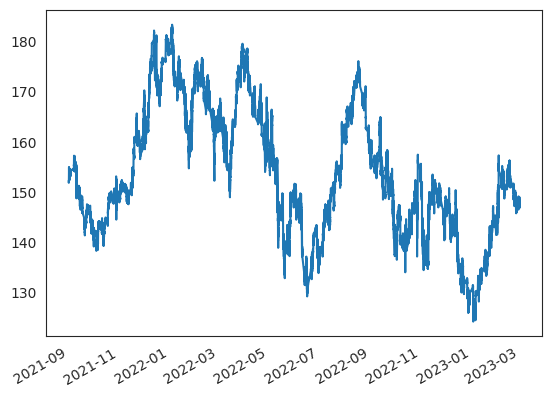

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_263893648350.5152_target.csv",
#     top_n=25,
#     spread=5.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.011, 0.023)      # median ~0.12
    max_down_prop   = trial.suggest_float("max_down_prop", 0.005, 0.01)     # median ~0.12
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.062, 0.074)   # median ~0.033
    tau_time        = trial.suggest_float("tau_time", 10, 10.5)          # median ~25.4 (narrow)
    tau_dur         = trial.suggest_float("tau_dur", 7.5, 9)          # median ~45, allow wider spread
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 1)            # median ~9
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 58), 88)          # median ~89
    adx_thresh     = trial.suggest_float("adx_thresh", 8, 9.5)          # median ~10.5
    atr_mult       = trial.suggest_float("atr_mult", 0.3, 0.45)             # median ~1.4–1.6
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -2.6, -1.6)       # many good trials negative; allow some positive
    buy_factor     = trial.suggest_float("buy_factor", 0.005, 0.02)         # median ~0.45
    sell_factor    = trial.suggest_float("sell_factor", 0.01, 0.04)        # median ~0.05–0.10
    trailstop_pct  = trial.suggest_float("trailstop_pct", 12, 23)        # median ~3.0

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


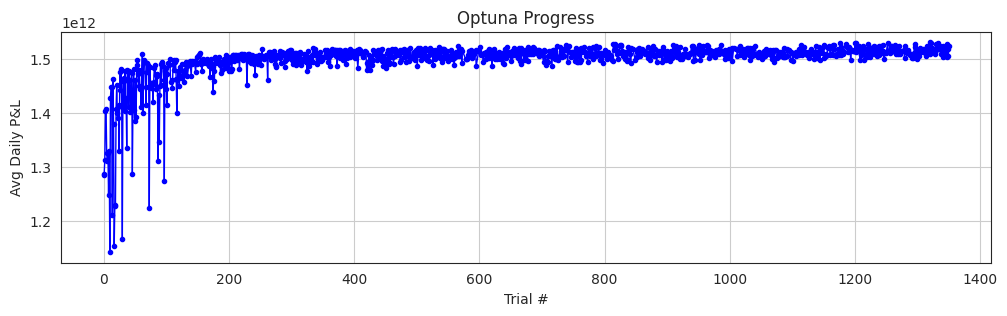

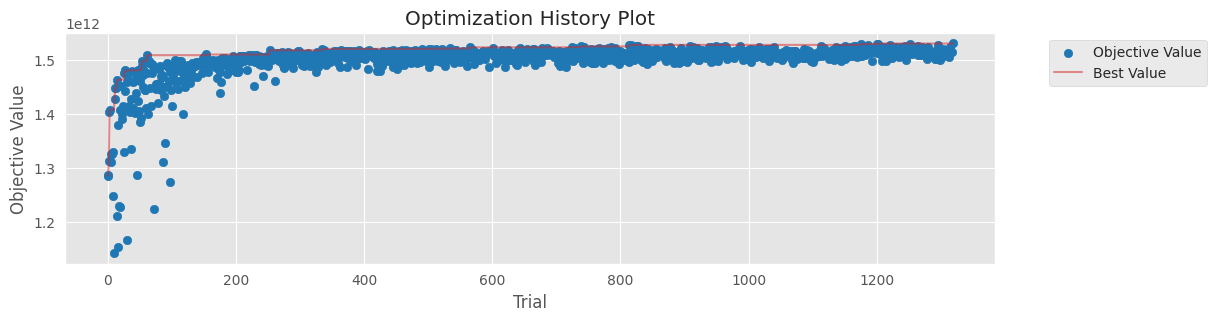

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019083170649135926; max_down_prop=0.009325420078326548; gain_tightfact=0.07099634054270218; tau_time=10.243063861773093; tau_dur=7.798434562965574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=8.863753271519647; atr_mult=0.38635424260797513; vwap_atr_mult=-1.7937214936833854; buy_factor=0.005755562086236247; sell_factor=0.03566616098199646; trailstop_pct=21.46858469050667


Trial 0: 100%|██████████| 375/375 [01:26<00:00,  4.32it/s]


[Results] mean_pnl:1285635206393.8123 mean_bh:-8.7491 mean_excess:1285635206402.5613 improv_vs_bh:14694500895970.04%
Action counts: {'Buy': 45647, 'Sell': 73231, 'Hold': 231833}
Best trial is: 0 with best_val: 1285635206402.5613
[save_results] wrote optuna_results/AAPL_1285635206402.5613_target.csv
[save_best_json] wrote optuna_results/AAPL_1285635206402.5613_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019737827366106693; max_down_prop=0.0065722530089663694; gain_tightfact=0.06968878084530204; tau_time=10.197590171421506; tau_dur=8.320059840843696; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.723340027890767; atr_mult=0.3735339497531378; vwap_atr_mult=-1.8438284904117763; buy_factor=0.014427793104311876; sell_factor=0.025894842004354754; trailstop_pct=17.734525119013732


Trial 1: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:1287266698928.6206 mean_bh:-8.7491 mean_excess:1287266698937.3694 improv_vs_bh:14713148462865.47%
Action counts: {'Buy': 45255, 'Sell': 73365, 'Hold': 232091}
Best trial is: 1 with best_val: 1287266698937.3694
[save_results] wrote optuna_results/AAPL_1287266698937.3694_target.csv
[save_best_json] wrote optuna_results/AAPL_1287266698937.3694_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017590277342913446; max_down_prop=0.005881989080975455; gain_tightfact=0.06232394250583609; tau_time=10.1293729594342; tau_dur=8.581391055841463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=9.031041452951746; atr_mult=0.43432134856890725; vwap_atr_mult=-2.078106806213381; buy_factor=0.019531183506859243; sell_factor=0.014558636535750277; trailstop_pct=17.413526943343065


Trial 2: 100%|██████████| 375/375 [00:50<00:00,  7.40it/s]


[Results] mean_pnl:1313038682016.0906 mean_bh:-8.7491 mean_excess:1313038682024.8396 improv_vs_bh:15007716025019.77%
Action counts: {'Buy': 45466, 'Sell': 73451, 'Hold': 231794}
Best trial is: 2 with best_val: 1313038682024.8396
[save_results] wrote optuna_results/AAPL_1313038682024.8396_target.csv
[save_best_json] wrote optuna_results/AAPL_1313038682024.8396_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02076193419790345; max_down_prop=0.008440189917923354; gain_tightfact=0.07272746693973475; tau_time=10.045799933559026; tau_dur=8.317586308511641; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.779482415704884; atr_mult=0.4381950041129958; vwap_atr_mult=-1.6301447892788146; buy_factor=0.008694606533519776; sell_factor=0.013397073391564061; trailstop_pct=17.85391784454388


Trial 3: 100%|██████████| 375/375 [01:58<00:00,  3.18it/s]


[Results] mean_pnl:1403205668678.1987 mean_bh:-8.7491 mean_excess:1403205668686.9482 improv_vs_bh:16038302975108.62%
Action counts: {'Buy': 45465, 'Sell': 73111, 'Hold': 232135}
Best trial is: 3 with best_val: 1403205668686.9482
[save_results] wrote optuna_results/AAPL_1403205668686.9482_target.csv
[save_best_json] wrote optuna_results/AAPL_1403205668686.9482_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012630590100998809; max_down_prop=0.009735722161395203; gain_tightfact=0.07068115666050674; tau_time=10.055625422494932; tau_dur=7.600471062316816; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=61; adx_thresh=8.536754330847701; atr_mult=0.3980897538023504; vwap_atr_mult=-2.353480350294694; buy_factor=0.009758277885313388; sell_factor=0.023910128246275142; trailstop_pct=18.632846954137786


Trial 4: 100%|██████████| 375/375 [01:11<00:00,  5.24it/s]


[Results] mean_pnl:1407821882281.3333 mean_bh:-8.7491 mean_excess:1407821882290.0825 improv_vs_bh:16091065185251.47%
Action counts: {'Buy': 44635, 'Sell': 73583, 'Hold': 232493}
Best trial is: 4 with best_val: 1407821882290.0825
[save_results] wrote optuna_results/AAPL_1407821882290.0825_target.csv
[save_best_json] wrote optuna_results/AAPL_1407821882290.0825_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017010630438934; max_down_prop=0.006444675369921883; gain_tightfact=0.06554159242395081; tau_time=10.085388195723707; tau_dur=8.827706812856809; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.329092827580947; atr_mult=0.4211859876527181; vwap_atr_mult=-2.1870624958082385; buy_factor=0.013484027991250914; sell_factor=0.026394706588333892; trailstop_pct=20.971941050816596


Trial 5: 100%|██████████| 375/375 [00:49<00:00,  7.53it/s]


[Results] mean_pnl:1326714417426.8567 mean_bh:-8.7491 mean_excess:1326714417435.6057 improv_vs_bh:15164026388368.39%
Action counts: {'Buy': 45566, 'Sell': 73298, 'Hold': 231847}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015084310862714913; max_down_prop=0.008051366610386013; gain_tightfact=0.062330696099706734; tau_time=10.232350412821953; tau_dur=7.55176726688474; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; adx_thresh=8.665316354951564; atr_mult=0.4041112373619125; vwap_atr_mult=-2.3885543148254422; buy_factor=0.006361745387478223; sell_factor=0.025287459304979984; trailstop_pct=21.403410007974237


Trial 6: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:1311261631911.8179 mean_bh:-8.7491 mean_excess:1311261631920.5669 improv_vs_bh:14987404770147.96%
Action counts: {'Buy': 45543, 'Sell': 73533, 'Hold': 231635}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01819914876811634; max_down_prop=0.008299635791622552; gain_tightfact=0.07155190063768119; tau_time=10.129687180384513; tau_dur=8.399844117397581; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=60; adx_thresh=8.593289671263268; atr_mult=0.42740783403898075; vwap_atr_mult=-2.2098249221608586; buy_factor=0.013747253890881335; sell_factor=0.013771262293850593; trailstop_pct=16.797383134578837


Trial 7: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:1326176772252.3528 mean_bh:-8.7491 mean_excess:1326176772261.1018 improv_vs_bh:15157881233460.43%
Action counts: {'Buy': 44363, 'Sell': 73338, 'Hold': 233010}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01668823361064459; max_down_prop=0.007349886714719095; gain_tightfact=0.07206309997351858; tau_time=10.266257389438499; tau_dur=8.654504950804538; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.305332552083945; atr_mult=0.30791431516570533; vwap_atr_mult=-2.013101773312708; buy_factor=0.00845710777596735; sell_factor=0.013190473899128457; trailstop_pct=22.191311042661695


Trial 8: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1247689386680.9424 mean_bh:-8.7491 mean_excess:1247689386689.6914 improv_vs_bh:14260789312005.77%
Action counts: {'Buy': 45368, 'Sell': 73521, 'Hold': 231822}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012554077912486455; max_down_prop=0.005367582969060099; gain_tightfact=0.06923823329647771; tau_time=10.159652223183677; tau_dur=7.720510360447339; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; adx_thresh=8.697246980350442; atr_mult=0.4412334356721106; vwap_atr_mult=-1.9766520100497904; buy_factor=0.011831225055008578; sell_factor=0.03070578213293617; trailstop_pct=20.34515116223399


Trial 9: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:1328700906831.6167 mean_bh:-8.7491 mean_excess:1328700906840.3657 improv_vs_bh:15186731484022.82%
Action counts: {'Buy': 45193, 'Sell': 73461, 'Hold': 232057}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011396938155221616; max_down_prop=0.00992206922959882; gain_tightfact=0.06662954908214343; tau_time=10.433440732110721; tau_dur=8.016052443852637; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.0241358972677; atr_mult=0.34832328336830337; vwap_atr_mult=-2.567262216601118; buy_factor=0.019367986124768546; sell_factor=0.01875980334247239; trailstop_pct=12.30199218791537


Trial 10: 100%|██████████| 375/375 [00:41<00:00,  8.95it/s]


[Results] mean_pnl:1142309856247.7358 mean_bh:-8.7491 mean_excess:1142309856256.4849 improv_vs_bh:13056326648992.18%
Action counts: {'Buy': 44640, 'Sell': 73853, 'Hold': 232218}
Best trial is: 4 with best_val: 1407821882290.0825
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022985176120426425; max_down_prop=0.00892617354479602; gain_tightfact=0.07255536938728574; tau_time=10.017881179655399; tau_dur=8.066593719553477; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; adx_thresh=8.40119529242712; atr_mult=0.3996285348424759; vwap_atr_mult=-1.6227101151373464; buy_factor=0.010034919485351502; sell_factor=0.019568363286199243; trailstop_pct=15.542283928549256


Trial 11: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:1427627953176.3252 mean_bh:-8.7491 mean_excess:1427627953185.0745 improv_vs_bh:16317443807323.04%
Action counts: {'Buy': 44811, 'Sell': 72995, 'Hold': 232905}
Best trial is: 11 with best_val: 1427627953185.0745
[save_results] wrote optuna_results/AAPL_1427627953185.0745_target.csv
[save_best_json] wrote optuna_results/AAPL_1427627953185.0745_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022949331394734568; max_down_prop=0.009261187598124733; gain_tightfact=0.0739783381069211; tau_time=10.001014515856571; tau_dur=8.015316382291186; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=65; adx_thresh=8.353784281014423; atr_mult=0.36783289778555184; vwap_atr_mult=-2.3731720526848146; buy_factor=0.010757252676462301; sell_factor=0.020276207615650344; trailstop_pct=14.667841418587757


Trial 12: 100%|██████████| 375/375 [01:05<00:00,  5.71it/s]


[Results] mean_pnl:1448454716724.8618 mean_bh:-8.7491 mean_excess:1448454716733.6111 improv_vs_bh:16555488700695.61%
Action counts: {'Buy': 44944, 'Sell': 73126, 'Hold': 232641}
Best trial is: 12 with best_val: 1448454716733.6111
[save_results] wrote optuna_results/AAPL_1448454716733.611_target.csv
[save_best_json] wrote optuna_results/AAPL_1448454716733.611_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022757694822687236; max_down_prop=0.009003348051207127; gain_tightfact=0.07331846664335276; tau_time=10.006473710392852; tau_dur=8.022115685243872; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; adx_thresh=8.297536456022382; atr_mult=0.3575237751189987; vwap_atr_mult=-2.584655147800945; buy_factor=0.01113462760824705; sell_factor=0.018011453059201175; trailstop_pct=14.639405374574126


Trial 13: 100%|██████████| 375/375 [01:20<00:00,  4.68it/s]


[Results] mean_pnl:1447244985823.8811 mean_bh:-8.7491 mean_excess:1447244985832.6304 improv_vs_bh:16541661767736.86%
Action counts: {'Buy': 45042, 'Sell': 73207, 'Hold': 232462}
Best trial is: 12 with best_val: 1448454716733.6111
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02249243556331157; max_down_prop=0.00899450592661218; gain_tightfact=0.07392110523340008; tau_time=10.341046348184873; tau_dur=8.02662109234414; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; adx_thresh=8.102365593481; atr_mult=0.34804532784679826; vwap_atr_mult=-2.52819851096799; buy_factor=0.01629520785388938; sell_factor=0.019487829112633054; trailstop_pct=13.864332649924153


Trial 14: 100%|██████████| 375/375 [01:04<00:00,  5.84it/s]


[Results] mean_pnl:1212004366402.1597 mean_bh:-8.7491 mean_excess:1212004366410.9084 improv_vs_bh:13852918121291.74%
Action counts: {'Buy': 45000, 'Sell': 73130, 'Hold': 232581}
Best trial is: 12 with best_val: 1448454716733.6111
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021392098067669257; max_down_prop=0.007221473277857335; gain_tightfact=0.07319110683718263; tau_time=10.002722633120985; tau_dur=7.884875409186123; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; adx_thresh=8.247571307891018; atr_mult=0.3563460132578228; vwap_atr_mult=-2.3911220077047606; buy_factor=0.011737720491951917; sell_factor=0.021402642497909383; trailstop_pct=13.984508640340266


Trial 15: 100%|██████████| 375/375 [01:02<00:00,  6.04it/s]


[Results] mean_pnl:1463111081260.9875 mean_bh:-8.7491 mean_excess:1463111081269.7366 improv_vs_bh:16723007418863.26%
Action counts: {'Buy': 45512, 'Sell': 73312, 'Hold': 231887}
Best trial is: 15 with best_val: 1463111081269.7366
[save_results] wrote optuna_results/AAPL_1463111081269.7366_target.csv
[save_best_json] wrote optuna_results/AAPL_1463111081269.7366_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020999997246507557; max_down_prop=0.0073545166972015024; gain_tightfact=0.0681019165210738; tau_time=10.094965881404779; tau_dur=7.818501793773366; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; adx_thresh=8.188909414417518; atr_mult=0.32532627896291655; vwap_atr_mult=-2.39045497860934; buy_factor=0.01662280774686459; sell_factor=0.03196300761854988; trailstop_pct=12.16972673563088


Trial 16: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:1379353655295.8354 mean_bh:-8.7491 mean_excess:1379353655304.5847 improv_vs_bh:15765680204456.16%
Action counts: {'Buy': 45535, 'Sell': 73295, 'Hold': 231881}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02124425918371414; max_down_prop=0.0068640588790095484; gain_tightfact=0.064976906425222; tau_time=10.449724503686605; tau_dur=8.151771307197494; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.401821337138104; atr_mult=0.3668986493281503; vwap_atr_mult=-2.2576270644059035; buy_factor=0.007507184663243384; sell_factor=0.03991717416817001; trailstop_pct=13.709365301395481


Trial 17: 100%|██████████| 375/375 [01:04<00:00,  5.79it/s]


[Results] mean_pnl:1153511058058.7668 mean_bh:-8.7491 mean_excess:1153511058067.5159 improv_vs_bh:13184353689033.12%
Action counts: {'Buy': 45487, 'Sell': 72804, 'Hold': 232420}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015441850567071641; max_down_prop=0.0079377436349973; gain_tightfact=0.07387293346943112; tau_time=10.346270514728337; tau_dur=7.878999971327555; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; adx_thresh=8.174658336865821; atr_mult=0.3261536855584616; vwap_atr_mult=-2.4721875835826013; buy_factor=0.015373551906857748; sell_factor=0.010294723153587208; trailstop_pct=15.857721314109654


Trial 18: 100%|██████████| 375/375 [00:43<00:00,  8.71it/s]


[Results] mean_pnl:1230243831659.2244 mean_bh:-8.7491 mean_excess:1230243831667.9734 improv_vs_bh:14061390818077.89%
Action counts: {'Buy': 45349, 'Sell': 73893, 'Hold': 231469}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021525809711340792; max_down_prop=0.007637176232847915; gain_tightfact=0.06802718748808304; tau_time=10.317801792226216; tau_dur=8.214939123892856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=9.031122359103726; atr_mult=0.32809004938074177; vwap_atr_mult=-2.2566453334324357; buy_factor=0.011789169620858561; sell_factor=0.022846590607119906; trailstop_pct=13.387053722321058


Trial 19: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:1228448224616.6333 mean_bh:-8.7491 mean_excess:1228448224625.3821 improv_vs_bh:14040867461868.63%
Action counts: {'Buy': 43969, 'Sell': 72978, 'Hold': 233764}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019707921515284377; max_down_prop=0.005057452272296387; gain_tightfact=0.07008392417404852; tau_time=10.006626818431958; tau_dur=8.983006315853629; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.47403302541699; atr_mult=0.33975906583903204; vwap_atr_mult=-2.44023654841565; buy_factor=0.010323079362311114; sell_factor=0.029275990390222675; trailstop_pct=15.313706226792219


Trial 20: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:1406617437516.7556 mean_bh:-8.7491 mean_excess:1406617437525.5044 improv_vs_bh:16077298671559.18%
Action counts: {'Buy': 45455, 'Sell': 73429, 'Hold': 231827}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022606793511655343; max_down_prop=0.009295256466021867; gain_tightfact=0.07303682102464297; tau_time=10.006329124315133; tau_dur=7.9332855818372545; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=64; adx_thresh=8.258934734601768; atr_mult=0.3633977410958946; vwap_atr_mult=-2.597032295190153; buy_factor=0.011643098947766859; sell_factor=0.017527681088222318; trailstop_pct=14.749068184133316


Trial 21: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:1451714083359.0249 mean_bh:-8.7491 mean_excess:1451714083367.7742 improv_vs_bh:16592742476640.36%
Action counts: {'Buy': 44940, 'Sell': 73254, 'Hold': 232517}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02187319589028903; max_down_prop=0.008638184504402147; gain_tightfact=0.0724201270300289; tau_time=10.069103576146823; tau_dur=7.915276068245375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=70; adx_thresh=8.23356522255213; atr_mult=0.3858155351958294; vwap_atr_mult=-2.3199214417959557; buy_factor=0.012765512373349925; sell_factor=0.02131830701054886; trailstop_pct=14.524354816810492


Trial 22: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:1400132528512.2158 mean_bh:-8.7491 mean_excess:1400132528520.9651 improv_vs_bh:16003177722861.65%
Action counts: {'Buy': 45300, 'Sell': 73187, 'Hold': 232224}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020068129932591165; max_down_prop=0.00954984822229552; gain_tightfact=0.07395480622036485; tau_time=10.10847256755005; tau_dur=7.677874276838471; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=62; adx_thresh=8.069695812003772; atr_mult=0.362478541636752; vwap_atr_mult=-2.486393179157068; buy_factor=0.011035715861758012; sell_factor=0.016120129469800626; trailstop_pct=12.638049666460951


Trial 23: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:1390037957756.9338 mean_bh:-8.7491 mean_excess:1390037957765.6831 improv_vs_bh:15887799209369.49%
Action counts: {'Buy': 44806, 'Sell': 73503, 'Hold': 232402}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02176507371026994; max_down_prop=0.007004652068551648; gain_tightfact=0.07151196242699835; tau_time=10.044036428014342; tau_dur=7.940912420423619; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=63; adx_thresh=8.334377724978284; atr_mult=0.38381441856199333; vwap_atr_mult=-2.590141223461473; buy_factor=0.012681738554115654; sell_factor=0.02113179264397889; trailstop_pct=16.12182621087234


Trial 24: 100%|██████████| 375/375 [00:44<00:00,  8.44it/s]


[Results] mean_pnl:1414590247677.4048 mean_bh:-8.7491 mean_excess:1414590247686.1536 improv_vs_bh:16168425972262.84%
Action counts: {'Buy': 44842, 'Sell': 73172, 'Hold': 232697}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018640587780142884; max_down_prop=0.009317974890901503; gain_tightfact=0.07306195122408861; tau_time=10.170743720433558; tau_dur=8.150846020936566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; adx_thresh=8.493353796268897; atr_mult=0.35392113901089667; vwap_atr_mult=-2.135181807554128; buy_factor=0.008160870912233272; sell_factor=0.017155465103782522; trailstop_pct=19.216860153064257


Trial 25: 100%|██████████| 375/375 [00:48<00:00,  7.79it/s]


[Results] mean_pnl:1328860710966.7678 mean_bh:-8.7491 mean_excess:1328860710975.5168 improv_vs_bh:15188558006815.19%
Action counts: {'Buy': 45135, 'Sell': 73456, 'Hold': 232120}
Best trial is: 15 with best_val: 1463111081269.7366
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022047077749697507; max_down_prop=0.007713059334116612; gain_tightfact=0.06871788781652152; tau_time=10.005038724030108; tau_dur=7.69928764491087; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=64; adx_thresh=9.487288308562487; atr_mult=0.3392870100149036; vwap_atr_mult=-2.306750408293999; buy_factor=0.009309191618699052; sell_factor=0.010004319297910506; trailstop_pct=13.241440552315993


Trial 26: 100%|██████████| 375/375 [00:50<00:00,  7.48it/s]


[Results] mean_pnl:1476395724466.0496 mean_bh:-8.7491 mean_excess:1476395724474.7986 improv_vs_bh:16874847692455.07%
Action counts: {'Buy': 44707, 'Sell': 73255, 'Hold': 232749}
Best trial is: 26 with best_val: 1476395724474.7986
[save_results] wrote optuna_results/AAPL_1476395724474.7986_target.csv
[save_best_json] wrote optuna_results/AAPL_1476395724474.7986_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020230000053453018; max_down_prop=0.005928077261407713; gain_tightfact=0.06866302376478677; tau_time=10.057894712800847; tau_dur=7.720476356585522; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=72; adx_thresh=9.423427123741442; atr_mult=0.3008376114009368; vwap_atr_mult=-2.289580045058362; buy_factor=0.0092219997499163; sell_factor=0.011706956132603289; trailstop_pct=13.161609147313573


Trial 27: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:1443071467208.6631 mean_bh:-8.7491 mean_excess:1443071467217.4121 improv_vs_bh:16493959454728.27%
Action counts: {'Buy': 45234, 'Sell': 73472, 'Hold': 232005}
Best trial is: 26 with best_val: 1476395724474.7986
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021967160098605668; max_down_prop=0.007691672271111155; gain_tightfact=0.06664491312333624; tau_time=10.034303187298132; tau_dur=7.504304483861996; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=9.130729858541912; atr_mult=0.3362697627877925; vwap_atr_mult=-2.438669818794613; buy_factor=0.00752234131775693; sell_factor=0.015762989305937506; trailstop_pct=14.32707249382222


Trial 28: 100%|██████████| 375/375 [01:12<00:00,  5.18it/s]


[Results] mean_pnl:1480509860430.9651 mean_bh:-8.7491 mean_excess:1480509860439.7139 improv_vs_bh:16921871276066.91%
Action counts: {'Buy': 44197, 'Sell': 73249, 'Hold': 233265}
Best trial is: 28 with best_val: 1480509860439.7139
[save_results] wrote optuna_results/AAPL_1480509860439.7139_target.csv
[save_best_json] wrote optuna_results/AAPL_1480509860439.7139_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01944829917044038; max_down_prop=0.007602988662215822; gain_tightfact=0.06688152794372036; tau_time=10.130900933680588; tau_dur=7.547627422780543; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=59; adx_thresh=9.27670747946226; atr_mult=0.3375562327608301; vwap_atr_mult=-2.4826316872671073; buy_factor=0.005276660024622472; sell_factor=0.010871022043983328; trailstop_pct=12.911669065399884


Trial 29: 100%|██████████| 375/375 [00:45<00:00,  8.18it/s]


[Results] mean_pnl:1410928410930.2927 mean_bh:-8.7491 mean_excess:1410928410939.0417 improv_vs_bh:16126572059820.68%
Action counts: {'Buy': 44308, 'Sell': 73607, 'Hold': 232796}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020587966442810704; max_down_prop=0.007911562653220273; gain_tightfact=0.06361357965355645; tau_time=10.490612735040616; tau_dur=7.654348624456512; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=9.069488883709115; atr_mult=0.3164236601339804; vwap_atr_mult=-2.4248037785032652; buy_factor=0.00709860406954794; sell_factor=0.015646465735701314; trailstop_pct=14.016073305409726


Trial 30: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:1167325935553.0024 mean_bh:-8.7491 mean_excess:1167325935561.7515 improv_vs_bh:13342254412897.70%
Action counts: {'Buy': 44035, 'Sell': 73050, 'Hold': 233626}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02207851287760241; max_down_prop=0.007046388796482981; gain_tightfact=0.06663616749011642; tau_time=10.032058749948188; tau_dur=7.7706112370086915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=64; adx_thresh=8.883213135795224; atr_mult=0.3383530430376283; vwap_atr_mult=-2.518517652121455; buy_factor=0.006078498695732022; sell_factor=0.016605330380747293; trailstop_pct=15.07347209039344


Trial 31: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s]


[Results] mean_pnl:1459332320156.4543 mean_bh:-8.7491 mean_excess:1459332320165.2031 improv_vs_bh:16679817089165.00%
Action counts: {'Buy': 44862, 'Sell': 73244, 'Hold': 232605}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02191654058970219; max_down_prop=0.006989336461869654; gain_tightfact=0.06685679206272084; tau_time=10.035645672757445; tau_dur=7.778128787126391; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=69; adx_thresh=8.919974004200261; atr_mult=0.33756449451695014; vwap_atr_mult=-2.5175971978222513; buy_factor=0.006274788668696166; sell_factor=0.011763830982335317; trailstop_pct=16.761505566382024


Trial 32: 100%|██████████| 375/375 [00:42<00:00,  8.91it/s]


[Results] mean_pnl:1464104371370.7300 mean_bh:-8.7491 mean_excess:1464104371379.4790 improv_vs_bh:16734360485685.70%
Action counts: {'Buy': 45190, 'Sell': 73342, 'Hold': 232179}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01910772478278329; max_down_prop=0.006503202141222943; gain_tightfact=0.06558216868493971; tau_time=10.081369923406363; tau_dur=7.82340227371552; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=68; adx_thresh=9.488489879767883; atr_mult=0.31754866496524353; vwap_atr_mult=-2.329106408177047; buy_factor=0.007122122308462122; sell_factor=0.012782337329373436; trailstop_pct=15.958333871133084


Trial 33: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1413831852258.3423 mean_bh:-8.7491 mean_excess:1413831852267.0916 improv_vs_bh:16159757695204.61%
Action counts: {'Buy': 45030, 'Sell': 73579, 'Hold': 232102}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021232104620484134; max_down_prop=0.006197249159452021; gain_tightfact=0.06726115869484393; tau_time=10.043183107573826; tau_dur=7.533382814595638; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=75; adx_thresh=9.132726336424296; atr_mult=0.3453999578475181; vwap_atr_mult=-1.877591270492502; buy_factor=0.005086885570084105; sell_factor=0.014492305688312366; trailstop_pct=16.80918492836775


Trial 34: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1477399287056.3215 mean_bh:-8.7491 mean_excess:1477399287065.0703 improv_vs_bh:16886318171256.89%
Action counts: {'Buy': 45450, 'Sell': 73341, 'Hold': 231920}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02057329835379233; max_down_prop=0.006022790575343344; gain_tightfact=0.06720609186234296; tau_time=10.165823274436418; tau_dur=7.5248611485599355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=9.135725895087466; atr_mult=0.34541890153075305; vwap_atr_mult=-1.7780108021299976; buy_factor=0.0053312012934756525; sell_factor=0.010102313345824112; trailstop_pct=16.832224628303514


Trial 35: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:1403279672947.7585 mean_bh:-8.7491 mean_excess:1403279672956.5078 improv_vs_bh:16039148826093.37%
Action counts: {'Buy': 45254, 'Sell': 73510, 'Hold': 231947}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022090767673692054; max_down_prop=0.006180714015617697; gain_tightfact=0.06747150261812751; tau_time=10.10825118369732; tau_dur=7.503719898184765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=8.824089315606685; atr_mult=0.3321267464760814; vwap_atr_mult=-1.8622395763730872; buy_factor=0.006436743534027423; sell_factor=0.014567108258947165; trailstop_pct=18.12180178822456


Trial 36: 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]


[Results] mean_pnl:1428141030539.9524 mean_bh:-8.7491 mean_excess:1428141030548.7014 improv_vs_bh:16323308158067.30%
Action counts: {'Buy': 45604, 'Sell': 73382, 'Hold': 231725}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01816644181084316; max_down_prop=0.006733968179629135; gain_tightfact=0.06607880716943958; tau_time=10.209856653561019; tau_dur=7.619688181895564; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; adx_thresh=8.913183812755406; atr_mult=0.3742282920611929; vwap_atr_mult=-1.6877750694103666; buy_factor=0.007729571628852088; sell_factor=0.01212795046056396; trailstop_pct=16.96317500266801


Trial 37: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:1335491453200.1550 mean_bh:-8.7491 mean_excess:1335491453208.9041 improv_vs_bh:15264345794209.48%
Action counts: {'Buy': 45429, 'Sell': 73637, 'Hold': 231645}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0208571078420881; max_down_prop=0.005615598909481361; gain_tightfact=0.06419548423294967; tau_time=10.042815110926185; tau_dur=7.610985518460985; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=78; adx_thresh=9.19154736371832; atr_mult=0.3155360359497813; vwap_atr_mult=-1.9203030819698683; buy_factor=0.005011560570732759; sell_factor=0.014395152888574979; trailstop_pct=19.156649463982337


Trial 38: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:1479776160530.8674 mean_bh:-8.7491 mean_excess:1479776160539.6165 improv_vs_bh:16913485262845.07%
Action counts: {'Buy': 45498, 'Sell': 73374, 'Hold': 231839}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020720955900198373; max_down_prop=0.00546644146993463; gain_tightfact=0.0643415437013097; tau_time=10.070116061466994; tau_dur=7.608418177449914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.211346635622332; atr_mult=0.3167188894484845; vwap_atr_mult=-1.9218028932464182; buy_factor=0.005054032128459406; sell_factor=0.015179687333549139; trailstop_pct=19.922282377438727


Trial 39: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:1458903910800.3430 mean_bh:-8.7491 mean_excess:1458903910809.0918 improv_vs_bh:16674920473363.05%
Action counts: {'Buy': 45558, 'Sell': 73422, 'Hold': 231731}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016354657448401682; max_down_prop=0.0055191269147648395; gain_tightfact=0.06399429825814089; tau_time=10.041135965066434; tau_dur=8.409853131824905; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.36104316847885; atr_mult=0.3083342729281038; vwap_atr_mult=-2.068750156659684; buy_factor=0.009186307497194542; sell_factor=0.014103357646766469; trailstop_pct=18.56921382007966


Trial 40: 100%|██████████| 375/375 [00:44<00:00,  8.51it/s]


[Results] mean_pnl:1410852298607.6138 mean_bh:-8.7491 mean_excess:1410852298616.3628 improv_vs_bh:16125702114296.29%
Action counts: {'Buy': 45431, 'Sell': 73686, 'Hold': 231594}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022213731648202766; max_down_prop=0.005741894115774973; gain_tightfact=0.06890474388012553; tau_time=10.03139208690161; tau_dur=7.737502196054264; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; adx_thresh=8.977573391988143; atr_mult=0.3334468523062884; vwap_atr_mult=-1.702733207838989; buy_factor=0.006440736576991145; sell_factor=0.012094162535388114; trailstop_pct=19.25972622063751


Trial 41: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:1477839591271.6079 mean_bh:-8.7491 mean_excess:1477839591280.3569 improv_vs_bh:16891350742435.56%
Action counts: {'Buy': 45480, 'Sell': 73340, 'Hold': 231891}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021112676256969973; max_down_prop=0.0063239845091113975; gain_tightfact=0.07030433461461007; tau_time=10.056738203479098; tau_dur=7.593615420144628; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=78; adx_thresh=9.132684805249026; atr_mult=0.32149785314747165; vwap_atr_mult=-1.7763977758586242; buy_factor=0.006730935062026575; sell_factor=0.01338274875105553; trailstop_pct=19.38483176195275


Trial 42: 100%|██████████| 375/375 [00:58<00:00,  6.36it/s]


[Results] mean_pnl:1460981421680.8354 mean_bh:-8.7491 mean_excess:1460981421689.5842 improv_vs_bh:16698665922571.93%
Action counts: {'Buy': 45502, 'Sell': 73410, 'Hold': 231799}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020040126965203974; max_down_prop=0.005620730102256812; gain_tightfact=0.06889917695178222; tau_time=10.134045152161708; tau_dur=7.697869130523272; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; adx_thresh=9.208314501228283; atr_mult=0.3092612144137554; vwap_atr_mult=-1.68262272668953; buy_factor=0.00787989338670594; sell_factor=0.010006216667172897; trailstop_pct=20.506877174104908


Trial 43: 100%|██████████| 375/375 [00:54<00:00,  6.83it/s]


[Results] mean_pnl:1401078892727.3694 mean_bh:-8.7491 mean_excess:1401078892736.1182 improv_vs_bh:16013994438006.23%
Action counts: {'Buy': 45390, 'Sell': 73585, 'Hold': 231736}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02235470551282002; max_down_prop=0.005102379337757169; gain_tightfact=0.0692248021006236; tau_time=10.098359361837018; tau_dur=7.590530119235917; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.006505322821216; atr_mult=0.3317584254948859; vwap_atr_mult=-1.82683684561581; buy_factor=0.005928878388006857; sell_factor=0.014538484033120885; trailstop_pct=17.622542688964906


Trial 44: 100%|██████████| 375/375 [00:57<00:00,  6.57it/s]


[Results] mean_pnl:1439469115437.5281 mean_bh:-8.7491 mean_excess:1439469115446.2773 improv_vs_bh:16452785441240.68%
Action counts: {'Buy': 45585, 'Sell': 73331, 'Hold': 231795}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021414243607525082; max_down_prop=0.008250948043411543; gain_tightfact=0.06298425682549617; tau_time=10.026114930473035; tau_dur=7.729175988215344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=8.968574820081333; atr_mult=0.345308952754913; vwap_atr_mult=-1.9756787645072902; buy_factor=0.005524418975493846; sell_factor=0.012288507217440547; trailstop_pct=22.35287344049588


Trial 45: 100%|██████████| 375/375 [01:05<00:00,  5.70it/s]


[Results] mean_pnl:1474224925085.8135 mean_bh:-8.7491 mean_excess:1474224925094.5625 improv_vs_bh:16850035978153.07%
Action counts: {'Buy': 45554, 'Sell': 73312, 'Hold': 231845}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013190385700167645; max_down_prop=0.005741985032223258; gain_tightfact=0.06852323785807847; tau_time=10.272666231134197; tau_dur=7.506047277586373; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; adx_thresh=9.111187224176456; atr_mult=0.4491097234795627; vwap_atr_mult=-1.713329726549378; buy_factor=0.008908479579418135; sell_factor=0.015847999729455907; trailstop_pct=18.869703834989465


Trial 46: 100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


[Results] mean_pnl:1287060160256.8176 mean_bh:-8.7491 mean_excess:1287060160265.5667 improv_vs_bh:14710787775570.39%
Action counts: {'Buy': 45381, 'Sell': 73597, 'Hold': 231733}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017490386812604845; max_down_prop=0.00531947913882164; gain_tightfact=0.06767909712894049; tau_time=10.078722325600083; tau_dur=7.664401338194517; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=78; adx_thresh=8.757595980704576; atr_mult=0.3008756898035756; vwap_atr_mult=-1.894907871682109; buy_factor=0.007069046255671677; sell_factor=0.02695219856818442; trailstop_pct=18.336839288835048


Trial 47: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:1424373728487.8306 mean_bh:-8.7491 mean_excess:1424373728496.5796 improv_vs_bh:16280248802579.36%
Action counts: {'Buy': 45621, 'Sell': 73650, 'Hold': 231440}
Best trial is: 28 with best_val: 1480509860439.7139
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02239719229396504; max_down_prop=0.0061146275757535; gain_tightfact=0.06970215950915107; tau_time=10.025275147814467; tau_dur=7.566532883299303; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.228142837022544; atr_mult=0.35051161574410367; vwap_atr_mult=-2.16212835430255; buy_factor=0.0058727427345151165; sell_factor=0.018470198359165156; trailstop_pct=21.304791099691048


Trial 48: 100%|██████████| 375/375 [00:52<00:00,  7.21it/s]


[Results] mean_pnl:1481311940479.9453 mean_bh:-8.7491 mean_excess:1481311940488.6946 improv_vs_bh:16931038857928.14%
Action counts: {'Buy': 45591, 'Sell': 73211, 'Hold': 231909}
Best trial is: 48 with best_val: 1481311940488.6946
[save_results] wrote optuna_results/AAPL_1481311940488.6946_target.csv
[save_best_json] wrote optuna_results/AAPL_1481311940488.6946_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022762716870688572; max_down_prop=0.006180967549266178; gain_tightfact=0.06974548667088021; tau_time=10.119115200370043; tau_dur=7.563123500661844; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.204033245996415; atr_mult=0.3542245308243063; vwap_atr_mult=-2.039159849800647; buy_factor=0.005719518200295519; sell_factor=0.023502817978768895; trailstop_pct=22.876014085896205


Trial 49: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1404820491562.4041 mean_bh:-8.7491 mean_excess:1404820491571.1528 improv_vs_bh:16056760011910.83%
Action counts: {'Buy': 45547, 'Sell': 73098, 'Hold': 232066}
Best trial is: 48 with best_val: 1481311940488.6946
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01928204696134391; max_down_prop=0.005881767119364346; gain_tightfact=0.0711776892982431; tau_time=10.142237250355144; tau_dur=7.638376144929882; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=9.309499029547702; atr_mult=0.41884357442213105; vwap_atr_mult=-2.1335499851213138; buy_factor=0.0050045557447116525; sell_factor=0.01914545945993443; trailstop_pct=21.411204399414657


Trial 50: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:1384347525190.2832 mean_bh:-8.7491 mean_excess:1384347525199.0325 improv_vs_bh:15822758935088.97%
Action counts: {'Buy': 45554, 'Sell': 73411, 'Hold': 231746}
Best trial is: 48 with best_val: 1481311940488.6946
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0220317789591006; max_down_prop=0.006605785546041412; gain_tightfact=0.06823490598473625; tau_time=10.029792907443671; tau_dur=7.7730020008213225; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=76; adx_thresh=9.36930332354271; atr_mult=0.33157309538606444; vwap_atr_mult=-1.9485732441091845; buy_factor=0.00660439694706174; sell_factor=0.013583218075940363; trailstop_pct=20.923222985488785


Trial 51: 100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


[Results] mean_pnl:1461260323214.0164 mean_bh:-8.7491 mean_excess:1461260323222.7649 improv_vs_bh:16701853699951.39%
Action counts: {'Buy': 45354, 'Sell': 73280, 'Hold': 232077}
Best trial is: 48 with best_val: 1481311940488.6946
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02103945215357744; max_down_prop=0.005734415452335359; gain_tightfact=0.06946082662267217; tau_time=10.053391171059287; tau_dur=8.639896029519484; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=9.486030033316299; atr_mult=0.34237091128224195; vwap_atr_mult=-2.1733074580887384; buy_factor=0.00840069589077238; sell_factor=0.018364044964473775; trailstop_pct=19.903988393592833


Trial 52: 100%|██████████| 375/375 [00:54<00:00,  6.87it/s]


[Results] mean_pnl:1393068860200.0110 mean_bh:-8.7491 mean_excess:1393068860208.7600 improv_vs_bh:15922441694612.26%
Action counts: {'Buy': 45280, 'Sell': 73083, 'Hold': 232348}
Best trial is: 48 with best_val: 1481311940488.6946
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0223283308704045; max_down_prop=0.007752585499985427; gain_tightfact=0.07066452641861852; tau_time=10.027582491686447; tau_dur=7.5733088512824285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.242341513540671; atr_mult=0.35032663790204016; vwap_atr_mult=-2.2240616421725545; buy_factor=0.005879717910079451; sell_factor=0.011019737086617798; trailstop_pct=21.902880978093926


Trial 53: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:1488105828780.2498 mean_bh:-8.7491 mean_excess:1488105828788.9983 improv_vs_bh:17008691365590.32%
Action counts: {'Buy': 45587, 'Sell': 73312, 'Hold': 231812}
Best trial is: 53 with best_val: 1488105828788.9983
[save_results] wrote optuna_results/AAPL_1488105828788.9983_target.csv
[save_best_json] wrote optuna_results/AAPL_1488105828788.9983_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022415630063807177; max_down_prop=0.005274191362112878; gain_tightfact=0.07057286395494862; tau_time=10.020102836148624; tau_dur=7.568385956037657; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.258792446758205; atr_mult=0.35813200841493986; vwap_atr_mult=-2.012564475093149; buy_factor=0.005847832604258448; sell_factor=0.011471455674145169; trailstop_pct=22.077958105419302


Trial 54: 100%|██████████| 375/375 [00:53<00:00,  6.96it/s]


[Results] mean_pnl:1498109293646.1150 mean_bh:-8.7491 mean_excess:1498109293654.8643 improv_vs_bh:17123028560699.96%
Action counts: {'Buy': 45634, 'Sell': 73316, 'Hold': 231761}
Best trial is: 54 with best_val: 1498109293654.8643
[save_results] wrote optuna_results/AAPL_1498109293654.8643_target.csv
[save_best_json] wrote optuna_results/AAPL_1498109293654.8643_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022528557182066627; max_down_prop=0.0051614358889912814; gain_tightfact=0.07043559518120136; tau_time=10.027158482043298; tau_dur=7.839680163889283; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.283974239103655; atr_mult=0.35105481028839963; vwap_atr_mult=-2.204526720928498; buy_factor=0.005953857382332597; sell_factor=0.011783612125259661; trailstop_pct=22.0507402879202


Trial 55: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:1472323434909.5676 mean_bh:-8.7491 mean_excess:1472323434918.3167 improv_vs_bh:16828302403217.22%
Action counts: {'Buy': 45545, 'Sell': 73237, 'Hold': 231929}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022998987922470057; max_down_prop=0.005303065996955124; gain_tightfact=0.07089477285944186; tau_time=10.079017943437512; tau_dur=7.583314187284262; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.233244263502932; atr_mult=0.35814952943417355; vwap_atr_mult=-2.1095477145734955; buy_factor=0.0073996416784699905; sell_factor=0.011194984806771275; trailstop_pct=20.973565679165784


Trial 56: 100%|██████████| 375/375 [01:03<00:00,  5.91it/s]


[Results] mean_pnl:1449106609725.2764 mean_bh:-8.7491 mean_excess:1449106609734.0254 improv_vs_bh:16562939680748.87%
Action counts: {'Buy': 45603, 'Sell': 73239, 'Hold': 231869}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02240160590927332; max_down_prop=0.007376170824938778; gain_tightfact=0.06989367976769524; tau_time=10.017481473817577; tau_dur=7.6459262788341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.354107713215988; atr_mult=0.36909485397353964; vwap_atr_mult=-1.99764647731841; buy_factor=0.006584623029241842; sell_factor=0.012990690851583508; trailstop_pct=22.008034539308067


Trial 57: 100%|██████████| 375/375 [00:59<00:00,  6.32it/s]


[Results] mean_pnl:1478585909751.5476 mean_bh:-8.7491 mean_excess:1478585909760.2964 improv_vs_bh:16899880982987.11%
Action counts: {'Buy': 45512, 'Sell': 73184, 'Hold': 232015}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02157352620593461; max_down_prop=0.00735548668215993; gain_tightfact=0.07202109119736186; tau_time=10.01335511947045; tau_dur=7.633610429937921; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.38161014682392; atr_mult=0.3653635359632799; vwap_atr_mult=-2.020224586449756; buy_factor=0.018750067353006657; sell_factor=0.017060132751557905; trailstop_pct=21.876327341207883


Trial 58: 100%|██████████| 375/375 [00:58<00:00,  6.42it/s]


[Results] mean_pnl:1443730569383.3464 mean_bh:-8.7491 mean_excess:1443730569392.0952 improv_vs_bh:16501492833907.83%
Action counts: {'Buy': 45531, 'Sell': 73211, 'Hold': 231969}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02246389284199858; max_down_prop=0.008627953767483362; gain_tightfact=0.07008137551172006; tau_time=10.057812897888775; tau_dur=7.5540553725130035; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.431921361624019; atr_mult=0.39259301390757045; vwap_atr_mult=-2.0598861629496663; buy_factor=0.005685491378628111; sell_factor=0.015533773168827763; trailstop_pct=22.84381959950065


Trial 59: 100%|██████████| 375/375 [01:04<00:00,  5.80it/s]


[Results] mean_pnl:1444149976354.8174 mean_bh:-8.7491 mean_excess:1444149976363.5664 improv_vs_bh:16506286554620.64%
Action counts: {'Buy': 45534, 'Sell': 73074, 'Hold': 232103}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02299546397580845; max_down_prop=0.008161076051532332; gain_tightfact=0.06203326869893025; tau_time=10.098121430772094; tau_dur=7.673205266709922; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.06726654679067; atr_mult=0.37797825612296393; vwap_atr_mult=-1.9821947171292342; buy_factor=0.00803388667445288; sell_factor=0.013206245202113328; trailstop_pct=21.670190456764118


Trial 60: 100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


[Results] mean_pnl:1410565816116.4802 mean_bh:-8.7491 mean_excess:1410565816125.2292 improv_vs_bh:16122427688392.52%
Action counts: {'Buy': 45566, 'Sell': 73138, 'Hold': 232007}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022312431919930327; max_down_prop=0.007870095678319644; gain_tightfact=0.07084050343527062; tau_time=10.021055178093773; tau_dur=7.7550187653304326; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.184937082965407; atr_mult=0.36035742128557063; vwap_atr_mult=-2.2453648445563004; buy_factor=0.006704392904262469; sell_factor=0.013022451469342671; trailstop_pct=22.47021162931112


Trial 61: 100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


[Results] mean_pnl:1476239804925.5525 mean_bh:-8.7491 mean_excess:1476239804934.3015 improv_vs_bh:16873065569644.40%
Action counts: {'Buy': 45525, 'Sell': 73235, 'Hold': 231951}
Best trial is: 54 with best_val: 1498109293654.8643
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022436008844735435; max_down_prop=0.005646881929251569; gain_tightfact=0.07136270677036251; tau_time=10.001552146030846; tau_dur=7.507604344172937; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.33288562877585; atr_mult=0.3702279581593337; vwap_atr_mult=-2.1678427862924914; buy_factor=0.00639027685008982; sell_factor=0.011242193531531944; trailstop_pct=20.978692796692822


Trial 62: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:1508531285437.7439 mean_bh:-8.7491 mean_excess:1508531285446.4927 improv_vs_bh:17242149417811.84%
Action counts: {'Buy': 45631, 'Sell': 73295, 'Hold': 231785}
Best trial is: 62 with best_val: 1508531285446.4927
[save_results] wrote optuna_results/AAPL_1508531285446.4927_target.csv
[save_best_json] wrote optuna_results/AAPL_1508531285446.4927_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021703440198793163; max_down_prop=0.008471087784428946; gain_tightfact=0.0715600567028827; tau_time=10.01455085088121; tau_dur=8.504437120697602; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.325957270035751; atr_mult=0.3713635646197114; vwap_atr_mult=-2.178940389268476; buy_factor=0.007482886058720622; sell_factor=0.034845661841232445; trailstop_pct=21.020573382937386


Trial 63: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:1399270760408.2087 mean_bh:-8.7491 mean_excess:1399270760416.9573 improv_vs_bh:15993327920901.20%
Action counts: {'Buy': 45366, 'Sell': 72810, 'Hold': 232535}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021637390446073955; max_down_prop=0.007461494360701281; gain_tightfact=0.06991166145163093; tau_time=10.001935325347617; tau_dur=7.584509295938321; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.250534954950323; atr_mult=0.38027242020985697; vwap_atr_mult=-2.1081341600656316; buy_factor=0.005956249042418313; sell_factor=0.011086683807937522; trailstop_pct=20.52324279872508


Trial 64: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:1493353862794.9092 mean_bh:-8.7491 mean_excess:1493353862803.6580 improv_vs_bh:17068675130927.84%
Action counts: {'Buy': 45576, 'Sell': 73262, 'Hold': 231873}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020377769004719843; max_down_prop=0.007163840540581008; gain_tightfact=0.07119037018953826; tau_time=10.002865058831784; tau_dur=7.50011111161515; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.25993942749726; atr_mult=0.39532616741890303; vwap_atr_mult=-2.0968890480963625; buy_factor=0.005652901799688764; sell_factor=0.010792014674826985; trailstop_pct=20.58788686909306


Trial 65: 100%|██████████| 375/375 [01:17<00:00,  4.86it/s]


[Results] mean_pnl:1498151249023.4346 mean_bh:-8.7491 mean_excess:1498151249032.1831 improv_vs_bh:17123508100562.08%
Action counts: {'Buy': 45612, 'Sell': 73337, 'Hold': 231762}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021610438351349476; max_down_prop=0.007536514012462831; gain_tightfact=0.07129134666192959; tau_time=10.004650247577107; tau_dur=7.51026259426824; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.266279482617831; atr_mult=0.4084072406102402; vwap_atr_mult=-2.106336855223903; buy_factor=0.006041815126470241; sell_factor=0.011526869717634301; trailstop_pct=20.50964385353994


Trial 66: 100%|██████████| 375/375 [00:51<00:00,  7.23it/s]


[Results] mean_pnl:1493296902806.0938 mean_bh:-8.7491 mean_excess:1493296902814.8428 improv_vs_bh:17068024091968.64%
Action counts: {'Buy': 45631, 'Sell': 73231, 'Hold': 231849}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020189839830188253; max_down_prop=0.007205273243402661; gain_tightfact=0.07194212536260468; tau_time=10.068281901980239; tau_dur=7.555643065559949; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.256554989530667; atr_mult=0.40354214726163484; vwap_atr_mult=-2.1157666768137857; buy_factor=0.005945944472285457; sell_factor=0.01098167509939739; trailstop_pct=20.239587609544323


Trial 67: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:1448242939100.0823 mean_bh:-8.7491 mean_excess:1448242939108.8313 improv_vs_bh:16553068133429.27%
Action counts: {'Buy': 45593, 'Sell': 73295, 'Hold': 231823}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02131148823108403; max_down_prop=0.007540147399474; gain_tightfact=0.07131807599311066; tau_time=10.00301861350132; tau_dur=8.782600851955998; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.404970344426618; atr_mult=0.4149982499170288; vwap_atr_mult=-2.160162299994582; buy_factor=0.005621718297196173; sell_factor=0.011254943005742417; trailstop_pct=20.650852770113875


Trial 68: 100%|██████████| 375/375 [00:52<00:00,  7.17it/s]


[Results] mean_pnl:1414443542817.7173 mean_bh:-8.7491 mean_excess:1414443542826.4661 improv_vs_bh:16166749171035.41%
Action counts: {'Buy': 45313, 'Sell': 72906, 'Hold': 232492}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020404075178547806; max_down_prop=0.0077607777837647145; gain_tightfact=0.07248682840651453; tau_time=10.00002158870218; tau_dur=7.564969215707518; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.31474677606759; atr_mult=0.39261535927576324; vwap_atr_mult=-2.2190092963949923; buy_factor=0.007037106592853741; sell_factor=0.010846836954867201; trailstop_pct=21.194285430802115


Trial 69: 100%|██████████| 375/375 [01:57<00:00,  3.18it/s]


[Results] mean_pnl:1491393797002.4792 mean_bh:-8.7491 mean_excess:1491393797011.2283 improv_vs_bh:17046272050800.92%
Action counts: {'Buy': 45588, 'Sell': 73324, 'Hold': 231799}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018594331368488308; max_down_prop=0.00796256241420765; gain_tightfact=0.07255245243174352; tau_time=10.000640747648081; tau_dur=7.693827644245788; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.308454164377384; atr_mult=0.3935468422690678; vwap_atr_mult=-2.234041756393982; buy_factor=0.007005848256212023; sell_factor=0.010804976967107293; trailstop_pct=20.020933140590838


Trial 70: 100%|██████████| 375/375 [02:03<00:00,  3.03it/s]


[Results] mean_pnl:1475212745709.4915 mean_bh:-8.7491 mean_excess:1475212745718.2405 improv_vs_bh:16861326530066.56%
Action counts: {'Buy': 45594, 'Sell': 73487, 'Hold': 231630}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020475609045341597; max_down_prop=0.007788676092967997; gain_tightfact=0.0704338664982346; tau_time=10.01733888656714; tau_dur=7.500817765098124; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.258687848355972; atr_mult=0.38166674686415636; vwap_atr_mult=-2.220677090440534; buy_factor=0.006329441633077996; sell_factor=0.012445587660839013; trailstop_pct=21.429673061578658


Trial 71: 100%|██████████| 375/375 [01:10<00:00,  5.29it/s]


[Results] mean_pnl:1488623870237.7832 mean_bh:-8.7491 mean_excess:1488623870246.5322 improv_vs_bh:17014612454732.85%
Action counts: {'Buy': 45618, 'Sell': 73342, 'Hold': 231751}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020352677473658126; max_down_prop=0.007463103732877656; gain_tightfact=0.07059125246192591; tau_time=10.01434807281473; tau_dur=7.506513634210714; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.442455879472142; atr_mult=0.37983937693890035; vwap_atr_mult=-2.092504596123372; buy_factor=0.00627551453163688; sell_factor=0.012317395007863089; trailstop_pct=21.6374550450275


Trial 72: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:1484875993779.2817 mean_bh:-8.7491 mean_excess:1484875993788.0308 improv_vs_bh:16971775129103.33%
Action counts: {'Buy': 45561, 'Sell': 73330, 'Hold': 231820}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019543212942063137; max_down_prop=0.007183589420001657; gain_tightfact=0.07179280018078836; tau_time=10.391040010778639; tau_dur=7.547674433854561; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.262644053524605; atr_mult=0.4121485832880945; vwap_atr_mult=-2.2798266078537197; buy_factor=0.006881454225665646; sell_factor=0.010741271075610091; trailstop_pct=21.18603635392394


Trial 73: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:1224392171245.7603 mean_bh:-8.7491 mean_excess:1224392171254.5088 improv_vs_bh:13994507748323.47%
Action counts: {'Buy': 45466, 'Sell': 73342, 'Hold': 231903}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021541798193839147; max_down_prop=0.007750329480349119; gain_tightfact=0.07232674514953466; tau_time=10.000109201847787; tau_dur=7.595792606552601; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.3406059056019; atr_mult=0.39111290199877546; vwap_atr_mult=-2.2169109248643855; buy_factor=0.008548899173206097; sell_factor=0.01114079378630477; trailstop_pct=22.521407106294586


Trial 74: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:1483914703595.4600 mean_bh:-8.7491 mean_excess:1483914703604.2087 improv_vs_bh:16960787813730.27%
Action counts: {'Buy': 45586, 'Sell': 73249, 'Hold': 231876}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019794755109398245; max_down_prop=0.008042891220944901; gain_tightfact=0.07110650056868338; tau_time=10.051629518087498; tau_dur=7.500707077883727; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.172721744077657; atr_mult=0.3980675811382224; vwap_atr_mult=-2.142110411501786; buy_factor=0.006215255592635161; sell_factor=0.01244623416356443; trailstop_pct=20.684845752973473


Trial 75: 100%|██████████| 375/375 [00:43<00:00,  8.61it/s]


[Results] mean_pnl:1455450619666.2856 mean_bh:-8.7491 mean_excess:1455450619675.0349 improv_vs_bh:16635450187071.30%
Action counts: {'Buy': 45622, 'Sell': 73427, 'Hold': 231662}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02051676657160817; max_down_prop=0.007766020740103598; gain_tightfact=0.07159095842149626; tau_time=10.068269278402372; tau_dur=7.644326388989185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.281537249820078; atr_mult=0.3815551458986904; vwap_atr_mult=-2.195858431723977; buy_factor=0.005488638185632121; sell_factor=0.01002877392527296; trailstop_pct=20.2416457019532


Trial 76: 100%|██████████| 375/375 [00:43<00:00,  8.63it/s]


[Results] mean_pnl:1445809805559.7444 mean_bh:-8.7491 mean_excess:1445809805568.4932 improv_vs_bh:16525258002833.55%
Action counts: {'Buy': 45537, 'Sell': 73293, 'Hold': 231881}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020936380977254074; max_down_prop=0.0084005441358097; gain_tightfact=0.07282570916069941; tau_time=10.039261936544372; tau_dur=7.5460071100879045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.060866575655966; atr_mult=0.4066748300201689; vwap_atr_mult=-2.053297934713867; buy_factor=0.009826608317937708; sell_factor=0.013762290379352091; trailstop_pct=19.726658227441877


Trial 77: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:1455233875921.0403 mean_bh:-8.7491 mean_excess:1455233875929.7891 improv_vs_bh:16632972858243.62%
Action counts: {'Buy': 45643, 'Sell': 73192, 'Hold': 231876}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019890620892676125; max_down_prop=0.007570669993914793; gain_tightfact=0.070612690605744; tau_time=10.017626615008195; tau_dur=7.5833883464734875; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.392928728760376; atr_mult=0.38881644393883424; vwap_atr_mult=-2.3608897564835982; buy_factor=0.01414030091671398; sell_factor=0.011503911179923488; trailstop_pct=21.671798196618386


Trial 78: 100%|██████████| 375/375 [00:44<00:00,  8.44it/s]


[Results] mean_pnl:1451583845920.4407 mean_bh:-8.7491 mean_excess:1451583845929.1899 improv_vs_bh:16591253894071.66%
Action counts: {'Buy': 45543, 'Sell': 73413, 'Hold': 231755}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01437232815732295; max_down_prop=0.008136248959621515; gain_tightfact=0.0702724876170446; tau_time=10.049276289012523; tau_dur=7.619510334719057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.661051536611888; atr_mult=0.3981762296380964; vwap_atr_mult=-2.2750297344461345; buy_factor=0.007338712863680938; sell_factor=0.03950813012541213; trailstop_pct=20.829961610367544


Trial 79: 100%|██████████| 375/375 [00:45<00:00,  8.21it/s]


[Results] mean_pnl:1419351859788.1450 mean_bh:-8.7491 mean_excess:1419351859796.8943 improv_vs_bh:16222850052343.31%
Action counts: {'Buy': 45717, 'Sell': 73354, 'Hold': 231640}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02170006431257198; max_down_prop=0.006937982016076357; gain_tightfact=0.07329150947359736; tau_time=10.000776658738582; tau_dur=8.319673374146703; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=9.453411540113004; atr_mult=0.37720682777566583; vwap_atr_mult=-2.083267825263661; buy_factor=0.005385938486227378; sell_factor=0.012537437952827692; trailstop_pct=21.29658498756098


Trial 80: 100%|██████████| 375/375 [00:46<00:00,  7.98it/s]


[Results] mean_pnl:1456732087812.0413 mean_bh:-8.7491 mean_excess:1456732087820.7903 improv_vs_bh:16650097059467.29%
Action counts: {'Buy': 45390, 'Sell': 73142, 'Hold': 232179}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02067895479771965; max_down_prop=0.007355721296563516; gain_tightfact=0.07066184405255124; tau_time=10.0168832430441; tau_dur=7.51382783360933; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.32734432211951; atr_mult=0.38126677421726396; vwap_atr_mult=-2.0881249917282307; buy_factor=0.006245102036294985; sell_factor=0.011929710425026753; trailstop_pct=21.73817470321378


Trial 81: 100%|██████████| 375/375 [00:45<00:00,  8.28it/s]


[Results] mean_pnl:1482825725809.3657 mean_bh:-8.7491 mean_excess:1482825725818.1145 improv_vs_bh:16948341059803.68%
Action counts: {'Buy': 45579, 'Sell': 73324, 'Hold': 231808}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02131899751530528; max_down_prop=0.007515856446406988; gain_tightfact=0.07223922181533418; tau_time=10.016694193079141; tau_dur=7.5016214372381445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.252355863365834; atr_mult=0.38526007650833544; vwap_atr_mult=-2.1002715652535953; buy_factor=0.00634947489791221; sell_factor=0.01064546346463787; trailstop_pct=22.237388775048206


Trial 82: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:1487952947351.1458 mean_bh:-8.7491 mean_excess:1487952947359.8945 improv_vs_bh:17006943967661.46%
Action counts: {'Buy': 45612, 'Sell': 73308, 'Hold': 231791}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021266593850346745; max_down_prop=0.007096749574811497; gain_tightfact=0.07224245893968353; tau_time=10.034816611119448; tau_dur=7.543607167344957; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.158810462909893; atr_mult=0.3848519209923142; vwap_atr_mult=-2.025699101423396; buy_factor=0.007749551552525795; sell_factor=0.010460670506451738; trailstop_pct=22.28248509922818


Trial 83: 100%|██████████| 375/375 [00:48<00:00,  7.77it/s]


[Results] mean_pnl:1470687313418.3914 mean_bh:-8.7491 mean_excess:1470687313427.1399 improv_vs_bh:16809601928464.91%
Action counts: {'Buy': 45631, 'Sell': 73292, 'Hold': 231788}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021744005342901294; max_down_prop=0.007841367343274362; gain_tightfact=0.0735489692983673; tau_time=10.061699608350093; tau_dur=7.70071621948217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.23645002523847; atr_mult=0.3878696039694359; vwap_atr_mult=-2.1283575796525507; buy_factor=0.006862709377312592; sell_factor=0.011394640204709764; trailstop_pct=22.537926975482666


Trial 84: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:1443375612348.7007 mean_bh:-8.7491 mean_excess:1443375612357.4495 improv_vs_bh:16497435760456.78%
Action counts: {'Buy': 45554, 'Sell': 73186, 'Hold': 231971}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022691727647440506; max_down_prop=0.007465955303026001; gain_tightfact=0.07138009024969577; tau_time=10.045148796856012; tau_dur=7.585004752394538; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.095523884053376; atr_mult=0.37304279550233654; vwap_atr_mult=-2.2101498844277097; buy_factor=0.005413638259702092; sell_factor=0.010732937894943525; trailstop_pct=20.516719657545806


Trial 85: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1472732855996.3311 mean_bh:-8.7491 mean_excess:1472732856005.0796 improv_vs_bh:16832981987671.90%
Action counts: {'Buy': 45670, 'Sell': 73235, 'Hold': 231806}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01886172385765286; max_down_prop=0.006798154163586181; gain_tightfact=0.07274602171366482; tau_time=10.013032961739729; tau_dur=7.623712511137929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.283432419585798; atr_mult=0.40654205067410754; vwap_atr_mult=-2.1539463866790935; buy_factor=0.0061307986013663576; sell_factor=0.015078997776297178; trailstop_pct=22.150086871299674


Trial 86: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1467591614404.2957 mean_bh:-8.7491 mean_excess:1467591614413.0449 improv_vs_bh:16774218834015.00%
Action counts: {'Buy': 45593, 'Sell': 73378, 'Hold': 231740}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020392063400122958; max_down_prop=0.007638282239627529; gain_tightfact=0.07175474472270504; tau_time=10.243161378892236; tau_dur=7.668670941766543; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.154497340094386; atr_mult=0.42819964698920016; vwap_atr_mult=-2.2416212262612816; buy_factor=0.006506125853550961; sell_factor=0.013568654315422542; trailstop_pct=22.98677960783634


Trial 87: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:1311919409024.6248 mean_bh:-8.7491 mean_excess:1311919409033.3733 improv_vs_bh:14994923004189.28%
Action counts: {'Buy': 45560, 'Sell': 73130, 'Hold': 232021}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020875152691803168; max_down_prop=0.005002612167456177; gain_tightfact=0.07092394774455092; tau_time=10.089698387484562; tau_dur=7.5331995260483335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.250997694799922; atr_mult=0.3952294094186653; vwap_atr_mult=-2.1026619624277414; buy_factor=0.0073056542367696264; sell_factor=0.012842845482820255; trailstop_pct=21.435695198086485


Trial 88: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


[Results] mean_pnl:1433794836224.7905 mean_bh:-8.7491 mean_excess:1433794836233.5393 improv_vs_bh:16387929795906.52%
Action counts: {'Buy': 45571, 'Sell': 73233, 'Hold': 231907}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021968533375781273; max_down_prop=0.00802835463253853; gain_tightfact=0.0694348051086037; tau_time=10.184988596384638; tau_dur=7.50063942637663; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.348854643616754; atr_mult=0.36989631431514547; vwap_atr_mult=-2.3025753364720063; buy_factor=0.015040359326047746; sell_factor=0.011784042945170449; trailstop_pct=19.499569874490373


Trial 89: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


[Results] mean_pnl:1347019621640.7073 mean_bh:-8.7491 mean_excess:1347019621649.4565 improv_vs_bh:15396109984109.50%
Action counts: {'Buy': 45520, 'Sell': 73256, 'Hold': 231935}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021432713860786733; max_down_prop=0.007258755791257271; gain_tightfact=0.07207679275198614; tau_time=10.025814133261829; tau_dur=7.5766643934385085; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.298829599629563; atr_mult=0.3833272946893635; vwap_atr_mult=-2.331992493816709; buy_factor=0.008189921093713652; sell_factor=0.027527657689640946; trailstop_pct=22.691177227350224


Trial 90: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1450516361020.3232 mean_bh:-8.7491 mean_excess:1450516361029.0723 improv_vs_bh:16579052798657.43%
Action counts: {'Buy': 45551, 'Sell': 73023, 'Hold': 232137}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020427494628159806; max_down_prop=0.007474690954752843; gain_tightfact=0.0711983311662641; tau_time=10.012311497769863; tau_dur=7.500593848914512; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.390570226306476; atr_mult=0.37702877590183964; vwap_atr_mult=-2.0889801348339674; buy_factor=0.00612820840291484; sell_factor=0.012278614022129049; trailstop_pct=21.60808577654222


Trial 91: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:1489474936523.1704 mean_bh:-8.7491 mean_excess:1489474936531.9194 improv_vs_bh:17024339937482.91%
Action counts: {'Buy': 45589, 'Sell': 73356, 'Hold': 231766}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011042675421062045; max_down_prop=0.007469449947524742; gain_tightfact=0.07107118468924818; tau_time=10.034007684938274; tau_dur=7.534956659128717; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.215627758594593; atr_mult=0.4020923855345433; vwap_atr_mult=-2.1856305132457186; buy_factor=0.005872304878765036; sell_factor=0.014101988528325506; trailstop_pct=21.148560940945693


Trial 92: 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]


[Results] mean_pnl:1452042649526.1152 mean_bh:-8.7491 mean_excess:1452042649534.8643 improv_vs_bh:16596497908828.79%
Action counts: {'Buy': 45643, 'Sell': 73794, 'Hold': 231274}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02096067313378362; max_down_prop=0.007822139903944873; gain_tightfact=0.06998678518238143; tau_time=10.007652641880851; tau_dur=7.6045512710105045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.382946037591358; atr_mult=0.3765001178489475; vwap_atr_mult=-2.067998785504078; buy_factor=0.005287449871485815; sell_factor=0.010482812846418726; trailstop_pct=21.88876767185845


Trial 93: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:1493620874177.2957 mean_bh:-8.7491 mean_excess:1493620874186.0452 improv_vs_bh:17071727006746.24%
Action counts: {'Buy': 45523, 'Sell': 73256, 'Hold': 231932}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021048966445800357; max_down_prop=0.007829617946393641; gain_tightfact=0.07041220110112363; tau_time=10.009122032153392; tau_dur=7.615131235996012; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.387814297034781; atr_mult=0.374712789805139; vwap_atr_mult=-2.042842536172077; buy_factor=0.005348099190600497; sell_factor=0.010052020930352807; trailstop_pct=21.98299730351929


Trial 94: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:1491464462496.3518 mean_bh:-8.7491 mean_excess:1491464462505.1011 improv_vs_bh:17047079740383.36%
Action counts: {'Buy': 45518, 'Sell': 73257, 'Hold': 231936}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020048416604653473; max_down_prop=0.008226703536189976; gain_tightfact=0.07012136023029102; tau_time=10.009083679074923; tau_dur=7.61388690390624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.405641048144672; atr_mult=0.3766001665998833; vwap_atr_mult=-2.045797657699082; buy_factor=0.005153277821120758; sell_factor=0.010036834585045088; trailstop_pct=21.55622243194676


Trial 95: 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]


[Results] mean_pnl:1486174968896.1621 mean_bh:-8.7491 mean_excess:1486174968904.9109 improv_vs_bh:16986622101964.52%
Action counts: {'Buy': 45543, 'Sell': 73385, 'Hold': 231783}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021054115039983196; max_down_prop=0.007866393092340005; gain_tightfact=0.06932825504377205; tau_time=10.042793673762997; tau_dur=7.71688137189749; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.468406272348842; atr_mult=0.36435108049719844; vwap_atr_mult=-1.9593822711598932; buy_factor=0.005538976903394358; sell_factor=0.01241839385537406; trailstop_pct=20.862789236655136


Trial 96: 100%|██████████| 375/375 [00:45<00:00,  8.22it/s]


[Results] mean_pnl:1459905835680.3354 mean_bh:-8.7491 mean_excess:1459905835689.0842 improv_vs_bh:16686372233530.65%
Action counts: {'Buy': 45476, 'Sell': 73239, 'Hold': 231996}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019599594890841652; max_down_prop=0.007646014836014085; gain_tightfact=0.06999351545201163; tau_time=10.2705648906653; tau_dur=8.090588153805117; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.382791580706476; atr_mult=0.3746744025337038; vwap_atr_mult=-2.0025302400954357; buy_factor=0.006786500747467017; sell_factor=0.011798599151611015; trailstop_pct=20.20644796849615


Trial 97: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:1273937792386.5203 mean_bh:-8.7491 mean_excess:1273937792395.2690 improv_vs_bh:14560802269987.59%
Action counts: {'Buy': 45446, 'Sell': 73348, 'Hold': 231917}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020553893906896062; max_down_prop=0.008382201446872812; gain_tightfact=0.0703604578132445; tau_time=10.000633750556547; tau_dur=7.809668176983605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.410806723513158; atr_mult=0.3672422365247918; vwap_atr_mult=-2.0756592547512613; buy_factor=0.00522707918172722; sell_factor=0.013097883408674474; trailstop_pct=20.552282343389788


Trial 98: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:1478243704426.9600 mean_bh:-8.7491 mean_excess:1478243704435.7087 improv_vs_bh:16895969658512.08%
Action counts: {'Buy': 45463, 'Sell': 73258, 'Hold': 231990}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02071155205494765; max_down_prop=0.007985650416761202; gain_tightfact=0.07125157540326314; tau_time=10.024570409888037; tau_dur=7.660629783328522; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=9.314893582283213; atr_mult=0.35963604761491125; vwap_atr_mult=-2.124267380303421; buy_factor=0.017515519354044027; sell_factor=0.01498922166363996; trailstop_pct=21.12329563927991


Trial 99: 100%|██████████| 375/375 [00:45<00:00,  8.33it/s]


[Results] mean_pnl:1443947382530.4048 mean_bh:-8.7491 mean_excess:1443947382539.1538 improv_vs_bh:16503970955981.53%
Action counts: {'Buy': 45530, 'Sell': 73311, 'Hold': 231870}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01910262087967283; max_down_prop=0.0071200179514254915; gain_tightfact=0.06955037109267322; tau_time=10.009891210069805; tau_dur=7.626295984859414; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=9.352296832732433; atr_mult=0.3729474697856491; vwap_atr_mult=-2.0278933669361945; buy_factor=0.005697534972657072; sell_factor=0.010530507709164829; trailstop_pct=21.945242932709355


Trial 100: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:1482128472934.8203 mean_bh:-8.7491 mean_excess:1482128472943.5691 improv_vs_bh:16940371627309.38%
Action counts: {'Buy': 45591, 'Sell': 73509, 'Hold': 231611}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022188457199097136; max_down_prop=0.007764719488821171; gain_tightfact=0.07079731955540745; tau_time=10.02662575802616; tau_dur=8.241526341400249; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.498433891917069; atr_mult=0.38810790210797624; vwap_atr_mult=-2.2229005011782905; buy_factor=0.013284989954708311; sell_factor=0.011405718978053082; trailstop_pct=21.82828135521013


Trial 101: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:1415238874898.4028 mean_bh:-8.7491 mean_excess:1415238874907.1516 improv_vs_bh:16175839625243.59%
Action counts: {'Buy': 45357, 'Sell': 73094, 'Hold': 232260}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02193334025830901; max_down_prop=0.007814502376848024; gain_tightfact=0.06982688843789417; tau_time=10.035168176739607; tau_dur=7.570294781274753; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.441783408196951; atr_mult=0.3790356966243946; vwap_atr_mult=-2.147559696572543; buy_factor=0.005972242291443631; sell_factor=0.011012714461450265; trailstop_pct=21.287463036079018


Trial 102: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:1471436739100.3171 mean_bh:-8.7491 mean_excess:1471436739109.0659 improv_vs_bh:16818167683587.11%
Action counts: {'Buy': 45542, 'Sell': 73210, 'Hold': 231959}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022658329235098005; max_down_prop=0.007668757366422473; gain_tightfact=0.07046372467576807; tau_time=10.009398607728537; tau_dur=7.53926512555448; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.377494562349602; atr_mult=0.3701047401714041; vwap_atr_mult=-2.0647950039785687; buy_factor=0.0065598705558220045; sell_factor=0.012099323881600937; trailstop_pct=21.531229029050063


Trial 103: 100%|██████████| 375/375 [00:56<00:00,  6.64it/s]


[Results] mean_pnl:1491780715885.4861 mean_bh:-8.7491 mean_excess:1491780715894.2349 improv_vs_bh:17050694440484.01%
Action counts: {'Buy': 45519, 'Sell': 73266, 'Hold': 231926}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022709118455929714; max_down_prop=0.0076781352309750845; gain_tightfact=0.07041669038966494; tau_time=10.009629809704677; tau_dur=7.535639138415577; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.366919193464241; atr_mult=0.36965695443746666; vwap_atr_mult=-2.0668562725247592; buy_factor=0.006553705330803066; sell_factor=0.013904255301177051; trailstop_pct=21.549052503282173


Trial 104: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1489189219119.4944 mean_bh:-8.7491 mean_excess:1489189219128.2434 improv_vs_bh:17021074256344.59%
Action counts: {'Buy': 45520, 'Sell': 73224, 'Hold': 231967}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022499556144832535; max_down_prop=0.007294267258795634; gain_tightfact=0.06904234957567383; tau_time=10.219874144584328; tau_dur=7.602063300912402; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.383608914783595; atr_mult=0.3627880963121978; vwap_atr_mult=-2.0540200080619937; buy_factor=0.007163459944881132; sell_factor=0.013747483193277432; trailstop_pct=21.48423202837904


Trial 105:  39%|███▉      | 148/375 [00:16<00:24,  9.23it/s]


[PRUNE] value=1833338.602753 thr=1896269.212792
[Results] mean_pnl:1833437.3635 mean_bh:98.7608 mean_excess:1833338.6028 improv_vs_bh:1856343.02%
Action counts: {'Buy': 18161, 'Sell': 24660, 'Hold': 97492}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02271467022744354; max_down_prop=0.005176622334119429; gain_tightfact=0.0714447648488115; tau_time=10.007874823732513; tau_dur=7.542233378989805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=9.424489931510209; atr_mult=0.368240309963647; vwap_atr_mult=-2.068493678161084; buy_factor=0.006619778307452874; sell_factor=0.011896238803483363; trailstop_pct=20.804771435091897


Trial 106: 100%|██████████| 375/375 [00:45<00:00,  8.22it/s]


[Results] mean_pnl:1500172210038.4915 mean_bh:-8.7491 mean_excess:1500172210047.2407 improv_vs_bh:17146607198423.26%
Action counts: {'Buy': 45511, 'Sell': 73270, 'Hold': 231930}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022839454354533488; max_down_prop=0.0051479265695292134; gain_tightfact=0.07156262955057974; tau_time=10.057497628846459; tau_dur=7.672358166275995; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.45617085326271; atr_mult=0.35469934722542773; vwap_atr_mult=-2.0038944017501463; buy_factor=0.005433754294862169; sell_factor=0.011906609632036597; trailstop_pct=20.417210848541163


Trial 107: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:1457661428520.9856 mean_bh:-8.7491 mean_excess:1457661428529.7349 improv_vs_bh:16660719200034.25%
Action counts: {'Buy': 45479, 'Sell': 73159, 'Hold': 232073}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021721345510133095; max_down_prop=0.0052441224708170385; gain_tightfact=0.07174461050825462; tau_time=10.294075955923702; tau_dur=7.746725243700755; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=9.41303587685983; atr_mult=0.37581880088060804; vwap_atr_mult=-2.036456178638681; buy_factor=0.006094912049539817; sell_factor=0.010363673422746765; trailstop_pct=20.851163782467523


Trial 108:  40%|███▉      | 149/375 [00:15<00:23,  9.73it/s]


[PRUNE] value=1810413.711933 thr=1896519.673748
[Results] mean_pnl:1810512.4727 mean_bh:98.7608 mean_excess:1810413.7119 improv_vs_bh:1833130.48%
Action counts: {'Buy': 18156, 'Sell': 24647, 'Hold': 97510}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021129335598378016; max_down_prop=0.005552410037943521; gain_tightfact=0.07130391591829026; tau_time=10.047259654455972; tau_dur=7.564533995255279; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.329489394820738; atr_mult=0.36630670602498544; vwap_atr_mult=-1.952120836954463; buy_factor=0.00500505259520097; sell_factor=0.02222481403077552; trailstop_pct=19.810128783575404


Trial 109: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1461211405112.9570 mean_bh:-8.7491 mean_excess:1461211405121.7061 improv_vs_bh:16701294577833.19%
Action counts: {'Buy': 45588, 'Sell': 73130, 'Hold': 231993}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02218945383058429; max_down_prop=0.005431259326883579; gain_tightfact=0.07101673070968721; tau_time=10.008543909994295; tau_dur=8.370263101459098; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=9.297868770498821; atr_mult=0.3611394731536902; vwap_atr_mult=-2.1211544057174887; buy_factor=0.007654119016780546; sell_factor=0.012620154217006966; trailstop_pct=20.739270670914266


Trial 110: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1446863766071.9888 mean_bh:-8.7491 mean_excess:1446863766080.7378 improv_vs_bh:16537304517750.35%
Action counts: {'Buy': 45299, 'Sell': 73155, 'Hold': 232257}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022744670515275206; max_down_prop=0.007670565517271291; gain_tightfact=0.07020801365429317; tau_time=10.00777656353228; tau_dur=7.553633054191741; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.366919208631602; atr_mult=0.3709251203812982; vwap_atr_mult=-2.0638667274182927; buy_factor=0.006567739318497696; sell_factor=0.011506344006693188; trailstop_pct=22.04744910884675


Trial 111: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:1491105959600.6816 mean_bh:-8.7491 mean_excess:1491105959609.4307 improv_vs_bh:17042982138594.45%
Action counts: {'Buy': 45550, 'Sell': 73245, 'Hold': 231916}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0229010909560188; max_down_prop=0.0080959155222293; gain_tightfact=0.07019533229547002; tau_time=10.000362086022403; tau_dur=7.532315180799168; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.427042947327276; atr_mult=0.3681610004613786; vwap_atr_mult=-2.078446655670061; buy_factor=0.006843489009808045; sell_factor=0.011359672303824005; trailstop_pct=22.698569774947543


Trial 112: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1497092591113.3049 mean_bh:-8.7491 mean_excess:1497092591122.0540 improv_vs_bh:17111407895518.33%
Action counts: {'Buy': 45572, 'Sell': 73218, 'Hold': 231921}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02262067876957403; max_down_prop=0.008098303422198923; gain_tightfact=0.07022234162824494; tau_time=10.021384302965153; tau_dur=7.607745597484336; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.428988378590645; atr_mult=0.37234654796603567; vwap_atr_mult=-2.0673591026413263; buy_factor=0.006859097437816451; sell_factor=0.011441439730515108; trailstop_pct=22.74911935290245


Trial 113: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1478473625049.3813 mean_bh:-8.7491 mean_excess:1478473625058.1304 improv_vs_bh:16898597595873.59%
Action counts: {'Buy': 45522, 'Sell': 73179, 'Hold': 232010}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022922169422720257; max_down_prop=0.009483888664799097; gain_tightfact=0.06976950922139821; tau_time=10.000564282735706; tau_dur=7.540918219413521; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.4741760665789; atr_mult=0.3570298486419878; vwap_atr_mult=-1.9835859859577494; buy_factor=0.005712026312089862; sell_factor=0.013118075413435527; trailstop_pct=22.05217091730646


Trial 114: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


[Results] mean_pnl:1493724460135.9626 mean_bh:-8.7491 mean_excess:1493724460144.7114 improv_vs_bh:17072910969315.77%
Action counts: {'Buy': 45500, 'Sell': 73190, 'Hold': 232021}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022937327299376295; max_down_prop=0.009462596275781648; gain_tightfact=0.06985726791072318; tau_time=10.000101782541384; tau_dur=7.531103065495055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.470863259370356; atr_mult=0.35654752240821164; vwap_atr_mult=-1.9920511917406742; buy_factor=0.005705744087767197; sell_factor=0.010057669237573695; trailstop_pct=22.366363959070465


Trial 115: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:1498176445069.7632 mean_bh:-8.7491 mean_excess:1498176445078.5127 improv_vs_bh:17123796085305.73%
Action counts: {'Buy': 45517, 'Sell': 73223, 'Hold': 231971}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022839774640166538; max_down_prop=0.009395689198374049; gain_tightfact=0.06974246743202547; tau_time=10.037476094829927; tau_dur=7.6461777368507455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.46942962072676; atr_mult=0.357785455000976; vwap_atr_mult=-1.9276529968485936; buy_factor=0.005546856985700445; sell_factor=0.013091320046381546; trailstop_pct=22.41268014782831


Trial 116: 100%|██████████| 375/375 [00:38<00:00,  9.87it/s]


[Results] mean_pnl:1462007787777.7134 mean_bh:-8.7491 mean_excess:1462007787786.4626 improv_vs_bh:16710397039964.37%
Action counts: {'Buy': 45474, 'Sell': 73127, 'Hold': 232110}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02295691174275595; max_down_prop=0.009183440130618137; gain_tightfact=0.06997246982680466; tau_time=10.024940554956736; tau_dur=8.99926841225555; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.472275574814683; atr_mult=0.3557232628558056; vwap_atr_mult=-1.9841737319244928; buy_factor=0.005293800156200156; sell_factor=0.010023612853138335; trailstop_pct=22.624223605507968


Trial 117: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:1398871994861.3364 mean_bh:-8.7491 mean_excess:1398871994870.0854 improv_vs_bh:15988770126702.18%
Action counts: {'Buy': 45240, 'Sell': 72917, 'Hold': 232554}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022246756081127965; max_down_prop=0.009861112905135236; gain_tightfact=0.0690829187460701; tau_time=10.032802697830848; tau_dur=7.533368563657887; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.499782898283257; atr_mult=0.3642725021453404; vwap_atr_mult=-2.019213336941235; buy_factor=0.010415490634876961; sell_factor=0.010519861715444409; trailstop_pct=22.232713215457643


Trial 118: 100%|██████████| 375/375 [00:41<00:00,  8.95it/s]


[Results] mean_pnl:1461084709626.9194 mean_bh:-8.7491 mean_excess:1461084709635.6685 improv_vs_bh:16699846478929.37%
Action counts: {'Buy': 45509, 'Sell': 73290, 'Hold': 231912}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022523718064031372; max_down_prop=0.009562500669674895; gain_tightfact=0.06957732752389716; tau_time=10.001353599377946; tau_dur=7.593727612015151; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=9.436349410858737; atr_mult=0.35268022350259925; vwap_atr_mult=-1.989041335632496; buy_factor=0.0057657586578265755; sell_factor=0.03201094581803257; trailstop_pct=22.993979456200385


Trial 119: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1478181400296.8757 mean_bh:-8.7491 mean_excess:1478181400305.6250 improv_vs_bh:16895257537304.77%
Action counts: {'Buy': 45555, 'Sell': 73087, 'Hold': 232069}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02201652568233668; max_down_prop=0.008861780833011937; gain_tightfact=0.06834236560925512; tau_time=10.021249887897458; tau_dur=7.538879409698133; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.422117728699725; atr_mult=0.348509335153644; vwap_atr_mult=-1.9358236477092294; buy_factor=0.005681740038368819; sell_factor=0.024621729757794322; trailstop_pct=22.07201597352002


Trial 120: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1469296551029.1262 mean_bh:-8.7491 mean_excess:1469296551037.8755 improv_vs_bh:16793705849177.91%
Action counts: {'Buy': 45532, 'Sell': 73144, 'Hold': 232035}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016345274960432282; max_down_prop=0.009577997146880558; gain_tightfact=0.07074583321613273; tau_time=10.000163756251137; tau_dur=7.972334542044349; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.317037828592792; atr_mult=0.4115354086827309; vwap_atr_mult=-1.9660492539172014; buy_factor=0.006966471591744123; sell_factor=0.011004458811292226; trailstop_pct=21.84397768487499


Trial 121: 100%|██████████| 375/375 [00:40<00:00,  9.24it/s]


[Results] mean_pnl:1449725565759.0430 mean_bh:-8.7491 mean_excess:1449725565767.7922 improv_vs_bh:16570014199202.82%
Action counts: {'Buy': 45452, 'Sell': 73513, 'Hold': 231746}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022406628582320662; max_down_prop=0.009778876670170883; gain_tightfact=0.07058814638528708; tau_time=10.01199917233906; tau_dur=7.573443405952007; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.339767086235533; atr_mult=0.3672975604840463; vwap_atr_mult=-2.0440160343190468; buy_factor=0.006379826607148002; sell_factor=0.01197447556208683; trailstop_pct=21.060874638433976


Trial 122: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1484160461849.5576 mean_bh:-8.7491 mean_excess:1484160461858.3064 improv_vs_bh:16963596771408.97%
Action counts: {'Buy': 45498, 'Sell': 73238, 'Hold': 231975}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02182245789328779; max_down_prop=0.009031508478900859; gain_tightfact=0.07093574076593828; tau_time=10.020385027791482; tau_dur=7.645010419863529; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.27624549808169; atr_mult=0.3633876104484228; vwap_atr_mult=-2.1091697127589173; buy_factor=0.012120277918123328; sell_factor=0.010709312011758383; trailstop_pct=20.11665038597108


Trial 123: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:1465402244980.6189 mean_bh:-8.7491 mean_excess:1465402244989.3677 improv_vs_bh:16749194868587.16%
Action counts: {'Buy': 45506, 'Sell': 73289, 'Hold': 231916}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02299475632760248; max_down_prop=0.005255935893927551; gain_tightfact=0.06997569757363518; tau_time=10.039709189132768; tau_dur=7.534733134562645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.397341498289965; atr_mult=0.3594186475553294; vwap_atr_mult=-2.015832645449348; buy_factor=0.006027935758780418; sell_factor=0.011549126550757589; trailstop_pct=22.421709366456113


Trial 124: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:1479416163650.0278 mean_bh:-8.7491 mean_excess:1479416163658.7771 improv_vs_bh:16909370585165.35%
Action counts: {'Buy': 45567, 'Sell': 73248, 'Hold': 231896}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02156981422565075; max_down_prop=0.006366907247037589; gain_tightfact=0.0705031431024598; tau_time=10.000593164487011; tau_dur=7.6001775159627485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.359206644231403; atr_mult=0.36819455281752267; vwap_atr_mult=-2.177412083669866; buy_factor=0.007141215017164361; sell_factor=0.012931723974844614; trailstop_pct=17.21101774784341


Trial 125: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:1489828050738.0427 mean_bh:-8.7491 mean_excess:1489828050746.7915 improv_vs_bh:17028375947947.60%
Action counts: {'Buy': 45552, 'Sell': 73284, 'Hold': 231875}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022598587004887705; max_down_prop=0.005395263704205445; gain_tightfact=0.07140271629805778; tau_time=10.496393144779521; tau_dur=7.6877924631978605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.194677559547342; atr_mult=0.3739181922275834; vwap_atr_mult=-2.081044236610833; buy_factor=0.006521073392721997; sell_factor=0.010111303634532057; trailstop_pct=21.27102367148368


Trial 126:  40%|███▉      | 149/375 [00:16<00:25,  8.94it/s]


[PRUNE] value=1752671.179520 thr=1896744.249981
[Results] mean_pnl:1752769.9403 mean_bh:98.7608 mean_excess:1752671.1795 improv_vs_bh:1774663.40%
Action counts: {'Buy': 18133, 'Sell': 24621, 'Hold': 97559}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022176179087639827; max_down_prop=0.008627553300245632; gain_tightfact=0.07181003212492056; tau_time=10.027923353397494; tau_dur=7.570678199254474; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; adx_thresh=9.455214279769026; atr_mult=0.39616560421432756; vwap_atr_mult=-2.139016777080715; buy_factor=0.005812676671780567; sell_factor=0.011132591746618434; trailstop_pct=20.425749294123598


Trial 127: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1470262549049.3123 mean_bh:-8.7491 mean_excess:1470262549058.0613 improv_vs_bh:16804746973987.22%
Action counts: {'Buy': 45405, 'Sell': 73150, 'Hold': 232156}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02151392764583963; max_down_prop=0.009481430880955917; gain_tightfact=0.06924685619758376; tau_time=10.011250079174724; tau_dur=7.628415887295795; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.419839622802243; atr_mult=0.37962033780203125; vwap_atr_mult=-2.097150357885318; buy_factor=0.005175947284465698; sell_factor=0.01209967572871802; trailstop_pct=21.79223912485529


Trial 128: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:1476010105132.5020 mean_bh:-8.7491 mean_excess:1476010105141.2512 improv_vs_bh:16870440156309.44%
Action counts: {'Buy': 45469, 'Sell': 73176, 'Hold': 232066}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021926532808853438; max_down_prop=0.006635393673546791; gain_tightfact=0.06963798571124878; tau_time=10.050938333828848; tau_dur=7.527383705430788; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=9.294915745331258; atr_mult=0.3914633664354937; vwap_atr_mult=-2.1635431491703647; buy_factor=0.006710983959257634; sell_factor=0.010694398291573084; trailstop_pct=22.29646544561227


Trial 129: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:1457108314885.8438 mean_bh:-8.7491 mean_excess:1457108314894.5928 improv_vs_bh:16654397244345.20%
Action counts: {'Buy': 45505, 'Sell': 73238, 'Hold': 231968}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022689627645909802; max_down_prop=0.00921090149941115; gain_tightfact=0.0688411968815298; tau_time=10.017701012025787; tau_dur=7.564680454349713; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.33601311614394; atr_mult=0.36168162724662783; vwap_atr_mult=-2.033323319116783; buy_factor=0.006211907409415516; sell_factor=0.014499855347480925; trailstop_pct=21.05538803252854


Trial 130: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:1479438323183.0554 mean_bh:-8.7491 mean_excess:1479438323191.8044 improv_vs_bh:16909623863293.01%
Action counts: {'Buy': 45550, 'Sell': 73226, 'Hold': 231935}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022663637844566303; max_down_prop=0.009680507710054204; gain_tightfact=0.07017510692275597; tau_time=10.000056762004588; tau_dur=7.552305155283994; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.36367024065391; atr_mult=0.3689599316851004; vwap_atr_mult=-2.061799251895125; buy_factor=0.006502534973432763; sell_factor=0.011469636758020717; trailstop_pct=22.086718185629802


Trial 131: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1493626839958.4919 mean_bh:-8.7491 mean_excess:1493626839967.2407 improv_vs_bh:17071795194189.07%
Action counts: {'Buy': 45553, 'Sell': 73256, 'Hold': 231902}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0223397288038879; max_down_prop=0.00942119658291499; gain_tightfact=0.07020068514926943; tau_time=10.007530417824258; tau_dur=7.532216682754162; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.382366871841887; atr_mult=0.3703133048380454; vwap_atr_mult=-2.0024554882536165; buy_factor=0.005409971624737107; sell_factor=0.012638565885942008; trailstop_pct=22.69272092692521


Trial 132: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1489057191908.4839 mean_bh:-8.7491 mean_excess:1489057191917.2332 improv_vs_bh:17019565217107.93%
Action counts: {'Buy': 45554, 'Sell': 73242, 'Hold': 231915}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022784172562870957; max_down_prop=0.009649149241046366; gain_tightfact=0.07080925830550987; tau_time=10.000616860512446; tau_dur=7.594580361499568; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=9.468770432084419; atr_mult=0.3657272057987374; vwap_atr_mult=-1.8914551317033657; buy_factor=0.007369903799151834; sell_factor=0.011367382069078847; trailstop_pct=22.136666922872276


Trial 133: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:1486667992985.8506 mean_bh:-8.7491 mean_excess:1486667992994.5996 improv_vs_bh:16992257248615.44%
Action counts: {'Buy': 45505, 'Sell': 73212, 'Hold': 231994}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02216565499962543; max_down_prop=0.009774967068104549; gain_tightfact=0.06976671308314282; tau_time=10.032562467625407; tau_dur=7.5243208246893145; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=9.354762234655448; atr_mult=0.4012238480111546; vwap_atr_mult=-2.123018262072932; buy_factor=0.005918122763124001; sell_factor=0.010497666697037692; trailstop_pct=21.887025232322934


Trial 134: 100%|██████████| 375/375 [00:42<00:00,  8.91it/s]


[Results] mean_pnl:1467384809232.4502 mean_bh:-8.7491 mean_excess:1467384809241.1992 improv_vs_bh:16771855100688.59%
Action counts: {'Buy': 45541, 'Sell': 73191, 'Hold': 231979}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02249389836604814; max_down_prop=0.009943809710963872; gain_tightfact=0.07042359725171436; tau_time=10.363139123879634; tau_dur=7.619602276157128; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.560784695648048; atr_mult=0.4243199685736691; vwap_atr_mult=-2.0548856591666325; buy_factor=0.0063948396791762094; sell_factor=0.010032928126853382; trailstop_pct=21.402205321843027


Trial 135:  40%|███▉      | 149/375 [00:17<00:25,  8.74it/s]


[PRUNE] value=1798430.923907 thr=1897024.159384
[Results] mean_pnl:1798529.6847 mean_bh:98.7608 mean_excess:1798430.9239 improv_vs_bh:1820997.33%
Action counts: {'Buy': 18231, 'Sell': 24615, 'Hold': 97467}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021835446981429217; max_down_prop=0.007547635863180562; gain_tightfact=0.07108450441449078; tau_time=10.017907686775233; tau_dur=7.558302792535124; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.814769956154679; atr_mult=0.35631957352679033; vwap_atr_mult=-2.082531401852983; buy_factor=0.0057264664617271335; sell_factor=0.01212672821047334; trailstop_pct=22.541718309223736


Trial 136: 100%|██████████| 375/375 [00:42<00:00,  8.90it/s]


[Results] mean_pnl:1492016632282.0122 mean_bh:-8.7491 mean_excess:1492016632290.7610 improv_vs_bh:17053390908100.06%
Action counts: {'Buy': 45648, 'Sell': 73401, 'Hold': 231662}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02170267141355433; max_down_prop=0.009681954039688481; gain_tightfact=0.07093237288489135; tau_time=10.021853904071397; tau_dur=7.5006020475843105; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.778863438347718; atr_mult=0.34482654820159386; vwap_atr_mult=-2.0810478936694583; buy_factor=0.005573194098878291; sell_factor=0.013393279785246414; trailstop_pct=22.56059857638308


Trial 137: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1487719393116.3408 mean_bh:-8.7491 mean_excess:1487719393125.0896 improv_vs_bh:17004274498985.19%
Action counts: {'Buy': 45666, 'Sell': 73430, 'Hold': 231615}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022996176139368732; max_down_prop=0.007575376438384877; gain_tightfact=0.0712172884568007; tau_time=10.014522568320457; tau_dur=7.5826008962342915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.871803313130853; atr_mult=0.35673520633726136; vwap_atr_mult=-2.1027265486124644; buy_factor=0.0050038825408285584; sell_factor=0.012059568871717382; trailstop_pct=22.361273308692827


Trial 138: 100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


[Results] mean_pnl:1495029867035.9966 mean_bh:-8.7491 mean_excess:1495029867044.7458 improv_vs_bh:17087831455909.96%
Action counts: {'Buy': 45640, 'Sell': 73296, 'Hold': 231775}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022896920990009017; max_down_prop=0.007400235351897189; gain_tightfact=0.07118202676447162; tau_time=10.455981536915948; tau_dur=7.560305057984395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.831662366436678; atr_mult=0.3569650463289997; vwap_atr_mult=-2.1077235193031356; buy_factor=0.005034991929397575; sell_factor=0.012104590045469116; trailstop_pct=22.81376677752575


Trial 139:  40%|███▉      | 149/375 [00:14<00:22, 10.14it/s]


[PRUNE] value=1767539.650227 thr=1897934.313815
[Results] mean_pnl:1767638.4110 mean_bh:98.7608 mean_excess:1767539.6502 improv_vs_bh:1789718.44%
Action counts: {'Buy': 18190, 'Sell': 24645, 'Hold': 97478}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022989443813866632; max_down_prop=0.007584846085920948; gain_tightfact=0.07155152427814081; tau_time=10.044366125941615; tau_dur=7.6565451966963165; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=8.98322098427261; atr_mult=0.3510816422104272; vwap_atr_mult=-2.1488211914856397; buy_factor=0.005708946439676767; sell_factor=0.013471636161349988; trailstop_pct=22.18267210051493


Trial 140: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:1467324667653.2488 mean_bh:-8.7491 mean_excess:1467324667661.9980 improv_vs_bh:16771167696917.24%
Action counts: {'Buy': 45586, 'Sell': 73204, 'Hold': 231921}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02244551551201008; max_down_prop=0.00792222465264558; gain_tightfact=0.0700820570269292; tau_time=10.013533335487182; tau_dur=7.599269691189859; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.89459573821473; atr_mult=0.35414254690450336; vwap_atr_mult=-2.044370849846181; buy_factor=0.005346019198634628; sell_factor=0.011563444502021495; trailstop_pct=22.354472922441825


Trial 141: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:1496544822481.2686 mean_bh:-8.7491 mean_excess:1496544822490.0176 improv_vs_bh:17105147031927.98%
Action counts: {'Buy': 45656, 'Sell': 73346, 'Hold': 231709}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022574172067288924; max_down_prop=0.007578486633581743; gain_tightfact=0.07066757186674245; tau_time=10.01749108126221; tau_dur=7.589717733834508; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.951767888541264; atr_mult=0.35345292665293265; vwap_atr_mult=-2.075858220987311; buy_factor=0.006102473439301598; sell_factor=0.012611464713849102; trailstop_pct=22.616228829329014


Trial 142: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:1490208696000.4756 mean_bh:-8.7491 mean_excess:1490208696009.2246 improv_vs_bh:17032726631657.89%
Action counts: {'Buy': 45621, 'Sell': 73300, 'Hold': 231790}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02236788906547415; max_down_prop=0.00794504812815534; gain_tightfact=0.07001571720646672; tau_time=10.030201288667485; tau_dur=7.526282775012153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.684275746815898; atr_mult=0.3548375307627307; vwap_atr_mult=-2.0996616586026704; buy_factor=0.0053169443588544476; sell_factor=0.01182611328616061; trailstop_pct=22.37246974048086


Trial 143: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:1492323292127.2751 mean_bh:-8.7491 mean_excess:1492323292136.0244 improv_vs_bh:17056895956303.89%
Action counts: {'Buy': 45720, 'Sell': 73410, 'Hold': 231581}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0220572914941998; max_down_prop=0.007937029847408439; gain_tightfact=0.069954989873812; tau_time=10.029499487188625; tau_dur=7.500039824864375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.658592827238483; atr_mult=0.3470478544289183; vwap_atr_mult=-2.099030783005897; buy_factor=0.005231796275198891; sell_factor=0.011355124622774151; trailstop_pct=22.435151623007123


Trial 144: 100%|██████████| 375/375 [00:40<00:00,  9.24it/s]


[Results] mean_pnl:1495621613089.6548 mean_bh:-8.7491 mean_excess:1495621613098.4038 improv_vs_bh:17094594970842.00%
Action counts: {'Buy': 45716, 'Sell': 73455, 'Hold': 231540}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02229315839903577; max_down_prop=0.007939673257378172; gain_tightfact=0.06942878006058464; tau_time=10.02994782130285; tau_dur=7.52219946582376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.653394584615919; atr_mult=0.34848616027514884; vwap_atr_mult=-2.111357771731665; buy_factor=0.005037426892848919; sell_factor=0.011240431757965463; trailstop_pct=22.408727123825347


Trial 145: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1494520638486.5444 mean_bh:-8.7491 mean_excess:1494520638495.2939 improv_vs_bh:17082011096185.12%
Action counts: {'Buy': 45710, 'Sell': 73430, 'Hold': 231571}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02204440205369685; max_down_prop=0.005051347628010825; gain_tightfact=0.0694214295278122; tau_time=10.062152161572353; tau_dur=8.829341375213978; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.650463274925306; atr_mult=0.34134340086084924; vwap_atr_mult=-2.1352741174995615; buy_factor=0.005031849976131761; sell_factor=0.011216424069008402; trailstop_pct=22.835170594992434


Trial 146:  40%|███▉      | 149/375 [00:16<00:24,  9.15it/s]


[PRUNE] value=1855222.162693 thr=1899634.115660
[Results] mean_pnl:1855320.9235 mean_bh:98.7608 mean_excess:1855222.1627 improv_vs_bh:1878501.18%
Action counts: {'Buy': 18173, 'Sell': 24650, 'Hold': 97490}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022224590867723423; max_down_prop=0.008343006610957342; gain_tightfact=0.06982759693691683; tau_time=10.038646516400016; tau_dur=7.587096783647528; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.926072614610387; atr_mult=0.3481107027380499; vwap_atr_mult=-1.9731375337639887; buy_factor=0.005362136047662697; sell_factor=0.01123602038008433; trailstop_pct=22.260587026006814


Trial 147: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:1476431910567.3757 mean_bh:-8.7491 mean_excess:1476431910576.1248 improv_vs_bh:16875261290881.53%
Action counts: {'Buy': 45656, 'Sell': 73319, 'Hold': 231736}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022540376820549744; max_down_prop=0.00817139869170029; gain_tightfact=0.06861510331627779; tau_time=10.027015036778392; tau_dur=7.502092613009374; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.631814697086845; atr_mult=0.3447012224238224; vwap_atr_mult=-2.0207911857683207; buy_factor=0.005945729557200621; sell_factor=0.012729541114728734; trailstop_pct=22.006763857102463


Trial 148: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:1493226606217.1479 mean_bh:-8.7491 mean_excess:1493226606225.8967 improv_vs_bh:17067220618880.70%
Action counts: {'Buy': 45721, 'Sell': 73403, 'Hold': 231587}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022025412543713502; max_down_prop=0.008513896135787112; gain_tightfact=0.06923267442973144; tau_time=10.000452368099594; tau_dur=7.567054718561151; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.723440179213174; atr_mult=0.3514987362725358; vwap_atr_mult=-2.0494529658806733; buy_factor=0.005555558057945121; sell_factor=0.011549324294936526; trailstop_pct=22.441403634443244


Trial 149: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:1502817306038.3936 mean_bh:-8.7491 mean_excess:1502817306047.1426 improv_vs_bh:17176840008902.40%
Action counts: {'Buy': 45686, 'Sell': 73425, 'Hold': 231600}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02299632666360997; max_down_prop=0.008467728408675762; gain_tightfact=0.06906661467893056; tau_time=10.0147491684174; tau_dur=7.6348114282600905; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.732468201443524; atr_mult=0.34891575341599623; vwap_atr_mult=-2.045639361159886; buy_factor=0.005028191530793304; sell_factor=0.010980285013834969; trailstop_pct=22.422859350222865


Trial 150: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1490915782326.7959 mean_bh:-8.7491 mean_excess:1490915782335.5444 improv_vs_bh:17040808458138.60%
Action counts: {'Buy': 45644, 'Sell': 73295, 'Hold': 231772}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02206242712884306; max_down_prop=0.00791739369072262; gain_tightfact=0.0695191480743669; tau_time=10.008808496608978; tau_dur=7.555242748791635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.69285846250185; atr_mult=0.35177438371342984; vwap_atr_mult=-2.0067387479138814; buy_factor=0.0055001446248678365; sell_factor=0.011646035246147384; trailstop_pct=22.985233691631404


Trial 151: 100%|██████████| 375/375 [00:44<00:00,  8.50it/s]


[Results] mean_pnl:1504577029326.1187 mean_bh:-8.7491 mean_excess:1504577029334.8677 improv_vs_bh:17196953222432.46%
Action counts: {'Buy': 45688, 'Sell': 73425, 'Hold': 231598}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022010973861715112; max_down_prop=0.008051052262998654; gain_tightfact=0.06930552382381848; tau_time=10.000799168268518; tau_dur=7.555253127952618; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.712912027136959; atr_mult=0.3514647124853398; vwap_atr_mult=-1.9822334710036422; buy_factor=0.005572423806601171; sell_factor=0.011605916683788027; trailstop_pct=22.698443193180825


Trial 152: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:1506739861480.1914 mean_bh:-8.7491 mean_excess:1506739861488.9404 improv_vs_bh:17221673873257.50%
Action counts: {'Buy': 45702, 'Sell': 73435, 'Hold': 231574}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022081717914249836; max_down_prop=0.008265751143398448; gain_tightfact=0.0692911296833282; tau_time=10.00034891138225; tau_dur=7.552531908221829; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.710060596594223; atr_mult=0.34650380434485284; vwap_atr_mult=-1.9885462240065825; buy_factor=0.005534280790659967; sell_factor=0.011710369240949136; trailstop_pct=22.901662649222658


Trial 153: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:1506109315619.4236 mean_bh:-8.7491 mean_excess:1506109315628.1726 improv_vs_bh:17214466885871.14%
Action counts: {'Buy': 45709, 'Sell': 73436, 'Hold': 231566}
Best trial is: 62 with best_val: 1508531285446.4927
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022352944839023073; max_down_prop=0.008261290119236781; gain_tightfact=0.0692915035101037; tau_time=10.000316642247368; tau_dur=7.554316854186005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.617276251934666; atr_mult=0.3423227180462475; vwap_atr_mult=-1.9910905546334403; buy_factor=0.005581823123807822; sell_factor=0.013211448660607649; trailstop_pct=22.960907553908076


Trial 154: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:1509819951116.9026 mean_bh:-8.7491 mean_excess:1509819951125.6516 improv_vs_bh:17256878556281.83%
Action counts: {'Buy': 45723, 'Sell': 73432, 'Hold': 231556}
Best trial is: 154 with best_val: 1509819951125.6516
[save_results] wrote optuna_results/AAPL_1509819951125.6516_target.csv
[save_best_json] wrote optuna_results/AAPL_1509819951125.6516_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02231951269424283; max_down_prop=0.008132471061452743; gain_tightfact=0.06918791661479644; tau_time=10.023611268305284; tau_dur=7.524388927571443; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.603408215903043; atr_mult=0.3424996711502012; vwap_atr_mult=-1.942556647038204; buy_factor=0.005589919221910841; sell_factor=0.013407335406651441; trailstop_pct=22.776342950139785


Trial 155: 100%|██████████| 375/375 [00:46<00:00,  8.14it/s]


[Results] mean_pnl:1496728756465.9514 mean_bh:-8.7491 mean_excess:1496728756474.7000 improv_vs_bh:17107249353091.29%
Action counts: {'Buy': 45740, 'Sell': 73422, 'Hold': 231549}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022037567905300853; max_down_prop=0.00831461063515788; gain_tightfact=0.06883230826790798; tau_time=10.025263205732767; tau_dur=7.5702226396319645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.606984008389862; atr_mult=0.3346405642998115; vwap_atr_mult=-1.9378613203375443; buy_factor=0.005529914044621351; sell_factor=0.01427107656450954; trailstop_pct=22.98811671391896


Trial 156: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:1490396719562.2480 mean_bh:-8.7491 mean_excess:1490396719570.9971 improv_vs_bh:17034875695702.78%
Action counts: {'Buy': 45696, 'Sell': 73403, 'Hold': 231612}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022281277462286732; max_down_prop=0.008217007379899794; gain_tightfact=0.06937069048936872; tau_time=10.044852538783074; tau_dur=7.529204003398253; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.707101459938963; atr_mult=0.3421360637257563; vwap_atr_mult=-1.960943690458753; buy_factor=0.005498103587431265; sell_factor=0.012495644136148256; trailstop_pct=22.676796824000583


Trial 157: 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]


[Results] mean_pnl:1477576435056.8831 mean_bh:-8.7491 mean_excess:1477576435065.6321 improv_vs_bh:16888342930255.40%
Action counts: {'Buy': 45708, 'Sell': 73406, 'Hold': 231597}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021950472744278453; max_down_prop=0.008089408572849188; gain_tightfact=0.06917023439435069; tau_time=10.032824703462039; tau_dur=7.500456997749654; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.509256190307905; atr_mult=0.3461700684588029; vwap_atr_mult=-1.9102266729294974; buy_factor=0.005150915984747916; sell_factor=0.013584469209049295; trailstop_pct=22.828409580467476


Trial 158: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:1492832138320.2249 mean_bh:-8.7491 mean_excess:1492832138328.9741 improv_vs_bh:17062711945785.96%
Action counts: {'Buy': 45736, 'Sell': 73464, 'Hold': 231511}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022411713006837846; max_down_prop=0.008537701706648344; gain_tightfact=0.06861138934683345; tau_time=10.017168167688588; tau_dur=7.5641386847088885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.564079551479347; atr_mult=0.33712209678825267; vwap_atr_mult=-1.999741094983995; buy_factor=0.00501269368188483; sell_factor=0.011781160416215918; trailstop_pct=22.971218189326226


Trial 159: 100%|██████████| 375/375 [00:40<00:00,  9.24it/s]


[Results] mean_pnl:1500152927879.6272 mean_bh:-8.7491 mean_excess:1500152927888.3762 improv_vs_bh:17146386807989.57%
Action counts: {'Buy': 45722, 'Sell': 73437, 'Hold': 231552}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022469667641093916; max_down_prop=0.00876334938481122; gain_tightfact=0.068816363254038; tau_time=10.016074478710468; tau_dur=7.610253238431536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.434548935904925; atr_mult=0.33583775123137816; vwap_atr_mult=-2.000520618904957; buy_factor=0.0058286186706503; sell_factor=0.011909977816464997; trailstop_pct=22.980151433957776


Trial 160: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:1495563021501.7126 mean_bh:-8.7491 mean_excess:1495563021510.4617 improv_vs_bh:17093925283097.60%
Action counts: {'Buy': 45723, 'Sell': 73423, 'Hold': 231565}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02253766721952974; max_down_prop=0.008532484034803141; gain_tightfact=0.06852798760911206; tau_time=10.014625959154797; tau_dur=7.5862306636642165; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.565866831786625; atr_mult=0.3394235141129167; vwap_atr_mult=-2.0018539926489454; buy_factor=0.005693785370922052; sell_factor=0.011885125117736968; trailstop_pct=22.951333540373398


Trial 161: 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]


[Results] mean_pnl:1498364072265.8621 mean_bh:-8.7491 mean_excess:1498364072274.6113 improv_vs_bh:17125940618986.40%
Action counts: {'Buy': 45714, 'Sell': 73403, 'Hold': 231594}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022395235367615896; max_down_prop=0.0085672509956233; gain_tightfact=0.06787638735374828; tau_time=10.015703022237041; tau_dur=7.62934132854728; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.45866857545767; atr_mult=0.32928477237036946; vwap_atr_mult=-2.010694026322316; buy_factor=0.005725095480874257; sell_factor=0.011702741618307979; trailstop_pct=22.985370642355473


Trial 162: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


[Results] mean_pnl:1495620058646.5947 mean_bh:-8.7491 mean_excess:1495620058655.3435 improv_vs_bh:17094577203932.06%
Action counts: {'Buy': 45721, 'Sell': 73437, 'Hold': 231553}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022094252220186343; max_down_prop=0.008578922586834849; gain_tightfact=0.06800947400675474; tau_time=10.02135689378114; tau_dur=7.558541379172934; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.559359261972292; atr_mult=0.3418446180791148; vwap_atr_mult=-1.9854720493837978; buy_factor=0.006162265346142273; sell_factor=0.012956860002617122; trailstop_pct=22.742753058521295


Trial 163: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:1492034653994.5637 mean_bh:-8.7491 mean_excess:1492034654003.3127 improv_vs_bh:17053596891935.85%
Action counts: {'Buy': 45697, 'Sell': 73434, 'Hold': 231580}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021847956854454446; max_down_prop=0.008551258786732224; gain_tightfact=0.06784331253352584; tau_time=10.008568029178841; tau_dur=7.638252281799085; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.611880054775796; atr_mult=0.3257149745246155; vwap_atr_mult=-2.0075022303002488; buy_factor=0.005648754429541879; sell_factor=0.012578162266338105; trailstop_pct=22.826503695850047


Trial 164: 100%|██████████| 375/375 [00:35<00:00, 10.52it/s]


[Results] mean_pnl:1498390216530.3125 mean_bh:-8.7491 mean_excess:1498390216539.0613 improv_vs_bh:17126239441634.91%
Action counts: {'Buy': 45680, 'Sell': 73424, 'Hold': 231607}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021395638647582246; max_down_prop=0.00874580051422285; gain_tightfact=0.06844782925156868; tau_time=10.009258013776595; tau_dur=7.556969695153806; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.595997239539487; atr_mult=0.33931062826296965; vwap_atr_mult=-1.9620993738129755; buy_factor=0.005453977966876681; sell_factor=0.014045107617163554; trailstop_pct=22.703295430937622


Trial 165: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1500176410283.3738 mean_bh:-8.7491 mean_excess:1500176410292.1228 improv_vs_bh:17146655206211.07%
Action counts: {'Buy': 45689, 'Sell': 73445, 'Hold': 231577}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021391264694403157; max_down_prop=0.008465975337176397; gain_tightfact=0.06819640826132861; tau_time=10.01060643565518; tau_dur=7.676553315831475; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.59647310333425; atr_mult=0.32375926966453383; vwap_atr_mult=-1.9505852068998557; buy_factor=0.006176237458247396; sell_factor=0.01491215517045759; trailstop_pct=22.66965139072437


Trial 166: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:1489746085148.3008 mean_bh:-8.7491 mean_excess:1489746085157.0496 improv_vs_bh:17027439100989.85%
Action counts: {'Buy': 45662, 'Sell': 73401, 'Hold': 231648}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021766641046735546; max_down_prop=0.008763731487535644; gain_tightfact=0.06845041141178694; tau_time=10.009231405680758; tau_dur=7.58317903045346; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.549211489778815; atr_mult=0.3400265278986745; vwap_atr_mult=-1.9646244737260552; buy_factor=0.005552749284561993; sell_factor=0.016387708770192733; trailstop_pct=22.78861635345509


Trial 167: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1496395818596.1084 mean_bh:-8.7491 mean_excess:1496395818604.8574 improv_vs_bh:17103443953392.88%
Action counts: {'Buy': 45698, 'Sell': 73422, 'Hold': 231591}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0218233142116292; max_down_prop=0.008273865607593835; gain_tightfact=0.06755944119237955; tau_time=10.001084771419569; tau_dur=7.647502698021133; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.520307512221647; atr_mult=0.339494449052894; vwap_atr_mult=-1.9089996327512906; buy_factor=0.011285148428575361; sell_factor=0.013891543394038822; trailstop_pct=22.617542154338707


Trial 168: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1487168202656.2371 mean_bh:-8.7491 mean_excess:1487168202664.9861 improv_vs_bh:16997974524723.82%
Action counts: {'Buy': 45683, 'Sell': 73467, 'Hold': 231561}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02268623160473853; max_down_prop=0.008556843989361471; gain_tightfact=0.06849935578694613; tau_time=10.021244306669178; tau_dur=7.560067278609807; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; adx_thresh=8.616512091279215; atr_mult=0.33692971544381883; vwap_atr_mult=-1.9955464145837867; buy_factor=0.005974007208476358; sell_factor=0.012555332259261386; trailstop_pct=22.861181396672574


Trial 169: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1495252122442.0242 mean_bh:-8.7491 mean_excess:1495252122450.7734 improv_vs_bh:17090371781693.47%
Action counts: {'Buy': 45496, 'Sell': 73389, 'Hold': 231826}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02224008941458556; max_down_prop=0.00877850654369059; gain_tightfact=0.06866139622820551; tau_time=10.010015771325392; tau_dur=8.17614214719589; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.692300474767176; atr_mult=0.3517919291486774; vwap_atr_mult=-1.9760134870418828; buy_factor=0.005485792528279942; sell_factor=0.013056000847237278; trailstop_pct=22.98737143405152


Trial 170: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:1466560605229.7395 mean_bh:-8.7491 mean_excess:1466560605238.4883 improv_vs_bh:16762434647362.50%
Action counts: {'Buy': 45586, 'Sell': 73342, 'Hold': 231783}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02177912670981144; max_down_prop=0.008732082782118063; gain_tightfact=0.06860501946003124; tau_time=10.00980081441025; tau_dur=7.595400711905465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.737219720691094; atr_mult=0.32875825021041316; vwap_atr_mult=-1.940312177061454; buy_factor=0.005579419092014579; sell_factor=0.015625546678330347; trailstop_pct=22.71844446174834


Trial 171: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:1491633679790.2068 mean_bh:-8.7491 mean_excess:1491633679798.9561 improv_vs_bh:17049013853313.51%
Action counts: {'Buy': 45660, 'Sell': 73392, 'Hold': 231659}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02167246802194765; max_down_prop=0.008888903789420794; gain_tightfact=0.06841413742614907; tau_time=10.000832490752936; tau_dur=7.553487156890374; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.560209369439832; atr_mult=0.33801828440287124; vwap_atr_mult=-1.9630611979901753; buy_factor=0.005414385330689986; sell_factor=0.020133771664046674; trailstop_pct=22.5246726986298


Trial 172: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1499463302689.0356 mean_bh:-8.7491 mean_excess:1499463302697.7849 improv_vs_bh:17138504558086.51%
Action counts: {'Buy': 45711, 'Sell': 73366, 'Hold': 231634}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021464490980159737; max_down_prop=0.009017711425659776; gain_tightfact=0.06776477133222168; tau_time=10.008777956593322; tau_dur=7.545067227321914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.586235440774574; atr_mult=0.3437151198068549; vwap_atr_mult=-2.023964898366367; buy_factor=0.0062103260282306; sell_factor=0.028160550605067138; trailstop_pct=22.539311633830696


Trial 173: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:1483562937248.9158 mean_bh:-8.7491 mean_excess:1483562937257.6646 improv_vs_bh:16956767209076.07%
Action counts: {'Buy': 45690, 'Sell': 73260, 'Hold': 231761}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017684758317572453; max_down_prop=0.008878349949490319; gain_tightfact=0.06809241556007416; tau_time=10.000907973942672; tau_dur=7.615080950460629; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.632447791323694; atr_mult=0.3330876603317706; vwap_atr_mult=-2.0116166417995123; buy_factor=0.005831289422061729; sell_factor=0.02213940530194343; trailstop_pct=22.996577387112644


Trial 174: 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]


[Results] mean_pnl:1484795206136.0078 mean_bh:-8.7491 mean_excess:1484795206144.7566 improv_vs_bh:16970851745790.12%
Action counts: {'Buy': 45734, 'Sell': 73645, 'Hold': 231332}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02255956348553685; max_down_prop=0.008417080269222403; gain_tightfact=0.0690230526351427; tau_time=10.02068512814781; tau_dur=8.484621972181804; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.57736143299771; atr_mult=0.34409720679130307; vwap_atr_mult=-1.9728373799053733; buy_factor=0.00536103541899552; sell_factor=0.013395502671475615; trailstop_pct=16.32352572414241


Trial 175: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:1438195076543.9587 mean_bh:-8.7491 mean_excess:1438195076552.7073 improv_vs_bh:16438223483408.61%
Action counts: {'Buy': 45504, 'Sell': 73231, 'Hold': 231976}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022073040569257237; max_down_prop=0.008310939683920037; gain_tightfact=0.0683103587106774; tau_time=10.041592447678775; tau_dur=7.548694853222524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.530821834580582; atr_mult=0.33803785054070973; vwap_atr_mult=-1.9938008052572043; buy_factor=0.006314214342980966; sell_factor=0.01405852783463569; trailstop_pct=22.56207672431564


Trial 176: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:1477846892908.1863 mean_bh:-8.7491 mean_excess:1477846892916.9346 improv_vs_bh:16891434198383.80%
Action counts: {'Buy': 45723, 'Sell': 73406, 'Hold': 231582}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012378591309800412; max_down_prop=0.00850362409854794; gain_tightfact=0.06728702712222388; tau_time=10.021557970962359; tau_dur=7.575539915698666; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.713539073551392; atr_mult=0.35093307412223695; vwap_atr_mult=-1.9193061336406303; buy_factor=0.005852018017781691; sell_factor=0.019871149609193735; trailstop_pct=22.278161167939956


Trial 177: 100%|██████████| 375/375 [00:43<00:00,  8.68it/s]


[Results] mean_pnl:1459677071391.3274 mean_bh:-8.7491 mean_excess:1459677071400.0769 improv_vs_bh:16683757512781.67%
Action counts: {'Buy': 45695, 'Sell': 73840, 'Hold': 231176}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021319497924440104; max_down_prop=0.008676080872243365; gain_tightfact=0.06924786685270098; tau_time=10.000389055653013; tau_dur=7.529979899710898; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.682076707460935; atr_mult=0.33543532024931694; vwap_atr_mult=-2.034676184566592; buy_factor=0.005341233749915903; sell_factor=0.017328300088520016; trailstop_pct=22.646517385996624


Trial 178: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:1502466577230.8328 mean_bh:-8.7491 mean_excess:1502466577239.5818 improv_vs_bh:17172831263069.00%
Action counts: {'Buy': 45725, 'Sell': 73416, 'Hold': 231570}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021198110801535164; max_down_prop=0.00864613796579068; gain_tightfact=0.06919288417906555; tau_time=10.000299674563497; tau_dur=7.531806914194551; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.778984242201137; atr_mult=0.33108885690948925; vwap_atr_mult=-1.9481585104507309; buy_factor=0.005653816367547203; sell_factor=0.017125318367903715; trailstop_pct=22.750104101191063


Trial 179: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:1497852420255.7007 mean_bh:-8.7491 mean_excess:1497852420264.4497 improv_vs_bh:17120092559689.10%
Action counts: {'Buy': 45702, 'Sell': 73434, 'Hold': 231575}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021145226931139516; max_down_prop=0.008859909322578937; gain_tightfact=0.06889824044454937; tau_time=10.006670734192591; tau_dur=7.536487326894909; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.78833007810313; atr_mult=0.32530131975280024; vwap_atr_mult=-2.028098234409471; buy_factor=0.006026118202394026; sell_factor=0.01731316621375566; trailstop_pct=22.676055977180734


Trial 180: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1491967248115.0154 mean_bh:-8.7491 mean_excess:1491967248123.7644 improv_vs_bh:17052826458960.40%
Action counts: {'Buy': 45693, 'Sell': 73441, 'Hold': 231577}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021353154705399807; max_down_prop=0.008653450705321006; gain_tightfact=0.06932636293458243; tau_time=10.000933391965217; tau_dur=7.52578678732856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.757611300607286; atr_mult=0.32936296214032273; vwap_atr_mult=-1.947874350253631; buy_factor=0.005642838277435283; sell_factor=0.018190855858058127; trailstop_pct=22.841241561792934


Trial 181: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:1497227043102.2556 mean_bh:-8.7491 mean_excess:1497227043111.0046 improv_vs_bh:17112944649383.08%
Action counts: {'Buy': 45712, 'Sell': 73413, 'Hold': 231586}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02138237740780564; max_down_prop=0.00862575596631413; gain_tightfact=0.06922136395144204; tau_time=10.000662266943008; tau_dur=7.554666834279507; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.758104575333064; atr_mult=0.3317251607433403; vwap_atr_mult=-1.96204877045726; buy_factor=0.005337333872688312; sell_factor=0.017898314183696324; trailstop_pct=22.591478453065818


Trial 182: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:1496597881847.1882 mean_bh:-8.7491 mean_excess:1496597881855.9373 improv_vs_bh:17105753487706.54%
Action counts: {'Buy': 45683, 'Sell': 73412, 'Hold': 231616}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02119472716734535; max_down_prop=0.00869754304907483; gain_tightfact=0.06958215372765127; tau_time=10.001724300745595; tau_dur=7.519693166237241; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.684255120618124; atr_mult=0.3268788541596537; vwap_atr_mult=-1.988263026878158; buy_factor=0.0057654400782350766; sell_factor=0.02052477325353148; trailstop_pct=22.757785145484736


Trial 183: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:1497458571381.9727 mean_bh:-8.7491 mean_excess:1497458571390.7219 improv_vs_bh:17115590961880.44%
Action counts: {'Buy': 45725, 'Sell': 73383, 'Hold': 231603}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020826397105591903; max_down_prop=0.008672855704678368; gain_tightfact=0.06953423542212613; tau_time=10.000665978032515; tau_dur=7.501377009653313; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.685705386787518; atr_mult=0.32662238665642873; vwap_atr_mult=-1.9918095046672588; buy_factor=0.005689280889581188; sell_factor=0.019369586184142702; trailstop_pct=22.990146916966825


Trial 184: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s]


[Results] mean_pnl:1502869546421.9216 mean_bh:-8.7491 mean_excess:1502869546430.6707 improv_vs_bh:17177437103909.40%
Action counts: {'Buy': 45736, 'Sell': 73427, 'Hold': 231548}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020807996180408718; max_down_prop=0.008677308921905479; gain_tightfact=0.06963474803510025; tau_time=10.012396938521452; tau_dur=7.502982943832889; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.682091547715874; atr_mult=0.3216020271976152; vwap_atr_mult=-1.9932856260582072; buy_factor=0.005837040480388334; sell_factor=0.020330128186908655; trailstop_pct=22.95649108083542


Trial 185: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:1492655510207.9634 mean_bh:-8.7491 mean_excess:1492655510216.7126 improv_vs_bh:17060693128985.55%
Action counts: {'Buy': 45708, 'Sell': 73442, 'Hold': 231561}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021153708710980202; max_down_prop=0.008526887664805936; gain_tightfact=0.06870602930139616; tau_time=10.01111046124873; tau_dur=7.574577974239762; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.678198959396417; atr_mult=0.32658218929709937; vwap_atr_mult=-2.0102638957111756; buy_factor=0.0053333690601637136; sell_factor=0.01878644240404714; trailstop_pct=22.418609774503178


Trial 186: 100%|██████████| 375/375 [00:43<00:00,  8.62it/s]


[Results] mean_pnl:1489417041454.3503 mean_bh:-8.7491 mean_excess:1489417041463.0991 improv_vs_bh:17023678210784.38%
Action counts: {'Buy': 45681, 'Sell': 73387, 'Hold': 231643}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02157605622593071; max_down_prop=0.00891521054385204; gain_tightfact=0.06896389224705184; tau_time=10.035032526903514; tau_dur=7.5564356958577585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.485516939551177; atr_mult=0.31972285358335967; vwap_atr_mult=-1.9765149293930815; buy_factor=0.006257024845055358; sell_factor=0.01936686902191822; trailstop_pct=22.498040979707593


Trial 187: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:1474568309534.8452 mean_bh:-8.7491 mean_excess:1474568309543.5942 improv_vs_bh:16853960779736.63%
Action counts: {'Buy': 45741, 'Sell': 73405, 'Hold': 231565}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020913348326108073; max_down_prop=0.008399742871143798; gain_tightfact=0.06952067209106866; tau_time=10.145742412062102; tau_dur=7.521870711010185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.721226353502043; atr_mult=0.33550310029502733; vwap_atr_mult=-2.033727078429213; buy_factor=0.005668199636708471; sell_factor=0.021328244732036046; trailstop_pct=18.9447998178075


Trial 188:  40%|███▉      | 149/375 [00:14<00:21, 10.46it/s]


[PRUNE] value=1863185.877780 thr=1903344.270785
[Results] mean_pnl:1863284.6385 mean_bh:98.7608 mean_excess:1863185.8778 improv_vs_bh:1886564.82%
Action counts: {'Buy': 18243, 'Sell': 24695, 'Hold': 97375}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021194575412002866; max_down_prop=0.00913106427728443; gain_tightfact=0.06837447040853364; tau_time=10.020116769346286; tau_dur=7.610493929077321; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.631220208706258; atr_mult=0.33175772305425416; vwap_atr_mult=-1.8584196069944912; buy_factor=0.005988455857774294; sell_factor=0.020479100357753223; trailstop_pct=22.784697876633906


Trial 189: 100%|██████████| 375/375 [00:41<00:00,  8.95it/s]


[Results] mean_pnl:1478927897549.1836 mean_bh:-8.7491 mean_excess:1478927897557.9331 improv_vs_bh:16903789821181.45%
Action counts: {'Buy': 45653, 'Sell': 73304, 'Hold': 231754}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021636997359198284; max_down_prop=0.008721991202534104; gain_tightfact=0.06910688426027266; tau_time=10.008069942126465; tau_dur=7.576910682280031; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.579185931786533; atr_mult=0.33479228393625926; vwap_atr_mult=-2.0085789014147877; buy_factor=0.005250878626391156; sell_factor=0.02081278934055814; trailstop_pct=22.241144827755274


Trial 190: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:1492195358318.6201 mean_bh:-8.7491 mean_excess:1492195358327.3689 improv_vs_bh:17055433703670.68%
Action counts: {'Buy': 45693, 'Sell': 73359, 'Hold': 231659}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02129999669715942; max_down_prop=0.008618284303153766; gain_tightfact=0.06932913283840483; tau_time=10.0010235794065; tau_dur=7.530492301759497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.758797385562294; atr_mult=0.32773759149275006; vwap_atr_mult=-1.9546548971665911; buy_factor=0.005641597014238449; sell_factor=0.019813625113987387; trailstop_pct=22.819596937905313


Trial 191: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1495136682178.4875 mean_bh:-8.7491 mean_excess:1495136682187.2366 improv_vs_bh:17089052327273.18%
Action counts: {'Buy': 45709, 'Sell': 73385, 'Hold': 231617}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021354681832755587; max_down_prop=0.0088324709907812; gain_tightfact=0.06949291411730933; tau_time=10.01239968324096; tau_dur=7.5342467595734774; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.710452059475386; atr_mult=0.3226373530417686; vwap_atr_mult=-1.9279634052510746; buy_factor=0.005569328627467426; sell_factor=0.01883527979520937; trailstop_pct=22.829989475862586


Trial 192: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s]


[Results] mean_pnl:1489972951160.3613 mean_bh:-8.7491 mean_excess:1489972951169.1106 improv_vs_bh:17030032124890.32%
Action counts: {'Buy': 45691, 'Sell': 73409, 'Hold': 231611}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020800690925124515; max_down_prop=0.008701184055617643; gain_tightfact=0.06893163975990421; tau_time=10.002340871628228; tau_dur=7.559510184161086; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.654896505420387; atr_mult=0.32976442251839533; vwap_atr_mult=-1.981174490095413; buy_factor=0.0058702745502930125; sell_factor=0.016979137835133305; trailstop_pct=22.975925847801946


Trial 193: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:1499434446417.9939 mean_bh:-8.7491 mean_excess:1499434446426.7429 improv_vs_bh:17138174737855.57%
Action counts: {'Buy': 45692, 'Sell': 73462, 'Hold': 231557}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020746740980521722; max_down_prop=0.008493482832805745; gain_tightfact=0.0688360249250361; tau_time=10.025509244176583; tau_dur=7.564083216745401; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.648385683736977; atr_mult=0.3134832165680813; vwap_atr_mult=-1.9886357926311216; buy_factor=0.0063776742810083605; sell_factor=0.01724973604729533; trailstop_pct=22.994654874083572


Trial 194: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:1482860941664.9709 mean_bh:-8.7491 mean_excess:1482860941673.7197 improv_vs_bh:16948743568555.13%
Action counts: {'Buy': 45688, 'Sell': 73470, 'Hold': 231553}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021897268612794417; max_down_prop=0.009056840813996467; gain_tightfact=0.06815052289506428; tau_time=10.00005059787345; tau_dur=7.503137578599036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.67129656545842; atr_mult=0.3377263699368276; vwap_atr_mult=-1.967876248776509; buy_factor=0.005016738982204802; sell_factor=0.016526304849744197; trailstop_pct=22.55529599874218


Trial 195: 100%|██████████| 375/375 [00:42<00:00,  8.91it/s]


[Results] mean_pnl:1507638317022.2573 mean_bh:-8.7491 mean_excess:1507638317031.0071 improv_vs_bh:17231943003802.57%
Action counts: {'Buy': 45725, 'Sell': 73418, 'Hold': 231568}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021879631486063023; max_down_prop=0.0089802862303779; gain_tightfact=0.06800121923841906; tau_time=10.016797378622828; tau_dur=7.500548323075604; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.625787956479629; atr_mult=0.34010417790539366; vwap_atr_mult=-1.9714012959551896; buy_factor=0.005226442808016816; sell_factor=0.01681006722612134; trailstop_pct=22.528903425279243


Trial 196: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1498005334072.4436 mean_bh:-8.7491 mean_excess:1498005334081.1931 improv_vs_bh:17121840327800.88%
Action counts: {'Buy': 45696, 'Sell': 73424, 'Hold': 231591}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021751048931724543; max_down_prop=0.008943526461582346; gain_tightfact=0.06793799554860462; tau_time=10.016273269105822; tau_dur=7.501358379131109; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=82; adx_thresh=8.630813165489974; atr_mult=0.3385503332715082; vwap_atr_mult=-1.9749556055576711; buy_factor=0.005000380548098436; sell_factor=0.016577128415761724; trailstop_pct=22.53858822748213


Trial 197: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1496929158421.4336 mean_bh:-8.7491 mean_excess:1496929158430.1824 improv_vs_bh:17109539899196.22%
Action counts: {'Buy': 45697, 'Sell': 73425, 'Hold': 231589}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022006976930530154; max_down_prop=0.008818764966429712; gain_tightfact=0.06770835229149913; tau_time=10.028993916793054; tau_dur=7.589221383453017; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.545373359592817; atr_mult=0.33905836504448844; vwap_atr_mult=-2.02811655057537; buy_factor=0.0052974714693882746; sell_factor=0.01651947611344249; trailstop_pct=22.204385516663525


Trial 198: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:1483876558140.3228 mean_bh:-8.7491 mean_excess:1483876558149.0718 improv_vs_bh:16960351820361.47%
Action counts: {'Buy': 45693, 'Sell': 73361, 'Hold': 231657}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021891840335510077; max_down_prop=0.009099459605378182; gain_tightfact=0.06826205863357293; tau_time=10.017627819647128; tau_dur=7.558362177032457; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.605561048361473; atr_mult=0.3372623901730131; vwap_atr_mult=-2.00900122475833; buy_factor=0.005283841886060895; sell_factor=0.01786960703430855; trailstop_pct=22.46757737214852


Trial 199: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


[Results] mean_pnl:1492276200866.4014 mean_bh:-8.7491 mean_excess:1492276200875.1501 improv_vs_bh:17056357714529.20%
Action counts: {'Buy': 45689, 'Sell': 73371, 'Hold': 231651}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022158650410168276; max_down_prop=0.009065059857432703; gain_tightfact=0.0684429048483992; tau_time=10.035242928362873; tau_dur=7.617915615707028; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; adx_thresh=8.647306802530974; atr_mult=0.3464192842166719; vwap_atr_mult=-1.9666400359563085; buy_factor=0.0050159177642625586; sell_factor=0.015734485799356178; trailstop_pct=22.56507116410512


Trial 200: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:1477197665847.8596 mean_bh:-8.7491 mean_excess:1477197665856.6084 improv_vs_bh:16884013689383.94%
Action counts: {'Buy': 45655, 'Sell': 73314, 'Hold': 231742}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021538092118032072; max_down_prop=0.009309501652649491; gain_tightfact=0.06805068892923677; tau_time=10.008125237369326; tau_dur=7.5030240911712776; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=8.668562375409204; atr_mult=0.3335035012689111; vwap_atr_mult=-1.99583562149855; buy_factor=0.006002506147221711; sell_factor=0.016598837878343084; trailstop_pct=22.973330340574776


Trial 201: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:1497345244816.3823 mean_bh:-8.7491 mean_excess:1497345244825.1313 improv_vs_bh:17114295666518.81%
Action counts: {'Buy': 45709, 'Sell': 73459, 'Hold': 231543}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021640721783291555; max_down_prop=0.00897279974988282; gain_tightfact=0.06863412016305001; tau_time=10.000186627575898; tau_dur=7.548478601258076; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.58228960987405; atr_mult=0.3314942287906995; vwap_atr_mult=-1.9463452278492686; buy_factor=0.005380087679384529; sell_factor=0.017621405763863267; trailstop_pct=22.591704622236833


Trial 202: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1503372920954.5471 mean_bh:-8.7491 mean_excess:1503372920963.2964 improv_vs_bh:17183190553631.25%
Action counts: {'Buy': 45711, 'Sell': 73425, 'Hold': 231575}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021829663514861847; max_down_prop=0.008978806878259195; gain_tightfact=0.06860520432034362; tau_time=10.014703001586943; tau_dur=7.554295874899795; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.572326315709065; atr_mult=0.34106761187315726; vwap_atr_mult=-1.9042188870939023; buy_factor=0.005378506993613755; sell_factor=0.016123332849150913; trailstop_pct=22.261262523596752


Trial 203: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:1495716353918.3376 mean_bh:-8.7491 mean_excess:1495716353927.0869 improv_vs_bh:17095677835705.25%
Action counts: {'Buy': 45705, 'Sell': 73425, 'Hold': 231581}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014784600409313214; max_down_prop=0.008976973142018192; gain_tightfact=0.06827697726913967; tau_time=10.000016801942623; tau_dur=7.863900397969285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.618089668928723; atr_mult=0.33554606592312336; vwap_atr_mult=-1.9711601737654463; buy_factor=0.005382632234670489; sell_factor=0.017564184819040953; trailstop_pct=22.586112171251074


Trial 204: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:1477130415606.1343 mean_bh:-8.7491 mean_excess:1477130415614.8833 improv_vs_bh:16883245035311.33%
Action counts: {'Buy': 45635, 'Sell': 73774, 'Hold': 231302}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021941153442240815; max_down_prop=0.008794771091518638; gain_tightfact=0.0674850021687209; tau_time=10.02087397926761; tau_dur=7.590337875869382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=8.70773051238657; atr_mult=0.3400454989980806; vwap_atr_mult=-1.9298221392941732; buy_factor=0.005857852180035289; sell_factor=0.018371802796404733; trailstop_pct=22.989796390567726


Trial 205: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1482039020096.8115 mean_bh:-8.7491 mean_excess:1482039020105.5608 improv_vs_bh:16939349202906.47%
Action counts: {'Buy': 45666, 'Sell': 73310, 'Hold': 231735}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021582236598052654; max_down_prop=0.005195563892399074; gain_tightfact=0.06788068004382287; tau_time=10.008655000798031; tau_dur=7.552628504415735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.530126782501643; atr_mult=0.3440864510479655; vwap_atr_mult=-2.0182689942017906; buy_factor=0.005203738959586985; sell_factor=0.017145441999709878; trailstop_pct=22.49538279631409


Trial 206: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:1507541533361.6274 mean_bh:-8.7491 mean_excess:1507541533370.3760 improv_vs_bh:17230836789861.97%
Action counts: {'Buy': 45751, 'Sell': 73465, 'Hold': 231495}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0215833764090855; max_down_prop=0.005647841579564128; gain_tightfact=0.06875957792248104; tau_time=10.000058383718244; tau_dur=7.574840398489938; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.508943571367906; atr_mult=0.3448560412392374; vwap_atr_mult=-2.0448227754348745; buy_factor=0.006099144880096359; sell_factor=0.019162267749106877; trailstop_pct=22.121527449609196


Trial 207: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:1507330584400.5203 mean_bh:-8.7491 mean_excess:1507330584409.2690 improv_vs_bh:17228425694021.91%
Action counts: {'Buy': 45763, 'Sell': 73409, 'Hold': 231539}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02157074785096736; max_down_prop=0.005832159519182341; gain_tightfact=0.06872430309215018; tau_time=10.00875350815626; tau_dur=7.633994686766031; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.512877110518218; atr_mult=0.3441104427566242; vwap_atr_mult=-2.037333066043761; buy_factor=0.006132673239994596; sell_factor=0.01949240615143508; trailstop_pct=22.359707367382594


Trial 208: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1496226270041.6096 mean_bh:-8.7491 mean_excess:1496226270050.3584 improv_vs_bh:17101506054233.32%
Action counts: {'Buy': 45712, 'Sell': 73332, 'Hold': 231667}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02093037499742608; max_down_prop=0.00597776766573663; gain_tightfact=0.06890002400387146; tau_time=10.0092799645219; tau_dur=7.586855993697114; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.547872166597125; atr_mult=0.3486411192761519; vwap_atr_mult=-2.050468941745415; buy_factor=0.005027021123116237; sell_factor=0.018648966768699718; trailstop_pct=22.648309221664856


Trial 209: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1499782510766.3005 mean_bh:-8.7491 mean_excess:1499782510775.0496 improv_vs_bh:17142153029561.16%
Action counts: {'Buy': 45708, 'Sell': 73394, 'Hold': 231609}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02157041286721243; max_down_prop=0.00571648800037987; gain_tightfact=0.06851225759223444; tau_time=10.00046954086261; tau_dur=7.595779788216707; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.456796708938938; atr_mult=0.3465887652689801; vwap_atr_mult=-2.0239089413338953; buy_factor=0.0051677393618672135; sell_factor=0.01888903096659115; trailstop_pct=22.689406526250735


Trial 210: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1506882788796.4897 mean_bh:-8.7491 mean_excess:1506882788805.2388 improv_vs_bh:17223307498073.43%
Action counts: {'Buy': 45764, 'Sell': 73387, 'Hold': 231560}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021560315906032662; max_down_prop=0.0056714390607893956; gain_tightfact=0.06854159414007825; tau_time=10.000057355340166; tau_dur=7.59878322739655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.365931993719627; atr_mult=0.3470729485220417; vwap_atr_mult=-2.050255555911759; buy_factor=0.005020917425945937; sell_factor=0.018940934215818436; trailstop_pct=22.69944896905834


Trial 211: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:1506598138477.8569 mean_bh:-8.7491 mean_excess:1506598138486.6057 improv_vs_bh:17220054013460.25%
Action counts: {'Buy': 45776, 'Sell': 73388, 'Hold': 231547}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021588991863351364; max_down_prop=0.005583428072360756; gain_tightfact=0.06860048618591671; tau_time=10.009259414947273; tau_dur=7.60311354695761; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.489069830382768; atr_mult=0.34725371115989595; vwap_atr_mult=-2.0528580405769232; buy_factor=0.0050177646193872265; sell_factor=0.019044214315013505; trailstop_pct=22.741068144969155


Trial 212: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s]


[Results] mean_pnl:1501202151920.1111 mean_bh:-8.7491 mean_excess:1501202151928.8601 improv_vs_bh:17158379186174.44%
Action counts: {'Buy': 45739, 'Sell': 73351, 'Hold': 231621}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021541561839009248; max_down_prop=0.005619957727269972; gain_tightfact=0.06885595651191947; tau_time=10.010112837263373; tau_dur=7.6397210722012625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.42403533981033; atr_mult=0.3499685553188278; vwap_atr_mult=-2.0484320434147723; buy_factor=0.005041418035285201; sell_factor=0.018835061504555658; trailstop_pct=22.6729649564621


Trial 213: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:1497999463731.9578 mean_bh:-8.7491 mean_excess:1497999463740.7063 improv_vs_bh:17121773231222.39%
Action counts: {'Buy': 45749, 'Sell': 73324, 'Hold': 231638}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02089108788426079; max_down_prop=0.00572599070534887; gain_tightfact=0.06815249907112311; tau_time=10.008257169663693; tau_dur=7.609596308727854; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.357038104593322; atr_mult=0.34734911712587346; vwap_atr_mult=-2.051905019145663; buy_factor=0.005001613137462585; sell_factor=0.019230260438006328; trailstop_pct=22.698680024783084


Trial 214: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1502043923163.1550 mean_bh:-8.7491 mean_excess:1502043923171.9036 improv_vs_bh:17168000428828.27%
Action counts: {'Buy': 45746, 'Sell': 73379, 'Hold': 231586}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020976380026690587; max_down_prop=0.005732666740103239; gain_tightfact=0.06817601250753; tau_time=10.000332677479417; tau_dur=7.611310064814288; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.392111678187185; atr_mult=0.346696664614881; vwap_atr_mult=-2.0583025134785595; buy_factor=0.005007337464796435; sell_factor=0.019116268116357645; trailstop_pct=22.64095837580679


Trial 215: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:1507179743850.9656 mean_bh:-8.7491 mean_excess:1507179743859.7146 improv_vs_bh:17226701622854.96%
Action counts: {'Buy': 45774, 'Sell': 73401, 'Hold': 231536}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020956126104294773; max_down_prop=0.005972001694153775; gain_tightfact=0.06849176690988577; tau_time=10.000073423214758; tau_dur=7.6055807607938135; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.300617069153102; atr_mult=0.3460810586972264; vwap_atr_mult=-2.0609293251267076; buy_factor=0.005251912856629285; sell_factor=0.01930239408097787; trailstop_pct=22.15822405815787


Trial 216: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:1503519490411.6323 mean_bh:-8.7491 mean_excess:1503519490420.3816 improv_vs_bh:17184865807239.53%
Action counts: {'Buy': 45778, 'Sell': 73419, 'Hold': 231514}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02084170168352026; max_down_prop=0.0059463638097489195; gain_tightfact=0.06819592139074573; tau_time=10.02432041983044; tau_dur=7.675572436760087; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.364525281798462; atr_mult=0.3474774324127226; vwap_atr_mult=-2.0558750536507806; buy_factor=0.0050222256860105305; sell_factor=0.01895752207177177; trailstop_pct=22.12135811738135


Trial 217: 100%|██████████| 375/375 [00:44<00:00,  8.50it/s]


[Results] mean_pnl:1481903450584.4543 mean_bh:-8.7491 mean_excess:1481903450593.2036 improv_vs_bh:16937799676018.22%
Action counts: {'Buy': 45715, 'Sell': 73342, 'Hold': 231654}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020923708781641365; max_down_prop=0.005690970675500099; gain_tightfact=0.06859593263204518; tau_time=10.011055099456636; tau_dur=7.606602720052384; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.306709345078437; atr_mult=0.34626832350536; vwap_atr_mult=-2.057669556189734; buy_factor=0.005004059159673651; sell_factor=0.019432586226992756; trailstop_pct=22.220605663539246


Trial 218: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:1500667348511.9773 mean_bh:-8.7491 mean_excess:1500667348520.7266 improv_vs_bh:17152266511971.95%
Action counts: {'Buy': 45751, 'Sell': 73380, 'Hold': 231580}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021054791921449496; max_down_prop=0.005546580156370661; gain_tightfact=0.06861579608556954; tau_time=10.257242984270164; tau_dur=7.6603589062762865; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.31143801212239; atr_mult=0.34523153010762436; vwap_atr_mult=-2.02998479656293; buy_factor=0.005253001261997462; sell_factor=0.01955880686593608; trailstop_pct=22.05450879168542


Trial 219:  39%|███▉      | 148/375 [00:16<00:25,  8.75it/s]


[PRUNE] value=1824680.673820 thr=1904028.518287
[Results] mean_pnl:1824779.4346 mean_bh:98.7608 mean_excess:1824680.6738 improv_vs_bh:1847576.46%
Action counts: {'Buy': 18256, 'Sell': 24721, 'Hold': 97336}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02064493160814891; max_down_prop=0.005718415696012237; gain_tightfact=0.06821348607024393; tau_time=10.00016529817234; tau_dur=7.606300894815783; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.26520095606562; atr_mult=0.35196295431634794; vwap_atr_mult=-2.0708459361114158; buy_factor=0.005022708454025277; sell_factor=0.018101590512643418; trailstop_pct=22.300362938091084


Trial 220: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1509314221220.1299 mean_bh:-8.7491 mean_excess:1509314221228.8794 improv_vs_bh:17251098185314.83%
Action counts: {'Buy': 45806, 'Sell': 73478, 'Hold': 231427}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020522350298611106; max_down_prop=0.005767855369716397; gain_tightfact=0.06815054061851965; tau_time=10.000026487747094; tau_dur=7.600722440622575; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.268069818570014; atr_mult=0.35270745294633504; vwap_atr_mult=-2.0717202106505885; buy_factor=0.005041464248370615; sell_factor=0.018281882552477563; trailstop_pct=22.24819451809201


Trial 221: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1509494688507.0298 mean_bh:-8.7491 mean_excess:1509494688515.7791 improv_vs_bh:17253160882957.08%
Action counts: {'Buy': 45799, 'Sell': 73478, 'Hold': 231434}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020037154821280434; max_down_prop=0.005761082081573261; gain_tightfact=0.06806288069070392; tau_time=10.000564269918009; tau_dur=7.61175975310458; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.24986852188352; atr_mult=0.3498125625830191; vwap_atr_mult=-2.0681715433980545; buy_factor=0.005342624683575745; sell_factor=0.017987359956482114; trailstop_pct=21.763294586101267


Trial 222: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:1505930372889.1687 mean_bh:-8.7491 mean_excess:1505930372897.9172 improv_vs_bh:17212421613544.31%
Action counts: {'Buy': 45817, 'Sell': 73595, 'Hold': 231299}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020335794221586812; max_down_prop=0.005749037575349024; gain_tightfact=0.06817609014003811; tau_time=10.009320045461438; tau_dur=7.697719761838274; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.262701084501378; atr_mult=0.35168239974709037; vwap_atr_mult=-2.0707087971700786; buy_factor=0.0052837337022160254; sell_factor=0.018182716617838546; trailstop_pct=21.82898053589093


Trial 223: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:1498155761086.2070 mean_bh:-8.7491 mean_excess:1498155761094.9561 improv_vs_bh:17123559672353.30%
Action counts: {'Buy': 45758, 'Sell': 73440, 'Hold': 231513}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020593683430898322; max_down_prop=0.00570941996080684; gain_tightfact=0.06773260809433629; tau_time=10.001287106173553; tau_dur=7.61620074342684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.361357811267967; atr_mult=0.3462929508380239; vwap_atr_mult=-2.052506713890153; buy_factor=0.005036835464314788; sell_factor=0.017794078704106334; trailstop_pct=22.190780526563547


Trial 224: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1507863476770.0247 mean_bh:-8.7491 mean_excess:1507863476778.7737 improv_vs_bh:17234516525512.94%
Action counts: {'Buy': 45789, 'Sell': 73472, 'Hold': 231450}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020624265147334658; max_down_prop=0.005719445917292526; gain_tightfact=0.06731800476091206; tau_time=10.001019754288889; tau_dur=7.617216094065503; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.21291323249817; atr_mult=0.34624129938384707; vwap_atr_mult=-2.052119238318765; buy_factor=0.005184413609821947; sell_factor=0.017837810959635; trailstop_pct=22.182249269833868


Trial 225: 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]


[Results] mean_pnl:1507993528387.8567 mean_bh:-8.7491 mean_excess:1507993528396.6057 improv_vs_bh:17236002984195.19%
Action counts: {'Buy': 45803, 'Sell': 73489, 'Hold': 231419}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02065587000802893; max_down_prop=0.005860975265640145; gain_tightfact=0.06696932239158065; tau_time=10.000994032579426; tau_dur=7.658849291984867; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.198663135676558; atr_mult=0.35177074632130056; vwap_atr_mult=-2.0408402491211772; buy_factor=0.005261092667301727; sell_factor=0.017822728875367552; trailstop_pct=22.013049485983235


Trial 226: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:1503766566084.1389 mean_bh:-8.7491 mean_excess:1503766566092.8879 improv_vs_bh:17187689822693.47%
Action counts: {'Buy': 45777, 'Sell': 73444, 'Hold': 231490}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019979138675027916; max_down_prop=0.005819089106302483; gain_tightfact=0.06680117151254375; tau_time=10.000846866884197; tau_dur=7.636281925345135; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.229584069751654; atr_mult=0.3528771627574512; vwap_atr_mult=-2.0316887811356383; buy_factor=0.005337774741253255; sell_factor=0.0176400037765123; trailstop_pct=21.966541595980495


Trial 227: 100%|██████████| 375/375 [00:42<00:00,  8.72it/s]


[Results] mean_pnl:1500321694734.1406 mean_bh:-8.7491 mean_excess:1500321694742.8894 improv_vs_bh:17148315772506.49%
Action counts: {'Buy': 45822, 'Sell': 73589, 'Hold': 231300}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020589132591501424; max_down_prop=0.005702040840607117; gain_tightfact=0.06745135811379743; tau_time=10.000286293982612; tau_dur=7.724524937106171; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.344757302059884; atr_mult=0.35062099240094957; vwap_atr_mult=-2.076396792872085; buy_factor=0.005392183130564069; sell_factor=0.018060671946479916; trailstop_pct=21.777904337846543


Trial 228: 100%|██████████| 375/375 [00:42<00:00,  8.86it/s]


[Results] mean_pnl:1499977618800.3796 mean_bh:-8.7491 mean_excess:1499977618809.1289 improv_vs_bh:17144383067418.96%
Action counts: {'Buy': 45744, 'Sell': 73399, 'Hold': 231568}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02021643223134806; max_down_prop=0.00611309261325319; gain_tightfact=0.06689786003105753; tau_time=10.020913818051392; tau_dur=7.658411992455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.156167276591676; atr_mult=0.34317723965215846; vwap_atr_mult=-2.0428698659673303; buy_factor=0.019679901888455482; sell_factor=0.018330022406960026; trailstop_pct=22.19874017855273


Trial 229: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:1450910115294.0999 mean_bh:-8.7491 mean_excess:1450910115302.8489 improv_vs_bh:16583553315211.41%
Action counts: {'Buy': 45757, 'Sell': 73504, 'Hold': 231450}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020683879005518206; max_down_prop=0.005880038159346614; gain_tightfact=0.06764528322905561; tau_time=10.009626651908906; tau_dur=7.620752832274995; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.36783075160258; atr_mult=0.34940126457380394; vwap_atr_mult=-2.0833688620431055; buy_factor=0.005326811744447249; sell_factor=0.017474694314769928; trailstop_pct=22.07240555912016


Trial 230: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:1496782709970.8369 mean_bh:-8.7491 mean_excess:1496782709979.5859 improv_vs_bh:17107866028662.97%
Action counts: {'Buy': 45739, 'Sell': 73391, 'Hold': 231581}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020642262923589873; max_down_prop=0.005460047611546172; gain_tightfact=0.06605915189082134; tau_time=10.000036935431064; tau_dur=7.609838452639813; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.260863584108423; atr_mult=0.3484228422725073; vwap_atr_mult=-2.062883470364889; buy_factor=0.0050431758595878996; sell_factor=0.01916122095352449; trailstop_pct=22.323239661819088


Trial 231: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:1508556073190.0034 mean_bh:-8.7491 mean_excess:1508556073198.7524 improv_vs_bh:17242432735852.58%
Action counts: {'Buy': 45817, 'Sell': 73479, 'Hold': 231415}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020483813272305085; max_down_prop=0.005667094951070021; gain_tightfact=0.06574645611056205; tau_time=10.000775796334429; tau_dur=7.617872407712891; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.265096206495173; atr_mult=0.346257253924216; vwap_atr_mult=-2.0630549936479508; buy_factor=0.005022312654747318; sell_factor=0.018484342271013914; trailstop_pct=22.32537148920151


Trial 232: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1508343253123.2488 mean_bh:-8.7491 mean_excess:1508343253131.9976 improv_vs_bh:17240000253725.43%
Action counts: {'Buy': 45800, 'Sell': 73483, 'Hold': 231428}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020476356741034225; max_down_prop=0.00545859697447308; gain_tightfact=0.0656926556205187; tau_time=10.000624509434216; tau_dur=7.677432132802279; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.210220449783908; atr_mult=0.3533281936636393; vwap_atr_mult=-2.0257931281099504; buy_factor=0.005461419100992203; sell_factor=0.01782484841783206; trailstop_pct=22.343034842422956


Trial 233: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:1503659770162.4124 mean_bh:-8.7491 mean_excess:1503659770171.1614 improv_vs_bh:17186469171018.97%
Action counts: {'Buy': 45767, 'Sell': 73455, 'Hold': 231489}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02014554415577641; max_down_prop=0.005439334703939363; gain_tightfact=0.06703777561161271; tau_time=10.000374162426535; tau_dur=7.686686208440603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.193227367360953; atr_mult=0.3529651564891285; vwap_atr_mult=-2.0222369084509895; buy_factor=0.005453300066369823; sell_factor=0.01830795830632332; trailstop_pct=21.78075530667796


Trial 234: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1502975613499.8806 mean_bh:-8.7491 mean_excess:1502975613508.6294 improv_vs_bh:17178649425075.11%
Action counts: {'Buy': 45782, 'Sell': 73499, 'Hold': 231430}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019967008144368175; max_down_prop=0.005361757707564326; gain_tightfact=0.06580752050299012; tau_time=10.000724732110802; tau_dur=7.697920264614401; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.22314573702226; atr_mult=0.35326409435389355; vwap_atr_mult=-2.0196874895017194; buy_factor=0.005238066419512215; sell_factor=0.01836679131513671; trailstop_pct=21.989640172094727


Trial 235: 100%|██████████| 375/375 [00:41<00:00,  8.98it/s]


[Results] mean_pnl:1497039680048.5991 mean_bh:-8.7491 mean_excess:1497039680057.3479 improv_vs_bh:17110803134786.94%
Action counts: {'Buy': 45795, 'Sell': 73563, 'Hold': 231353}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020459980729723982; max_down_prop=0.0054733969171172365; gain_tightfact=0.0652398978609367; tau_time=10.017658418634024; tau_dur=7.676470874779341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.269491358247732; atr_mult=0.3448307993279073; vwap_atr_mult=-2.068468232226062; buy_factor=0.005490664288592089; sell_factor=0.01851346974622302; trailstop_pct=21.652875174568678


Trial 236: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:1492652582413.7061 mean_bh:-8.7491 mean_excess:1492652582422.4551 improv_vs_bh:17060659665002.04%
Action counts: {'Buy': 45757, 'Sell': 73449, 'Hold': 231505}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02019904700920456; max_down_prop=0.005667550912202845; gain_tightfact=0.06575359773369258; tau_time=10.000080144548386; tau_dur=7.655916693668145; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.15661736749031; atr_mult=0.35019126052284966; vwap_atr_mult=-2.0242994424455842; buy_factor=0.005259839082978238; sell_factor=0.017756430695905084; trailstop_pct=21.757331038838014


Trial 237: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:1507272652989.1873 mean_bh:-8.7491 mean_excess:1507272652997.9370 improv_vs_bh:17227763551937.20%
Action counts: {'Buy': 45802, 'Sell': 73492, 'Hold': 231417}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020180137005314118; max_down_prop=0.005657841436745368; gain_tightfact=0.06635934579621142; tau_time=10.000513355611671; tau_dur=7.66036841620246; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.184747734983572; atr_mult=0.34974745700591797; vwap_atr_mult=-2.024764643473315; buy_factor=0.005245269558627182; sell_factor=0.017838955414134716; trailstop_pct=21.713454629142333


Trial 238: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:1505064074354.5493 mean_bh:-8.7491 mean_excess:1505064074363.2981 improv_vs_bh:17202520029852.65%
Action counts: {'Buy': 45795, 'Sell': 73492, 'Hold': 231424}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02022640800029327; max_down_prop=0.005654466619027656; gain_tightfact=0.06622380167214219; tau_time=10.015395416994322; tau_dur=7.656092048675051; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.16938316908214; atr_mult=0.34931185237947654; vwap_atr_mult=-2.0867956790865856; buy_factor=0.005218710470305445; sell_factor=0.017722935281621468; trailstop_pct=21.707259727999695


Trial 239: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:1504327174008.8374 mean_bh:-8.7491 mean_excess:1504327174017.5867 improv_vs_bh:17194097436307.93%
Action counts: {'Buy': 45802, 'Sell': 73522, 'Hold': 231387}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020221788423152202; max_down_prop=0.005656604515514888; gain_tightfact=0.06625159211199552; tau_time=10.018131090378727; tau_dur=7.714640699746257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.145042655231036; atr_mult=0.3491085172368707; vwap_atr_mult=-2.0852845178256363; buy_factor=0.005166772212607155; sell_factor=0.01819382384614475; trailstop_pct=21.6250562872919


Trial 240: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1490701769705.6904 mean_bh:-8.7491 mean_excess:1490701769714.4390 improv_vs_bh:17038362345402.33%
Action counts: {'Buy': 45774, 'Sell': 73432, 'Hold': 231505}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019710085046799247; max_down_prop=0.005810473794803658; gain_tightfact=0.06619579828076691; tau_time=10.000045565851924; tau_dur=7.649497466790753; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.201734949213181; atr_mult=0.3460614579529414; vwap_atr_mult=-2.057774741203775; buy_factor=0.005247230450465129; sell_factor=0.017816406455968707; trailstop_pct=21.929209291806117


Trial 241: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:1501275531230.3623 mean_bh:-8.7491 mean_excess:1501275531239.1113 improv_vs_bh:17159217894024.74%
Action counts: {'Buy': 45814, 'Sell': 73616, 'Hold': 231281}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020446333210014937; max_down_prop=0.005609959012043236; gain_tightfact=0.0657223253855403; tau_time=10.010797248828817; tau_dur=7.638468034876203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=88; adx_thresh=8.286974175295734; atr_mult=0.3504172981428609; vwap_atr_mult=-2.0663329936234454; buy_factor=0.01627271322809452; sell_factor=0.017678600156744807; trailstop_pct=22.180287860644064


Trial 242: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1470303394902.1736 mean_bh:-8.7491 mean_excess:1470303394910.9226 improv_vs_bh:16805213832251.89%
Action counts: {'Buy': 45750, 'Sell': 73456, 'Hold': 231505}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020159552041457866; max_down_prop=0.0055312093726257415; gain_tightfact=0.06632015047587948; tau_time=10.012944965510009; tau_dur=7.6684542543597765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=87; adx_thresh=8.13899515354968; atr_mult=0.3430045313448894; vwap_atr_mult=-2.0353701711697845; buy_factor=0.005054675591300303; sell_factor=0.017215931359914283; trailstop_pct=21.847681143542864


Trial 243: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1499109409327.5691 mean_bh:-8.7491 mean_excess:1499109409336.3184 improv_vs_bh:17134459642163.82%
Action counts: {'Buy': 45778, 'Sell': 73520, 'Hold': 231413}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02047675334660169; max_down_prop=0.00580770359608447; gain_tightfact=0.06643512036026857; tau_time=10.01084613404; tau_dur=7.654708622369808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.079420172935484; atr_mult=0.34816141753782; vwap_atr_mult=-2.0883531038447454; buy_factor=0.005470833040899639; sell_factor=0.01771691286358381; trailstop_pct=22.348402393311613


Trial 244: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:1504726723432.8159 mean_bh:-8.7491 mean_excess:1504726723441.5647 improv_vs_bh:17198664190033.56%
Action counts: {'Buy': 45825, 'Sell': 73563, 'Hold': 231323}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020433114498004817; max_down_prop=0.005776979783922141; gain_tightfact=0.06541576337377927; tau_time=10.021287945514961; tau_dur=7.660664682545015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.242745186644317; atr_mult=0.35426493489374206; vwap_atr_mult=-2.0845113623917664; buy_factor=0.005506588764916648; sell_factor=0.018647780765199393; trailstop_pct=22.29497749060517


Trial 245: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1497286075644.5840 mean_bh:-8.7491 mean_excess:1497286075653.3328 improv_vs_bh:17113619377129.97%
Action counts: {'Buy': 45792, 'Sell': 73497, 'Hold': 231422}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020536241935609077; max_down_prop=0.005874725784304376; gain_tightfact=0.06598232072999684; tau_time=10.011301987150528; tau_dur=7.629422751354363; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.114171935566405; atr_mult=0.347985567226724; vwap_atr_mult=-2.090672157923817; buy_factor=0.005024062372772618; sell_factor=0.01898572007745161; trailstop_pct=21.645639784885017


Trial 246: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1502383913845.8154 mean_bh:-8.7491 mean_excess:1502383913854.5649 improv_vs_bh:17171886440479.24%
Action counts: {'Buy': 45815, 'Sell': 73540, 'Hold': 231356}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02020141942067164; max_down_prop=0.0060243360031137; gain_tightfact=0.06601523482410579; tau_time=10.023487286654952; tau_dur=7.7256834676676975; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.211468664027382; atr_mult=0.3449051787289306; vwap_atr_mult=-2.0671622078549916; buy_factor=0.005021103418883756; sell_factor=0.017942103891610457; trailstop_pct=22.008631112663466


Trial 247: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:1489735654711.3530 mean_bh:-8.7491 mean_excess:1489735654720.1018 improv_vs_bh:17027319883606.63%
Action counts: {'Buy': 45783, 'Sell': 73527, 'Hold': 231401}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019925084869164313; max_down_prop=0.0056660623682658244; gain_tightfact=0.0665066783825593; tau_time=10.00019823895989; tau_dur=7.6568981496327915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.047558210541705; atr_mult=0.3501666141915237; vwap_atr_mult=-2.0255636808577067; buy_factor=0.005558731967037932; sell_factor=0.017039604998420416; trailstop_pct=22.28724282480767


Trial 248: 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]


[Results] mean_pnl:1506643905093.6399 mean_bh:-8.7491 mean_excess:1506643905102.3894 improv_vs_bh:17220577114860.46%
Action counts: {'Buy': 45874, 'Sell': 73728, 'Hold': 231109}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019810587462524037; max_down_prop=0.0056521065240560725; gain_tightfact=0.06659999933865259; tau_time=10.010550570031711; tau_dur=7.768450413272564; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.176845419262762; atr_mult=0.35023507864771475; vwap_atr_mult=-2.0188378880341302; buy_factor=0.00556258526350728; sell_factor=0.016891401938181512; trailstop_pct=22.29008895302748


Trial 249: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:1495398064936.3367 mean_bh:-8.7491 mean_excess:1495398064945.0857 improv_vs_bh:17092039869268.20%
Action counts: {'Buy': 45818, 'Sell': 73671, 'Hold': 231222}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019394980812019645; max_down_prop=0.005501538576660711; gain_tightfact=0.0663807789717258; tau_time=10.191854626298403; tau_dur=7.665219277459612; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.021207639876769; atr_mult=0.3534990018343183; vwap_atr_mult=-2.0244738530260578; buy_factor=0.005572585580500104; sell_factor=0.016311065787892404; trailstop_pct=22.38864843794043


Trial 250:  40%|███▉      | 149/375 [00:15<00:23,  9.67it/s]


[PRUNE] value=1846327.419447 thr=1904071.130113
[Results] mean_pnl:1846426.1802 mean_bh:98.7608 mean_excess:1846327.4194 improv_vs_bh:1869494.82%
Action counts: {'Buy': 18323, 'Sell': 24830, 'Hold': 97160}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019972106196006076; max_down_prop=0.005748620389640195; gain_tightfact=0.06659754184620757; tau_time=10.02572654307467; tau_dur=7.691743942207861; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.393486524110969; atr_mult=0.3494174644297829; vwap_atr_mult=-2.045916254969877; buy_factor=0.005002123158582249; sell_factor=0.017077108677507155; trailstop_pct=21.47527912049103


Trial 251: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1487945734404.5901 mean_bh:-8.7491 mean_excess:1487945734413.3394 improv_vs_bh:17006861525418.82%
Action counts: {'Buy': 45793, 'Sell': 73615, 'Hold': 231303}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02053740042008847; max_down_prop=0.005611681107943694; gain_tightfact=0.06551563899019192; tau_time=10.01438573000944; tau_dur=7.638371919014092; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.002210895953326; atr_mult=0.3554845298829967; vwap_atr_mult=-2.0377453003607937; buy_factor=0.005532073649131955; sell_factor=0.017972450959247308; trailstop_pct=21.873775234391655


Trial 252: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1503444655519.3540 mean_bh:-8.7491 mean_excess:1503444655528.1033 improv_vs_bh:17184010462437.09%
Action counts: {'Buy': 45833, 'Sell': 73545, 'Hold': 231333}
Best trial is: 154 with best_val: 1509819951125.6516
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0202680540726477; max_down_prop=0.0056819168309643255; gain_tightfact=0.06499965547214873; tau_time=10.000224346422621; tau_dur=7.626191738660263; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.063718162422978; atr_mult=0.34306929538252007; vwap_atr_mult=-2.0946829182294158; buy_factor=0.005294389015727292; sell_factor=0.01770869340206882; trailstop_pct=22.099627889756416


Trial 253: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1517560978197.6799 mean_bh:-8.7491 mean_excess:1517560978206.4294 improv_vs_bh:17345356632183.71%
Action counts: {'Buy': 45862, 'Sell': 73644, 'Hold': 231205}
Best trial is: 253 with best_val: 1517560978206.4294
[save_results] wrote optuna_results/AAPL_1517560978206.4294_target.csv
[save_best_json] wrote optuna_results/AAPL_1517560978206.4294_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019824308878959033; max_down_prop=0.005695523261336201; gain_tightfact=0.0648813493527139; tau_time=10.011606648823756; tau_dur=7.619215014178544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.105321194426637; atr_mult=0.3433482204625705; vwap_atr_mult=-1.6001437913679115; buy_factor=0.005217572223761097; sell_factor=0.017296587340468444; trailstop_pct=21.729650843874346


Trial 254: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1504951889531.1077 mean_bh:-8.7491 mean_excess:1504951889539.8577 improv_vs_bh:17201237784328.90%
Action counts: {'Buy': 45856, 'Sell': 73721, 'Hold': 231134}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019900759386216913; max_down_prop=0.005681430842963224; gain_tightfact=0.06464617439602567; tau_time=10.01600387753763; tau_dur=7.618566662623478; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.091978980948697; atr_mult=0.3421924042842194; vwap_atr_mult=-2.121137408171043; buy_factor=0.0057994020726132404; sell_factor=0.016082612940006968; trailstop_pct=21.706520509119457


Trial 255: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:1501277384714.8201 mean_bh:-8.7491 mean_excess:1501277384723.5691 improv_vs_bh:17159239078905.87%
Action counts: {'Buy': 45857, 'Sell': 73738, 'Hold': 231116}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020325065156006634; max_down_prop=0.005788790859043298; gain_tightfact=0.06503974048723854; tau_time=10.028423582260716; tau_dur=7.609239515118587; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.050695777822702; atr_mult=0.3421465003040233; vwap_atr_mult=-2.0947304306277528; buy_factor=0.005008238349839885; sell_factor=0.016956558354876958; trailstop_pct=21.517304344602653


Trial 256: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:1499860885126.8064 mean_bh:-8.7491 mean_excess:1499860885135.5549 improv_vs_bh:17143048829633.33%
Action counts: {'Buy': 45826, 'Sell': 73610, 'Hold': 231275}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01961629700151889; max_down_prop=0.005579627598969679; gain_tightfact=0.06464796731798185; tau_time=10.010866589580173; tau_dur=7.622755519398306; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.08326699455799; atr_mult=0.34702236626768784; vwap_atr_mult=-1.6028219600980038; buy_factor=0.005257316282360198; sell_factor=0.01861976315438281; trailstop_pct=22.115120296915734


Trial 257: 100%|██████████| 375/375 [01:02<00:00,  6.00it/s]


[Results] mean_pnl:1502143299690.3379 mean_bh:-8.7491 mean_excess:1502143299699.0874 improv_vs_bh:17169136278609.34%
Action counts: {'Buy': 45867, 'Sell': 73702, 'Hold': 231142}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020070264406560893; max_down_prop=0.005675249422204298; gain_tightfact=0.06591171729112891; tau_time=10.018646173317832; tau_dur=7.5859175172570685; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.04259192199573; atr_mult=0.34438885043660594; vwap_atr_mult=-2.1158298358219207; buy_factor=0.005662985363724304; sell_factor=0.017383217049718767; trailstop_pct=21.780788935722246


Trial 258: 100%|██████████| 375/375 [01:00<00:00,  6.23it/s]


[Results] mean_pnl:1503810204997.3501 mean_bh:-8.7491 mean_excess:1503810205006.0991 improv_vs_bh:17188188604965.53%
Action counts: {'Buy': 45835, 'Sell': 73711, 'Hold': 231165}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020220046385558483; max_down_prop=0.005738456268886494; gain_tightfact=0.06521568776540822; tau_time=10.327466769925223; tau_dur=7.641766357155574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.123854819914452; atr_mult=0.3493216288438382; vwap_atr_mult=-2.082883057360597; buy_factor=0.005319434650712521; sell_factor=0.01985221237438001; trailstop_pct=22.36479030082556


Trial 259:  40%|███▉      | 149/375 [00:24<00:37,  5.97it/s]


[PRUNE] value=1807868.022833 thr=1904059.669833
[Results] mean_pnl:1807966.7836 mean_bh:98.7608 mean_excess:1807868.0228 improv_vs_bh:1830552.84%
Action counts: {'Buy': 18284, 'Sell': 24716, 'Hold': 97313}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019772963194689176; max_down_prop=0.005550064856866202; gain_tightfact=0.06646065821834907; tau_time=10.010103648377578; tau_dur=7.595793983590747; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.060204766199062; atr_mult=0.34308189139355194; vwap_atr_mult=-1.797860209269365; buy_factor=0.005846241595989688; sell_factor=0.016626626290355075; trailstop_pct=22.202342831808277


Trial 260: 100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


[Results] mean_pnl:1506696611146.6462 mean_bh:-8.7491 mean_excess:1506696611155.3953 improv_vs_bh:17221179532357.48%
Action counts: {'Buy': 45883, 'Sell': 73767, 'Hold': 231061}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01955090997434708; max_down_prop=0.005544107923871891; gain_tightfact=0.06657601434745379; tau_time=10.010013856934012; tau_dur=7.597353080182975; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.063593203872715; atr_mult=0.34285555300300624; vwap_atr_mult=-1.672418738154311; buy_factor=0.005918876272535391; sell_factor=0.01651316510062978; trailstop_pct=22.412110305021397


Trial 261: 100%|██████████| 375/375 [02:00<00:00,  3.11it/s]


[Results] mean_pnl:1505393006446.1375 mean_bh:-8.7491 mean_excess:1505393006454.8870 improv_vs_bh:17206279644469.99%
Action counts: {'Buy': 45880, 'Sell': 73787, 'Hold': 231044}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019593268412849436; max_down_prop=0.005353239999905029; gain_tightfact=0.06651787898019809; tau_time=10.030091249554994; tau_dur=7.599306877594999; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.059898053186526; atr_mult=0.34333770913482903; vwap_atr_mult=-1.675598431255858; buy_factor=0.0182907158648509; sell_factor=0.01651528213719086; trailstop_pct=22.202673743871532


Trial 262: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1460262906699.0093 mean_bh:-8.7491 mean_excess:1460262906707.7585 improv_vs_bh:16690453469310.20%
Action counts: {'Buy': 45875, 'Sell': 73814, 'Hold': 231022}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019340958924293928; max_down_prop=0.005528966434826505; gain_tightfact=0.06724055780307786; tau_time=10.009192281413876; tau_dur=7.596350531090981; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.081170352188444; atr_mult=0.3421338525362657; vwap_atr_mult=-1.6237197144653188; buy_factor=0.005940032709948353; sell_factor=0.01593039788626696; trailstop_pct=22.402772550554502


Trial 263: 100%|██████████| 375/375 [01:41<00:00,  3.71it/s]


[Results] mean_pnl:1505494329323.3291 mean_bh:-8.7491 mean_excess:1505494329332.0779 improv_vs_bh:17207437740563.08%
Action counts: {'Buy': 45885, 'Sell': 73828, 'Hold': 230998}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019208689063898856; max_down_prop=0.005552031641093636; gain_tightfact=0.06731200448654162; tau_time=10.000083512935426; tau_dur=7.589936710316004; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.438752517994308; atr_mult=0.3426837559152244; vwap_atr_mult=-1.746318610098608; buy_factor=0.006010721416098346; sell_factor=0.015513687513405212; trailstop_pct=21.988580227305597


Trial 264: 100%|██████████| 375/375 [01:42<00:00,  3.66it/s]


[Results] mean_pnl:1512558633228.8867 mean_bh:-8.7491 mean_excess:1512558633237.6357 improv_vs_bh:17288181033491.47%
Action counts: {'Buy': 45865, 'Sell': 73825, 'Hold': 231021}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018843838942082906; max_down_prop=0.005513207357697251; gain_tightfact=0.06714046669829819; tau_time=10.000531662558167; tau_dur=7.593225752131948; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.445467181580902; atr_mult=0.34060074750704067; vwap_atr_mult=-1.7562630094564702; buy_factor=0.005968726865158867; sell_factor=0.015476421466376303; trailstop_pct=22.016787700928788


Trial 265: 100%|██████████| 375/375 [01:46<00:00,  3.51it/s]


[Results] mean_pnl:1512322040990.6531 mean_bh:-8.7491 mean_excess:1512322040999.4021 improv_vs_bh:17285476841167.40%
Action counts: {'Buy': 45862, 'Sell': 73830, 'Hold': 231019}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01921249836874171; max_down_prop=0.005474602025013775; gain_tightfact=0.06718764833181741; tau_time=10.008892872975972; tau_dur=7.5918906497913525; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.438604094269252; atr_mult=0.3405685524312032; vwap_atr_mult=-1.7505466199280955; buy_factor=0.005981970894272482; sell_factor=0.015270939335757655; trailstop_pct=22.08332447829393


Trial 266: 100%|██████████| 375/375 [01:46<00:00,  3.51it/s]


[Results] mean_pnl:1507466035083.3091 mean_bh:-8.7491 mean_excess:1507466035092.0581 improv_vs_bh:17229973862716.80%
Action counts: {'Buy': 45830, 'Sell': 73816, 'Hold': 231065}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019009992804125433; max_down_prop=0.00544727040115922; gain_tightfact=0.06723201494683481; tau_time=10.284490009661395; tau_dur=7.582987742300267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.43856628233295; atr_mult=0.3416249407757454; vwap_atr_mult=-1.7387509930595966; buy_factor=0.006109098011158627; sell_factor=0.01524288175268423; trailstop_pct=22.02618864699024


Trial 267:  40%|███▉      | 149/375 [00:26<00:39,  5.68it/s]

[PRUNE] value=1820268.540253 thr=1904071.130113


[Results] mean_pnl:1820367.3010 mean_bh:98.7608 mean_excess:1820268.5403 improv_vs_bh:1843108.96%
Action counts: {'Buy': 18335, 'Sell': 24885, 'Hold': 97093}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019212241676954515; max_down_prop=0.005328731137730323; gain_tightfact=0.06735308913664942; tau_time=10.024045117630806; tau_dur=7.586392960548661; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.460575836771733; atr_mult=0.34038085711054356; vwap_atr_mult=-1.7957402691057114; buy_factor=0.006091916934014499; sell_factor=0.01550458160053414; trailstop_pct=18.020706774084903


Trial 268: 100%|██████████| 375/375 [01:12<00:00,  5.16it/s]


[Results] mean_pnl:1497842515128.7417 mean_bh:-8.7491 mean_excess:1497842515137.4907 improv_vs_bh:17119979346472.59%
Action counts: {'Buy': 45814, 'Sell': 73783, 'Hold': 231114}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018560640065495668; max_down_prop=0.00521985917703021; gain_tightfact=0.06714165900844984; tau_time=10.008957850536648; tau_dur=7.589794391175841; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.409954737444455; atr_mult=0.3460717260924473; vwap_atr_mult=-1.7499711833903278; buy_factor=0.005909316201738033; sell_factor=0.015723422520148293; trailstop_pct=22.127953447843886


Trial 269: 100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


[Results] mean_pnl:1506814176061.9116 mean_bh:-8.7491 mean_excess:1506814176070.6604 improv_vs_bh:17222523271035.53%
Action counts: {'Buy': 45840, 'Sell': 73842, 'Hold': 231029}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018509753719072757; max_down_prop=0.005286958682357492; gain_tightfact=0.06773492858024846; tau_time=10.405070409846061; tau_dur=8.079904519688485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.407367072227819; atr_mult=0.3455936639731856; vwap_atr_mult=-1.7584780981706027; buy_factor=0.006402419984913181; sell_factor=0.014715813158246197; trailstop_pct=22.126982437126816


Trial 270:  40%|███▉      | 149/375 [00:19<00:28,  7.83it/s]


[PRUNE] value=1768672.680140 thr=1904063.489927
[Results] mean_pnl:1768771.4409 mean_bh:98.7608 mean_excess:1768672.6801 improv_vs_bh:1790865.68%
Action counts: {'Buy': 18228, 'Sell': 24871, 'Hold': 97214}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018944937756892287; max_down_prop=0.005395272059128385; gain_tightfact=0.06708433705149403; tau_time=10.000798815969155; tau_dur=7.6188081163514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.388785994462927; atr_mult=0.3462196220447605; vwap_atr_mult=-1.7349775998018022; buy_factor=0.005755044462307534; sell_factor=0.015639218489085133; trailstop_pct=21.949174680880073


Trial 271: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:1505446735957.7493 mean_bh:-8.7491 mean_excess:1505446735966.4983 improv_vs_bh:17206893759852.47%
Action counts: {'Buy': 45169, 'Sell': 73743, 'Hold': 231799}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018700998441178902; max_down_prop=0.005159510853688317; gain_tightfact=0.06678147981281575; tau_time=10.000108358420428; tau_dur=7.582448553980805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.424260036564284; atr_mult=0.3458141770981492; vwap_atr_mult=-1.794638318443137; buy_factor=0.005877026590394049; sell_factor=0.015224820931731074; trailstop_pct=22.164462816584336


Trial 272: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:1513941500784.2612 mean_bh:-8.7491 mean_excess:1513941500793.0100 improv_vs_bh:17303986876727.77%
Action counts: {'Buy': 45862, 'Sell': 73848, 'Hold': 231001}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018990415789754054; max_down_prop=0.005142500569881172; gain_tightfact=0.06684094364636371; tau_time=10.02081813585129; tau_dur=7.580809651973825; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.427412348543138; atr_mult=0.3404927166919893; vwap_atr_mult=-1.761940056045657; buy_factor=0.006116237388098484; sell_factor=0.015130512311459158; trailstop_pct=15.13724137936115


Trial 273: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:1499572799164.7524 mean_bh:-8.7491 mean_excess:1499572799173.5015 improv_vs_bh:17139756076442.97%
Action counts: {'Buy': 45820, 'Sell': 73810, 'Hold': 231081}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018370341019587177; max_down_prop=0.005160525576671368; gain_tightfact=0.06744207895137387; tau_time=10.009082895377265; tau_dur=7.580645143749017; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.459603498706597; atr_mult=0.34488879919028276; vwap_atr_mult=-1.794811808342212; buy_factor=0.01322080747003477; sell_factor=0.015904464358919873; trailstop_pct=22.149294500568388


Trial 274: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1490078876984.9597 mean_bh:-8.7491 mean_excess:1490078876993.7087 improv_vs_bh:17031242831564.12%
Action counts: {'Buy': 45832, 'Sell': 73887, 'Hold': 230992}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018691074710369692; max_down_prop=0.005236590092555554; gain_tightfact=0.06716066400623573; tau_time=10.019512137290732; tau_dur=7.584310507971005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.328411947269396; atr_mult=0.3461794365396531; vwap_atr_mult=-1.7220153739688673; buy_factor=0.009536947884989364; sell_factor=0.014829557843820493; trailstop_pct=22.464462995424512


Trial 275: 100%|██████████| 375/375 [00:54<00:00,  6.84it/s]


[Results] mean_pnl:1483971524546.0640 mean_bh:-8.7491 mean_excess:1483971524554.8130 improv_vs_bh:16961437263516.18%
Action counts: {'Buy': 44607, 'Sell': 73725, 'Hold': 232379}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018848950816282295; max_down_prop=0.005066415080313714; gain_tightfact=0.06683687896192358; tau_time=10.031780637820974; tau_dur=7.63053777899748; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.416080701221103; atr_mult=0.3387004634692053; vwap_atr_mult=-1.7725359352607248; buy_factor=0.005932333191573726; sell_factor=0.016150276097866043; trailstop_pct=22.203612261291244


Trial 276: 100%|██████████| 375/375 [00:54<00:00,  6.94it/s]


[Results] mean_pnl:1487592885918.6621 mean_bh:-8.7491 mean_excess:1487592885927.4114 improv_vs_bh:17002828552171.99%
Action counts: {'Buy': 45829, 'Sell': 73791, 'Hold': 231091}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018186188830672884; max_down_prop=0.005506234560976093; gain_tightfact=0.06755359528475388; tau_time=10.00931766350998; tau_dur=7.568869244989845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.48048578614193; atr_mult=0.34336498906562996; vwap_atr_mult=-1.804823467461595; buy_factor=0.006364414025465998; sell_factor=0.016793284357070875; trailstop_pct=21.974256019495574


Trial 277: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:1506777021365.4316 mean_bh:-8.7491 mean_excess:1506777021374.1807 improv_vs_bh:17222098601799.65%
Action counts: {'Buy': 45832, 'Sell': 73876, 'Hold': 231003}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01816870256734677; max_down_prop=0.005528169983899664; gain_tightfact=0.0676559691251146; tau_time=10.010020951192073; tau_dur=7.612688972954202; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.484321070414182; atr_mult=0.34142793949846517; vwap_atr_mult=-1.8204859985081003; buy_factor=0.006653124887522527; sell_factor=0.015445112703420817; trailstop_pct=21.919421074293027


Trial 278: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:1503334989269.1472 mean_bh:-8.7491 mean_excess:1503334989277.8962 improv_vs_bh:17182757003599.08%
Action counts: {'Buy': 45815, 'Sell': 73836, 'Hold': 231060}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019211770857351988; max_down_prop=0.005483377781766547; gain_tightfact=0.06752136409305651; tau_time=10.022470790845633; tau_dur=8.894807987472047; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.377254199026938; atr_mult=0.34339167767516177; vwap_atr_mult=-1.7431365494348827; buy_factor=0.006390349967562823; sell_factor=0.016665585435065085; trailstop_pct=22.060441411851222


Trial 279:  40%|███▉      | 149/375 [00:19<00:29,  7.56it/s]


[PRUNE] value=1857027.565340 thr=1904050.633859
[Results] mean_pnl:1857126.3261 mean_bh:98.7608 mean_excess:1857027.5653 improv_vs_bh:1880329.23%
Action counts: {'Buy': 18253, 'Sell': 24822, 'Hold': 97238}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018665817155757936; max_down_prop=0.00535276098973633; gain_tightfact=0.06391939389791439; tau_time=10.00970017030453; tau_dur=8.720807623104088; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.459463563893937; atr_mult=0.3450536512369397; vwap_atr_mult=-1.8183563276506394; buy_factor=0.006243855733798862; sell_factor=0.025476432919741457; trailstop_pct=22.20230801543426


Trial 280:  40%|███▉      | 149/375 [00:19<00:29,  7.59it/s]


[PRUNE] value=1860449.476200 thr=1904050.633859
[Results] mean_pnl:1860548.2370 mean_bh:98.7608 mean_excess:1860449.4762 improv_vs_bh:1883794.08%
Action counts: {'Buy': 18246, 'Sell': 24756, 'Hold': 97311}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017910461868105854; max_down_prop=0.00557453179165865; gain_tightfact=0.06784366708532173; tau_time=10.018389633762382; tau_dur=7.575093416430553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.443005189252712; atr_mult=0.338729472353458; vwap_atr_mult=-1.7763525971518275; buy_factor=0.0058225900558055; sell_factor=0.016235088855838273; trailstop_pct=22.467604244789204


Trial 281: 100%|██████████| 375/375 [00:49<00:00,  7.56it/s]


[Results] mean_pnl:1501587646375.3687 mean_bh:-8.7491 mean_excess:1501587646384.1179 improv_vs_bh:17162785294991.28%
Action counts: {'Buy': 45813, 'Sell': 73858, 'Hold': 231040}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01844620204251181; max_down_prop=0.005204700677779571; gain_tightfact=0.0669366967714543; tau_time=10.000304653971435; tau_dur=7.573038987937735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.415339611680128; atr_mult=0.34674640990236894; vwap_atr_mult=-1.7989758793749413; buy_factor=0.00586057360644728; sell_factor=0.015380730543565715; trailstop_pct=21.99333841475161


Trial 282: 100%|██████████| 375/375 [00:52<00:00,  7.15it/s]


[Results] mean_pnl:1515322584602.6584 mean_bh:-8.7491 mean_excess:1515322584611.4072 improv_vs_bh:17319772332279.84%
Action counts: {'Buy': 45866, 'Sell': 73891, 'Hold': 230954}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018373209267281317; max_down_prop=0.005236526971544279; gain_tightfact=0.06701462335070388; tau_time=10.032197350743713; tau_dur=7.5661449805334415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.397925359307983; atr_mult=0.34157602233546047; vwap_atr_mult=-1.8041145090153772; buy_factor=0.0062614817253161675; sell_factor=0.015206364100251312; trailstop_pct=21.942088604177165


Trial 283: 100%|██████████| 375/375 [00:51<00:00,  7.24it/s]


[Results] mean_pnl:1493065616932.8669 mean_bh:-8.7491 mean_excess:1493065616941.6160 improv_vs_bh:17065380550119.11%
Action counts: {'Buy': 45851, 'Sell': 73844, 'Hold': 231016}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017101659980941188; max_down_prop=0.005397114178705797; gain_tightfact=0.06730537484271554; tau_time=10.231229489276314; tau_dur=7.620107658630032; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.46155300140714; atr_mult=0.33719619563013203; vwap_atr_mult=-1.7548417335421098; buy_factor=0.005915088842096072; sell_factor=0.01478850354310927; trailstop_pct=21.987098512907835


Trial 284:  40%|███▉      | 149/375 [00:21<00:32,  6.97it/s]


[PRUNE] value=1837471.594960 thr=1904059.669833
[Results] mean_pnl:1837570.3557 mean_bh:98.7608 mean_excess:1837471.5950 improv_vs_bh:1860527.88%
Action counts: {'Buy': 18308, 'Sell': 24931, 'Hold': 97074}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018637264806250248; max_down_prop=0.0052182870255579475; gain_tightfact=0.06687774732674505; tau_time=10.000086350061608; tau_dur=7.56184694128553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.497058567043403; atr_mult=0.3447225170197083; vwap_atr_mult=-1.8384802345352125; buy_factor=0.006716373240892489; sell_factor=0.016662640646680032; trailstop_pct=22.257584953795515


Trial 285: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


[Results] mean_pnl:1512510746635.5583 mean_bh:-8.7491 mean_excess:1512510746644.3076 improv_vs_bh:17287633701258.30%
Action counts: {'Buy': 45840, 'Sell': 73859, 'Hold': 231012}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01878630572505228; max_down_prop=0.005164688262775615; gain_tightfact=0.06681910705593071; tau_time=10.010317836028463; tau_dur=7.549054680315767; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.509597434770525; atr_mult=0.34371755526558045; vwap_atr_mult=-1.8272231176750027; buy_factor=0.00673234444004343; sell_factor=0.01579380700424609; trailstop_pct=22.118000860125246


Trial 286: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:1506462395957.0869 mean_bh:-8.7491 mean_excess:1506462395965.8367 improv_vs_bh:17218502509127.50%
Action counts: {'Buy': 45511, 'Sell': 73826, 'Hold': 231374}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018521094787741027; max_down_prop=0.0052931624962830204; gain_tightfact=0.067093831719633; tau_time=10.016134262826494; tau_dur=8.295348882226264; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.481694302484408; atr_mult=0.3404025327988443; vwap_atr_mult=-1.8556136399696699; buy_factor=0.006537117228458893; sell_factor=0.014518987692362543; trailstop_pct=21.907405232770927


Trial 287:  40%|███▉      | 149/375 [00:18<00:28,  8.05it/s]

[PRUNE] value=1879679.041820 thr=1904071.130113


[Results] mean_pnl:1879777.8026 mean_bh:98.7608 mean_excess:1879679.0418 improv_vs_bh:1903264.94%
Action counts: {'Buy': 18242, 'Sell': 24835, 'Hold': 97236}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018515804410242774; max_down_prop=0.005052003920169566; gain_tightfact=0.06742405252968788; tau_time=10.00000834780016; tau_dur=7.573113868056911; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.431805961354385; atr_mult=0.34709305095892234; vwap_atr_mult=-1.7156723432715448; buy_factor=0.0063489533586398375; sell_factor=0.01656680975271175; trailstop_pct=22.32532822537533


Trial 288: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:1511574249782.4944 mean_bh:-8.7491 mean_excess:1511574249791.2437 improv_vs_bh:17276929767686.87%
Action counts: {'Buy': 45864, 'Sell': 73873, 'Hold': 230974}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0180627850062552; max_down_prop=0.005099514260862069; gain_tightfact=0.06752705815030727; tau_time=10.00063578829508; tau_dur=7.977437202672136; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.417542539488553; atr_mult=0.34669693878121083; vwap_atr_mult=-1.7033772263924; buy_factor=0.006745536832010684; sell_factor=0.015411614079253727; trailstop_pct=21.38372468377667


Trial 289: 100%|██████████| 375/375 [00:52<00:00,  7.17it/s]


[Results] mean_pnl:1484319684081.2976 mean_bh:-8.7491 mean_excess:1484319684090.0466 improv_vs_bh:16965416643185.43%
Action counts: {'Buy': 45744, 'Sell': 73834, 'Hold': 231133}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01844397721905402; max_down_prop=0.005217353613319396; gain_tightfact=0.06788469781311644; tau_time=10.026795962900643; tau_dur=7.56534442387227; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.283145591816037; atr_mult=0.34758820802807355; vwap_atr_mult=-1.7795968050038844; buy_factor=0.006416335683352898; sell_factor=0.015756099271451475; trailstop_pct=22.47714788783181


Trial 290: 100%|██████████| 375/375 [00:56<00:00,  6.69it/s]


[Results] mean_pnl:1495333840132.3743 mean_bh:-8.7491 mean_excess:1495333840141.1230 improv_vs_bh:17091305795220.85%
Action counts: {'Buy': 45863, 'Sell': 73841, 'Hold': 231007}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017794374031186902; max_down_prop=0.00500516972594796; gain_tightfact=0.06736674053125717; tau_time=10.008450295835443; tau_dur=7.545717145238647; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.442804328882083; atr_mult=0.35874980596611966; vwap_atr_mult=-1.8373448661278966; buy_factor=0.006222582968311872; sell_factor=0.016357433749451557; trailstop_pct=22.337008437795728


Trial 291: 100%|██████████| 375/375 [00:51<00:00,  7.24it/s]


[Results] mean_pnl:1508719919197.1296 mean_bh:-8.7491 mean_excess:1508719919205.8784 improv_vs_bh:17244305456268.55%
Action counts: {'Buy': 45828, 'Sell': 73870, 'Hold': 231013}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01838701913829934; max_down_prop=0.005040462622539982; gain_tightfact=0.06718365717509257; tau_time=10.480989947831665; tau_dur=7.535391559812275; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.436430601409198; atr_mult=0.3577505620441981; vwap_atr_mult=-1.7147202024631012; buy_factor=0.0064163706067551975; sell_factor=0.016287934353657902; trailstop_pct=22.297602233758933


Trial 292:  39%|███▉      | 148/375 [00:16<00:25,  9.05it/s]

[PRUNE] value=1759440.939860 thr=1904074.950207


[Results] mean_pnl:1759539.7006 mean_bh:98.7608 mean_excess:1759440.9399 improv_vs_bh:1781518.11%
Action counts: {'Buy': 18247, 'Sell': 24869, 'Hold': 97197}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01772891123821808; max_down_prop=0.005207053014437496; gain_tightfact=0.06745903278328597; tau_time=10.018700140905459; tau_dur=7.586448626869041; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.497959434361174; atr_mult=0.3450952691950106; vwap_atr_mult=-1.8240327829828578; buy_factor=0.006181999447847102; sell_factor=0.016775244764160573; trailstop_pct=21.97129291361967


Trial 293: 100%|██████████| 375/375 [01:14<00:00,  5.05it/s]


[Results] mean_pnl:1499379380919.5579 mean_bh:-8.7491 mean_excess:1499379380928.3064 improv_vs_bh:17137545352465.32%
Action counts: {'Buy': 45801, 'Sell': 73844, 'Hold': 231066}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017318278234919843; max_down_prop=0.005031007983171719; gain_tightfact=0.06779451414300029; tau_time=10.009165856867977; tau_dur=7.5390361813510784; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.340222196548416; atr_mult=0.3379311283927485; vwap_atr_mult=-1.873482555796742; buy_factor=0.006877168268457851; sell_factor=0.015994454530727824; trailstop_pct=22.33294208382484


Trial 294: 100%|██████████| 375/375 [01:30<00:00,  4.15it/s]


[Results] mean_pnl:1508236645903.3999 mean_bh:-8.7491 mean_excess:1508236645912.1489 improv_vs_bh:17238781758867.96%
Action counts: {'Buy': 45845, 'Sell': 73963, 'Hold': 230903}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01676063607548098; max_down_prop=0.00502576337432474; gain_tightfact=0.06780297819537867; tau_time=10.0002010744535; tau_dur=7.539458459113521; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.339186042127176; atr_mult=0.335109969111563; vwap_atr_mult=-1.8339125698475154; buy_factor=0.006865827816279895; sell_factor=0.015456059316679777; trailstop_pct=22.386154316045353


Trial 295: 100%|██████████| 375/375 [00:43<00:00,  8.63it/s]


[Results] mean_pnl:1514718383151.7344 mean_bh:-8.7491 mean_excess:1514718383160.4829 improv_vs_bh:17312866455155.65%
Action counts: {'Buy': 45862, 'Sell': 74018, 'Hold': 230831}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017570998588617968; max_down_prop=0.005176979377407686; gain_tightfact=0.06781781948630927; tau_time=10.116242599623556; tau_dur=7.5249072024709065; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.329411080200774; atr_mult=0.33794706891750137; vwap_atr_mult=-1.8641300391322781; buy_factor=0.006740995562358141; sell_factor=0.01479106808990338; trailstop_pct=22.417346933923824


Trial 296:  40%|███▉      | 149/375 [00:22<00:34,  6.48it/s]

[PRUNE] value=1873127.843200 thr=1904107.231145


[Results] mean_pnl:1873226.6040 mean_bh:98.7608 mean_excess:1873127.8432 improv_vs_bh:1896631.53%
Action counts: {'Buy': 18321, 'Sell': 24904, 'Hold': 97088}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017995230302807648; max_down_prop=0.005042103014434241; gain_tightfact=0.06773000572869911; tau_time=10.00073109713488; tau_dur=7.536356179591929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.318257995799385; atr_mult=0.33802234099590145; vwap_atr_mult=-1.8668052639883346; buy_factor=0.0067103901640406475; sell_factor=0.015073747904495215; trailstop_pct=18.490191925868757


Trial 297: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:1516637412753.8523 mean_bh:-8.7491 mean_excess:1516637412762.6016 improv_vs_bh:17334800501506.65%
Action counts: {'Buy': 45878, 'Sell': 73965, 'Hold': 230868}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016561273570673062; max_down_prop=0.005007619226755068; gain_tightfact=0.06779160539233611; tau_time=10.017659567268208; tau_dur=7.538773124301601; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.330336927773121; atr_mult=0.3349190129801494; vwap_atr_mult=-1.8482353498910753; buy_factor=0.007007028106887529; sell_factor=0.015480199783493067; trailstop_pct=18.724015865646987


Trial 298: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:1503198309368.2593 mean_bh:-8.7491 mean_excess:1503198309377.0081 improv_vs_bh:17181194785237.24%
Action counts: {'Buy': 45827, 'Sell': 74013, 'Hold': 230871}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017127329379275105; max_down_prop=0.0050755355726327; gain_tightfact=0.06735660647129461; tau_time=10.000071235546342; tau_dur=7.529614783470324; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.297870404977902; atr_mult=0.3389043052841086; vwap_atr_mult=-1.8337728205032762; buy_factor=0.0068111818224482245; sell_factor=0.014533222653293612; trailstop_pct=22.34289135395823


Trial 299: 100%|██████████| 375/375 [00:49<00:00,  7.63it/s]


[Results] mean_pnl:1516942330716.0254 mean_bh:-8.7491 mean_excess:1516942330724.7744 improv_vs_bh:17338285640406.11%
Action counts: {'Buy': 45884, 'Sell': 73996, 'Hold': 230831}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017202711725126125; max_down_prop=0.005043283681549641; gain_tightfact=0.06732446955817371; tau_time=10.008579592269212; tau_dur=7.542237791088061; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.316116585414182; atr_mult=0.33367739595440565; vwap_atr_mult=-1.8446349909013642; buy_factor=0.007282898985592412; sell_factor=0.014933231838616542; trailstop_pct=22.31683222318505


Trial 300: 100%|██████████| 375/375 [01:05<00:00,  5.75it/s]


[Results] mean_pnl:1507924474217.7200 mean_bh:-8.7491 mean_excess:1507924474226.4697 improv_vs_bh:17235213711655.13%
Action counts: {'Buy': 45850, 'Sell': 73996, 'Hold': 230865}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01711854075112256; max_down_prop=0.005006482631818712; gain_tightfact=0.06729161381987328; tau_time=10.027202269171179; tau_dur=7.528009310307735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.298919443423728; atr_mult=0.33429370766510413; vwap_atr_mult=-1.8389504528932008; buy_factor=0.006903812930722502; sell_factor=0.014399634027446864; trailstop_pct=15.565488003819459


Trial 301: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:1498689325667.4724 mean_bh:-8.7491 mean_excess:1498689325676.2214 improv_vs_bh:17129658187062.92%
Action counts: {'Buy': 45837, 'Sell': 74002, 'Hold': 230872}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017259124579144886; max_down_prop=0.005090426816393186; gain_tightfact=0.06761454224182116; tau_time=10.017082847912231; tau_dur=7.530324907738708; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.268981887478391; atr_mult=0.3362247853434999; vwap_atr_mult=-1.8839844089631679; buy_factor=0.007322707197473835; sell_factor=0.014185698340349138; trailstop_pct=17.689353661740036


Trial 302: 100%|██████████| 375/375 [00:57<00:00,  6.54it/s]


[Results] mean_pnl:1504546381755.7319 mean_bh:-8.7491 mean_excess:1504546381764.4810 improv_vs_bh:17196602928081.26%
Action counts: {'Buy': 45854, 'Sell': 74008, 'Hold': 230849}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01736906165760417; max_down_prop=0.005019326643670402; gain_tightfact=0.0673960794999571; tau_time=10.03433176213533; tau_dur=7.546240489601739; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.347039225301028; atr_mult=0.33448954214308624; vwap_atr_mult=-1.8700121345253065; buy_factor=0.007531862660141265; sell_factor=0.014988333571324244; trailstop_pct=22.31839168436467


Trial 303: 100%|██████████| 375/375 [00:56<00:00,  6.69it/s]


[Results] mean_pnl:1490320428882.2185 mean_bh:-8.7491 mean_excess:1490320428890.9675 improv_vs_bh:17034003711596.82%
Action counts: {'Buy': 45845, 'Sell': 73944, 'Hold': 230922}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01674969391974386; max_down_prop=0.005076011550010066; gain_tightfact=0.06676480114015923; tau_time=10.009429191657931; tau_dur=7.520670169579626; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.297700869793154; atr_mult=0.3373553732347902; vwap_atr_mult=-1.8469242144677533; buy_factor=0.007149018767268896; sell_factor=0.015010273319385477; trailstop_pct=22.417015670484457


Trial 304: 100%|██████████| 375/375 [00:58<00:00,  6.42it/s]


[Results] mean_pnl:1508932290156.1768 mean_bh:-8.7491 mean_excess:1508932290164.9260 improv_vs_bh:17246732805202.72%
Action counts: {'Buy': 45854, 'Sell': 74030, 'Hold': 230827}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016804098063474042; max_down_prop=0.0050981632546977995; gain_tightfact=0.06678906837867846; tau_time=10.010074019568853; tau_dur=7.5016338214691896; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.309093349192658; atr_mult=0.33700006713199093; vwap_atr_mult=-1.8544109633674926; buy_factor=0.007091663429968387; sell_factor=0.015233948040998771; trailstop_pct=17.125488899354057


Trial 305: 100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


[Results] mean_pnl:1510521007723.7261 mean_bh:-8.7491 mean_excess:1510521007732.4753 improv_vs_bh:17264891464520.33%
Action counts: {'Buy': 45864, 'Sell': 74030, 'Hold': 230817}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016649716004164164; max_down_prop=0.0050972879489723025; gain_tightfact=0.06675842576875674; tau_time=10.02397739869; tau_dur=7.513063864963838; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.317059916988798; atr_mult=0.33792064734043786; vwap_atr_mult=-1.8416749095278129; buy_factor=0.007260138944051484; sell_factor=0.014561149677729443; trailstop_pct=17.34195497796003


Trial 306: 100%|██████████| 375/375 [01:03<00:00,  5.89it/s]


[Results] mean_pnl:1500297865010.6418 mean_bh:-8.7491 mean_excess:1500297865019.3911 improv_vs_bh:17148043404503.84%
Action counts: {'Buy': 45837, 'Sell': 74017, 'Hold': 230857}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016852364485047174; max_down_prop=0.0050024726817231; gain_tightfact=0.06696283118344849; tau_time=10.03891885719591; tau_dur=7.519557270921771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.277137528288433; atr_mult=0.33407310803319235; vwap_atr_mult=-1.8735732896942532; buy_factor=0.008054781489873116; sell_factor=0.014915988399238113; trailstop_pct=22.433278184236208


Trial 307: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s]


[Results] mean_pnl:1487754555259.9473 mean_bh:-8.7491 mean_excess:1487754555268.6958 improv_vs_bh:17004676393821.42%
Action counts: {'Buy': 45855, 'Sell': 74014, 'Hold': 230842}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01650222288582041; max_down_prop=0.005130230506805633; gain_tightfact=0.06677478032659594; tau_time=10.012060991368697; tau_dur=7.5046362976949235; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.244057051314782; atr_mult=0.33667731715175; vwap_atr_mult=-1.8460601623718562; buy_factor=0.007066360778080574; sell_factor=0.015308404445934013; trailstop_pct=22.484567270917427


Trial 308: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:1509811954405.8733 mean_bh:-8.7491 mean_excess:1509811954414.6223 improv_vs_bh:17256787155799.96%
Action counts: {'Buy': 45872, 'Sell': 74047, 'Hold': 230792}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01686919877507775; max_down_prop=0.0051022220632966535; gain_tightfact=0.0668634019151121; tau_time=10.02011170654494; tau_dur=7.501989314832076; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.24893147945629; atr_mult=0.3324801415920733; vwap_atr_mult=-1.8436822816415752; buy_factor=0.007125397258151815; sell_factor=0.01596529183825295; trailstop_pct=17.192076072395807


Trial 309: 100%|██████████| 375/375 [00:50<00:00,  7.48it/s]


[Results] mean_pnl:1502848330465.8018 mean_bh:-8.7491 mean_excess:1502848330474.5510 improv_vs_bh:17177194610638.63%
Action counts: {'Buy': 45384, 'Sell': 73974, 'Hold': 231353}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01680207046886565; max_down_prop=0.005113229861525939; gain_tightfact=0.0667683907560297; tau_time=10.011556635944771; tau_dur=7.500000183959519; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.306888995772612; atr_mult=0.3378522103924245; vwap_atr_mult=-1.885427342698236; buy_factor=0.007050172691107982; sell_factor=0.013913654107874873; trailstop_pct=22.323251812874183


Trial 310: 100%|██████████| 375/375 [01:05<00:00,  5.77it/s]


[Results] mean_pnl:1511403611536.4802 mean_bh:-8.7491 mean_excess:1511403611545.2292 improv_vs_bh:17274979413615.62%
Action counts: {'Buy': 45861, 'Sell': 74035, 'Hold': 230815}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016486525649077436; max_down_prop=0.005114915302894575; gain_tightfact=0.06666555829802305; tau_time=10.028882906682153; tau_dur=7.532345937260323; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.30288856693772; atr_mult=0.33650061906561896; vwap_atr_mult=-1.8303182200291916; buy_factor=0.007482637773144631; sell_factor=0.014075352546780119; trailstop_pct=16.653504256329807


Trial 311: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:1496045684718.3757 mean_bh:-8.7491 mean_excess:1496045684727.1245 improv_vs_bh:17099442007464.18%
Action counts: {'Buy': 45832, 'Sell': 73999, 'Hold': 230880}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01733124971408752; max_down_prop=0.00511434004663114; gain_tightfact=0.06700956261110504; tau_time=10.01548254597605; tau_dur=7.5237541353510595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.352603308054322; atr_mult=0.33300119854608; vwap_atr_mult=-1.8916422697722155; buy_factor=0.007819197835277982; sell_factor=0.014240388965063142; trailstop_pct=16.927556659492613


Trial 312: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


[Results] mean_pnl:1504550648244.2339 mean_bh:-8.7491 mean_excess:1504550648252.9827 improv_vs_bh:17196651693017.69%
Action counts: {'Buy': 45854, 'Sell': 74018, 'Hold': 230839}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01687309739127271; max_down_prop=0.005005425351477593; gain_tightfact=0.06668879495428769; tau_time=10.01017078053219; tau_dur=7.50239699757466; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.278085944922369; atr_mult=0.3366547975317366; vwap_atr_mult=-1.860566341040467; buy_factor=0.007080897717264772; sell_factor=0.015104760222949855; trailstop_pct=22.29850221908718


Trial 313: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:1511691347706.2454 mean_bh:-8.7491 mean_excess:1511691347714.9946 improv_vs_bh:17278268168764.33%
Action counts: {'Buy': 45869, 'Sell': 74032, 'Hold': 230810}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01637765802090408; max_down_prop=0.005008416627251827; gain_tightfact=0.06679491857292087; tau_time=10.026555148162123; tau_dur=7.504626798580481; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.26509563174999; atr_mult=0.33603876890498824; vwap_atr_mult=-1.8589573314766075; buy_factor=0.007084079612156853; sell_factor=0.014825619189058156; trailstop_pct=16.55221396822774


Trial 314: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:1500081825685.9697 mean_bh:-8.7491 mean_excess:1500081825694.7185 improv_vs_bh:17145574127033.72%
Action counts: {'Buy': 45850, 'Sell': 74047, 'Hold': 230814}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016844648797774434; max_down_prop=0.005133951326370442; gain_tightfact=0.06662035711848974; tau_time=10.174308242662207; tau_dur=7.502191980223306; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.289363646698; atr_mult=0.33209026551899956; vwap_atr_mult=-1.8725535015992527; buy_factor=0.006980329381183363; sell_factor=0.015354869641401082; trailstop_pct=19.3934483888247


Trial 315:  39%|███▉      | 148/375 [00:16<00:24,  9.19it/s]

[PRUNE] value=1857430.752693 thr=1904257.554887
[Results] mean_pnl:1857529.5135 mean_bh:98.7608 mean_excess:1857430.7527 improv_vs_bh:1880737.48%
Action counts: {'Buy': 18304, 'Sell': 24937, 'Hold': 97072}
Best trial is: 253 with best_val: 1517560978206.4294


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016915586536772963; max_down_prop=0.005277335604139575; gain_tightfact=0.06697830845649565; tau_time=10.03906859280212; tau_dur=7.543284590126931; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.230014575925106; atr_mult=0.3380317853198388; vwap_atr_mult=-1.8461410054314134; buy_factor=0.007282685339944362; sell_factor=0.013752742372853972; trailstop_pct=17.104951958631474


Trial 316: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:1489404116053.7410 mean_bh:-8.7491 mean_excess:1489404116062.4897 improv_vs_bh:17023530476567.17%
Action counts: {'Buy': 45843, 'Sell': 73960, 'Hold': 230908}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017875155535256013; max_down_prop=0.005003463044360926; gain_tightfact=0.06735523309105458; tau_time=10.010689127916365; tau_dur=7.544200574667475; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.321217046520914; atr_mult=0.443481393086956; vwap_atr_mult=-1.8169705336239228; buy_factor=0.006858372327075845; sell_factor=0.015136403697681936; trailstop_pct=22.365007382322258


Trial 317: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:1495898365476.8616 mean_bh:-8.7491 mean_excess:1495898365485.6106 improv_vs_bh:17097758184000.39%
Action counts: {'Buy': 45848, 'Sell': 73683, 'Hold': 231180}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016049222925893065; max_down_prop=0.005159404435947135; gain_tightfact=0.06666758587547393; tau_time=10.208767061903853; tau_dur=7.528323612360156; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.241040682476363; atr_mult=0.3313006118190853; vwap_atr_mult=-1.886049983927573; buy_factor=0.007729862003285801; sell_factor=0.014577501631306796; trailstop_pct=18.486831719597443


Trial 318:  40%|███▉      | 149/375 [00:14<00:22,  9.98it/s]


[PRUNE] value=1843287.438187 thr=1904250.732420
[Results] mean_pnl:1843386.1990 mean_bh:98.7608 mean_excess:1843287.4382 improv_vs_bh:1866416.70%
Action counts: {'Buy': 18310, 'Sell': 24960, 'Hold': 97043}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01609482069216242; max_down_prop=0.0050980267747807425; gain_tightfact=0.06719825556579775; tau_time=10.016781008944761; tau_dur=7.501290786230677; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=59; adx_thresh=8.289198673933882; atr_mult=0.3394557103652154; vwap_atr_mult=-1.8316394148670938; buy_factor=0.007454734362955791; sell_factor=0.015871203628802608; trailstop_pct=22.27397280790144


Trial 319: 100%|██████████| 375/375 [00:46<00:00,  7.98it/s]


[Results] mean_pnl:1499248701722.5571 mean_bh:-8.7491 mean_excess:1499248701731.3064 improv_vs_bh:17136051720704.27%
Action counts: {'Buy': 44369, 'Sell': 73886, 'Hold': 232456}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017090111221702977; max_down_prop=0.005259884606983936; gain_tightfact=0.06608128264345081; tau_time=10.009195486763693; tau_dur=7.553160980331286; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.3194682006993; atr_mult=0.3346771969816244; vwap_atr_mult=-1.8586115967348147; buy_factor=0.007115685357269511; sell_factor=0.014145199202975462; trailstop_pct=22.534165145329982


Trial 320: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:1508739327923.0320 mean_bh:-8.7491 mean_excess:1508739327931.7810 improv_vs_bh:17244527293333.01%
Action counts: {'Buy': 45837, 'Sell': 74008, 'Hold': 230866}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01674544646275407; max_down_prop=0.005301734617650041; gain_tightfact=0.06622418157796622; tau_time=10.020402853103912; tau_dur=7.5566899870607145; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.255537916557122; atr_mult=0.3366023490427224; vwap_atr_mult=-1.8711204411339883; buy_factor=0.006759349702895152; sell_factor=0.013924587826744012; trailstop_pct=12.373235893261594


Trial 321: 100%|██████████| 375/375 [00:48<00:00,  7.77it/s]


[Results] mean_pnl:1502895252429.5503 mean_bh:-8.7491 mean_excess:1502895252438.2993 improv_vs_bh:17177730917387.94%
Action counts: {'Buy': 45825, 'Sell': 74004, 'Hold': 230882}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01624100184667637; max_down_prop=0.005154642161681855; gain_tightfact=0.066108639823363; tau_time=10.01081441051556; tau_dur=8.565530843488498; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.337900053054975; atr_mult=0.33844674621180293; vwap_atr_mult=-1.7807456227022191; buy_factor=0.006893085219477425; sell_factor=0.03620374585248202; trailstop_pct=22.49058802769507


Trial 322:  40%|███▉      | 149/375 [00:16<00:24,  9.19it/s]


[PRUNE] value=1855417.578420 thr=1904257.554887
[Results] mean_pnl:1855516.3392 mean_bh:98.7608 mean_excess:1855417.5784 improv_vs_bh:1878699.04%
Action counts: {'Buy': 18242, 'Sell': 24757, 'Hold': 97314}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017490285583666946; max_down_prop=0.0052557876290248795; gain_tightfact=0.06672049716613906; tau_time=10.028848069635604; tau_dur=7.557215360038545; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.284574998222608; atr_mult=0.3399830774184555; vwap_atr_mult=-1.814520701288982; buy_factor=0.007064969029092467; sell_factor=0.01426657044859198; trailstop_pct=22.54435335142824


Trial 323: 100%|██████████| 375/375 [00:47<00:00,  7.83it/s]


[Results] mean_pnl:1494518469880.2832 mean_bh:-8.7491 mean_excess:1494518469889.0322 improv_vs_bh:17081986309537.64%
Action counts: {'Buy': 45844, 'Sell': 73927, 'Hold': 230940}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017966768460853377; max_down_prop=0.00532841943879621; gain_tightfact=0.06693246387645856; tau_time=10.011026463021357; tau_dur=7.524674448562586; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.381399129387608; atr_mult=0.36005103810330585; vwap_atr_mult=-1.8561553701697355; buy_factor=0.007130104950242117; sell_factor=0.015507549739941588; trailstop_pct=22.259357702779557


Trial 324: 100%|██████████| 375/375 [00:56<00:00,  6.60it/s]


[Results] mean_pnl:1506192066605.5544 mean_bh:-8.7491 mean_excess:1506192066614.3037 improv_vs_bh:17215412709720.54%
Action counts: {'Buy': 45858, 'Sell': 73897, 'Hold': 230956}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015861215063271924; max_down_prop=0.005222950281983465; gain_tightfact=0.06601492726396946; tau_time=10.000176722036361; tau_dur=8.129087739813203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.265540441957853; atr_mult=0.3352569852031401; vwap_atr_mult=-1.8890866907952422; buy_factor=0.006596067923725773; sell_factor=0.015244008628093723; trailstop_pct=22.4973434933849


Trial 325: 100%|██████████| 375/375 [00:56<00:00,  6.66it/s]


[Results] mean_pnl:1477912973108.6096 mean_bh:-8.7491 mean_excess:1477912973117.3586 improv_vs_bh:16892189479166.01%
Action counts: {'Buy': 45716, 'Sell': 73918, 'Hold': 231077}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016575018487422075; max_down_prop=0.005097173424533754; gain_tightfact=0.06648338424749603; tau_time=10.017267229897184; tau_dur=7.561817660162716; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.334895725879573; atr_mult=0.32892640147556507; vwap_atr_mult=-1.8358757518841438; buy_factor=0.007711694360995989; sell_factor=0.015966490488603553; trailstop_pct=21.924695318157926


Trial 326: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:1499370745913.5403 mean_bh:-8.7491 mean_excess:1499370745922.2893 improv_vs_bh:17137446656425.39%
Action counts: {'Buy': 45809, 'Sell': 73987, 'Hold': 230915}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016908963396649046; max_down_prop=0.005158299265707281; gain_tightfact=0.06709821576536891; tau_time=10.009434217561674; tau_dur=7.500622552393733; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.232370128126485; atr_mult=0.3400543949176815; vwap_atr_mult=-1.7983415792763198; buy_factor=0.00669814922718138; sell_factor=0.013704083991305642; trailstop_pct=13.841371398887995


Trial 327: 100%|██████████| 375/375 [00:48<00:00,  7.72it/s]


[Results] mean_pnl:1514408289332.9915 mean_bh:-8.7491 mean_excess:1514408289341.7407 improv_vs_bh:17309322157461.67%
Action counts: {'Buy': 45881, 'Sell': 74029, 'Hold': 230801}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017025248803626252; max_down_prop=0.005171229252002556; gain_tightfact=0.06704342432420717; tau_time=10.047083854076082; tau_dur=7.500766187020428; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.31150934649493; atr_mult=0.34034794531708856; vwap_atr_mult=-1.8055787617248589; buy_factor=0.006628849770723146; sell_factor=0.013741208666744545; trailstop_pct=18.314776910899717


Trial 328: 100%|██████████| 375/375 [00:49<00:00,  7.51it/s]


[Results] mean_pnl:1486969600176.0474 mean_bh:-8.7491 mean_excess:1486969600184.7964 improv_vs_bh:16995704546188.27%
Action counts: {'Buy': 45821, 'Sell': 73978, 'Hold': 230912}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017035372750489337; max_down_prop=0.00500561904098821; gain_tightfact=0.06678711933786288; tau_time=10.034612481794063; tau_dur=7.527374397379079; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.377487112292407; atr_mult=0.3371863202228662; vwap_atr_mult=-1.7869045016227765; buy_factor=0.006814521163312233; sell_factor=0.014451099817072816; trailstop_pct=13.076135404318858


Trial 329: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s]


[Results] mean_pnl:1493322955797.2644 mean_bh:-8.7491 mean_excess:1493322955806.0132 improv_vs_bh:17068321871385.53%
Action counts: {'Buy': 45841, 'Sell': 73955, 'Hold': 230915}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016761999474711534; max_down_prop=0.005326607913915097; gain_tightfact=0.06306428359877894; tau_time=10.023547959905535; tau_dur=7.5010106900296565; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.230080165942304; atr_mult=0.33358943591917756; vwap_atr_mult=-1.9006406099101407; buy_factor=0.00715189881359957; sell_factor=0.01347259599940712; trailstop_pct=22.574325859530166


Trial 330: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:1503352132456.8831 mean_bh:-8.7491 mean_excess:1503352132465.6321 improv_vs_bh:17182952946107.72%
Action counts: {'Buy': 45864, 'Sell': 74066, 'Hold': 230781}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017711825623986266; max_down_prop=0.0052241623466635035; gain_tightfact=0.06630810664766729; tau_time=10.00980641777464; tau_dur=7.541491090096646; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.274998300218293; atr_mult=0.34039731601588347; vwap_atr_mult=-1.8519695807076524; buy_factor=0.008275232557255775; sell_factor=0.02338032218130202; trailstop_pct=13.370635553228093


Trial 331: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:1496948950303.7297 mean_bh:-8.7491 mean_excess:1496948950312.4788 improv_vs_bh:17109766115646.03%
Action counts: {'Buy': 45867, 'Sell': 73859, 'Hold': 230985}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01750745296409949; max_down_prop=0.005117602916463141; gain_tightfact=0.07367916632931018; tau_time=10.017116282308638; tau_dur=7.560580600787497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.353709154034176; atr_mult=0.3361699216312405; vwap_atr_mult=-1.814026499527844; buy_factor=0.006733746920498926; sell_factor=0.014417846690640442; trailstop_pct=14.102358858382184


Trial 332: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:1503341754550.9333 mean_bh:-8.7491 mean_excess:1503341754559.6826 improv_vs_bh:17182834329141.17%
Action counts: {'Buy': 45834, 'Sell': 73940, 'Hold': 230937}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017131212101704842; max_down_prop=0.00525671239505084; gain_tightfact=0.06757242281933276; tau_time=10.009563435077267; tau_dur=7.527402195502167; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.301838653376047; atr_mult=0.3405588601062518; vwap_atr_mult=-1.8668110198214714; buy_factor=0.007409072300303493; sell_factor=0.016078675651686674; trailstop_pct=14.424144372502333


Trial 333: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:1507167514399.4871 mean_bh:-8.7491 mean_excess:1507167514408.2361 improv_vs_bh:17226561843168.77%
Action counts: {'Buy': 45867, 'Sell': 73989, 'Hold': 230855}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016633384489226685; max_down_prop=0.005101354606174285; gain_tightfact=0.06711105911992142; tau_time=10.024236105383437; tau_dur=7.557798870745007; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.245251961263234; atr_mult=0.3322372683403154; vwap_atr_mult=-1.7873713825640274; buy_factor=0.00882819082203741; sell_factor=0.015161048997034353; trailstop_pct=15.680320040149068


Trial 334: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:1493439075071.4106 mean_bh:-8.7491 mean_excess:1493439075080.1594 improv_vs_bh:17069649086733.62%
Action counts: {'Buy': 45824, 'Sell': 74006, 'Hold': 230881}
Best trial is: 253 with best_val: 1517560978206.4294
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017347828772111263; max_down_prop=0.005382463636269199; gain_tightfact=0.06659238662827026; tau_time=10.000140690194081; tau_dur=7.501655362976269; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.335253374917842; atr_mult=0.33819903241869137; vwap_atr_mult=-1.827947170040485; buy_factor=0.006564664801498968; sell_factor=0.013970293084647992; trailstop_pct=15.856617661483025


Trial 335: 100%|██████████| 375/375 [01:03<00:00,  5.87it/s]


[Results] mean_pnl:1520116572606.4553 mean_bh:-8.7491 mean_excess:1520116572615.2046 improv_vs_bh:17374566461023.54%
Action counts: {'Buy': 45884, 'Sell': 73998, 'Hold': 230829}
Best trial is: 335 with best_val: 1520116572615.2046
[save_results] wrote optuna_results/AAPL_1520116572615.2046_target.csv
[save_best_json] wrote optuna_results/AAPL_1520116572615.2046_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01691975138445617; max_down_prop=0.0054093106812704555; gain_tightfact=0.06662177359314195; tau_time=10.00842237321559; tau_dur=7.521739268781312; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.29093207792784; atr_mult=0.34101773361407656; vwap_atr_mult=-1.8316525992186883; buy_factor=0.006565893784168787; sell_factor=0.013767570152029437; trailstop_pct=14.906839970460393


Trial 336: 100%|██████████| 375/375 [00:58<00:00,  6.36it/s]


[Results] mean_pnl:1512812685590.5144 mean_bh:-8.7491 mean_excess:1512812685599.2637 improv_vs_bh:17291084790822.46%
Action counts: {'Buy': 45858, 'Sell': 74008, 'Hold': 230845}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016971122114084875; max_down_prop=0.005407119042965304; gain_tightfact=0.06660655254283719; tau_time=10.017967829336444; tau_dur=7.5049943214215835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.297954331372114; atr_mult=0.32975078952265463; vwap_atr_mult=-1.82780521522315; buy_factor=0.006560805675557826; sell_factor=0.013581795190475279; trailstop_pct=13.661442081336117


Trial 337: 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]


[Results] mean_pnl:1507882533638.7839 mean_bh:-8.7491 mean_excess:1507882533647.5327 improv_vs_bh:17234734340934.97%
Action counts: {'Buy': 45854, 'Sell': 74048, 'Hold': 230809}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016709732649417268; max_down_prop=0.0053711329888430845; gain_tightfact=0.06639877697678899; tau_time=10.0001357885938; tau_dur=7.5234561556843955; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.401396444849775; atr_mult=0.3396794297039556; vwap_atr_mult=-1.8067229364860995; buy_factor=0.007012551968777715; sell_factor=0.013197157799414156; trailstop_pct=14.902378142816453


Trial 338: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:1517992775597.5986 mean_bh:-8.7491 mean_excess:1517992775606.3477 improv_vs_bh:17350291972510.72%
Action counts: {'Buy': 45866, 'Sell': 74020, 'Hold': 230825}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016359546593178998; max_down_prop=0.005369756718909049; gain_tightfact=0.06651839379892976; tau_time=10.008180378734696; tau_dur=7.520082746836408; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.377170293008021; atr_mult=0.34062362351928793; vwap_atr_mult=-1.803604630427332; buy_factor=0.00704111859796141; sell_factor=0.013894931240877132; trailstop_pct=14.874784369970438


Trial 339: 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]


[Results] mean_pnl:1510568397053.4080 mean_bh:-8.7491 mean_excess:1510568397062.1572 improv_vs_bh:17265433113149.75%
Action counts: {'Buy': 45853, 'Sell': 74021, 'Hold': 230837}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016565040318096982; max_down_prop=0.005297744603414817; gain_tightfact=0.0664924392761008; tau_time=10.361983555404365; tau_dur=7.500046871705727; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.397325804314868; atr_mult=0.3356579626058085; vwap_atr_mult=-1.807184554504747; buy_factor=0.007578364741270487; sell_factor=0.01315781783444089; trailstop_pct=14.86559713271095


Trial 340:  40%|███▉      | 149/375 [00:16<00:25,  8.85it/s]


[PRUNE] value=1799860.195747 thr=1904495.362685
[Results] mean_pnl:1799958.9565 mean_bh:98.7608 mean_excess:1799860.1957 improv_vs_bh:1822444.54%
Action counts: {'Buy': 18316, 'Sell': 24965, 'Hold': 97032}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016768192654565806; max_down_prop=0.0053708841938928395; gain_tightfact=0.06676614268102178; tau_time=10.036403226993198; tau_dur=7.526590139135589; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.372671028446973; atr_mult=0.3413954726454891; vwap_atr_mult=-1.7691839791499633; buy_factor=0.007114569789368153; sell_factor=0.013967822644581709; trailstop_pct=14.905758554575076


Trial 341: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s]


[Results] mean_pnl:1490553665886.0310 mean_bh:-8.7491 mean_excess:1490553665894.7798 improv_vs_bh:17036669554399.22%
Action counts: {'Buy': 45838, 'Sell': 73976, 'Hold': 230897}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01632872470272724; max_down_prop=0.005201867568024809; gain_tightfact=0.06693021494417763; tau_time=10.027730708696021; tau_dur=7.527880815538815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.411920856609557; atr_mult=0.33877928967101606; vwap_atr_mult=-1.7973155216634265; buy_factor=0.0067190325346800205; sell_factor=0.013368630015906127; trailstop_pct=15.836317684406826


Trial 342: 100%|██████████| 375/375 [00:42<00:00,  8.85it/s]


[Results] mean_pnl:1499610732021.7375 mean_bh:-8.7491 mean_excess:1499610732030.4866 improv_vs_bh:17140189639866.08%
Action counts: {'Buy': 45824, 'Sell': 74013, 'Hold': 230874}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016254641177640316; max_down_prop=0.005349570840353048; gain_tightfact=0.0666338779352965; tau_time=10.011469235410601; tau_dur=7.558128878569049; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.355383414015165; atr_mult=0.34110289165299107; vwap_atr_mult=-1.835967728263496; buy_factor=0.0071688583646925775; sell_factor=0.013654457413737487; trailstop_pct=15.16134441536076


Trial 343: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1502681280989.2896 mean_bh:-8.7491 mean_excess:1502681280998.0386 improv_vs_bh:17175285275338.81%
Action counts: {'Buy': 45230, 'Sell': 73945, 'Hold': 231536}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01709596472119161; max_down_prop=0.005222840708683152; gain_tightfact=0.06642615635201865; tau_time=10.00847929102008; tau_dur=7.530482333687904; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.386468213433329; atr_mult=0.335746221514101; vwap_atr_mult=-1.8176388772137237; buy_factor=0.007928847482105934; sell_factor=0.014283288367082835; trailstop_pct=15.344969153514565


Trial 344: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1508540228587.5117 mean_bh:-8.7491 mean_excess:1508540228596.2607 improv_vs_bh:17242251635860.64%
Action counts: {'Buy': 45838, 'Sell': 74012, 'Hold': 230861}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015837422674383036; max_down_prop=0.005153972371886946; gain_tightfact=0.06701920904689129; tau_time=10.019940497432014; tau_dur=7.5609037252706095; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.329668400832167; atr_mult=0.3381023226234952; vwap_atr_mult=-1.7910038443407705; buy_factor=0.006960798113863148; sell_factor=0.014605421395351372; trailstop_pct=13.706997492040564


Trial 345: 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]


[Results] mean_pnl:1499877538903.2200 mean_bh:-8.7491 mean_excess:1499877538911.9690 improv_vs_bh:17143239178288.38%
Action counts: {'Buy': 45817, 'Sell': 73986, 'Hold': 230908}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016681070838176333; max_down_prop=0.005299282593468364; gain_tightfact=0.06639563664300882; tau_time=10.009277899047794; tau_dur=7.500339624809217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.434798738016392; atr_mult=0.34196051172096303; vwap_atr_mult=-1.840974186163894; buy_factor=0.006555875390938902; sell_factor=0.013984136945118813; trailstop_pct=14.143970252914622


Trial 346: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:1513378355056.3647 mean_bh:-8.7491 mean_excess:1513378355065.1143 improv_vs_bh:17297550256633.72%
Action counts: {'Buy': 45855, 'Sell': 74014, 'Hold': 230842}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016463998787600402; max_down_prop=0.005396703884420528; gain_tightfact=0.06671015885490496; tau_time=10.000037550837769; tau_dur=7.902476415411493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.423689289161603; atr_mult=0.33366220227095555; vwap_atr_mult=-1.858323278747598; buy_factor=0.006435658263618549; sell_factor=0.013054894907993699; trailstop_pct=14.18235305161321


Trial 347: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:1496279621779.3145 mean_bh:-8.7491 mean_excess:1496279621788.0635 improv_vs_bh:17102115851751.00%
Action counts: {'Buy': 45747, 'Sell': 73986, 'Hold': 230978}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016761179004195017; max_down_prop=0.005306911927519252; gain_tightfact=0.0664047976904216; tau_time=10.304598514463308; tau_dur=7.500664763791947; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.319794383873328; atr_mult=0.34168904394934496; vwap_atr_mult=-1.7277180326197543; buy_factor=0.006654335627828295; sell_factor=0.014194421346553486; trailstop_pct=16.168203984244933


Trial 348:  40%|███▉      | 149/375 [00:15<00:23,  9.50it/s]


[PRUNE] value=1816716.097680 thr=1904595.304393
[Results] mean_pnl:1816814.8584 mean_bh:98.7608 mean_excess:1816716.0977 improv_vs_bh:1839511.94%
Action counts: {'Buy': 18316, 'Sell': 24952, 'Hold': 97045}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016937311132677574; max_down_prop=0.005247877469743068; gain_tightfact=0.06611778041662117; tau_time=10.029024194396573; tau_dur=7.5028769573651495; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.36803804609169; atr_mult=0.3390735669307897; vwap_atr_mult=-1.8209141534031248; buy_factor=0.007395137828141687; sell_factor=0.013752159111806338; trailstop_pct=14.672224422122868


Trial 349: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1498220252206.0627 mean_bh:-8.7491 mean_excess:1498220252214.8118 improv_vs_bh:17124296790327.19%
Action counts: {'Buy': 45833, 'Sell': 73997, 'Hold': 230881}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016439944177464826; max_down_prop=0.005295000593047457; gain_tightfact=0.0664742101461859; tau_time=10.018755391134052; tau_dur=7.533734764976602; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.409089075509241; atr_mult=0.34181601983239146; vwap_atr_mult=-1.7657716645190376; buy_factor=0.006959989235051489; sell_factor=0.013161788287838072; trailstop_pct=14.404999150587066


Trial 350: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:1504053795853.3933 mean_bh:-8.7491 mean_excess:1504053795862.1426 improv_vs_bh:17190972789806.26%
Action counts: {'Buy': 45824, 'Sell': 74014, 'Hold': 230873}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018789992622573023; max_down_prop=0.005413664801266866; gain_tightfact=0.06625949430248688; tau_time=10.009284361122093; tau_dur=7.57543727815535; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.34952074822508; atr_mult=0.3307586705219089; vwap_atr_mult=-1.8059171750126166; buy_factor=0.007579137613214026; sell_factor=0.014822925731277026; trailstop_pct=15.414055508316569


Trial 351: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1504196014479.9236 mean_bh:-8.7491 mean_excess:1504196014488.6726 improv_vs_bh:17192598314468.75%
Action counts: {'Buy': 45845, 'Sell': 73910, 'Hold': 230956}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016133154771270156; max_down_prop=0.005163264806596327; gain_tightfact=0.06676693498528949; tau_time=10.152888556077855; tau_dur=7.527999536210083; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.299424247540548; atr_mult=0.3364043062298823; vwap_atr_mult=-1.8374918294750981; buy_factor=0.006657816664344294; sell_factor=0.014025194562144962; trailstop_pct=13.904702038910004


Trial 352:  40%|███▉      | 149/375 [00:15<00:23,  9.63it/s]


[PRUNE] value=1862823.474707 thr=1904495.362685
[Results] mean_pnl:1862922.2355 mean_bh:98.7608 mean_excess:1862823.4747 improv_vs_bh:1886197.87%
Action counts: {'Buy': 18295, 'Sell': 24958, 'Hold': 97060}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016679031480953094; max_down_prop=0.0053481820072779586; gain_tightfact=0.06694406934994876; tau_time=10.018399010671377; tau_dur=7.500241290468541; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.376388472046239; atr_mult=0.3423688172406635; vwap_atr_mult=-1.853457484012554; buy_factor=0.007167849353337412; sell_factor=0.014701091877382238; trailstop_pct=14.964058307866408


Trial 353: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1503816748947.6194 mean_bh:-8.7491 mean_excess:1503816748956.3679 improv_vs_bh:17188263400741.67%
Action counts: {'Buy': 45855, 'Sell': 74006, 'Hold': 230850}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017336664401776797; max_down_prop=0.0052567974787609386; gain_tightfact=0.06663082498355782; tau_time=10.000018650033237; tau_dur=7.566761370219021; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=8.325828074975973; atr_mult=0.33800010899884325; vwap_atr_mult=-1.7833077160339137; buy_factor=0.006545843048399767; sell_factor=0.013544893430838173; trailstop_pct=14.569474346338584


Trial 354: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


[Results] mean_pnl:1516497802462.1863 mean_bh:-8.7491 mean_excess:1516497802470.9351 improv_vs_bh:17333204789483.71%
Action counts: {'Buy': 45851, 'Sell': 73986, 'Hold': 230874}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017232349181628335; max_down_prop=0.005118156450274657; gain_tightfact=0.06667037731942099; tau_time=10.008929177645014; tau_dur=7.565305957327816; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.408684618492176; atr_mult=0.3401298583401651; vwap_atr_mult=-1.7813451863459184; buy_factor=0.00651704772565144; sell_factor=0.01288048407920758; trailstop_pct=14.153887136401504


Trial 355: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1509888530982.7671 mean_bh:-8.7491 mean_excess:1509888530991.5164 improv_vs_bh:17257662407638.24%
Action counts: {'Buy': 45816, 'Sell': 73955, 'Hold': 230940}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01737301153695401; max_down_prop=0.005179553089558764; gain_tightfact=0.06707057441425707; tau_time=10.000852254250521; tau_dur=7.574898415230121; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.412048314919756; atr_mult=0.33971224775442965; vwap_atr_mult=-1.7792952577275536; buy_factor=0.0064490314651377955; sell_factor=0.013212089537345354; trailstop_pct=14.656193837525338


Trial 356: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1515794646510.5649 mean_bh:-8.7491 mean_excess:1515794646519.3145 improv_vs_bh:17325167886239.58%
Action counts: {'Buy': 45836, 'Sell': 73976, 'Hold': 230899}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0174064321933717; max_down_prop=0.0051673651420291; gain_tightfact=0.0666152174242525; tau_time=10.01892974334011; tau_dur=7.5696290243086315; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.40705407909383; atr_mult=0.34015003563446505; vwap_atr_mult=-1.7750473365680093; buy_factor=0.006483385376984672; sell_factor=0.013106322711869732; trailstop_pct=14.639993397073978


Trial 357: 100%|██████████| 375/375 [00:36<00:00, 10.29it/s]


[Results] mean_pnl:1503463628525.1462 mean_bh:-8.7491 mean_excess:1503463628533.8958 improv_vs_bh:17184227319325.59%
Action counts: {'Buy': 45818, 'Sell': 73929, 'Hold': 230964}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01731777218762034; max_down_prop=0.005402211071741583; gain_tightfact=0.06707831689844743; tau_time=10.007791337668598; tau_dur=7.571531265493495; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.439854678353552; atr_mult=0.3429013187687021; vwap_atr_mult=-1.7890043978867662; buy_factor=0.006465632661362493; sell_factor=0.012998639267863786; trailstop_pct=14.157843543186239


Trial 358: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:1510706877876.4783 mean_bh:-8.7491 mean_excess:1510706877885.2278 improv_vs_bh:17267015915618.55%
Action counts: {'Buy': 45811, 'Sell': 73939, 'Hold': 230961}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017309322779527625; max_down_prop=0.005404344100267335; gain_tightfact=0.06712063084622859; tau_time=10.032485948700707; tau_dur=7.565828343427607; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.443059464199592; atr_mult=0.34242895048867755; vwap_atr_mult=-1.7829774495633919; buy_factor=0.006466390911565068; sell_factor=0.012948584749155861; trailstop_pct=14.178675950605415


Trial 359: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1494233870850.7056 mean_bh:-8.7491 mean_excess:1494233870859.4546 improv_vs_bh:17078733411146.02%
Action counts: {'Buy': 45809, 'Sell': 73915, 'Hold': 230987}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01761846800830556; max_down_prop=0.00523229018873691; gain_tightfact=0.06701850934482222; tau_time=10.024921362723603; tau_dur=7.536774027320257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.468374580715697; atr_mult=0.30283291176862803; vwap_atr_mult=-1.7587912171884887; buy_factor=0.00639648588267451; sell_factor=0.012474059124549115; trailstop_pct=14.457698194740097


Trial 360: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1504182404635.1121 mean_bh:-8.7491 mean_excess:1504182404643.8616 improv_vs_bh:17192442757219.09%
Action counts: {'Buy': 45817, 'Sell': 74038, 'Hold': 230856}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018216557369458434; max_down_prop=0.005111538795806915; gain_tightfact=0.06686793547890613; tau_time=10.008710437918154; tau_dur=7.554256202071183; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.432425892879461; atr_mult=0.33869368543702144; vwap_atr_mult=-1.7930244865951475; buy_factor=0.006759611958396479; sell_factor=0.012777829638444807; trailstop_pct=13.961167847641073


Trial 361: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1511762389412.5837 mean_bh:-8.7491 mean_excess:1511762389421.3330 improv_vs_bh:17279080158364.68%
Action counts: {'Buy': 45837, 'Sell': 73957, 'Hold': 230917}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018202038628949046; max_down_prop=0.005314380630103027; gain_tightfact=0.06721071955117434; tau_time=10.044289557628694; tau_dur=7.563600732029765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.425735166435324; atr_mult=0.33964953616353566; vwap_atr_mult=-1.795169313050578; buy_factor=0.006683898573645722; sell_factor=0.012860098418086201; trailstop_pct=13.9388500130366


Trial 362: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:1485884224190.2976 mean_bh:-8.7491 mean_excess:1485884224199.0469 improv_vs_bh:16983298959972.49%
Action counts: {'Buy': 45858, 'Sell': 73907, 'Hold': 230946}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0183020539002645; max_down_prop=0.005101900483932343; gain_tightfact=0.06692122914401613; tau_time=10.01194524782958; tau_dur=7.573553539216921; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.395554866563396; atr_mult=0.3427921722496653; vwap_atr_mult=-1.771084030644568; buy_factor=0.006310095245789399; sell_factor=0.013456654189505436; trailstop_pct=13.55887820566225


Trial 363: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1507856067128.6187 mean_bh:-8.7491 mean_excess:1507856067137.3674 improv_vs_bh:17234431835095.52%
Action counts: {'Buy': 45838, 'Sell': 73899, 'Hold': 230974}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017303257203282588; max_down_prop=0.0052010891243526695; gain_tightfact=0.06633716188423165; tau_time=10.000097608396228; tau_dur=7.571804361859686; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.456229210854922; atr_mult=0.34078938272077836; vwap_atr_mult=-1.797606877600652; buy_factor=0.006735740151594203; sell_factor=0.01272362155228407; trailstop_pct=14.262481766124761


Trial 364: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1517336940872.7974 mean_bh:-8.7491 mean_excess:1517336940881.5464 improv_vs_bh:17342795939496.68%
Action counts: {'Buy': 45661, 'Sell': 73979, 'Hold': 231071}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01753353750257649; max_down_prop=0.00519370204166073; gain_tightfact=0.0665147613411383; tau_time=10.000438539322955; tau_dur=7.572860942375415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.481273153203482; atr_mult=0.33913785572996535; vwap_atr_mult=-1.6953970749293428; buy_factor=0.006792331458851927; sell_factor=0.012734267159819443; trailstop_pct=14.271844410474785


Trial 365: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:1510880980180.8220 mean_bh:-8.7491 mean_excess:1510880980189.5713 improv_vs_bh:17269005863042.54%
Action counts: {'Buy': 45054, 'Sell': 73909, 'Hold': 231748}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017623022477249912; max_down_prop=0.005428034117783428; gain_tightfact=0.06634629828647988; tau_time=10.000333757712484; tau_dur=7.579990505032238; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.4761639723321; atr_mult=0.3383643400940365; vwap_atr_mult=-1.7159142090069914; buy_factor=0.006857920754640471; sell_factor=0.01347339627944059; trailstop_pct=14.705971082696706


Trial 366: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:1515843100055.9753 mean_bh:-8.7491 mean_excess:1515843100064.7244 improv_vs_bh:17325721698598.56%
Action counts: {'Buy': 45595, 'Sell': 73937, 'Hold': 231179}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017589506306728803; max_down_prop=0.005418264351569697; gain_tightfact=0.06628720574028885; tau_time=10.000107473987928; tau_dur=7.584553457938152; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.47225358954884; atr_mult=0.33880488449284674; vwap_atr_mult=-1.6981254601203408; buy_factor=0.006795007896252865; sell_factor=0.012406234500924731; trailstop_pct=14.70240571599052


Trial 367: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:1510449817220.0703 mean_bh:-8.7491 mean_excess:1510449817228.8193 improv_vs_bh:17264077774202.47%
Action counts: {'Buy': 44962, 'Sell': 73884, 'Hold': 231865}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018028884985978978; max_down_prop=0.005432346255394493; gain_tightfact=0.066492257941599; tau_time=10.006604335040324; tau_dur=8.451335532619389; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.490649531072352; atr_mult=0.3434288924775968; vwap_atr_mult=-1.6758435553916882; buy_factor=0.0068417791019083855; sell_factor=0.0136105856235793; trailstop_pct=14.316544353266538


Trial 368:  40%|███▉      | 149/375 [00:15<00:23,  9.54it/s]


[PRUNE] value=1878062.480547 thr=1904860.573719
[Results] mean_pnl:1878161.2413 mean_bh:98.7608 mean_excess:1878062.4805 improv_vs_bh:1901628.09%
Action counts: {'Buy': 18182, 'Sell': 24848, 'Hold': 97283}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017870200507443066; max_down_prop=0.005311991443236669; gain_tightfact=0.06629134050961545; tau_time=10.000720656909868; tau_dur=7.588783337329766; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.45405152221872; atr_mult=0.3336302593828315; vwap_atr_mult=-1.7076805508981614; buy_factor=0.0064591817848920095; sell_factor=0.012780774516354365; trailstop_pct=14.572145233328296


Trial 369: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1516409973517.7864 mean_bh:-8.7491 mean_excess:1516409973526.5356 improv_vs_bh:17332200925793.80%
Action counts: {'Buy': 45421, 'Sell': 73935, 'Hold': 231355}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017742745975473602; max_down_prop=0.005266590407541239; gain_tightfact=0.0659519742646185; tau_time=10.000255255206365; tau_dur=7.586450247008281; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.443480277772197; atr_mult=0.3330440577301538; vwap_atr_mult=-1.6549293612820488; buy_factor=0.006419803602380038; sell_factor=0.012500097887265714; trailstop_pct=14.454865812509064


Trial 370: 100%|██████████| 375/375 [00:35<00:00, 10.64it/s]


[Results] mean_pnl:1516124159946.8279 mean_bh:-8.7491 mean_excess:1516124159955.5769 improv_vs_bh:17328934145486.59%
Action counts: {'Buy': 45524, 'Sell': 73934, 'Hold': 231253}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017937128941126104; max_down_prop=0.005256583668447087; gain_tightfact=0.06589824601046951; tau_time=10.01934306998472; tau_dur=7.591151319650456; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.465946900881239; atr_mult=0.3298221352857152; vwap_atr_mult=-1.714950279112104; buy_factor=0.006274019527101643; sell_factor=0.012410327827425302; trailstop_pct=14.543757201893305


Trial 371: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1504385284555.5144 mean_bh:-8.7491 mean_excess:1504385284564.2629 improv_vs_bh:17194761625866.49%
Action counts: {'Buy': 45449, 'Sell': 73927, 'Hold': 231335}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017568546659742685; max_down_prop=0.005221727926062516; gain_tightfact=0.06609782300413607; tau_time=10.000580166215334; tau_dur=7.587843537479001; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.523122628187139; atr_mult=0.33328037371310254; vwap_atr_mult=-1.6936793245113837; buy_factor=0.0066588786257280475; sell_factor=0.012385120932946282; trailstop_pct=13.8729701622206


Trial 372: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1517158334669.9556 mean_bh:-8.7491 mean_excess:1517158334678.7046 improv_vs_bh:17340754513597.16%
Action counts: {'Buy': 45589, 'Sell': 73946, 'Hold': 231176}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017861589953826053; max_down_prop=0.0052741898707473365; gain_tightfact=0.06621824222225735; tau_time=10.000912479033186; tau_dur=7.588594838072323; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.50472141250004; atr_mult=0.3338494346053069; vwap_atr_mult=-1.6348282115385278; buy_factor=0.010579683827917843; sell_factor=0.03102390551252668; trailstop_pct=13.886229596240124


Trial 373: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1486486569451.9861 mean_bh:-8.7491 mean_excess:1486486569460.7351 improv_vs_bh:16990183621300.59%
Action counts: {'Buy': 45594, 'Sell': 73710, 'Hold': 231407}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017791114502693706; max_down_prop=0.005206627800592553; gain_tightfact=0.06551170255980043; tau_time=10.020507266675715; tau_dur=7.550202270504998; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.443417159997331; atr_mult=0.3319900557418164; vwap_atr_mult=-1.6655758274924226; buy_factor=0.00657420740526573; sell_factor=0.012400542464520412; trailstop_pct=14.695869329585188


Trial 374: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1505790383633.2292 mean_bh:-8.7491 mean_excess:1505790383641.9788 improv_vs_bh:17210821570050.96%
Action counts: {'Buy': 45577, 'Sell': 73955, 'Hold': 231179}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018139804815255; max_down_prop=0.005292399132088961; gain_tightfact=0.06606320824280965; tau_time=10.015230665380756; tau_dur=7.544751116747819; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.524146967995462; atr_mult=0.3331021262420607; vwap_atr_mult=-1.737463187260761; buy_factor=0.006260415254773552; sell_factor=0.013543302227158967; trailstop_pct=14.479288837506116


Trial 375: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1508737216333.8030 mean_bh:-8.7491 mean_excess:1508737216342.5518 improv_vs_bh:17244503158376.48%
Action counts: {'Buy': 45500, 'Sell': 73942, 'Hold': 231269}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01755858689072699; max_down_prop=0.0051855690563934465; gain_tightfact=0.06592081566017927; tau_time=10.000179213574102; tau_dur=7.591137644743652; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.448615270296264; atr_mult=0.32891360944814035; vwap_atr_mult=-1.650293256258649; buy_factor=0.0066047350355802935; sell_factor=0.013531955737277043; trailstop_pct=13.850637745022537


Trial 376: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:1515712607403.3037 mean_bh:-8.7491 mean_excess:1515712607412.0530 improv_vs_bh:17324230198994.28%
Action counts: {'Buy': 45636, 'Sell': 73961, 'Hold': 231114}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017662098631050886; max_down_prop=0.005316275738695997; gain_tightfact=0.06590106413310827; tau_time=10.000092468450312; tau_dur=7.592518151959524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.46187709826555; atr_mult=0.3246880582083373; vwap_atr_mult=-1.665439825528165; buy_factor=0.01232134097406432; sell_factor=0.012383027102575475; trailstop_pct=13.527662210541294


Trial 377: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:1501869514714.5381 mean_bh:-8.7491 mean_excess:1501869514723.2874 improv_vs_bh:17166006982248.94%
Action counts: {'Buy': 45565, 'Sell': 73973, 'Hold': 231173}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017455763624569885; max_down_prop=0.005480308548852118; gain_tightfact=0.0657186145708015; tau_time=10.000498737081246; tau_dur=7.591094224282176; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.437295252662043; atr_mult=0.3269675442942854; vwap_atr_mult=-1.6445939065640034; buy_factor=0.006562859890507247; sell_factor=0.013262315721179712; trailstop_pct=13.822364743360588


Trial 378: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1515884623029.7419 mean_bh:-8.7491 mean_excess:1515884623038.4917 improv_vs_bh:17326196296192.17%
Action counts: {'Buy': 45633, 'Sell': 73964, 'Hold': 231114}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017360343690469533; max_down_prop=0.005501488587788636; gain_tightfact=0.06566243637227372; tau_time=10.008190809239123; tau_dur=7.633694347549144; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.500836904431445; atr_mult=0.32837242923878873; vwap_atr_mult=-1.6428728916482125; buy_factor=0.0066327571800770604; sell_factor=0.013305234228213024; trailstop_pct=13.95722681761007


Trial 379: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:1507536079365.8689 mean_bh:-8.7491 mean_excess:1507536079374.6187 improv_vs_bh:17230774452003.48%
Action counts: {'Buy': 45435, 'Sell': 73913, 'Hold': 231363}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01748499872249324; max_down_prop=0.005421841292309145; gain_tightfact=0.06536920122914956; tau_time=10.017408960766; tau_dur=7.607508439752378; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.419917396762271; atr_mult=0.3277863222149198; vwap_atr_mult=-1.641310496324177; buy_factor=0.006269145072169248; sell_factor=0.012654783678350432; trailstop_pct=13.309084774159837


Trial 380: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1504764520134.8081 mean_bh:-8.7491 mean_excess:1504764520143.5569 improv_vs_bh:17199096197237.88%
Action counts: {'Buy': 45626, 'Sell': 73932, 'Hold': 231153}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017778486550088627; max_down_prop=0.0054638584692779275; gain_tightfact=0.0658572953887311; tau_time=10.00853374544326; tau_dur=7.593424332340886; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.46026771655241; atr_mult=0.3190399916012877; vwap_atr_mult=-1.650283180571606; buy_factor=0.006625190962720638; sell_factor=0.013395593826580073; trailstop_pct=13.875495991043385


Trial 381: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1510059786211.7314 mean_bh:-8.7491 mean_excess:1510059786220.4802 improv_vs_bh:17259619813676.07%
Action counts: {'Buy': 45532, 'Sell': 73942, 'Hold': 231237}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018021329214908642; max_down_prop=0.005343622952009272; gain_tightfact=0.06632168293833733; tau_time=10.026605967781421; tau_dur=7.5832815919774195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.445257474994477; atr_mult=0.33002444145647225; vwap_atr_mult=-1.691542895143885; buy_factor=0.006818721341709709; sell_factor=0.012848015542845505; trailstop_pct=13.786598144215255


Trial 382: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1498000396988.5476 mean_bh:-8.7491 mean_excess:1498000396997.2964 improv_vs_bh:17121783898120.54%
Action counts: {'Buy': 45620, 'Sell': 73928, 'Hold': 231163}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01761135767344178; max_down_prop=0.005230566545645738; gain_tightfact=0.06614717021851267; tau_time=10.00032487593679; tau_dur=7.632217372107635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.489976288644023; atr_mult=0.3240142482871028; vwap_atr_mult=-1.6568207170909597; buy_factor=0.006252555737262103; sell_factor=0.013748822137554715; trailstop_pct=14.345594563820324


Trial 383: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:1514179003912.8091 mean_bh:-8.7491 mean_excess:1514179003921.5574 improv_vs_bh:17306701480308.83%
Action counts: {'Buy': 45609, 'Sell': 73947, 'Hold': 231155}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01759519538859224; max_down_prop=0.005246375202656348; gain_tightfact=0.06602354285404356; tau_time=10.001058358432104; tau_dur=7.630607073550376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.515593771542479; atr_mult=0.32442786535783685; vwap_atr_mult=-1.6144331884812877; buy_factor=0.006115353967889976; sell_factor=0.013640686396623539; trailstop_pct=14.368929470943266


Trial 384: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1514249699994.0491 mean_bh:-8.7491 mean_excess:1514249700002.7976 improv_vs_bh:17307509519497.51%
Action counts: {'Buy': 45608, 'Sell': 73944, 'Hold': 231159}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017575039672840555; max_down_prop=0.0054845197656823285; gain_tightfact=0.06576151542349534; tau_time=10.000053484352788; tau_dur=7.608646904498932; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.529855094688427; atr_mult=0.32300863287522996; vwap_atr_mult=-1.6164725750454674; buy_factor=0.0062232349904752975; sell_factor=0.013831104436591331; trailstop_pct=14.349968194122214


Trial 385: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:1515414439596.7473 mean_bh:-8.7491 mean_excess:1515414439605.4963 improv_vs_bh:17320822212748.43%
Action counts: {'Buy': 45619, 'Sell': 73956, 'Hold': 231136}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0174923300035774; max_down_prop=0.005338261850677687; gain_tightfact=0.06560174329049909; tau_time=10.001145100982042; tau_dur=7.6312362900444235; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.531730473343178; atr_mult=0.3215068686075055; vwap_atr_mult=-1.6192062806591188; buy_factor=0.006228913854226094; sell_factor=0.013666591493643783; trailstop_pct=14.379046244759277


Trial 386: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1512522861646.1606 mean_bh:-8.7491 mean_excess:1512522861654.9104 improv_vs_bh:17287772172912.83%
Action counts: {'Buy': 45600, 'Sell': 73948, 'Hold': 231163}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017544435308979613; max_down_prop=0.00533134180389635; gain_tightfact=0.06557991931083837; tau_time=10.000213006160552; tau_dur=7.633629793410913; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.537993304192165; atr_mult=0.3152832070758599; vwap_atr_mult=-1.6040348386341508; buy_factor=0.01520537550563028; sell_factor=0.013723276658525517; trailstop_pct=14.485392772479196


Trial 387: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1490102257956.8262 mean_bh:-8.7491 mean_excess:1490102257965.5750 improv_vs_bh:17031510070443.65%
Action counts: {'Buy': 45593, 'Sell': 73990, 'Hold': 231128}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017690452493595476; max_down_prop=0.0053690291664709976; gain_tightfact=0.06529309889902601; tau_time=10.017464547695065; tau_dur=7.636646424074376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.518650750854162; atr_mult=0.32192678017913423; vwap_atr_mult=-1.6196101803907792; buy_factor=0.006296917533066979; sell_factor=0.013605869264651979; trailstop_pct=14.325115174825171


Trial 388: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1501742579170.2156 mean_bh:-8.7491 mean_excess:1501742579178.9646 improv_vs_bh:17164556139536.73%
Action counts: {'Buy': 45578, 'Sell': 73916, 'Hold': 231217}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017305569401724626; max_down_prop=0.0054572203140446805; gain_tightfact=0.06576571278841509; tau_time=10.401104894447467; tau_dur=7.640768177916378; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.534489912638888; atr_mult=0.32275010545498595; vwap_atr_mult=-1.655645878598729; buy_factor=0.010063991440044273; sell_factor=0.013244986867264767; trailstop_pct=15.062497157770427


Trial 389:  40%|███▉      | 149/375 [00:14<00:22, 10.06it/s]


[PRUNE] value=1778690.042400 thr=1904971.226304
[Results] mean_pnl:1778788.8032 mean_bh:98.7608 mean_excess:1778690.0424 improv_vs_bh:1801008.74%
Action counts: {'Buy': 18196, 'Sell': 24950, 'Hold': 97167}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017510360341482442; max_down_prop=0.0052619417819344365; gain_tightfact=0.06510329098104077; tau_time=10.001023334346746; tau_dur=7.695304921021661; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.484982258876663; atr_mult=0.31856908896916747; vwap_atr_mult=-1.6474400093479855; buy_factor=0.006122568260921284; sell_factor=0.01407445129819243; trailstop_pct=14.622850211220587


Trial 390: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:1508724402149.8816 mean_bh:-8.7491 mean_excess:1508724402158.6311 improv_vs_bh:17244356695339.24%
Action counts: {'Buy': 45552, 'Sell': 73929, 'Hold': 231230}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017150911286544328; max_down_prop=0.005484383610372278; gain_tightfact=0.06554817891324508; tau_time=10.016759746587436; tau_dur=7.631315917367034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.520053358127083; atr_mult=0.32560495624613556; vwap_atr_mult=-1.6210118598295802; buy_factor=0.006231140901260024; sell_factor=0.014330655944297183; trailstop_pct=14.797887365112263


Trial 391: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:1503165291885.1804 mean_bh:-8.7491 mean_excess:1503165291893.9294 improv_vs_bh:17180817403354.52%
Action counts: {'Buy': 45628, 'Sell': 73920, 'Hold': 231163}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01782732743385436; max_down_prop=0.005351236913732779; gain_tightfact=0.06595917732915217; tau_time=10.000395265468713; tau_dur=7.618568398633087; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.4940520237532; atr_mult=0.32639535506367984; vwap_atr_mult=-1.6202653861867178; buy_factor=0.006147282107527946; sell_factor=0.013458127114234296; trailstop_pct=14.13787020027774


Trial 392: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:1516369093663.3604 mean_bh:-8.7491 mean_excess:1516369093672.1094 improv_vs_bh:17331733678899.43%
Action counts: {'Buy': 45651, 'Sell': 73948, 'Hold': 231112}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017939091821376433; max_down_prop=0.005232893299643822; gain_tightfact=0.06595380997154561; tau_time=10.000255930770617; tau_dur=7.603561739990024; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.479731977172303; atr_mult=0.3249900780533081; vwap_atr_mult=-1.677869353476041; buy_factor=0.0064374728288515365; sell_factor=0.012283077746880373; trailstop_pct=14.134196361575231


Trial 393: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1517882265777.3140 mean_bh:-8.7491 mean_excess:1517882265786.0630 improv_vs_bh:17349028871869.81%
Action counts: {'Buy': 45601, 'Sell': 73956, 'Hold': 231154}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017933216593883354; max_down_prop=0.006467087064273058; gain_tightfact=0.0659328640399854; tau_time=10.010905538053978; tau_dur=7.606662549036753; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.472969234708279; atr_mult=0.3253454920411431; vwap_atr_mult=-1.6334280384120041; buy_factor=0.00648433283121854; sell_factor=0.012160483221004546; trailstop_pct=14.120010477464978


Trial 394: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1503314190936.5496 mean_bh:-8.7491 mean_excess:1503314190945.2986 improv_vs_bh:17182519283664.63%
Action counts: {'Buy': 45617, 'Sell': 73934, 'Hold': 231160}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01772254738713192; max_down_prop=0.005219599640880889; gain_tightfact=0.06605168094036573; tau_time=10.025643990575622; tau_dur=8.02137498129144; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.495085458558998; atr_mult=0.3258343717875172; vwap_atr_mult=-1.680024510526923; buy_factor=0.006549061188398043; sell_factor=0.01221605275756281; trailstop_pct=14.109319820060584


Trial 395:  39%|███▉      | 148/375 [00:13<00:20, 11.11it/s]


[PRUNE] value=1885592.932513 thr=1905005.096364
[Results] mean_pnl:1885691.6933 mean_bh:98.7608 mean_excess:1885592.9325 improv_vs_bh:1909253.03%
Action counts: {'Buy': 18218, 'Sell': 24905, 'Hold': 97190}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017701228151850098; max_down_prop=0.005213295987680762; gain_tightfact=0.06582578544739107; tau_time=10.000046401513245; tau_dur=7.658115795285529; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.473193586888005; atr_mult=0.32342145443409837; vwap_atr_mult=-1.650585135102503; buy_factor=0.006191407509589489; sell_factor=0.013081006994637169; trailstop_pct=13.66739483005911


Trial 396: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:1513209535409.9053 mean_bh:-8.7491 mean_excess:1513209535418.6543 improv_vs_bh:17295620688717.57%
Action counts: {'Buy': 45576, 'Sell': 73924, 'Hold': 231211}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017864993265537192; max_down_prop=0.0051978913140464525; gain_tightfact=0.06579560883245718; tau_time=10.008782724359621; tau_dur=7.685854975540762; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.475602599581169; atr_mult=0.32409918357916595; vwap_atr_mult=-1.66361323003802; buy_factor=0.006162764865427933; sell_factor=0.012907204393374666; trailstop_pct=13.58885795971252


Trial 397: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:1506600692490.8147 mean_bh:-8.7491 mean_excess:1506600692499.5632 improv_vs_bh:17220083205213.49%
Action counts: {'Buy': 45566, 'Sell': 73928, 'Hold': 231217}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01764050419200573; max_down_prop=0.005252530621791095; gain_tightfact=0.0660859027599985; tau_time=10.000364946095463; tau_dur=7.654714956288714; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.511902210446788; atr_mult=0.3187206670657492; vwap_atr_mult=-1.6520783962187382; buy_factor=0.006125169933183407; sell_factor=0.012225923918861622; trailstop_pct=13.694173481452196


Trial 398: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1514055705897.3140 mean_bh:-8.7491 mean_excess:1514055705906.0632 improv_vs_bh:17305292213675.38%
Action counts: {'Buy': 45524, 'Sell': 73939, 'Hold': 231248}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018019626034093406; max_down_prop=0.005266926008107179; gain_tightfact=0.06608183869469493; tau_time=10.018685058802154; tau_dur=8.37067911095327; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.503878535112554; atr_mult=0.3158162213010887; vwap_atr_mult=-1.6153835857381764; buy_factor=0.015894612523277424; sell_factor=0.012011193713714442; trailstop_pct=14.271995787489704


Trial 399:  40%|███▉      | 149/375 [00:15<00:22,  9.91it/s]


[PRUNE] value=1866453.804387 thr=1905022.339548
[Results] mean_pnl:1866552.5652 mean_bh:98.7608 mean_excess:1866453.8044 improv_vs_bh:1889873.75%
Action counts: {'Buy': 18179, 'Sell': 24909, 'Hold': 97225}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017367856480199017; max_down_prop=0.005307981674024537; gain_tightfact=0.06620827190322161; tau_time=10.008232858294631; tau_dur=7.625764668164202; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.55008461400688; atr_mult=0.3131921659354991; vwap_atr_mult=-1.6850029663146113; buy_factor=0.006447683869829523; sell_factor=0.012317363638422951; trailstop_pct=14.032076526364838


Trial 400: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:1509576074292.6855 mean_bh:-8.7491 mean_excess:1509576074301.4346 improv_vs_bh:17254091102893.72%
Action counts: {'Buy': 45502, 'Sell': 73952, 'Hold': 231257}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01753233221919049; max_down_prop=0.005198558266091507; gain_tightfact=0.06615522376142813; tau_time=10.016648794661208; tau_dur=7.677715901309748; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.505351754059495; atr_mult=0.32125456168255173; vwap_atr_mult=-1.6383661940541607; buy_factor=0.006093670964721854; sell_factor=0.012580329856708405; trailstop_pct=13.101180929346125


Trial 401: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1500547570487.6777 mean_bh:-8.7491 mean_excess:1500547570496.4268 improv_vs_bh:17150897477990.44%
Action counts: {'Buy': 45497, 'Sell': 73924, 'Hold': 231290}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017192057500929548; max_down_prop=0.005335843243131219; gain_tightfact=0.06592167901033584; tau_time=10.000005120718841; tau_dur=7.621054948342875; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.394744899014588; atr_mult=0.3190048781570156; vwap_atr_mult=-1.6554337131464478; buy_factor=0.006531457382655319; sell_factor=0.01325944662093967; trailstop_pct=13.788451381421497


Trial 402: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1512561771607.3113 mean_bh:-8.7491 mean_excess:1512561771616.0603 improv_vs_bh:17288216904401.31%
Action counts: {'Buy': 45591, 'Sell': 73951, 'Hold': 231169}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017784316695078368; max_down_prop=0.005192063216860308; gain_tightfact=0.0656256397074441; tau_time=10.00961435639111; tau_dur=7.643265102925517; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.457063938073883; atr_mult=0.32744758591693013; vwap_atr_mult=-2.552283716562906; buy_factor=0.006848311582282151; sell_factor=0.012204505618952144; trailstop_pct=14.552052039507583


Trial 403: 100%|██████████| 375/375 [00:30<00:00, 12.45it/s]


[Results] mean_pnl:1507910811384.7866 mean_bh:-8.7491 mean_excess:1507910811393.5356 improv_vs_bh:17235057548763.99%
Action counts: {'Buy': 45656, 'Sell': 73936, 'Hold': 231119}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01816050676671055; max_down_prop=0.005386683284739519; gain_tightfact=0.06622472505097757; tau_time=10.000386874523283; tau_dur=7.604253203896213; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.53224310151781; atr_mult=0.32732598683581726; vwap_atr_mult=-1.6295858949280073; buy_factor=0.006179576518896246; sell_factor=0.014068394975704595; trailstop_pct=14.287973822269464


Trial 404: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:1515992840805.9177 mean_bh:-8.7491 mean_excess:1515992840814.6667 improv_vs_bh:17327433199320.72%
Action counts: {'Buy': 45703, 'Sell': 73940, 'Hold': 231068}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018179947548085933; max_down_prop=0.005400399947686191; gain_tightfact=0.06537036407085421; tau_time=10.025852141654259; tau_dur=8.205376400653485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.544045352266293; atr_mult=0.3260875655021155; vwap_atr_mult=-1.6294307162478636; buy_factor=0.011096788444243317; sell_factor=0.013205164176457965; trailstop_pct=14.348190399108832


Trial 405:  40%|███▉      | 149/375 [00:15<00:23,  9.47it/s]


[PRUNE] value=1875482.319973 thr=1905031.860713
[Results] mean_pnl:1875581.0807 mean_bh:98.7608 mean_excess:1875482.3200 improv_vs_bh:1899015.55%
Action counts: {'Buy': 18195, 'Sell': 24887, 'Hold': 97231}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01804795974501511; max_down_prop=0.00516703597142097; gain_tightfact=0.0660049032079139; tau_time=10.017694868180106; tau_dur=7.718895479565125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.557187232178356; atr_mult=0.3115500339605471; vwap_atr_mult=-1.6755425854977783; buy_factor=0.006085409197676311; sell_factor=0.026402909606054223; trailstop_pct=13.979035542895733


Trial 406: 100%|██████████| 375/375 [00:33<00:00, 11.17it/s]


[Results] mean_pnl:1482798820381.1665 mean_bh:-8.7491 mean_excess:1482798820389.9153 improv_vs_bh:16948033537236.77%
Action counts: {'Buy': 45357, 'Sell': 73756, 'Hold': 231598}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017652721391869203; max_down_prop=0.005464699278989295; gain_tightfact=0.06626780425801612; tau_time=10.431142938544903; tau_dur=7.657260553723061; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.519487423300134; atr_mult=0.31720943688392284; vwap_atr_mult=-1.6070743435830517; buy_factor=0.006033979711822961; sell_factor=0.014204389710465837; trailstop_pct=13.485791979560032


Trial 407:  40%|███▉      | 149/375 [00:14<00:21, 10.43it/s]


[PRUNE] value=1771827.197433 thr=1905031.635820
[Results] mean_pnl:1771925.9582 mean_bh:98.7608 mean_excess:1771827.1974 improv_vs_bh:1794059.78%
Action counts: {'Buy': 18152, 'Sell': 24926, 'Hold': 97235}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0173455640090604; max_down_prop=0.005113708288692817; gain_tightfact=0.06580535732822597; tau_time=10.000272906242044; tau_dur=7.602671370352881; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.501989268485914; atr_mult=0.32026692272845503; vwap_atr_mult=-1.6340876079834932; buy_factor=0.006420691840118673; sell_factor=0.012887258720850866; trailstop_pct=14.64200019334773


Trial 408: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:1517296968085.1165 mean_bh:-8.7491 mean_excess:1517296968093.8657 improv_vs_bh:17342339060156.83%
Action counts: {'Buy': 45684, 'Sell': 73990, 'Hold': 231037}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017370691648282047; max_down_prop=0.005279587114619647; gain_tightfact=0.0657724051891136; tau_time=10.000511214224357; tau_dur=7.614777770226394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.499753755914197; atr_mult=0.3202613662840156; vwap_atr_mult=-1.6329328131719896; buy_factor=0.006391740074634819; sell_factor=0.01272043570798842; trailstop_pct=14.593976701900278


Trial 409: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1516387147841.1670 mean_bh:-8.7491 mean_excess:1516387147849.9163 improv_vs_bh:17331940033805.26%
Action counts: {'Buy': 45681, 'Sell': 73982, 'Hold': 231048}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01726284304722454; max_down_prop=0.005106368402061034; gain_tightfact=0.06550435408524043; tau_time=10.009279115886947; tau_dur=7.615272319645326; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.477395101474183; atr_mult=0.3220043700494254; vwap_atr_mult=-1.6328612549879815; buy_factor=0.006427144427551917; sell_factor=0.013066916795498148; trailstop_pct=14.656511886863775


Trial 410: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:1510066861815.4871 mean_bh:-8.7491 mean_excess:1510066861824.2356 improv_vs_bh:17259700686123.57%
Action counts: {'Buy': 45679, 'Sell': 73940, 'Hold': 231092}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017400213295727197; max_down_prop=0.005370411483898963; gain_tightfact=0.06578863023772402; tau_time=10.133289740181352; tau_dur=7.610678001773031; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.525184103296466; atr_mult=0.3278169327327871; vwap_atr_mult=-1.6220664831121794; buy_factor=0.006681427572362468; sell_factor=0.012721400058332527; trailstop_pct=14.52799107564447


Trial 411:  40%|███▉      | 149/375 [00:13<00:20, 10.77it/s]


[PRUNE] value=1868396.340433 thr=1905032.157267
[Results] mean_pnl:1868495.1012 mean_bh:98.7608 mean_excess:1868396.3404 improv_vs_bh:1891840.66%
Action counts: {'Buy': 18255, 'Sell': 24940, 'Hold': 97118}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01710982737894723; max_down_prop=0.00500039308286025; gain_tightfact=0.0650041978497655; tau_time=10.000374081379073; tau_dur=7.613326109579292; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.494340308914857; atr_mult=0.323258582311655; vwap_atr_mult=-1.6611284716735588; buy_factor=0.006955087522310801; sell_factor=0.013481031779457866; trailstop_pct=14.771509601367626


Trial 412: 100%|██████████| 375/375 [00:34<00:00, 11.00it/s]


[Results] mean_pnl:1513135588328.3503 mean_bh:-8.7491 mean_excess:1513135588337.0996 improv_vs_bh:17294775491377.96%
Action counts: {'Buy': 45631, 'Sell': 73965, 'Hold': 231115}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017856833737537353; max_down_prop=0.005533753953828663; gain_tightfact=0.0657357131829053; tau_time=10.082892083916743; tau_dur=7.603726860783501; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.555500843913299; atr_mult=0.32898135042639676; vwap_atr_mult=-1.6845007906779728; buy_factor=0.0064099899747645525; sell_factor=0.011888396296967214; trailstop_pct=14.334371063842086


Trial 413:  39%|███▉      | 148/375 [00:16<00:25,  9.07it/s]


[PRUNE] value=1885388.668473 thr=1905051.512995
[Results] mean_pnl:1885487.4292 mean_bh:98.7608 mean_excess:1885388.6685 improv_vs_bh:1909046.21%
Action counts: {'Buy': 18261, 'Sell': 24933, 'Hold': 97119}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017407712206588728; max_down_prop=0.0068983167882902385; gain_tightfact=0.065332993213066; tau_time=10.00015056895295; tau_dur=7.641631240593846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.477822891860479; atr_mult=0.32048321296570903; vwap_atr_mult=-1.6050679018445582; buy_factor=0.006781743977766005; sell_factor=0.012756290860319612; trailstop_pct=15.218637090493011


Trial 414: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:1505737727482.5747 mean_bh:-8.7491 mean_excess:1505737727491.3240 improv_vs_bh:17210219722925.80%
Action counts: {'Buy': 45644, 'Sell': 73951, 'Hold': 231116}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017129051785581748; max_down_prop=0.005293735413444654; gain_tightfact=0.06593132618865219; tau_time=10.017043997997472; tau_dur=7.596442188748451; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.569501615769848; atr_mult=0.3240390592977493; vwap_atr_mult=-1.6448416904296785; buy_factor=0.00686422851605614; sell_factor=0.013522336170334886; trailstop_pct=14.980136394876329


Trial 415: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1504227387544.3933 mean_bh:-8.7491 mean_excess:1504227387553.1426 improv_vs_bh:17192956901042.66%
Action counts: {'Buy': 45632, 'Sell': 73941, 'Hold': 231138}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017479344820716156; max_down_prop=0.005137641406183795; gain_tightfact=0.06622151137926387; tau_time=10.03255232366488; tau_dur=7.678156079570154; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.499792321442378; atr_mult=0.32883590074189833; vwap_atr_mult=-1.6934542204896497; buy_factor=0.013693166432505188; sell_factor=0.014265982464219144; trailstop_pct=14.56353951342454


Trial 416:  40%|███▉      | 149/375 [00:11<00:17, 12.56it/s]


[PRUNE] value=1885048.379427 thr=1905041.835131
[Results] mean_pnl:1885147.1402 mean_bh:98.7608 mean_excess:1885048.3794 improv_vs_bh:1908701.65%
Action counts: {'Buy': 18231, 'Sell': 24923, 'Hold': 97159}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017911591798643704; max_down_prop=0.005400022764720701; gain_tightfact=0.06485177394043799; tau_time=10.01529611016468; tau_dur=7.845608909660985; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.463784946521837; atr_mult=0.325265075119309; vwap_atr_mult=-1.632922162932895; buy_factor=0.0063206456246062675; sell_factor=0.02886810920062171; trailstop_pct=14.340977427423162


Trial 417:  39%|███▉      | 148/375 [00:15<00:23,  9.82it/s]


[PRUNE] value=1882581.928247 thr=1905041.835131
[Results] mean_pnl:1882680.6890 mean_bh:98.7608 mean_excess:1882581.9282 improv_vs_bh:1906204.25%
Action counts: {'Buy': 18152, 'Sell': 24788, 'Hold': 97373}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017738229578331936; max_down_prop=0.00525112554597582; gain_tightfact=0.06573904631923283; tau_time=10.000300186539114; tau_dur=7.629277275906668; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.40595056315031; atr_mult=0.3301347006957287; vwap_atr_mult=-2.423969153433391; buy_factor=0.006384617315904921; sell_factor=0.012729053175257897; trailstop_pct=14.106863098216584


Trial 418: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1513931859527.8704 mean_bh:-8.7491 mean_excess:1513931859536.6189 improv_vs_bh:17303876679488.32%
Action counts: {'Buy': 45746, 'Sell': 73957, 'Hold': 231008}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017199016527803687; max_down_prop=0.005086725812072259; gain_tightfact=0.06596662373927996; tau_time=10.000081707470166; tau_dur=7.589566310239157; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.524977463467566; atr_mult=0.32693888627375844; vwap_atr_mult=-1.7071807467920974; buy_factor=0.007430899386072326; sell_factor=0.013588902259924093; trailstop_pct=14.77194972226302


Trial 419: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1513474038087.9973 mean_bh:-8.7491 mean_excess:1513474038096.7466 improv_vs_bh:17298643890649.85%
Action counts: {'Buy': 45594, 'Sell': 73954, 'Hold': 231163}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017542435942308966; max_down_prop=0.00535930844229934; gain_tightfact=0.06624938894403237; tau_time=10.010758271776417; tau_dur=7.606790314640465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.451161859837345; atr_mult=0.3197532035784402; vwap_atr_mult=-1.6695876338803914; buy_factor=0.01765876722087906; sell_factor=0.011787612956596128; trailstop_pct=14.492935176910775


Trial 420: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:1479972803214.3757 mean_bh:-8.7491 mean_excess:1479972803223.1252 improv_vs_bh:16915732841376.37%
Action counts: {'Buy': 45315, 'Sell': 73958, 'Hold': 231438}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01808864328661497; max_down_prop=0.005479144364775399; gain_tightfact=0.06455395311260459; tau_time=10.0282314666166; tau_dur=7.641891309070489; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.49282148342407; atr_mult=0.315872701413344; vwap_atr_mult=-1.6226766292983708; buy_factor=0.0068729374063840176; sell_factor=0.014298419350002586; trailstop_pct=14.2458501648212


Trial 421: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:1491320162756.7957 mean_bh:-8.7491 mean_excess:1491320162765.5447 improv_vs_bh:17045430429100.00%
Action counts: {'Buy': 45698, 'Sell': 73921, 'Hold': 231092}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017329984199702757; max_down_prop=0.005180689861478539; gain_tightfact=0.06555909080741165; tau_time=10.018345188541721; tau_dur=7.74552040517519; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.392013123820652; atr_mult=0.32309673996490484; vwap_atr_mult=-1.6426294499147942; buy_factor=0.006127365220916595; sell_factor=0.013216201440010742; trailstop_pct=13.933432604541622


Trial 422: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:1493864202956.6655 mean_bh:-8.7491 mean_excess:1493864202965.4146 improv_vs_bh:17074508196113.69%
Action counts: {'Buy': 45618, 'Sell': 73934, 'Hold': 231159}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01781596959286532; max_down_prop=0.005304420568594532; gain_tightfact=0.06605548751925958; tau_time=10.0090196419873; tau_dur=7.580689262557769; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.543546112084574; atr_mult=0.325738754744326; vwap_atr_mult=-1.6627401942054019; buy_factor=0.006584570842587415; sell_factor=0.033804144792871686; trailstop_pct=14.834357125919192


Trial 423: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1489159549793.7891 mean_bh:-8.7491 mean_excess:1489159549802.5378 improv_vs_bh:17020735143094.58%
Action counts: {'Buy': 45607, 'Sell': 73689, 'Hold': 231415}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017112722426217166; max_down_prop=0.0051042184007433185; gain_tightfact=0.06631633236592079; tau_time=10.009990420025726; tau_dur=7.578708457630881; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.45689228222782; atr_mult=0.3311758725726669; vwap_atr_mult=-1.603349793547642; buy_factor=0.007318315456710757; sell_factor=0.013799349750192542; trailstop_pct=14.603000954411437


Trial 424: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1507008367352.3601 mean_bh:-8.7491 mean_excess:1507008367361.1094 improv_vs_bh:17224742830734.33%
Action counts: {'Buy': 45553, 'Sell': 73955, 'Hold': 231203}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01826619597067254; max_down_prop=0.005211724174148688; gain_tightfact=0.06428540937004157; tau_time=10.02223897310563; tau_dur=7.620253569575896; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.424536832154295; atr_mult=0.33093732733368153; vwap_atr_mult=-1.690122769520684; buy_factor=0.01467246184940458; sell_factor=0.012490565691711714; trailstop_pct=14.293388510485501


Trial 425: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1479225289114.6687 mean_bh:-8.7491 mean_excess:1479225289123.4175 improv_vs_bh:16907188935178.73%
Action counts: {'Buy': 45614, 'Sell': 73925, 'Hold': 231172}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014031384813386713; max_down_prop=0.005545227753322927; gain_tightfact=0.06581715782710874; tau_time=10.009504366043823; tau_dur=7.697788548835184; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.357342101980814; atr_mult=0.3276718374526326; vwap_atr_mult=-1.6307112366019239; buy_factor=0.006402243892471445; sell_factor=0.013138623081226482; trailstop_pct=14.035867536751148


Trial 426: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1500295896619.7251 mean_bh:-8.7491 mean_excess:1500295896628.4741 improv_vs_bh:17148020906269.55%
Action counts: {'Buy': 45633, 'Sell': 74068, 'Hold': 231010}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017576539399961105; max_down_prop=0.0053943150578792615; gain_tightfact=0.06525496784277515; tau_time=10.000501607812884; tau_dur=8.678432041749799; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.488032468566246; atr_mult=0.3205956416157532; vwap_atr_mult=-1.7193434024581706; buy_factor=0.006832002133871495; sell_factor=0.014338566782111855; trailstop_pct=14.445053193726206


Trial 427:  40%|███▉      | 149/375 [00:15<00:23,  9.79it/s]


[PRUNE] value=1872749.672447 thr=1905032.128603
[Results] mean_pnl:1872848.4332 mean_bh:98.7608 mean_excess:1872749.6724 improv_vs_bh:1896248.62%
Action counts: {'Buy': 18178, 'Sell': 24865, 'Hold': 97270}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017060989805142496; max_down_prop=0.005236466572815102; gain_tightfact=0.06562595637162087; tau_time=10.037176494808358; tau_dur=7.66681493013602; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.526780128446735; atr_mult=0.3229081264190321; vwap_atr_mult=-1.6526473766066616; buy_factor=0.0059882280376755675; sell_factor=0.012028692526649733; trailstop_pct=13.757435981174691


Trial 428: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:1488361240022.3684 mean_bh:-8.7491 mean_excess:1488361240031.1172 improv_vs_bh:17011610654598.17%
Action counts: {'Buy': 45571, 'Sell': 73974, 'Hold': 231166}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01801518301891896; max_down_prop=0.006702215038347222; gain_tightfact=0.06610690514624087; tau_time=10.017477580392734; tau_dur=7.581125277457667; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.413682698121331; atr_mult=0.3314219339268186; vwap_atr_mult=-1.6621251103418528; buy_factor=0.0065575496532236455; sell_factor=0.013750858941680048; trailstop_pct=15.029653272081351


Trial 429: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:1495230268997.1758 mean_bh:-8.7491 mean_excess:1495230269005.9246 improv_vs_bh:17090122002080.00%
Action counts: {'Buy': 45565, 'Sell': 73884, 'Hold': 231262}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01738292622010279; max_down_prop=0.0050073196310485915; gain_tightfact=0.0663235522704143; tau_time=10.000440908388978; tau_dur=7.6110293820553325; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.382965932050878; atr_mult=0.32669655957438964; vwap_atr_mult=-1.6196583981387984; buy_factor=0.00624382817962637; sell_factor=0.012752233711394594; trailstop_pct=14.168976026688647


Trial 430: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1515688521772.8174 mean_bh:-8.7491 mean_excess:1515688521781.5664 improv_vs_bh:17323954906036.37%
Action counts: {'Buy': 45670, 'Sell': 73966, 'Hold': 231075}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01726648008003445; max_down_prop=0.005114653225247229; gain_tightfact=0.06634254366310692; tau_time=10.024564246262553; tau_dur=7.605781468728468; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.37759795499228; atr_mult=0.32962678918776317; vwap_atr_mult=-1.6251831314648546; buy_factor=0.006943651983674024; sell_factor=0.012593313521903758; trailstop_pct=14.080840834770504


Trial 431: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1497178200590.9023 mean_bh:-8.7491 mean_excess:1497178200599.6514 improv_vs_bh:17112386391237.02%
Action counts: {'Buy': 45624, 'Sell': 73936, 'Hold': 231151}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017379384738851998; max_down_prop=0.0050456603761470905; gain_tightfact=0.06591163426041169; tau_time=10.009917409322082; tau_dur=7.5654146748537245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.384468881789294; atr_mult=0.3266956215281734; vwap_atr_mult=-1.605572351337294; buy_factor=0.00598519183146307; sell_factor=0.011893686809065215; trailstop_pct=13.831233009377284


Trial 432: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1514243789306.3835 mean_bh:-8.7491 mean_excess:1514243789315.1331 improv_vs_bh:17307441961760.48%
Action counts: {'Buy': 45681, 'Sell': 73996, 'Hold': 231034}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017851583006134177; max_down_prop=0.005015235371692998; gain_tightfact=0.06545005639446203; tau_time=10.011063457788184; tau_dur=7.577759972298581; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.362761616948122; atr_mult=0.3327681792862593; vwap_atr_mult=-1.6017337892401426; buy_factor=0.0066536248907582436; sell_factor=0.012954755905323148; trailstop_pct=12.794316225485765


Trial 433: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1509525435018.3660 mean_bh:-8.7491 mean_excess:1509525435027.1150 improv_vs_bh:17253512308179.52%
Action counts: {'Buy': 45696, 'Sell': 73965, 'Hold': 231050}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017067079332414418; max_down_prop=0.0051351005658273365; gain_tightfact=0.06635455866378064; tau_time=10.094896350536827; tau_dur=7.60716015187141; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.418389374151477; atr_mult=0.31730579626435956; vwap_atr_mult=-1.6316272284207762; buy_factor=0.006314842084399146; sell_factor=0.011205779245121412; trailstop_pct=14.667175804815765


Trial 434:  40%|███▉      | 149/375 [00:12<00:19, 11.52it/s]


[PRUNE] value=1882757.686293 thr=1905041.835131
[Results] mean_pnl:1882856.4471 mean_bh:98.7608 mean_excess:1882757.6863 improv_vs_bh:1906382.21%
Action counts: {'Buy': 18135, 'Sell': 24945, 'Hold': 97233}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017463715008189683; max_down_prop=0.005317396551466846; gain_tightfact=0.06601343040023515; tau_time=10.017469953994176; tau_dur=8.279374102401128; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.357113289162177; atr_mult=0.3287629413021534; vwap_atr_mult=-1.6818624605856547; buy_factor=0.007260515237672274; sell_factor=0.012665632611826563; trailstop_pct=13.318540763647686


Trial 435:  40%|███▉      | 149/375 [00:12<00:19, 11.63it/s]


[PRUNE] value=1879108.937867 thr=1905041.835131
[Results] mean_pnl:1879207.6986 mean_bh:98.7608 mean_excess:1879108.9379 improv_vs_bh:1902687.68%
Action counts: {'Buy': 18198, 'Sell': 24864, 'Hold': 97251}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016977247279041898; max_down_prop=0.005068824325162591; gain_tightfact=0.06576045756304556; tau_time=10.000381775453416; tau_dur=7.55272572132571; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.401974956486344; atr_mult=0.43121124088333557; vwap_atr_mult=-1.6309227665463786; buy_factor=0.006908550733092683; sell_factor=0.01330786223371992; trailstop_pct=14.75155853759111


Trial 436: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1505004633745.8503 mean_bh:-8.7491 mean_excess:1505004633754.5994 improv_vs_bh:17201840638005.38%
Action counts: {'Buy': 45596, 'Sell': 73730, 'Hold': 231385}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01763903108650494; max_down_prop=0.005443897047275226; gain_tightfact=0.06632864299688528; tau_time=10.025462765034895; tau_dur=7.591014420092893; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.447488330461763; atr_mult=0.33352699407301334; vwap_atr_mult=-1.642243432371825; buy_factor=0.006541320458996929; sell_factor=0.014586997967581698; trailstop_pct=14.257500788201646


Trial 437: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1497416667703.9172 mean_bh:-8.7491 mean_excess:1497416667712.6663 improv_vs_bh:17115112012928.46%
Action counts: {'Buy': 45675, 'Sell': 73889, 'Hold': 231147}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01829003269447893; max_down_prop=0.006328529395315286; gain_tightfact=0.06558399824407656; tau_time=10.00912216151538; tau_dur=7.642342928227915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.34647323382284; atr_mult=0.32039798296031; vwap_atr_mult=-1.6148542829960317; buy_factor=0.005903811607495547; sell_factor=0.012249912379908722; trailstop_pct=15.23440550690848


Trial 438: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1500942995986.2783 mean_bh:-8.7491 mean_excess:1500942995995.0273 improv_vs_bh:17155417096241.82%
Action counts: {'Buy': 45462, 'Sell': 73891, 'Hold': 231358}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01730651607836705; max_down_prop=0.005003623230522064; gain_tightfact=0.0659891669257187; tau_time=10.000034790900042; tau_dur=7.562491165819131; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.447532772388415; atr_mult=0.3263353144567645; vwap_atr_mult=-1.729196676936141; buy_factor=0.006226357288462962; sell_factor=0.0140099311649664; trailstop_pct=14.064262858906199


Trial 439: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:1517113657531.4883 mean_bh:-8.7491 mean_excess:1517113657540.2371 improv_vs_bh:17340243864660.38%
Action counts: {'Buy': 45630, 'Sell': 73990, 'Hold': 231091}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017285008190393115; max_down_prop=0.005001494515725018; gain_tightfact=0.06645028690547992; tau_time=10.01692672263897; tau_dur=7.549852736912895; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.428084866599919; atr_mult=0.3324961438761048; vwap_atr_mult=-1.7290572802596058; buy_factor=0.006673691765751489; sell_factor=0.014513986756560683; trailstop_pct=13.815618465732873


Trial 440: 100%|██████████| 375/375 [00:32<00:00, 11.47it/s]


[Results] mean_pnl:1504674682037.8762 mean_bh:-8.7491 mean_excess:1504674682046.6257 improv_vs_bh:17198069369418.22%
Action counts: {'Buy': 45706, 'Sell': 73954, 'Hold': 231051}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0169984171350213; max_down_prop=0.005012201945343534; gain_tightfact=0.06586669414394787; tau_time=10.009629747262903; tau_dur=7.5517547272962275; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.390606133939032; atr_mult=0.32683253762357556; vwap_atr_mult=-1.7068218519523874; buy_factor=0.006364731905940364; sell_factor=0.013103101177385904; trailstop_pct=13.985573130404754


Trial 441: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:1512880763518.9553 mean_bh:-8.7491 mean_excess:1512880763527.7043 improv_vs_bh:17291862905154.96%
Action counts: {'Buy': 45650, 'Sell': 74009, 'Hold': 231052}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018005845657579435; max_down_prop=0.00512742646971699; gain_tightfact=0.06625039069061478; tau_time=10.000353542111; tau_dur=7.575991842907972; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.46013651630619; atr_mult=0.33127722584519154; vwap_atr_mult=-1.7064615040191689; buy_factor=0.007015762492888924; sell_factor=0.013958517823313773; trailstop_pct=13.571017684060584


Trial 442: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1516006396268.5503 mean_bh:-8.7491 mean_excess:1516006396277.2996 improv_vs_bh:17327588134995.17%
Action counts: {'Buy': 45641, 'Sell': 73980, 'Hold': 231090}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018001483403076467; max_down_prop=0.005000842208294466; gain_tightfact=0.06622602536755853; tau_time=10.00052270780876; tau_dur=7.579551700453674; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.456011278278172; atr_mult=0.3299846278137403; vwap_atr_mult=-1.7024590241441568; buy_factor=0.00710373929595947; sell_factor=0.011523158539658917; trailstop_pct=13.438344780347254


Trial 443: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1516148990081.9519 mean_bh:-8.7491 mean_excess:1516148990090.7009 improv_vs_bh:17329217947953.27%
Action counts: {'Buy': 45630, 'Sell': 73997, 'Hold': 231084}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01811786717776926; max_down_prop=0.005112951925101062; gain_tightfact=0.0661665691461355; tau_time=10.028917919248926; tau_dur=7.601447625907613; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.451118832300198; atr_mult=0.32925284417139394; vwap_atr_mult=-1.7284018433167752; buy_factor=0.007453942162078107; sell_factor=0.011405757166956732; trailstop_pct=13.23342564148242


Trial 444: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:1495125845254.9419 mean_bh:-8.7491 mean_excess:1495125845263.6912 improv_vs_bh:17088928463846.01%
Action counts: {'Buy': 45595, 'Sell': 73917, 'Hold': 231199}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017958200162754324; max_down_prop=0.005154271075039553; gain_tightfact=0.06643476912098338; tau_time=10.000234213095592; tau_dur=7.576704055848209; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.472656259288849; atr_mult=0.3301403375975182; vwap_atr_mult=-1.6951360400142965; buy_factor=0.006991532461022985; sell_factor=0.011644273641114918; trailstop_pct=13.442859062033524


Trial 445: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:1517976637673.9124 mean_bh:-8.7491 mean_excess:1517976637682.6614 improv_vs_bh:17350107519928.15%
Action counts: {'Buy': 45558, 'Sell': 73986, 'Hold': 231167}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01784846345641656; max_down_prop=0.005003867576201186; gain_tightfact=0.06631951057549006; tau_time=10.000054060381887; tau_dur=7.598014035291311; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.47148702586223; atr_mult=0.3274207471480741; vwap_atr_mult=-1.7016644470386482; buy_factor=0.019292919819707426; sell_factor=0.010727998788515544; trailstop_pct=13.487721332514447


Trial 446: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:1485829427966.7812 mean_bh:-8.7491 mean_excess:1485829427975.5298 improv_vs_bh:16982672652329.74%
Action counts: {'Buy': 45549, 'Sell': 73999, 'Hold': 231163}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017933338519543866; max_down_prop=0.00513896423296097; gain_tightfact=0.0661353924632307; tau_time=10.018407633132714; tau_dur=7.578112264362394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.459633370163177; atr_mult=0.33072286148542973; vwap_atr_mult=-1.7098453068194317; buy_factor=0.007161773086349981; sell_factor=0.01190112890433355; trailstop_pct=13.399809138305324


Trial 447: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1505236923675.1079 mean_bh:-8.7491 mean_excess:1505236923683.8569 improv_vs_bh:17204495655973.62%
Action counts: {'Buy': 45611, 'Sell': 73949, 'Hold': 231151}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012025092405459042; max_down_prop=0.005105412534226499; gain_tightfact=0.06586078876258843; tau_time=10.009934009419577; tau_dur=7.6188399126480455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.484999084929019; atr_mult=0.3250442756559788; vwap_atr_mult=-1.689616265429405; buy_factor=0.007915503437427506; sell_factor=0.0109691343592567; trailstop_pct=13.045162524244855


Trial 448: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:1494100710942.6550 mean_bh:-8.7491 mean_excess:1494100710951.4041 improv_vs_bh:17077211425454.89%
Action counts: {'Buy': 45541, 'Sell': 74207, 'Hold': 230963}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018048700616265824; max_down_prop=0.005283990613967951; gain_tightfact=0.06644077491821024; tau_time=10.036002650110479; tau_dur=7.57865784770003; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.443534181841551; atr_mult=0.33017962296598863; vwap_atr_mult=-1.7344575929039667; buy_factor=0.007449297649783347; sell_factor=0.011550449575635016; trailstop_pct=13.591458419657869


Trial 449: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1491373469623.7932 mean_bh:-8.7491 mean_excess:1491373469632.5420 improv_vs_bh:17046039713756.30%
Action counts: {'Buy': 45632, 'Sell': 73955, 'Hold': 231124}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018296677147404104; max_down_prop=0.005558824076143207; gain_tightfact=0.06517989836706645; tau_time=10.01667955676844; tau_dur=7.654062839587301; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.47078288559887; atr_mult=0.3273578706392342; vwap_atr_mult=-1.679410789766115; buy_factor=0.007628015896470834; sell_factor=0.011677247143988745; trailstop_pct=19.616948316985308


Trial 450: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1499758672699.6453 mean_bh:-8.7491 mean_excess:1499758672708.3945 improv_vs_bh:17141880566198.25%
Action counts: {'Buy': 45555, 'Sell': 73872, 'Hold': 231284}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017738067687877473; max_down_prop=0.005178089422974091; gain_tightfact=0.06566036904571236; tau_time=10.00975582306922; tau_dur=7.958399198533407; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.572860202834079; atr_mult=0.3089753528708827; vwap_atr_mult=-1.7070992296075873; buy_factor=0.007161174831175226; sell_factor=0.012219403147535411; trailstop_pct=13.606909674441876


Trial 451: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1482489280399.7717 mean_bh:-8.7491 mean_excess:1482489280408.5208 improv_vs_bh:16944495569770.35%
Action counts: {'Buy': 45425, 'Sell': 73945, 'Hold': 231341}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017408847264551726; max_down_prop=0.005365663140313516; gain_tightfact=0.0661633837895303; tau_time=10.025874892460072; tau_dur=7.612280342645758; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.505575516946642; atr_mult=0.321794324399701; vwap_atr_mult=-1.668776510300761; buy_factor=0.007092800280293977; sell_factor=0.012568210977865524; trailstop_pct=19.11475658734408


Trial 452: 100%|██████████| 375/375 [00:36<00:00, 10.29it/s]


[Results] mean_pnl:1496978641072.9194 mean_bh:-8.7491 mean_excess:1496978641081.6682 improv_vs_bh:17110105473989.89%
Action counts: {'Buy': 45611, 'Sell': 73946, 'Hold': 231154}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017729239678364126; max_down_prop=0.0051055623001492285; gain_tightfact=0.0654369334041754; tau_time=10.009391355341137; tau_dur=7.568275454159135; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.434921421410994; atr_mult=0.33210867355418; vwap_atr_mult=-1.7250183290125125; buy_factor=0.006959793812615601; sell_factor=0.01109475904598111; trailstop_pct=14.129876242887773


Trial 453: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:1511554669828.5894 mean_bh:-8.7491 mean_excess:1511554669837.3386 improv_vs_bh:17276705973527.56%
Action counts: {'Buy': 45509, 'Sell': 73968, 'Hold': 231234}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01801596552947119; max_down_prop=0.005456600789086674; gain_tightfact=0.06646321975713472; tau_time=10.000267215354294; tau_dur=7.605619567229588; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.461321822763692; atr_mult=0.33357830300002617; vwap_atr_mult=-1.694000036759506; buy_factor=0.006805735957825994; sell_factor=0.011980443967508251; trailstop_pct=13.355687030971007


Trial 454: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1516066202099.9133 mean_bh:-8.7491 mean_excess:1516066202108.6626 improv_vs_bh:17328271701249.55%
Action counts: {'Buy': 45572, 'Sell': 73948, 'Hold': 231191}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018068593255029023; max_down_prop=0.005000564684983091; gain_tightfact=0.0664526795041355; tau_time=10.018709516498028; tau_dur=7.559255218584735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.453615174162003; atr_mult=0.33387027586212426; vwap_atr_mult=-1.6968677122151203; buy_factor=0.0072457329970444665; sell_factor=0.011634237496523734; trailstop_pct=12.746707030014443


Trial 455: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


[Results] mean_pnl:1504036284708.0110 mean_bh:-8.7491 mean_excess:1504036284716.7603 improv_vs_bh:17190772641630.30%
Action counts: {'Buy': 45540, 'Sell': 73942, 'Hold': 231229}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017914625226453713; max_down_prop=0.005305719660797394; gain_tightfact=0.06649300016815332; tau_time=10.010039266172782; tau_dur=7.646256846765434; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.412930764831543; atr_mult=0.3314990801290063; vwap_atr_mult=-1.739828913435534; buy_factor=0.01273815768539945; sell_factor=0.01223406038885585; trailstop_pct=13.20760854645966


Trial 456: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1490548609469.1733 mean_bh:-8.7491 mean_excess:1490548609477.9226 improv_vs_bh:17036611760771.85%
Action counts: {'Buy': 45542, 'Sell': 73934, 'Hold': 231235}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01831562299811013; max_down_prop=0.005200794712451176; gain_tightfact=0.06619343129982086; tau_time=10.024112141804771; tau_dur=7.587469129713575; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.47029879442823; atr_mult=0.3288600318956323; vwap_atr_mult=-1.678753515577751; buy_factor=0.006942225346247158; sell_factor=0.01107059950633526; trailstop_pct=12.954023599475171


Trial 457: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1502610227424.5950 mean_bh:-8.7491 mean_excess:1502610227433.3440 improv_vs_bh:17174473150200.30%
Action counts: {'Buy': 45578, 'Sell': 73893, 'Hold': 231240}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017776966699365335; max_down_prop=0.005406767253527399; gain_tightfact=0.06597385636017898; tau_time=10.009276122368002; tau_dur=7.675324593781269; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.432401420997614; atr_mult=0.33395901310115406; vwap_atr_mult=-1.7050242419433772; buy_factor=0.011882777223998608; sell_factor=0.012607295707982236; trailstop_pct=13.426744455367675


Trial 458: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1491513496944.9133 mean_bh:-8.7491 mean_excess:1491513496953.6628 improv_vs_bh:17047640192325.50%
Action counts: {'Buy': 45574, 'Sell': 73940, 'Hold': 231197}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01814579943441675; max_down_prop=0.005169992686756685; gain_tightfact=0.06642878641850303; tau_time=10.000616412903835; tau_dur=7.623143318833556; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.487615932497267; atr_mult=0.3310705689762053; vwap_atr_mult=-1.7186860959817496; buy_factor=0.007633412618469514; sell_factor=0.011754762958580663; trailstop_pct=13.659515495918134


Trial 459: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1512191548349.5466 mean_bh:-8.7491 mean_excess:1512191548358.2959 improv_vs_bh:17283985341695.31%
Action counts: {'Buy': 45519, 'Sell': 73931, 'Hold': 231261}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017425633452076306; max_down_prop=0.005312994418649282; gain_tightfact=0.06390383051995666; tau_time=10.000299441129187; tau_dur=7.5503352955963825; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.450035389259329; atr_mult=0.3265430087199639; vwap_atr_mult=-1.6838400448474864; buy_factor=0.006711817795211839; sell_factor=0.012910586125486482; trailstop_pct=13.780516986141713


Trial 460: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1517699715815.7686 mean_bh:-8.7491 mean_excess:1517699715824.5176 improv_vs_bh:17346942369757.75%
Action counts: {'Buy': 45565, 'Sell': 73991, 'Hold': 231155}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017644123183002614; max_down_prop=0.0054498530228360605; gain_tightfact=0.06409065701688489; tau_time=10.255904824546624; tau_dur=7.5456021696984; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.455436811666695; atr_mult=0.33439599392814334; vwap_atr_mult=-1.7021459029276056; buy_factor=0.007308220093541795; sell_factor=0.012113486639935521; trailstop_pct=13.32151691418039


Trial 461:  40%|███▉      | 149/375 [00:13<00:20, 10.97it/s]


[PRUNE] value=1829636.439160 thr=1905201.268303
[Results] mean_pnl:1829735.1999 mean_bh:98.7608 mean_excess:1829636.4392 improv_vs_bh:1852594.41%
Action counts: {'Buy': 18219, 'Sell': 24941, 'Hold': 97153}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01797247342311148; max_down_prop=0.005341140516844005; gain_tightfact=0.06331639973628392; tau_time=10.016759182623222; tau_dur=7.549280040839445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.501166868328992; atr_mult=0.3293997896525294; vwap_atr_mult=-1.68181744420877; buy_factor=0.008573568190203466; sell_factor=0.013057360683897816; trailstop_pct=12.520144743098307


Trial 462: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:1503019948537.7947 mean_bh:-8.7491 mean_excess:1503019948546.5437 improv_vs_bh:17179156163884.92%
Action counts: {'Buy': 45532, 'Sell': 73975, 'Hold': 231204}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017273289024985063; max_down_prop=0.005290617821756009; gain_tightfact=0.06237877882907843; tau_time=10.03879734868238; tau_dur=7.5800444971900856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.482643192919749; atr_mult=0.3344848435553995; vwap_atr_mult=-1.7490740784034922; buy_factor=0.006791287628873129; sell_factor=0.011362596192602159; trailstop_pct=13.498862739685261


Trial 463: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1490987632844.5605 mean_bh:-8.7491 mean_excess:1490987632853.3101 improv_vs_bh:17041629692258.83%
Action counts: {'Buy': 45530, 'Sell': 73941, 'Hold': 231240}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018434687405713263; max_down_prop=0.005579950156819924; gain_tightfact=0.0634424867568641; tau_time=10.052921912166202; tau_dur=8.931480624985662; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.43312555450368; atr_mult=0.32526393394282255; vwap_atr_mult=-1.666994581751191; buy_factor=0.006987425100604513; sell_factor=0.02482153086150738; trailstop_pct=13.597186085121601


Trial 464:  39%|███▉      | 148/375 [00:15<00:23,  9.82it/s]


[PRUNE] value=1839800.436720 thr=1905201.102927
[Results] mean_pnl:1839899.1975 mean_bh:98.7608 mean_excess:1839800.4367 improv_vs_bh:1862885.94%
Action counts: {'Buy': 17887, 'Sell': 24805, 'Hold': 97621}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01745768964666174; max_down_prop=0.0054007535048954565; gain_tightfact=0.06257276250549365; tau_time=10.000135388308275; tau_dur=7.545517845594012; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.461636364805344; atr_mult=0.3316276091700911; vwap_atr_mult=-1.693078424869369; buy_factor=0.00654138709739378; sell_factor=0.013082034730558823; trailstop_pct=13.82938661246611


Trial 465: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s]


[Results] mean_pnl:1518335507282.5129 mean_bh:-8.7491 mean_excess:1518335507291.2620 improv_vs_bh:17354209313157.56%
Action counts: {'Buy': 45480, 'Sell': 73975, 'Hold': 231256}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017241050583310113; max_down_prop=0.005468567664594655; gain_tightfact=0.06353738044950755; tau_time=10.016822758658353; tau_dur=7.541554558437628; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.509146937693197; atr_mult=0.33232842995695755; vwap_atr_mult=-1.7262603747689307; buy_factor=0.007342468675495047; sell_factor=0.012188317778978284; trailstop_pct=13.839256916045139


Trial 466: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1505551328504.9678 mean_bh:-8.7491 mean_excess:1505551328513.7166 improv_vs_bh:17208089227486.81%
Action counts: {'Buy': 45440, 'Sell': 73984, 'Hold': 231287}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017892980124122423; max_down_prop=0.005384040602268207; gain_tightfact=0.06247886690305336; tau_time=10.025863283191958; tau_dur=8.576732913258786; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.460487283249169; atr_mult=0.3354835420862085; vwap_atr_mult=-1.690153152421535; buy_factor=0.006718420889147982; sell_factor=0.012660623444318375; trailstop_pct=13.286734158621705


Trial 467:  40%|███▉      | 149/375 [00:14<00:21, 10.39it/s]


[PRUNE] value=1869261.827387 thr=1905201.350991
[Results] mean_pnl:1869360.5882 mean_bh:98.7608 mean_excess:1869261.8274 improv_vs_bh:1892717.01%
Action counts: {'Buy': 18135, 'Sell': 24874, 'Hold': 97304}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017450332493054263; max_down_prop=0.00554934519026744; gain_tightfact=0.062942894696296; tau_time=10.009667792433538; tau_dur=7.545341934235767; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.407724513084812; atr_mult=0.33178741467438894; vwap_atr_mult=-1.7163344160383833; buy_factor=0.006577449802960033; sell_factor=0.010818376956501272; trailstop_pct=14.874065026271401


Trial 468: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


[Results] mean_pnl:1513358740113.1296 mean_bh:-8.7491 mean_excess:1513358740121.8787 improv_vs_bh:17297326062554.79%
Action counts: {'Buy': 45407, 'Sell': 73983, 'Hold': 231321}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017738790005446904; max_down_prop=0.005341416080618214; gain_tightfact=0.06285550416391941; tau_time=10.009199945417091; tau_dur=7.568714743265242; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.544087743363052; atr_mult=0.33412742406264506; vwap_atr_mult=-1.69858262103404; buy_factor=0.007012165288636158; sell_factor=0.013085354428248274; trailstop_pct=12.035161802549752


Trial 469: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1509559962024.4492 mean_bh:-8.7491 mean_excess:1509559962033.1982 improv_vs_bh:17253906943546.76%
Action counts: {'Buy': 45489, 'Sell': 73937, 'Hold': 231285}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01816338022316699; max_down_prop=0.005463930384291946; gain_tightfact=0.06266667084335774; tau_time=10.000081619848356; tau_dur=7.543245985117252; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.4808889250143; atr_mult=0.327431331292534; vwap_atr_mult=-2.2617875609890614; buy_factor=0.007639957094670454; sell_factor=0.03917192514125521; trailstop_pct=12.999384986254181


Trial 470:  40%|███▉      | 149/375 [00:13<00:20, 11.20it/s]


[PRUNE] value=1886547.265980 thr=1905208.405709
[Results] mean_pnl:1886646.0267 mean_bh:98.7608 mean_excess:1886547.2660 improv_vs_bh:1910219.34%
Action counts: {'Buy': 18222, 'Sell': 24779, 'Hold': 97312}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017468989856781022; max_down_prop=0.005261251875355506; gain_tightfact=0.06329535491734795; tau_time=10.017073354214956; tau_dur=7.576653762840217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.510722644317473; atr_mult=0.3249217036814713; vwap_atr_mult=-1.749829086272974; buy_factor=0.006475160600995334; sell_factor=0.012077813812683132; trailstop_pct=14.550260019141582


Trial 471: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1507011502370.5610 mean_bh:-8.7491 mean_excess:1507011502379.3101 improv_vs_bh:17224778663237.62%
Action counts: {'Buy': 45379, 'Sell': 73927, 'Hold': 231405}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017130863430790153; max_down_prop=0.0053886113578361945; gain_tightfact=0.06479363775691296; tau_time=10.010038486596482; tau_dur=7.546178896044673; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.43145736041916; atr_mult=0.3304989767643359; vwap_atr_mult=-1.6799068789310048; buy_factor=0.006861836763335837; sell_factor=0.01304500262221683; trailstop_pct=13.719217896946835


Trial 472: 100%|██████████| 375/375 [00:36<00:00, 10.36it/s]


[Results] mean_pnl:1510511558124.6536 mean_bh:-8.7491 mean_excess:1510511558133.4026 improv_vs_bh:17264783457877.90%
Action counts: {'Buy': 45507, 'Sell': 73991, 'Hold': 231213}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017751224360958336; max_down_prop=0.005309196797688226; gain_tightfact=0.06657054920284355; tau_time=10.000057089265852; tau_dur=7.572090821129374; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.467379268342487; atr_mult=0.33568856958686766; vwap_atr_mult=-1.71607989404036; buy_factor=0.0073030423535121606; sell_factor=0.011724948417274481; trailstop_pct=14.010894279902075


Trial 473: 100%|██████████| 375/375 [00:34<00:00, 10.83it/s]


[Results] mean_pnl:1516766191396.2466 mean_bh:-8.7491 mean_excess:1516766191404.9956 improv_vs_bh:17336272410386.11%
Action counts: {'Buy': 45569, 'Sell': 73974, 'Hold': 231168}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015154559981655638; max_down_prop=0.0055884842505988476; gain_tightfact=0.06656308035162303; tau_time=10.031280340475215; tau_dur=7.528920247261127; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.468794226695922; atr_mult=0.33506778094951506; vwap_atr_mult=-1.7090733393870519; buy_factor=0.009067837133121873; sell_factor=0.010491735121849411; trailstop_pct=14.01124050528286


Trial 474: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1493763369373.3850 mean_bh:-8.7491 mean_excess:1493763369382.1340 improv_vs_bh:17073355692532.21%
Action counts: {'Buy': 45529, 'Sell': 74061, 'Hold': 231121}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017971284714039363; max_down_prop=0.005498495645165205; gain_tightfact=0.06224191825357387; tau_time=10.02288689480238; tau_dur=7.598227054635727; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.500421066242506; atr_mult=0.3191779131862698; vwap_atr_mult=-1.7260308576861814; buy_factor=0.008072210867510383; sell_factor=0.011587079592227436; trailstop_pct=13.76395240038338


Trial 475: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1498558283202.2551 mean_bh:-8.7491 mean_excess:1498558283211.0042 improv_vs_bh:17128160403233.61%
Action counts: {'Buy': 45524, 'Sell': 73938, 'Hold': 231249}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017692194064987305; max_down_prop=0.005306905499327944; gain_tightfact=0.06616224618258618; tau_time=10.000170554926273; tau_dur=7.5587897312957075; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.532965408125358; atr_mult=0.33120033240632685; vwap_atr_mult=-1.6714716025885332; buy_factor=0.007363438073179693; sell_factor=0.011302203667322947; trailstop_pct=13.474646117052833


Trial 476: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1517075172726.0730 mean_bh:-8.7491 mean_excess:1517075172734.8223 improv_vs_bh:17339803992599.60%
Action counts: {'Buy': 45341, 'Sell': 73964, 'Hold': 231406}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018226065881246353; max_down_prop=0.005282021784989284; gain_tightfact=0.06606421111063544; tau_time=10.011584074955516; tau_dur=7.541003889314896; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.583852317623338; atr_mult=0.3284922732162964; vwap_atr_mult=-1.6703056922570059; buy_factor=0.007426860963480306; sell_factor=0.010554999717288125; trailstop_pct=13.198744928909681


Trial 477: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:1512238483267.3030 mean_bh:-8.7491 mean_excess:1512238483276.0520 improv_vs_bh:17284521796505.81%
Action counts: {'Buy': 45461, 'Sell': 73966, 'Hold': 231284}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017814269002203245; max_down_prop=0.005306297188102113; gain_tightfact=0.06616361215034651; tau_time=10.009405957200302; tau_dur=7.540215039748294; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.54973238512192; atr_mult=0.3318874998185488; vwap_atr_mult=-1.6873589144672714; buy_factor=0.007712086450368149; sell_factor=0.01111088493405265; trailstop_pct=13.412355738977805


Trial 478: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1512212883367.8940 mean_bh:-8.7491 mean_excess:1512212883376.6426 improv_vs_bh:17284229195818.67%
Action counts: {'Buy': 45331, 'Sell': 73962, 'Hold': 231418}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018037610973258993; max_down_prop=0.005242030084246102; gain_tightfact=0.06573940384875476; tau_time=10.000258881408636; tau_dur=7.568097649777845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.544173183385588; atr_mult=0.3237334405145283; vwap_atr_mult=-1.6580919876358746; buy_factor=0.00725650918395991; sell_factor=0.011470847537045544; trailstop_pct=13.646702345508588


Trial 479: 100%|██████████| 375/375 [00:36<00:00, 10.27it/s]


[Results] mean_pnl:1518557517590.0391 mean_bh:-8.7491 mean_excess:1518557517598.7881 improv_vs_bh:17356746837524.20%
Action counts: {'Buy': 45450, 'Sell': 73995, 'Hold': 231266}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01846130914248515; max_down_prop=0.005201460340546024; gain_tightfact=0.06652394335957208; tau_time=10.018237361704399; tau_dur=7.557196365893939; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.531369168820452; atr_mult=0.3120613672090061; vwap_atr_mult=-1.6646882793861797; buy_factor=0.007962919036203282; sell_factor=0.011808958045294816; trailstop_pct=13.502045919779247


Trial 480: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1503832792023.5227 mean_bh:-8.7491 mean_excess:1503832792032.2717 improv_vs_bh:17188446769236.92%
Action counts: {'Buy': 45335, 'Sell': 73942, 'Hold': 231434}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01816378932047432; max_down_prop=0.0052456905843490205; gain_tightfact=0.0643837442875575; tau_time=10.008320627099872; tau_dur=7.53107184545754; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.547192352247837; atr_mult=0.32246271243523716; vwap_atr_mult=-1.6931895402298986; buy_factor=0.007345800354859272; sell_factor=0.010719654559659519; trailstop_pct=14.021956726853652


Trial 481: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1515263188174.2400 mean_bh:-8.7491 mean_excess:1515263188182.9893 improv_vs_bh:17319093445402.54%
Action counts: {'Buy': 45477, 'Sell': 74000, 'Hold': 231234}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018066235354568427; max_down_prop=0.005101051209683919; gain_tightfact=0.06599000743021524; tau_time=10.106516099899915; tau_dur=7.563617658059635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.57931192932132; atr_mult=0.31785979239169376; vwap_atr_mult=-1.6734492418289346; buy_factor=0.007169417858075965; sell_factor=0.010097827945193927; trailstop_pct=16.416346395295196


Trial 482:  39%|███▉      | 148/375 [00:16<00:25,  9.00it/s]


[PRUNE] value=1880275.338993 thr=1905366.569713
[Results] mean_pnl:1880374.0998 mean_bh:98.7608 mean_excess:1880275.3390 improv_vs_bh:1903868.71%
Action counts: {'Buy': 18096, 'Sell': 24948, 'Hold': 97269}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018305795530027872; max_down_prop=0.005330866847253887; gain_tightfact=0.0662530017917788; tau_time=10.026421656721595; tau_dur=7.6268055852648775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.506760980367972; atr_mult=0.3244623243666283; vwap_atr_mult=-1.6563667759870333; buy_factor=0.007849452296352867; sell_factor=0.011504740778420041; trailstop_pct=16.041859825088668


Trial 483: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:1494225379100.6567 mean_bh:-8.7491 mean_excess:1494225379109.4060 improv_vs_bh:17078636352487.33%
Action counts: {'Buy': 45440, 'Sell': 73889, 'Hold': 231382}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017864865977399832; max_down_prop=0.005108979795212637; gain_tightfact=0.06361565694102254; tau_time=10.015662441450234; tau_dur=7.531184023117544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.526187791372923; atr_mult=0.3310164498035868; vwap_atr_mult=-1.694262841384358; buy_factor=0.0076106220903380305; sell_factor=0.011453026046883502; trailstop_pct=13.171460292753045


Trial 484: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:1509001049395.0969 mean_bh:-8.7491 mean_excess:1509001049403.8464 improv_vs_bh:17247518706749.98%
Action counts: {'Buy': 45498, 'Sell': 73997, 'Hold': 231216}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01853435522844645; max_down_prop=0.005233974630106278; gain_tightfact=0.06545573276907782; tau_time=10.00003662131324; tau_dur=7.56673332121971; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.583474066386037; atr_mult=0.33465140550363365; vwap_atr_mult=-1.734925953221799; buy_factor=0.007323704316045733; sell_factor=0.010943608533740164; trailstop_pct=13.65976828118128


Trial 485: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:1516887231427.9434 mean_bh:-8.7491 mean_excess:1516887231436.6931 improv_vs_bh:17337655868808.34%
Action counts: {'Buy': 45353, 'Sell': 73923, 'Hold': 231435}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018619048376035396; max_down_prop=0.005212818753218596; gain_tightfact=0.0638865019690407; tau_time=10.01041100125834; tau_dur=7.567208091387092; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.580860743589017; atr_mult=0.3353421996335385; vwap_atr_mult=-2.3429505285628944; buy_factor=0.007456945752124728; sell_factor=0.010354909986677046; trailstop_pct=13.582689846864245


Trial 486: 100%|██████████| 375/375 [00:42<00:00,  8.82it/s]


[Results] mean_pnl:1510032697315.1196 mean_bh:-8.7491 mean_excess:1510032697323.8689 improv_vs_bh:17259310194109.38%
Action counts: {'Buy': 45384, 'Sell': 73916, 'Hold': 231411}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017683087661082397; max_down_prop=0.005106369511663812; gain_tightfact=0.062083837766442954; tau_time=10.03269606862377; tau_dur=7.54135993759328; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.59673675570287; atr_mult=0.3343430178748372; vwap_atr_mult=-1.739015847719071; buy_factor=0.007214659326473556; sell_factor=0.011259179250102294; trailstop_pct=13.303808600806127


Trial 487: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1496667649781.8384 mean_bh:-8.7491 mean_excess:1496667649790.5874 improv_vs_bh:17106550918403.15%
Action counts: {'Buy': 45273, 'Sell': 73900, 'Hold': 231538}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017950199803804662; max_down_prop=0.0052645574106297945; gain_tightfact=0.065400313081447; tau_time=10.019383159911825; tau_dur=7.5630458462249175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.49591341628589; atr_mult=0.33598539603493544; vwap_atr_mult=-1.7157955877643376; buy_factor=0.008268301592761068; sell_factor=0.011104079303913706; trailstop_pct=12.913551101708496


Trial 488: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


[Results] mean_pnl:1503349538905.4763 mean_bh:-8.7491 mean_excess:1503349538914.2253 improv_vs_bh:17182923302439.53%
Action counts: {'Buy': 45390, 'Sell': 73958, 'Hold': 231363}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017704224509560666; max_down_prop=0.005183492474991275; gain_tightfact=0.06555369799595842; tau_time=10.009256678465787; tau_dur=8.119342742915832; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.554389837781866; atr_mult=0.3322059268515923; vwap_atr_mult=-1.7365093356626116; buy_factor=0.00727868823813952; sell_factor=0.010686526678327247; trailstop_pct=13.701561490115209


Trial 489:  40%|███▉      | 149/375 [00:17<00:26,  8.65it/s]


[PRUNE] value=1888171.278007 thr=1905449.575521
[Results] mean_pnl:1888270.0388 mean_bh:98.7608 mean_excess:1888171.2780 improv_vs_bh:1911863.73%
Action counts: {'Buy': 18106, 'Sell': 24897, 'Hold': 97310}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018450865467772706; max_down_prop=0.005088549420150419; gain_tightfact=0.06517793465747752; tau_time=10.000583134052185; tau_dur=7.52671233884152; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.514863753398808; atr_mult=0.3156032913240225; vwap_atr_mult=-1.7575395255405035; buy_factor=0.007508682830996714; sell_factor=0.011904389526456834; trailstop_pct=13.517508617586024


Trial 490: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1519548663636.7754 mean_bh:-8.7491 mean_excess:1519548663645.5247 improv_vs_bh:17368075398222.66%
Action counts: {'Buy': 45448, 'Sell': 73982, 'Hold': 231281}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01849736530990896; max_down_prop=0.007028802177527486; gain_tightfact=0.06524806319344328; tau_time=10.348197851154897; tau_dur=7.527527018478737; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.525918663580056; atr_mult=0.3145686421785877; vwap_atr_mult=-1.760838285610162; buy_factor=0.007654182369494336; sell_factor=0.011550818453401168; trailstop_pct=13.923383280785401


Trial 491:  40%|███▉      | 149/375 [00:13<00:20, 10.82it/s]


[PRUNE] value=1802397.261220 thr=1905485.127337
[Results] mean_pnl:1802496.0220 mean_bh:98.7608 mean_excess:1802397.2612 improv_vs_bh:1825013.44%
Action counts: {'Buy': 18164, 'Sell': 24942, 'Hold': 97207}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018318454884746642; max_down_prop=0.005275226467753454; gain_tightfact=0.06496344742915479; tau_time=10.000165890026212; tau_dur=7.806123031369967; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.567158629303508; atr_mult=0.31053004489431957; vwap_atr_mult=-2.3098513542095; buy_factor=0.007710257600944921; sell_factor=0.01199010035639604; trailstop_pct=13.489510852178498


Trial 492: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:1501415101418.5493 mean_bh:-8.7491 mean_excess:1501415101427.2983 improv_vs_bh:17160813147674.57%
Action counts: {'Buy': 45387, 'Sell': 73919, 'Hold': 231405}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01718102733512017; max_down_prop=0.005095806926840534; gain_tightfact=0.06524495275812266; tau_time=10.170292585575034; tau_dur=7.53085169149281; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.509758972577702; atr_mult=0.315636371895502; vwap_atr_mult=-1.7480775535632935; buy_factor=0.008069039159897345; sell_factor=0.010828425237465269; trailstop_pct=13.76840598776898


Trial 493:  40%|███▉      | 149/375 [00:13<00:21, 10.65it/s]


[PRUNE] value=1858455.042040 thr=1905480.193883
[Results] mean_pnl:1858553.8028 mean_bh:98.7608 mean_excess:1858455.0420 improv_vs_bh:1881774.62%
Action counts: {'Buy': 18149, 'Sell': 24950, 'Hold': 97214}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017501919214212822; max_down_prop=0.005343317074756937; gain_tightfact=0.06503458038924476; tau_time=10.02145058843982; tau_dur=7.530226892538514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.550204630852056; atr_mult=0.31779186290905165; vwap_atr_mult=-1.734014168087135; buy_factor=0.007418667498628107; sell_factor=0.011712270856563678; trailstop_pct=17.55937425887696


Trial 494: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1504305266540.6580 mean_bh:-8.7491 mean_excess:1504305266549.4067 improv_vs_bh:17193847039220.81%
Action counts: {'Buy': 45498, 'Sell': 74009, 'Hold': 231204}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01698422649984467; max_down_prop=0.005227565638630806; gain_tightfact=0.06381930087514723; tau_time=10.011582099475694; tau_dur=7.524450170067889; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.505688759810853; atr_mult=0.3077084382207427; vwap_atr_mult=-1.768953663454309; buy_factor=0.007179250289299835; sell_factor=0.011042391822190713; trailstop_pct=13.159728497429963


Trial 495: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:1513300862361.8330 mean_bh:-8.7491 mean_excess:1513300862370.5813 improv_vs_bh:17296664533791.38%
Action counts: {'Buy': 45278, 'Sell': 74043, 'Hold': 231390}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018480214208160123; max_down_prop=0.005003191981375335; gain_tightfact=0.064751925964044; tau_time=10.071117928940033; tau_dur=7.561980966117832; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.482180540527985; atr_mult=0.4161780750294235; vwap_atr_mult=-1.76007940692084; buy_factor=0.0070913399275118385; sell_factor=0.012422180700088804; trailstop_pct=14.043144525355483


Trial 496:  40%|███▉      | 149/375 [00:13<00:20, 10.94it/s]


[PRUNE] value=1885466.758240 thr=1905494.994247
[Results] mean_pnl:1885565.5190 mean_bh:98.7608 mean_excess:1885466.7582 improv_vs_bh:1909125.28%
Action counts: {'Buy': 18211, 'Sell': 24835, 'Hold': 97267}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01786676219861682; max_down_prop=0.005145534490093109; gain_tightfact=0.06562638902143915; tau_time=10.008562664015365; tau_dur=7.597603430256529; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.533179195379146; atr_mult=0.321688556144905; vwap_atr_mult=-1.6801238795640936; buy_factor=0.0074588732991307145; sell_factor=0.021997323263969144; trailstop_pct=13.327688297745969


Trial 497: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1498070712296.4185 mean_bh:-8.7491 mean_excess:1498070712305.1675 improv_vs_bh:17122587585161.28%
Action counts: {'Buy': 45381, 'Sell': 73799, 'Hold': 231531}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01730641059671166; max_down_prop=0.005329061875999203; gain_tightfact=0.0644985618359399; tau_time=10.023577485096059; tau_dur=7.556939085016351; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.605493818203968; atr_mult=0.313751818139233; vwap_atr_mult=-1.7228877716326683; buy_factor=0.007865419136324464; sell_factor=0.012041384313951166; trailstop_pct=13.875699638615144


Trial 498: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1500174142336.9509 mean_bh:-8.7491 mean_excess:1500174142345.7000 improv_vs_bh:17146629284129.45%
Action counts: {'Buy': 45419, 'Sell': 73946, 'Hold': 231346}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01765163816109933; max_down_prop=0.0052208635583371405; gain_tightfact=0.0651617790252447; tau_time=10.00982506304242; tau_dur=7.522712055689711; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.476756679547535; atr_mult=0.3204863755255625; vwap_atr_mult=-1.7002917243148152; buy_factor=0.006905152871701228; sell_factor=0.010204826794895486; trailstop_pct=14.126209355258


Trial 499: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1515624827850.0640 mean_bh:-8.7491 mean_excess:1515624827858.8130 improv_vs_bh:17323226899833.44%
Action counts: {'Buy': 45367, 'Sell': 74008, 'Hold': 231336}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018111574735780803; max_down_prop=0.0050822566951774575; gain_tightfact=0.0654737739139852; tau_time=10.240234720621944; tau_dur=7.585174482523437; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.45868920137226; atr_mult=0.3355974460481966; vwap_atr_mult=-1.6671326668084119; buy_factor=0.007262171714892775; sell_factor=0.01143009426905797; trailstop_pct=13.45742644208298


Trial 500:  39%|███▉      | 148/375 [00:15<00:23,  9.47it/s]


[PRUNE] value=1836104.486587 thr=1905495.177833
[Results] mean_pnl:1836203.2474 mean_bh:98.7608 mean_excess:1836104.4866 improv_vs_bh:1859143.61%
Action counts: {'Buy': 18116, 'Sell': 24943, 'Hold': 97254}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01752204064413406; max_down_prop=0.005184222923654069; gain_tightfact=0.06577027890200446; tau_time=10.039340378074112; tau_dur=7.630426444839294; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.497998138505775; atr_mult=0.30494867000248693; vwap_atr_mult=-2.3801343482773056; buy_factor=0.006910188337561091; sell_factor=0.012224308543375736; trailstop_pct=13.737701746351108


Trial 501: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:1486074628559.6211 mean_bh:-8.7491 mean_excess:1486074628568.3704 improv_vs_bh:16985475236074.52%
Action counts: {'Buy': 45512, 'Sell': 73992, 'Hold': 231207}
Best trial is: 335 with best_val: 1520116572615.2046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01781540614709324; max_down_prop=0.005338524594483595; gain_tightfact=0.06590276897463339; tau_time=10.000587905450379; tau_dur=7.56236160547018; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.523255642153964; atr_mult=0.3237496768794093; vwap_atr_mult=-1.7443273093982132; buy_factor=0.0067932193797748406; sell_factor=0.011060206458799317; trailstop_pct=13.964460699308182


Trial 502: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:1520534388782.5920 mean_bh:-8.7491 mean_excess:1520534388791.3413 improv_vs_bh:17379341999328.67%
Action counts: {'Buy': 45549, 'Sell': 74004, 'Hold': 231158}
Best trial is: 502 with best_val: 1520534388791.3413
[save_results] wrote optuna_results/AAPL_1520534388791.3413_target.csv
[save_best_json] wrote optuna_results/AAPL_1520534388791.3413_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017163027224927525; max_down_prop=0.005084967516151609; gain_tightfact=0.06540648010772787; tau_time=10.017448142065646; tau_dur=7.524672841047751; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.52844163538561; atr_mult=0.3172418766083044; vwap_atr_mult=-1.7513957352442573; buy_factor=0.007560483952753187; sell_factor=0.010723938916841619; trailstop_pct=14.028163848665043


Trial 503: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1506131229086.6609 mean_bh:-8.7491 mean_excess:1506131229095.4097 improv_vs_bh:17214717351526.06%
Action counts: {'Buy': 45274, 'Sell': 74019, 'Hold': 231418}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017654862775076864; max_down_prop=0.005269280933706582; gain_tightfact=0.06580964428067691; tau_time=10.00039143649608; tau_dur=7.555922433343497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.553309072511572; atr_mult=0.3203680098281441; vwap_atr_mult=-1.7608139368389155; buy_factor=0.00720062804182446; sell_factor=0.01117308440018075; trailstop_pct=14.279639713613333


Trial 504: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:1518591484712.7563 mean_bh:-8.7491 mean_excess:1518591484721.5056 improv_vs_bh:17357135073559.37%
Action counts: {'Buy': 45412, 'Sell': 74010, 'Hold': 231289}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01735590291442112; max_down_prop=0.0053492651015582225; gain_tightfact=0.06502942448234143; tau_time=10.000277862403744; tau_dur=7.558521538062702; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.596949743869061; atr_mult=0.3201605090201438; vwap_atr_mult=-1.7726048657808176; buy_factor=0.007290293613424749; sell_factor=0.010537133516830962; trailstop_pct=14.217229539900444


Trial 505: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1519387567113.3296 mean_bh:-8.7491 mean_excess:1519387567122.0784 improv_vs_bh:17366234103743.22%
Action counts: {'Buy': 45389, 'Sell': 74001, 'Hold': 231321}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017313818504877954; max_down_prop=0.00538692735915408; gain_tightfact=0.06496460132981868; tau_time=10.016499790379045; tau_dur=7.526208376346647; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.597228701597977; atr_mult=0.3181656456056; vwap_atr_mult=-1.765956486911355; buy_factor=0.00835784204568199; sell_factor=0.010404724852616232; trailstop_pct=14.103734792518924


Trial 506: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:1507448582092.5774 mean_bh:-8.7491 mean_excess:1507448582101.3264 improv_vs_bh:17229774379234.50%
Action counts: {'Buy': 45383, 'Sell': 74016, 'Hold': 231312}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017065705161303246; max_down_prop=0.005339008752237334; gain_tightfact=0.06513156186220088; tau_time=10.028528820548383; tau_dur=7.554510800745677; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.599096754619955; atr_mult=0.3201101198065639; vwap_atr_mult=-1.7744089131225513; buy_factor=0.007846717023431938; sell_factor=0.01013860845385984; trailstop_pct=14.28059756912649


Trial 507: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:1498504800638.2539 mean_bh:-8.7491 mean_excess:1498504800647.0027 improv_vs_bh:17127549110402.86%
Action counts: {'Buy': 45299, 'Sell': 73948, 'Hold': 231464}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017312374873753675; max_down_prop=0.005286049779036611; gain_tightfact=0.06535421822089624; tau_time=10.009859243554047; tau_dur=7.526664195272674; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.570552641028154; atr_mult=0.3150919843895248; vwap_atr_mult=-1.7328281718870933; buy_factor=0.007324365132353989; sell_factor=0.010699801190640717; trailstop_pct=17.854218372794467


Trial 508: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:1513856450318.9482 mean_bh:-8.7491 mean_excess:1513856450327.6973 improv_vs_bh:17303014770384.91%
Action counts: {'Buy': 45404, 'Sell': 74029, 'Hold': 231278}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016989661662407674; max_down_prop=0.005370579843661014; gain_tightfact=0.06467171521580964; tau_time=10.204690169459003; tau_dur=7.549136327231002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.57672551770312; atr_mult=0.3210567647146945; vwap_atr_mult=-1.750102392495145; buy_factor=0.007653097975205281; sell_factor=0.010860213796321455; trailstop_pct=14.222823643831394


Trial 509:  40%|███▉      | 149/375 [00:14<00:22,  9.97it/s]


[PRUNE] value=1849209.484553 thr=1905586.502679
[Results] mean_pnl:1849308.2453 mean_bh:98.7608 mean_excess:1849209.4846 improv_vs_bh:1872413.05%
Action counts: {'Buy': 18140, 'Sell': 24961, 'Hold': 97212}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017541242713215645; max_down_prop=0.005255710635636061; gain_tightfact=0.06554475261629379; tau_time=10.016857827705808; tau_dur=7.560947118548017; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.559904291891666; atr_mult=0.3226085048556409; vwap_atr_mult=-1.7734522639226475; buy_factor=0.007276507571478242; sell_factor=0.011129968516003251; trailstop_pct=13.961832811118008


Trial 510: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1506952149717.8933 mean_bh:-8.7491 mean_excess:1506952149726.6423 improv_vs_bh:17224100276706.61%
Action counts: {'Buy': 45378, 'Sell': 73964, 'Hold': 231369}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01687934804121035; max_down_prop=0.005419516990508351; gain_tightfact=0.06492580354219248; tau_time=10.00776638834072; tau_dur=7.515581712372993; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.607173609714748; atr_mult=0.3168825062860243; vwap_atr_mult=-1.74959638056358; buy_factor=0.007033458381273871; sell_factor=0.011282377599097908; trailstop_pct=14.51389814511535


Trial 511: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1516362695559.7983 mean_bh:-8.7491 mean_excess:1516362695568.5476 improv_vs_bh:17331660550116.04%
Action counts: {'Buy': 45462, 'Sell': 74021, 'Hold': 231228}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017469368581004716; max_down_prop=0.005197182470227783; gain_tightfact=0.06420872183793812; tau_time=10.00866744962493; tau_dur=7.554118903836808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.641079848515535; atr_mult=0.31223328358534547; vwap_atr_mult=-1.765138169202041; buy_factor=0.006763654273031966; sell_factor=0.010563936244853706; trailstop_pct=13.87531461774306


Trial 512: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1513128361255.0286 mean_bh:-8.7491 mean_excess:1513128361263.7776 improv_vs_bh:17294692887669.79%
Action counts: {'Buy': 45254, 'Sell': 73976, 'Hold': 231481}
Best trial is: 502 with best_val: 1520534388791.3413
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01776533389760491; max_down_prop=0.005350077282438693; gain_tightfact=0.06568173846876797; tau_time=10.000026002004292; tau_dur=7.526429994450613; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.549836478534443; atr_mult=0.318704729969265; vwap_atr_mult=-1.7314502071733144; buy_factor=0.007484955365919567; sell_factor=0.011286980607269587; trailstop_pct=14.31778956096477


Trial 513: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:1520612685899.2808 mean_bh:-8.7491 mean_excess:1520612685908.0298 improv_vs_bh:17380236916522.60%
Action counts: {'Buy': 45433, 'Sell': 74009, 'Hold': 231269}
Best trial is: 513 with best_val: 1520612685908.0298
[save_results] wrote optuna_results/AAPL_1520612685908.0298_target.csv
[save_best_json] wrote optuna_results/AAPL_1520612685908.0298_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01723696118164804; max_down_prop=0.005514791606898742; gain_tightfact=0.06531057097226793; tau_time=10.023341668257073; tau_dur=7.522552267755887; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.556852786344281; atr_mult=0.31629353058366566; vwap_atr_mult=-1.7523580547143969; buy_factor=0.008221830030284294; sell_factor=0.011080140922970839; trailstop_pct=14.40475715891269


Trial 514: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1501095987556.7532 mean_bh:-8.7491 mean_excess:1501095987565.5020 improv_vs_bh:17157165753060.04%
Action counts: {'Buy': 45380, 'Sell': 74009, 'Hold': 231322}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017640992456029736; max_down_prop=0.005180030690541083; gain_tightfact=0.06566939184923737; tau_time=10.008955458900118; tau_dur=7.504911725651603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.588977627897783; atr_mult=0.3200526931381795; vwap_atr_mult=-1.7844398216740462; buy_factor=0.007662104952100988; sell_factor=0.010014508903951601; trailstop_pct=15.564233378118288


Trial 515: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1516456632950.3459 mean_bh:-8.7491 mean_excess:1516456632959.0950 improv_vs_bh:17332734231874.82%
Action counts: {'Buy': 45413, 'Sell': 74014, 'Hold': 231284}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01770140001405661; max_down_prop=0.005181927837422516; gain_tightfact=0.06545821116716094; tau_time=10.0329009723821; tau_dur=7.501029642544455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.6317931438629; atr_mult=0.3143181101120551; vwap_atr_mult=-1.7770182913596788; buy_factor=0.00788507445979396; sell_factor=0.010046013735781812; trailstop_pct=16.274955912731595


Trial 516: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1498188846863.2434 mean_bh:-8.7491 mean_excess:1498188846871.9924 improv_vs_bh:17123937834819.51%
Action counts: {'Buy': 45395, 'Sell': 74006, 'Hold': 231310}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017652747826341273; max_down_prop=0.00515819967907503; gain_tightfact=0.06507001388577122; tau_time=10.282955166482607; tau_dur=8.043762889736099; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.628212246842446; atr_mult=0.32034359169817817; vwap_atr_mult=-1.7381822179449669; buy_factor=0.007746557611672211; sell_factor=0.010669838766376023; trailstop_pct=15.965958326023355


Trial 517:  39%|███▉      | 148/375 [00:13<00:21, 10.67it/s]


[PRUNE] value=1808327.266213 thr=1905690.504927
[Results] mean_pnl:1808426.0270 mean_bh:98.7608 mean_excess:1808327.2662 improv_vs_bh:1831017.85%
Action counts: {'Buy': 18077, 'Sell': 24883, 'Hold': 97353}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017509976335723817; max_down_prop=0.0062440806415285065; gain_tightfact=0.06567025364176865; tau_time=10.01445285835116; tau_dur=7.520392042736992; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.564858089686906; atr_mult=0.3232644314676022; vwap_atr_mult=-1.8103511897251974; buy_factor=0.007453276820691423; sell_factor=0.010269494815661208; trailstop_pct=15.42213412799196


Trial 518: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:1504708259805.8601 mean_bh:-8.7491 mean_excess:1504708259814.6089 improv_vs_bh:17198453155222.53%
Action counts: {'Buy': 45434, 'Sell': 73993, 'Hold': 231284}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017813466815211083; max_down_prop=0.005398404512116138; gain_tightfact=0.0651110022691959; tau_time=10.007744474775272; tau_dur=7.502000973801912; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.605073005589377; atr_mult=0.3182926853476487; vwap_atr_mult=-1.7244940619198748; buy_factor=0.007567189014673594; sell_factor=0.010105567519733141; trailstop_pct=15.159761010261038


Trial 519: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:1517487889884.3538 mean_bh:-8.7491 mean_excess:1517487889893.1028 improv_vs_bh:17344521250358.21%
Action counts: {'Buy': 45360, 'Sell': 73985, 'Hold': 231366}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017118024010447163; max_down_prop=0.006577965064572101; gain_tightfact=0.06482163009817557; tau_time=10.024978413225277; tau_dur=7.500686759676059; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.593574357639074; atr_mult=0.31773798588860586; vwap_atr_mult=-1.7658167840135015; buy_factor=0.007720358307871883; sell_factor=0.010398486508128704; trailstop_pct=15.237793855255607


Trial 520: 100%|██████████| 375/375 [00:32<00:00, 11.51it/s]


[Results] mean_pnl:1495475661382.2493 mean_bh:-8.7491 mean_excess:1495475661390.9983 improv_vs_bh:17092926777963.84%
Action counts: {'Buy': 45306, 'Sell': 73986, 'Hold': 231419}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017717157025262338; max_down_prop=0.005436103076695553; gain_tightfact=0.06460427301979645; tau_time=10.00003618315529; tau_dur=7.502186345820825; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.621304565751673; atr_mult=0.3156213795582236; vwap_atr_mult=-1.785463551351223; buy_factor=0.008004530912124955; sell_factor=0.010630273450940756; trailstop_pct=15.734972096940659


Trial 521: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1520182769725.3254 mean_bh:-8.7491 mean_excess:1520182769734.0740 improv_vs_bh:17375323078155.45%
Action counts: {'Buy': 45369, 'Sell': 73975, 'Hold': 231367}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013443059466386437; max_down_prop=0.005602331557656807; gain_tightfact=0.06454223052016464; tau_time=10.00010807421909; tau_dur=7.500672106779455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.621569660090428; atr_mult=0.3105747196685873; vwap_atr_mult=-2.481826292354977; buy_factor=0.00796227938162368; sell_factor=0.010952028211473036; trailstop_pct=15.128265773048957


Trial 522: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1516027986101.6631 mean_bh:-8.7491 mean_excess:1516027986110.4124 improv_vs_bh:17327834901589.95%
Action counts: {'Buy': 45371, 'Sell': 74167, 'Hold': 231173}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018247232446841326; max_down_prop=0.005454162727945584; gain_tightfact=0.0650420370539155; tau_time=10.017033628628464; tau_dur=7.523814603501684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.615907880868026; atr_mult=0.3081340609833083; vwap_atr_mult=-1.730118036924707; buy_factor=0.007460163770866812; sell_factor=0.011097359606455743; trailstop_pct=13.750550244768634


Trial 523: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1508647285301.9226 mean_bh:-8.7491 mean_excess:1508647285310.6724 improv_vs_bh:17243475268332.75%
Action counts: {'Buy': 45289, 'Sell': 73962, 'Hold': 231460}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017796313842083175; max_down_prop=0.005506993845961202; gain_tightfact=0.06470466253234114; tau_time=10.009051728763202; tau_dur=7.5013319560295635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.658125904685889; atr_mult=0.3144850446337291; vwap_atr_mult=-1.7863454413108848; buy_factor=0.007909471339082551; sell_factor=0.011525736228001439; trailstop_pct=14.913026126264576


Trial 524: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1511397984255.7871 mean_bh:-8.7491 mean_excess:1511397984264.5359 improv_vs_bh:17274915095152.06%
Action counts: {'Buy': 45349, 'Sell': 73957, 'Hold': 231405}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017385909949899078; max_down_prop=0.00542972576036577; gain_tightfact=0.06483051371265605; tau_time=10.00035513161389; tau_dur=7.5440913988934355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.587647461506316; atr_mult=0.31441937237390805; vwap_atr_mult=-1.7479237231803813; buy_factor=0.008107188866180214; sell_factor=0.0105129346182682; trailstop_pct=15.734485124938153


Trial 525: 100%|██████████| 375/375 [00:35<00:00, 10.63it/s]


[Results] mean_pnl:1517063818946.1721 mean_bh:-8.7491 mean_excess:1517063818954.9209 improv_vs_bh:17339674221628.72%
Action counts: {'Buy': 45284, 'Sell': 74006, 'Hold': 231421}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017465070378522872; max_down_prop=0.005580120907102604; gain_tightfact=0.064463638842631; tau_time=10.041773957711472; tau_dur=7.531167583133386; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.579324190976909; atr_mult=0.3111234297361661; vwap_atr_mult=-1.7476515460286295; buy_factor=0.008039763327109184; sell_factor=0.010070026793156354; trailstop_pct=16.23246006709904


Trial 526: 100%|██████████| 375/375 [00:35<00:00, 10.50it/s]


[Results] mean_pnl:1488850036010.4658 mean_bh:-8.7491 mean_excess:1488850036019.2148 improv_vs_bh:17017197475065.81%
Action counts: {'Buy': 45261, 'Sell': 73953, 'Hold': 231497}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016873194390518143; max_down_prop=0.00542066507283689; gain_tightfact=0.0648370532005934; tau_time=10.0173987221231; tau_dur=7.534706366221931; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.60370160396145; atr_mult=0.31389962268737404; vwap_atr_mult=-1.723589332784778; buy_factor=0.00864675902551346; sell_factor=0.01002097567660123; trailstop_pct=15.792071048034241


Trial 527: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:1505680377070.0811 mean_bh:-8.7491 mean_excess:1505680377078.8303 improv_vs_bh:17209564221517.96%
Action counts: {'Buy': 45309, 'Sell': 74014, 'Hold': 231388}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018630947648571494; max_down_prop=0.005525581727316611; gain_tightfact=0.06510934351631928; tau_time=10.009663472090834; tau_dur=7.543395259133845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.647319156146072; atr_mult=0.3074559111010632; vwap_atr_mult=-1.742892050872983; buy_factor=0.008433430624307773; sell_factor=0.010608099727275543; trailstop_pct=15.541662306179356


Trial 528: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1504851248350.2849 mean_bh:-8.7491 mean_excess:1504851248359.0347 improv_vs_bh:17200087479861.19%
Action counts: {'Buy': 45199, 'Sell': 73910, 'Hold': 231602}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017884601078726012; max_down_prop=0.0054120174312373166; gain_tightfact=0.06417211459684279; tau_time=10.00020223227969; tau_dur=7.530873828724017; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.560029171234863; atr_mult=0.3124428726246254; vwap_atr_mult=-1.7255598628225592; buy_factor=0.008190684035463238; sell_factor=0.010961625777709835; trailstop_pct=15.761793372963371


Trial 529: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1516078732349.5823 mean_bh:-8.7491 mean_excess:1516078732358.3311 improv_vs_bh:17328414918986.64%
Action counts: {'Buy': 45236, 'Sell': 73991, 'Hold': 231484}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017183864984698358; max_down_prop=0.0053796553997295755; gain_tightfact=0.06476444053192403; tau_time=10.030743200250232; tau_dur=7.501433435905518; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.591352357008732; atr_mult=0.3133585692745373; vwap_atr_mult=-1.7658371908289743; buy_factor=0.007604995033060658; sell_factor=0.011293382951488282; trailstop_pct=15.573873666986511


Trial 530: 100%|██████████| 375/375 [00:35<00:00, 10.63it/s]


[Results] mean_pnl:1498756420132.6780 mean_bh:-8.7491 mean_excess:1498756420141.4268 improv_vs_bh:17130425060647.41%
Action counts: {'Buy': 45325, 'Sell': 73993, 'Hold': 231393}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018282372142983123; max_down_prop=0.005571477160886781; gain_tightfact=0.0651219148348573; tau_time=10.221033936676372; tau_dur=7.542505248930405; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.55472004981255; atr_mult=0.3166000084161662; vwap_atr_mult=-1.8128106922115845; buy_factor=0.008139600569642136; sell_factor=0.010602496043499856; trailstop_pct=13.653744363617909


Trial 531:  40%|███▉      | 149/375 [00:14<00:21, 10.50it/s]


[PRUNE] value=1842547.589213 thr=1905813.052589
[Results] mean_pnl:1842646.3500 mean_bh:98.7608 mean_excess:1842547.5892 improv_vs_bh:1865667.56%
Action counts: {'Buy': 18158, 'Sell': 24954, 'Hold': 97201}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017642779013068377; max_down_prop=0.005466384489230973; gain_tightfact=0.0643990367598235; tau_time=10.009306682016884; tau_dur=7.551086283987739; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.61026253527709; atr_mult=0.3169690589160131; vwap_atr_mult=-1.7377795257189375; buy_factor=0.007380022521037749; sell_factor=0.010043446192965374; trailstop_pct=13.964739345430436


Trial 532: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1512916738673.2976 mean_bh:-8.7491 mean_excess:1512916738682.0466 improv_vs_bh:17292274092508.17%
Action counts: {'Buy': 45446, 'Sell': 73993, 'Hold': 231272}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01808107022108585; max_down_prop=0.005346347961070943; gain_tightfact=0.06517531774747919; tau_time=10.020865195860468; tau_dur=7.528132405646556; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.543192052963526; atr_mult=0.31868279431249624; vwap_atr_mult=-1.7196394684458616; buy_factor=0.00834935529336186; sell_factor=0.011311300824209204; trailstop_pct=15.77884799422459


Trial 533: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1503638454398.3623 mean_bh:-8.7491 mean_excess:1503638454407.1113 improv_vs_bh:17186225536967.59%
Action counts: {'Buy': 45273, 'Sell': 73988, 'Hold': 231450}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01782142310440852; max_down_prop=0.005298620536844114; gain_tightfact=0.06494916386151207; tau_time=10.471290978104015; tau_dur=7.556002511956201; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.5828363245299; atr_mult=0.3219986552182216; vwap_atr_mult=-1.7534799484297685; buy_factor=0.007809847267546843; sell_factor=0.010863163022892601; trailstop_pct=15.998899867547182


Trial 534:  40%|███▉      | 149/375 [00:14<00:21, 10.60it/s]


[PRUNE] value=1764657.979287 thr=1905854.141380
[Results] mean_pnl:1764756.7401 mean_bh:98.7608 mean_excess:1764657.9793 improv_vs_bh:1786800.61%
Action counts: {'Buy': 18097, 'Sell': 24940, 'Hold': 97276}
Best trial is: 513 with best_val: 1520612685908.0298
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01734147193164652; max_down_prop=0.005436213191799622; gain_tightfact=0.06530906629074153; tau_time=10.000235686750516; tau_dur=7.500107162042725; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.628372710564213; atr_mult=0.3183532379970421; vwap_atr_mult=-1.8032050836689464; buy_factor=0.007417405119109187; sell_factor=0.011480755557490507; trailstop_pct=15.353919296849389


Trial 535: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


[Results] mean_pnl:1521067293355.5776 mean_bh:-8.7491 mean_excess:1521067293364.3274 improv_vs_bh:17385432970302.55%
Action counts: {'Buy': 45298, 'Sell': 73978, 'Hold': 231435}
Best trial is: 535 with best_val: 1521067293364.3274
[save_results] wrote optuna_results/AAPL_1521067293364.3274_target.csv
[save_best_json] wrote optuna_results/AAPL_1521067293364.3274_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01723141242958618; max_down_prop=0.005489850110913868; gain_tightfact=0.06529346849851579; tau_time=10.010608661224955; tau_dur=7.508258352101827; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.664138317437736; atr_mult=0.3183124017547352; vwap_atr_mult=-1.7943733004438271; buy_factor=0.009398082087421853; sell_factor=0.011723947234764805; trailstop_pct=15.542627532024389


Trial 536: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1504267053653.6562 mean_bh:-8.7491 mean_excess:1504267053662.4058 improv_vs_bh:17193410275122.03%
Action counts: {'Buy': 45270, 'Sell': 73984, 'Hold': 231457}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01703494596851234; max_down_prop=0.005555727891909647; gain_tightfact=0.06477007209014325; tau_time=10.314777155243156; tau_dur=7.501104259535174; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.627789113963537; atr_mult=0.31524281425313455; vwap_atr_mult=-1.7613220848370752; buy_factor=0.007530792341543493; sell_factor=0.011720257240003626; trailstop_pct=15.156521779122498


Trial 537:  40%|███▉      | 149/375 [00:13<00:21, 10.72it/s]


[PRUNE] value=1815690.951880 thr=1905911.627780
[Results] mean_pnl:1815789.7126 mean_bh:98.7608 mean_excess:1815690.9519 improv_vs_bh:1838473.93%
Action counts: {'Buy': 18133, 'Sell': 24951, 'Hold': 97229}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01742480086159186; max_down_prop=0.00545267645418597; gain_tightfact=0.06533529912736227; tau_time=10.017482075084386; tau_dur=7.527140425936015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.639275895732203; atr_mult=0.31929155321042213; vwap_atr_mult=-1.7198143399777779; buy_factor=0.008035815269680625; sell_factor=0.010921950232470957; trailstop_pct=15.361518335287792


Trial 538: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:1502172789858.0137 mean_bh:-8.7491 mean_excess:1502172789866.7629 improv_vs_bh:17169473344126.20%
Action counts: {'Buy': 45192, 'Sell': 73949, 'Hold': 231570}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016802483154058055; max_down_prop=0.005376920950028418; gain_tightfact=0.0645826176592707; tau_time=10.009497109691448; tau_dur=7.501752661766156; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.577527838450955; atr_mult=0.3117323176780326; vwap_atr_mult=-1.7374491278070532; buy_factor=0.007217419937258263; sell_factor=0.01128039871630248; trailstop_pct=15.51551189478735


Trial 539: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:1515309297343.8420 mean_bh:-8.7491 mean_excess:1515309297352.5911 improv_vs_bh:17319620462110.44%
Action counts: {'Buy': 45350, 'Sell': 74055, 'Hold': 231306}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017419163038166475; max_down_prop=0.005603715980191317; gain_tightfact=0.06503797828494921; tau_time=10.026512964513314; tau_dur=7.561295308818665; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.60656480032427; atr_mult=0.3054567892276703; vwap_atr_mult=-1.8110288176239506; buy_factor=0.00762717688231077; sell_factor=0.01068684584789147; trailstop_pct=15.07010910224275


Trial 540: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1494816744187.5046 mean_bh:-8.7491 mean_excess:1494816744196.2534 improv_vs_bh:17085395513060.45%
Action counts: {'Buy': 45096, 'Sell': 73916, 'Hold': 231699}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016968557614560408; max_down_prop=0.0054068491887216494; gain_tightfact=0.06539659463719605; tau_time=10.000334642945708; tau_dur=7.553289791703902; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.551247044799002; atr_mult=0.3229258089020395; vwap_atr_mult=-1.7703066487960155; buy_factor=0.007377301219742322; sell_factor=0.01178361390908715; trailstop_pct=15.455272270435643


Trial 541: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1517660333777.7253 mean_bh:-8.7491 mean_excess:1517660333786.4744 improv_vs_bh:17346492242544.04%
Action counts: {'Buy': 45343, 'Sell': 73992, 'Hold': 231376}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016672489250809972; max_down_prop=0.005484694506192509; gain_tightfact=0.06531575765260625; tau_time=10.000131114072564; tau_dur=7.534241378597388; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.547007103326191; atr_mult=0.3233967091394302; vwap_atr_mult=-1.7718210983576528; buy_factor=0.007827546944476191; sell_factor=0.010703791010531248; trailstop_pct=15.335347461209563


Trial 542: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1518557268311.1023 mean_bh:-8.7491 mean_excess:1518557268319.8516 improv_vs_bh:17356743988325.97%
Action counts: {'Buy': 45354, 'Sell': 74022, 'Hold': 231335}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016704318221317804; max_down_prop=0.005633596401787966; gain_tightfact=0.06521205134521774; tau_time=10.000021719469576; tau_dur=7.52825931878134; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.538270852346496; atr_mult=0.3231903063293998; vwap_atr_mult=-1.7822603587198642; buy_factor=0.008525155318537916; sell_factor=0.010057159534812694; trailstop_pct=15.761517727643175


Trial 543: 100%|██████████| 375/375 [00:34<00:00, 11.01it/s]


[Results] mean_pnl:1517968868015.1658 mean_bh:-8.7491 mean_excess:1517968868023.9146 improv_vs_bh:17350018714599.20%
Action counts: {'Buy': 45412, 'Sell': 74035, 'Hold': 231264}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016404110479867492; max_down_prop=0.005631298648258455; gain_tightfact=0.06520273882439333; tau_time=10.017136430310758; tau_dur=7.535410500748203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.544039739491025; atr_mult=0.32346883416894173; vwap_atr_mult=-1.7800720605811; buy_factor=0.008641059925879241; sell_factor=0.010100904376281566; trailstop_pct=15.751181560523332


Trial 544: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


[Results] mean_pnl:1504776257631.3677 mean_bh:-8.7491 mean_excess:1504776257640.1169 improv_vs_bh:17199230353997.78%
Action counts: {'Buy': 45369, 'Sell': 74050, 'Hold': 231292}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016597237214340678; max_down_prop=0.005453282442217793; gain_tightfact=0.06497349030164679; tau_time=10.009144681782566; tau_dur=7.5000948816381445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.539977426076954; atr_mult=0.32186129614514697; vwap_atr_mult=-1.7934953263778763; buy_factor=0.008831308761938134; sell_factor=0.010521697065822112; trailstop_pct=15.952349359673134


Trial 545: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:1511981879866.6523 mean_bh:-8.7491 mean_excess:1511981879875.4006 improv_vs_bh:17281588881412.95%
Action counts: {'Buy': 45357, 'Sell': 74051, 'Hold': 231303}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01656540903389826; max_down_prop=0.005626306657790769; gain_tightfact=0.06531890420860555; tau_time=10.022795399641632; tau_dur=7.5342815157071925; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55578229230846; atr_mult=0.32026461801600736; vwap_atr_mult=-1.772220863006108; buy_factor=0.00828278018642643; sell_factor=0.010033533810025365; trailstop_pct=15.368083373622696


Trial 546: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:1501656650139.8105 mean_bh:-8.7491 mean_excess:1501656650148.5601 improv_vs_bh:17163573991406.38%
Action counts: {'Buy': 45249, 'Sell': 74025, 'Hold': 231437}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015843864664814345; max_down_prop=0.005586360920783609; gain_tightfact=0.0647915545847049; tau_time=10.009367369471757; tau_dur=7.500856925348312; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.535464984171973; atr_mult=0.3232716491466656; vwap_atr_mult=-1.762251502765135; buy_factor=0.008020959174235173; sell_factor=0.010529118646779063; trailstop_pct=15.266835961051372


Trial 547: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:1512722984023.4343 mean_bh:-8.7491 mean_excess:1512722984032.1836 improv_vs_bh:17290059523506.14%
Action counts: {'Buy': 45412, 'Sell': 74054, 'Hold': 231245}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01677980666378747; max_down_prop=0.005517452716386163; gain_tightfact=0.06514519020970586; tau_time=10.00010736178884; tau_dur=7.548431371934345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.570464413235433; atr_mult=0.31554058772969973; vwap_atr_mult=-1.787001078264929; buy_factor=0.008392161894474122; sell_factor=0.011459412975213907; trailstop_pct=15.405988718328894


Trial 548: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:1515144337393.7781 mean_bh:-8.7491 mean_excess:1515144337402.5271 improv_vs_bh:17317735009594.87%
Action counts: {'Buy': 45402, 'Sell': 74038, 'Hold': 231271}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01683499486828106; max_down_prop=0.00554228507713321; gain_tightfact=0.06547498696647329; tau_time=10.018326400795964; tau_dur=7.500177379483625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.605628429332015; atr_mult=0.3246200704692693; vwap_atr_mult=-1.8041894137028696; buy_factor=0.007911128162159201; sell_factor=0.011213113176746963; trailstop_pct=15.748593945242451


Trial 549: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:1507224087089.8904 mean_bh:-8.7491 mean_excess:1507224087098.6394 improv_vs_bh:17227208455400.35%
Action counts: {'Buy': 45338, 'Sell': 73988, 'Hold': 231385}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01693217173096702; max_down_prop=0.005655669222610979; gain_tightfact=0.06467538639911037; tau_time=10.031227261009706; tau_dur=7.538725914406058; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.525468265360772; atr_mult=0.3191017988995165; vwap_atr_mult=-1.7631421578959248; buy_factor=0.008374992570040369; sell_factor=0.010635849605609331; trailstop_pct=15.63666543207551


Trial 550: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:1495719747300.1311 mean_bh:-8.7491 mean_excess:1495719747308.8806 improv_vs_bh:17095716621242.20%
Action counts: {'Buy': 45432, 'Sell': 74001, 'Hold': 231278}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016195757412465595; max_down_prop=0.0054649808184357145; gain_tightfact=0.06495295675817715; tau_time=10.00942443384967; tau_dur=7.562542892838686; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.836500701105933; atr_mult=0.32409640441737203; vwap_atr_mult=-1.7784695027271007; buy_factor=0.007904365746373513; sell_factor=0.011968905546127147; trailstop_pct=15.978461045054615


Trial 551: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1499212795451.8384 mean_bh:-8.7491 mean_excess:1499212795460.5874 improv_vs_bh:17135641320674.29%
Action counts: {'Buy': 45144, 'Sell': 73935, 'Hold': 231632}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016520209641468584; max_down_prop=0.0054208821677395646; gain_tightfact=0.0652663991289153; tau_time=10.049009958730053; tau_dur=7.529531343340416; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.567245123605417; atr_mult=0.3169375346594737; vwap_atr_mult=-1.7545326508745682; buy_factor=0.011555505236623732; sell_factor=0.01001686340276883; trailstop_pct=15.372908266139264


Trial 552:  53%|█████▎    | 198/375 [00:19<00:17, 10.35it/s]

[PRUNE] value=76267719.306045 thr=77296903.443632


[Results] mean_pnl:76267646.3999 mean_bh:-72.9061 mean_excess:76267719.3060 improv_vs_bh:104610824.38%
Action counts: {'Buy': 24193, 'Sell': 35203, 'Hold': 127834}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0167221261782003; max_down_prop=0.0055412783927290075; gain_tightfact=0.06553577113969103; tau_time=10.009757302727342; tau_dur=7.562269980251316; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.629960008011434; atr_mult=0.32087652485341117; vwap_atr_mult=-1.804500631245328; buy_factor=0.007685069291825089; sell_factor=0.011752123087360233; trailstop_pct=15.149974467992548


Trial 553: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:1504553850870.9116 mean_bh:-8.7491 mean_excess:1504553850879.6606 improv_vs_bh:17196688298269.60%
Action counts: {'Buy': 45085, 'Sell': 73941, 'Hold': 231685}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017203254095244085; max_down_prop=0.00564067476195811; gain_tightfact=0.06442181608321955; tau_time=10.019708497808669; tau_dur=7.528612992751592; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.53463140722334; atr_mult=0.3244719899511828; vwap_atr_mult=-1.774842613245246; buy_factor=0.008082988797957848; sell_factor=0.011101139372629952; trailstop_pct=16.13853506702655


Trial 554: 100%|██████████| 375/375 [00:34<00:00, 10.91it/s]


[Results] mean_pnl:1502637811862.2576 mean_bh:-8.7491 mean_excess:1502637811871.0066 improv_vs_bh:17174788433681.91%
Action counts: {'Buy': 45333, 'Sell': 73976, 'Hold': 231402}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01694008449045485; max_down_prop=0.005424105665359733; gain_tightfact=0.06547987574442156; tau_time=10.000129001172079; tau_dur=7.568247775969321; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.667312164103954; atr_mult=0.31764254295232586; vwap_atr_mult=-1.744383946432408; buy_factor=0.007620513090519465; sell_factor=0.010711227819551635; trailstop_pct=15.791752615868129


Trial 555: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1515597493079.4077 mean_bh:-8.7491 mean_excess:1515597493088.1567 improv_vs_bh:17322914469985.61%
Action counts: {'Buy': 45367, 'Sell': 73997, 'Hold': 231347}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016587433107199633; max_down_prop=0.005388304621463098; gain_tightfact=0.06496436714016822; tau_time=10.010533841481475; tau_dur=7.5266189639805665; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.581668635615006; atr_mult=0.32160834982689507; vwap_atr_mult=-1.789521730717876; buy_factor=0.007768571403452143; sell_factor=0.011569216818752632; trailstop_pct=15.432087302045352


Trial 556: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1510997116721.6479 mean_bh:-8.7491 mean_excess:1510997116730.3972 improv_vs_bh:17270333275744.62%
Action counts: {'Buy': 45453, 'Sell': 74045, 'Hold': 231213}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01705914611275739; max_down_prop=0.005519111590815331; gain_tightfact=0.06521700102244374; tau_time=10.025541756507561; tau_dur=7.556292362499438; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.546945401812058; atr_mult=0.31439726357682535; vwap_atr_mult=-1.7569678823066406; buy_factor=0.007462700707328085; sell_factor=0.012076558047039058; trailstop_pct=15.05557376086982


Trial 557: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:1499013830738.4966 mean_bh:-8.7491 mean_excess:1499013830747.2456 improv_vs_bh:17133367201901.01%
Action counts: {'Buy': 45309, 'Sell': 73951, 'Hold': 231451}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01727837694212175; max_down_prop=0.005376586165162222; gain_tightfact=0.06565899090843327; tau_time=10.009980355034337; tau_dur=8.835856162355396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.611975167396027; atr_mult=0.31916838066703096; vwap_atr_mult=-1.8124621025226935; buy_factor=0.007556034119277765; sell_factor=0.01056218941392333; trailstop_pct=15.553181549463208


Trial 558:  40%|███▉      | 149/375 [00:13<00:20, 11.13it/s]


[PRUNE] value=1869183.553460 thr=1906117.162507
[Results] mean_pnl:1869282.3142 mean_bh:98.7608 mean_excess:1869183.5535 improv_vs_bh:1892637.75%
Action counts: {'Buy': 18086, 'Sell': 24869, 'Hold': 97358}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017011258538394223; max_down_prop=0.005494094116443531; gain_tightfact=0.06408081757181786; tau_time=10.016960411465286; tau_dur=7.582547607388398; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.524918369190845; atr_mult=0.30985990394839036; vwap_atr_mult=-2.1928863008701818; buy_factor=0.008759041832943829; sell_factor=0.011210638798429689; trailstop_pct=15.721461466478134


Trial 559: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1501021419318.4309 mean_bh:-8.7491 mean_excess:1501021419327.1799 improv_vs_bh:17156313456048.12%
Action counts: {'Buy': 45280, 'Sell': 73991, 'Hold': 231440}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017501496128808334; max_down_prop=0.006800232498555882; gain_tightfact=0.06315968067930632; tau_time=10.03369860585728; tau_dur=7.500277490890463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.577522163879287; atr_mult=0.3248648832740023; vwap_atr_mult=-1.7708019592875688; buy_factor=0.008092437020282901; sell_factor=0.011754451484614853; trailstop_pct=15.270607253178506


Trial 560: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1488828162757.3101 mean_bh:-8.7491 mean_excess:1488828162766.0588 improv_vs_bh:17016947469048.17%
Action counts: {'Buy': 45428, 'Sell': 73964, 'Hold': 231319}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016773157023980512; max_down_prop=0.005354452302030122; gain_tightfact=0.06540890687541824; tau_time=10.000147294995573; tau_dur=7.546774642129514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.522969967950425; atr_mult=0.32178014100821123; vwap_atr_mult=-2.4517153342784748; buy_factor=0.014133208690876465; sell_factor=0.010033208940941956; trailstop_pct=15.01613307520099


Trial 561: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:1502752949113.1296 mean_bh:-8.7491 mean_excess:1502752949121.8787 improv_vs_bh:17176104424740.39%
Action counts: {'Buy': 45391, 'Sell': 74082, 'Hold': 231238}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016032565083348774; max_down_prop=0.005612176538312285; gain_tightfact=0.06485323290616277; tau_time=10.008996342619735; tau_dur=7.526927414408054; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.563115870674707; atr_mult=0.31700662135626695; vwap_atr_mult=-1.746214632625253; buy_factor=0.007168925567092287; sell_factor=0.011006177756069524; trailstop_pct=15.616820437524385


Trial 562: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:1513075172411.8059 mean_bh:-8.7491 mean_excess:1513075172420.5549 improv_vs_bh:17294084951996.82%
Action counts: {'Buy': 45395, 'Sell': 74042, 'Hold': 231274}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01551190314285228; max_down_prop=0.005439091898566068; gain_tightfact=0.06565961164724457; tau_time=10.42932369890848; tau_dur=7.573570390751217; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.514530703403977; atr_mult=0.3254786008926286; vwap_atr_mult=-1.711587346872689; buy_factor=0.008478662314399067; sell_factor=0.012106158388966884; trailstop_pct=16.498503598907817


Trial 563:  40%|███▉      | 149/375 [00:14<00:22, 10.25it/s]


[PRUNE] value=1776133.544400 thr=1906117.384520
[Results] mean_pnl:1776232.3052 mean_bh:98.7608 mean_excess:1776133.5444 improv_vs_bh:1798420.17%
Action counts: {'Buy': 18104, 'Sell': 24984, 'Hold': 97225}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01725340996325984; max_down_prop=0.0053325845670957025; gain_tightfact=0.06379369027158618; tau_time=10.123086792426449; tau_dur=7.548268347926444; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.635502057857448; atr_mult=0.31364626926912104; vwap_atr_mult=-1.7924868788195227; buy_factor=0.007820396516781417; sell_factor=0.024137948259651498; trailstop_pct=15.337650428756337


Trial 564:  40%|███▉      | 149/375 [00:14<00:21, 10.55it/s]


[PRUNE] value=1861648.447480 thr=1906117.384520
[Results] mean_pnl:1861747.2082 mean_bh:98.7608 mean_excess:1861648.4475 improv_vs_bh:1885008.10%
Action counts: {'Buy': 18112, 'Sell': 24860, 'Hold': 97341}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01635932205772116; max_down_prop=0.00551294268780604; gain_tightfact=0.06462629540485235; tau_time=10.016972721315685; tau_dur=7.575998804616724; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.548399467591064; atr_mult=0.32026560031776535; vwap_atr_mult=-1.6891675987965884; buy_factor=0.007397716883665489; sell_factor=0.010566616026695811; trailstop_pct=16.04163321225846


Trial 565: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1504907105935.1042 mean_bh:-8.7491 mean_excess:1504907105943.8533 improv_vs_bh:17200725918608.12%
Action counts: {'Buy': 45401, 'Sell': 73986, 'Hold': 231324}
Best trial is: 535 with best_val: 1521067293364.3274
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016971331747381045; max_down_prop=0.005292838949170692; gain_tightfact=0.06518137149051964; tau_time=10.00045106261329; tau_dur=7.500749115886215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.603906593304051; atr_mult=0.3246864122241581; vwap_atr_mult=-2.510223020313543; buy_factor=0.007188825741318949; sell_factor=0.011390856580136409; trailstop_pct=14.965266958064532


Trial 566: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1523101729106.9497 mean_bh:-8.7491 mean_excess:1523101729115.6990 improv_vs_bh:17408686081155.81%
Action counts: {'Buy': 45466, 'Sell': 74013, 'Hold': 231232}
Best trial is: 566 with best_val: 1523101729115.6990
[save_results] wrote optuna_results/AAPL_1523101729115.699_target.csv
[save_best_json] wrote optuna_results/AAPL_1523101729115.699_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016931368131544566; max_down_prop=0.0052785818369473275; gain_tightfact=0.06521259871674323; tau_time=10.009709688401141; tau_dur=7.501533003737297; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.680751574188955; atr_mult=0.3255550500221879; vwap_atr_mult=-2.2296030048953046; buy_factor=0.007109652658511762; sell_factor=0.012154484291145783; trailstop_pct=14.88050012009971


Trial 567: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1513120326634.5710 mean_bh:-8.7491 mean_excess:1513120326643.3203 improv_vs_bh:17294601053892.27%
Action counts: {'Buy': 45424, 'Sell': 74005, 'Hold': 231282}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01666299072280701; max_down_prop=0.00530888286399685; gain_tightfact=0.06571198553756243; tau_time=10.021997839702864; tau_dur=7.524364993404323; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.61287840581344; atr_mult=0.3237912597224965; vwap_atr_mult=-2.424339982831413; buy_factor=0.007338391227715719; sell_factor=0.011615297842557923; trailstop_pct=15.055681298350782


Trial 568: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1505464728888.0061 mean_bh:-8.7491 mean_excess:1505464728896.7549 improv_vs_bh:17207099414713.56%
Action counts: {'Buy': 45465, 'Sell': 74041, 'Hold': 231205}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016538227523721003; max_down_prop=0.005255437053436835; gain_tightfact=0.06541507650266792; tau_time=10.179972873621876; tau_dur=8.616803646858624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.523587062733238; atr_mult=0.3229338556947633; vwap_atr_mult=-1.8061616846725872; buy_factor=0.007081783627616315; sell_factor=0.012328860754020126; trailstop_pct=14.82340959499574


Trial 569:  40%|███▉      | 149/375 [00:14<00:21, 10.57it/s]


[PRUNE] value=1822424.531080 thr=1906140.560120
[Results] mean_pnl:1822523.2918 mean_bh:98.7608 mean_excess:1822424.5311 improv_vs_bh:1845292.00%
Action counts: {'Buy': 18146, 'Sell': 24913, 'Hold': 97254}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01672659361981544; max_down_prop=0.005364579921213492; gain_tightfact=0.06513836294240866; tau_time=10.000495625649593; tau_dur=7.525963150962893; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.642277112432758; atr_mult=0.327150569541843; vwap_atr_mult=-1.7077697167558705; buy_factor=0.00751301160958726; sell_factor=0.011344926154966743; trailstop_pct=15.14962581154945


Trial 570: 100%|██████████| 375/375 [00:35<00:00, 10.52it/s]


[Results] mean_pnl:1518692351584.8293 mean_bh:-8.7491 mean_excess:1518692351593.5784 improv_vs_bh:17358287957623.73%
Action counts: {'Buy': 45391, 'Sell': 74001, 'Hold': 231319}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016432178129299427; max_down_prop=0.005392334370417035; gain_tightfact=0.065337091298107; tau_time=10.009345201418327; tau_dur=7.500330210932465; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.597504570836087; atr_mult=0.32721090279722315; vwap_atr_mult=-1.7209079225672221; buy_factor=0.007520511652329259; sell_factor=0.011796243933834128; trailstop_pct=15.191263368772725


Trial 571: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1514365376998.6614 mean_bh:-8.7491 mean_excess:1514365377007.4104 improv_vs_bh:17308831679811.30%
Action counts: {'Buy': 45404, 'Sell': 74025, 'Hold': 231282}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016841587139198404; max_down_prop=0.0055660850022044945; gain_tightfact=0.06497908316386038; tau_time=10.039982809048471; tau_dur=7.501519472952358; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.654219731641586; atr_mult=0.3220657020665639; vwap_atr_mult=-1.773495694409292; buy_factor=0.007086616846738908; sell_factor=0.011268914176557314; trailstop_pct=15.065720213162466


Trial 572: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:1492337094519.8816 mean_bh:-8.7491 mean_excess:1492337094528.6306 improv_vs_bh:17057053714328.49%
Action counts: {'Buy': 45426, 'Sell': 73987, 'Hold': 231298}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016154151672174304; max_down_prop=0.005713616467855597; gain_tightfact=0.0651630567238242; tau_time=10.000105284867068; tau_dur=7.533235063630014; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.674993649385698; atr_mult=0.3255943065071093; vwap_atr_mult=-2.5072762886558784; buy_factor=0.007706135175751054; sell_factor=0.012309928673635782; trailstop_pct=14.893020587541011


Trial 573: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1514789462865.7153 mean_bh:-8.7491 mean_excess:1514789462874.4641 improv_vs_bh:17313678879174.20%
Action counts: {'Buy': 45434, 'Sell': 73999, 'Hold': 231278}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01695023492635063; max_down_prop=0.005394956995972709; gain_tightfact=0.06509696831148243; tau_time=10.384641951357592; tau_dur=7.525232966584675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.631533930952328; atr_mult=0.3193580609044793; vwap_atr_mult=-1.7054760113589078; buy_factor=0.007060753778245177; sell_factor=0.011153468140338796; trailstop_pct=15.23966505713526


Trial 574:  40%|███▉      | 149/375 [00:14<00:21, 10.49it/s]


[PRUNE] value=1792542.162893 thr=1906162.647881
[Results] mean_pnl:1792640.9237 mean_bh:98.7608 mean_excess:1792542.1629 improv_vs_bh:1815034.68%
Action counts: {'Buy': 18161, 'Sell': 24940, 'Hold': 97212}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016716465130609738; max_down_prop=0.0052536400750747775; gain_tightfact=0.06553193052960936; tau_time=10.02729701442056; tau_dur=7.525964332764398; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.645847515572111; atr_mult=0.3218702811405275; vwap_atr_mult=-1.7331147712917023; buy_factor=0.016818156793342455; sell_factor=0.011878184020581023; trailstop_pct=15.437834748672515


Trial 575:  40%|███▉      | 149/375 [00:14<00:21, 10.40it/s]


[PRUNE] value=1889990.217373 thr=1906162.647881
[Results] mean_pnl:1890088.9781 mean_bh:98.7608 mean_excess:1889990.2174 improv_vs_bh:1913705.49%
Action counts: {'Buy': 18147, 'Sell': 24971, 'Hold': 97195}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016587333216969643; max_down_prop=0.00546557352946976; gain_tightfact=0.0653395478830163; tau_time=10.016523891262857; tau_dur=7.926739149189924; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.611567398034536; atr_mult=0.32624424923860984; vwap_atr_mult=-1.8219637674698752; buy_factor=0.0073323238831181775; sell_factor=0.012240679022614595; trailstop_pct=14.818972285847556


Trial 576:  53%|█████▎    | 199/375 [00:18<00:16, 10.54it/s]


[PRUNE] value=76328558.856665 thr=77298778.610336
[Results] mean_pnl:76328485.9505 mean_bh:-72.9061 mean_excess:76328558.8567 improv_vs_bh:104694273.52%
Action counts: {'Buy': 24274, 'Sell': 35161, 'Hold': 127795}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01707319672663403; max_down_prop=0.005325226407227284; gain_tightfact=0.06258690201751985; tau_time=10.000004503687787; tau_dur=8.760261943957818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.577942044156993; atr_mult=0.3188924071928721; vwap_atr_mult=-1.7601685661016047; buy_factor=0.007083414701099612; sell_factor=0.010877161722197255; trailstop_pct=15.182371848114546


Trial 577:  39%|███▉      | 148/375 [00:13<00:20, 10.91it/s]

[PRUNE] value=1874547.906133 thr=1906162.647881


[Results] mean_pnl:1874646.6669 mean_bh:98.7608 mean_excess:1874547.9061 improv_vs_bh:1898069.42%
Action counts: {'Buy': 18085, 'Sell': 24895, 'Hold': 97333}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01713872411652004; max_down_prop=0.005205844636905955; gain_tightfact=0.06570062749448738; tau_time=10.009966717261769; tau_dur=7.552164078327189; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.744388482207823; atr_mult=0.3247883079526565; vwap_atr_mult=-2.5548685007526317; buy_factor=0.010055668288959691; sell_factor=0.01153695314929071; trailstop_pct=14.960480294199893


Trial 578: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1500006976626.1428 mean_bh:-8.7491 mean_excess:1500006976634.8918 improv_vs_bh:17144718620299.61%
Action counts: {'Buy': 45487, 'Sell': 73994, 'Hold': 231230}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016400053599030923; max_down_prop=0.005557974298406753; gain_tightfact=0.06582016112374482; tau_time=10.017917358980002; tau_dur=7.585793887675833; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.561075354149779; atr_mult=0.3218680750450729; vwap_atr_mult=-1.792098579066131; buy_factor=0.00781532506852841; sell_factor=0.012532915400402245; trailstop_pct=15.393870517934234


Trial 579: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


[Results] mean_pnl:1500467554721.6770 mean_bh:-8.7491 mean_excess:1500467554730.4258 improv_vs_bh:17149982917048.63%
Action counts: {'Buy': 45490, 'Sell': 73960, 'Hold': 231261}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011048035559116032; max_down_prop=0.005865463704818395; gain_tightfact=0.06509497271203814; tau_time=10.009155890393801; tau_dur=7.5239196735169305; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.01273840274801; atr_mult=0.3274825732264231; vwap_atr_mult=-1.6916500420803353; buy_factor=0.007493025837399449; sell_factor=0.010521595739267321; trailstop_pct=14.705347459577919


Trial 580: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:1499167684000.7224 mean_bh:-8.7491 mean_excess:1499167684009.4712 improv_vs_bh:17135125707648.49%
Action counts: {'Buy': 45533, 'Sell': 74374, 'Hold': 230804}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0166615330502543; max_down_prop=0.005375868604963816; gain_tightfact=0.06460861350946918; tau_time=10.028459551319543; tau_dur=8.49834536621972; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.629898020220505; atr_mult=0.3174072474274505; vwap_atr_mult=-2.2987830415431976; buy_factor=0.0069711408801182; sell_factor=0.011432150472204673; trailstop_pct=14.359179436819945


Trial 581:  40%|███▉      | 149/375 [00:14<00:21, 10.53it/s]


[PRUNE] value=1873568.784520 thr=1906162.314145
[Results] mean_pnl:1873667.5453 mean_bh:98.7608 mean_excess:1873568.7845 improv_vs_bh:1897078.01%
Action counts: {'Buy': 18080, 'Sell': 24907, 'Hold': 97326}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017043442502633295; max_down_prop=0.005221447630663365; gain_tightfact=0.06550923014075684; tau_time=10.008526596686892; tau_dur=7.585179426801647; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.704583855721584; atr_mult=0.3229371091331217; vwap_atr_mult=-2.5978047918191445; buy_factor=0.0072531972765896135; sell_factor=0.012252619560115871; trailstop_pct=14.193617790166165


Trial 582: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1507459478582.0320 mean_bh:-8.7491 mean_excess:1507459478590.7812 improv_vs_bh:17229898923485.66%
Action counts: {'Buy': 45549, 'Sell': 73961, 'Hold': 231201}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017271734352869918; max_down_prop=0.005475159224954568; gain_tightfact=0.06527860468707113; tau_time=10.018750666970286; tau_dur=7.501597584489925; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.597376623301525; atr_mult=0.3198357779684093; vwap_atr_mult=-1.7277645847189516; buy_factor=0.00759797515346042; sell_factor=0.01005313187025669; trailstop_pct=15.010485304122245


Trial 583: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1510056949239.0786 mean_bh:-8.7491 mean_excess:1510056949247.8284 improv_vs_bh:17259587387761.64%
Action counts: {'Buy': 45380, 'Sell': 74028, 'Hold': 231303}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016858779917685193; max_down_prop=0.0056202252274686285; gain_tightfact=0.06504537533242054; tau_time=10.008752317377112; tau_dur=7.549816798329219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.503588702937588; atr_mult=0.32740741729405737; vwap_atr_mult=-1.7066921165282627; buy_factor=0.0068912483985650455; sell_factor=0.011031074852403943; trailstop_pct=15.486297915306935


Trial 584: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1514089771078.5796 mean_bh:-8.7491 mean_excess:1514089771087.3286 improv_vs_bh:17305681570496.15%
Action counts: {'Buy': 45533, 'Sell': 74013, 'Hold': 231165}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017516230745156913; max_down_prop=0.005345201111384457; gain_tightfact=0.06484191808450941; tau_time=10.15649545280416; tau_dur=7.527531243943357; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.551244296155637; atr_mult=0.31594864315311133; vwap_atr_mult=-2.3568173673376664; buy_factor=0.007291325313985495; sell_factor=0.011788934557178258; trailstop_pct=14.70011580104707


Trial 585:  39%|███▉      | 148/375 [00:12<00:18, 12.09it/s]


[PRUNE] value=1864180.564387 thr=1906170.172127
[Results] mean_pnl:1864279.3252 mean_bh:98.7608 mean_excess:1864180.5644 improv_vs_bh:1887571.99%
Action counts: {'Buy': 18219, 'Sell': 24950, 'Hold': 97144}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017266857340780293; max_down_prop=0.0052623003286681866; gain_tightfact=0.06577904898701228; tau_time=10.000344854194834; tau_dur=7.562828779602506; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.691908211459987; atr_mult=0.3244011004460749; vwap_atr_mult=-1.7818711571578376; buy_factor=0.007842092334192974; sell_factor=0.010713220715228223; trailstop_pct=15.218505431338293


Trial 586: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1515615995539.9788 mean_bh:-8.7491 mean_excess:1515615995548.7278 improv_vs_bh:17323125948655.52%
Action counts: {'Buy': 45555, 'Sell': 73989, 'Hold': 231167}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01697073957931796; max_down_prop=0.00517187970213195; gain_tightfact=0.06431850193017284; tau_time=10.000206429384736; tau_dur=7.5898379123494575; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.645946461629034; atr_mult=0.31981182634428534; vwap_atr_mult=-1.737543794398787; buy_factor=0.006922618854894261; sell_factor=0.01259570513018745; trailstop_pct=14.244766511166164


Trial 587: 100%|██████████| 375/375 [00:37<00:00,  9.91it/s]


[Results] mean_pnl:1515183916800.8811 mean_bh:-8.7491 mean_excess:1515183916809.6304 improv_vs_bh:17318187392689.42%
Action counts: {'Buy': 45387, 'Sell': 73944, 'Hold': 231380}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01632960000268535; max_down_prop=0.0054322800877684005; gain_tightfact=0.06547303589939302; tau_time=10.017200035948713; tau_dur=7.526978979017615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.514460678067474; atr_mult=0.32651852013016225; vwap_atr_mult=-1.759917497441761; buy_factor=0.007574747801185689; sell_factor=0.011419417189383167; trailstop_pct=14.480485120838386


Trial 588: 100%|██████████| 375/375 [00:35<00:00, 10.66it/s]


[Results] mean_pnl:1506677320419.0977 mean_bh:-8.7491 mean_excess:1506677320427.8464 improv_vs_bh:17220959043985.79%
Action counts: {'Buy': 45332, 'Sell': 74021, 'Hold': 231358}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017473106477374104; max_down_prop=0.0053533232952706344; gain_tightfact=0.06525871026280633; tau_time=10.026266245616942; tau_dur=7.557772327416389; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.593909113060723; atr_mult=0.3238794785994275; vwap_atr_mult=-1.7101132629497584; buy_factor=0.006802979233743711; sell_factor=0.011945555679489312; trailstop_pct=13.905201117547987


Trial 589: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1501013424515.7153 mean_bh:-8.7491 mean_excess:1501013424524.4644 improv_vs_bh:17156222077377.81%
Action counts: {'Buy': 45314, 'Sell': 73897, 'Hold': 231500}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01673080290437609; max_down_prop=0.005510988114519011; gain_tightfact=0.06583309292499576; tau_time=10.009150757144537; tau_dur=7.593113153266963; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.564375623261196; atr_mult=0.32169893379985093; vwap_atr_mult=-2.4041112123640453; buy_factor=0.007213815568562609; sell_factor=0.010730121187888528; trailstop_pct=14.207182537964245


Trial 590: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1510453368786.9473 mean_bh:-8.7491 mean_excess:1510453368795.6963 improv_vs_bh:17264118367756.85%
Action counts: {'Buy': 45392, 'Sell': 73978, 'Hold': 231341}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017576350980191703; max_down_prop=0.005771746984341184; gain_tightfact=0.06557023911571115; tau_time=10.016403138877752; tau_dur=7.500436734912517; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.510337947211546; atr_mult=0.3167239215655375; vwap_atr_mult=-1.8097759487724905; buy_factor=0.007994588688032612; sell_factor=0.010016342626860091; trailstop_pct=15.894097018880071


Trial 591: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1509473081506.5793 mean_bh:-8.7491 mean_excess:1509473081515.3284 improv_vs_bh:17252913920143.76%
Action counts: {'Buy': 45512, 'Sell': 74029, 'Hold': 231170}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017087519962725967; max_down_prop=0.005149319714628682; gain_tightfact=0.06502363977727235; tau_time=10.000066401765219; tau_dur=7.500399751653562; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.614967987406274; atr_mult=0.3278480835597106; vwap_atr_mult=-1.6870082203590864; buy_factor=0.010750823063152806; sell_factor=0.012493944468584258; trailstop_pct=14.830384567137008


Trial 592: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1511783392987.8057 mean_bh:-8.7491 mean_excess:1511783392996.5544 improv_vs_bh:17279320224172.92%
Action counts: {'Buy': 45472, 'Sell': 73997, 'Hold': 231242}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017390646426640004; max_down_prop=0.005266260909132947; gain_tightfact=0.06587922897781939; tau_time=10.008291680118544; tau_dur=7.552664511832253; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.535868299083042; atr_mult=0.3200566053836132; vwap_atr_mult=-1.771993492032226; buy_factor=0.007526602159937855; sell_factor=0.011232185430092408; trailstop_pct=15.621238115680821


Trial 593: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:1511849134640.1931 mean_bh:-8.7491 mean_excess:1511849134648.9419 improv_vs_bh:17280071635432.58%
Action counts: {'Buy': 45530, 'Sell': 74021, 'Hold': 231160}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017745554174545063; max_down_prop=0.00542050164421151; gain_tightfact=0.06472229126386478; tau_time=10.000194030113912; tau_dur=7.531226948317333; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=60; adx_thresh=8.577409900266536; atr_mult=0.3233502343940927; vwap_atr_mult=-2.2741095886336793; buy_factor=0.006878581856188162; sell_factor=0.011762357730421901; trailstop_pct=15.03988999691412


Trial 594: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1516578464529.1931 mean_bh:-8.7491 mean_excess:1516578464537.9424 improv_vs_bh:17334126737490.42%
Action counts: {'Buy': 44613, 'Sell': 73905, 'Hold': 232193}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017205375131178632; max_down_prop=0.00560090278767486; gain_tightfact=0.06529056615591611; tau_time=10.034287357873097; tau_dur=7.58234741072182; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.653437373827183; atr_mult=0.31733445222501255; vwap_atr_mult=-1.7455490883159492; buy_factor=0.008215990185986885; sell_factor=0.010858225631710931; trailstop_pct=14.485548743267884


Trial 595: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1486555101363.0803 mean_bh:-8.7491 mean_excess:1486555101371.8296 improv_vs_bh:16990966924545.52%
Action counts: {'Buy': 45287, 'Sell': 73899, 'Hold': 231525}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01685675967426996; max_down_prop=0.005308368921968994; gain_tightfact=0.06558290646928887; tau_time=10.023288995493347; tau_dur=8.334279782495202; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.49480714430866; atr_mult=0.3115417784899971; vwap_atr_mult=-1.7959796585052112; buy_factor=0.013113036774367547; sell_factor=0.012363812568555933; trailstop_pct=13.97328185630709


Trial 596:  39%|███▉      | 148/375 [00:15<00:23,  9.55it/s]


[PRUNE] value=1871664.429980 thr=1906285.541635
[Results] mean_pnl:1871763.1907 mean_bh:98.7608 mean_excess:1871664.4300 improv_vs_bh:1895149.76%
Action counts: {'Buy': 18155, 'Sell': 24942, 'Hold': 97216}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017604816412465942; max_down_prop=0.005138226493405128; gain_tightfact=0.06488714667511847; tau_time=10.015440788420815; tau_dur=7.544996775009536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.546931353641815; atr_mult=0.3279036659135741; vwap_atr_mult=-1.7219719919498613; buy_factor=0.007197903310760958; sell_factor=0.0327955549882911; trailstop_pct=13.729245732938564


Trial 597:  40%|███▉      | 149/375 [00:15<00:23,  9.74it/s]


[PRUNE] value=1888627.086680 thr=1906285.541635
[Results] mean_pnl:1888725.8474 mean_bh:98.7608 mean_excess:1888627.0867 improv_vs_bh:1912325.26%
Action counts: {'Buy': 18189, 'Sell': 24812, 'Hold': 97312}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01661870413243505; max_down_prop=0.005497889626935519; gain_tightfact=0.06272433422388118; tau_time=10.009331691799526; tau_dur=8.2294919708435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.510940918828831; atr_mult=0.3252405702424978; vwap_atr_mult=-1.8226064638969057; buy_factor=0.007683709972152818; sell_factor=0.011393673306562591; trailstop_pct=14.150042177002238


Trial 598:  40%|███▉      | 149/375 [00:15<00:23,  9.72it/s]


[PRUNE] value=1885174.266540 thr=1906285.541635
[Results] mean_pnl:1885273.0273 mean_bh:98.7608 mean_excess:1885174.2665 improv_vs_bh:1908829.11%
Action counts: {'Buy': 18139, 'Sell': 24920, 'Hold': 97254}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017920222767104393; max_down_prop=0.005232070232761008; gain_tightfact=0.06591638519774885; tau_time=10.009946979202935; tau_dur=7.561158070453014; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.609915370947155; atr_mult=0.3209728021226192; vwap_atr_mult=-1.6799392718361004; buy_factor=0.007125066261319425; sell_factor=0.010003373730308048; trailstop_pct=15.363262232618982


Trial 599: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


[Results] mean_pnl:1513896814135.2581 mean_bh:-8.7491 mean_excess:1513896814144.0076 improv_vs_bh:17303476119087.85%
Action counts: {'Buy': 45430, 'Sell': 73985, 'Hold': 231296}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01607038574926866; max_down_prop=0.005337630963136088; gain_tightfact=0.0651700245548512; tau_time=10.024393967916419; tau_dur=7.878951077852921; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.566018484595949; atr_mult=0.43871454562251977; vwap_atr_mult=-1.7516514036307727; buy_factor=0.006835809647631439; sell_factor=0.012760567661711011; trailstop_pct=14.707513179238452


Trial 600:  40%|███▉      | 149/375 [00:15<00:22,  9.87it/s]


[PRUNE] value=1889797.125573 thr=1906295.938440
[Results] mean_pnl:1889895.8863 mean_bh:98.7608 mean_excess:1889797.1256 improv_vs_bh:1913509.98%
Action counts: {'Buy': 18117, 'Sell': 24839, 'Hold': 97357}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0173311471421268; max_down_prop=0.0051176448600119455; gain_tightfact=0.06453452379048609; tau_time=10.000192958624313; tau_dur=7.5265813139479345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.53465843776086; atr_mult=0.313450118729138; vwap_atr_mult=-1.7097039189172012; buy_factor=0.006651475742841556; sell_factor=0.0107006209017004; trailstop_pct=15.248734273814284


Trial 601: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1522541453700.5234 mean_bh:-8.7491 mean_excess:1522541453709.2729 improv_vs_bh:17402282268145.15%
Action counts: {'Buy': 45421, 'Sell': 74041, 'Hold': 231249}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017068221692600725; max_down_prop=0.005385114007906163; gain_tightfact=0.06363439644190105; tau_time=10.015950711728262; tau_dur=8.411757521381476; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=8.538644730566556; atr_mult=0.31360276339641197; vwap_atr_mult=-1.7013329328877778; buy_factor=0.007415237736699132; sell_factor=0.010554423348198514; trailstop_pct=15.298717515990575


Trial 602:  39%|███▉      | 148/375 [00:15<00:23,  9.85it/s]


[PRUNE] value=1879036.254373 thr=1906322.628721
[Results] mean_pnl:1879135.0151 mean_bh:98.7608 mean_excess:1879036.2544 improv_vs_bh:1902614.08%
Action counts: {'Buy': 18202, 'Sell': 24919, 'Hold': 97192}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017641746666146346; max_down_prop=0.005249586917533964; gain_tightfact=0.06471644385770241; tau_time=10.00008816268997; tau_dur=7.52467606240911; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.574035117978944; atr_mult=0.30607933112093333; vwap_atr_mult=-1.6830464624842376; buy_factor=0.007946310664394426; sell_factor=0.022629731117161316; trailstop_pct=15.01361867173141


Trial 603: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:1506434559596.4246 mean_bh:-8.7491 mean_excess:1506434559605.1736 improv_vs_bh:17218184346226.65%
Action counts: {'Buy': 45427, 'Sell': 73876, 'Hold': 231408}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017287218006027113; max_down_prop=0.005670949819132536; gain_tightfact=0.06454289759425359; tau_time=10.009088319556746; tau_dur=7.501793887688286; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.52337975959419; atr_mult=0.3155387323725869; vwap_atr_mult=-1.7840822682746273; buy_factor=0.006721340419132221; sell_factor=0.03617356844856625; trailstop_pct=15.49208446034185


Trial 604:  40%|███▉      | 149/375 [00:13<00:20, 11.29it/s]


[PRUNE] value=1888372.813607 thr=1906309.703440
[Results] mean_pnl:1888471.5744 mean_bh:98.7608 mean_excess:1888372.8136 improv_vs_bh:1912067.80%
Action counts: {'Buy': 18223, 'Sell': 24823, 'Hold': 97267}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017961590178776247; max_down_prop=0.005448800186072629; gain_tightfact=0.06456866172128253; tau_time=10.02039127444807; tau_dur=7.528819252910872; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.550836441748427; atr_mult=0.31199456676936943; vwap_atr_mult=-1.7067637528546642; buy_factor=0.007059135426156131; sell_factor=0.010944508455718722; trailstop_pct=15.098642590336818


Trial 605: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:1508436304477.3826 mean_bh:-8.7491 mean_excess:1508436304486.1316 improv_vs_bh:17241063808301.32%
Action counts: {'Buy': 45397, 'Sell': 74034, 'Hold': 231280}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01562018523668849; max_down_prop=0.005178293736921881; gain_tightfact=0.06446503362521355; tau_time=10.037779471059745; tau_dur=7.527753120293147; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.59096825511133; atr_mult=0.31015566498614566; vwap_atr_mult=-1.7657321335276506; buy_factor=0.007435143256747867; sell_factor=0.010003270281568714; trailstop_pct=15.610161506283596


Trial 606: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:1494686859292.6895 mean_bh:-8.7491 mean_excess:1494686859301.4382 improv_vs_bh:17083910959982.15%
Action counts: {'Buy': 45443, 'Sell': 74053, 'Hold': 231215}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017465462154235743; max_down_prop=0.005310628969505293; gain_tightfact=0.06418595402948209; tau_time=10.008998106230388; tau_dur=8.180281511776206; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.621499253576635; atr_mult=0.3178686355458065; vwap_atr_mult=-1.6652180867410398; buy_factor=0.007827449016635589; sell_factor=0.01155206532781934; trailstop_pct=15.32738382148653


Trial 607:  40%|███▉      | 149/375 [00:13<00:20, 11.10it/s]


[PRUNE] value=1886630.854627 thr=1906300.526773
[Results] mean_pnl:1886729.6154 mean_bh:98.7608 mean_excess:1886630.8546 improv_vs_bh:1910303.98%
Action counts: {'Buy': 18077, 'Sell': 24874, 'Hold': 97362}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016269585777154993; max_down_prop=0.005536682539652038; gain_tightfact=0.06485122390816342; tau_time=10.00011167819815; tau_dur=7.5906289835384655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.496901418374668; atr_mult=0.31448672295956376; vwap_atr_mult=-1.8029756956329104; buy_factor=0.009045555754698759; sell_factor=0.010673571879341455; trailstop_pct=15.00325816393917


Trial 608: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1511265655367.6138 mean_bh:-8.7491 mean_excess:1511265655376.3633 improv_vs_bh:17273402607818.06%
Action counts: {'Buy': 45408, 'Sell': 74034, 'Hold': 231269}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016909553765582307; max_down_prop=0.00539226932680257; gain_tightfact=0.06505113981883856; tau_time=10.01678120220655; tau_dur=7.550124712059576; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.545424618520451; atr_mult=0.31877226879760545; vwap_atr_mult=-1.728226236661873; buy_factor=0.006690420060283498; sell_factor=0.01188119623608999; trailstop_pct=15.739866287690685


Trial 609: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:1508412258543.3081 mean_bh:-8.7491 mean_excess:1508412258552.0569 improv_vs_bh:17240788969063.84%
Action counts: {'Buy': 45297, 'Sell': 73972, 'Hold': 231442}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01772174340416954; max_down_prop=0.0051527321535964855; gain_tightfact=0.06433007977841988; tau_time=10.029608687085524; tau_dur=7.5258061045045705; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.661492137499058; atr_mult=0.3092527042324919; vwap_atr_mult=-1.7010905325024728; buy_factor=0.0070678051864390265; sell_factor=0.01113526841659042; trailstop_pct=14.84061107404059


Trial 610: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1499266661894.1636 mean_bh:-8.7491 mean_excess:1499266661902.9126 improv_vs_bh:17136257001141.86%
Action counts: {'Buy': 45382, 'Sell': 73977, 'Hold': 231352}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016642423786000546; max_down_prop=0.005256121323748394; gain_tightfact=0.0620029698482448; tau_time=10.00853065828007; tau_dur=7.575313279773948; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.581179911018655; atr_mult=0.3025269390746213; vwap_atr_mult=-2.1650293291809577; buy_factor=0.007301667121597822; sell_factor=0.010586169579510196; trailstop_pct=16.159719391768398


Trial 611: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:1511985800036.1113 mean_bh:-8.7491 mean_excess:1511985800044.8601 improv_vs_bh:17281633688006.10%
Action counts: {'Buy': 45452, 'Sell': 74078, 'Hold': 231181}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01721191388396434; max_down_prop=0.0060311365895639015; gain_tightfact=0.06537865876104045; tau_time=10.000342488693047; tau_dur=7.608235437493893; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.508026437719868; atr_mult=0.3167670642344376; vwap_atr_mult=-1.7437901798574078; buy_factor=0.008208806919970302; sell_factor=0.01198723766287017; trailstop_pct=15.227286719696322


Trial 612: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1505453682721.4080 mean_bh:-8.7491 mean_excess:1505453682730.1572 improv_vs_bh:17206973159688.68%
Action counts: {'Buy': 45330, 'Sell': 73950, 'Hold': 231431}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01812608287590278; max_down_prop=0.005469547189802427; gain_tightfact=0.06498293179461276; tau_time=10.017699279987584; tau_dur=7.500989957816265; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.59940228329086; atr_mult=0.3211065039257561; vwap_atr_mult=-1.7829407757008706; buy_factor=0.007665083321417697; sell_factor=0.011213435535353793; trailstop_pct=15.919730964852263


Trial 613: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1509364594285.3677 mean_bh:-8.7491 mean_excess:1509364594294.1167 improv_vs_bh:17251673937323.32%
Action counts: {'Buy': 45512, 'Sell': 73984, 'Hold': 231215}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017503498840770064; max_down_prop=0.005335887193493587; gain_tightfact=0.06414739589400954; tau_time=10.0089666433226; tau_dur=7.564661886478438; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.490830856085575; atr_mult=0.3233412692516347; vwap_atr_mult=-1.6766217754412875; buy_factor=0.006886266724815631; sell_factor=0.010463706667960152; trailstop_pct=15.52720464746699


Trial 614: 100%|██████████| 375/375 [00:35<00:00, 10.69it/s]


[Results] mean_pnl:1514019287699.9771 mean_bh:-8.7491 mean_excess:1514019287708.7263 improv_vs_bh:17304875962447.41%
Action counts: {'Buy': 45385, 'Sell': 73996, 'Hold': 231330}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017816324592081597; max_down_prop=0.005587865116264445; gain_tightfact=0.06522378474632098; tau_time=10.000225106706003; tau_dur=7.553702682317045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.54248245985264; atr_mult=0.31317151793167525; vwap_atr_mult=-2.3222767418754713; buy_factor=0.007392458452296281; sell_factor=0.011626327961561102; trailstop_pct=14.59577543031437


Trial 615: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1517557568578.0356 mean_bh:-8.7491 mean_excess:1517557568586.7844 improv_vs_bh:17345317661052.03%
Action counts: {'Buy': 45398, 'Sell': 73997, 'Hold': 231316}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017855242448022782; max_down_prop=0.005833042471612513; gain_tightfact=0.06519390578443335; tau_time=10.026456761636307; tau_dur=7.53066606806349; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.565298738478797; atr_mult=0.30929612368880927; vwap_atr_mult=-2.5138361195419856; buy_factor=0.007571106310188776; sell_factor=0.011347747532586796; trailstop_pct=16.824175533467248


Trial 616: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:1500831773455.4436 mean_bh:-8.7491 mean_excess:1500831773464.1924 improv_vs_bh:17154145849490.91%
Action counts: {'Buy': 45385, 'Sell': 73987, 'Hold': 231339}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018066557242958425; max_down_prop=0.005652257460924529; gain_tightfact=0.06498190069862494; tau_time=10.00956487244949; tau_dur=7.545144433259606; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.537972562501487; atr_mult=0.31263836537926465; vwap_atr_mult=-2.453877162374276; buy_factor=0.007800253220200655; sell_factor=0.027155056186315658; trailstop_pct=14.619376550899483


Trial 617:  39%|███▉      | 148/375 [00:15<00:23,  9.79it/s]


[PRUNE] value=1894078.684340 thr=1906416.031705
[Results] mean_pnl:1894177.4451 mean_bh:98.7608 mean_excess:1894078.6843 improv_vs_bh:1917845.26%
Action counts: {'Buy': 18175, 'Sell': 24855, 'Hold': 97283}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018305856878349878; max_down_prop=0.005604878044347796; gain_tightfact=0.0647518430534591; tau_time=10.017823947745097; tau_dur=7.519982971240717; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=9.042772225721054; atr_mult=0.31115691136632445; vwap_atr_mult=-2.320986546839266; buy_factor=0.0074177719412435155; sell_factor=0.01056892316548216; trailstop_pct=14.754771935143854


Trial 618: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1503384809646.2407 mean_bh:-8.7491 mean_excess:1503384809654.9893 improv_vs_bh:17183326438515.13%
Action counts: {'Buy': 45309, 'Sell': 73892, 'Hold': 231510}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017789156295975755; max_down_prop=0.0057357734266635756; gain_tightfact=0.06538314159905063; tau_time=10.000101885415361; tau_dur=7.5478989234401865; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.628560451110165; atr_mult=0.3140936332644231; vwap_atr_mult=-2.2499498425407882; buy_factor=0.00798443586786834; sell_factor=0.011678165673561065; trailstop_pct=14.483609457496486


Trial 619: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1516713150358.2971 mean_bh:-8.7491 mean_excess:1516713150367.0459 improv_vs_bh:17335666164091.83%
Action counts: {'Buy': 45329, 'Sell': 73969, 'Hold': 231413}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017033295650227175; max_down_prop=0.005561324229626528; gain_tightfact=0.06525048148638281; tau_time=10.046023410566997; tau_dur=7.501368982218832; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.599336511030303; atr_mult=0.31724123594685044; vwap_atr_mult=-2.3379802086410417; buy_factor=0.00844074134376101; sell_factor=0.011094981502153005; trailstop_pct=15.19625684183012


Trial 620: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:1486322960393.6826 mean_bh:-8.7491 mean_excess:1486322960402.4314 improv_vs_bh:16988313609152.62%
Action counts: {'Buy': 45401, 'Sell': 74004, 'Hold': 231306}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016517917809486825; max_down_prop=0.005718271149059441; gain_tightfact=0.06555529522627437; tau_time=10.010438956608137; tau_dur=7.564917077292772; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.560319253840973; atr_mult=0.31491645021643133; vwap_atr_mult=-2.400116918802486; buy_factor=0.0072608353494076705; sell_factor=0.011971098517351014; trailstop_pct=14.987007463341616


Trial 621: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1506357102697.8650 mean_bh:-8.7491 mean_excess:1506357102706.6143 improv_vs_bh:17217299032523.66%
Action counts: {'Buy': 45251, 'Sell': 73998, 'Hold': 231462}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016822339937675544; max_down_prop=0.005515975290509982; gain_tightfact=0.06463090281422024; tau_time=10.025017976872306; tau_dur=7.500993634249411; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.669949874315623; atr_mult=0.31258231470513564; vwap_atr_mult=-2.212265436031689; buy_factor=0.007480631047103956; sell_factor=0.010989953006431822; trailstop_pct=14.785182956983796


Trial 622: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1502911630021.9617 mean_bh:-8.7491 mean_excess:1502911630030.7100 improv_vs_bh:17177918109326.34%
Action counts: {'Buy': 45348, 'Sell': 74028, 'Hold': 231335}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017374674188710262; max_down_prop=0.005643586252558314; gain_tightfact=0.06489311385531306; tau_time=10.008940901853178; tau_dur=7.53335692063322; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.488679783344287; atr_mult=0.3068947365989891; vwap_atr_mult=-1.8145358471772275; buy_factor=0.009640364313800737; sell_factor=0.010012256341750358; trailstop_pct=14.36997174168885


Trial 623: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1508795804693.9619 mean_bh:-8.7491 mean_excess:1508795804702.7109 improv_vs_bh:17245172809228.11%
Action counts: {'Buy': 45404, 'Sell': 74057, 'Hold': 231250}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017953806963817806; max_down_prop=0.005446399169502694; gain_tightfact=0.06440382433248884; tau_time=10.000218608839909; tau_dur=7.587700631649261; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.526819354180411; atr_mult=0.3194839417754926; vwap_atr_mult=-1.7741668109492028; buy_factor=0.007090017129782265; sell_factor=0.011571636186601227; trailstop_pct=15.298740001308632


Trial 624: 100%|██████████| 375/375 [00:35<00:00, 10.51it/s]


[Results] mean_pnl:1517197816480.2197 mean_bh:-8.7491 mean_excess:1517197816488.9683 improv_vs_bh:17341205781183.34%
Action counts: {'Buy': 45469, 'Sell': 73978, 'Hold': 231264}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01760061684458651; max_down_prop=0.005564386536493882; gain_tightfact=0.06392148451228954; tau_time=10.01761955023021; tau_dur=7.550769373566753; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.726135182249227; atr_mult=0.31764474775926893; vwap_atr_mult=-1.7559360305564957; buy_factor=0.007724019043240411; sell_factor=0.010648849803953664; trailstop_pct=14.59307566444475


Trial 625: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1500202550944.9722 mean_bh:-8.7491 mean_excess:1500202550953.7209 improv_vs_bh:17146953987679.84%
Action counts: {'Buy': 45291, 'Sell': 73925, 'Hold': 231495}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014539031164214802; max_down_prop=0.0054086325465013225; gain_tightfact=0.06510536739048389; tau_time=10.009305626838097; tau_dur=7.526837746360941; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.631943871293894; atr_mult=0.32041482639935287; vwap_atr_mult=-2.5422888981730978; buy_factor=0.008164485617421073; sell_factor=0.012358077998250875; trailstop_pct=14.882934998823226


Trial 626: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1507046402972.0413 mean_bh:-8.7491 mean_excess:1507046402980.7908 improv_vs_bh:17225177568710.31%
Action counts: {'Buy': 45317, 'Sell': 74079, 'Hold': 231315}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01711402448692973; max_down_prop=0.005490658977346924; gain_tightfact=0.07299450932855306; tau_time=10.000000959418248; tau_dur=7.604510303877935; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.803220606277497; atr_mult=0.3209520204470476; vwap_atr_mult=-1.7948974611705184; buy_factor=0.0072271504236576314; sell_factor=0.01120017018650196; trailstop_pct=15.56364816499867


Trial 627: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1510686537077.3406 mean_bh:-8.7491 mean_excess:1510686537086.0896 improv_vs_bh:17266783425181.40%
Action counts: {'Buy': 45353, 'Sell': 73954, 'Hold': 231404}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018205883110910436; max_down_prop=0.005351210252415651; gain_tightfact=0.06546128915153536; tau_time=10.029644438458435; tau_dur=7.566736416928196; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=8.586050477152282; atr_mult=0.32321285986442166; vwap_atr_mult=-2.2825611478201173; buy_factor=0.0070261675345723845; sell_factor=0.011832616428514154; trailstop_pct=15.155286119884808


Trial 628: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1499038168931.9287 mean_bh:-8.7491 mean_excess:1499038168940.6777 improv_vs_bh:17133645381592.58%
Action counts: {'Buy': 45765, 'Sell': 73950, 'Hold': 230996}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0177306202801764; max_down_prop=0.005303357735510716; gain_tightfact=0.06513499992650214; tau_time=10.01695458774592; tau_dur=7.526545241836807; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.558065225121187; atr_mult=0.3142080530605231; vwap_atr_mult=-1.817770337739477; buy_factor=0.0075163448753714215; sell_factor=0.01058008111492977; trailstop_pct=14.367125868128396


Trial 629: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:1508576188934.4529 mean_bh:-8.7491 mean_excess:1508576188943.2019 improv_vs_bh:17242662653968.83%
Action counts: {'Buy': 45467, 'Sell': 74015, 'Hold': 231229}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017288839831610992; max_down_prop=0.005606264760059097; gain_tightfact=0.06561444179940745; tau_time=10.009786645156167; tau_dur=7.571476805388402; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.526355914272864; atr_mult=0.3165619138245644; vwap_atr_mult=-2.470530062886076; buy_factor=0.007779294323350081; sell_factor=0.010000685692739202; trailstop_pct=14.598582211286008


Trial 630: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:1510390766453.9368 mean_bh:-8.7491 mean_excess:1510390766462.6851 improv_vs_bh:17263402838161.88%
Action counts: {'Buy': 45514, 'Sell': 74018, 'Hold': 231179}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016921734576933415; max_down_prop=0.0054012346013364064; gain_tightfact=0.06482874948817703; tau_time=10.01713960463792; tau_dur=7.5022338102124815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.608937102855677; atr_mult=0.3090462687355542; vwap_atr_mult=-1.7721469530404317; buy_factor=0.00675074036725474; sell_factor=0.012691129118207658; trailstop_pct=15.92009163093334


Trial 631: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1509965693813.1560 mean_bh:-8.7491 mean_excess:1509965693821.9050 improv_vs_bh:17258544360212.85%
Action counts: {'Buy': 45333, 'Sell': 74001, 'Hold': 231377}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016413898415221666; max_down_prop=0.005126768190985278; gain_tightfact=0.06533663037656424; tau_time=10.009403729843365; tau_dur=7.546953182259636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.484962065582884; atr_mult=0.32438223246220743; vwap_atr_mult=-1.741954389619333; buy_factor=0.007336971557101313; sell_factor=0.011274284612971402; trailstop_pct=15.402128202983041


Trial 632: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1512173543547.1423 mean_bh:-8.7491 mean_excess:1512173543555.8916 improv_vs_bh:17283779551138.44%
Action counts: {'Buy': 45396, 'Sell': 74048, 'Hold': 231267}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017438267940969813; max_down_prop=0.005479653514603363; gain_tightfact=0.06565512847980001; tau_time=10.023363240388518; tau_dur=7.601477207312085; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55618610498488; atr_mult=0.31830166399109316; vwap_atr_mult=-1.7191598340787146; buy_factor=0.006946251474466346; sell_factor=0.012127563163873917; trailstop_pct=14.986559857297467


Trial 633: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:1498741309669.7654 mean_bh:-8.7491 mean_excess:1498741309678.5144 improv_vs_bh:17130252351694.12%
Action counts: {'Buy': 45236, 'Sell': 73899, 'Hold': 231576}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01789052565026926; max_down_prop=0.005751872346118975; gain_tightfact=0.06512327095319406; tau_time=10.000075193191867; tau_dur=7.545295761509901; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.69562508442191; atr_mult=0.3204397574111304; vwap_atr_mult=-2.578053029340684; buy_factor=0.007939308042392408; sell_factor=0.03872510984107231; trailstop_pct=15.652943161728864


Trial 634:  40%|███▉      | 149/375 [00:12<00:18, 11.93it/s]


[PRUNE] value=1884984.725413 thr=1906447.891311
[Results] mean_pnl:1885083.4862 mean_bh:98.7608 mean_excess:1884984.7254 improv_vs_bh:1908637.19%
Action counts: {'Buy': 18196, 'Sell': 24767, 'Hold': 97350}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016705570515089994; max_down_prop=0.005211224837432137; gain_tightfact=0.06533802313963381; tau_time=10.058487377370845; tau_dur=7.500251439768195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.120871877578976; atr_mult=0.3228783760869611; vwap_atr_mult=-1.7628157132126132; buy_factor=0.00857082838220309; sell_factor=0.010635621378484226; trailstop_pct=14.306802167294931


Trial 635:  40%|███▉      | 149/375 [00:13<00:19, 11.33it/s]


[PRUNE] value=1894236.269713 thr=1906447.891311
[Results] mean_pnl:1894335.0305 mean_bh:98.7608 mean_excess:1894236.2697 improv_vs_bh:1918004.82%
Action counts: {'Buy': 18202, 'Sell': 24975, 'Hold': 97136}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01713247114303114; max_down_prop=0.005299130920923115; gain_tightfact=0.064747043806563; tau_time=10.008417794727766; tau_dur=7.572921853782795; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.511126594125072; atr_mult=0.32752082838485713; vwap_atr_mult=-1.7915110135515249; buy_factor=0.007545848621752003; sell_factor=0.011578941582057321; trailstop_pct=14.831725114986797


Trial 636: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:1511294760780.8613 mean_bh:-8.7491 mean_excess:1511294760789.6106 improv_vs_bh:17273735275684.43%
Action counts: {'Buy': 45391, 'Sell': 73981, 'Hold': 231339}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017663790399405854; max_down_prop=0.0055354465866097316; gain_tightfact=0.0656014271305631; tau_time=10.017030341745885; tau_dur=7.530034359910246; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.583244048367428; atr_mult=0.3157600890559741; vwap_atr_mult=-1.6548394167156781; buy_factor=0.0067052248446873314; sell_factor=0.012653997754414382; trailstop_pct=15.176369228693188


Trial 637: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1506599808422.6323 mean_bh:-8.7491 mean_excess:1506599808431.3813 improv_vs_bh:17220073100527.00%
Action counts: {'Buy': 45328, 'Sell': 73940, 'Hold': 231443}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018061199395567763; max_down_prop=0.005127248362682313; gain_tightfact=0.0649845742230715; tau_time=10.032995758503198; tau_dur=7.601915836589528; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.632790026135542; atr_mult=0.3128999472203692; vwap_atr_mult=-1.7404830503908333; buy_factor=0.0071459805308704515; sell_factor=0.010931587943427001; trailstop_pct=14.690146482951793


Trial 638: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1492404034241.6699 mean_bh:-8.7491 mean_excess:1492404034250.4189 improv_vs_bh:17057818819232.97%
Action counts: {'Buy': 45482, 'Sell': 73932, 'Hold': 231297}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017445809693405798; max_down_prop=0.005390412404756819; gain_tightfact=0.06440842025421269; tau_time=10.000103611327276; tau_dur=7.9893086715986605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.484872131076422; atr_mult=0.32529509530227224; vwap_atr_mult=-1.82021893213191; buy_factor=0.006646891513220556; sell_factor=0.012034627978324185; trailstop_pct=16.32943694103649


Trial 639: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1489477880841.1638 mean_bh:-8.7491 mean_excess:1489477880849.9126 improv_vs_bh:17024373590328.73%
Action counts: {'Buy': 45326, 'Sell': 73938, 'Hold': 231447}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01833012294209074; max_down_prop=0.005888984149725203; gain_tightfact=0.06581942456447114; tau_time=10.008288685586122; tau_dur=7.555629261453489; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.520645600555282; atr_mult=0.31875042367816186; vwap_atr_mult=-1.7183794561539483; buy_factor=0.008184054440203719; sell_factor=0.011481710152613124; trailstop_pct=14.115357841745594


Trial 640: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:1503175061890.9507 mean_bh:-8.7491 mean_excess:1503175061899.6997 improv_vs_bh:17180929072168.38%
Action counts: {'Buy': 45205, 'Sell': 73931, 'Hold': 231575}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016890435230472806; max_down_prop=0.005256728669393331; gain_tightfact=0.06538798518442064; tau_time=10.000158625958408; tau_dur=7.5278502764273965; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.542088705740825; atr_mult=0.3282293406236009; vwap_atr_mult=-2.3602991154977144; buy_factor=0.00730074937355216; sell_factor=0.012697384290217772; trailstop_pct=15.444814003415985


Trial 641: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1518734453598.5713 mean_bh:-8.7491 mean_excess:1518734453607.3201 improv_vs_bh:17358769173504.86%
Action counts: {'Buy': 45347, 'Sell': 73994, 'Hold': 231370}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016257047536198336; max_down_prop=0.005455627793383255; gain_tightfact=0.06524386011817186; tau_time=10.023157637345188; tau_dur=7.501483681315605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.575276045683207; atr_mult=0.32872872381608; vwap_atr_mult=-2.382191149314231; buy_factor=0.00778299933059539; sell_factor=0.010433204631150132; trailstop_pct=15.664517666808178


Trial 642: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:1500959104742.5178 mean_bh:-8.7491 mean_excess:1500959104751.2668 improv_vs_bh:17155601215447.50%
Action counts: {'Buy': 45191, 'Sell': 74025, 'Hold': 231495}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01663486669359921; max_down_prop=0.005333819195685456; gain_tightfact=0.0654303838335105; tau_time=10.037694213207326; tau_dur=7.526891383363289; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.605291574780427; atr_mult=0.3288143681203823; vwap_atr_mult=-2.4306204199546113; buy_factor=0.007403766989527342; sell_factor=0.03063419626400816; trailstop_pct=15.414933103741323


Trial 643:  40%|███▉      | 149/375 [00:14<00:21, 10.55it/s]


[PRUNE] value=1886524.032020 thr=1906517.032747
[Results] mean_pnl:1886622.7928 mean_bh:98.7608 mean_excess:1886524.0320 improv_vs_bh:1910195.82%
Action counts: {'Buy': 18132, 'Sell': 24826, 'Hold': 97355}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016831204821946937; max_down_prop=0.005241467636392794; gain_tightfact=0.06488468711615748; tau_time=10.000249423151367; tau_dur=7.501084129747252; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.548678197017585; atr_mult=0.3254050276569589; vwap_atr_mult=-1.7910797089467343; buy_factor=0.0072644159982803; sell_factor=0.012278845700857634; trailstop_pct=15.77115184745946


Trial 644: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1520935793281.8318 mean_bh:-8.7491 mean_excess:1520935793290.5806 improv_vs_bh:17383929956117.93%
Action counts: {'Buy': 45319, 'Sell': 74003, 'Hold': 231389}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016416576409260152; max_down_prop=0.005640675546092045; gain_tightfact=0.06472951022447583; tau_time=10.015649555789688; tau_dur=7.503295765001707; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.550320500860648; atr_mult=0.3256591038234557; vwap_atr_mult=-2.5729169663271567; buy_factor=0.007628849608585464; sell_factor=0.011079310730781996; trailstop_pct=16.093556678669398


Trial 645: 100%|██████████| 375/375 [00:34<00:00, 10.96it/s]


[Results] mean_pnl:1506477037975.0100 mean_bh:-8.7491 mean_excess:1506477037983.7585 improv_vs_bh:17218669863867.33%
Action counts: {'Buy': 45283, 'Sell': 74028, 'Hold': 231400}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016725634834346227; max_down_prop=0.007294296890084399; gain_tightfact=0.06451077317510225; tau_time=10.14207326226758; tau_dur=7.519002294056357; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.582074939874028; atr_mult=0.32921902406644266; vwap_atr_mult=-2.459071411765419; buy_factor=0.007371465438949568; sell_factor=0.012119854087648587; trailstop_pct=19.95464316250079


Trial 646:  39%|███▉      | 148/375 [00:15<00:23,  9.69it/s]


[PRUNE] value=1869335.509860 thr=1906553.915920
[Results] mean_pnl:1869434.2706 mean_bh:98.7608 mean_excess:1869335.5099 improv_vs_bh:1892791.61%
Action counts: {'Buy': 18144, 'Sell': 24959, 'Hold': 97210}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016834576057179123; max_down_prop=0.005399834311993521; gain_tightfact=0.06491610176318596; tau_time=10.334467292076866; tau_dur=7.525246840947611; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.654608327292545; atr_mult=0.32610266900030305; vwap_atr_mult=-2.4069900620020097; buy_factor=0.007905305806230313; sell_factor=0.011750549662991038; trailstop_pct=15.874581030735033


Trial 647:  40%|███▉      | 149/375 [00:13<00:20, 10.84it/s]


[PRUNE] value=1807766.836380 thr=1906553.915920
[Results] mean_pnl:1807865.5971 mean_bh:98.7608 mean_excess:1807766.8364 improv_vs_bh:1830450.39%
Action counts: {'Buy': 18144, 'Sell': 24948, 'Hold': 97221}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016030183982371504; max_down_prop=0.005503121090877985; gain_tightfact=0.06504717233377015; tau_time=10.012378207199417; tau_dur=7.502438871480355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.553616622659531; atr_mult=0.32399187744329483; vwap_atr_mult=-2.356812112964742; buy_factor=0.0072843028977875625; sell_factor=0.011006488646743175; trailstop_pct=15.817480240221935


Trial 648: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:1512753342199.0532 mean_bh:-8.7491 mean_excess:1512753342207.8022 improv_vs_bh:17290406510144.81%
Action counts: {'Buy': 45336, 'Sell': 74057, 'Hold': 231318}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01650608516565175; max_down_prop=0.0052742967363929635; gain_tightfact=0.06456027954774547; tau_time=10.01020053037585; tau_dur=7.53980986527028; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.615533027077564; atr_mult=0.3223319162835481; vwap_atr_mult=-2.1883134588705877; buy_factor=0.007667290332599887; sell_factor=0.010005813995461505; trailstop_pct=15.613199452575175


Trial 649: 100%|██████████| 375/375 [00:34<00:00, 10.96it/s]


[Results] mean_pnl:1510926970763.2334 mean_bh:-8.7491 mean_excess:1510926970771.9824 improv_vs_bh:17269531524327.40%
Action counts: {'Buy': 45231, 'Sell': 74017, 'Hold': 231463}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0168534878719144; max_down_prop=0.005371420737100177; gain_tightfact=0.0640456738566965; tau_time=10.022693599658; tau_dur=7.530071180998344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.541717882234845; atr_mult=0.3255132416305502; vwap_atr_mult=-2.5044316499915307; buy_factor=0.007168961390655785; sell_factor=0.01147269915706216; trailstop_pct=15.45340193268323


Trial 650: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1505036445359.3860 mean_bh:-8.7491 mean_excess:1505036445368.1348 improv_vs_bh:17202204237089.54%
Action counts: {'Buy': 45312, 'Sell': 74015, 'Hold': 231384}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01620449115474869; max_down_prop=0.005549084702785888; gain_tightfact=0.06487084054922843; tau_time=10.000014743547553; tau_dur=7.500668731502654; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.587304546097183; atr_mult=0.446485065369735; vwap_atr_mult=-2.373026991644779; buy_factor=0.008058118039925307; sell_factor=0.020960395521203407; trailstop_pct=15.678558227935255


Trial 651: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1495881269157.3728 mean_bh:-8.7491 mean_excess:1495881269166.1221 improv_vs_bh:17097562777184.53%
Action counts: {'Buy': 45400, 'Sell': 73589, 'Hold': 231722}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01652770536554883; max_down_prop=0.005278674570153957; gain_tightfact=0.06516616999646918; tau_time=10.008601723670713; tau_dur=7.500979717094706; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.534813404133649; atr_mult=0.3277080487186214; vwap_atr_mult=-1.7640974621490453; buy_factor=0.007437916857149696; sell_factor=0.012300868403950563; trailstop_pct=16.051719790553882


Trial 652: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:1513540236085.2241 mean_bh:-8.7491 mean_excess:1513540236093.9729 improv_vs_bh:17299400517821.17%
Action counts: {'Buy': 45301, 'Sell': 74027, 'Hold': 231383}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017014783796708927; max_down_prop=0.005691474251613192; gain_tightfact=0.06523178201855377; tau_time=10.018041938157554; tau_dur=7.547961193798462; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.567309055325218; atr_mult=0.32213616102488424; vwap_atr_mult=-2.5301630320969193; buy_factor=0.007077590182678045; sell_factor=0.010762321532769688; trailstop_pct=15.351278527924595


Trial 653: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1507318012781.8406 mean_bh:-8.7491 mean_excess:1507318012790.5896 improv_vs_bh:17228282003446.98%
Action counts: {'Buy': 45351, 'Sell': 73969, 'Hold': 231391}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016687450026179253; max_down_prop=0.005444389860728984; gain_tightfact=0.06465353820778491; tau_time=10.030872000948705; tau_dur=7.546290130717835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.638391382026308; atr_mult=0.3288397754038446; vwap_atr_mult=-1.785552165656338; buy_factor=0.007661236249285877; sell_factor=0.02609874024583489; trailstop_pct=15.8922095326243


Trial 654:  40%|███▉      | 149/375 [00:13<00:19, 11.37it/s]


[PRUNE] value=1888258.038193 thr=1906753.228547
[Results] mean_pnl:1888356.7990 mean_bh:98.7608 mean_excess:1888258.0382 improv_vs_bh:1911951.58%
Action counts: {'Buy': 18135, 'Sell': 24843, 'Hold': 97335}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016941904461469242; max_down_prop=0.005326332132421527; gain_tightfact=0.06540652878059702; tau_time=10.000191399659338; tau_dur=7.529538231012936; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.534259141216092; atr_mult=0.32379710290820574; vwap_atr_mult=-1.7511575792215508; buy_factor=0.007007096287853619; sell_factor=0.011641291574984461; trailstop_pct=15.189860110635177


Trial 655: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1519824600951.7966 mean_bh:-8.7491 mean_excess:1519824600960.5457 improv_vs_bh:17371229295302.19%
Action counts: {'Buy': 45303, 'Sell': 73995, 'Hold': 231413}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016918154337572263; max_down_prop=0.005226000460242544; gain_tightfact=0.06563065543302384; tau_time=10.008488425113079; tau_dur=7.568272968132044; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.525964138067836; atr_mult=0.32594410489278985; vwap_atr_mult=-1.754882911176128; buy_factor=0.006942636509927753; sell_factor=0.012688155154491721; trailstop_pct=15.56354988294061


Trial 656: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:1508753009604.0696 mean_bh:-8.7491 mean_excess:1508753009612.8186 improv_vs_bh:17244683671653.45%
Action counts: {'Buy': 45191, 'Sell': 73932, 'Hold': 231588}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016693070551176276; max_down_prop=0.005279486519530537; gain_tightfact=0.06542789504720531; tau_time=10.01731988387725; tau_dur=7.543962550271979; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.514907324645124; atr_mult=0.32833309614872996; vwap_atr_mult=-1.777433069491338; buy_factor=0.00707523032506475; sell_factor=0.01215337196117256; trailstop_pct=15.300597401684897


Trial 657: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1506608554688.7241 mean_bh:-8.7491 mean_excess:1506608554697.4734 improv_vs_bh:17220173068242.79%
Action counts: {'Buy': 45249, 'Sell': 73991, 'Hold': 231471}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01695390552824277; max_down_prop=0.0052029303871343946; gain_tightfact=0.06535785145565602; tau_time=10.000635337550102; tau_dur=7.568665781579177; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.558038012765717; atr_mult=0.3230622189675145; vwap_atr_mult=-2.3025428244035067; buy_factor=0.007242936023046699; sell_factor=0.011853935888374124; trailstop_pct=15.391614803504375


Trial 658: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1515051227452.6658 mean_bh:-8.7491 mean_excess:1515051227461.4146 improv_vs_bh:17316670785383.93%
Action counts: {'Buy': 45252, 'Sell': 73986, 'Hold': 231473}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0163890416328675; max_down_prop=0.005331136968461848; gain_tightfact=0.0630837408048083; tau_time=10.008851455360018; tau_dur=7.528247669085626; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.542651491530515; atr_mult=0.32901256609901575; vwap_atr_mult=-1.804153624841182; buy_factor=0.0069014893554206706; sell_factor=0.01284388881251226; trailstop_pct=16.27855477462238


Trial 659: 100%|██████████| 375/375 [00:34<00:00, 10.99it/s]


[Results] mean_pnl:1512535270051.6421 mean_bh:-8.7491 mean_excess:1512535270060.3914 improv_vs_bh:17287913998000.19%
Action counts: {'Buy': 45282, 'Sell': 74000, 'Hold': 231429}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017115092717321922; max_down_prop=0.005486233927838943; gain_tightfact=0.06496275335627841; tau_time=10.000021079983204; tau_dur=7.559536585375792; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.511151627965338; atr_mult=0.3239623049470517; vwap_atr_mult=-1.746610392147195; buy_factor=0.006949801631614774; sell_factor=0.011656413114649183; trailstop_pct=15.160228107345901


Trial 660: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1513580932694.2773 mean_bh:-8.7491 mean_excess:1513580932703.0266 improv_vs_bh:17299865670265.04%
Action counts: {'Buy': 45039, 'Sell': 73977, 'Hold': 231695}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016631639067750306; max_down_prop=0.005362911743543274; gain_tightfact=0.06427975504453294; tau_time=10.024313029276602; tau_dur=7.5296210700196236; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.48445564276955; atr_mult=0.3216934429736178; vwap_atr_mult=-1.7652682534357984; buy_factor=0.007286304668943021; sell_factor=0.012187613857705466; trailstop_pct=15.737359860772079


Trial 661: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1502487754310.2859 mean_bh:-8.7491 mean_excess:1502487754319.0349 improv_vs_bh:17173073311988.82%
Action counts: {'Buy': 45387, 'Sell': 74044, 'Hold': 231280}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016887794183231917; max_down_prop=0.005191698806569287; gain_tightfact=0.06538698474186933; tau_time=10.015849487407776; tau_dur=7.57665254831442; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.533088421191716; atr_mult=0.32595938376412137; vwap_atr_mult=-2.2333817732916645; buy_factor=0.00742064387877206; sell_factor=0.011344117091039602; trailstop_pct=15.505515349677145


Trial 662: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1501427310973.2488 mean_bh:-8.7491 mean_excess:1501427310981.9976 improv_vs_bh:17160952699945.37%
Action counts: {'Buy': 44893, 'Sell': 73928, 'Hold': 231890}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0171287127332255; max_down_prop=0.005582000421168931; gain_tightfact=0.06556773275529491; tau_time=10.000231543028915; tau_dur=7.529037795720742; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.566797235792036; atr_mult=0.32918120851130445; vwap_atr_mult=-2.322550977688745; buy_factor=0.006720256886475589; sell_factor=0.012443103733565308; trailstop_pct=13.668072115313162


Trial 663: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1519953986624.0291 mean_bh:-8.7491 mean_excess:1519953986632.7783 improv_vs_bh:17372708142386.55%
Action counts: {'Buy': 45510, 'Sell': 73995, 'Hold': 231206}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017003779521756145; max_down_prop=0.005279599352920459; gain_tightfact=0.06558316484920723; tau_time=10.010107309184718; tau_dur=7.527377857874921; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.577196434752146; atr_mult=0.32840753914127874; vwap_atr_mult=-1.785850336400137; buy_factor=0.006615242919898627; sell_factor=0.012810961283731555; trailstop_pct=13.117749912136942


Trial 664: 100%|██████████| 375/375 [00:34<00:00, 10.99it/s]


[Results] mean_pnl:1509064207792.2397 mean_bh:-8.7491 mean_excess:1509064207800.9893 improv_vs_bh:17248240592024.10%
Action counts: {'Buy': 45116, 'Sell': 73947, 'Hold': 231648}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016738253793874246; max_down_prop=0.00712659756495574; gain_tightfact=0.06573320685241585; tau_time=10.02549587977109; tau_dur=7.527535491478955; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.588459769543668; atr_mult=0.3297823152729697; vwap_atr_mult=-2.1396079276312254; buy_factor=0.006689732224808814; sell_factor=0.012610593649002043; trailstop_pct=13.55118503785547


Trial 665: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:1495167850088.5754 mean_bh:-8.7491 mean_excess:1495167850097.3240 improv_vs_bh:17089408568981.89%
Action counts: {'Buy': 45427, 'Sell': 73986, 'Hold': 231298}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01645183108072364; max_down_prop=0.005099422617018572; gain_tightfact=0.06561218741600056; tau_time=10.00030768873557; tau_dur=7.526793171380922; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.564741297251663; atr_mult=0.32613149956905324; vwap_atr_mult=-1.7995596171270691; buy_factor=0.0068954920798479594; sell_factor=0.012265789898174775; trailstop_pct=13.726954206193435


Trial 666: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:1519659635620.9563 mean_bh:-8.7491 mean_excess:1519659635629.7053 improv_vs_bh:17369343781285.64%
Action counts: {'Buy': 45471, 'Sell': 74016, 'Hold': 231224}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016094968578637302; max_down_prop=0.005133135541146333; gain_tightfact=0.06558899708790554; tau_time=10.043231503385838; tau_dur=7.5013723922502775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.570447657078555; atr_mult=0.3265486343067653; vwap_atr_mult=-1.8079578991157892; buy_factor=0.00681757403002365; sell_factor=0.012873967017333659; trailstop_pct=13.692453545136184


Trial 667: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1491015036737.3762 mean_bh:-8.7491 mean_excess:1491015036746.1252 improv_vs_bh:17041942912156.30%
Action counts: {'Buy': 45487, 'Sell': 73997, 'Hold': 231227}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01630070536014451; max_down_prop=0.005087679609224992; gain_tightfact=0.06582532075589319; tau_time=10.009681688224484; tau_dur=7.5001569863401665; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.611502622105538; atr_mult=0.3247119688459798; vwap_atr_mult=-1.8326167494840326; buy_factor=0.006705602014418678; sell_factor=0.012233266422854439; trailstop_pct=13.411499361493462


Trial 668: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:1515570233580.3538 mean_bh:-8.7491 mean_excess:1515570233589.1030 improv_vs_bh:17322602900474.07%
Action counts: {'Buy': 45466, 'Sell': 74019, 'Hold': 231226}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01652785798771687; max_down_prop=0.005155663875231703; gain_tightfact=0.06580201411275262; tau_time=10.017019038993912; tau_dur=7.528591183155553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.561869209864755; atr_mult=0.3303666115964926; vwap_atr_mult=-1.8013424199607808; buy_factor=0.006540004506694282; sell_factor=0.03785878126576919; trailstop_pct=13.641136969611855


Trial 669:  40%|███▉      | 149/375 [00:13<00:21, 10.67it/s]


[PRUNE] value=1886417.504227 thr=1906903.407520
[Results] mean_pnl:1886516.2650 mean_bh:98.7608 mean_excess:1886417.5042 improv_vs_bh:1910087.95%
Action counts: {'Buy': 18203, 'Sell': 24819, 'Hold': 97291}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016439826256119432; max_down_prop=0.005094131884050788; gain_tightfact=0.06553600791800848; tau_time=10.00835372204458; tau_dur=7.5469713842333945; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.52122545238851; atr_mult=0.3259263953500737; vwap_atr_mult=-1.8192134492715548; buy_factor=0.007041194291849738; sell_factor=0.01230646045589752; trailstop_pct=13.221473326644459


Trial 670: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1512571754162.0940 mean_bh:-8.7491 mean_excess:1512571754170.8433 improv_vs_bh:17288331002599.20%
Action counts: {'Buy': 45493, 'Sell': 74034, 'Hold': 231184}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01877367270315704; max_down_prop=0.005086274055838544; gain_tightfact=0.06548523510094006; tau_time=10.028299922597594; tau_dur=7.528631575913834; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.584412451950161; atr_mult=0.3294080761373549; vwap_atr_mult=-1.7764803806625669; buy_factor=0.006953661646217519; sell_factor=0.013081462417644883; trailstop_pct=12.893707882532565


Trial 671: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1498273421969.1567 mean_bh:-8.7491 mean_excess:1498273421977.9062 improv_vs_bh:17124904507918.87%
Action counts: {'Buy': 45467, 'Sell': 73892, 'Hold': 231352}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01622181219916116; max_down_prop=0.005221877887888077; gain_tightfact=0.06577043928084594; tau_time=10.016669657939767; tau_dur=7.553967640583912; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.551356972722708; atr_mult=0.3222571303076452; vwap_atr_mult=-1.7893036379497123; buy_factor=0.0065401234650228415; sell_factor=0.011486008837085946; trailstop_pct=13.855009780946997


Trial 672: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1508726058042.3940 mean_bh:-8.7491 mean_excess:1508726058051.1426 improv_vs_bh:17244375621792.01%
Action counts: {'Buy': 45423, 'Sell': 74000, 'Hold': 231288}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01584186470067574; max_down_prop=0.005230052202413741; gain_tightfact=0.06588144349211626; tau_time=10.00882129436588; tau_dur=7.501131051891327; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.503293633362468; atr_mult=0.32355300197156617; vwap_atr_mult=-1.7576307035645615; buy_factor=0.006850905818940967; sell_factor=0.01194770600855685; trailstop_pct=13.676380919151303


Trial 673: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1515916577454.9509 mean_bh:-8.7491 mean_excess:1515916577463.7000 improv_vs_bh:17326561527579.36%
Action counts: {'Buy': 45520, 'Sell': 74056, 'Hold': 231135}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01671797852022472; max_down_prop=0.005080481806429868; gain_tightfact=0.0654018774872473; tau_time=10.033664290066428; tau_dur=7.527490871286636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.608898316395576; atr_mult=0.3297475311436177; vwap_atr_mult=-1.745957604664936; buy_factor=0.007077834533786392; sell_factor=0.011102934379183724; trailstop_pct=13.490842200864861


Trial 674: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:1497831799999.1536 mean_bh:-8.7491 mean_excess:1497831800007.9026 improv_vs_bh:17119856875121.04%
Action counts: {'Buy': 45382, 'Sell': 73982, 'Hold': 231347}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017048450358963897; max_down_prop=0.005328683092176689; gain_tightfact=0.0638091043959224; tau_time=10.190683695856626; tau_dur=7.500308427626211; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.561671820240491; atr_mult=0.3263720209426688; vwap_atr_mult=-1.7727095266842425; buy_factor=0.006505412450401012; sell_factor=0.012422488744378585; trailstop_pct=13.779163871831877


Trial 675:  40%|███▉      | 149/375 [00:14<00:22, 10.06it/s]


[PRUNE] value=1855098.992193 thr=1906908.070916
[Results] mean_pnl:1855197.7530 mean_bh:98.7608 mean_excess:1855098.9922 improv_vs_bh:1878376.46%
Action counts: {'Buy': 18192, 'Sell': 24950, 'Hold': 97171}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01716281780385586; max_down_prop=0.005201208600386527; gain_tightfact=0.06559247058618436; tau_time=10.000040216645072; tau_dur=7.576352500472416; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.535020402143797; atr_mult=0.3211403132231532; vwap_atr_mult=-1.8233279503135797; buy_factor=0.007166539698094851; sell_factor=0.011790025298847713; trailstop_pct=13.320782202419222


Trial 676: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1515910617380.8157 mean_bh:-8.7491 mean_excess:1515910617389.5645 improv_vs_bh:17326493405366.87%
Action counts: {'Buy': 45410, 'Sell': 74018, 'Hold': 231283}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016774138307059382; max_down_prop=0.005281907523473194; gain_tightfact=0.06596982121399973; tau_time=10.00006256407345; tau_dur=7.556242676871234; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.48793734024717; atr_mult=0.3245153283023383; vwap_atr_mult=-1.8059284437821146; buy_factor=0.015607799922719927; sell_factor=0.013070068567707394; trailstop_pct=13.858134206001068


Trial 677: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1495337486199.0713 mean_bh:-8.7491 mean_excess:1495337486207.8201 improv_vs_bh:17091347468885.42%
Action counts: {'Buy': 45500, 'Sell': 74055, 'Hold': 231156}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01644192289437914; max_down_prop=0.005388043153801381; gain_tightfact=0.06535906126550278; tau_time=10.000138697291588; tau_dur=7.530729037959008; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.599389528495653; atr_mult=0.3276895428323521; vwap_atr_mult=-1.7284820313551872; buy_factor=0.006679686391566716; sell_factor=0.01101572307292841; trailstop_pct=13.512420922647


Trial 678: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1522126682486.5886 mean_bh:-8.7491 mean_excess:1522126682495.3376 improv_vs_bh:17397541533024.93%
Action counts: {'Buy': 45402, 'Sell': 74003, 'Hold': 231306}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01589612712695922; max_down_prop=0.005089982902562015; gain_tightfact=0.06523697698420067; tau_time=10.269892574489273; tau_dur=7.530930610310664; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.651451135283178; atr_mult=0.3304243393859243; vwap_atr_mult=-1.727641954708119; buy_factor=0.0064195619795012; sell_factor=0.010944146652987059; trailstop_pct=13.077540493190348


Trial 679:  40%|███▉      | 149/375 [00:14<00:21, 10.61it/s]


[PRUNE] value=1828329.699653 thr=1906929.737925
[Results] mean_pnl:1828428.4604 mean_bh:98.7608 mean_excess:1828329.6997 improv_vs_bh:1851271.27%
Action counts: {'Buy': 18194, 'Sell': 24977, 'Hold': 97142}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016345664687425748; max_down_prop=0.005318303723545371; gain_tightfact=0.06567867668557688; tau_time=10.018727213285239; tau_dur=7.527107473335283; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.67548036113934; atr_mult=0.32744996114823; vwap_atr_mult=-2.499976684048153; buy_factor=0.006718098889472319; sell_factor=0.010531349256984972; trailstop_pct=13.58547632843929


Trial 680: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1507964571424.5930 mean_bh:-8.7491 mean_excess:1507964571433.3416 improv_vs_bh:17235672013076.39%
Action counts: {'Buy': 45410, 'Sell': 74031, 'Hold': 231270}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01650156293662708; max_down_prop=0.005191829118829376; gain_tightfact=0.06509081328217454; tau_time=10.00897280274958; tau_dur=7.500419333668885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.622251337908624; atr_mult=0.3268181356587564; vwap_atr_mult=-1.7188726844256679; buy_factor=0.006479802193616584; sell_factor=0.01111349938737767; trailstop_pct=13.419727604186367


Trial 681: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:1518427105725.0947 mean_bh:-8.7491 mean_excess:1518427105733.8442 improv_vs_bh:17355256261304.19%
Action counts: {'Buy': 45461, 'Sell': 74022, 'Hold': 231228}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016360054036509118; max_down_prop=0.0050645979870804205; gain_tightfact=0.06511924406726625; tau_time=10.010545743535051; tau_dur=7.523057242346429; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.650692267292529; atr_mult=0.3308145853766757; vwap_atr_mult=-1.7365650111671853; buy_factor=0.006307456231944088; sell_factor=0.011020148520154075; trailstop_pct=12.624399225096877


Trial 682: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:1512680351895.5291 mean_bh:-8.7491 mean_excess:1512680351904.2781 improv_vs_bh:17289572248547.75%
Action counts: {'Buy': 45456, 'Sell': 74001, 'Hold': 231254}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016520356314546316; max_down_prop=0.005168486871669392; gain_tightfact=0.06529487679558996; tau_time=10.023800036327769; tau_dur=7.501605956360132; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=58; adx_thresh=8.62595127534634; atr_mult=0.32837569463678196; vwap_atr_mult=-1.7117522380722985; buy_factor=0.006388066306516893; sell_factor=0.010591011232957814; trailstop_pct=13.278520647615018


Trial 683: 100%|██████████| 375/375 [00:34<00:00, 10.77it/s]


[Results] mean_pnl:1508874230462.9324 mean_bh:-8.7491 mean_excess:1508874230471.6809 improv_vs_bh:17246069196886.65%
Action counts: {'Buy': 44118, 'Sell': 73887, 'Hold': 232706}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01570724604816174; max_down_prop=0.005177492973036063; gain_tightfact=0.06490583892364778; tau_time=10.008797312332659; tau_dur=7.501728782916382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.621861816612675; atr_mult=0.3309217048769655; vwap_atr_mult=-1.733771991638625; buy_factor=0.006880323507176285; sell_factor=0.011257533213721242; trailstop_pct=12.978865686221937


Trial 684: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1516428328681.0156 mean_bh:-8.7491 mean_excess:1516428328689.7649 improv_vs_bh:17332410720890.55%
Action counts: {'Buy': 45397, 'Sell': 74031, 'Hold': 231283}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016163848152345082; max_down_prop=0.005235578192116747; gain_tightfact=0.06549895707493258; tau_time=10.000104706691516; tau_dur=7.500885882386724; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.670915247745343; atr_mult=0.3261214790715967; vwap_atr_mult=-1.7219336362188504; buy_factor=0.006576092749902352; sell_factor=0.01053973972693606; trailstop_pct=13.38672410905977


Trial 685: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1522014911354.6177 mean_bh:-8.7491 mean_excess:1522014911363.3667 improv_vs_bh:17396264015895.10%
Action counts: {'Buy': 45467, 'Sell': 74008, 'Hold': 231236}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01585002611717583; max_down_prop=0.005006023268645291; gain_tightfact=0.0654316034891626; tau_time=10.016776177951153; tau_dur=7.501880926974614; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.674850750127504; atr_mult=0.3280698795184717; vwap_atr_mult=-1.7198344441642992; buy_factor=0.006876322975025468; sell_factor=0.010591714947203328; trailstop_pct=13.305887796898404


Trial 686: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:1509437799851.0420 mean_bh:-8.7491 mean_excess:1509437799859.7913 improv_vs_bh:17252510659314.93%
Action counts: {'Buy': 45445, 'Sell': 74022, 'Hold': 231244}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016160603181225665; max_down_prop=0.00512519276250263; gain_tightfact=0.06509647124288633; tau_time=10.0002176911377; tau_dur=7.527286831391361; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.671147317282115; atr_mult=0.31967639905549033; vwap_atr_mult=-1.743893419825816; buy_factor=0.006562154862374761; sell_factor=0.01066539572065232; trailstop_pct=13.075325281352516


Trial 687: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1519826709642.9277 mean_bh:-8.7491 mean_excess:1519826709651.6763 improv_vs_bh:17371253397134.15%
Action counts: {'Buy': 45449, 'Sell': 74016, 'Hold': 231246}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016028515899398913; max_down_prop=0.00511241891122999; gain_tightfact=0.06507983898103659; tau_time=10.45165219566983; tau_dur=7.5008525586934605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.724063090339436; atr_mult=0.31968071622875915; vwap_atr_mult=-1.7397733235403583; buy_factor=0.006532185873305124; sell_factor=0.011108821254067227; trailstop_pct=12.806954307068548


Trial 688:  39%|███▉      | 148/375 [00:13<00:20, 11.18it/s]


[PRUNE] value=1771812.281773 thr=1906987.034395
[Results] mean_pnl:1771911.0425 mean_bh:98.7608 mean_excess:1771812.2818 improv_vs_bh:1794044.68%
Action counts: {'Buy': 18128, 'Sell': 24938, 'Hold': 97247}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016548842781489763; max_down_prop=0.0050656517119241195; gain_tightfact=0.06482803316373231; tau_time=10.009790824675992; tau_dur=7.500219370095929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.707892306329605; atr_mult=0.3188127563596867; vwap_atr_mult=-1.714901480052912; buy_factor=0.006504347199513712; sell_factor=0.010632996718351818; trailstop_pct=13.078120384636252


Trial 689: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:1514541731992.1716 mean_bh:-8.7491 mean_excess:1514541732000.9214 improv_vs_bh:17310847374930.14%
Action counts: {'Buy': 45445, 'Sell': 74035, 'Hold': 231231}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015558882013137864; max_down_prop=0.005172482235113807; gain_tightfact=0.06547415059987512; tau_time=10.022455701657842; tau_dur=8.5248145331643; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.689705486186961; atr_mult=0.3210154224440533; vwap_atr_mult=-1.749650787421915; buy_factor=0.006644010811471628; sell_factor=0.01125528962156179; trailstop_pct=12.632941404055924


Trial 690:  39%|███▉      | 148/375 [00:14<00:21, 10.45it/s]


[PRUNE] value=1872116.966113 thr=1907026.562720
[Results] mean_pnl:1872215.7269 mean_bh:98.7608 mean_excess:1872116.9661 improv_vs_bh:1895607.97%
Action counts: {'Buy': 18104, 'Sell': 24911, 'Hold': 97298}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016198815121705692; max_down_prop=0.005215069810663137; gain_tightfact=0.06508232107967238; tau_time=10.036303298767185; tau_dur=7.533419168359358; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.748431336494825; atr_mult=0.40669808916170985; vwap_atr_mult=-1.7315731529583385; buy_factor=0.006904044382763891; sell_factor=0.010594451555960598; trailstop_pct=12.948403886134717


Trial 691:  53%|█████▎    | 199/375 [00:18<00:15, 11.00it/s]


[PRUNE] value=76525610.043285 thr=77323297.318165
[Results] mean_pnl:76525537.1371 mean_bh:-72.9061 mean_excess:76525610.0433 improv_vs_bh:104964554.14%
Action counts: {'Buy': 24296, 'Sell': 35066, 'Hold': 127868}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016217843263966678; max_down_prop=0.005085071224843379; gain_tightfact=0.06563756770667961; tau_time=10.010191782878934; tau_dur=7.531145596763171; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.674365713871937; atr_mult=0.3256281416317877; vwap_atr_mult=-1.714903799313418; buy_factor=0.006404340980198968; sell_factor=0.011327303100120756; trailstop_pct=13.251902913253602


Trial 692: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1513181378235.8738 mean_bh:-8.7491 mean_excess:1513181378244.6226 improv_vs_bh:17295298858997.15%
Action counts: {'Buy': 45359, 'Sell': 74004, 'Hold': 231348}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015925011857384045; max_down_prop=0.005246917352816677; gain_tightfact=0.06539532353469066; tau_time=10.000292864483283; tau_dur=7.535918034847023; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.700739741780398; atr_mult=0.33091152937541785; vwap_atr_mult=-1.7030519629574916; buy_factor=0.007049859501708692; sell_factor=0.01148259398901911; trailstop_pct=13.33550131970155


Trial 693: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:1517008860111.4561 mean_bh:-8.7491 mean_excess:1517008860120.2051 improv_vs_bh:17339046055379.11%
Action counts: {'Buy': 45376, 'Sell': 73992, 'Hold': 231343}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016078093069401733; max_down_prop=0.005146972649263886; gain_tightfact=0.064961447385017; tau_time=10.016636414811313; tau_dur=7.525708122437381; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.65738539273868; atr_mult=0.31591227807250905; vwap_atr_mult=-1.7581549845206572; buy_factor=0.006260646039710915; sell_factor=0.010820219128204182; trailstop_pct=13.050322001057166


Trial 694: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:1508710857323.1890 mean_bh:-8.7491 mean_excess:1508710857331.9377 improv_vs_bh:17244201881231.03%
Action counts: {'Buy': 45425, 'Sell': 74037, 'Hold': 231249}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01598238936602916; max_down_prop=0.005262714729165874; gain_tightfact=0.06524953004280724; tau_time=10.000227150304726; tau_dur=7.555942544340034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.634075332572268; atr_mult=0.3270162147750023; vwap_atr_mult=-1.7345314404093413; buy_factor=0.006675788874447928; sell_factor=0.011741728083341594; trailstop_pct=13.453852737484286


Trial 695: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1517090410665.1963 mean_bh:-8.7491 mean_excess:1517090410673.9456 improv_vs_bh:17339978158575.29%
Action counts: {'Buy': 45438, 'Sell': 73995, 'Hold': 231278}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01615250448669862; max_down_prop=0.0050458901113998615; gain_tightfact=0.06470160262951224; tau_time=10.025574290326453; tau_dur=7.500307179464991; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.614812783581161; atr_mult=0.32310342284570054; vwap_atr_mult=-1.7047453941507982; buy_factor=0.007024261310136998; sell_factor=0.010932993532820857; trailstop_pct=13.175077747537616


Trial 696: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1505662464241.9258 mean_bh:-8.7491 mean_excess:1505662464250.6750 improv_vs_bh:17209359482204.61%
Action counts: {'Buy': 45481, 'Sell': 74036, 'Hold': 231194}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01567597890402154; max_down_prop=0.005007490939497711; gain_tightfact=0.06563960885660636; tau_time=10.009487875100808; tau_dur=7.50084269466376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.66329853032401; atr_mult=0.3185773932538698; vwap_atr_mult=-2.4870923440283845; buy_factor=0.006699044701479275; sell_factor=0.011422779370167557; trailstop_pct=13.540369467598067


Trial 697: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:1514382028091.7573 mean_bh:-8.7491 mean_excess:1514382028100.5061 improv_vs_bh:17309021997796.68%
Action counts: {'Buy': 45424, 'Sell': 74066, 'Hold': 231221}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015398855505207639; max_down_prop=0.005166356898104255; gain_tightfact=0.0652718509375284; tau_time=10.018078971751839; tau_dur=7.553257001664565; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.648402465184683; atr_mult=0.32084108502318526; vwap_atr_mult=-1.7466600901959635; buy_factor=0.006104698858180468; sell_factor=0.011013527611012982; trailstop_pct=13.505025198835988


Trial 698: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1506952303878.0547 mean_bh:-8.7491 mean_excess:1506952303886.8037 improv_vs_bh:17224102038720.14%
Action counts: {'Buy': 45401, 'Sell': 73991, 'Hold': 231319}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01625735950554415; max_down_prop=0.0053396382151606695; gain_tightfact=0.06479674049618009; tau_time=10.009417695213944; tau_dur=7.5303608415312215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.640312247596642; atr_mult=0.329371125213335; vwap_atr_mult=-1.757258742241578; buy_factor=0.007140426818322931; sell_factor=0.010530597644637648; trailstop_pct=13.193728135659569


Trial 699: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:1513137528264.8806 mean_bh:-8.7491 mean_excess:1513137528273.6296 improv_vs_bh:17294797664385.46%
Action counts: {'Buy': 45374, 'Sell': 74015, 'Hold': 231322}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016437450302144222; max_down_prop=0.0052716265324960045; gain_tightfact=0.06509314910881572; tau_time=10.498520405085475; tau_dur=7.500161701087371; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.676259899514047; atr_mult=0.32490341376905496; vwap_atr_mult=-1.7273559217026984; buy_factor=0.006807846965731139; sell_factor=0.01001726338401197; trailstop_pct=12.455629302295236


Trial 700:  40%|███▉      | 149/375 [00:14<00:22, 10.17it/s]


[PRUNE] value=1759501.355760 thr=1907098.462441
[Results] mean_pnl:1759600.1165 mean_bh:98.7608 mean_excess:1759501.3558 improv_vs_bh:1781579.28%
Action counts: {'Buy': 18089, 'Sell': 24945, 'Hold': 97279}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015342799544802437; max_down_prop=0.005387810607225298; gain_tightfact=0.06547753139896734; tau_time=10.008770900575453; tau_dur=7.562934397977714; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.608975866479577; atr_mult=0.3996066705080648; vwap_atr_mult=-1.6956438489810792; buy_factor=0.01840586819043865; sell_factor=0.01183835824407702; trailstop_pct=12.749894553234906


Trial 701:  40%|███▉      | 149/375 [00:14<00:21, 10.49it/s]


[PRUNE] value=1891679.203880 thr=1907098.462441
[Results] mean_pnl:1891777.9646 mean_bh:98.7608 mean_excess:1891679.2039 improv_vs_bh:1915415.67%
Action counts: {'Buy': 18194, 'Sell': 24907, 'Hold': 97212}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015777123416543054; max_down_prop=0.005145590405789799; gain_tightfact=0.06576705304440965; tau_time=10.10510116434964; tau_dur=7.527915261049329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.633668725569434; atr_mult=0.33168273621091493; vwap_atr_mult=-1.726031567564616; buy_factor=0.007221520959302907; sell_factor=0.03505634022885454; trailstop_pct=13.46664975278434


Trial 702:  40%|███▉      | 149/375 [00:13<00:21, 10.74it/s]


[PRUNE] value=1859748.975613 thr=1907098.462441
[Results] mean_pnl:1859847.7364 mean_bh:98.7608 mean_excess:1859748.9756 improv_vs_bh:1883084.79%
Action counts: {'Buy': 18172, 'Sell': 24808, 'Hold': 97333}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016277568997038118; max_down_prop=0.005252784469589399; gain_tightfact=0.06522258764059961; tau_time=10.032524137804993; tau_dur=7.574087417287806; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.718797918604807; atr_mult=0.3267486961163409; vwap_atr_mult=-1.7574723730549209; buy_factor=0.006387789844815893; sell_factor=0.010571558361009434; trailstop_pct=12.89401444408761


Trial 703: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1493517406303.1980 mean_bh:-8.7491 mean_excess:1493517406311.9468 improv_vs_bh:17070544393854.92%
Action counts: {'Buy': 45348, 'Sell': 73954, 'Hold': 231409}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01605896684346178; max_down_prop=0.005381913914638021; gain_tightfact=0.06592216852240662; tau_time=10.000131908935291; tau_dur=7.548947351355844; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.698443748658123; atr_mult=0.32135167863175657; vwap_atr_mult=-1.706674038681071; buy_factor=0.006901062795558119; sell_factor=0.011710734588095129; trailstop_pct=13.627827763101674


Trial 704: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1515868717839.1853 mean_bh:-8.7491 mean_excess:1515868717847.9343 improv_vs_bh:17326014503693.24%
Action counts: {'Buy': 45441, 'Sell': 74007, 'Hold': 231263}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016457730596326367; max_down_prop=0.005181105482136616; gain_tightfact=0.06498924599073308; tau_time=10.000089440181268; tau_dur=7.528511269712388; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.773251350247191; atr_mult=0.3170736804549571; vwap_atr_mult=-1.7544009898059754; buy_factor=0.00716546277159878; sell_factor=0.011268664447684654; trailstop_pct=13.183297651901402


Trial 705: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1514236552455.7876 mean_bh:-8.7491 mean_excess:1514236552464.5364 improv_vs_bh:17307359246300.42%
Action counts: {'Buy': 45320, 'Sell': 74002, 'Hold': 231389}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01644981885308303; max_down_prop=0.009973322286585174; gain_tightfact=0.06550155580057475; tau_time=10.018810153738265; tau_dur=7.571517839361516; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=9.10917192094295; atr_mult=0.3228860967427067; vwap_atr_mult=-1.7355375414521943; buy_factor=0.00663608879503406; sell_factor=0.012234031494717267; trailstop_pct=13.397200013652254


Trial 706: 100%|██████████| 375/375 [00:35<00:00, 10.57it/s]


[Results] mean_pnl:1487957749234.3147 mean_bh:-8.7491 mean_excess:1487957749243.0637 improv_vs_bh:17006998852030.04%
Action counts: {'Buy': 45244, 'Sell': 73851, 'Hold': 231616}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016082345007162713; max_down_prop=0.005272920896271854; gain_tightfact=0.0645640698612846; tau_time=10.377573249009487; tau_dur=7.5270842925331625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.600739453732693; atr_mult=0.38329434227737397; vwap_atr_mult=-2.5328562614233814; buy_factor=0.011392282648723035; sell_factor=0.010503343078856895; trailstop_pct=13.700612224750998


Trial 707:  40%|███▉      | 149/375 [00:14<00:21, 10.49it/s]


[PRUNE] value=1790802.854240 thr=1907112.290980
[Results] mean_pnl:1790901.6150 mean_bh:98.7608 mean_excess:1790802.8542 improv_vs_bh:1813273.54%
Action counts: {'Buy': 18193, 'Sell': 24930, 'Hold': 97190}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016497960123316162; max_down_prop=0.005079404543491023; gain_tightfact=0.06569472959596319; tau_time=10.412205144892843; tau_dur=7.548169881819311; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.644438343907371; atr_mult=0.32837038672900387; vwap_atr_mult=-1.7121884276865589; buy_factor=0.006182743513619486; sell_factor=0.01114232452839599; trailstop_pct=13.380121049713278


Trial 708:  40%|███▉      | 149/375 [00:14<00:21, 10.57it/s]


[PRUNE] value=1784451.680353 thr=1907112.290980
[Results] mean_pnl:1784550.4411 mean_bh:98.7608 mean_excess:1784451.6804 improv_vs_bh:1806842.68%
Action counts: {'Buy': 18086, 'Sell': 24953, 'Hold': 97274}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01669775349883755; max_down_prop=0.005338404514697117; gain_tightfact=0.0653268712847283; tau_time=10.01500861813288; tau_dur=7.578012831374905; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.598945219584; atr_mult=0.3242789920283072; vwap_atr_mult=-1.7753190542675124; buy_factor=0.007312790438904885; sell_factor=0.011916308106415412; trailstop_pct=13.669623853699283


Trial 709: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1505946889026.1914 mean_bh:-8.7491 mean_excess:1505946889034.9409 improv_vs_bh:17212610389014.26%
Action counts: {'Buy': 45409, 'Sell': 73953, 'Hold': 231349}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01631603446953147; max_down_prop=0.006405109327759271; gain_tightfact=0.06495381035752454; tau_time=10.024480522983376; tau_dur=7.525886017380632; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.67368757906097; atr_mult=0.3199019307781911; vwap_atr_mult=-1.7401894773692503; buy_factor=0.006545633148515806; sell_factor=0.010014063075457743; trailstop_pct=13.035654120076178


Trial 710: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:1493378112314.4119 mean_bh:-8.7491 mean_excess:1493378112323.1609 improv_vs_bh:17068952297097.74%
Action counts: {'Buy': 45151, 'Sell': 73975, 'Hold': 231585}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016632777339707916; max_down_prop=0.005451793615066666; gain_tightfact=0.06590010612908871; tau_time=10.009747610699177; tau_dur=7.550873793565406; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.617897463313373; atr_mult=0.3161274371611688; vwap_atr_mult=-1.7931709500356503; buy_factor=0.006937318269583749; sell_factor=0.027959417277861782; trailstop_pct=13.811927076424288


Trial 711:  40%|███▉      | 149/375 [00:14<00:21, 10.54it/s]


[PRUNE] value=1895094.003273 thr=1907108.448889
[Results] mean_pnl:1895192.7640 mean_bh:98.7608 mean_excess:1895094.0033 improv_vs_bh:1918873.32%
Action counts: {'Buy': 18159, 'Sell': 24852, 'Hold': 97302}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016235264786687506; max_down_prop=0.0052024106740069425; gain_tightfact=0.06551859272622902; tau_time=10.008542708384445; tau_dur=7.50064435474341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.58914703224762; atr_mult=0.33077693866178126; vwap_atr_mult=-2.260807893888542; buy_factor=0.007441828543229487; sell_factor=0.011494871082320807; trailstop_pct=13.551109659344863


Trial 712: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


[Results] mean_pnl:1515323332467.5654 mean_bh:-8.7491 mean_excess:1515323332476.3140 improv_vs_bh:17319780880195.68%
Action counts: {'Buy': 45439, 'Sell': 74055, 'Hold': 231217}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015932131135450864; max_down_prop=0.005005087818095848; gain_tightfact=0.0647594409382661; tau_time=10.017326676380856; tau_dur=7.581892905529312; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.647839053144157; atr_mult=0.3260819083774677; vwap_atr_mult=-1.6956369399481936; buy_factor=0.0068071306971943316; sell_factor=0.010947866992493768; trailstop_pct=13.404210693896193


Trial 713: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1504765801410.8721 mean_bh:-8.7491 mean_excess:1504765801419.6206 improv_vs_bh:17199110841914.83%
Action counts: {'Buy': 45269, 'Sell': 73925, 'Hold': 231517}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016871703581347406; max_down_prop=0.0053288350470416185; gain_tightfact=0.0651751553688384; tau_time=10.008747748439177; tau_dur=7.500519419274746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.594216554271494; atr_mult=0.3190351857593522; vwap_atr_mult=-1.7642862947199298; buy_factor=0.007180749304731662; sell_factor=0.01238909849256098; trailstop_pct=13.88184840938473


Trial 714: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1515076621378.5149 mean_bh:-8.7491 mean_excess:1515076621387.2634 improv_vs_bh:17316961031842.86%
Action counts: {'Buy': 45468, 'Sell': 74015, 'Hold': 231228}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0166707568786301; max_down_prop=0.005135559057691536; gain_tightfact=0.06566090154747796; tau_time=10.028157829325613; tau_dur=7.779099461218478; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.62794197461838; atr_mult=0.3235198046425906; vwap_atr_mult=-1.7269801569797778; buy_factor=0.016934448382653185; sell_factor=0.02968070614431908; trailstop_pct=12.270418883613061


Trial 715:  40%|███▉      | 149/375 [00:12<00:19, 11.59it/s]


[PRUNE] value=1868801.779593 thr=1907114.181947
[Results] mean_pnl:1868900.5404 mean_bh:98.7608 mean_excess:1868801.7796 improv_vs_bh:1892251.19%
Action counts: {'Buy': 18121, 'Sell': 24838, 'Hold': 97354}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01648879591064474; max_down_prop=0.005416413567871913; gain_tightfact=0.06540349002103123; tau_time=10.046564410285235; tau_dur=7.547037909921218; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.675167060831088; atr_mult=0.3273588079124079; vwap_atr_mult=-1.7446525959122707; buy_factor=0.006301666393235821; sell_factor=0.010538692724547816; trailstop_pct=13.267323350062316


Trial 716: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:1487418826103.6252 mean_bh:-8.7491 mean_excess:1487418826112.3738 improv_vs_bh:17000839090390.55%
Action counts: {'Buy': 45470, 'Sell': 73963, 'Hold': 231278}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01685418287024461; max_down_prop=0.005253970568491836; gain_tightfact=0.06600455326790644; tau_time=10.00856740652936; tau_dur=7.5266583551363935; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.588107441937051; atr_mult=0.310903272840219; vwap_atr_mult=-1.792188878358024; buy_factor=0.006600686770467297; sell_factor=0.011893696706541551; trailstop_pct=13.630873609977032


Trial 717: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:1515489662128.9917 mean_bh:-8.7491 mean_excess:1515489662137.7410 improv_vs_bh:17321681988182.36%
Action counts: {'Buy': 45276, 'Sell': 74022, 'Hold': 231413}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016252104192983546; max_down_prop=0.005349285103430591; gain_tightfact=0.06507185327298604; tau_time=10.000013339312156; tau_dur=7.579761139380383; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.621318113849803; atr_mult=0.3150548037232812; vwap_atr_mult=-1.7670018168925128; buy_factor=0.012106443056496077; sell_factor=0.01127341015108369; trailstop_pct=12.828800063796072


Trial 718: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1503681914921.4646 mean_bh:-8.7491 mean_excess:1503681914930.2141 improv_vs_bh:17186722280283.65%
Action counts: {'Buy': 45438, 'Sell': 74042, 'Hold': 231231}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01711084447290494; max_down_prop=0.005171261181745569; gain_tightfact=0.0648879237975348; tau_time=10.01745596773792; tau_dur=7.527017842975554; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.578079780328379; atr_mult=0.33072428030959466; vwap_atr_mult=-1.692966344075927; buy_factor=0.006963088878114453; sell_factor=0.012178154937240088; trailstop_pct=13.896596739642241


Trial 719: 100%|██████████| 375/375 [00:33<00:00, 11.16it/s]


[Results] mean_pnl:1507353989256.2991 mean_bh:-8.7491 mean_excess:1507353989265.0483 improv_vs_bh:17228693205888.81%
Action counts: {'Buy': 45316, 'Sell': 73964, 'Hold': 231431}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01677716165677392; max_down_prop=0.005419997764034361; gain_tightfact=0.06529126410653693; tau_time=10.000181762687975; tau_dur=7.554129062444889; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.69994664487874; atr_mult=0.3217741519973086; vwap_atr_mult=-1.7151992965395633; buy_factor=0.007468223083987487; sell_factor=0.010485576930689971; trailstop_pct=13.044561319663682


Trial 720: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:1516846176717.6521 mean_bh:-8.7491 mean_excess:1516846176726.4006 improv_vs_bh:17337186623353.52%
Action counts: {'Buy': 45370, 'Sell': 74014, 'Hold': 231327}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01593443834517179; max_down_prop=0.0050904939205252695; gain_tightfact=0.06462950863339952; tau_time=10.02504907375372; tau_dur=7.525495382189831; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.65454747398893; atr_mult=0.32599127227402114; vwap_atr_mult=-1.7763131745021246; buy_factor=0.0060586458700520795; sell_factor=0.01150150034843963; trailstop_pct=13.52954570228786


Trial 721: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1500189157634.1689 mean_bh:-8.7491 mean_excess:1500189157642.9177 improv_vs_bh:17146800905361.76%
Action counts: {'Buy': 45176, 'Sell': 73960, 'Hold': 231575}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016495592356017275; max_down_prop=0.005262936760045786; gain_tightfact=0.06573358427984165; tau_time=10.000130621204606; tau_dur=8.064311183707055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.577485452874056; atr_mult=0.3189995232095015; vwap_atr_mult=-1.8263784646093408; buy_factor=0.00765366291419748; sell_factor=0.011002145800105482; trailstop_pct=13.249059056684013


Trial 722:  40%|███▉      | 149/375 [00:14<00:21, 10.29it/s]


[PRUNE] value=1893624.327733 thr=1907131.908363
[Results] mean_pnl:1893723.0885 mean_bh:98.7608 mean_excess:1893624.3277 improv_vs_bh:1917385.20%
Action counts: {'Buy': 18145, 'Sell': 24957, 'Hold': 97211}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01709136476507611; max_down_prop=0.005443985390534479; gain_tightfact=0.06553684229595527; tau_time=10.015622320299398; tau_dur=7.586031280374412; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.726254864378152; atr_mult=0.33254351888138156; vwap_atr_mult=-1.7429326235326954; buy_factor=0.007167915027706088; sell_factor=0.012425574041794347; trailstop_pct=13.926610820775327


Trial 723: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:1499183713756.7722 mean_bh:-8.7491 mean_excess:1499183713765.5212 improv_vs_bh:17135308923901.02%
Action counts: {'Buy': 45427, 'Sell': 73890, 'Hold': 231394}
Best trial is: 566 with best_val: 1523101729115.6990
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016883118627436473; max_down_prop=0.00522245146187946; gain_tightfact=0.0650893475040166; tau_time=10.000007293060477; tau_dur=7.50002992751406; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.609620363579605; atr_mult=0.3284930162588214; vwap_atr_mult=-1.7228679116681904; buy_factor=0.006719561851679443; sell_factor=0.011812000493223071; trailstop_pct=13.582971676562602


Trial 724: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1523444644508.8789 mean_bh:-8.7491 mean_excess:1523444644517.6279 improv_vs_bh:17412605521643.91%
Action counts: {'Buy': 45289, 'Sell': 73957, 'Hold': 231465}
Best trial is: 724 with best_val: 1523444644517.6279
[save_results] wrote optuna_results/AAPL_1523444644517.628_target.csv
[save_best_json] wrote optuna_results/AAPL_1523444644517.628_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01299992796729187; max_down_prop=0.005310336379345314; gain_tightfact=0.06502116398338526; tau_time=10.008698331232047; tau_dur=7.501794052705566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.608062123344205; atr_mult=0.32479524321312764; vwap_atr_mult=-1.7600269911565443; buy_factor=0.006422442733478467; sell_factor=0.011895582977684893; trailstop_pct=13.811305557890943


Trial 725: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1503309654883.1833 mean_bh:-8.7491 mean_excess:1503309654891.9324 improv_vs_bh:17182467437666.69%
Action counts: {'Buy': 45121, 'Sell': 74106, 'Hold': 231484}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01685148952290314; max_down_prop=0.005470725777395152; gain_tightfact=0.06476676904905412; tau_time=10.032505093126495; tau_dur=7.526987761886399; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.63837964974772; atr_mult=0.3215128139739648; vwap_atr_mult=-2.4379929477854296; buy_factor=0.0066414918261985; sell_factor=0.01262826594909932; trailstop_pct=14.034952696686178


Trial 726: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1497560443362.4863 mean_bh:-8.7491 mean_excess:1497560443371.2356 improv_vs_bh:17116755334092.31%
Action counts: {'Buy': 45310, 'Sell': 73965, 'Hold': 231436}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016643820534362325; max_down_prop=0.0053551030828882665; gain_tightfact=0.06443784669570086; tau_time=10.00976291603968; tau_dur=7.533827423651122; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.618690557719336; atr_mult=0.31612421775562805; vwap_atr_mult=-1.720433962268567; buy_factor=0.010279990896808536; sell_factor=0.010933638579651376; trailstop_pct=13.677086246107459


Trial 727: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:1502940725386.8860 mean_bh:-8.7491 mean_excess:1502940725395.6350 improv_vs_bh:17178250662342.80%
Action counts: {'Buy': 45181, 'Sell': 74010, 'Hold': 231520}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017006857463812985; max_down_prop=0.005250732469485953; gain_tightfact=0.06521755765367815; tau_time=10.29472239611919; tau_dur=7.503938595722577; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=59; adx_thresh=8.671565653790616; atr_mult=0.42232942800212836; vwap_atr_mult=-1.740501529591998; buy_factor=0.006137849629898075; sell_factor=0.010486891270962568; trailstop_pct=15.093005042320945


Trial 728:  39%|███▉      | 148/375 [00:15<00:23,  9.80it/s]


[PRUNE] value=1823514.553827 thr=1907131.908363
[Results] mean_pnl:1823613.3146 mean_bh:98.7608 mean_excess:1823514.5538 improv_vs_bh:1846395.70%
Action counts: {'Buy': 17770, 'Sell': 24851, 'Hold': 97692}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016621634679824623; max_down_prop=0.005205649510602857; gain_tightfact=0.06495029773242597; tau_time=10.00002954194418; tau_dur=7.526660184072141; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.5942356203478; atr_mult=0.3278923402906967; vwap_atr_mult=-1.799914215178743; buy_factor=0.006761915033856859; sell_factor=0.011494421046269503; trailstop_pct=13.621939662428506


Trial 729: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:1521213487378.5684 mean_bh:-8.7491 mean_excess:1521213487387.3169 improv_vs_bh:17387103932789.52%
Action counts: {'Buy': 45292, 'Sell': 73982, 'Hold': 231437}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016315284450953767; max_down_prop=0.005096123452484189; gain_tightfact=0.06469777251529639; tau_time=10.018397038554978; tau_dur=7.5475179088685636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.585277707209235; atr_mult=0.3266258138847098; vwap_atr_mult=-1.781727844017956; buy_factor=0.006465613930499818; sell_factor=0.011334310356540622; trailstop_pct=13.60112465870206


Trial 730: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:1507564571012.6731 mean_bh:-8.7491 mean_excess:1507564571021.4224 improv_vs_bh:17231100104667.17%
Action counts: {'Buy': 45239, 'Sell': 73971, 'Hold': 231501}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016560085575302065; max_down_prop=0.005183904720922894; gain_tightfact=0.06491639207270124; tau_time=10.010902547793911; tau_dur=7.502846460673787; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.613292034638565; atr_mult=0.3241943807257831; vwap_atr_mult=-1.76026286842182; buy_factor=0.005981436683054706; sell_factor=0.010980286943004052; trailstop_pct=13.310163589442645


Trial 731: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:1513966444345.5767 mean_bh:-8.7491 mean_excess:1513966444354.3257 improv_vs_bh:17304271975628.51%
Action counts: {'Buy': 45121, 'Sell': 73982, 'Hold': 231608}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01690292023352547; max_down_prop=0.0052119491583359455; gain_tightfact=0.06456122199453952; tau_time=10.022149310452358; tau_dur=7.549800171198269; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.648540011965359; atr_mult=0.328187436656807; vwap_atr_mult=-1.7228791858385681; buy_factor=0.006754327233400508; sell_factor=0.011732441094544088; trailstop_pct=13.730341545848814


Trial 732: 100%|██████████| 375/375 [00:34<00:00, 10.97it/s]


[Results] mean_pnl:1503768180852.1074 mean_bh:-8.7491 mean_excess:1503768180860.8560 improv_vs_bh:17187708279102.61%
Action counts: {'Buy': 45220, 'Sell': 73914, 'Hold': 231577}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016054530227997334; max_down_prop=0.005008245555164921; gain_tightfact=0.06426625930097948; tau_time=10.009099241542557; tau_dur=7.500188105223603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.588692916126975; atr_mult=0.32871093888303315; vwap_atr_mult=-1.7926358802399434; buy_factor=0.006391388325360244; sell_factor=0.010447580742158081; trailstop_pct=13.502716776676053


Trial 733: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1518113985634.4980 mean_bh:-8.7491 mean_excess:1518113985643.2471 improv_vs_bh:17351677374051.49%
Action counts: {'Buy': 45289, 'Sell': 74019, 'Hold': 231403}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017264055269817325; max_down_prop=0.005123137178145313; gain_tightfact=0.06506134015530529; tau_time=10.00894551856047; tau_dur=7.501009207953911; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.621337120900174; atr_mult=0.32308916811217697; vwap_atr_mult=-1.7512913462079565; buy_factor=0.0067609199171963655; sell_factor=0.011367761174714894; trailstop_pct=13.807822669959712


Trial 734: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1514822842568.7253 mean_bh:-8.7491 mean_excess:1514822842577.4746 improv_vs_bh:17314060401143.53%
Action counts: {'Buy': 45225, 'Sell': 73960, 'Hold': 231526}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016323829967642957; max_down_prop=0.005277499590780385; gain_tightfact=0.06493257878630111; tau_time=10.017515892529135; tau_dur=7.54682181637045; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.692829057374936; atr_mult=0.3215552400579993; vwap_atr_mult=-1.7318136315133494; buy_factor=0.0062340271648840566; sell_factor=0.011978175376204752; trailstop_pct=14.022801596928455


Trial 735: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:1505732496660.1968 mean_bh:-8.7491 mean_excess:1505732496668.9460 improv_vs_bh:17210159935885.33%
Action counts: {'Buy': 45280, 'Sell': 73960, 'Hold': 231471}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01566021957255889; max_down_prop=0.0062185707419852715; gain_tightfact=0.06521146897950325; tau_time=10.030753440710301; tau_dur=7.525862230748968; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.58024941482077; atr_mult=0.389255024717103; vwap_atr_mult=-1.778512565045027; buy_factor=0.006600894501541402; sell_factor=0.010001971360503934; trailstop_pct=13.200445997370107


Trial 736:  53%|█████▎    | 199/375 [00:18<00:16, 10.71it/s]


[PRUNE] value=76523365.382520 thr=77332860.828399
[Results] mean_pnl:76523292.4764 mean_bh:-72.9061 mean_excess:76523365.3825 improv_vs_bh:104961475.31%
Action counts: {'Buy': 24184, 'Sell': 35083, 'Hold': 127963}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016636012253531788; max_down_prop=0.005191746498080635; gain_tightfact=0.06477983928671262; tau_time=10.000618806508708; tau_dur=7.556668037295756; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.564342811295173; atr_mult=0.3193634399663594; vwap_atr_mult=-1.7480415874243296; buy_factor=0.006960632386793951; sell_factor=0.010931400213441604; trailstop_pct=13.427073746281264


Trial 737: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1516412650755.6284 mean_bh:-8.7491 mean_excess:1516412650764.3774 improv_vs_bh:17332231525977.79%
Action counts: {'Buy': 45208, 'Sell': 74007, 'Hold': 231496}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01715291132913381; max_down_prop=0.0050921555261640595; gain_tightfact=0.06537093697262229; tau_time=10.015851662174024; tau_dur=8.681576296088476; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.646385230447702; atr_mult=0.32642263067273347; vwap_atr_mult=-1.8019162950632048; buy_factor=0.007254502145723782; sell_factor=0.011607090845516744; trailstop_pct=13.576001098970991


Trial 738:  40%|███▉      | 149/375 [00:15<00:23,  9.53it/s]


[PRUNE] value=1870338.511433 thr=1907198.558361
[Results] mean_pnl:1870437.2722 mean_bh:98.7608 mean_excess:1870338.5114 improv_vs_bh:1893807.20%
Action counts: {'Buy': 18059, 'Sell': 24867, 'Hold': 97387}
Best trial is: 724 with best_val: 1523444644517.6279
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01685526361222545; max_down_prop=0.005317904996999306; gain_tightfact=0.06514187536104035; tau_time=10.000410485333479; tau_dur=7.526290975388661; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.60224916368872; atr_mult=0.32925687486082095; vwap_atr_mult=-1.7064181909148475; buy_factor=0.00593148533295676; sell_factor=0.010602205059285753; trailstop_pct=13.921213791701003


Trial 739: 100%|██████████| 375/375 [00:34<00:00, 11.00it/s]


[Results] mean_pnl:1524810835138.9963 mean_bh:-8.7491 mean_excess:1524810835147.7454 improv_vs_bh:17428220751639.44%
Action counts: {'Buy': 45351, 'Sell': 73970, 'Hold': 231390}
Best trial is: 739 with best_val: 1524810835147.7454
[save_results] wrote optuna_results/AAPL_1524810835147.7454_target.csv
[save_best_json] wrote optuna_results/AAPL_1524810835147.7454_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016831771909146483; max_down_prop=0.005295914987944631; gain_tightfact=0.06446608805831368; tau_time=10.009128199753338; tau_dur=7.5250906944597835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.625654968524962; atr_mult=0.3173729318920815; vwap_atr_mult=-1.7666239600816198; buy_factor=0.005957520360050722; sell_factor=0.010415285038271266; trailstop_pct=13.036607003401645


Trial 740: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:1518497432783.4260 mean_bh:-8.7491 mean_excess:1518497432792.1758 improv_vs_bh:17356060082649.87%
Action counts: {'Buy': 45275, 'Sell': 73999, 'Hold': 231437}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01685463459161558; max_down_prop=0.005300073194486226; gain_tightfact=0.06419806104421813; tau_time=10.0369818245255; tau_dur=7.570945745507897; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.658591625930697; atr_mult=0.31332129632536115; vwap_atr_mult=-1.7698856024344352; buy_factor=0.005773091420417823; sell_factor=0.010458240840085824; trailstop_pct=13.028915397206646


Trial 741: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:1494203855184.7451 mean_bh:-8.7491 mean_excess:1494203855193.4946 improv_vs_bh:17078390339310.29%
Action counts: {'Buy': 45245, 'Sell': 73945, 'Hold': 231521}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01690354574752368; max_down_prop=0.005346623551595336; gain_tightfact=0.06440936152352943; tau_time=10.227709406475817; tau_dur=7.529088483822881; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.609617259503558; atr_mult=0.3146857874978914; vwap_atr_mult=-1.8231939229975496; buy_factor=0.006089751493675971; sell_factor=0.010000484354576738; trailstop_pct=12.639710243518746


Trial 742:  40%|███▉      | 149/375 [00:13<00:19, 11.34it/s]


[PRUNE] value=1846050.033327 thr=1907212.370823
[Results] mean_pnl:1846148.7941 mean_bh:98.7608 mean_excess:1846050.0333 improv_vs_bh:1869213.96%
Action counts: {'Buy': 18109, 'Sell': 24940, 'Hold': 97264}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016847230040174747; max_down_prop=0.00529263524862884; gain_tightfact=0.06452751873617452; tau_time=10.000046527641105; tau_dur=7.526219169139687; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.680579345599089; atr_mult=0.3101717663376665; vwap_atr_mult=-1.78377389736511; buy_factor=0.005763185794388604; sell_factor=0.010305939154576492; trailstop_pct=12.88405789164934


Trial 743: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1522981581640.4316 mean_bh:-8.7491 mean_excess:1522981581649.1804 improv_vs_bh:17407312824538.69%
Action counts: {'Buy': 45278, 'Sell': 74004, 'Hold': 231429}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01710629608581122; max_down_prop=0.005484189949165188; gain_tightfact=0.06456739636411421; tau_time=10.022825831338702; tau_dur=8.274893835364308; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.704256086620877; atr_mult=0.3069466903732345; vwap_atr_mult=-1.8084123951234852; buy_factor=0.014737178254008252; sell_factor=0.010002502704820716; trailstop_pct=12.786344969278419


Trial 744:  40%|███▉      | 149/375 [00:14<00:22, 10.11it/s]


[PRUNE] value=1871299.013887 thr=1907223.211385
[Results] mean_pnl:1871397.7747 mean_bh:98.7608 mean_excess:1871299.0139 improv_vs_bh:1894779.76%
Action counts: {'Buy': 18069, 'Sell': 24903, 'Hold': 97341}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016709521647045394; max_down_prop=0.005247012960727771; gain_tightfact=0.06466168725811541; tau_time=10.000420715617807; tau_dur=7.56629666528459; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.756669483877449; atr_mult=0.30568504914112005; vwap_atr_mult=-1.7911183791246184; buy_factor=0.0076657591631436785; sell_factor=0.010549719612901404; trailstop_pct=12.5556372980372


Trial 745: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1511798941781.6941 mean_bh:-8.7491 mean_excess:1511798941790.4431 improv_vs_bh:17279497943143.73%
Action counts: {'Buy': 45241, 'Sell': 74019, 'Hold': 231451}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017163625772156813; max_down_prop=0.005361009176803479; gain_tightfact=0.0642560483419856; tau_time=10.01714644227335; tau_dur=7.551063565709719; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.68453990037633; atr_mult=0.30979675735837364; vwap_atr_mult=-1.785969472565596; buy_factor=0.007772106127386954; sell_factor=0.010876966582637041; trailstop_pct=12.933343697829093


Trial 746: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1502565043100.3320 mean_bh:-8.7491 mean_excess:1502565043109.0813 improv_vs_bh:17173956704251.98%
Action counts: {'Buy': 45228, 'Sell': 73960, 'Hold': 231523}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016965915193272858; max_down_prop=0.005422318020329822; gain_tightfact=0.06480085128758055; tau_time=10.070301220858825; tau_dur=7.587277541123466; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.718964507115839; atr_mult=0.31088875382780057; vwap_atr_mult=-1.8365904468782837; buy_factor=0.005724861537126045; sell_factor=0.010564253056569254; trailstop_pct=14.027962459969803


Trial 747:  39%|███▉      | 148/375 [00:16<00:25,  8.95it/s]


[PRUNE] value=1889579.630620 thr=1907236.189533
[Results] mean_pnl:1889678.3914 mean_bh:98.7608 mean_excess:1889579.6306 improv_vs_bh:1913289.76%
Action counts: {'Buy': 18144, 'Sell': 24928, 'Hold': 97241}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016452276786002033; max_down_prop=0.005144712383484029; gain_tightfact=0.06463610270642162; tau_time=10.008824639365661; tau_dur=7.500356460438311; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.656578194720746; atr_mult=0.309036122634257; vwap_atr_mult=-1.8044314854775765; buy_factor=0.006047119701684948; sell_factor=0.010956199396069783; trailstop_pct=12.739620469747468


Trial 748: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1513196396730.0266 mean_bh:-8.7491 mean_excess:1513196396738.7756 improv_vs_bh:17295470516769.66%
Action counts: {'Buy': 45216, 'Sell': 74019, 'Hold': 231476}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016673567262589548; max_down_prop=0.005229104392875264; gain_tightfact=0.06437708070347348; tau_time=10.00058710472596; tau_dur=7.528068714296915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.746815652176727; atr_mult=0.31312461912378275; vwap_atr_mult=-1.7651762578259598; buy_factor=0.005792308481156715; sell_factor=0.01125567556323914; trailstop_pct=14.029893048430333


Trial 749: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:1513244922800.2180 mean_bh:-8.7491 mean_excess:1513244922808.9673 improv_vs_bh:17296025158069.42%
Action counts: {'Buy': 45103, 'Sell': 73977, 'Hold': 231631}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016922327948842412; max_down_prop=0.005083392542539652; gain_tightfact=0.06492310933772974; tau_time=10.024331193266896; tau_dur=7.550915924092423; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.672123488036396; atr_mult=0.3079897674916036; vwap_atr_mult=-1.7857030050637328; buy_factor=0.005807924939660322; sell_factor=0.010002684550865636; trailstop_pct=13.821297048530248


Trial 750: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1505515522229.9656 mean_bh:-8.7491 mean_excess:1505515522238.7146 improv_vs_bh:17207679970383.79%
Action counts: {'Buy': 45279, 'Sell': 73960, 'Hold': 231472}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017217261614767942; max_down_prop=0.0050058965648272545; gain_tightfact=0.0650867177351413; tau_time=10.008920181459885; tau_dur=7.527709884575068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.601612281085316; atr_mult=0.3159940239371362; vwap_atr_mult=-1.747372610846196; buy_factor=0.007469543363826368; sell_factor=0.010564791716635992; trailstop_pct=15.605537696898988


Trial 751: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:1512774905864.0339 mean_bh:-8.7491 mean_excess:1512774905872.7830 improv_vs_bh:17290652977644.15%
Action counts: {'Buy': 45283, 'Sell': 73994, 'Hold': 231434}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016170232903700715; max_down_prop=0.0055029566817732445; gain_tightfact=0.06481768090251792; tau_time=10.014973849777219; tau_dur=7.591251495297501; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.683130047918315; atr_mult=0.3036729506951461; vwap_atr_mult=-1.8220517754900039; buy_factor=0.007283531931017305; sell_factor=0.011448085521939214; trailstop_pct=13.220887907232806


Trial 752: 100%|██████████| 375/375 [00:33<00:00, 11.04it/s]


[Results] mean_pnl:1502511247256.5540 mean_bh:-8.7491 mean_excess:1502511247265.3022 improv_vs_bh:17173341830708.80%
Action counts: {'Buy': 45281, 'Sell': 73967, 'Hold': 231463}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016571374166573807; max_down_prop=0.005346038003515028; gain_tightfact=0.06526949077347716; tau_time=10.027562990713136; tau_dur=7.5627031571644965; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.572685935113087; atr_mult=0.31086422990459567; vwap_atr_mult=-1.7635852830651455; buy_factor=0.00790933941199107; sell_factor=0.0109577681330693; trailstop_pct=16.56095898198465


Trial 753: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:1495164442522.8149 mean_bh:-8.7491 mean_excess:1495164442531.5640 improv_vs_bh:17089369621325.61%
Action counts: {'Buy': 45175, 'Sell': 73977, 'Hold': 231559}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01681987725887184; max_down_prop=0.00526428007907563; gain_tightfact=0.06454686969650225; tau_time=10.000042232161146; tau_dur=7.50024143822719; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.635716192688687; atr_mult=0.3185303052453684; vwap_atr_mult=-1.8051420099394726; buy_factor=0.00747232985864343; sell_factor=0.011720711843149186; trailstop_pct=15.96398216635105


Trial 754: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1519434788580.8091 mean_bh:-8.7491 mean_excess:1519434788589.5586 improv_vs_bh:17366773833748.07%
Action counts: {'Buy': 45303, 'Sell': 73995, 'Hold': 231413}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017036104001784864; max_down_prop=0.005195517424922523; gain_tightfact=0.06410263974648554; tau_time=10.000289045261344; tau_dur=7.501302307805485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.729362739913245; atr_mult=0.3172525255210781; vwap_atr_mult=-1.8356118504072587; buy_factor=0.007093892870446369; sell_factor=0.012029282161189118; trailstop_pct=16.40204243301915


Trial 755: 100%|██████████| 375/375 [00:32<00:00, 11.36it/s]


[Results] mean_pnl:1512696163075.2034 mean_bh:-8.7491 mean_excess:1512696163083.9526 improv_vs_bh:17289752966524.93%
Action counts: {'Buy': 45224, 'Sell': 73958, 'Hold': 231529}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017244987125158925; max_down_prop=0.005244671524588165; gain_tightfact=0.06435879827903762; tau_time=10.00888241177478; tau_dur=7.525881410883748; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.63650693043938; atr_mult=0.31205710698084743; vwap_atr_mult=-1.810598698255536; buy_factor=0.013979975400940441; sell_factor=0.011817394519391185; trailstop_pct=16.09026741392085


Trial 756: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:1494003006683.6497 mean_bh:-8.7491 mean_excess:1494003006692.3987 improv_vs_bh:17076094689296.50%
Action counts: {'Buy': 45272, 'Sell': 74012, 'Hold': 231427}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01681357209767097; max_down_prop=0.005111232135130418; gain_tightfact=0.06453072250892204; tau_time=10.017119277728883; tau_dur=7.528294954957064; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.660411520210035; atr_mult=0.3143864956071288; vwap_atr_mult=-2.5654991624664762; buy_factor=0.007350834728233653; sell_factor=0.023387405569517745; trailstop_pct=13.981267778092827


Trial 757: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1493223328723.1555 mean_bh:-8.7491 mean_excess:1493223328731.9048 improv_vs_bh:17067183157913.42%
Action counts: {'Buy': 45311, 'Sell': 73853, 'Hold': 231547}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017029407638316174; max_down_prop=0.0052755137283391675; gain_tightfact=0.06428359527951019; tau_time=10.000131020680634; tau_dur=7.501830883147371; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.695536754430357; atr_mult=0.31806994572168; vwap_atr_mult=-1.7983948158531977; buy_factor=0.006884822422951835; sell_factor=0.012223546560938253; trailstop_pct=15.872522629367342


Trial 758: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1515815445129.1477 mean_bh:-8.7491 mean_excess:1515815445137.8970 improv_vs_bh:17325405609442.77%
Action counts: {'Buy': 45224, 'Sell': 73961, 'Hold': 231526}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017302538813994454; max_down_prop=0.005148630690477594; gain_tightfact=0.06479113944343182; tau_time=10.01673886834918; tau_dur=7.54935242079039; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.6303820342285; atr_mult=0.3196131790927676; vwap_atr_mult=-1.825759727750337; buy_factor=0.005937481945551084; sell_factor=0.011569445908165946; trailstop_pct=16.108168437716696


Trial 759: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1504237568422.0649 mean_bh:-8.7491 mean_excess:1504237568430.8140 improv_vs_bh:17193073266023.43%
Action counts: {'Buy': 45010, 'Sell': 73904, 'Hold': 231797}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01641478753500233; max_down_prop=0.005317226102513246; gain_tightfact=0.06461139766125262; tau_time=10.036921998626227; tau_dur=7.500003731999363; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.64426955445177; atr_mult=0.3129613999752302; vwap_atr_mult=-1.8044215982663194; buy_factor=0.007459159693303663; sell_factor=0.01148734880221306; trailstop_pct=15.84219437792528


Trial 760: 100%|██████████| 375/375 [00:34<00:00, 10.96it/s]


[Results] mean_pnl:1494114519767.4956 mean_bh:-8.7491 mean_excess:1494114519776.2444 improv_vs_bh:17077369256998.38%
Action counts: {'Buy': 45259, 'Sell': 74016, 'Hold': 231436}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016796859685622452; max_down_prop=0.005197306638662254; gain_tightfact=0.06408895189045588; tau_time=10.008903836075849; tau_dur=7.500114927833151; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.600284114426204; atr_mult=0.3155724077964428; vwap_atr_mult=-1.8455075066152133; buy_factor=0.006239326469866387; sell_factor=0.012249840186106501; trailstop_pct=15.973622536281763


Trial 761: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1517457868025.1868 mean_bh:-8.7491 mean_excess:1517457868033.9360 improv_vs_bh:17344178107735.61%
Action counts: {'Buy': 45359, 'Sell': 74015, 'Hold': 231337}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01717722054352209; max_down_prop=0.0050997013953997024; gain_tightfact=0.06443285676565375; tau_time=10.024577174900292; tau_dur=7.571568471055115; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.672373497791057; atr_mult=0.3199837859887067; vwap_atr_mult=-2.4079878936714545; buy_factor=0.0071202449140604215; sell_factor=0.011203953932811187; trailstop_pct=12.424387719866438


Trial 762: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:1498063011495.2236 mean_bh:-8.7491 mean_excess:1498063011503.9729 improv_vs_bh:17122499566857.57%
Action counts: {'Buy': 45283, 'Sell': 73928, 'Hold': 231500}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01698325593544783; max_down_prop=0.005355899158359922; gain_tightfact=0.06490719284053613; tau_time=10.000184917468674; tau_dur=7.534347561873088; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.607820503645456; atr_mult=0.30897093946114146; vwap_atr_mult=-1.794607013627883; buy_factor=0.0068257241044778925; sell_factor=0.011835340153893021; trailstop_pct=13.686503316827597


Trial 763: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:1520308773903.7949 mean_bh:-8.7491 mean_excess:1520308773912.5439 improv_vs_bh:17376763275580.19%
Action counts: {'Buy': 45344, 'Sell': 73995, 'Hold': 231372}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016960975416026737; max_down_prop=0.005389586697155804; gain_tightfact=0.06464723582207892; tau_time=10.009205274672045; tau_dur=7.52834984970048; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.636657689580645; atr_mult=0.3092555810966569; vwap_atr_mult=-1.8060664188868598; buy_factor=0.006683413952748178; sell_factor=0.01243277469028187; trailstop_pct=14.223718448222094


Trial 764: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1512973685011.8557 mean_bh:-8.7491 mean_excess:1512973685020.6042 improv_vs_bh:17292924975448.21%
Action counts: {'Buy': 45320, 'Sell': 73986, 'Hold': 231405}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016706872887452758; max_down_prop=0.005407749392933217; gain_tightfact=0.06491880471595646; tau_time=10.467822191964627; tau_dur=7.5292403595829205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.708483335488193; atr_mult=0.3045115801365372; vwap_atr_mult=-1.8250020370364899; buy_factor=0.00620670120126478; sell_factor=0.011976560677771749; trailstop_pct=13.718507375052694


Trial 765:  39%|███▉      | 148/375 [00:13<00:20, 10.92it/s]


[PRUNE] value=1768489.882047 thr=1907305.650285
[Results] mean_pnl:1768588.6428 mean_bh:98.7608 mean_excess:1768489.8820 improv_vs_bh:1790680.59%
Action counts: {'Buy': 18012, 'Sell': 24940, 'Hold': 97361}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016997913812799175; max_down_prop=0.005000270448356359; gain_tightfact=0.06478308262148931; tau_time=10.000013619731543; tau_dur=7.529358125212445; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.656787891143074; atr_mult=0.30416275172814367; vwap_atr_mult=-1.7850589950360847; buy_factor=0.006430318282244226; sell_factor=0.011051928707282537; trailstop_pct=16.25715933391129


Trial 766: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:1519182030018.1123 mean_bh:-8.7491 mean_excess:1519182030026.8613 improv_vs_bh:17363884864227.39%
Action counts: {'Buy': 45278, 'Sell': 73997, 'Hold': 231436}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016958509519866133; max_down_prop=0.005007454109956056; gain_tightfact=0.06449230708850985; tau_time=10.000270252709651; tau_dur=7.501033429529802; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.657050310170378; atr_mult=0.3005515058786672; vwap_atr_mult=-1.7868816770238798; buy_factor=0.005831055129548421; sell_factor=0.010006261415931297; trailstop_pct=16.233410235503374


Trial 767: 100%|██████████| 375/375 [00:34<00:00, 10.73it/s]


[Results] mean_pnl:1522242715447.3970 mean_bh:-8.7491 mean_excess:1522242715456.1460 improv_vs_bh:17398867761832.35%
Action counts: {'Buy': 45228, 'Sell': 74002, 'Hold': 231481}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01693927387293079; max_down_prop=0.0050880596933580565; gain_tightfact=0.06422338919355888; tau_time=10.016848518314047; tau_dur=8.431967957771842; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.688707707070522; atr_mult=0.3070999563818054; vwap_atr_mult=-1.7984224402317897; buy_factor=0.00610535067255832; sell_factor=0.010383275525163901; trailstop_pct=16.34663725586735


Trial 768:  40%|███▉      | 149/375 [00:14<00:22, 10.16it/s]


[PRUNE] value=1879679.678960 thr=1907365.137357
[Results] mean_pnl:1879778.4397 mean_bh:98.7608 mean_excess:1879679.6790 improv_vs_bh:1903265.58%
Action counts: {'Buy': 17979, 'Sell': 24888, 'Hold': 97446}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017109547620291925; max_down_prop=0.005035486998222785; gain_tightfact=0.0644305378692712; tau_time=10.008664626094864; tau_dur=7.501062223901513; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.775462512658612; atr_mult=0.303016609538591; vwap_atr_mult=-1.8214732910997895; buy_factor=0.0056928900048755365; sell_factor=0.010014194262902848; trailstop_pct=16.08793477784755


Trial 769: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:1512998065319.8318 mean_bh:-8.7491 mean_excess:1512998065328.5811 improv_vs_bh:17293203636498.88%
Action counts: {'Buy': 45202, 'Sell': 74014, 'Hold': 231495}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016870160504425614; max_down_prop=0.005066771475948988; gain_tightfact=0.06451911135720487; tau_time=10.023286317644379; tau_dur=7.525386540202394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.670133614586778; atr_mult=0.3002538792214578; vwap_atr_mult=-1.796507198570338; buy_factor=0.005866480087564291; sell_factor=0.01001060580558073; trailstop_pct=16.24717785723369


Trial 770: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1504982564296.5166 mean_bh:-8.7491 mean_excess:1504982564305.2656 improv_vs_bh:17201588389512.66%
Action counts: {'Buy': 45173, 'Sell': 74005, 'Hold': 231533}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017267891186239087; max_down_prop=0.0050164067474153485; gain_tightfact=0.06433315985117022; tau_time=10.015518286759516; tau_dur=7.500904053243871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.723138264852441; atr_mult=0.300924732803101; vwap_atr_mult=-1.7825020883466691; buy_factor=0.005713323889478759; sell_factor=0.01068451623880816; trailstop_pct=16.84706664527093


Trial 771: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1511488254138.4031 mean_bh:-8.7491 mean_excess:1511488254147.1516 improv_vs_bh:17275946858178.12%
Action counts: {'Buy': 45263, 'Sell': 74020, 'Hold': 231428}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017041828907412262; max_down_prop=0.005000770288533006; gain_tightfact=0.0645959406568468; tau_time=10.008349315156591; tau_dur=7.526029848033202; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.68193667974924; atr_mult=0.30176420532539083; vwap_atr_mult=-1.811212594549783; buy_factor=0.005930006305038023; sell_factor=0.010471933320907683; trailstop_pct=16.718903290432664


Trial 772: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:1510097648420.2820 mean_bh:-8.7491 mean_excess:1510097648429.0310 improv_vs_bh:17260052569604.58%
Action counts: {'Buy': 45100, 'Sell': 73989, 'Hold': 231622}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016520875989318777; max_down_prop=0.0050570702550343525; gain_tightfact=0.0647788093475258; tau_time=10.029906032662304; tau_dur=7.547329467456013; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.737628279865826; atr_mult=0.30053851292370426; vwap_atr_mult=-1.8401662583720597; buy_factor=0.0062480886855239; sell_factor=0.010675214298534626; trailstop_pct=16.153849982626824


Trial 773: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1494124493083.7227 mean_bh:-8.7491 mean_excess:1494124493092.4719 improv_vs_bh:17077483249601.81%
Action counts: {'Buy': 45163, 'Sell': 73976, 'Hold': 231572}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01676012212863937; max_down_prop=0.005001029284548946; gain_tightfact=0.06415932453563353; tau_time=10.043471175249172; tau_dur=7.525273103927257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.64743357920297; atr_mult=0.30230730779723924; vwap_atr_mult=-1.784671626157361; buy_factor=0.0057273078277798985; sell_factor=0.01079245868922396; trailstop_pct=16.195051266884654


Trial 774:  53%|█████▎    | 198/375 [00:19<00:17, 10.09it/s]

[PRUNE] value=76590790.237060 thr=77337494.939058
[Results] mean_pnl:76590717.3309 mean_bh:-72.9061 mean_excess:76590790.2371 improv_vs_bh:105053957.03%
Action counts: {'Buy': 24159, 'Sell': 35151, 'Hold': 127920}
Best trial is: 739 with best_val: 1524810835147.7454


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016976662017348192; max_down_prop=0.005105743492417615; gain_tightfact=0.06400326759988668; tau_time=10.000014247992182; tau_dur=7.548803430279382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.663967516702638; atr_mult=0.3052855810365079; vwap_atr_mult=-1.7847508470146745; buy_factor=0.006332663895939505; sell_factor=0.0111474134678718; trailstop_pct=16.0144911777983


Trial 775: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1519265165262.3704 mean_bh:-8.7491 mean_excess:1519265165271.1194 improv_vs_bh:17364835080054.68%
Action counts: {'Buy': 45273, 'Sell': 74006, 'Hold': 231432}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017192592565689946; max_down_prop=0.005075577081527616; gain_tightfact=0.06434954158581782; tau_time=10.000344502935116; tau_dur=7.55817065504256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.705342697870266; atr_mult=0.3058876458928709; vwap_atr_mult=-1.8189143358270206; buy_factor=0.00589215021139966; sell_factor=0.010017943730039182; trailstop_pct=15.920184661421505


Trial 776: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1518849169332.7419 mean_bh:-8.7491 mean_excess:1518849169341.4910 improv_vs_bh:17360080346728.92%
Action counts: {'Buy': 45254, 'Sell': 73991, 'Hold': 231466}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01730681466294416; max_down_prop=0.0050048151478195285; gain_tightfact=0.06411259741505072; tau_time=10.01680328807187; tau_dur=7.552630942592885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.672802452349364; atr_mult=0.3003596677641217; vwap_atr_mult=-1.7888545516473275; buy_factor=0.0062291706989397715; sell_factor=0.010791313697567046; trailstop_pct=16.4045616694186


Trial 777: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:1505581738519.6807 mean_bh:-8.7491 mean_excess:1505581738528.4294 improv_vs_bh:17208436806633.85%
Action counts: {'Buy': 45168, 'Sell': 73942, 'Hold': 231601}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017047178644699925; max_down_prop=0.005000244827046227; gain_tightfact=0.06421246391546705; tau_time=10.011930832072753; tau_dur=8.97976674814651; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.661064628115042; atr_mult=0.3050775493138017; vwap_atr_mult=-1.7928180743237463; buy_factor=0.006037334148600116; sell_factor=0.01100916644387811; trailstop_pct=16.004898346113432


Trial 778:  39%|███▉      | 148/375 [00:15<00:23,  9.77it/s]


[PRUNE] value=1864682.432913 thr=1907391.510785
[Results] mean_pnl:1864781.1937 mean_bh:98.7608 mean_excess:1864682.4329 improv_vs_bh:1888080.15%
Action counts: {'Buy': 18028, 'Sell': 24885, 'Hold': 97400}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016651220495872275; max_down_prop=0.005002301205207093; gain_tightfact=0.06377790386699461; tau_time=10.008970875861563; tau_dur=7.500075963139808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.694886200630517; atr_mult=0.3046215545280513; vwap_atr_mult=-1.8508207702304553; buy_factor=0.006314345947056399; sell_factor=0.010534912915489174; trailstop_pct=16.607101406915113


Trial 779: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1509654819129.3157 mean_bh:-8.7491 mean_excess:1509654819138.0647 improv_vs_bh:17254991137418.79%
Action counts: {'Buy': 45050, 'Sell': 74016, 'Hold': 231645}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01648182432100412; max_down_prop=0.005140126052947133; gain_tightfact=0.06392265112336122; tau_time=10.023631668815488; tau_dur=7.500891849751212; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.641772515090137; atr_mult=0.307312424593577; vwap_atr_mult=-1.7756094796082402; buy_factor=0.006336229668740378; sell_factor=0.011199016833039416; trailstop_pct=16.508972014070977


Trial 780: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1504237175848.0264 mean_bh:-8.7491 mean_excess:1504237175856.7754 improv_vs_bh:17193068778996.68%
Action counts: {'Buy': 45198, 'Sell': 74013, 'Hold': 231500}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017266337239559955; max_down_prop=0.005121394464043907; gain_tightfact=0.06404585697547047; tau_time=10.000106644377045; tau_dur=7.578183402842737; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.625554587876069; atr_mult=0.30334359795795734; vwap_atr_mult=-1.8188967713719575; buy_factor=0.005676378902430816; sell_factor=0.01167096886023329; trailstop_pct=16.339615338360222


Trial 781: 100%|██████████| 375/375 [00:34<00:00, 10.81it/s]


[Results] mean_pnl:1521076913281.6443 mean_bh:-8.7491 mean_excess:1521076913290.3933 improv_vs_bh:17385542923741.53%
Action counts: {'Buy': 45267, 'Sell': 73974, 'Hold': 231470}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011855119538660506; max_down_prop=0.005148318385795153; gain_tightfact=0.06394529916122282; tau_time=10.010086073043398; tau_dur=7.593027176683934; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.617884647861102; atr_mult=0.30926401354372607; vwap_atr_mult=-1.8600516483964538; buy_factor=0.005644019769645178; sell_factor=0.011772377067399194; trailstop_pct=17.029193056822912


Trial 782: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:1499960641330.2317 mean_bh:-8.7491 mean_excess:1499960641338.9807 improv_vs_bh:17144189019022.45%
Action counts: {'Buy': 45275, 'Sell': 74190, 'Hold': 231246}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01733287060445595; max_down_prop=0.005173051039291475; gain_tightfact=0.06406858499871464; tau_time=10.017412508551438; tau_dur=7.59095904682959; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.61142204059515; atr_mult=0.3032733772925907; vwap_atr_mult=-1.8384911292639146; buy_factor=0.005623650076467584; sell_factor=0.011699253911223893; trailstop_pct=16.34924615871256


Trial 783: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:1508211964320.5779 mean_bh:-8.7491 mean_excess:1508211964329.3269 improv_vs_bh:17238499654318.33%
Action counts: {'Buy': 45298, 'Sell': 73925, 'Hold': 231488}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017347674377997818; max_down_prop=0.005136603064836138; gain_tightfact=0.06358200098354352; tau_time=10.008712683263505; tau_dur=7.569603703382301; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.9282979583457; atr_mult=0.30017217866444706; vwap_atr_mult=-1.823729810163793; buy_factor=0.005588338730387123; sell_factor=0.010505061922081218; trailstop_pct=16.61151016952007


Trial 784: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1506847944172.8406 mean_bh:-8.7491 mean_excess:1506847944181.5896 improv_vs_bh:17222909232413.86%
Action counts: {'Buy': 45048, 'Sell': 73892, 'Hold': 231771}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017169927235730888; max_down_prop=0.005147741263798533; gain_tightfact=0.06379770297660985; tau_time=10.00014552303245; tau_dur=7.5000375185606245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.631514301954603; atr_mult=0.3027080853407092; vwap_atr_mult=-1.8091511468593944; buy_factor=0.005800346552203637; sell_factor=0.011551202427597851; trailstop_pct=16.530304551858727


Trial 785: 100%|██████████| 375/375 [00:36<00:00, 10.28it/s]


[Results] mean_pnl:1520358782754.7671 mean_bh:-8.7491 mean_excess:1520358782763.5156 improv_vs_bh:17377334864707.31%
Action counts: {'Buy': 45232, 'Sell': 73991, 'Hold': 231488}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017361129628420423; max_down_prop=0.005179482344471459; gain_tightfact=0.06391731850036417; tau_time=10.00013260675387; tau_dur=7.50002752992481; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.624004685190252; atr_mult=0.30268678706096847; vwap_atr_mult=-1.826988254744648; buy_factor=0.005633437734659994; sell_factor=0.01201783893719104; trailstop_pct=16.081253979058907


Trial 786: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1523537092944.4124 mean_bh:-8.7491 mean_excess:1523537092953.1616 improv_vs_bh:17413662185005.34%
Action counts: {'Buy': 45237, 'Sell': 73987, 'Hold': 231487}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017202197481357807; max_down_prop=0.00511187492198946; gain_tightfact=0.06428049539460927; tau_time=10.025340274331917; tau_dur=7.501356408773329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.605354585038706; atr_mult=0.3030911689532751; vwap_atr_mult=-1.8763020603984977; buy_factor=0.005461905288692449; sell_factor=0.012045632068341503; trailstop_pct=16.699959231095146


Trial 787: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1505500660873.3430 mean_bh:-8.7491 mean_excess:1505500660882.0923 improv_vs_bh:17207510108655.43%
Action counts: {'Buy': 45213, 'Sell': 73972, 'Hold': 231526}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019012120391714578; max_down_prop=0.005184668665656701; gain_tightfact=0.0637756458604825; tau_time=10.016117208508824; tau_dur=7.528910771967473; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.603757614440918; atr_mult=0.3003338857438994; vwap_atr_mult=-1.8373485112699341; buy_factor=0.005466459751147265; sell_factor=0.012416506733951447; trailstop_pct=16.450593534126508


Trial 788: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:1509882888696.5840 mean_bh:-8.7491 mean_excess:1509882888705.3330 improv_vs_bh:17257597917665.54%
Action counts: {'Buy': 45228, 'Sell': 73890, 'Hold': 231593}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01737832146587003; max_down_prop=0.005153036413337266; gain_tightfact=0.06346105801360366; tau_time=10.351070897043257; tau_dur=7.503012601011153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.63576164259057; atr_mult=0.30334900958192473; vwap_atr_mult=-1.8301322559204947; buy_factor=0.005650279080887805; sell_factor=0.012595517037769404; trailstop_pct=16.43923756344733


Trial 789:  40%|███▉      | 149/375 [00:13<00:20, 11.09it/s]


[PRUNE] value=1804230.082187 thr=1907444.073603
[Results] mean_pnl:1804328.8430 mean_bh:98.7608 mean_excess:1804230.0822 improv_vs_bh:1826869.25%
Action counts: {'Buy': 18046, 'Sell': 24927, 'Hold': 97340}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016293116975788398; max_down_prop=0.005186884872682036; gain_tightfact=0.06357311154509215; tau_time=10.085511708319686; tau_dur=7.500114197254991; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.644670977049882; atr_mult=0.3004416851894967; vwap_atr_mult=-1.8654562586051169; buy_factor=0.006004722158361884; sell_factor=0.011965275183795043; trailstop_pct=16.251028057633043


Trial 790:  39%|███▉      | 148/375 [00:13<00:20, 11.18it/s]


[PRUNE] value=1887544.057813 thr=1907444.073603
[Results] mean_pnl:1887642.8186 mean_bh:98.7608 mean_excess:1887544.0578 improv_vs_bh:1911228.64%
Action counts: {'Buy': 18062, 'Sell': 24969, 'Hold': 97282}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017130399048127513; max_down_prop=0.005101169577686926; gain_tightfact=0.06366222391160963; tau_time=10.000229687942037; tau_dur=7.53173401730225; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.62950427980346; atr_mult=0.30429289008759247; vwap_atr_mult=-1.8447975999736703; buy_factor=0.005616755950393852; sell_factor=0.011744858512240143; trailstop_pct=15.806849655807564


Trial 791: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1521844286486.1509 mean_bh:-8.7491 mean_excess:1521844286494.8999 improv_vs_bh:17394313814726.00%
Action counts: {'Buy': 45236, 'Sell': 73979, 'Hold': 231496}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017424649211286558; max_down_prop=0.00510669685709631; gain_tightfact=0.06345538198940193; tau_time=10.03083287411787; tau_dur=7.5313343470706275; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.602195036037472; atr_mult=0.3039796926588471; vwap_atr_mult=-1.8518172565268807; buy_factor=0.005458195034033418; sell_factor=0.012509282094776579; trailstop_pct=16.78749314183291


Trial 792: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1498313228559.7217 mean_bh:-8.7491 mean_excess:1498313228568.4714 improv_vs_bh:17125359487665.70%
Action counts: {'Buy': 45120, 'Sell': 73932, 'Hold': 231659}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01716305070331901; max_down_prop=0.005105981750309571; gain_tightfact=0.06386551195383823; tau_time=10.008848421897621; tau_dur=7.532734064420587; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.687258297773665; atr_mult=0.30624232283067576; vwap_atr_mult=-1.8591589759761904; buy_factor=0.005506362050606041; sell_factor=0.011673898367972833; trailstop_pct=16.2154893348845


Trial 793: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:1511607780184.2549 mean_bh:-8.7491 mean_excess:1511607780193.0037 improv_vs_bh:17277313012106.64%
Action counts: {'Buy': 45200, 'Sell': 73980, 'Hold': 231531}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01744974212451381; max_down_prop=0.005193036849434736; gain_tightfact=0.0632342556069122; tau_time=10.017920860522485; tau_dur=7.500171754741705; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.632179618464043; atr_mult=0.308723927355528; vwap_atr_mult=-1.8333511747124989; buy_factor=0.0057302124547382255; sell_factor=0.01211060331935542; trailstop_pct=15.766444459789158


Trial 794: 100%|██████████| 375/375 [00:37<00:00,  9.98it/s]


[Results] mean_pnl:1506655668973.0669 mean_bh:-8.7491 mean_excess:1506655668981.8159 improv_vs_bh:17220711573170.19%
Action counts: {'Buy': 45126, 'Sell': 73954, 'Hold': 231631}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017136115046260225; max_down_prop=0.005132852365493557; gain_tightfact=0.06375268983801294; tau_time=10.010567555170168; tau_dur=7.550894660660357; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.613121368825693; atr_mult=0.3077458318496221; vwap_atr_mult=-1.818554911632249; buy_factor=0.005986088791732323; sell_factor=0.012669326843925854; trailstop_pct=16.215267816124975


Trial 795: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1511364789586.5413 mean_bh:-8.7491 mean_excess:1511364789595.2908 improv_vs_bh:17274535688074.10%
Action counts: {'Buy': 45194, 'Sell': 73957, 'Hold': 231560}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01702646552047548; max_down_prop=0.005004199797756619; gain_tightfact=0.06343077701396778; tau_time=10.240757212132138; tau_dur=7.5325444037273925; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.659224419358878; atr_mult=0.3043083614220287; vwap_atr_mult=-1.8473509970833966; buy_factor=0.005798354355577215; sell_factor=0.011569801053760542; trailstop_pct=15.87596765755068


Trial 796:  40%|███▉      | 149/375 [00:14<00:21, 10.35it/s]


[PRUNE] value=1838575.722333 thr=1907469.786428
[Results] mean_pnl:1838674.4831 mean_bh:98.7608 mean_excess:1838575.7223 improv_vs_bh:1861645.86%
Action counts: {'Buy': 18052, 'Sell': 24949, 'Hold': 97312}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017479625797022842; max_down_prop=0.005106760947257314; gain_tightfact=0.06364675829383817; tau_time=10.000063503414392; tau_dur=8.101113751918703; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.596758415317026; atr_mult=0.3033115073228502; vwap_atr_mult=-1.8213339857716797; buy_factor=0.005393077394702889; sell_factor=0.011366546988316859; trailstop_pct=16.022002566478037


Trial 797:  53%|█████▎    | 198/375 [00:19<00:17, 10.40it/s]


[PRUNE] value=76452602.249620 thr=77340474.453682
[Results] mean_pnl:76452529.3435 mean_bh:-72.9061 mean_excess:76452602.2496 improv_vs_bh:104864414.72%
Action counts: {'Buy': 24000, 'Sell': 35121, 'Hold': 128109}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01724163928052839; max_down_prop=0.0052116609754722446; gain_tightfact=0.0638694979175427; tau_time=10.038357081769915; tau_dur=7.553517990534168; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.625166919491582; atr_mult=0.3047331912754038; vwap_atr_mult=-1.8928961756757428; buy_factor=0.0057231413908478655; sell_factor=0.012059009104828296; trailstop_pct=17.28126179726364


Trial 798: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1492292804122.8716 mean_bh:-8.7491 mean_excess:1492292804131.6211 improv_vs_bh:17056547485753.46%
Action counts: {'Buy': 45184, 'Sell': 73900, 'Hold': 231627}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015872355649272477; max_down_prop=0.0050776663266763845; gain_tightfact=0.06399506404772809; tau_time=10.023784860171487; tau_dur=7.527498999955625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.696909220715234; atr_mult=0.30163617690735545; vwap_atr_mult=-1.842945528529378; buy_factor=0.00561789589196735; sell_factor=0.025299239186290727; trailstop_pct=16.620086763055255


Trial 799:  39%|███▉      | 148/375 [00:15<00:23,  9.74it/s]


[PRUNE] value=1894078.672820 thr=1907465.361225
[Results] mean_pnl:1894177.4336 mean_bh:98.7608 mean_excess:1894078.6728 improv_vs_bh:1917845.25%
Action counts: {'Buy': 18055, 'Sell': 24891, 'Hold': 97367}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01746920528020222; max_down_prop=0.00522604518795538; gain_tightfact=0.06387869761504217; tau_time=10.000003546554643; tau_dur=7.576874103194001; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.592163135890708; atr_mult=0.3069748393294109; vwap_atr_mult=-1.809373303947264; buy_factor=0.00585634824178413; sell_factor=0.012740611713907377; trailstop_pct=15.8573712088237


Trial 800: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:1516970133750.2903 mean_bh:-8.7491 mean_excess:1516970133759.0393 improv_vs_bh:17338603422394.25%
Action counts: {'Buy': 45217, 'Sell': 73948, 'Hold': 231546}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01683086596274986; max_down_prop=0.00508080339478557; gain_tightfact=0.06374650428630084; tau_time=10.01015327171289; tau_dur=7.529959085979399; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.660753807747518; atr_mult=0.3061716662300088; vwap_atr_mult=-1.8145603523854594; buy_factor=0.005448506603246918; sell_factor=0.011333103739710935; trailstop_pct=16.453910352549926


Trial 801: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:1506539711898.3516 mean_bh:-8.7491 mean_excess:1506539711907.1006 improv_vs_bh:17219386211722.55%
Action counts: {'Buy': 44702, 'Sell': 73941, 'Hold': 232068}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017081208406195855; max_down_prop=0.005199515610226881; gain_tightfact=0.06362409808553056; tau_time=10.017612810478246; tau_dur=7.500840272351645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.630638782324528; atr_mult=0.30263121156435224; vwap_atr_mult=-1.8457331066732625; buy_factor=0.00595774060582524; sell_factor=0.012193861125429525; trailstop_pct=16.249805527387796


Trial 802: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:1508104009774.2410 mean_bh:-8.7491 mean_excess:1508104009782.9902 improv_vs_bh:17237265759843.46%
Action counts: {'Buy': 45215, 'Sell': 73993, 'Hold': 231503}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016126979821260795; max_down_prop=0.005237166924036541; gain_tightfact=0.06345332585140373; tau_time=10.009159794875773; tau_dur=8.341461935008162; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.716223809731868; atr_mult=0.3076468038186988; vwap_atr_mult=-1.8249693268954716; buy_factor=0.005833065844573339; sell_factor=0.011099792794402963; trailstop_pct=15.74073565260304


Trial 803:  39%|███▉      | 148/375 [00:15<00:23,  9.56it/s]

[PRUNE] value=1882185.108273 thr=1907474.211631


[Results] mean_pnl:1882283.8690 mean_bh:98.7608 mean_excess:1882185.1083 improv_vs_bh:1905802.45%
Action counts: {'Buy': 17977, 'Sell': 24921, 'Hold': 97415}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017223063836668807; max_down_prop=0.005114073905228939; gain_tightfact=0.06394537490379784; tau_time=10.025461691477657; tau_dur=7.500353123541215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.859889538399258; atr_mult=0.30300681776567706; vwap_atr_mult=-1.809630347254161; buy_factor=0.00561145561074541; sell_factor=0.01303979252930198; trailstop_pct=15.960311250742135


Trial 804: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:1500321742888.5837 mean_bh:-8.7491 mean_excess:1500321742897.3330 improv_vs_bh:17148316322900.18%
Action counts: {'Buy': 45223, 'Sell': 73949, 'Hold': 231539}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016641002822106604; max_down_prop=0.005284173758140002; gain_tightfact=0.06395847231486658; tau_time=10.008284546272021; tau_dur=7.571542742948048; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.592048652603413; atr_mult=0.30602082404526665; vwap_atr_mult=-1.8722409358547927; buy_factor=0.005975646114772685; sell_factor=0.010035465469298281; trailstop_pct=15.647655411430119


Trial 805: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1511345922763.5537 mean_bh:-8.7491 mean_excess:1511345922772.3027 improv_vs_bh:17274320044829.49%
Action counts: {'Buy': 45024, 'Sell': 73989, 'Hold': 231698}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013896248004692193; max_down_prop=0.005157746814347839; gain_tightfact=0.0636732448040792; tau_time=10.000143604119362; tau_dur=7.549681167630744; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.749580042129928; atr_mult=0.3004943516206938; vwap_atr_mult=-1.832085671772412; buy_factor=0.006032352599798199; sell_factor=0.01162207052087971; trailstop_pct=16.067596399444472


Trial 806: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:1511927098007.6560 mean_bh:-8.7491 mean_excess:1511927098016.4048 improv_vs_bh:17280962737953.21%
Action counts: {'Buy': 45185, 'Sell': 74088, 'Hold': 231438}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016988631404105024; max_down_prop=0.005074555517460499; gain_tightfact=0.06407961199919342; tau_time=10.051972541255976; tau_dur=7.846435108969373; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.582494625564522; atr_mult=0.3092515903026359; vwap_atr_mult=-1.800758978236849; buy_factor=0.005503085628017124; sell_factor=0.010972008493428168; trailstop_pct=16.196102500482645


Trial 807:  40%|███▉      | 149/375 [00:14<00:22, 10.05it/s]


[PRUNE] value=1888699.551400 thr=1907500.005227
[Results] mean_pnl:1888798.3122 mean_bh:98.7608 mean_excess:1888699.5514 improv_vs_bh:1912398.63%
Action counts: {'Buy': 18120, 'Sell': 24929, 'Hold': 97264}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017435025270877827; max_down_prop=0.007408409165539995; gain_tightfact=0.06424022823520999; tau_time=10.016835136293416; tau_dur=7.528001197801427; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.61925261316816; atr_mult=0.30426238566807684; vwap_atr_mult=-1.8110962168615028; buy_factor=0.005937446227536936; sell_factor=0.012131346801407405; trailstop_pct=15.717476091305594


Trial 808: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1500782354923.2063 mean_bh:-8.7491 mean_excess:1500782354931.9551 improv_vs_bh:17153581007564.81%
Action counts: {'Buy': 45187, 'Sell': 73932, 'Hold': 231592}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016619377651592483; max_down_prop=0.005001896036720722; gain_tightfact=0.06331229121060288; tau_time=10.011706738021115; tau_dur=7.59547193620227; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.678217592017974; atr_mult=0.30832971251666436; vwap_atr_mult=-1.834594773508157; buy_factor=0.005712080523064251; sell_factor=0.0115921024353035; trailstop_pct=12.874802321752085


Trial 809: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1507853254888.6809 mean_bh:-8.7491 mean_excess:1507853254897.4304 improv_vs_bh:17234399691870.07%
Action counts: {'Buy': 45286, 'Sell': 73944, 'Hold': 231481}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016366318459897295; max_down_prop=0.006102452858775272; gain_tightfact=0.06408544869177138; tau_time=10.00928905919639; tau_dur=7.550635843927549; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.65395595268438; atr_mult=0.306306575535169; vwap_atr_mult=-1.7910811909671924; buy_factor=0.006182004938771973; sell_factor=0.010614102349964814; trailstop_pct=13.179641753793197


Trial 810: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1506034037293.5557 mean_bh:-8.7491 mean_excess:1506034037302.3054 improv_vs_bh:17213606472729.53%
Action counts: {'Buy': 45235, 'Sell': 74009, 'Hold': 231467}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017236641425626274; max_down_prop=0.005280609872472924; gain_tightfact=0.06324089146561337; tau_time=10.31814337559154; tau_dur=7.529327626424527; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.579938551424563; atr_mult=0.30245411986507187; vwap_atr_mult=-1.8495272094963857; buy_factor=0.005304035121587714; sell_factor=0.012500275889821168; trailstop_pct=16.407678129860575


Trial 811:  40%|███▉      | 149/375 [00:14<00:22, 10.14it/s]


[PRUNE] value=1815804.322047 thr=1907486.181193
[Results] mean_pnl:1815903.0828 mean_bh:98.7608 mean_excess:1815804.3220 improv_vs_bh:1838588.73%
Action counts: {'Buy': 18079, 'Sell': 24947, 'Hold': 97287}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016822863234983013; max_down_prop=0.005194752842055744; gain_tightfact=0.06437803581585429; tau_time=10.033416479054038; tau_dur=7.56823623006854; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.615423437509751; atr_mult=0.30984627555308425; vwap_atr_mult=-1.8109637778837326; buy_factor=0.006161061128422962; sell_factor=0.010966249879261914; trailstop_pct=15.799688487777885


Trial 812: 100%|██████████| 375/375 [00:32<00:00, 11.48it/s]


[Results] mean_pnl:1498372294690.3699 mean_bh:-8.7491 mean_excess:1498372294699.1187 improv_vs_bh:17126034599319.00%
Action counts: {'Buy': 45256, 'Sell': 73964, 'Hold': 231491}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017042385758341046; max_down_prop=0.006949364681413639; gain_tightfact=0.06366967736413778; tau_time=10.022927978680736; tau_dur=7.529037772376195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.63171288729221; atr_mult=0.30000975280238035; vwap_atr_mult=-1.7741571879909914; buy_factor=0.0058107458035998455; sell_factor=0.011622987043332311; trailstop_pct=13.417981572342882


Trial 813: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:1496152606277.8657 mean_bh:-8.7491 mean_excess:1496152606286.6143 improv_vs_bh:17100664095148.08%
Action counts: {'Buy': 45156, 'Sell': 73956, 'Hold': 231599}
Best trial is: 739 with best_val: 1524810835147.7454
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017520394247992503; max_down_prop=0.005000176784125544; gain_tightfact=0.06412055400764413; tau_time=10.000088849392686; tau_dur=7.500181115860972; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.57627665591233; atr_mult=0.300242327925774; vwap_atr_mult=-1.799501516998013; buy_factor=0.005310711077587365; sell_factor=0.010554815916332578; trailstop_pct=16.100161728083428


Trial 814: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:1526662842417.7051 mean_bh:-8.7491 mean_excess:1526662842426.4541 improv_vs_bh:17449388748969.31%
Action counts: {'Buy': 45373, 'Sell': 74009, 'Hold': 231329}
Best trial is: 814 with best_val: 1526662842426.4541
[save_results] wrote optuna_results/AAPL_1526662842426.454_target.csv
[save_best_json] wrote optuna_results/AAPL_1526662842426.454_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017565282772155376; max_down_prop=0.005004528780435533; gain_tightfact=0.06401079476088084; tau_time=10.017044931408481; tau_dur=7.501186275405503; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.577230244096588; atr_mult=0.30274053680344626; vwap_atr_mult=-1.8286786567146416; buy_factor=0.00534114255778433; sell_factor=0.010001717115783102; trailstop_pct=16.103096011326635


Trial 815: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1516465848554.8503 mean_bh:-8.7491 mean_excess:1516465848563.5991 improv_vs_bh:17332839564015.68%
Action counts: {'Buy': 45293, 'Sell': 74022, 'Hold': 231396}
Best trial is: 814 with best_val: 1526662842426.4541
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017505636759592855; max_down_prop=0.005005744038006808; gain_tightfact=0.06369214646830183; tau_time=10.007925955346563; tau_dur=7.525050614553922; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.668455716918096; atr_mult=0.30045045752242816; vwap_atr_mult=-1.8005169979478093; buy_factor=0.019980964199590983; sell_factor=0.010507339298213469; trailstop_pct=16.463020394042715


Trial 816:  40%|███▉      | 149/375 [00:14<00:22, 10.24it/s]


[PRUNE] value=1890941.732847 thr=1907526.388607
[Results] mean_pnl:1891040.4936 mean_bh:98.7608 mean_excess:1890941.7328 improv_vs_bh:1914668.95%
Action counts: {'Buy': 18150, 'Sell': 24973, 'Hold': 97190}
Best trial is: 814 with best_val: 1526662842426.4541
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017551584390908703; max_down_prop=0.0052851328950235706; gain_tightfact=0.06409946803591804; tau_time=10.000329113031356; tau_dur=7.500175279899702; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.626995458573845; atr_mult=0.3059455863126994; vwap_atr_mult=-1.8539299963838465; buy_factor=0.005500269296832297; sell_factor=0.010458083296655726; trailstop_pct=16.809007233352713


Trial 817: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:1527554980550.4053 mean_bh:-8.7491 mean_excess:1527554980559.1548 improv_vs_bh:17459585673046.22%
Action counts: {'Buy': 45307, 'Sell': 73982, 'Hold': 231422}
Best trial is: 817 with best_val: 1527554980559.1548
[save_results] wrote optuna_results/AAPL_1527554980559.1548_target.csv
[save_best_json] wrote optuna_results/AAPL_1527554980559.1548_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017592359534529887; max_down_prop=0.005321367925669486; gain_tightfact=0.06409706441751756; tau_time=10.008949456498463; tau_dur=7.525672893567239; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.706065801423286; atr_mult=0.30505727867200905; vwap_atr_mult=-1.8487086376234525; buy_factor=0.005630447778580136; sell_factor=0.010462199546966899; trailstop_pct=17.09456750774446


Trial 818: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1516059742509.7976 mean_bh:-8.7491 mean_excess:1516059742518.5466 improv_vs_bh:17328197869689.66%
Action counts: {'Buy': 45274, 'Sell': 73984, 'Hold': 231453}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01756673239780843; max_down_prop=0.005310100201070469; gain_tightfact=0.0641369839730119; tau_time=10.000336918094611; tau_dur=7.501640726578081; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.647399996255507; atr_mult=0.30468547479148017; vwap_atr_mult=-1.8640482868668333; buy_factor=0.005355462903038754; sell_factor=0.010042036749099774; trailstop_pct=16.791649437007266


Trial 819: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1524174855306.9270 mean_bh:-8.7491 mean_excess:1524174855315.6760 improv_vs_bh:17420951655269.31%
Action counts: {'Buy': 45246, 'Sell': 73969, 'Hold': 231496}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017527427632461883; max_down_prop=0.005302628392167165; gain_tightfact=0.06400219432615153; tau_time=10.01997134727076; tau_dur=7.523846027515309; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.666851806483114; atr_mult=0.3000022992481265; vwap_atr_mult=-1.9152563238628761; buy_factor=0.0052182769335573235; sell_factor=0.01009804931843279; trailstop_pct=16.88174585446922


Trial 820: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1508327691197.9351 mean_bh:-8.7491 mean_excess:1508327691206.6843 improv_vs_bh:17239822384665.59%
Action counts: {'Buy': 45222, 'Sell': 73979, 'Hold': 231510}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01761444194722067; max_down_prop=0.005407920214076591; gain_tightfact=0.06377417649082763; tau_time=10.031053253673015; tau_dur=7.503427703270432; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.687211530183331; atr_mult=0.30520921909488263; vwap_atr_mult=-1.8644135938351563; buy_factor=0.005390768320048451; sell_factor=0.010009167609891989; trailstop_pct=16.698625220984912


Trial 821: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1499803597144.4641 mean_bh:-8.7491 mean_excess:1499803597153.2129 improv_vs_bh:17142394041787.09%
Action counts: {'Buy': 45123, 'Sell': 73963, 'Hold': 231625}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017645211990950663; max_down_prop=0.005233708675304953; gain_tightfact=0.0641870283552409; tau_time=10.009034151423474; tau_dur=7.549976069919175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.6408302813726; atr_mult=0.30338184434797966; vwap_atr_mult=-1.8915542293178762; buy_factor=0.005316104232223845; sell_factor=0.010707771564537356; trailstop_pct=17.47513594606084


Trial 822: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:1513953534159.9189 mean_bh:-8.7491 mean_excess:1513953534168.6680 improv_vs_bh:17304124415314.53%
Action counts: {'Buy': 45213, 'Sell': 73958, 'Hold': 231540}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01738672650397186; max_down_prop=0.005361449793373675; gain_tightfact=0.06427660605232391; tau_time=10.016572829709236; tau_dur=7.527440370466615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.646419768202186; atr_mult=0.30631627277472223; vwap_atr_mult=-1.8626759664616663; buy_factor=0.005268394306175912; sell_factor=0.010030020855696643; trailstop_pct=16.78639108600598


Trial 823: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:1511295158825.0774 mean_bh:-8.7491 mean_excess:1511295158833.8267 improv_vs_bh:17273739825233.99%
Action counts: {'Buy': 45210, 'Sell': 73975, 'Hold': 231526}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017623715307175325; max_down_prop=0.005210361572739775; gain_tightfact=0.06384683438297438; tau_time=10.161892068802038; tau_dur=7.501419728677222; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.730115934131101; atr_mult=0.3076138753772482; vwap_atr_mult=-1.855370002798399; buy_factor=0.005455256055882557; sell_factor=0.010485767910603724; trailstop_pct=16.68943056535138


Trial 824:  40%|███▉      | 149/375 [00:14<00:22,  9.95it/s]


[PRUNE] value=1864693.916267 thr=1907578.721872
[Results] mean_pnl:1864792.6770 mean_bh:98.7608 mean_excess:1864693.9163 improv_vs_bh:1888091.78%
Action counts: {'Buy': 18085, 'Sell': 24927, 'Hold': 97301}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017328276877703202; max_down_prop=0.0052827665056511585; gain_tightfact=0.06413214086067587; tau_time=10.000197384981458; tau_dur=7.501685806707159; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.62108040340716; atr_mult=0.3047212571564061; vwap_atr_mult=-1.8895740749992838; buy_factor=0.0055262399250939; sell_factor=0.010714320632324035; trailstop_pct=16.583773666505582


Trial 825: 100%|██████████| 375/375 [00:34<00:00, 10.79it/s]


[Results] mean_pnl:1524864731583.2339 mean_bh:-8.7491 mean_excess:1524864731591.9834 improv_vs_bh:17428836775021.65%
Action counts: {'Buy': 45249, 'Sell': 73987, 'Hold': 231475}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01740232987042207; max_down_prop=0.005435205780795798; gain_tightfact=0.06397321448242822; tau_time=10.000083336859609; tau_dur=7.504253957000275; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.623744503626654; atr_mult=0.3034579805868311; vwap_atr_mult=-1.8708604420297903; buy_factor=0.0050110506879876525; sell_factor=0.010019990795909222; trailstop_pct=17.037293356078727


Trial 826: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


[Results] mean_pnl:1524352944826.2681 mean_bh:-8.7491 mean_excess:1524352944835.0173 improv_vs_bh:17422987175600.81%
Action counts: {'Buy': 45080, 'Sell': 73988, 'Hold': 231643}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017714291681076737; max_down_prop=0.005454699480027124; gain_tightfact=0.0634643439154675; tau_time=10.000050318944956; tau_dur=7.5045145194116865; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.624750361176782; atr_mult=0.3058780594256037; vwap_atr_mult=-1.9111437302813936; buy_factor=0.005165333822573021; sell_factor=0.010041301130477456; trailstop_pct=17.005304676791617


Trial 827: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1524622179081.2507 mean_bh:-8.7491 mean_excess:1524622179089.9998 improv_vs_bh:17426064458317.84%
Action counts: {'Buy': 45177, 'Sell': 73964, 'Hold': 231570}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01781314812959732; max_down_prop=0.005475771057404334; gain_tightfact=0.06344049093784436; tau_time=10.016623213532926; tau_dur=7.501200440786608; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.625930485510171; atr_mult=0.3032048146782017; vwap_atr_mult=-1.868351687494352; buy_factor=0.005008851715377822; sell_factor=0.010005217861431975; trailstop_pct=16.98334468060175


Trial 828: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:1514020709064.4363 mean_bh:-8.7491 mean_excess:1514020709073.1855 improv_vs_bh:17304892208300.99%
Action counts: {'Buy': 45057, 'Sell': 73971, 'Hold': 231683}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017665433470277745; max_down_prop=0.006510691620045756; gain_tightfact=0.06353551628644967; tau_time=10.008619074040391; tau_dur=7.500470843144389; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.62461460164758; atr_mult=0.3060661827818234; vwap_atr_mult=-1.8650721802034984; buy_factor=0.005237354301642233; sell_factor=0.010106309393285377; trailstop_pct=17.233810933289984


Trial 829: 100%|██████████| 375/375 [00:34<00:00, 10.81it/s]


[Results] mean_pnl:1509861913848.4990 mean_bh:-8.7491 mean_excess:1509861913857.2476 improv_vs_bh:17257358180201.57%
Action counts: {'Buy': 44961, 'Sell': 73952, 'Hold': 231798}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01758971800684694; max_down_prop=0.00543082223811965; gain_tightfact=0.06366743970738137; tau_time=10.025708665814548; tau_dur=7.544965972614974; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.616069620475534; atr_mult=0.30305777900617836; vwap_atr_mult=-1.9140038004458988; buy_factor=0.005184590511724663; sell_factor=0.010036556557068522; trailstop_pct=17.049634809784024


Trial 830: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:1504839793497.6104 mean_bh:-8.7491 mean_excess:1504839793506.3589 improv_vs_bh:17199956553652.85%
Action counts: {'Buy': 45122, 'Sell': 73954, 'Hold': 231635}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017422992920119108; max_down_prop=0.005517681010274225; gain_tightfact=0.06291100082996945; tau_time=10.00879189166528; tau_dur=7.503235806721468; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.652724628014916; atr_mult=0.3062706592483473; vwap_atr_mult=-1.8905080466120678; buy_factor=0.005122392211429907; sell_factor=0.01053626832221973; trailstop_pct=16.999019566176923


Trial 831: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1513225026839.4209 mean_bh:-8.7491 mean_excess:1513225026848.1704 improv_vs_bh:17295797752027.41%
Action counts: {'Buy': 45066, 'Sell': 73960, 'Hold': 231685}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017716512300707345; max_down_prop=0.005299051521458981; gain_tightfact=0.06392620023698012; tau_time=10.115221195862793; tau_dur=7.503480049672453; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.60759162633763; atr_mult=0.3005456119371765; vwap_atr_mult=-1.889801608218937; buy_factor=0.005023903205377522; sell_factor=0.010538547332155292; trailstop_pct=17.205341012220657


Trial 832:  40%|███▉      | 149/375 [00:13<00:21, 10.65it/s]


[PRUNE] value=1881403.798593 thr=1907618.370220
[Results] mean_pnl:1881502.5594 mean_bh:98.7608 mean_excess:1881403.7986 improv_vs_bh:1905011.33%
Action counts: {'Buy': 18077, 'Sell': 24941, 'Hold': 97295}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01737138932851631; max_down_prop=0.006689924041813721; gain_tightfact=0.0640538989853248; tau_time=10.018106472967002; tau_dur=7.502033690967978; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.643976769729841; atr_mult=0.3041311693943152; vwap_atr_mult=-1.8910004702324947; buy_factor=0.005424390257575458; sell_factor=0.01046699826930815; trailstop_pct=17.44028839546129


Trial 833: 100%|██████████| 375/375 [00:30<00:00, 12.37it/s]


[Results] mean_pnl:1499707516269.2119 mean_bh:-8.7491 mean_excess:1499707516277.9609 improv_vs_bh:17141295860514.16%
Action counts: {'Buy': 45113, 'Sell': 73968, 'Hold': 231630}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01775402511278582; max_down_prop=0.005385168843764586; gain_tightfact=0.06323586786977405; tau_time=10.000185267823792; tau_dur=8.88423835280733; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.60450485935834; atr_mult=0.30892031118278734; vwap_atr_mult=-1.9362771607571327; buy_factor=0.0053835630801116335; sell_factor=0.010602307510843253; trailstop_pct=16.671385161290342


Trial 834:  40%|███▉      | 149/375 [00:14<00:22, 10.27it/s]


[PRUNE] value=1872388.791193 thr=1907618.210319
[Results] mean_pnl:1872487.5520 mean_bh:98.7608 mean_excess:1872388.7912 improv_vs_bh:1895883.21%
Action counts: {'Buy': 17984, 'Sell': 24877, 'Hold': 97452}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017369216242762744; max_down_prop=0.0053052248953783165; gain_tightfact=0.06337520665194424; tau_time=10.009411939543474; tau_dur=7.553514382210779; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.633589019694956; atr_mult=0.3031014493273404; vwap_atr_mult=-1.9124375365217148; buy_factor=0.005004647951168671; sell_factor=0.01004196070806903; trailstop_pct=16.53073367939703


Trial 835: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1513374588845.7896 mean_bh:-8.7491 mean_excess:1513374588854.5391 improv_vs_bh:17297507209753.55%
Action counts: {'Buy': 45115, 'Sell': 73965, 'Hold': 231631}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01762787234499651; max_down_prop=0.005452300154323511; gain_tightfact=0.06369153205811012; tau_time=10.034954182232564; tau_dur=7.500505497855174; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.675695303371489; atr_mult=0.30744348736966487; vwap_atr_mult=-1.8753482883789492; buy_factor=0.0054864386437634294; sell_factor=0.01000119196967498; trailstop_pct=16.904300967581644


Trial 836: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


[Results] mean_pnl:1496457372379.0498 mean_bh:-8.7491 mean_excess:1496457372387.7991 improv_vs_bh:17104147498312.99%
Action counts: {'Buy': 44949, 'Sell': 73954, 'Hold': 231808}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017348826885457934; max_down_prop=0.005269805411897154; gain_tightfact=0.06302631823037115; tau_time=10.023379373682042; tau_dur=7.550868313159653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=9.00789464236139; atr_mult=0.3054065905266204; vwap_atr_mult=-1.911928786712142; buy_factor=0.005497442747485947; sell_factor=0.010015747759008872; trailstop_pct=16.888955489874682


Trial 837: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1498001169294.6611 mean_bh:-8.7491 mean_excess:1498001169303.4102 improv_vs_bh:17121792725393.48%
Action counts: {'Buy': 44965, 'Sell': 73867, 'Hold': 231879}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017728446824543824; max_down_prop=0.005354971880081266; gain_tightfact=0.06385236105677305; tau_time=10.000001900509456; tau_dur=7.528180339603701; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.597627500592369; atr_mult=0.3003342111365287; vwap_atr_mult=-1.8549906571097141; buy_factor=0.005261578209225578; sell_factor=0.010912139934680959; trailstop_pct=17.317461791523954


Trial 838: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:1521435763590.6504 mean_bh:-8.7491 mean_excess:1521435763599.3997 improv_vs_bh:17389644496381.22%
Action counts: {'Buy': 45082, 'Sell': 73966, 'Hold': 231663}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01748252751263842; max_down_prop=0.005242096082935157; gain_tightfact=0.06365214461059823; tau_time=10.00923642156399; tau_dur=7.500051917246056; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.587320041655815; atr_mult=0.30199000744927146; vwap_atr_mult=-1.8816114342903227; buy_factor=0.00522686993989702; sell_factor=0.01076459158732974; trailstop_pct=17.375194651930666


Trial 839: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


[Results] mean_pnl:1516091402746.3877 mean_bh:-8.7491 mean_excess:1516091402755.1370 improv_vs_bh:17328559738571.77%
Action counts: {'Buy': 44988, 'Sell': 74001, 'Hold': 231722}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017866466130984707; max_down_prop=0.005325972272329882; gain_tightfact=0.06391643445783404; tau_time=10.015371187042991; tau_dur=7.572685646438326; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.603187446078763; atr_mult=0.3007706811160932; vwap_atr_mult=-1.9032828952284129; buy_factor=0.005327982556683153; sell_factor=0.01091950556889794; trailstop_pct=17.179892786797254


Trial 840: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1508511472092.8750 mean_bh:-8.7491 mean_excess:1508511472101.6240 improv_vs_bh:17241922956049.99%
Action counts: {'Buy': 45048, 'Sell': 73927, 'Hold': 231736}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01742570859386295; max_down_prop=0.005190659006632872; gain_tightfact=0.06383000680572419; tau_time=10.008778283743213; tau_dur=7.551296598112036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.652901714453101; atr_mult=0.3002654365605225; vwap_atr_mult=-1.8809764647586609; buy_factor=0.00501612289211519; sell_factor=0.032814049106036386; trailstop_pct=17.431001584253025


Trial 841:  39%|███▉      | 148/375 [00:14<00:22, 10.29it/s]


[PRUNE] value=1893229.941727 thr=1907656.584515
[Results] mean_pnl:1893328.7025 mean_bh:98.7608 mean_excess:1893229.9417 improv_vs_bh:1916985.87%
Action counts: {'Buy': 18019, 'Sell': 24808, 'Hold': 97486}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017279470698416; max_down_prop=0.009259930462179414; gain_tightfact=0.06343376214150136; tau_time=10.024454984694211; tau_dur=7.574123320686328; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.598034120255356; atr_mult=0.30407138045412796; vwap_atr_mult=-1.8976192059157755; buy_factor=0.005541928586278753; sell_factor=0.01092601786989004; trailstop_pct=16.921255763592978


Trial 842: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1491510094575.9294 mean_bh:-8.7491 mean_excess:1491510094584.6785 improv_vs_bh:17047601304067.13%
Action counts: {'Buy': 45070, 'Sell': 73873, 'Hold': 231768}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017658941759896993; max_down_prop=0.005346213763620576; gain_tightfact=0.06411614188159838; tau_time=10.00012743844769; tau_dur=7.546679022570412; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.628478826607113; atr_mult=0.30645077332850335; vwap_atr_mult=-1.8657491577065979; buy_factor=0.005006716064412431; sell_factor=0.011039622371779554; trailstop_pct=17.199004029458134


Trial 843: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1520303507550.6890 mean_bh:-8.7491 mean_excess:1520303507559.4380 improv_vs_bh:17376703082432.05%
Action counts: {'Buy': 45066, 'Sell': 73950, 'Hold': 231695}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01722423273470024; max_down_prop=0.005200294195050885; gain_tightfact=0.06367948083703673; tau_time=10.016091206470568; tau_dur=7.529438992685229; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.684356951728605; atr_mult=0.30209180579303185; vwap_atr_mult=-1.8683944665958094; buy_factor=0.005643223880150721; sell_factor=0.03716722563716754; trailstop_pct=16.78280763194504


Trial 844:  39%|███▉      | 148/375 [00:13<00:21, 10.72it/s]


[PRUNE] value=1886481.383187 thr=1907658.473855
[Results] mean_pnl:1886580.1440 mean_bh:98.7608 mean_excess:1886481.3832 improv_vs_bh:1910152.63%
Action counts: {'Buy': 18079, 'Sell': 24788, 'Hold': 97446}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017829444661754467; max_down_prop=0.005280271208918957; gain_tightfact=0.06420533097637195; tau_time=10.000190251665515; tau_dur=7.59091564775539; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.648483814820956; atr_mult=0.3081714654438613; vwap_atr_mult=-1.9293918484526824; buy_factor=0.005330433134697719; sell_factor=0.010611473382129413; trailstop_pct=17.660308626585014


Trial 845: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:1518314897706.4067 mean_bh:-8.7491 mean_excess:1518314897715.1558 improv_vs_bh:17353973750664.37%
Action counts: {'Buy': 45235, 'Sell': 73930, 'Hold': 231546}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017567201305064787; max_down_prop=0.0053609814886307035; gain_tightfact=0.0639266643226142; tau_time=10.201975145441807; tau_dur=7.500327966535034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.612071237717652; atr_mult=0.30423404965696493; vwap_atr_mult=-1.8775191996452396; buy_factor=0.005585377743783616; sell_factor=0.010956502572158626; trailstop_pct=17.750085150299974


Trial 846:  40%|███▉      | 149/375 [00:14<00:22, 10.15it/s]


[PRUNE] value=1855169.658987 thr=1907663.042233
[Results] mean_pnl:1855268.4198 mean_bh:98.7608 mean_excess:1855169.6590 improv_vs_bh:1878448.01%
Action counts: {'Buy': 18026, 'Sell': 24931, 'Hold': 97356}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017238687131021894; max_down_prop=0.0051703720642856475; gain_tightfact=0.06341889376153441; tau_time=10.008810810322949; tau_dur=8.151015115654204; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.58883703904941; atr_mult=0.30059888128982654; vwap_atr_mult=-1.8731303704380713; buy_factor=0.005287108500352529; sell_factor=0.010492224967698603; trailstop_pct=17.079643044886154


Trial 847:  40%|███▉      | 149/375 [00:15<00:22,  9.92it/s]


[PRUNE] value=1892967.881747 thr=1907663.042233
[Results] mean_pnl:1893066.6425 mean_bh:98.7608 mean_excess:1892967.8817 improv_vs_bh:1916720.52%
Action counts: {'Buy': 18011, 'Sell': 24917, 'Hold': 97385}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01723005256836824; max_down_prop=0.005509819708743937; gain_tightfact=0.06313214385554944; tau_time=10.044045151243212; tau_dur=7.553097940413117; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.659618415722552; atr_mult=0.3062254024133324; vwap_atr_mult=-1.8479671620444313; buy_factor=0.005599654884624142; sell_factor=0.011146827058179652; trailstop_pct=16.687659230372375


Trial 848:  53%|█████▎    | 199/375 [00:20<00:18,  9.68it/s]


[PRUNE] value=76567842.287030 thr=77346929.623335
[Results] mean_pnl:76567769.3809 mean_bh:-72.9061 mean_excess:76567842.2870 improv_vs_bh:105022481.01%
Action counts: {'Buy': 24088, 'Sell': 35105, 'Hold': 128037}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017596464823587087; max_down_prop=0.005414796948626534; gain_tightfact=0.06422552891794035; tau_time=10.029740915917001; tau_dur=7.532639094913667; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.699851953089832; atr_mult=0.3003337179786409; vwap_atr_mult=-1.8803735101099617; buy_factor=0.005605123873511726; sell_factor=0.010080526022843248; trailstop_pct=16.98621256261635


Trial 849: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1497558614524.1753 mean_bh:-8.7491 mean_excess:1497558614532.9246 improv_vs_bh:17116734430910.70%
Action counts: {'Buy': 44945, 'Sell': 73949, 'Hold': 231817}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017787244613564603; max_down_prop=0.005183120342588205; gain_tightfact=0.06359766964228554; tau_time=10.00864807775516; tau_dur=8.618237716108515; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.62471880587067; atr_mult=0.3095013842103786; vwap_atr_mult=-1.8991479120094317; buy_factor=0.005000452253995518; sell_factor=0.010047735746957219; trailstop_pct=16.637899813663083


Trial 850:  39%|███▉      | 148/375 [00:14<00:22,  9.95it/s]


[PRUNE] value=1878923.253173 thr=1907661.900139
[Results] mean_pnl:1879022.0139 mean_bh:98.7608 mean_excess:1878923.2532 improv_vs_bh:1902499.66%
Action counts: {'Buy': 18006, 'Sell': 24877, 'Hold': 97430}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01737736778737137; max_down_prop=0.0052536463805665625; gain_tightfact=0.06391444099522513; tau_time=10.017237666342377; tau_dur=7.500697126846334; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.602822300872935; atr_mult=0.3041234205688062; vwap_atr_mult=-1.8428124638867893; buy_factor=0.005240044224259342; sell_factor=0.0110388760493833; trailstop_pct=16.822316914527875


Trial 851: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1513358849925.2178 mean_bh:-8.7491 mean_excess:1513358849933.9670 improv_vs_bh:17297327317680.52%
Action counts: {'Buy': 45222, 'Sell': 73995, 'Hold': 231494}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017148574743153146; max_down_prop=0.0051244815976185095; gain_tightfact=0.06405941695208933; tau_time=10.009742280868847; tau_dur=7.500058282679094; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.583961207144823; atr_mult=0.304540357111576; vwap_atr_mult=-1.919933016677485; buy_factor=0.005643738302004593; sell_factor=0.021878632921758037; trailstop_pct=17.942551139493364


Trial 852: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1502748303383.8606 mean_bh:-8.7491 mean_excess:1502748303392.6096 improv_vs_bh:17176051325173.30%
Action counts: {'Buy': 45090, 'Sell': 73875, 'Hold': 231746}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017995456334051474; max_down_prop=0.005342955572207667; gain_tightfact=0.06428490702941736; tau_time=10.00032837736334; tau_dur=7.578308257658493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.634311066306061; atr_mult=0.3091804300434885; vwap_atr_mult=-1.8547378522504123; buy_factor=0.005445178708899111; sell_factor=0.010582101861996927; trailstop_pct=17.458540732662037


Trial 853: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:1518869058670.7607 mean_bh:-8.7491 mean_excess:1518869058679.5100 improv_vs_bh:17360307677074.17%
Action counts: {'Buy': 45217, 'Sell': 73949, 'Hold': 231545}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017506670205861326; max_down_prop=0.005434456205801989; gain_tightfact=0.06376534526067709; tau_time=10.000183133288168; tau_dur=7.5475598716489145; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.577851577873254; atr_mult=0.3033276773107749; vwap_atr_mult=-1.8944487201472686; buy_factor=0.005717280634319268; sell_factor=0.011024844752731695; trailstop_pct=17.227133615392304


Trial 854: 100%|██████████| 375/375 [00:36<00:00, 10.27it/s]


[Results] mean_pnl:1518543992309.6782 mean_bh:-8.7491 mean_excess:1518543992318.4272 improv_vs_bh:17356592246825.85%
Action counts: {'Buy': 45154, 'Sell': 73992, 'Hold': 231565}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017171330785705857; max_down_prop=0.005262938153855912; gain_tightfact=0.06405188549469307; tau_time=10.000041844377222; tau_dur=7.530677038838162; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.670081391912817; atr_mult=0.3078496738829556; vwap_atr_mult=-1.849927969020071; buy_factor=0.005277761071838577; sell_factor=0.011146971719095563; trailstop_pct=16.44114632463709


Trial 855: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1519156070748.2371 mean_bh:-8.7491 mean_excess:1519156070756.9861 improv_vs_bh:17363588156022.35%
Action counts: {'Buy': 45226, 'Sell': 73973, 'Hold': 231512}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017461706468553457; max_down_prop=0.005106977554202369; gain_tightfact=0.0633051098137399; tau_time=10.023497391536834; tau_dur=8.531442608779733; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.62909095942404; atr_mult=0.3027537326458944; vwap_atr_mult=-1.862263524999387; buy_factor=0.00564447760231261; sell_factor=0.010524744660104285; trailstop_pct=16.83766101712603


Trial 856:  39%|███▉      | 148/375 [00:14<00:22, 10.12it/s]


[PRUNE] value=1876742.394193 thr=1907710.068720
[Results] mean_pnl:1876841.1550 mean_bh:98.7608 mean_excess:1876742.3942 improv_vs_bh:1900291.44%
Action counts: {'Buy': 17985, 'Sell': 24885, 'Hold': 97443}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0178462890206669; max_down_prop=0.005546785141000047; gain_tightfact=0.06366541747658705; tau_time=10.01853804546378; tau_dur=7.568193558072956; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.69784006639951; atr_mult=0.3062225035232392; vwap_atr_mult=-1.877075557990729; buy_factor=0.005239879371499162; sell_factor=0.011230978956883372; trailstop_pct=16.509886968568356


Trial 857: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:1504675014798.2808 mean_bh:-8.7491 mean_excess:1504675014807.0298 improv_vs_bh:17198073172789.54%
Action counts: {'Buy': 45192, 'Sell': 73903, 'Hold': 231616}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017081428472060473; max_down_prop=0.00519829565209262; gain_tightfact=0.0643476824303966; tau_time=10.009854349441921; tau_dur=7.528557772730068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.654216244969145; atr_mult=0.3106115011758634; vwap_atr_mult=-1.8432678246490228; buy_factor=0.0057626116325252535; sell_factor=0.010476339818300701; trailstop_pct=16.98262133415672


Trial 858: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1511048495554.9973 mean_bh:-8.7491 mean_excess:1511048495563.7463 improv_vs_bh:17270920523440.49%
Action counts: {'Buy': 45111, 'Sell': 73973, 'Hold': 231627}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017307789032541578; max_down_prop=0.00500043719725499; gain_tightfact=0.06396205596090598; tau_time=10.000073690765127; tau_dur=7.601837362331786; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.577533524154376; atr_mult=0.302919786546484; vwap_atr_mult=-1.9116222865761412; buy_factor=0.0054332448735313855; sell_factor=0.010020837502748159; trailstop_pct=16.635058814961443


Trial 859: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:1518059322860.1348 mean_bh:-8.7491 mean_excess:1518059322868.8833 improv_vs_bh:17351052591700.43%
Action counts: {'Buy': 45221, 'Sell': 73962, 'Hold': 231528}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017615577109245967; max_down_prop=0.005328768170737971; gain_tightfact=0.06425745227742341; tau_time=10.016741102356642; tau_dur=7.529272206143644; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.60758930353583; atr_mult=0.3004702842748605; vwap_atr_mult=-1.8390071634094063; buy_factor=0.005254808602514719; sell_factor=0.010003584568019171; trailstop_pct=17.513755985774033


Trial 860: 100%|██████████| 375/375 [00:36<00:00, 10.36it/s]


[Results] mean_pnl:1515678605387.0347 mean_bh:-8.7491 mean_excess:1515678605395.7839 improv_vs_bh:17323841564134.21%
Action counts: {'Buy': 45281, 'Sell': 73991, 'Hold': 231439}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017107469350794144; max_down_prop=0.005414448571757558; gain_tightfact=0.06387537077299844; tau_time=10.034724576051406; tau_dur=8.760059906194877; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.620378239533323; atr_mult=0.306067166411234; vwap_atr_mult=-1.8603969024905849; buy_factor=0.005812019144536466; sell_factor=0.011120190579191395; trailstop_pct=17.25925187073865


Trial 861:  39%|███▉      | 148/375 [00:16<00:24,  9.16it/s]


[PRUNE] value=1866842.880360 thr=1907745.900033
[Results] mean_pnl:1866941.6411 mean_bh:98.7608 mean_excess:1866842.8804 improv_vs_bh:1890267.71%
Action counts: {'Buy': 18036, 'Sell': 24880, 'Hold': 97397}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017845989429583445; max_down_prop=0.005123326316679748; gain_tightfact=0.0634740879907889; tau_time=10.010209655866147; tau_dur=7.558783518324344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.658088099890271; atr_mult=0.3000091252648948; vwap_atr_mult=-1.8830450499370355; buy_factor=0.0050092360485419095; sell_factor=0.010612067200419448; trailstop_pct=16.563178416801556


Trial 862: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1516588620090.3760 mean_bh:-8.7491 mean_excess:1516588620099.1250 improv_vs_bh:17334242813109.82%
Action counts: {'Buy': 45264, 'Sell': 73976, 'Hold': 231471}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017407213951497583; max_down_prop=0.005260042197166235; gain_tightfact=0.06442811323861726; tau_time=10.025242287124769; tau_dur=7.896181315072606; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.578551637601079; atr_mult=0.30750544249133516; vwap_atr_mult=-1.8346991520908533; buy_factor=0.005772016196893565; sell_factor=0.011131355802622048; trailstop_pct=17.04149714728457


Trial 863:  40%|███▉      | 149/375 [00:13<00:20, 10.81it/s]


[PRUNE] value=1893499.549873 thr=1907786.933548
[Results] mean_pnl:1893598.3106 mean_bh:98.7608 mean_excess:1893499.5499 improv_vs_bh:1917258.86%
Action counts: {'Buy': 18068, 'Sell': 24923, 'Hold': 97322}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01700369486058323; max_down_prop=0.0051783531419446185; gain_tightfact=0.06417657951449547; tau_time=10.011021484161786; tau_dur=7.527784021946948; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.68533919693438; atr_mult=0.3109276840216981; vwap_atr_mult=-1.8501612610058034; buy_factor=0.0054863863951404015; sell_factor=0.010554345533286704; trailstop_pct=16.785972345582426


Trial 864: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:1512975316446.6304 mean_bh:-8.7491 mean_excess:1512975316455.3789 improv_vs_bh:17292943622354.92%
Action counts: {'Buy': 45198, 'Sell': 73970, 'Hold': 231543}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0176856648490018; max_down_prop=0.005497202784364541; gain_tightfact=0.06440359122758958; tau_time=10.017001412093652; tau_dur=7.5007936764312175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.60058794943731; atr_mult=0.3048400513150279; vwap_atr_mult=-1.89241455804244; buy_factor=0.005861704673627822; sell_factor=0.011337342895215305; trailstop_pct=16.391503096173384


Trial 865: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1509012830885.8220 mean_bh:-8.7491 mean_excess:1509012830894.5718 improv_vs_bh:17247653366352.60%
Action counts: {'Buy': 45068, 'Sell': 73967, 'Hold': 231676}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01724182842153259; max_down_prop=0.005328887662855801; gain_tightfact=0.0636806267601027; tau_time=10.140571718062077; tau_dur=7.554218961301963; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.720498174323525; atr_mult=0.303169997856826; vwap_atr_mult=-1.871562046394764; buy_factor=0.005360903536523255; sell_factor=0.010005932152904492; trailstop_pct=16.972968838285208


Trial 866:  40%|███▉      | 149/375 [00:14<00:22, 10.12it/s]


[PRUNE] value=1869073.943407 thr=1907804.599825
[Results] mean_pnl:1869172.7042 mean_bh:98.7608 mean_excess:1869073.9434 improv_vs_bh:1892526.77%
Action counts: {'Buy': 18112, 'Sell': 24939, 'Hold': 97262}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01689536303807789; max_down_prop=0.005091016204989428; gain_tightfact=0.0640274380137524; tau_time=10.009105639972885; tau_dur=7.93982836699929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.638463317730697; atr_mult=0.3094939399295695; vwap_atr_mult=-1.8271187082407612; buy_factor=0.005776452428478178; sell_factor=0.01000316906720422; trailstop_pct=16.530566896073005


Trial 867:  53%|█████▎    | 198/375 [00:19<00:17,  9.96it/s]


[PRUNE] value=76474035.308730 thr=77353806.775087
[Results] mean_pnl:76473962.4026 mean_bh:-72.9061 mean_excess:76474035.3087 improv_vs_bh:104893812.87%
Action counts: {'Buy': 24082, 'Sell': 35134, 'Hold': 128014}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017517890616602236; max_down_prop=0.005259972529423733; gain_tightfact=0.06382102272398897; tau_time=10.000026936574356; tau_dur=8.468393734881076; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.575825564525912; atr_mult=0.3000318422787615; vwap_atr_mult=-1.930633545752174; buy_factor=0.0055093852991243315; sell_factor=0.0112745003231069; trailstop_pct=18.170159660628116


Trial 868:  40%|███▉      | 149/375 [00:15<00:23,  9.51it/s]


[PRUNE] value=1884315.060033 thr=1907804.599825
[Results] mean_pnl:1884413.8208 mean_bh:98.7608 mean_excess:1884315.0600 improv_vs_bh:1907959.13%
Action counts: {'Buy': 18042, 'Sell': 24883, 'Hold': 97388}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018057271833493146; max_down_prop=0.005391125864578486; gain_tightfact=0.06442658626897471; tau_time=10.00013323416967; tau_dur=7.59069477460749; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.614718346065027; atr_mult=0.30668034678663464; vwap_atr_mult=-1.8543425474819895; buy_factor=0.005303371549332935; sell_factor=0.010694768676276795; trailstop_pct=17.243402084592756


Trial 869: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:1522643942294.9060 mean_bh:-8.7491 mean_excess:1522643942303.6553 improv_vs_bh:17403453688105.09%
Action counts: {'Buy': 45288, 'Sell': 73959, 'Hold': 231464}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01813641728805195; max_down_prop=0.005000700859357402; gain_tightfact=0.06417585016993213; tau_time=10.022702929728714; tau_dur=7.612052295670349; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.660079050446415; atr_mult=0.3000108684099088; vwap_atr_mult=-1.8983564672853368; buy_factor=0.005239869756179835; sell_factor=0.010536010013801868; trailstop_pct=17.805012626178804


Trial 870: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1502128973121.1057 mean_bh:-8.7491 mean_excess:1502128973129.8542 improv_vs_bh:17168972529372.10%
Action counts: {'Buy': 45254, 'Sell': 73896, 'Hold': 231561}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017655614110752515; max_down_prop=0.005538566472117485; gain_tightfact=0.06321681080129016; tau_time=10.009318192458068; tau_dur=7.59501225694727; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.636838593668251; atr_mult=0.3051893677086263; vwap_atr_mult=-1.8601802335425683; buy_factor=0.005017025524228222; sell_factor=0.010683982117176952; trailstop_pct=17.407683175970195


Trial 871: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1511024337254.5654 mean_bh:-8.7491 mean_excess:1511024337263.3147 improv_vs_bh:17270644399882.60%
Action counts: {'Buy': 45186, 'Sell': 73889, 'Hold': 231636}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018030587326458215; max_down_prop=0.005423973340085758; gain_tightfact=0.06430387270952632; tau_time=10.031298347254692; tau_dur=7.583222196963669; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.683926686087483; atr_mult=0.3034415335601444; vwap_atr_mult=-1.8504817793545187; buy_factor=0.005312419797677622; sell_factor=0.010937877111954162; trailstop_pct=17.590643834126382


Trial 872: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1498544155837.1489 mean_bh:-8.7491 mean_excess:1498544155845.8979 improv_vs_bh:17127998930851.57%
Action counts: {'Buy': 45265, 'Sell': 73913, 'Hold': 231533}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018117718861376152; max_down_prop=0.005182370302674814; gain_tightfact=0.06407040842337279; tau_time=10.016328524410623; tau_dur=7.604353998086188; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.56854751109196; atr_mult=0.3067768714833381; vwap_atr_mult=-1.8818277332232056; buy_factor=0.0055430632819739745; sell_factor=0.010013332908799098; trailstop_pct=17.184869561338175


Trial 873: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1505857415113.1594 mean_bh:-8.7491 mean_excess:1505857415121.9084 improv_vs_bh:17211587723728.91%
Action counts: {'Buy': 45115, 'Sell': 73903, 'Hold': 231693}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017918533475265584; max_down_prop=0.005278700230363223; gain_tightfact=0.06361931201916111; tau_time=10.009398381443651; tau_dur=7.574213344968579; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.616131634817998; atr_mult=0.3051117003378952; vwap_atr_mult=-1.8705816695324364; buy_factor=0.005822645583768485; sell_factor=0.010661998680699393; trailstop_pct=17.206883004358797


Trial 874: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:1513720098277.7656 mean_bh:-8.7491 mean_excess:1513720098286.5149 improv_vs_bh:17301456299380.58%
Action counts: {'Buy': 45208, 'Sell': 73955, 'Hold': 231548}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018258278839580155; max_down_prop=0.005090828081144964; gain_tightfact=0.06443683654919258; tau_time=10.000094992384703; tau_dur=7.550475723720269; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.590826052217981; atr_mult=0.30765885232672996; vwap_atr_mult=-1.8440894358508442; buy_factor=0.005006009237516062; sell_factor=0.011205107813312335; trailstop_pct=17.368063641409748


Trial 875: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:1520295559018.1707 mean_bh:-8.7491 mean_excess:1520295559026.9204 improv_vs_bh:17376612232618.96%
Action counts: {'Buy': 44990, 'Sell': 73932, 'Hold': 231789}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017740504586105623; max_down_prop=0.005437444852267694; gain_tightfact=0.06346865469996114; tau_time=10.01785800754895; tau_dur=7.568049528484497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.656726091007902; atr_mult=0.30293112494843566; vwap_atr_mult=-1.9080179888387203; buy_factor=0.00556269810598198; sell_factor=0.010522915785670627; trailstop_pct=16.871247282716375


Trial 876: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1508065324753.1125 mean_bh:-8.7491 mean_excess:1508065324761.8616 improv_vs_bh:17236823599365.28%
Action counts: {'Buy': 45269, 'Sell': 73944, 'Hold': 231498}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017979707466470013; max_down_prop=0.0051904260194170476; gain_tightfact=0.06389815717459923; tau_time=10.000062638613956; tau_dur=7.5004977647319775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.625792495068684; atr_mult=0.31088704372344583; vwap_atr_mult=-1.831258193526228; buy_factor=0.0053018941947256615; sell_factor=0.011296196424609752; trailstop_pct=17.052457181227652


Trial 877: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1523210358095.1548 mean_bh:-8.7491 mean_excess:1523210358103.9033 improv_vs_bh:17409927684338.86%
Action counts: {'Buy': 44889, 'Sell': 73935, 'Hold': 231887}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01831931097988287; max_down_prop=0.0053247685022632055; gain_tightfact=0.06411506397018037; tau_time=10.009702256770503; tau_dur=7.539358781661551; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.608737331672886; atr_mult=0.3113690015926339; vwap_atr_mult=-1.8653474854484093; buy_factor=0.005236252870685687; sell_factor=0.01001293202300332; trailstop_pct=17.642495825076523


Trial 878: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1520175800632.1807 mean_bh:-8.7491 mean_excess:1520175800640.9299 improv_vs_bh:17375243423098.60%
Action counts: {'Buy': 45298, 'Sell': 73949, 'Hold': 231464}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018018870543146274; max_down_prop=0.005503636514830429; gain_tightfact=0.06442194665628513; tau_time=10.02510275582237; tau_dur=7.529380909277214; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.56669922501628; atr_mult=0.30595496264030136; vwap_atr_mult=-1.844675148185518; buy_factor=0.0052273228862002655; sell_factor=0.010916657717095837; trailstop_pct=17.03035551581198


Trial 879: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1504609845928.3557 mean_bh:-8.7491 mean_excess:1504609845937.1047 improv_vs_bh:17197328308295.52%
Action counts: {'Buy': 44871, 'Sell': 73965, 'Hold': 231875}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01815921518616179; max_down_prop=0.00538476099068779; gain_tightfact=0.06389958496250006; tau_time=10.000069049858888; tau_dur=7.500442448106184; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.713065345178826; atr_mult=0.3117773816497232; vwap_atr_mult=-1.8278318819795127; buy_factor=0.00541989739659976; sell_factor=0.010599891095664667; trailstop_pct=17.317024840219524


Trial 880: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:1517353936626.8665 mean_bh:-8.7491 mean_excess:1517353936635.6152 improv_vs_bh:17342990196874.01%
Action counts: {'Buy': 44878, 'Sell': 73927, 'Hold': 231906}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017981208238645373; max_down_prop=0.005239397962988151; gain_tightfact=0.0644877892255703; tau_time=10.009406274222838; tau_dur=7.579746200231196; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.674391899415248; atr_mult=0.31029062681402686; vwap_atr_mult=-1.8770933174531035; buy_factor=0.005313753514675612; sell_factor=0.011325202519437147; trailstop_pct=17.030701670855425


Trial 881: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1506408315981.4609 mean_bh:-8.7491 mean_excess:1506408315990.2104 improv_vs_bh:17217884388025.70%
Action counts: {'Buy': 44603, 'Sell': 73872, 'Hold': 232236}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018423686120499237; max_down_prop=0.005575904180412769; gain_tightfact=0.06418909063332784; tau_time=10.017344019199413; tau_dur=7.615573477724819; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.593160880102989; atr_mult=0.3086909029598183; vwap_atr_mult=-1.8383400828317558; buy_factor=0.005544092254387481; sell_factor=0.010601706186272925; trailstop_pct=17.125596203783154


Trial 882: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1507520588919.4553 mean_bh:-8.7491 mean_excess:1507520588928.2043 improv_vs_bh:17230597399930.26%
Action counts: {'Buy': 45256, 'Sell': 73852, 'Hold': 231603}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01788564648940195; max_down_prop=0.005364988196636069; gain_tightfact=0.06390468203032763; tau_time=10.036472287047959; tau_dur=7.53094371138099; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.635242673061345; atr_mult=0.31065755046676874; vwap_atr_mult=-1.8977964426634832; buy_factor=0.0050228480037768294; sell_factor=0.011322858166183938; trailstop_pct=16.790891546422444


Trial 883: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1494427280381.7703 mean_bh:-8.7491 mean_excess:1494427280390.5193 improv_vs_bh:17080944035523.27%
Action counts: {'Buy': 44972, 'Sell': 73915, 'Hold': 231824}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017976500686867018; max_down_prop=0.005246795803762154; gain_tightfact=0.06434441489935452; tau_time=10.000135111151055; tau_dur=8.000017967930091; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.57612069747272; atr_mult=0.30743424330140756; vwap_atr_mult=-1.848398971859694; buy_factor=0.0058949332718715095; sell_factor=0.010541334517873185; trailstop_pct=17.284582686886218


Trial 884:  53%|█████▎    | 199/375 [00:18<00:15, 11.01it/s]


[PRUNE] value=76625083.002240 thr=77355614.437582
[Results] mean_pnl:76625010.0961 mean_bh:-72.9061 mean_excess:76625083.0022 improv_vs_bh:105100993.89%
Action counts: {'Buy': 23833, 'Sell': 35117, 'Hold': 128280}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017882199423416914; max_down_prop=0.005461779214786196; gain_tightfact=0.06402688760113821; tau_time=10.416625009725525; tau_dur=7.561304920008378; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.621195276800547; atr_mult=0.30553692502177954; vwap_atr_mult=-1.863816137418281; buy_factor=0.005327670985376965; sell_factor=0.010020767459219922; trailstop_pct=16.840907765247124


Trial 885:  40%|███▉      | 149/375 [00:13<00:20, 10.85it/s]


[PRUNE] value=1783122.267207 thr=1907868.809149
[Results] mean_pnl:1783221.0280 mean_bh:98.7608 mean_excess:1783122.2672 improv_vs_bh:1805496.58%
Action counts: {'Buy': 17914, 'Sell': 24948, 'Hold': 97451}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018225953996270472; max_down_prop=0.005151300973476542; gain_tightfact=0.06354503983527245; tau_time=10.016169537904075; tau_dur=7.5272446304894; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.562520014133515; atr_mult=0.3033363274202459; vwap_atr_mult=-1.8288624589953077; buy_factor=0.005473337983167254; sell_factor=0.011067406161433521; trailstop_pct=17.474706854557947


Trial 886: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1514333508185.0928 mean_bh:-8.7491 mean_excess:1514333508193.8416 improv_vs_bh:17308467426944.55%
Action counts: {'Buy': 45307, 'Sell': 73987, 'Hold': 231417}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018131313508966077; max_down_prop=0.005309866469742894; gain_tightfact=0.06448985400850019; tau_time=10.009796244270738; tau_dur=7.550903412863872; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.651972914240234; atr_mult=0.3107762532270953; vwap_atr_mult=-1.859115417926188; buy_factor=0.005758034085515945; sell_factor=0.011474603770250835; trailstop_pct=17.661618569586626


Trial 887: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:1507495660073.1660 mean_bh:-8.7491 mean_excess:1507495660081.9150 improv_vs_bh:17230312469218.73%
Action counts: {'Buy': 44862, 'Sell': 73915, 'Hold': 231934}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01774826058266026; max_down_prop=0.005095429141833134; gain_tightfact=0.06423122819419079; tau_time=10.02562889127553; tau_dur=7.500564849766086; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.593499391221087; atr_mult=0.30803416143211754; vwap_atr_mult=-1.8876193598308997; buy_factor=0.005046397135870135; sell_factor=0.010873929645824081; trailstop_pct=17.187863287003708


Trial 888: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1508829459542.9790 mean_bh:-8.7491 mean_excess:1508829459551.7280 improv_vs_bh:17245557476050.06%
Action counts: {'Buy': 45229, 'Sell': 73968, 'Hold': 231514}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017596182027527597; max_down_prop=0.005226519737014685; gain_tightfact=0.06375615004209459; tau_time=10.000056922827952; tau_dur=7.593673454782026; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.690676557453811; atr_mult=0.30628149449991154; vwap_atr_mult=-1.9241060516307842; buy_factor=0.005676123339435192; sell_factor=0.010599368746415745; trailstop_pct=16.346525732355087


Trial 889: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1513906116573.2419 mean_bh:-8.7491 mean_excess:1513906116581.9915 improv_vs_bh:17303582443714.47%
Action counts: {'Buy': 45135, 'Sell': 73928, 'Hold': 231648}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017742508065958004; max_down_prop=0.00540805528534881; gain_tightfact=0.06402950605159391; tau_time=10.214682071371836; tau_dur=7.527538374315459; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.621773939304177; atr_mult=0.3028335272577664; vwap_atr_mult=-1.830633277465018; buy_factor=0.0053049798145400505; sell_factor=0.011406305165840841; trailstop_pct=16.742845575733543


Trial 890:  40%|███▉      | 149/375 [00:12<00:19, 11.72it/s]


[PRUNE] value=1844975.558887 thr=1907902.276701
[Results] mean_pnl:1845074.3197 mean_bh:98.7608 mean_excess:1844975.5589 improv_vs_bh:1868126.00%
Action counts: {'Buy': 17953, 'Sell': 24935, 'Hold': 97425}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01846445329014779; max_down_prop=0.007214055676674082; gain_tightfact=0.06320645925010894; tau_time=10.009175450112018; tau_dur=8.19090170550991; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.653615549358397; atr_mult=0.3004213081574961; vwap_atr_mult=-1.8521583206349415; buy_factor=0.0050093879064826334; sell_factor=0.010970753326719805; trailstop_pct=16.987797291946624


Trial 891:  40%|███▉      | 149/375 [00:13<00:20, 10.97it/s]


[PRUNE] value=1887714.839747 thr=1907902.276701
[Results] mean_pnl:1887813.6005 mean_bh:98.7608 mean_excess:1887714.8397 improv_vs_bh:1911401.57%
Action counts: {'Buy': 18111, 'Sell': 24854, 'Hold': 97348}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017550903512351106; max_down_prop=0.0052035529770353; gain_tightfact=0.06454645504541641; tau_time=10.022694726274862; tau_dur=7.572260204014121; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.73419841087407; atr_mult=0.31102860524473086; vwap_atr_mult=-1.8742893222861055; buy_factor=0.005927943950730257; sell_factor=0.011615182035702437; trailstop_pct=16.631076719075583


Trial 892: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1494163649585.2024 mean_bh:-8.7491 mean_excess:1494163649593.9521 improv_vs_bh:17077930798986.90%
Action counts: {'Buy': 44825, 'Sell': 73875, 'Hold': 232011}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0180795135136897; max_down_prop=0.005547915828852245; gain_tightfact=0.06428446317639577; tau_time=10.015516963446222; tau_dur=7.500935267994597; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.559959723878773; atr_mult=0.30012514563464; vwap_atr_mult=-1.8218396975492666; buy_factor=0.005561495824744887; sell_factor=0.010480829898658738; trailstop_pct=16.35532199003817


Trial 893: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:1516381059145.1379 mean_bh:-8.7491 mean_excess:1516381059153.8870 improv_vs_bh:17331870441475.48%
Action counts: {'Buy': 45295, 'Sell': 74022, 'Hold': 231394}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01787887591285333; max_down_prop=0.005318061619032236; gain_tightfact=0.06378656296484345; tau_time=10.000072826881768; tau_dur=7.5503343857777185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.596405439496886; atr_mult=0.30432938983754243; vwap_atr_mult=-1.9075355248490293; buy_factor=0.00500095951102165; sell_factor=0.010554087663721148; trailstop_pct=17.348556999381096


Trial 894: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1521420425702.1707 mean_bh:-8.7491 mean_excess:1521420425710.9197 improv_vs_bh:17389469188008.45%
Action counts: {'Buy': 45075, 'Sell': 73970, 'Hold': 231666}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018627711358297973; max_down_prop=0.0050757461772475525; gain_tightfact=0.06373020443782582; tau_time=10.010695613453635; tau_dur=7.529476455554842; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.60392049632145; atr_mult=0.30524648295262174; vwap_atr_mult=-1.9286489337106536; buy_factor=0.005251685337874797; sell_factor=0.024340534682744525; trailstop_pct=17.488891599276077


Trial 895: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1498082074156.8516 mean_bh:-8.7491 mean_excess:1498082074165.6006 improv_vs_bh:17122717448490.70%
Action counts: {'Buy': 44902, 'Sell': 73722, 'Hold': 232087}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017831766153934663; max_down_prop=0.005320095118496067; gain_tightfact=0.06334797369003477; tau_time=10.439306460834882; tau_dur=7.526616267922957; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.635655681469357; atr_mult=0.30798928872459663; vwap_atr_mult=-1.9083637112812928; buy_factor=0.005255308482653515; sell_factor=0.01048748187690101; trailstop_pct=17.36974860332756


Trial 896:  40%|███▉      | 149/375 [00:13<00:20, 10.82it/s]


[PRUNE] value=1779219.593413 thr=1907921.564853
[Results] mean_pnl:1779318.3542 mean_bh:98.7608 mean_excess:1779219.5934 improv_vs_bh:1801544.94%
Action counts: {'Buy': 17987, 'Sell': 24932, 'Hold': 97394}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017461794266644612; max_down_prop=0.005000373184966877; gain_tightfact=0.06359952988015118; tau_time=10.008447670556263; tau_dur=7.549208296982846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.676812143121106; atr_mult=0.3035513106433603; vwap_atr_mult=-1.938313531935511; buy_factor=0.005209981313689675; sell_factor=0.010035572537034935; trailstop_pct=17.156617152090156


Trial 897: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1510379343007.4729 mean_bh:-8.7491 mean_excess:1510379343016.2227 improv_vs_bh:17263272270918.96%
Action counts: {'Buy': 45047, 'Sell': 73957, 'Hold': 231707}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018009429695438846; max_down_prop=0.006836952228830916; gain_tightfact=0.06387599509946736; tau_time=10.026646553420973; tau_dur=7.52575671050974; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.595024633055127; atr_mult=0.30004179586454816; vwap_atr_mult=-1.911611655037694; buy_factor=0.005458787560624412; sell_factor=0.01000197628904259; trailstop_pct=17.06936338110465


Trial 898: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1498135283174.8345 mean_bh:-8.7491 mean_excess:1498135283183.5835 improv_vs_bh:17123325614756.31%
Action counts: {'Buy': 45120, 'Sell': 73960, 'Hold': 231631}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017377098355216915; max_down_prop=0.005164498242310455; gain_tightfact=0.06353865756210256; tau_time=10.00960702781691; tau_dur=7.547611853327049; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.62557272619446; atr_mult=0.3092805739443848; vwap_atr_mult=-1.8916255258051875; buy_factor=0.005037520698386166; sell_factor=0.010967530462740998; trailstop_pct=16.94609431980003


Trial 899: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:1513493880050.2402 mean_bh:-8.7491 mean_excess:1513493880058.9893 improv_vs_bh:17298870679501.39%
Action counts: {'Buy': 44947, 'Sell': 73950, 'Hold': 231814}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018258532200143746; max_down_prop=0.005280025976810756; gain_tightfact=0.06408443983723225; tau_time=10.252417311755567; tau_dur=7.582345546229746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.65372445844299; atr_mult=0.3051024131238925; vwap_atr_mult=-1.896368997079982; buy_factor=0.005513063083225436; sell_factor=0.010521240821367942; trailstop_pct=17.204609693302036


Trial 900:  40%|███▉      | 149/375 [00:13<00:20, 11.12it/s]


[PRUNE] value=1834124.660073 thr=1908009.921645
[Results] mean_pnl:1834223.4208 mean_bh:98.7608 mean_excess:1834124.6601 improv_vs_bh:1857138.94%
Action counts: {'Buy': 18065, 'Sell': 24943, 'Hold': 97305}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01760497816548694; max_down_prop=0.005432182884803195; gain_tightfact=0.06300629437949418; tau_time=10.279545355428569; tau_dur=7.526364700372043; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.596930000028093; atr_mult=0.3036677002390629; vwap_atr_mult=-1.9422752495924576; buy_factor=0.005684770031339789; sell_factor=0.011534011205324284; trailstop_pct=17.622293772095514


Trial 901:  39%|███▉      | 148/375 [00:13<00:20, 11.16it/s]

[PRUNE] value=1829998.884220 thr=1908009.921645


[Results] mean_pnl:1830097.6450 mean_bh:98.7608 mean_excess:1829998.8842 improv_vs_bh:1852961.40%
Action counts: {'Buy': 18037, 'Sell': 24941, 'Hold': 97335}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01781880375806452; max_down_prop=0.005191741206109393; gain_tightfact=0.06382458365893148; tau_time=10.017629466645124; tau_dur=7.556629701851152; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.706786811364767; atr_mult=0.307297942018876; vwap_atr_mult=-1.8728371756735485; buy_factor=0.005000006431670303; sell_factor=0.010958187469322873; trailstop_pct=17.312540165224057


Trial 902: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1504664793676.3120 mean_bh:-8.7491 mean_excess:1504664793685.0613 improv_vs_bh:17197956347826.14%
Action counts: {'Buy': 45017, 'Sell': 73920, 'Hold': 231774}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017422675203029047; max_down_prop=0.0050935572419930535; gain_tightfact=0.06342158516381147; tau_time=10.010239345192879; tau_dur=7.500433188092296; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.78537750285997; atr_mult=0.310971205847143; vwap_atr_mult=-1.885115685957649; buy_factor=0.005005674685715293; sell_factor=0.010560557666152775; trailstop_pct=17.721985310464618


Trial 903: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:1510508911875.2339 mean_bh:-8.7491 mean_excess:1510508911883.9829 improv_vs_bh:17264753211884.11%
Action counts: {'Buy': 45038, 'Sell': 73960, 'Hold': 231713}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01761096989149444; max_down_prop=0.005362915000320474; gain_tightfact=0.06412699434133891; tau_time=10.039160728601846; tau_dur=7.501167052906754; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.622167862132448; atr_mult=0.30254941558523346; vwap_atr_mult=-1.8317778019975763; buy_factor=0.005885258531305552; sell_factor=0.010000387132764776; trailstop_pct=16.80272197940765


Trial 904: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:1496301607645.8069 mean_bh:-8.7491 mean_excess:1496301607654.5559 improv_vs_bh:17102367144911.97%
Action counts: {'Buy': 45118, 'Sell': 73981, 'Hold': 231612}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018042498435135487; max_down_prop=0.005275369660746978; gain_tightfact=0.06446721555109312; tau_time=10.000219983470563; tau_dur=7.6102313065157645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.569817356033036; atr_mult=0.4114710544655775; vwap_atr_mult=-1.948351041644327; buy_factor=0.005456098540542326; sell_factor=0.011412959789439932; trailstop_pct=18.026612786908586


Trial 905: 100%|██████████| 375/375 [00:32<00:00, 11.42it/s]


[Results] mean_pnl:1506426811910.0994 mean_bh:-8.7491 mean_excess:1506426811918.8486 improv_vs_bh:17218095792037.19%
Action counts: {'Buy': 45253, 'Sell': 73684, 'Hold': 231774}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017280233312873844; max_down_prop=0.005522181658074259; gain_tightfact=0.06379065669490504; tau_time=10.000138643939195; tau_dur=7.552609541896029; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.671375217984988; atr_mult=0.3064245585667007; vwap_atr_mult=-1.9200568924573387; buy_factor=0.005387519407131081; sell_factor=0.011639041936164397; trailstop_pct=16.342215823643336


Trial 906: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1514079939098.1604 mean_bh:-8.7491 mean_excess:1514079939106.9087 improv_vs_bh:17305569193326.98%
Action counts: {'Buy': 44967, 'Sell': 73939, 'Hold': 231805}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018255151608205254; max_down_prop=0.0051755402949256206; gain_tightfact=0.06427330748231251; tau_time=10.028744427018196; tau_dur=7.5002462338769105; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.639545526332627; atr_mult=0.30003444160703535; vwap_atr_mult=-1.8490429555745396; buy_factor=0.005700344695550776; sell_factor=0.010996797397211608; trailstop_pct=17.85960269812593


Trial 907: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:1502051707592.5828 mean_bh:-8.7491 mean_excess:1502051707601.3320 improv_vs_bh:17168089402982.55%
Action counts: {'Buy': 45143, 'Sell': 73951, 'Hold': 231617}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017710304021446382; max_down_prop=0.005441797517552597; gain_tightfact=0.06286748561373087; tau_time=10.018708559379737; tau_dur=7.575159946045364; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.611410028769487; atr_mult=0.30498225977114857; vwap_atr_mult=-1.872666544421669; buy_factor=0.005973975449607852; sell_factor=0.01054309296027165; trailstop_pct=16.626740656775066


Trial 908: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:1503693380198.9473 mean_bh:-8.7491 mean_excess:1503693380207.6963 improv_vs_bh:17186853325645.04%
Action counts: {'Buy': 45033, 'Sell': 73906, 'Hold': 231772}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0172103086532361; max_down_prop=0.005092802613445188; gain_tightfact=0.0640017091781659; tau_time=10.000099262672375; tau_dur=7.528352396862249; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.56514004594561; atr_mult=0.3095588797778466; vwap_atr_mult=-1.8585597099787965; buy_factor=0.005314038097484545; sell_factor=0.010021348758071227; trailstop_pct=17.39686615590176


Trial 909: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1525293358437.8665 mean_bh:-8.7491 mean_excess:1525293358446.6157 improv_vs_bh:17433735876779.34%
Action counts: {'Buy': 45306, 'Sell': 74015, 'Hold': 231390}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016983603627654473; max_down_prop=0.005078318118980444; gain_tightfact=0.063918536197756; tau_time=10.062089390513101; tau_dur=7.528432840270831; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.595331713851172; atr_mult=0.3091077446758922; vwap_atr_mult=-1.9025491129536352; buy_factor=0.005323260355508788; sell_factor=0.010057810213529708; trailstop_pct=17.430889729796753


Trial 910:  53%|█████▎    | 199/375 [00:20<00:18,  9.61it/s]


[PRUNE] value=76409611.315370 thr=77357226.975762
[Results] mean_pnl:76409538.4092 mean_bh:-72.9061 mean_excess:76409611.3154 improv_vs_bh:104805447.22%
Action counts: {'Buy': 24175, 'Sell': 35131, 'Hold': 127924}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01723744110664046; max_down_prop=0.005081818208473102; gain_tightfact=0.06399127683674978; tau_time=10.00902713181477; tau_dur=7.555264052442389; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.646334535258282; atr_mult=0.311871528803967; vwap_atr_mult=-1.8575609896253407; buy_factor=0.005261001817575297; sell_factor=0.01006310542588173; trailstop_pct=17.70469578207649


Trial 911: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


[Results] mean_pnl:1516528069736.2434 mean_bh:-8.7491 mean_excess:1516528069744.9927 improv_vs_bh:17333550737139.42%
Action counts: {'Buy': 45250, 'Sell': 73973, 'Hold': 231488}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01676594831636618; max_down_prop=0.00506689124229007; gain_tightfact=0.06373447838726384; tau_time=10.017146325436917; tau_dur=7.500238811354192; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.68150566855112; atr_mult=0.3076102595061287; vwap_atr_mult=-1.8812155885963349; buy_factor=0.0056585310791598155; sell_factor=0.010024286872480985; trailstop_pct=17.349022471430565


Trial 912: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:1510260174062.1250 mean_bh:-8.7491 mean_excess:1510260174070.8740 improv_vs_bh:17261910198563.24%
Action counts: {'Buy': 45213, 'Sell': 74019, 'Hold': 231479}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017131858903270285; max_down_prop=0.005082344589153057; gain_tightfact=0.06427514233250527; tau_time=10.00850914097948; tau_dur=7.606048777865464; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.57269961062654; atr_mult=0.3029174493102999; vwap_atr_mult=-1.8576970631348688; buy_factor=0.005524613758086228; sell_factor=0.010007539713376267; trailstop_pct=17.460267253543925


Trial 913: 100%|██████████| 375/375 [00:53<00:00,  6.96it/s]


[Results] mean_pnl:1515438935410.9944 mean_bh:-8.7491 mean_excess:1515438935419.7439 improv_vs_bh:17321102194007.97%
Action counts: {'Buy': 45251, 'Sell': 73960, 'Hold': 231500}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01683742658784819; max_down_prop=0.005011953157144556; gain_tightfact=0.06355218261806993; tau_time=10.00018077366791; tau_dur=7.534510653114283; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.612684382764256; atr_mult=0.3087586721702805; vwap_atr_mult=-1.8385266318328555; buy_factor=0.005014077989163651; sell_factor=0.010652602319695378; trailstop_pct=16.958514985374347


Trial 914: 100%|██████████| 375/375 [00:53<00:00,  6.99it/s]


[Results] mean_pnl:1524369814865.4133 mean_bh:-8.7491 mean_excess:1524369814874.1624 improv_vs_bh:17423179996086.82%
Action counts: {'Buy': 45224, 'Sell': 73993, 'Hold': 231494}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01733700582156935; max_down_prop=0.005021604002649772; gain_tightfact=0.06318100601095132; tau_time=10.000019140688941; tau_dur=7.589321842011904; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.658290306528109; atr_mult=0.31098180247325025; vwap_atr_mult=-1.8418051377702898; buy_factor=0.005004833533406553; sell_factor=0.010747640174113126; trailstop_pct=17.031706496522528


Trial 915: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:1515937245387.2593 mean_bh:-8.7491 mean_excess:1515937245396.0083 improv_vs_bh:17326797757069.90%
Action counts: {'Buy': 45121, 'Sell': 73923, 'Hold': 231667}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017118843724437813; max_down_prop=0.005008736847209228; gain_tightfact=0.06331826914772792; tau_time=10.023049238109664; tau_dur=7.580180277735222; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=60; adx_thresh=8.627529974746361; atr_mult=0.30860294445130393; vwap_atr_mult=-1.8771359716079927; buy_factor=0.005324637883550595; sell_factor=0.010502344378517298; trailstop_pct=12.086961139307032


Trial 916: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:1502722138162.8379 mean_bh:-8.7491 mean_excess:1502722138171.5867 improv_vs_bh:17175752262996.21%
Action counts: {'Buy': 44430, 'Sell': 73870, 'Hold': 232411}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01692709412273134; max_down_prop=0.005014993016382723; gain_tightfact=0.06362638982667534; tau_time=10.009123883981124; tau_dur=7.628131617980595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.614805957129102; atr_mult=0.30708529447379485; vwap_atr_mult=-1.8597927668637604; buy_factor=0.005233353382422169; sell_factor=0.010527115628087079; trailstop_pct=17.12459331633587


Trial 917: 100%|██████████| 375/375 [00:48<00:00,  7.71it/s]


[Results] mean_pnl:1512202291447.3342 mean_bh:-8.7491 mean_excess:1512202291456.0830 improv_vs_bh:17284108132716.65%
Action counts: {'Buy': 45171, 'Sell': 73906, 'Hold': 231634}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017368901155832277; max_down_prop=0.005101667423773844; gain_tightfact=0.06359580835473626; tau_time=10.01671243432686; tau_dur=7.552968111763221; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.685576549839322; atr_mult=0.31139262642568927; vwap_atr_mult=-1.840772402287778; buy_factor=0.005000751909815012; sell_factor=0.010604719724099026; trailstop_pct=16.86907871514789


Trial 918: 100%|██████████| 375/375 [00:47<00:00,  7.84it/s]


[Results] mean_pnl:1506921128499.4136 mean_bh:-8.7491 mean_excess:1506921128508.1631 improv_vs_bh:17223745711647.67%
Action counts: {'Buy': 45093, 'Sell': 73920, 'Hold': 231698}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015068358923054043; max_down_prop=0.0051389096335162044; gain_tightfact=0.06304923122082617; tau_time=10.046260649974371; tau_dur=7.82461667119485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.654264559007633; atr_mult=0.3056129524895794; vwap_atr_mult=-1.9009382440740896; buy_factor=0.005531167464733507; sell_factor=0.010928708549282285; trailstop_pct=17.224431793618503


Trial 919:  40%|███▉      | 149/375 [00:19<00:29,  7.61it/s]


[PRUNE] value=1887850.811033 thr=1908234.690307
[Results] mean_pnl:1887949.5718 mean_bh:98.7608 mean_excess:1887850.8110 improv_vs_bh:1911539.24%
Action counts: {'Buy': 18075, 'Sell': 24944, 'Hold': 97294}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016765756902878827; max_down_prop=0.00507856528620741; gain_tightfact=0.06392308773453316; tau_time=10.000133817650799; tau_dur=7.553376672928066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.606834756220062; atr_mult=0.3089755396705756; vwap_atr_mult=-1.8573696552435848; buy_factor=0.00525162507937955; sell_factor=0.010001929538041441; trailstop_pct=16.99384144689135


Trial 920: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:1522653065583.4355 mean_bh:-8.7491 mean_excess:1522653065592.1846 improv_vs_bh:17403557965096.58%
Action counts: {'Buy': 45216, 'Sell': 74005, 'Hold': 231490}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016730466818821572; max_down_prop=0.005001053747630534; gain_tightfact=0.06348659760128886; tau_time=10.008353835472425; tau_dur=7.602601890645661; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.594566475238787; atr_mult=0.4273206867645555; vwap_atr_mult=-1.8820831217055636; buy_factor=0.005226647108887161; sell_factor=0.010019702543148677; trailstop_pct=16.965629355060084


Trial 921: 100%|██████████| 375/375 [00:50<00:00,  7.48it/s]


[Results] mean_pnl:1499540309378.9602 mean_bh:-8.7491 mean_excess:1499540309387.7092 improv_vs_bh:17139384726013.20%
Action counts: {'Buy': 45076, 'Sell': 73637, 'Hold': 231998}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01674917874368932; max_down_prop=0.005011857229851242; gain_tightfact=0.06387166864377397; tau_time=10.372972592442133; tau_dur=7.620087124350978; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.596444633893466; atr_mult=0.3080498643406004; vwap_atr_mult=-1.8635389118338548; buy_factor=0.00501723513295587; sell_factor=0.010020510203108068; trailstop_pct=17.593859070526314


Trial 922:  40%|███▉      | 149/375 [00:19<00:30,  7.48it/s]


[PRUNE] value=1799942.575487 thr=1908254.745393
[Results] mean_pnl:1800041.3363 mean_bh:98.7608 mean_excess:1799942.5755 improv_vs_bh:1822527.95%
Action counts: {'Buy': 18033, 'Sell': 24957, 'Hold': 97323}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016517723292240605; max_down_prop=0.005004728418234807; gain_tightfact=0.0633793734447234; tau_time=10.028172909926537; tau_dur=7.587511481051076; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.623652581639895; atr_mult=0.3036086232212209; vwap_atr_mult=-1.9086550834776461; buy_factor=0.005552970922803874; sell_factor=0.010441089130525985; trailstop_pct=16.826541566806146


Trial 923: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


[Results] mean_pnl:1500333701559.5933 mean_bh:-8.7491 mean_excess:1500333701568.3423 improv_vs_bh:17148453007630.80%
Action counts: {'Buy': 45181, 'Sell': 73957, 'Hold': 231573}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016631569517832297; max_down_prop=0.00509373194788466; gain_tightfact=0.06396309887750606; tau_time=10.01697036043903; tau_dur=7.573483667488436; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.5796564042602; atr_mult=0.3051970526435097; vwap_atr_mult=-1.881688482321175; buy_factor=0.005266273142410884; sell_factor=0.010503775776748388; trailstop_pct=17.15595640135011


Trial 924: 100%|██████████| 375/375 [00:55<00:00,  6.80it/s]


[Results] mean_pnl:1507244205458.6887 mean_bh:-8.7491 mean_excess:1507244205467.4377 improv_vs_bh:17227438403512.27%
Action counts: {'Buy': 45093, 'Sell': 73981, 'Hold': 231637}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01673327900948136; max_down_prop=0.005112203374222656; gain_tightfact=0.06369121333426371; tau_time=10.008937812852606; tau_dur=7.620301616355721; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.711300504054044; atr_mult=0.30946495880126595; vwap_atr_mult=-1.858354713523928; buy_factor=0.005006508638664116; sell_factor=0.010004199292920003; trailstop_pct=16.725339496362835


Trial 925: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:1508099852132.5664 mean_bh:-8.7491 mean_excess:1508099852141.3154 improv_vs_bh:17237218239000.06%
Action counts: {'Buy': 45150, 'Sell': 73924, 'Hold': 231637}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017056963378303237; max_down_prop=0.005149206299800964; gain_tightfact=0.06401193534408701; tau_time=10.033772383863232; tau_dur=7.565460407762284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.644197135744351; atr_mult=0.30313448935046583; vwap_atr_mult=-1.8501099353583474; buy_factor=0.005785104405186052; sell_factor=0.010628759145523095; trailstop_pct=17.274499543239845


Trial 926:  66%|██████▋   | 249/375 [00:34<00:17,  7.21it/s]


[PRUNE] value=815098549.536060 thr=823359359.783208
[Results] mean_pnl:815098572.8779 mean_bh:23.3418 mean_excess:815098549.5361 improv_vs_bh:3492013593.20%
Action counts: {'Buy': 30222, 'Sell': 45851, 'Hold': 157835}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01693534895091336; max_down_prop=0.005090102009711162; gain_tightfact=0.06358513933554444; tau_time=10.008840841259042; tau_dur=7.554362423477868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.60097745623587; atr_mult=0.3068729412869234; vwap_atr_mult=-1.89475525379796; buy_factor=0.005495908284271905; sell_factor=0.010915306885568497; trailstop_pct=16.99164513869314


Trial 927: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:1509576192055.4004 mean_bh:-8.7491 mean_excess:1509576192064.1494 improv_vs_bh:17254092448893.20%
Action counts: {'Buy': 44719, 'Sell': 73925, 'Hold': 232067}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01690831858106926; max_down_prop=0.005163178635076053; gain_tightfact=0.06412163384218716; tau_time=10.000274850107017; tau_dur=7.5884117117598615; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.621357666055706; atr_mult=0.30956260708407585; vwap_atr_mult=-1.8408214665695304; buy_factor=0.005307734197022617; sell_factor=0.010592123030658925; trailstop_pct=17.52634746317949


Trial 928: 100%|██████████| 375/375 [00:47<00:00,  7.90it/s]


[Results] mean_pnl:1518532529820.1960 mean_bh:-8.7491 mean_excess:1518532529828.9446 improv_vs_bh:17356461233330.63%
Action counts: {'Buy': 45115, 'Sell': 73944, 'Hold': 231652}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01657812009624564; max_down_prop=0.0051655878066964684; gain_tightfact=0.06317664220609645; tau_time=10.019904918942299; tau_dur=7.551191654805582; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.67063483147701; atr_mult=0.3026175494297931; vwap_atr_mult=-1.8733378391305884; buy_factor=0.0058975807016833645; sell_factor=0.010032591181368778; trailstop_pct=16.778300981021044


Trial 929: 100%|██████████| 375/375 [00:50<00:00,  7.50it/s]


[Results] mean_pnl:1504633336836.5339 mean_bh:-8.7491 mean_excess:1504633336845.2830 improv_vs_bh:17197596803720.63%
Action counts: {'Buy': 45166, 'Sell': 73995, 'Hold': 231550}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016882042899739286; max_down_prop=0.0050048441446784555; gain_tightfact=0.06344525075230356; tau_time=10.009553576997298; tau_dur=7.536833887005053; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.745284910140391; atr_mult=0.3058323328054011; vwap_atr_mult=-1.8371745704926963; buy_factor=0.005603200881059815; sell_factor=0.010007313423679583; trailstop_pct=17.858050231351953


Trial 930: 100%|██████████| 375/375 [00:48<00:00,  7.80it/s]


[Results] mean_pnl:1508297521852.2900 mean_bh:-8.7491 mean_excess:1508297521861.0393 improv_vs_bh:17239477556308.05%
Action counts: {'Buy': 45005, 'Sell': 73970, 'Hold': 231736}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017147851351544424; max_down_prop=0.005005812451974153; gain_tightfact=0.06381795738181135; tau_time=10.019672422042044; tau_dur=7.577269365853999; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.569632231979233; atr_mult=0.3121305267451901; vwap_atr_mult=-1.8610305459102066; buy_factor=0.005345545214653615; sell_factor=0.011021375604259143; trailstop_pct=16.66043896008066


Trial 931: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s]


[Results] mean_pnl:1504829123432.7202 mean_bh:-8.7491 mean_excess:1504829123441.4690 improv_vs_bh:17199834597379.94%
Action counts: {'Buy': 45099, 'Sell': 73915, 'Hold': 231697}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016422554772591122; max_down_prop=0.005181608160900475; gain_tightfact=0.06414755520466586; tau_time=10.01019754803089; tau_dur=7.5344304041248655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.640014546305208; atr_mult=0.30246947204073943; vwap_atr_mult=-1.887717927975595; buy_factor=0.005018241469576289; sell_factor=0.03388304750752772; trailstop_pct=17.33733291439742


Trial 932:  40%|███▉      | 149/375 [00:20<00:31,  7.24it/s]


[PRUNE] value=1890807.131920 thr=1908430.505853
[Results] mean_pnl:1890905.8927 mean_bh:98.7608 mean_excess:1890807.1319 improv_vs_bh:1914532.66%
Action counts: {'Buy': 18132, 'Sell': 24829, 'Hold': 97352}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016757222937237706; max_down_prop=0.005120952289973791; gain_tightfact=0.0638073748533641; tau_time=10.000268749780968; tau_dur=8.252835874517702; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.601794211284604; atr_mult=0.3082250542001982; vwap_atr_mult=-1.9144015874654474; buy_factor=0.005935897806501122; sell_factor=0.010004021385161346; trailstop_pct=17.056195063991698


Trial 933:  40%|███▉      | 149/375 [00:17<00:27,  8.28it/s]


[PRUNE] value=1891763.540280 thr=1908430.505853
[Results] mean_pnl:1891862.3010 mean_bh:98.7608 mean_excess:1891763.5403 improv_vs_bh:1915501.07%
Action counts: {'Buy': 18043, 'Sell': 24899, 'Hold': 97371}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017453794440998215; max_down_prop=0.005004616357969108; gain_tightfact=0.0640864591104067; tau_time=10.028364266836794; tau_dur=7.552533004229349; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.56887175329403; atr_mult=0.3063644006144654; vwap_atr_mult=-1.8323720062847721; buy_factor=0.005664581557665661; sell_factor=0.010749052121126694; trailstop_pct=16.965651791697645


Trial 934: 100%|██████████| 375/375 [00:50<00:00,  7.45it/s]


[Results] mean_pnl:1503655924806.9592 mean_bh:-8.7491 mean_excess:1503655924815.7087 improv_vs_bh:17186425219531.90%
Action counts: {'Buy': 45263, 'Sell': 73953, 'Hold': 231495}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017132186885553808; max_down_prop=0.005178544230854239; gain_tightfact=0.07397948105963018; tau_time=10.016624563208321; tau_dur=7.606086739583648; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.68726200872817; atr_mult=0.30004986142791024; vwap_atr_mult=-1.8568473439366429; buy_factor=0.005383458475069274; sell_factor=0.026734661917446625; trailstop_pct=17.320124975688728


Trial 935:  40%|███▉      | 149/375 [00:19<00:29,  7.63it/s]


[PRUNE] value=1893495.987913 thr=1908398.721512
[Results] mean_pnl:1893594.7487 mean_bh:98.7608 mean_excess:1893495.9879 improv_vs_bh:1917255.25%
Action counts: {'Buy': 18111, 'Sell': 24827, 'Hold': 97375}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01694205557447522; max_down_prop=0.005110661324845231; gain_tightfact=0.0643527795797957; tau_time=10.008449148312645; tau_dur=7.530587861312254; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.660159297058218; atr_mult=0.3047401187680192; vwap_atr_mult=-1.828651985440003; buy_factor=0.005974020612410547; sell_factor=0.011063647520207463; trailstop_pct=16.562107598483138


Trial 936: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:1511173692704.5837 mean_bh:-8.7491 mean_excess:1511173692713.3328 improv_vs_bh:17272351496719.39%
Action counts: {'Buy': 45103, 'Sell': 73981, 'Hold': 231627}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017226438851425108; max_down_prop=0.005211686653239523; gain_tightfact=0.06348917317474197; tau_time=10.008022724995662; tau_dur=7.636699637097027; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.617401523879055; atr_mult=0.3111095246068971; vwap_atr_mult=-1.860238046666975; buy_factor=0.005240672484475327; sell_factor=0.010550344019585404; trailstop_pct=17.555495008458585


Trial 937: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:1508500011125.6697 mean_bh:-8.7491 mean_excess:1508500011134.4189 improv_vs_bh:17241791959954.04%
Action counts: {'Buy': 45019, 'Sell': 73892, 'Hold': 231800}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016605345335622173; max_down_prop=0.005214529179074443; gain_tightfact=0.06385465385224506; tau_time=10.022763505165958; tau_dur=7.566692401044856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.592808629388063; atr_mult=0.3027188761810181; vwap_atr_mult=-1.8817383760896556; buy_factor=0.005005117225089467; sell_factor=0.03050212450682453; trailstop_pct=17.12981409030062


Trial 938:  40%|███▉      | 149/375 [00:18<00:28,  7.91it/s]


[PRUNE] value=1892067.384593 thr=1908434.923041
[Results] mean_pnl:1892166.1454 mean_bh:98.7608 mean_excess:1892067.3846 improv_vs_bh:1915808.72%
Action counts: {'Buy': 18125, 'Sell': 24824, 'Hold': 97364}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017465975527532266; max_down_prop=0.005093945318673285; gain_tightfact=0.06420235713834915; tau_time=10.00022751181332; tau_dur=7.530555221837066; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.637751280405785; atr_mult=0.30851859410596577; vwap_atr_mult=-1.822296304124472; buy_factor=0.005608839273020568; sell_factor=0.011112237663137037; trailstop_pct=16.509364271090373


Trial 939: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:1523121847684.6326 mean_bh:-8.7491 mean_excess:1523121847693.3816 improv_vs_bh:17408916031655.23%
Action counts: {'Buy': 45361, 'Sell': 73982, 'Hold': 231368}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017493684082378735; max_down_prop=0.005006027347001527; gain_tightfact=0.06439471944356996; tau_time=10.016052666555723; tau_dur=7.525259928500583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.707049766355574; atr_mult=0.3117217853527179; vwap_atr_mult=-1.9230447333189447; buy_factor=0.005461653862194864; sell_factor=0.011050158348888969; trailstop_pct=16.835380436630743


Trial 940: 100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


[Results] mean_pnl:1510713668456.3547 mean_bh:-8.7491 mean_excess:1510713668465.1038 improv_vs_bh:17267093530311.73%
Action counts: {'Buy': 45333, 'Sell': 73973, 'Hold': 231405}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01762833157712142; max_down_prop=0.00510124567987922; gain_tightfact=0.06424177726859176; tau_time=10.000020893740269; tau_dur=7.524821179778352; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.645516554526393; atr_mult=0.3090829129222908; vwap_atr_mult=-1.8462462647669762; buy_factor=0.005737522790912669; sell_factor=0.010593782131473939; trailstop_pct=16.737846863832683


Trial 941: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:1524179523482.8416 mean_bh:-8.7491 mean_excess:1524179523491.5906 improv_vs_bh:17421005011396.16%
Action counts: {'Buy': 45362, 'Sell': 73976, 'Hold': 231373}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01786903316306914; max_down_prop=0.005083697546580918; gain_tightfact=0.06411048292080311; tau_time=10.038786839835955; tau_dur=7.531098439215075; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.681521626638405; atr_mult=0.31203359241203843; vwap_atr_mult=-1.8963062222844482; buy_factor=0.005770337180536988; sell_factor=0.010394284747266645; trailstop_pct=16.63997136429556


Trial 942: 100%|██████████| 375/375 [00:53<00:00,  7.03it/s]


[Results] mean_pnl:1496453881108.0808 mean_bh:-8.7491 mean_excess:1496453881116.8296 improv_vs_bh:17104107593926.33%
Action counts: {'Buy': 45344, 'Sell': 73930, 'Hold': 231437}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017659199059027433; max_down_prop=0.005082858649532595; gain_tightfact=0.06425809055207049; tau_time=10.000171354610641; tau_dur=7.526696840199962; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.729161630591488; atr_mult=0.3096403178281599; vwap_atr_mult=-1.8693262335518135; buy_factor=0.005580962470009861; sell_factor=0.010653974134154039; trailstop_pct=16.851601413442815


Trial 943: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:1519727743257.4854 mean_bh:-8.7491 mean_excess:1519727743266.2346 improv_vs_bh:17370122235174.44%
Action counts: {'Buy': 45351, 'Sell': 73964, 'Hold': 231396}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017910970715419153; max_down_prop=0.005086008230702969; gain_tightfact=0.06370249906322815; tau_time=10.009458758181124; tau_dur=7.548904645835889; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.655733407756502; atr_mult=0.3087570796462936; vwap_atr_mult=-1.8557269448011007; buy_factor=0.0052942768356360375; sell_factor=0.010513073905427318; trailstop_pct=16.56034577382794


Trial 944: 100%|██████████| 375/375 [00:54<00:00,  6.83it/s]


[Results] mean_pnl:1516673240523.1101 mean_bh:-8.7491 mean_excess:1516673240531.8589 improv_vs_bh:17335210004283.83%
Action counts: {'Buy': 45330, 'Sell': 73967, 'Hold': 231414}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017529192826186334; max_down_prop=0.005162948697016204; gain_tightfact=0.06398497234046346; tau_time=10.026985069901409; tau_dur=7.528379254382655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.661421471468605; atr_mult=0.30818461564694877; vwap_atr_mult=-1.8428179022867064; buy_factor=0.005794407540820216; sell_factor=0.010529989334954666; trailstop_pct=17.051739525987937


Trial 945: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1498309236698.5710 mean_bh:-8.7491 mean_excess:1498309236707.3201 improv_vs_bh:17125313861653.78%
Action counts: {'Buy': 44941, 'Sell': 73949, 'Hold': 231821}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0176829844405797; max_down_prop=0.005071996878374148; gain_tightfact=0.06420959751681449; tau_time=10.017009713653202; tau_dur=7.55489607436482; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.707866493108927; atr_mult=0.3114197019567639; vwap_atr_mult=-1.8771114160810443; buy_factor=0.005267172898619896; sell_factor=0.02881993105093438; trailstop_pct=16.454682474464562


Trial 946:  40%|███▉      | 149/375 [00:19<00:30,  7.49it/s]


[PRUNE] value=1889940.563927 thr=1908440.287073
[Results] mean_pnl:1890039.3247 mean_bh:98.7608 mean_excess:1889940.5639 improv_vs_bh:1913655.22%
Action counts: {'Buy': 18161, 'Sell': 24817, 'Hold': 97335}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01815035749678134; max_down_prop=0.005237660177319054; gain_tightfact=0.0636817388772279; tau_time=10.008999208600157; tau_dur=7.525855216544392; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.643086548404016; atr_mult=0.30731393688601694; vwap_atr_mult=-1.8537855744797447; buy_factor=0.005960243989965693; sell_factor=0.010002141886281443; trailstop_pct=16.675682099160383


Trial 947: 100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


[Results] mean_pnl:1513001991304.3350 mean_bh:-8.7491 mean_excess:1513001991313.0842 improv_vs_bh:17293248509556.58%
Action counts: {'Buy': 45070, 'Sell': 73957, 'Hold': 231684}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01757257975182233; max_down_prop=0.005001039955620628; gain_tightfact=0.06331159473241903; tau_time=10.008975417376694; tau_dur=7.529857234007858; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.68297543059117; atr_mult=0.3117829237061835; vwap_atr_mult=-1.8339883374653063; buy_factor=0.005540209413098993; sell_factor=0.03993083291219052; trailstop_pct=16.917930679574273


Trial 948:  40%|███▉      | 149/375 [00:17<00:26,  8.44it/s]

[PRUNE] value=1884139.833167 thr=1908444.856519
[Results] mean_pnl:1884238.5939 mean_bh:98.7608 mean_excess:1884139.8332 improv_vs_bh:1907781.70%
Action counts: {'Buy': 18164, 'Sell': 24750, 'Hold': 97399}
Best trial is: 817 with best_val: 1527554980559.1548


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018462004635030393; max_down_prop=0.005167515516436162; gain_tightfact=0.06440059690884252; tau_time=10.000140884858824; tau_dur=7.500354220357304; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.641886416124432; atr_mult=0.3060881977755895; vwap_atr_mult=-1.8992783398029545; buy_factor=0.005929009949977214; sell_factor=0.011071858811007385; trailstop_pct=17.240927332578895


Trial 949: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:1520705628598.5244 mean_bh:-8.7491 mean_excess:1520705628607.2737 improv_vs_bh:17381299229199.25%
Action counts: {'Buy': 45177, 'Sell': 73937, 'Hold': 231597}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017863321270318665; max_down_prop=0.0052285247089989845; gain_tightfact=0.0639230419544827; tau_time=10.000077127370268; tau_dur=7.5583507576765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.62161788649208; atr_mult=0.30989995983119717; vwap_atr_mult=-1.8773340780390388; buy_factor=0.0053047787368442345; sell_factor=0.010552975940766453; trailstop_pct=16.717938625108253


Trial 950: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:1525255542241.3574 mean_bh:-8.7491 mean_excess:1525255542250.1060 improv_vs_bh:17433303646757.38%
Action counts: {'Buy': 45348, 'Sell': 73979, 'Hold': 231384}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01749617555716074; max_down_prop=0.005101767983250688; gain_tightfact=0.06398854965050696; tau_time=10.017903782808188; tau_dur=7.576285628673048; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.679812810565801; atr_mult=0.3123139740181211; vwap_atr_mult=-1.8700028157652773; buy_factor=0.005576536955462537; sell_factor=0.010000142479302867; trailstop_pct=16.548597453748975


Trial 951: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:1507998780413.6870 mean_bh:-8.7491 mean_excess:1507998780422.4360 improv_vs_bh:17236063013586.02%
Action counts: {'Buy': 45306, 'Sell': 73916, 'Hold': 231489}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017795243537157283; max_down_prop=0.00519512791770351; gain_tightfact=0.06424062906433871; tau_time=10.09323727825696; tau_dur=7.526610186099476; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.75616534378962; atr_mult=0.31284016263115844; vwap_atr_mult=-1.8412614536449086; buy_factor=0.006017601076866055; sell_factor=0.010879288263537838; trailstop_pct=16.748643437130568


Trial 952:  40%|███▉      | 149/375 [00:19<00:28,  7.81it/s]


[PRUNE] value=1882643.801953 thr=1908449.925039
[Results] mean_pnl:1882742.5627 mean_bh:98.7608 mean_excess:1882643.8020 improv_vs_bh:1906266.90%
Action counts: {'Buy': 18136, 'Sell': 24932, 'Hold': 97245}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01733423350531046; max_down_prop=0.005003215846980243; gain_tightfact=0.06451164598506492; tau_time=10.031881985854138; tau_dur=7.500560111338574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=9.165196162149222; atr_mult=0.3088600557777029; vwap_atr_mult=-1.8622272829011306; buy_factor=0.005730863845582432; sell_factor=0.011133402898468005; trailstop_pct=16.413686385436968


Trial 953: 100%|██████████| 375/375 [00:48<00:00,  7.76it/s]


[Results] mean_pnl:1497362289193.1499 mean_bh:-8.7491 mean_excess:1497362289201.8989 improv_vs_bh:17114490479641.87%
Action counts: {'Buy': 45231, 'Sell': 73901, 'Hold': 231579}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018051194943644704; max_down_prop=0.005091178076454166; gain_tightfact=0.06398331543129564; tau_time=10.009832974205617; tau_dur=7.55777112521483; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.65697775709187; atr_mult=0.31029454562785286; vwap_atr_mult=-1.8276515924654904; buy_factor=0.005424669480104734; sell_factor=0.010504449255605137; trailstop_pct=16.241082583175018


Trial 954: 100%|██████████| 375/375 [00:52<00:00,  7.14it/s]


[Results] mean_pnl:1515725115434.3479 mean_bh:-8.7491 mean_excess:1515725115443.0967 improv_vs_bh:17324373162777.84%
Action counts: {'Buy': 45318, 'Sell': 73968, 'Hold': 231425}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017576028663387942; max_down_prop=0.005001451179583269; gain_tightfact=0.06424936772296566; tau_time=10.020755045253942; tau_dur=7.500247636599185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.702747219282553; atr_mult=0.31302960316861556; vwap_atr_mult=-1.8822876899167986; buy_factor=0.006019242785644479; sell_factor=0.011225511239967635; trailstop_pct=16.668746487473054


Trial 955: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:1507178058451.8867 mean_bh:-8.7491 mean_excess:1507178058460.6362 improv_vs_bh:17226682359149.24%
Action counts: {'Buy': 45263, 'Sell': 73959, 'Hold': 231489}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01736926792661783; max_down_prop=0.005239134973303627; gain_tightfact=0.06356523291941006; tau_time=10.009218111615434; tau_dur=7.5904026048309055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.62635607449203; atr_mult=0.307126554602632; vwap_atr_mult=-1.8401842727349238; buy_factor=0.005355242549054344; sell_factor=0.010450569783810083; trailstop_pct=16.785554042841788


Trial 956: 100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


[Results] mean_pnl:1515986479490.8623 mean_bh:-8.7491 mean_excess:1515986479499.6111 improv_vs_bh:17327360491021.10%
Action counts: {'Buy': 45243, 'Sell': 73939, 'Hold': 231529}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017714833148876265; max_down_prop=0.005155205533292149; gain_tightfact=0.06451973677206696; tau_time=10.000146549443237; tau_dur=7.500111098145696; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.630709751739328; atr_mult=0.3088143869129298; vwap_atr_mult=-1.8525040774859294; buy_factor=0.005645245059200739; sell_factor=0.01106312832673964; trailstop_pct=16.984429134289083


Trial 957: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:1524528989913.8176 mean_bh:-8.7491 mean_excess:1524528989922.5664 improv_vs_bh:17424999328569.12%
Action counts: {'Buy': 45373, 'Sell': 73969, 'Hold': 231369}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017288001050305223; max_down_prop=0.005113481501392083; gain_tightfact=0.06451754605171194; tau_time=10.024816706041035; tau_dur=8.043137756044944; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.673500551882022; atr_mult=0.3113096881270619; vwap_atr_mult=-1.8195543049405734; buy_factor=0.006014758169151525; sell_factor=0.011122631098768003; trailstop_pct=16.48788412846244


Trial 958:  40%|███▉      | 149/375 [00:18<00:27,  8.17it/s]


[PRUNE] value=1886245.025827 thr=1908459.807977
[Results] mean_pnl:1886343.7866 mean_bh:98.7608 mean_excess:1886245.0258 improv_vs_bh:1909913.31%
Action counts: {'Buy': 18104, 'Sell': 24908, 'Hold': 97301}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017951451646404635; max_down_prop=0.005099150326252886; gain_tightfact=0.06449774111691667; tau_time=10.130668962352763; tau_dur=7.5277305482206005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.728399298655987; atr_mult=0.30999670969315557; vwap_atr_mult=-1.881123414621054; buy_factor=0.005723809832750342; sell_factor=0.01047346371280537; trailstop_pct=16.969265677141294


Trial 959:  40%|███▉      | 149/375 [00:19<00:29,  7.54it/s]


[PRUNE] value=1871537.662473 thr=1908459.807977
[Results] mean_pnl:1871636.4232 mean_bh:98.7608 mean_excess:1871537.6625 improv_vs_bh:1895021.40%
Action counts: {'Buy': 18148, 'Sell': 24934, 'Hold': 97231}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017615855702915413; max_down_prop=0.00516648300484746; gain_tightfact=0.06457728741798004; tau_time=10.015951567737144; tau_dur=7.525742860660459; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.645476496839052; atr_mult=0.3089620981192464; vwap_atr_mult=-1.851991841502979; buy_factor=0.005762120841075429; sell_factor=0.010039541077407508; trailstop_pct=16.2862892485855


Trial 960: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:1513639274107.8452 mean_bh:-8.7491 mean_excess:1513639274116.5947 improv_vs_bh:17300532498576.59%
Action counts: {'Buy': 45333, 'Sell': 73985, 'Hold': 231393}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01840657593540312; max_down_prop=0.0050946778850377746; gain_tightfact=0.06433875321728877; tau_time=10.009360915732929; tau_dur=7.554546449717242; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.697026221326286; atr_mult=0.31319161761109965; vwap_atr_mult=-1.8250915047896377; buy_factor=0.006059120513631441; sell_factor=0.01132960915379743; trailstop_pct=16.822551359696863


Trial 961: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:1513377637138.1262 mean_bh:-8.7491 mean_excess:1513377637146.8760 improv_vs_bh:17297542051001.10%
Action counts: {'Buy': 45265, 'Sell': 73921, 'Hold': 231525}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017122987680273233; max_down_prop=0.005005504137307482; gain_tightfact=0.0645964983700611; tau_time=10.01773993791976; tau_dur=7.5010966093926355; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.634139847139549; atr_mult=0.3133284443188851; vwap_atr_mult=-1.8741588311016424; buy_factor=0.005663240374668999; sell_factor=0.011434065547455857; trailstop_pct=16.96767774367684


Trial 962: 100%|██████████| 375/375 [00:52<00:00,  7.12it/s]


[Results] mean_pnl:1511644419264.5410 mean_bh:-8.7491 mean_excess:1511644419273.2900 improv_vs_bh:17277731787973.55%
Action counts: {'Buy': 45348, 'Sell': 73990, 'Hold': 231373}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017443704251298583; max_down_prop=0.005224731088802884; gain_tightfact=0.06433205788425089; tau_time=10.00028927833264; tau_dur=7.526760335543826; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.668682291128343; atr_mult=0.3088873588323455; vwap_atr_mult=-1.8349810557358333; buy_factor=0.005532235575076854; sell_factor=0.010004256849936086; trailstop_pct=16.470506242645367


Trial 963: 100%|██████████| 375/375 [00:49<00:00,  7.60it/s]


[Results] mean_pnl:1523470639740.0129 mean_bh:-8.7491 mean_excess:1523470639748.7617 improv_vs_bh:17412902640877.48%
Action counts: {'Buy': 45291, 'Sell': 73987, 'Hold': 231433}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017823125555329764; max_down_prop=0.005231266550659519; gain_tightfact=0.06438626923119524; tau_time=10.00003681174551; tau_dur=7.501023635346345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.704511717915333; atr_mult=0.30961727809408135; vwap_atr_mult=-1.829703091739052; buy_factor=0.005403224173360419; sell_factor=0.01042741235376484; trailstop_pct=16.61103530945749


Trial 964: 100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


[Results] mean_pnl:1525124977279.6348 mean_bh:-8.7491 mean_excess:1525124977288.3833 improv_vs_bh:17431811320678.06%
Action counts: {'Buy': 45358, 'Sell': 73969, 'Hold': 231384}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018227316469877956; max_down_prop=0.00524559153490996; gain_tightfact=0.0642888733100716; tau_time=10.000041894424532; tau_dur=7.500514475441323; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.767615496638243; atr_mult=0.30954323011739765; vwap_atr_mult=-1.8221155518797842; buy_factor=0.0052740411459912435; sell_factor=0.010071535912777822; trailstop_pct=16.538790253209427


Trial 965: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:1523578038035.1187 mean_bh:-8.7491 mean_excess:1523578038043.8679 improv_vs_bh:17414130177534.69%
Action counts: {'Buy': 45305, 'Sell': 73954, 'Hold': 231452}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018417729513709367; max_down_prop=0.005230868782806181; gain_tightfact=0.06433354972655592; tau_time=10.029879873791456; tau_dur=7.525277771079205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.752039875033848; atr_mult=0.30985014203895617; vwap_atr_mult=-1.8144262325671932; buy_factor=0.005267487889681533; sell_factor=0.010377099339381551; trailstop_pct=16.604276491396167


Trial 966: 100%|██████████| 375/375 [00:48<00:00,  7.69it/s]


[Results] mean_pnl:1501777467747.2163 mean_bh:-8.7491 mean_excess:1501777467755.9653 improv_vs_bh:17164954907572.52%
Action counts: {'Buy': 45267, 'Sell': 73920, 'Hold': 231524}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018287594931180727; max_down_prop=0.005204122269563662; gain_tightfact=0.06440401322228405; tau_time=10.009844924018356; tau_dur=7.500462801135624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.748135406184257; atr_mult=0.31300831979041316; vwap_atr_mult=-1.8239692844282347; buy_factor=0.005293180572991418; sell_factor=0.010105310243290918; trailstop_pct=16.5304506964176


Trial 967: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:1516694717453.5940 mean_bh:-8.7491 mean_excess:1516694717462.3428 improv_vs_bh:17335455480428.74%
Action counts: {'Buy': 45291, 'Sell': 73955, 'Hold': 231465}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018572867356427516; max_down_prop=0.005252414365976583; gain_tightfact=0.06424625174200455; tau_time=10.016133894090897; tau_dur=7.551691311506514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.73853378813128; atr_mult=0.313255829201763; vwap_atr_mult=-1.828000050934645; buy_factor=0.005517671625693629; sell_factor=0.010049448518364496; trailstop_pct=16.468924433581837


Trial 968: 100%|██████████| 375/375 [00:48<00:00,  7.69it/s]


[Results] mean_pnl:1507595817940.1116 mean_bh:-8.7491 mean_excess:1507595817948.8606 improv_vs_bh:17231457249525.18%
Action counts: {'Buy': 45258, 'Sell': 73926, 'Hold': 231527}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01812701309114103; max_down_prop=0.005168835866111486; gain_tightfact=0.06456618891392697; tau_time=10.009313402676504; tau_dur=7.501993780894335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.720820822862022; atr_mult=0.3094968694310124; vwap_atr_mult=-1.840856250419541; buy_factor=0.005257543878293108; sell_factor=0.010455477608924282; trailstop_pct=16.666505632297316


Trial 969: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:1516992527459.2600 mean_bh:-8.7491 mean_excess:1516992527468.0085 improv_vs_bh:17338859377096.55%
Action counts: {'Buy': 45291, 'Sell': 73974, 'Hold': 231446}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018321374589753116; max_down_prop=0.005243364898535641; gain_tightfact=0.07340653271512933; tau_time=10.020264634182304; tau_dur=8.383095192153938; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.761156479699865; atr_mult=0.3084533274486055; vwap_atr_mult=-1.8284525596857903; buy_factor=0.005497977064037169; sell_factor=0.010448929087545637; trailstop_pct=16.76076189903092


Trial 970:  40%|███▉      | 149/375 [00:17<00:26,  8.49it/s]


[PRUNE] value=1877498.975413 thr=1908492.558615
[Results] mean_pnl:1877597.7362 mean_bh:98.7608 mean_excess:1877498.9754 improv_vs_bh:1901057.51%
Action counts: {'Buy': 18052, 'Sell': 24859, 'Hold': 97402}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01810759571263059; max_down_prop=0.005171519732790527; gain_tightfact=0.0641887817466849; tau_time=10.008569752193898; tau_dur=7.528036446781421; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.831268505862916; atr_mult=0.31326321090879067; vwap_atr_mult=-1.8567672944617957; buy_factor=0.005291570862892684; sell_factor=0.010043642486602744; trailstop_pct=16.391178961349798


Trial 971: 100%|██████████| 375/375 [00:48<00:00,  7.72it/s]


[Results] mean_pnl:1514826200960.9543 mean_bh:-8.7491 mean_excess:1514826200969.7036 improv_vs_bh:17314098786758.19%
Action counts: {'Buy': 45331, 'Sell': 73956, 'Hold': 231424}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01795552718044412; max_down_prop=0.0077305438483291225; gain_tightfact=0.06414511360336587; tau_time=10.033613230191213; tau_dur=7.5545707610825605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.734032884504545; atr_mult=0.3097830851075443; vwap_atr_mult=-1.8226791081839873; buy_factor=0.005000340256730566; sell_factor=0.010564091774891973; trailstop_pct=16.289217381328747


Trial 972:  80%|███████▉  | 299/375 [00:38<00:09,  7.84it/s]


[PRUNE] value=24611153476.101692 thr=24926865814.959290
[Results] mean_pnl:24611153447.6322 mean_bh:-28.4695 mean_excess:24611153476.1017 improv_vs_bh:86447337186.54%
Action counts: {'Buy': 36582, 'Sell': 57392, 'Hold': 186729}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01874288256984443; max_down_prop=0.005109697623751287; gain_tightfact=0.06442085610693139; tau_time=10.009163582967323; tau_dur=7.501535465326817; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.763587802930326; atr_mult=0.3074210986512853; vwap_atr_mult=-1.8437870100653295; buy_factor=0.017619974084971294; sell_factor=0.010029775616744351; trailstop_pct=16.89236839886481


Trial 973:  40%|███▉      | 149/375 [00:16<00:25,  8.88it/s]


[PRUNE] value=1893063.120227 thr=1908491.279920
[Results] mean_pnl:1893161.8810 mean_bh:98.7608 mean_excess:1893063.1202 improv_vs_bh:1916816.95%
Action counts: {'Buy': 18138, 'Sell': 24952, 'Hold': 97223}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018067220518746825; max_down_prop=0.0050005788796310974; gain_tightfact=0.06409447618648356; tau_time=10.021436347930052; tau_dur=7.526589091845883; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.772580820212536; atr_mult=0.31295651465160246; vwap_atr_mult=-1.8624954960005762; buy_factor=0.005560018445073701; sell_factor=0.010826791311546475; trailstop_pct=16.630509879926414


Trial 974: 100%|██████████| 375/375 [00:49<00:00,  7.50it/s]


[Results] mean_pnl:1504899432760.2029 mean_bh:-8.7491 mean_excess:1504899432768.9526 improv_vs_bh:17200638216066.29%
Action counts: {'Buy': 45308, 'Sell': 73952, 'Hold': 231451}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018222939155882693; max_down_prop=0.005271829840470666; gain_tightfact=0.06458099687023912; tau_time=10.008789488780634; tau_dur=7.501497432014209; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=60; adx_thresh=8.708563529973912; atr_mult=0.3075499432559347; vwap_atr_mult=-1.817712224483018; buy_factor=0.005722420877532289; sell_factor=0.010082922538670302; trailstop_pct=17.027857213329895


Trial 975: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:1512972302541.2627 mean_bh:-8.7491 mean_excess:1512972302550.0117 improv_vs_bh:17292909174142.16%
Action counts: {'Buy': 44480, 'Sell': 73901, 'Hold': 232330}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018869152657363643; max_down_prop=0.0051700060058165334; gain_tightfact=0.06431604147794491; tau_time=10.043111515738984; tau_dur=7.566537650115915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.815023978258852; atr_mult=0.31065125443547636; vwap_atr_mult=-1.8443539089977843; buy_factor=0.005460040928680791; sell_factor=0.01077931824770972; trailstop_pct=16.765864194040326


Trial 976:  40%|███▉      | 149/375 [00:17<00:26,  8.44it/s]


[PRUNE] value=1894790.783707 thr=1908495.116004
[Results] mean_pnl:1894889.5445 mean_bh:98.7608 mean_excess:1894790.7837 improv_vs_bh:1918566.30%
Action counts: {'Buy': 18128, 'Sell': 24884, 'Hold': 97301}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017889808749771384; max_down_prop=0.005274452643094946; gain_tightfact=0.06411524203703509; tau_time=10.025953828234481; tau_dur=7.500985053615745; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.766991805760858; atr_mult=0.3072884892927125; vwap_atr_mult=-1.8684475360925086; buy_factor=0.005257937328746793; sell_factor=0.010576097723802962; trailstop_pct=16.4838501279728


Trial 977: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:1502896616566.0930 mean_bh:-8.7491 mean_excess:1502896616574.8420 improv_vs_bh:17177746509140.21%
Action counts: {'Buy': 45198, 'Sell': 73965, 'Hold': 231548}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01781780841994016; max_down_prop=0.005089933660206279; gain_tightfact=0.0645377613876866; tau_time=10.008639070412348; tau_dur=7.548288581203903; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.708710157546648; atr_mult=0.3104742781384615; vwap_atr_mult=-1.8178919116755654; buy_factor=0.0057865489717413765; sell_factor=0.010081589550920656; trailstop_pct=16.305160135715496


Trial 978: 100%|██████████| 375/375 [00:48<00:00,  7.70it/s]


[Results] mean_pnl:1515406341409.3394 mean_bh:-8.7491 mean_excess:1515406341418.0884 improv_vs_bh:17320729652415.98%
Action counts: {'Buy': 45250, 'Sell': 73962, 'Hold': 231499}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017844278845955207; max_down_prop=0.005175757167434487; gain_tightfact=0.06436120529387207; tau_time=10.016215636714719; tau_dur=7.5270826946461; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.830613775799776; atr_mult=0.30644897816021777; vwap_atr_mult=-1.8460259155964958; buy_factor=0.0052728803471495415; sell_factor=0.01005664837612882; trailstop_pct=16.86280526272217


Trial 979: 100%|██████████| 375/375 [00:49<00:00,  7.60it/s]


[Results] mean_pnl:1510205408461.8386 mean_bh:-8.7491 mean_excess:1510205408470.5879 improv_vs_bh:17261284240936.63%
Action counts: {'Buy': 45320, 'Sell': 73981, 'Hold': 231410}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018427404255997353; max_down_prop=0.00525537943652563; gain_tightfact=0.06402427465474181; tau_time=10.00769596145842; tau_dur=7.5785960469233; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.7929021052874; atr_mult=0.3131065150211022; vwap_atr_mult=-1.8768930576262732; buy_factor=0.005556334742367157; sell_factor=0.010968157041431125; trailstop_pct=16.631357277437225


Trial 980: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:1511368419838.0291 mean_bh:-8.7491 mean_excess:1511368419846.7776 improv_vs_bh:17274577180974.64%
Action counts: {'Buy': 45264, 'Sell': 73902, 'Hold': 231545}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018190873095065244; max_down_prop=0.005112712069358028; gain_tightfact=0.06458064545551993; tau_time=10.180779483035588; tau_dur=7.500404267527868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.777825045472046; atr_mult=0.3063044297777289; vwap_atr_mult=-1.8351035411395897; buy_factor=0.005026239270421898; sell_factor=0.03154946725326481; trailstop_pct=17.009214350293032


Trial 981:  40%|███▉      | 149/375 [00:17<00:26,  8.67it/s]


[PRUNE] value=1841424.171580 thr=1908486.085935
[Results] mean_pnl:1841522.9323 mean_bh:98.7608 mean_excess:1841424.1716 improv_vs_bh:1864530.05%
Action counts: {'Buy': 18113, 'Sell': 24806, 'Hold': 97394}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017746326895827173; max_down_prop=0.0052793000289936345; gain_tightfact=0.06397952242397115; tau_time=10.000065538241543; tau_dur=7.550428532561551; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.802089300030996; atr_mult=0.3100084168588624; vwap_atr_mult=-1.8197657848091515; buy_factor=0.005832559904568463; sell_factor=0.010955876066543895; trailstop_pct=17.130705915923848


Trial 982: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:1517290218758.5776 mean_bh:-8.7491 mean_excess:1517290218767.3267 improv_vs_bh:17342261916979.37%
Action counts: {'Buy': 45324, 'Sell': 73968, 'Hold': 231419}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01857567235583883; max_down_prop=0.005003389664129051; gain_tightfact=0.06427310696086364; tau_time=10.017820918462265; tau_dur=7.52599884123341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.693973847049255; atr_mult=0.3135762878526125; vwap_atr_mult=-1.8574337451921943; buy_factor=0.0054790099036528496; sell_factor=0.010670031393003248; trailstop_pct=16.236543589438952


Trial 983: 100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


[Results] mean_pnl:1508808038695.7520 mean_bh:-8.7491 mean_excess:1508808038704.5002 improv_vs_bh:17245312640923.27%
Action counts: {'Buy': 45282, 'Sell': 73907, 'Hold': 231522}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018082270121789517; max_down_prop=0.005166466096736679; gain_tightfact=0.06459263783833759; tau_time=10.000528596632165; tau_dur=7.553612125682199; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.726354203638861; atr_mult=0.3056441048382051; vwap_atr_mult=-1.8842825606522162; buy_factor=0.00501303897309998; sell_factor=0.010987778563568324; trailstop_pct=16.50764869959753


Trial 984: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


[Results] mean_pnl:1516891058181.8979 mean_bh:-8.7491 mean_excess:1516891058190.6467 improv_vs_bh:17337699607684.76%
Action counts: {'Buy': 45204, 'Sell': 73948, 'Hold': 231559}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01764050557773578; max_down_prop=0.009804408892685301; gain_tightfact=0.06412934606189041; tau_time=10.025855304603475; tau_dur=7.5901852636837015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.69490641567582; atr_mult=0.30911228543824887; vwap_atr_mult=-1.8970479131556257; buy_factor=0.005006299667713305; sell_factor=0.010461025148567192; trailstop_pct=16.73802547034403


Trial 985:  53%|█████▎    | 199/375 [00:25<00:22,  7.71it/s]


[PRUNE] value=76685057.583515 thr=77375711.981732
[Results] mean_pnl:76684984.6774 mean_bh:-72.9061 mean_excess:76685057.5835 improv_vs_bh:105183256.62%
Action counts: {'Buy': 24236, 'Sell': 35066, 'Hold': 127928}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017605709326432316; max_down_prop=0.0050852796477084995; gain_tightfact=0.06439811183089558; tau_time=10.000074768951878; tau_dur=7.500321314441502; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.679462032021725; atr_mult=0.31076001588461916; vwap_atr_mult=-1.84485911497723; buy_factor=0.0059017229288363445; sell_factor=0.010023385117715637; trailstop_pct=17.057298722699798


Trial 986: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:1524669532495.5508 mean_bh:-8.7491 mean_excess:1524669532504.2993 improv_vs_bh:17426605696443.08%
Action counts: {'Buy': 45299, 'Sell': 73976, 'Hold': 231436}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017953589664167546; max_down_prop=0.00528215022539819; gain_tightfact=0.06392554253126273; tau_time=10.009015575633663; tau_dur=7.529967272278139; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.798854126270442; atr_mult=0.3129738551190678; vwap_atr_mult=-1.870193084483975; buy_factor=0.0054916947694880845; sell_factor=0.011229816191652999; trailstop_pct=17.042457369624746


Trial 987: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:1513836353212.2429 mean_bh:-8.7491 mean_excess:1513836353220.9927 improv_vs_bh:17302785065293.59%
Action counts: {'Buy': 45318, 'Sell': 73958, 'Hold': 231435}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017722870870903972; max_down_prop=0.005276043910617562; gain_tightfact=0.06428327001320495; tau_time=10.016581064076412; tau_dur=7.500788638676682; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.707085222250216; atr_mult=0.31375000040761175; vwap_atr_mult=-1.8468654520114396; buy_factor=0.005977073624011651; sell_factor=0.010570914783909147; trailstop_pct=17.067755411627445


Trial 988: 100%|██████████| 375/375 [00:51<00:00,  7.23it/s]


[Results] mean_pnl:1511000090890.2876 mean_bh:-8.7491 mean_excess:1511000090899.0366 improv_vs_bh:17270367269776.15%
Action counts: {'Buy': 45272, 'Sell': 73969, 'Hold': 231470}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017611582827003442; max_down_prop=0.005185558361096823; gain_tightfact=0.06395084253743755; tau_time=10.010024755516062; tau_dur=7.571182537260811; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.725427159926236; atr_mult=0.3111839423561802; vwap_atr_mult=-1.8555814942508975; buy_factor=0.005267076920837785; sell_factor=0.011317445951356345; trailstop_pct=16.810118251717963


Trial 989: 100%|██████████| 375/375 [00:49<00:00,  7.62it/s]


[Results] mean_pnl:1510519109670.0950 mean_bh:-8.7491 mean_excess:1510519109678.8438 improv_vs_bh:17264869770224.28%
Action counts: {'Buy': 45307, 'Sell': 73938, 'Hold': 231466}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0182645551998518; max_down_prop=0.005303146504628826; gain_tightfact=0.06426567822830363; tau_time=10.00020915139262; tau_dur=7.760200113551987; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.670247630460578; atr_mult=0.31118524314317225; vwap_atr_mult=-1.835976323031173; buy_factor=0.005673918184199567; sell_factor=0.010001791282098651; trailstop_pct=17.155118810990402


Trial 990: 100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


[Results] mean_pnl:1508537089953.7056 mean_bh:-8.7491 mean_excess:1508537089962.4543 improv_vs_bh:17242215762031.86%
Action counts: {'Buy': 45251, 'Sell': 73884, 'Hold': 231576}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017949022279364256; max_down_prop=0.005178733647790509; gain_tightfact=0.06380208959349222; tau_time=10.024055658549095; tau_dur=7.54736557942288; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.68699412921266; atr_mult=0.3093957299805657; vwap_atr_mult=-1.8669312412408534; buy_factor=0.012987080320909004; sell_factor=0.010984572665455633; trailstop_pct=16.942570297536815


Trial 991:  40%|███▉      | 149/375 [00:18<00:27,  8.26it/s]


[PRUNE] value=1894074.517653 thr=1908492.558615
[Results] mean_pnl:1894173.2784 mean_bh:98.7608 mean_excess:1894074.5177 improv_vs_bh:1917841.04%
Action counts: {'Buy': 18150, 'Sell': 24945, 'Hold': 97218}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01776902043722932; max_down_prop=0.005106030111111679; gain_tightfact=0.06408790712727112; tau_time=10.0367950908816; tau_dur=7.527325229771669; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.673211196465923; atr_mult=0.30808473821097737; vwap_atr_mult=-1.8897177777388763; buy_factor=0.00529686531032861; sell_factor=0.010555910460618543; trailstop_pct=16.828173823219554


Trial 992: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:1499319766569.7603 mean_bh:-8.7491 mean_excess:1499319766578.5090 improv_vs_bh:17136863974799.13%
Action counts: {'Buy': 45283, 'Sell': 73958, 'Hold': 231470}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017571346496817835; max_down_prop=0.005302224668219052; gain_tightfact=0.06467101979958519; tau_time=10.00000276881378; tau_dur=7.551519286542407; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.723338110927166; atr_mult=0.31390955761663303; vwap_atr_mult=-1.8367115774567588; buy_factor=0.0059755899178655135; sell_factor=0.011402986314854594; trailstop_pct=17.279434574057102


Trial 993: 100%|██████████| 375/375 [00:48<00:00,  7.73it/s]


[Results] mean_pnl:1516394967270.4900 mean_bh:-8.7491 mean_excess:1516394967279.2393 improv_vs_bh:17332029407999.91%
Action counts: {'Buy': 45268, 'Sell': 73959, 'Hold': 231484}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017970078819164667; max_down_prop=0.0051995448552639685; gain_tightfact=0.06442519542290179; tau_time=10.016458397823392; tau_dur=7.527723851732801; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.68964366695149; atr_mult=0.39423448339749884; vwap_atr_mult=-1.8622818270929973; buy_factor=0.0055517628775425525; sell_factor=0.010044447272752341; trailstop_pct=17.134685701345468


Trial 994: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:1502394906076.8931 mean_bh:-8.7491 mean_excess:1502394906085.6416 improv_vs_bh:17172012079034.11%
Action counts: {'Buy': 45328, 'Sell': 73746, 'Hold': 231637}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01750271810215576; max_down_prop=0.005099334121435179; gain_tightfact=0.0641408638680469; tau_time=10.008424414858595; tau_dur=7.602870726206618; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.75504223256002; atr_mult=0.3102743009978034; vwap_atr_mult=-1.831639387790091; buy_factor=0.0052779029112312035; sell_factor=0.010946269946881368; trailstop_pct=16.616599261932326


Trial 995: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:1509830536239.3030 mean_bh:-8.7491 mean_excess:1509830536248.0520 improv_vs_bh:17256999541682.53%
Action counts: {'Buy': 45230, 'Sell': 73901, 'Hold': 231580}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017758992298195275; max_down_prop=0.005242988310339488; gain_tightfact=0.06386773209984863; tau_time=10.016222372257591; tau_dur=7.5001938621362; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.671752768561058; atr_mult=0.30625685535306335; vwap_atr_mult=-1.898761663777838; buy_factor=0.005798921060236315; sell_factor=0.010013938469231178; trailstop_pct=12.29319445154024


Trial 996: 100%|██████████| 375/375 [00:50<00:00,  7.50it/s]


[Results] mean_pnl:1513551563867.2939 mean_bh:-8.7491 mean_excess:1513551563876.0430 improv_vs_bh:17299529991643.09%
Action counts: {'Buy': 45344, 'Sell': 73996, 'Hold': 231371}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017481569345498018; max_down_prop=0.009655836124802315; gain_tightfact=0.06435350188767688; tau_time=10.007662738923612; tau_dur=7.5772880630483; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.653478406379064; atr_mult=0.30823325421094366; vwap_atr_mult=-1.82129836777788; buy_factor=0.00552889660874329; sell_factor=0.010606770704018848; trailstop_pct=16.99691653163706


Trial 997: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:1501975980313.5200 mean_bh:-8.7491 mean_excess:1501975980322.2690 improv_vs_bh:17167223858414.00%
Action counts: {'Buy': 45232, 'Sell': 73902, 'Hold': 231577}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018148739783984583; max_down_prop=0.005341148585266159; gain_tightfact=0.06405795014487475; tau_time=10.029042981727791; tau_dur=7.52718503952966; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.647474345564023; atr_mult=0.31289661617805353; vwap_atr_mult=-1.8478417239140916; buy_factor=0.00500948889907069; sell_factor=0.0100144232400312; trailstop_pct=16.693524814632873


Trial 998: 100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


[Results] mean_pnl:1503973749303.9136 mean_bh:-8.7491 mean_excess:1503973749312.6631 improv_vs_bh:17190057877016.70%
Action counts: {'Buy': 45218, 'Sell': 73926, 'Hold': 231567}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017494186892378867; max_down_prop=0.005160402688504015; gain_tightfact=0.06455894869253755; tau_time=10.000455592724094; tau_dur=7.55698750159058; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.703431966299839; atr_mult=0.306770581145748; vwap_atr_mult=-1.873036037690877; buy_factor=0.006084275383503431; sell_factor=0.01151732250500157; trailstop_pct=16.85611836620163


Trial 999: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:1518423905854.0923 mean_bh:-8.7491 mean_excess:1518423905862.8413 improv_vs_bh:17355219687548.99%
Action counts: {'Buy': 45331, 'Sell': 73975, 'Hold': 231405}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018676790231348557; max_down_prop=0.005092554258176412; gain_tightfact=0.06384680282475114; tau_time=10.016165072211443; tau_dur=7.500467744881514; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.634740843324565; atr_mult=0.31450486029621905; vwap_atr_mult=-1.8157468662282532; buy_factor=0.005008941111843205; sell_factor=0.010854470232257205; trailstop_pct=16.451759680005214


Trial 1000: 100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


[Results] mean_pnl:1511603473570.8513 mean_bh:-8.7491 mean_excess:1511603473579.6006 improv_vs_bh:17277263788552.24%
Action counts: {'Buy': 45222, 'Sell': 73908, 'Hold': 231581}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017823881129528634; max_down_prop=0.009400922483895745; gain_tightfact=0.06465376018641202; tau_time=10.054219593630885; tau_dur=7.527682478666515; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.73041289991543; atr_mult=0.31072239511441396; vwap_atr_mult=-1.8557526845512522; buy_factor=0.012523804518919657; sell_factor=0.010022027511107147; trailstop_pct=17.16617622057148


Trial 1001:  40%|███▉      | 149/375 [00:20<00:30,  7.41it/s]


[PRUNE] value=1885896.459027 thr=1908461.183481
[Results] mean_pnl:1885995.2198 mean_bh:98.7608 mean_excess:1885896.4590 improv_vs_bh:1909560.37%
Action counts: {'Buy': 18125, 'Sell': 24909, 'Hold': 97279}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01820180514009002; max_down_prop=0.005295186758321372; gain_tightfact=0.06425654870859285; tau_time=10.000402514321726; tau_dur=7.57271810014837; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.869723660151063; atr_mult=0.30556214617164346; vwap_atr_mult=-1.8855220484895583; buy_factor=0.005679697697218872; sell_factor=0.011272431055205232; trailstop_pct=16.70168791747349


Trial 1002: 100%|██████████| 375/375 [00:48<00:00,  7.67it/s]


[Results] mean_pnl:1515904689349.7993 mean_bh:-8.7491 mean_excess:1515904689358.5483 improv_vs_bh:17326425649399.51%
Action counts: {'Buy': 45334, 'Sell': 73931, 'Hold': 231446}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01767102104569653; max_down_prop=0.005207968029449884; gain_tightfact=0.0637087693903907; tau_time=10.000277764673275; tau_dur=7.54811980940237; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.667148009227612; atr_mult=0.3091602180146383; vwap_atr_mult=-1.8441241893731994; buy_factor=0.005322343311447581; sell_factor=0.010606577102136932; trailstop_pct=17.33382730293438


Trial 1003: 100%|██████████| 375/375 [00:52<00:00,  7.21it/s]


[Results] mean_pnl:1519047463454.0000 mean_bh:-8.7491 mean_excess:1519047463462.7490 improv_vs_bh:17362346800796.13%
Action counts: {'Buy': 45224, 'Sell': 73954, 'Hold': 231533}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01801369310589173; max_down_prop=0.005108197100685094; gain_tightfact=0.06441951885633052; tau_time=10.009380852473843; tau_dur=7.600699036001603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.783840427788565; atr_mult=0.4356083106698783; vwap_atr_mult=-1.8663082998703178; buy_factor=0.00600205067385884; sell_factor=0.011524762313163722; trailstop_pct=16.50972315081458


Trial 1004: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:1495170920438.3887 mean_bh:-8.7491 mean_excess:1495170920447.1375 improv_vs_bh:17089443662341.08%
Action counts: {'Buy': 45224, 'Sell': 73589, 'Hold': 231898}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01736689061785081; max_down_prop=0.005000647553173011; gain_tightfact=0.06412150398047581; tau_time=10.02485408825697; tau_dur=7.530717930462868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.629186826635348; atr_mult=0.3141298874867981; vwap_atr_mult=-1.8174386456679674; buy_factor=0.0054747036701746615; sell_factor=0.022751166365270147; trailstop_pct=16.908363552412066


Trial 1005:  40%|███▉      | 149/375 [00:17<00:27,  8.34it/s]


[PRUNE] value=1896325.745320 thr=1908463.934489
[Results] mean_pnl:1896424.5061 mean_bh:98.7608 mean_excess:1896325.7453 improv_vs_bh:1920120.52%
Action counts: {'Buy': 18152, 'Sell': 24868, 'Hold': 97293}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01745537215232614; max_down_prop=0.005252515953624431; gain_tightfact=0.06389765243203988; tau_time=10.000235298369555; tau_dur=7.553562939980122; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.682395841061137; atr_mult=0.30567220483206886; vwap_atr_mult=-1.9137899834329066; buy_factor=0.005803652583872104; sell_factor=0.010714062642493733; trailstop_pct=17.419699290229396


Trial 1006: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:1519986834443.6531 mean_bh:-8.7491 mean_excess:1519986834452.4021 improv_vs_bh:17373083585056.83%
Action counts: {'Buy': 45286, 'Sell': 73987, 'Hold': 231438}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017766304487588386; max_down_prop=0.0053436007124829195; gain_tightfact=0.06432085174568325; tau_time=10.014818083970512; tau_dur=7.531857145977608; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.616124700212332; atr_mult=0.3088767819642098; vwap_atr_mult=-1.8358533578596326; buy_factor=0.018934754169983307; sell_factor=0.01001146098033147; trailstop_pct=17.07377555947899


Trial 1007:  40%|███▉      | 149/375 [00:18<00:28,  7.87it/s]


[PRUNE] value=1893141.567520 thr=1908480.891949
[Results] mean_pnl:1893240.3283 mean_bh:98.7608 mean_excess:1893141.5675 improv_vs_bh:1916896.39%
Action counts: {'Buy': 18116, 'Sell': 24961, 'Hold': 97236}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01840329857942339; max_down_prop=0.005192883112515503; gain_tightfact=0.0646015545950228; tau_time=10.392671133439716; tau_dur=7.576416930668735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.65650074973894; atr_mult=0.3050812358516388; vwap_atr_mult=-1.884434621840546; buy_factor=0.005328391792191513; sell_factor=0.011044413577082595; trailstop_pct=16.73581192107881


Trial 1008:  40%|███▉      | 149/375 [00:18<00:28,  7.97it/s]


[PRUNE] value=1789893.418207 thr=1908480.891949
[Results] mean_pnl:1789992.1790 mean_bh:98.7608 mean_excess:1789893.4182 improv_vs_bh:1812352.70%
Action counts: {'Buy': 18105, 'Sell': 24925, 'Hold': 97283}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017465723373895382; max_down_prop=0.005091917445784622; gain_tightfact=0.06357870611459047; tau_time=10.487004026767162; tau_dur=7.531481739263029; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.694609448023874; atr_mult=0.31120693537491406; vwap_atr_mult=-1.816438628438791; buy_factor=0.005003291053496872; sell_factor=0.01168937199612179; trailstop_pct=16.52100076660507


Trial 1009:  40%|███▉      | 149/375 [00:19<00:30,  7.53it/s]


[PRUNE] value=1761447.513927 thr=1908480.891949
[Results] mean_pnl:1761546.2747 mean_bh:98.7608 mean_excess:1761447.5139 improv_vs_bh:1783549.86%
Action counts: {'Buy': 18062, 'Sell': 24906, 'Hold': 97345}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017961907385831796; max_down_prop=0.005316703747229828; gain_tightfact=0.0640501583291946; tau_time=10.010043943081506; tau_dur=7.500911116150368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.62090608800787; atr_mult=0.30806589395438594; vwap_atr_mult=-1.8508867007821246; buy_factor=0.0056183595182461125; sell_factor=0.010579172517186243; trailstop_pct=16.83399527114382


Trial 1010: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:1518618414142.5066 mean_bh:-8.7491 mean_excess:1518618414151.2561 improv_vs_bh:17357442870458.22%
Action counts: {'Buy': 45237, 'Sell': 73982, 'Hold': 231492}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01766715892070219; max_down_prop=0.005195278647460589; gain_tightfact=0.06466575069816974; tau_time=10.000060223672696; tau_dur=7.6041953983956905; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.653805381127842; atr_mult=0.3117990990739676; vwap_atr_mult=-1.8683515786727243; buy_factor=0.006040773479652724; sell_factor=0.01001221805867761; trailstop_pct=17.19701393857657


Trial 1011: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:1517267794656.4919 mean_bh:-8.7491 mean_excess:1517267794665.2407 improv_vs_bh:17342005614891.08%
Action counts: {'Buy': 45278, 'Sell': 73945, 'Hold': 231488}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01735368636547412; max_down_prop=0.005106442907611814; gain_tightfact=0.06381869542891938; tau_time=10.022925789235885; tau_dur=7.527645897261211; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.731251440867643; atr_mult=0.30518107823174456; vwap_atr_mult=-1.8377335262484324; buy_factor=0.005267911588128564; sell_factor=0.011092433315242928; trailstop_pct=16.378189529555172


Trial 1012: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:1504699416338.2214 mean_bh:-8.7491 mean_excess:1504699416346.9707 improv_vs_bh:17198352076516.46%
Action counts: {'Buy': 45308, 'Sell': 73975, 'Hold': 231428}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01808318932169848; max_down_prop=0.005273887937972906; gain_tightfact=0.06432149300006834; tau_time=10.016658822584311; tau_dur=7.501475879094414; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.613863153452888; atr_mult=0.3145704929297874; vwap_atr_mult=-1.895789734487952; buy_factor=0.005734507142990659; sell_factor=0.01000663866779083; trailstop_pct=16.87394793065977


Trial 1013: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:1516430889492.4597 mean_bh:-8.7491 mean_excess:1516430889501.2090 improv_vs_bh:17332439990348.85%
Action counts: {'Buy': 45297, 'Sell': 73983, 'Hold': 231431}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017747886855141684; max_down_prop=0.0053615664309185716; gain_tightfact=0.06405353890759413; tau_time=10.036936383501656; tau_dur=7.564532594367607; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.576943633622163; atr_mult=0.30843167943795907; vwap_atr_mult=-1.8564015499226556; buy_factor=0.005561410842400717; sell_factor=0.011366478865417945; trailstop_pct=17.5972533502208


Trial 1014:  66%|██████▋   | 249/375 [01:02<00:31,  3.97it/s]

[PRUNE] value=814925429.163904 thr=823590215.926539


[Results] mean_pnl:814925452.5057 mean_bh:23.3418 mean_excess:814925429.1639 improv_vs_bh:3491271917.61%
Action counts: {'Buy': 30252, 'Sell': 45843, 'Hold': 157813}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018328222367563738; max_down_prop=0.005100261224137328; gain_tightfact=0.0633810955000939; tau_time=10.009272804264743; tau_dur=7.55321978002801; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.649308272541237; atr_mult=0.31148525213683603; vwap_atr_mult=-1.8153097750225136; buy_factor=0.005280873497628428; sell_factor=0.010630541114176972; trailstop_pct=16.60561966564921


Trial 1015: 100%|██████████| 375/375 [01:47<00:00,  3.49it/s]


[Results] mean_pnl:1517682125422.2080 mean_bh:-8.7491 mean_excess:1517682125430.9578 improv_vs_bh:17346741315794.20%
Action counts: {'Buy': 45334, 'Sell': 73937, 'Hold': 231440}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017404885080597763; max_down_prop=0.005217014526973103; gain_tightfact=0.06441278007315224; tau_time=10.009562522372958; tau_dur=7.580421694029503; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.693806653273306; atr_mult=0.3046384409815846; vwap_atr_mult=-1.8302274937533185; buy_factor=0.006078877257039708; sell_factor=0.01168033926806736; trailstop_pct=17.15881392567387


Trial 1016: 100%|██████████| 375/375 [01:19<00:00,  4.71it/s]


[Results] mean_pnl:1507469635452.6992 mean_bh:-8.7491 mean_excess:1507469635461.4487 improv_vs_bh:17230015014072.15%
Action counts: {'Buy': 45173, 'Sell': 73926, 'Hold': 231612}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017615064332192707; max_down_prop=0.005000465411872531; gain_tightfact=0.06371088326502662; tau_time=10.000328617935665; tau_dur=7.525725854360335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.617619402638024; atr_mult=0.30739937428413133; vwap_atr_mult=-1.873911265635134; buy_factor=0.00579257701678213; sell_factor=0.010635507496113543; trailstop_pct=16.946088354012957


Trial 1017: 100%|██████████| 375/375 [00:54<00:00,  6.89it/s]


[Results] mean_pnl:1523914231629.5884 mean_bh:-8.7491 mean_excess:1523914231638.3376 improv_vs_bh:17417972789381.78%
Action counts: {'Buy': 45308, 'Sell': 73978, 'Hold': 231425}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01797126341051683; max_down_prop=0.005016537156661425; gain_tightfact=0.0628563774230004; tau_time=10.02498056017249; tau_dur=7.500860053655411; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.637026828222375; atr_mult=0.3041173535916195; vwap_atr_mult=-1.926215856909399; buy_factor=0.0057847426770069165; sell_factor=0.010940873361745998; trailstop_pct=16.972569830652112


Trial 1018: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1508815770375.6960 mean_bh:-8.7491 mean_excess:1508815770384.4456 improv_vs_bh:17245401012163.65%
Action counts: {'Buy': 45298, 'Sell': 73999, 'Hold': 231414}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017845389356078954; max_down_prop=0.007064488870238796; gain_tightfact=0.06344481921376192; tau_time=10.000049924890762; tau_dur=7.54997992721194; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.662590731877861; atr_mult=0.30719804684264296; vwap_atr_mult=-1.8846654254403454; buy_factor=0.005491217433943296; sell_factor=0.010709089432247338; trailstop_pct=17.382789622705022


Trial 1019: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


[Results] mean_pnl:1512318984253.5083 mean_bh:-8.7491 mean_excess:1512318984262.2573 improv_vs_bh:17285441903397.74%
Action counts: {'Buy': 45209, 'Sell': 73942, 'Hold': 231560}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017650194278480955; max_down_prop=0.005010042417984212; gain_tightfact=0.06372385152537663; tau_time=10.01597042493982; tau_dur=7.50048788938493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.619916166796228; atr_mult=0.30418273725230954; vwap_atr_mult=-1.8765370499931295; buy_factor=0.0135892301855896; sell_factor=0.01166873086745189; trailstop_pct=17.13410992941744


Trial 1020:  40%|███▉      | 149/375 [00:15<00:24,  9.40it/s]


[PRUNE] value=1897700.039753 thr=1908499.556540
[Results] mean_pnl:1897798.8005 mean_bh:98.7608 mean_excess:1897700.0398 improv_vs_bh:1921512.06%
Action counts: {'Buy': 18139, 'Sell': 24949, 'Hold': 97225}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017610231775208235; max_down_prop=0.005138173077873306; gain_tightfact=0.07241321791567867; tau_time=10.009252074741562; tau_dur=7.527316322333846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.673102836377536; atr_mult=0.30837601853327246; vwap_atr_mult=-1.8989880987141752; buy_factor=0.005243312834223923; sell_factor=0.010650197506840634; trailstop_pct=16.92732055360696


Trial 1021: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1517671150114.3989 mean_bh:-8.7491 mean_excess:1517671150123.1484 improv_vs_bh:17346615870668.22%
Action counts: {'Buy': 45290, 'Sell': 73976, 'Hold': 231445}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018135289662639675; max_down_prop=0.0050058570894832505; gain_tightfact=0.06359068472645207; tau_time=10.000000346783937; tau_dur=7.628201648189072; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.61253269385249; atr_mult=0.30341521875427013; vwap_atr_mult=-1.9096124362972426; buy_factor=0.005742709770963999; sell_factor=0.011106859659138591; trailstop_pct=16.67938758115131


Trial 1022: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:1511610623998.8799 mean_bh:-8.7491 mean_excess:1511610624007.6294 improv_vs_bh:17277345516223.16%
Action counts: {'Buy': 44639, 'Sell': 73871, 'Hold': 232201}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01844885386237253; max_down_prop=0.005093237537102905; gain_tightfact=0.06313765157455774; tau_time=10.03026462368403; tau_dur=7.500915674410254; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.641556872134334; atr_mult=0.30701988615769854; vwap_atr_mult=-1.8680682519297531; buy_factor=0.005466463666526884; sell_factor=0.010499334810022803; trailstop_pct=17.482137813887785


Trial 1023: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:1503849477738.5913 mean_bh:-8.7491 mean_excess:1503849477747.3403 improv_vs_bh:17188637482943.11%
Action counts: {'Buy': 45234, 'Sell': 73927, 'Hold': 231550}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017896233114587594; max_down_prop=0.00520550852521778; gain_tightfact=0.06380800950813506; tau_time=10.018795335241155; tau_dur=7.571343229498578; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.711358939096773; atr_mult=0.3104976347768922; vwap_atr_mult=-1.8507507943940285; buy_factor=0.005010387532932386; sell_factor=0.010026037822768197; trailstop_pct=16.939144047777294


Trial 1024: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1508019627637.0916 mean_bh:-8.7491 mean_excess:1508019627645.8406 improv_vs_bh:17236301292330.62%
Action counts: {'Buy': 45251, 'Sell': 73928, 'Hold': 231532}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017565884755479155; max_down_prop=0.005094501900138265; gain_tightfact=0.06346841023682546; tau_time=10.009077319578822; tau_dur=7.527908211527067; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.613663903543857; atr_mult=0.30540873763818827; vwap_atr_mult=-1.881433825131125; buy_factor=0.005991722423389478; sell_factor=0.011708508089168899; trailstop_pct=18.19209191596203


Trial 1025: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:1515097686157.3430 mean_bh:-8.7491 mean_excess:1515097686166.0928 improv_vs_bh:17317201797193.58%
Action counts: {'Buy': 45228, 'Sell': 73974, 'Hold': 231509}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017805511404709415; max_down_prop=0.005003951046798754; gain_tightfact=0.06386923735055099; tau_time=10.009345118955352; tau_dur=7.551504129361916; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.67225342761257; atr_mult=0.30935535407391757; vwap_atr_mult=-1.8496456171640179; buy_factor=0.0054932550649666985; sell_factor=0.011246868409220675; trailstop_pct=16.68173701557499


Trial 1026: 100%|██████████| 375/375 [00:42<00:00,  8.93it/s]


[Results] mean_pnl:1514016270386.3977 mean_bh:-8.7491 mean_excess:1514016270395.1467 improv_vs_bh:17304841475279.61%
Action counts: {'Buy': 45257, 'Sell': 73954, 'Hold': 231500}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01817111488695798; max_down_prop=0.005343564760624392; gain_tightfact=0.06362833021710745; tau_time=10.000166904819821; tau_dur=7.597266787499085; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.589098974046959; atr_mult=0.30336866266367507; vwap_atr_mult=-1.868473665144211; buy_factor=0.005848069654565647; sell_factor=0.010656496866255; trailstop_pct=17.25240308933392


Trial 1027: 100%|██████████| 375/375 [00:52<00:00,  7.14it/s]


[Results] mean_pnl:1520212445150.1887 mean_bh:-8.7491 mean_excess:1520212445158.9377 improv_vs_bh:17375662261117.36%
Action counts: {'Buy': 45369, 'Sell': 73965, 'Hold': 231377}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017302464547744853; max_down_prop=0.005166831030692602; gain_tightfact=0.0633107129465628; tau_time=10.264454762475115; tau_dur=7.52513774858574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.638479610685021; atr_mult=0.3066537078035183; vwap_atr_mult=-1.903699780366037; buy_factor=0.005326477572706397; sell_factor=0.010574012206597646; trailstop_pct=16.522147656432146


Trial 1028:  40%|███▉      | 149/375 [00:18<00:28,  7.85it/s]


[PRUNE] value=1831561.512147 thr=1908520.342260
[Results] mean_pnl:1831660.2729 mean_bh:98.7608 mean_excess:1831561.5121 improv_vs_bh:1854543.64%
Action counts: {'Buy': 18115, 'Sell': 24949, 'Hold': 97249}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017529609214249495; max_down_prop=0.00527181851080188; gain_tightfact=0.06412382707838364; tau_time=10.000113546935221; tau_dur=7.558641396169599; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.695459496892001; atr_mult=0.31108753785458504; vwap_atr_mult=-1.9546420987035775; buy_factor=0.005688941094504452; sell_factor=0.01124367511816584; trailstop_pct=17.037344045614127


Trial 1029: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:1519697645311.5627 mean_bh:-8.7491 mean_excess:1519697645320.3118 improv_vs_bh:17369778222898.54%
Action counts: {'Buy': 45284, 'Sell': 73961, 'Hold': 231466}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018668393148085178; max_down_prop=0.005381808952487867; gain_tightfact=0.06388449187664356; tau_time=10.019418102566727; tau_dur=7.526932792100984; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.748432092966764; atr_mult=0.30792023759020287; vwap_atr_mult=-1.8324057646967822; buy_factor=0.0052533036842500125; sell_factor=0.010017011009740938; trailstop_pct=16.78178203741666


Trial 1030: 100%|██████████| 375/375 [01:18<00:00,  4.77it/s]


[Results] mean_pnl:1507619886286.1558 mean_bh:-8.7491 mean_excess:1507619886294.9043 improv_vs_bh:17231732344926.07%
Action counts: {'Buy': 45328, 'Sell': 73925, 'Hold': 231458}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017967024996813175; max_down_prop=0.005084618168428851; gain_tightfact=0.06405189559755792; tau_time=10.01659152018531; tau_dur=7.501236909612908; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.610717027239376; atr_mult=0.31443317403117027; vwap_atr_mult=-1.8149786248989026; buy_factor=0.006019094222899717; sell_factor=0.010006277187859383; trailstop_pct=16.28888141516279


Trial 1031: 100%|██████████| 375/375 [00:45<00:00,  8.25it/s]


[Results] mean_pnl:1513726480965.4590 mean_bh:-8.7491 mean_excess:1513726480974.2083 improv_vs_bh:17301529251964.30%
Action counts: {'Buy': 45217, 'Sell': 73973, 'Hold': 231521}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017737475729570944; max_down_prop=0.005206640399462696; gain_tightfact=0.06368139139627367; tau_time=10.02955341852612; tau_dur=7.587514645953191; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.657318167557042; atr_mult=0.302576326389547; vwap_atr_mult=-1.8558832880788387; buy_factor=0.005523493941439073; sell_factor=0.01158391185030572; trailstop_pct=17.225354407821076


Trial 1032: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1498043253978.6824 mean_bh:-8.7491 mean_excess:1498043253987.4314 improv_vs_bh:17122273743200.07%
Action counts: {'Buy': 45327, 'Sell': 73906, 'Hold': 231478}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01732552918081796; max_down_prop=0.005272756383220942; gain_tightfact=0.06298831558712245; tau_time=10.0089892166751; tau_dur=7.50038566859605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.580460085746747; atr_mult=0.36483307591257047; vwap_atr_mult=-1.83698490327771; buy_factor=0.005234592833629563; sell_factor=0.010000789424363787; trailstop_pct=17.45745311234104


Trial 1033: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:1519112920789.6411 mean_bh:-8.7491 mean_excess:1519112920798.3899 improv_vs_bh:17363094962383.83%
Action counts: {'Buy': 45305, 'Sell': 73888, 'Hold': 231518}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017563293841575952; max_down_prop=0.005096474042246859; gain_tightfact=0.06407433113594416; tau_time=10.00943748914436; tau_dur=7.551020125264585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.630719835454148; atr_mult=0.30559823864236796; vwap_atr_mult=-1.9274231939137187; buy_factor=0.0057697385673700806; sell_factor=0.01102438554491393; trailstop_pct=16.821638779198402


Trial 1034: 100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


[Results] mean_pnl:1512487130359.0337 mean_bh:-8.7491 mean_excess:1512487130367.7822 improv_vs_bh:17287363772903.18%
Action counts: {'Buy': 45214, 'Sell': 73960, 'Hold': 231537}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01831140673467723; max_down_prop=0.005363686125361479; gain_tightfact=0.06351253165720487; tau_time=10.045266595137104; tau_dur=7.527023760973095; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.677440505214486; atr_mult=0.3111639623737242; vwap_atr_mult=-1.8711265487714763; buy_factor=0.005528687859105845; sell_factor=0.011888737986069795; trailstop_pct=17.76106554474197


Trial 1035:  39%|███▉      | 148/375 [00:17<00:26,  8.69it/s]

[PRUNE] value=1894942.723333 thr=1908554.508435


[Results] mean_pnl:1895041.4841 mean_bh:98.7608 mean_excess:1894942.7233 improv_vs_bh:1918720.14%
Action counts: {'Buy': 17956, 'Sell': 24907, 'Hold': 97450}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018040034382398863; max_down_prop=0.005002503058817164; gain_tightfact=0.06422451844497776; tau_time=10.022508886080246; tau_dur=7.620273713366887; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.601194105469597; atr_mult=0.3082011587993022; vwap_atr_mult=-1.8899332324831732; buy_factor=0.005020873249997507; sell_factor=0.010538364550562578; trailstop_pct=16.521887882102202


Trial 1036: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:1504646975521.3130 mean_bh:-8.7491 mean_excess:1504646975530.0620 improv_vs_bh:17197752690604.18%
Action counts: {'Buy': 45254, 'Sell': 73897, 'Hold': 231560}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017266690099052726; max_down_prop=0.005159304273037883; gain_tightfact=0.06387391119423426; tau_time=10.000155421272904; tau_dur=7.550780529660594; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.711387341997673; atr_mult=0.3029912544585163; vwap_atr_mult=-1.810488123929893; buy_factor=0.006010075235598845; sell_factor=0.01000373273559417; trailstop_pct=17.113779904145563


Trial 1037: 100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


[Results] mean_pnl:1519070275056.8713 mean_bh:-8.7491 mean_excess:1519070275065.6206 improv_vs_bh:17362607531925.12%
Action counts: {'Buy': 45262, 'Sell': 74000, 'Hold': 231449}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017793650006035854; max_down_prop=0.005250087353171103; gain_tightfact=0.06422865214420945; tau_time=10.009347781076624; tau_dur=7.572351236173614; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.64227378590886; atr_mult=0.38600560847022447; vwap_atr_mult=-1.8476216585846847; buy_factor=0.005286599274862053; sell_factor=0.01109091904622369; trailstop_pct=16.40177733969002


Trial 1038: 100%|██████████| 375/375 [00:59<00:00,  6.35it/s]


[Results] mean_pnl:1506842729832.3374 mean_bh:-8.7491 mean_excess:1506842729841.0859 improv_vs_bh:17222849633757.25%
Action counts: {'Buy': 45313, 'Sell': 73749, 'Hold': 231649}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01748819755397663; max_down_prop=0.005175538791803952; gain_tightfact=0.06371632688859777; tau_time=10.018368188240874; tau_dur=7.5273726280818956; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.56890930195566; atr_mult=0.3142557585769481; vwap_atr_mult=-1.831418512585778; buy_factor=0.0056571099945707795; sell_factor=0.010545571564649888; trailstop_pct=16.918153358561426


Trial 1039: 100%|██████████| 375/375 [01:10<00:00,  5.33it/s]


[Results] mean_pnl:1508236711742.7810 mean_bh:-8.7491 mean_excess:1508236711751.5300 improv_vs_bh:17238782511396.23%
Action counts: {'Buy': 45134, 'Sell': 73966, 'Hold': 231611}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017213172995850026; max_down_prop=0.005364611607627861; gain_tightfact=0.06389102234311293; tau_time=10.00009940790235; tau_dur=7.526683971443299; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.609642724770394; atr_mult=0.30647871603918253; vwap_atr_mult=-1.866226126143469; buy_factor=0.005004789306397987; sell_factor=0.011177162501840901; trailstop_pct=16.673119115241352


Trial 1040: 100%|██████████| 375/375 [00:46<00:00,  8.12it/s]


[Results] mean_pnl:1523171108386.3218 mean_bh:-8.7491 mean_excess:1523171108395.0710 improv_vs_bh:17409479069616.16%
Action counts: {'Buy': 45236, 'Sell': 73978, 'Hold': 231497}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017181239134289282; max_down_prop=0.008146023881455553; gain_tightfact=0.06341128493664525; tau_time=10.033229344592037; tau_dur=7.501028200427435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.663882876560821; atr_mult=0.31032973011777815; vwap_atr_mult=-1.8812632422900097; buy_factor=0.005146824049752883; sell_factor=0.011723349219412585; trailstop_pct=16.172901514797996


Trial 1041:  53%|█████▎    | 199/375 [00:24<00:21,  8.01it/s]


[PRUNE] value=76696064.376540 thr=77378756.008625
[Results] mean_pnl:76695991.4704 mean_bh:-72.9061 mean_excess:76696064.3765 improv_vs_bh:105198353.82%
Action counts: {'Buy': 24108, 'Sell': 35107, 'Hold': 128015}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01720091185583403; max_down_prop=0.005296340283847621; gain_tightfact=0.06316893482130721; tau_time=10.292301994240376; tau_dur=7.5305312412065675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.589715841916561; atr_mult=0.3050191816830813; vwap_atr_mult=-1.892070945862767; buy_factor=0.005492220682324899; sell_factor=0.011391538113142814; trailstop_pct=16.58668062590835


Trial 1042:  40%|███▉      | 149/375 [00:18<00:27,  8.16it/s]


[PRUNE] value=1825045.028793 thr=1908558.152836
[Results] mean_pnl:1825143.7896 mean_bh:98.7608 mean_excess:1825045.0288 improv_vs_bh:1847945.38%
Action counts: {'Buy': 18125, 'Sell': 24955, 'Hold': 97233}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017246659724168188; max_down_prop=0.005077664940822471; gain_tightfact=0.06361867746425202; tau_time=10.015729892121353; tau_dur=7.528639834084329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.631265957165665; atr_mult=0.30901215697223955; vwap_atr_mult=-1.91302747127433; buy_factor=0.005004651713900264; sell_factor=0.01191049678924326; trailstop_pct=16.338742089905118


Trial 1043: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:1507617171019.6904 mean_bh:-8.7491 mean_excess:1507617171028.4390 improv_vs_bh:17231701310084.07%
Action counts: {'Buy': 45121, 'Sell': 73952, 'Hold': 231638}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01733704504446981; max_down_prop=0.005000292606735721; gain_tightfact=0.06387719849371964; tau_time=10.150636922203677; tau_dur=7.527022546571834; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.56569800358397; atr_mult=0.312009023861348; vwap_atr_mult=-1.8628771530223172; buy_factor=0.005774892381589503; sell_factor=0.011048453855784764; trailstop_pct=16.668546055551474


Trial 1044:  40%|███▉      | 149/375 [00:33<00:51,  4.41it/s]


[PRUNE] value=1868576.708973 thr=1908556.841053
[Results] mean_pnl:1868675.4697 mean_bh:98.7608 mean_excess:1868576.7090 improv_vs_bh:1892023.29%
Action counts: {'Buy': 18127, 'Sell': 24960, 'Hold': 97226}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012353827955089363; max_down_prop=0.005195509802619165; gain_tightfact=0.06331920311136979; tau_time=10.00006301125696; tau_dur=7.544452352532495; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.745251388183636; atr_mult=0.3032244986947506; vwap_atr_mult=-1.8717993693987123; buy_factor=0.005006689168053327; sell_factor=0.01177247962451205; trailstop_pct=16.755217176344054


Trial 1045: 100%|██████████| 375/375 [01:13<00:00,  5.10it/s]


[Results] mean_pnl:1503947895577.5444 mean_bh:-8.7491 mean_excess:1503947895586.2932 improv_vs_bh:17189762375148.51%
Action counts: {'Buy': 45198, 'Sell': 74164, 'Hold': 231349}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01711907742628909; max_down_prop=0.0052648688988878155; gain_tightfact=0.06360803175993866; tau_time=10.008909277012147; tau_dur=7.500583521266047; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.689211098870114; atr_mult=0.3063262262602318; vwap_atr_mult=-1.901156580624677; buy_factor=0.005433043059610973; sell_factor=0.01107544452650375; trailstop_pct=16.204750389628494


Trial 1046: 100%|██████████| 375/375 [01:07<00:00,  5.59it/s]


[Results] mean_pnl:1513263020159.1636 mean_bh:-8.7491 mean_excess:1513263020167.9126 improv_vs_bh:17296232006525.28%
Action counts: {'Buy': 45139, 'Sell': 73992, 'Hold': 231580}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01752741339312385; max_down_prop=0.005105050077956499; gain_tightfact=0.06392371738634438; tau_time=10.000081659674027; tau_dur=8.712400624659715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.603119630465685; atr_mult=0.3029196838010282; vwap_atr_mult=-1.8137854147803711; buy_factor=0.00604008355041868; sell_factor=0.010619791532780148; trailstop_pct=16.471526107392332


Trial 1047:  40%|███▉      | 149/375 [00:17<00:26,  8.56it/s]


[PRUNE] value=1877087.227487 thr=1908560.776401
[Results] mean_pnl:1877185.9883 mean_bh:98.7608 mean_excess:1877087.2275 improv_vs_bh:1900640.60%
Action counts: {'Buy': 18026, 'Sell': 24872, 'Hold': 97415}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017400057919266416; max_down_prop=0.005339807663028388; gain_tightfact=0.06400832297574917; tau_time=10.0235456281329; tau_dur=7.550933131766245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.640188411800192; atr_mult=0.30859360196050506; vwap_atr_mult=-1.8323659906110277; buy_factor=0.005285267534031394; sell_factor=0.010546041298055711; trailstop_pct=16.64516814107153


Trial 1048: 100%|██████████| 375/375 [00:45<00:00,  8.33it/s]


[Results] mean_pnl:1507161379740.2214 mean_bh:-8.7491 mean_excess:1507161379748.9700 improv_vs_bh:17226491725490.26%
Action counts: {'Buy': 45246, 'Sell': 73942, 'Hold': 231523}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0170473668811231; max_down_prop=0.005170422067582841; gain_tightfact=0.06375375165492518; tau_time=10.016296803882193; tau_dur=7.526319768088303; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.796563920903477; atr_mult=0.314032112308586; vwap_atr_mult=-1.8497278224294522; buy_factor=0.00500685714925836; sell_factor=0.011326763660616645; trailstop_pct=16.908376972378377


Trial 1049: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:1506336915924.2932 mean_bh:-8.7491 mean_excess:1506336915933.0420 improv_vs_bh:17217068302561.64%
Action counts: {'Buy': 45170, 'Sell': 73955, 'Hold': 231586}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017516667274814154; max_down_prop=0.00538160905689149; gain_tightfact=0.06415874110184587; tau_time=10.009766299586685; tau_dur=7.501592039256935; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.668368807455813; atr_mult=0.30630116981959066; vwap_atr_mult=-1.8838361727556714; buy_factor=0.015999527359248682; sell_factor=0.01167489441716954; trailstop_pct=16.403164169257824


Trial 1050:  39%|███▉      | 148/375 [00:28<00:44,  5.11it/s]

[PRUNE] value=1895665.847273 thr=1908558.152836
[Results] mean_pnl:1895764.6080 mean_bh:98.7608 mean_excess:1895665.8473 improv_vs_bh:1919452.34%
Action counts: {'Buy': 18086, 'Sell': 24961, 'Hold': 97266}
Best trial is: 817 with best_val: 1527554980559.1548


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01708769918078246; max_down_prop=0.005080384054453075; gain_tightfact=0.06272936750384336; tau_time=10.35892241329189; tau_dur=7.567946177755533; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.612510685116213; atr_mult=0.31113562144232; vwap_atr_mult=-1.8130943385266074; buy_factor=0.005773290993195474; sell_factor=0.010526637976926363; trailstop_pct=16.736403861757644


Trial 1051:  40%|███▉      | 149/375 [00:30<00:46,  4.89it/s]

[PRUNE] value=1803388.839407 thr=1908558.152836


[Results] mean_pnl:1803487.6002 mean_bh:98.7608 mean_excess:1803388.8394 improv_vs_bh:1826017.46%
Action counts: {'Buy': 18108, 'Sell': 24941, 'Hold': 97264}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01731093039148498; max_down_prop=0.005248617095922051; gain_tightfact=0.06350671783431959; tau_time=10.011321361145326; tau_dur=7.791282403593108; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.562109355389264; atr_mult=0.3024882792798424; vwap_atr_mult=-1.8575350667815862; buy_factor=0.005490509026029807; sell_factor=0.011070925303792238; trailstop_pct=17.04265979956825


Trial 1052: 100%|██████████| 375/375 [01:12<00:00,  5.21it/s]


[Results] mean_pnl:1499391040337.0544 mean_bh:-8.7491 mean_excess:1499391040345.8037 improv_vs_bh:17137678616800.33%
Action counts: {'Buy': 45220, 'Sell': 73942, 'Hold': 231549}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017578281562089952; max_down_prop=0.005429656544812508; gain_tightfact=0.06396747312774691; tau_time=10.025723017429923; tau_dur=7.525489118219916; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.646636526256401; atr_mult=0.3088603714392399; vwap_atr_mult=-1.9224034616221841; buy_factor=0.0060289918384059836; sell_factor=0.010019557550394253; trailstop_pct=16.548140325385525


Trial 1053: 100%|██████████| 375/375 [01:01<00:00,  6.08it/s]


[Results] mean_pnl:1503485034086.1663 mean_bh:-8.7491 mean_excess:1503485034094.9158 improv_vs_bh:17184471979734.72%
Action counts: {'Buy': 45220, 'Sell': 73970, 'Hold': 231521}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01770783217068392; max_down_prop=0.0051696899707728595; gain_tightfact=0.0637711271062093; tau_time=10.009893776478247; tau_dur=7.553769640732607; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=9.081980549286325; atr_mult=0.305291722010128; vwap_atr_mult=-1.8361691942011749; buy_factor=0.005281284832345394; sell_factor=0.010014210452123912; trailstop_pct=16.20297225909278


Trial 1054: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


[Results] mean_pnl:1513576294811.0054 mean_bh:-8.7491 mean_excess:1513576294819.7549 improv_vs_bh:17299812660375.80%
Action counts: {'Buy': 45258, 'Sell': 73907, 'Hold': 231546}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017240696133944928; max_down_prop=0.005084298511076026; gain_tightfact=0.06425537831633209; tau_time=10.009575402470992; tau_dur=7.527262182228623; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.721154075196788; atr_mult=0.3142439143510282; vwap_atr_mult=-1.8687102874588768; buy_factor=0.006110703322371647; sell_factor=0.011822245972582076; trailstop_pct=16.843210123873636


Trial 1055: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:1510434241950.1262 mean_bh:-8.7491 mean_excess:1510434241958.8752 improv_vs_bh:17263899752616.71%
Action counts: {'Buy': 45259, 'Sell': 73968, 'Hold': 231484}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017437165654216404; max_down_prop=0.005302182259759566; gain_tightfact=0.0639942214521966; tau_time=10.017551293627843; tau_dur=7.572478379084234; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.581064808456867; atr_mult=0.31123879138722177; vwap_atr_mult=-1.8329671174868718; buy_factor=0.005508322995031031; sell_factor=0.011089900339456728; trailstop_pct=16.995519759267964


Trial 1056: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:1505565940217.9910 mean_bh:-8.7491 mean_excess:1505565940226.7400 improv_vs_bh:17208256235848.93%
Action counts: {'Buy': 45103, 'Sell': 73926, 'Hold': 231682}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017096887242832648; max_down_prop=0.005177778108503989; gain_tightfact=0.06318601003963886; tau_time=10.036764732055241; tau_dur=7.549257086951827; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.685105066080224; atr_mult=0.30638597116739047; vwap_atr_mult=-1.8953514905903666; buy_factor=0.005000560758113105; sell_factor=0.010573996941471646; trailstop_pct=16.624895404475627


Trial 1057:  66%|██████▋   | 249/375 [00:28<00:14,  8.64it/s]


[PRUNE] value=815740257.232668 thr=823634231.658627
[Results] mean_pnl:815740280.5745 mean_bh:23.3418 mean_excess:815740257.2327 improv_vs_bh:3494762772.42%
Action counts: {'Buy': 30228, 'Sell': 45842, 'Hold': 157838}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01771942975552742; max_down_prop=0.005000518568666237; gain_tightfact=0.06360282531033394; tau_time=10.008914144439824; tau_dur=7.526363658569436; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.616338312113442; atr_mult=0.30247692900705736; vwap_atr_mult=-1.8153344441376662; buy_factor=0.005727182153686894; sell_factor=0.011225585080646054; trailstop_pct=16.43331973836576


Trial 1058: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:1517325369937.4050 mean_bh:-8.7491 mean_excess:1517325369946.1541 improv_vs_bh:17342663686490.82%
Action counts: {'Buy': 45352, 'Sell': 73983, 'Hold': 231376}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0116134441520068; max_down_prop=0.005265671063044078; gain_tightfact=0.06414513411603531; tau_time=10.02510014853965; tau_dur=7.500965880067403; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.646245711730412; atr_mult=0.30912198663919116; vwap_atr_mult=-1.86534045164538; buy_factor=0.005277247270517567; sell_factor=0.011877400556408159; trailstop_pct=16.868536811318087


Trial 1059:  40%|███▉      | 149/375 [00:16<00:24,  9.20it/s]


[PRUNE] value=1898488.905973 thr=1908553.925280
[Results] mean_pnl:1898587.6667 mean_bh:98.7608 mean_excess:1898488.9060 improv_vs_bh:1922310.82%
Action counts: {'Buy': 18126, 'Sell': 25042, 'Hold': 97145}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01736812880930833; max_down_prop=0.005001373792846467; gain_tightfact=0.06439434767297315; tau_time=10.000450284763808; tau_dur=7.549235401275044; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.5939883311359; atr_mult=0.31238354154973214; vwap_atr_mult=-1.8458025388266852; buy_factor=0.005000869207919627; sell_factor=0.0298738988818259; trailstop_pct=17.117142816610844


Trial 1060:  40%|███▉      | 149/375 [00:16<00:24,  9.19it/s]


[PRUNE] value=1896777.249467 thr=1908553.925280
[Results] mean_pnl:1896876.0102 mean_bh:98.7608 mean_excess:1896777.2495 improv_vs_bh:1920577.69%
Action counts: {'Buy': 18161, 'Sell': 24829, 'Hold': 97323}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01700638408831303; max_down_prop=0.005442566067687203; gain_tightfact=0.06379227289602536; tau_time=10.01660712297581; tau_dur=8.86325396241455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.660784024169288; atr_mult=0.3047097154874506; vwap_atr_mult=-1.8768608653830954; buy_factor=0.005756072395572628; sell_factor=0.01054286713498754; trailstop_pct=16.206808331582177


Trial 1061:  40%|███▉      | 149/375 [00:18<00:28,  7.93it/s]


[PRUNE] value=1868011.490540 thr=1908553.925280
[Results] mean_pnl:1868110.2513 mean_bh:98.7608 mean_excess:1868011.4905 improv_vs_bh:1891450.98%
Action counts: {'Buy': 18019, 'Sell': 24885, 'Hold': 97409}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017746526415088757; max_down_prop=0.007542136663868679; gain_tightfact=0.06336529475998803; tau_time=10.008736063621937; tau_dur=7.500971429611096; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.70904958445947; atr_mult=0.30817653744431955; vwap_atr_mult=-1.8125275622369554; buy_factor=0.0061590829211355625; sell_factor=0.010560754048100187; trailstop_pct=16.694523974665362


Trial 1062: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:1508015335949.6936 mean_bh:-8.7491 mean_excess:1508015335958.4431 improv_vs_bh:17236252239376.87%
Action counts: {'Buy': 45322, 'Sell': 73947, 'Hold': 231442}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017517409597410598; max_down_prop=0.006347528680966642; gain_tightfact=0.06420093061690346; tau_time=10.00045716506145; tau_dur=7.57933559672093; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.620950138490205; atr_mult=0.3001559825467875; vwap_atr_mult=-1.9096760835436153; buy_factor=0.005512938709393246; sell_factor=0.010015136975957746; trailstop_pct=16.891295304560945


Trial 1063: 100%|██████████| 375/375 [00:43<00:00,  8.65it/s]


[Results] mean_pnl:1511576551059.6980 mean_bh:-8.7491 mean_excess:1511576551068.4468 improv_vs_bh:17276956070731.28%
Action counts: {'Buy': 45119, 'Sell': 73961, 'Hold': 231631}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017049211125234554; max_down_prop=0.005341454208741062; gain_tightfact=0.06400588691178295; tau_time=10.00014559140416; tau_dur=7.532164439788108; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.770308971698476; atr_mult=0.3056458845043772; vwap_atr_mult=-1.8485390293086272; buy_factor=0.005299113502231485; sell_factor=0.01118893120650085; trailstop_pct=16.429407419232287


Trial 1064: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:1516445619047.2512 mean_bh:-8.7491 mean_excess:1516445619056.0010 improv_vs_bh:17332608345614.02%
Action counts: {'Buy': 45198, 'Sell': 73979, 'Hold': 231534}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017265240353552484; max_down_prop=0.00516906695936477; gain_tightfact=0.06443285272043447; tau_time=10.024345179518779; tau_dur=7.525660193548002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.569114046910117; atr_mult=0.31433009656663763; vwap_atr_mult=-1.8264333034762867; buy_factor=0.005798352375741909; sell_factor=0.012038514667139733; trailstop_pct=17.3145966813408


Trial 1065: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:1506801674624.6462 mean_bh:-8.7491 mean_excess:1506801674633.3950 improv_vs_bh:17222380382617.27%
Action counts: {'Buy': 45324, 'Sell': 73984, 'Hold': 231403}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01775536076771683; max_down_prop=0.005237702083322727; gain_tightfact=0.06364831621970675; tau_time=10.016150495364263; tau_dur=7.5009553776913895; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.67968496726901; atr_mult=0.31056317879265993; vwap_atr_mult=-1.8646465474808094; buy_factor=0.005582360120491185; sell_factor=0.010945233905148025; trailstop_pct=16.689954703829734


Trial 1066: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1512772819613.3784 mean_bh:-8.7491 mean_excess:1512772819622.1270 improv_vs_bh:17290629132301.42%
Action counts: {'Buy': 45283, 'Sell': 73971, 'Hold': 231457}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017488221096121682; max_down_prop=0.005102095935039083; gain_tightfact=0.06394851130144619; tau_time=10.00988229226621; tau_dur=7.601383010906191; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.638058492706673; atr_mult=0.302413055354579; vwap_atr_mult=-2.1552193438503178; buy_factor=0.005003056747513852; sell_factor=0.021653447910562916; trailstop_pct=17.024456396491413


Trial 1067:  39%|███▉      | 148/375 [00:12<00:19, 11.61it/s]


[PRUNE] value=1897821.930280 thr=1908556.841053
[Results] mean_pnl:1897920.6910 mean_bh:98.7608 mean_excess:1897821.9303 improv_vs_bh:1921635.48%
Action counts: {'Buy': 18152, 'Sell': 24855, 'Hold': 97306}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01790117128092727; max_down_prop=0.0053487562015977295; gain_tightfact=0.06461674647533207; tau_time=10.030554601588069; tau_dur=7.558725972449477; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.598882849960074; atr_mult=0.3076758885167412; vwap_atr_mult=-1.8844018199424912; buy_factor=0.006132333002881872; sell_factor=0.011512210324714917; trailstop_pct=16.394935204059298


Trial 1068: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


[Results] mean_pnl:1498737677337.0811 mean_bh:-8.7491 mean_excess:1498737677345.8303 improv_vs_bh:17130210835006.02%
Action counts: {'Buy': 45219, 'Sell': 73927, 'Hold': 231565}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017259109219692467; max_down_prop=0.005166017813577343; gain_tightfact=0.06421690024948849; tau_time=10.009792485679434; tau_dur=7.549924703576784; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.618696580721675; atr_mult=0.31149051881500667; vwap_atr_mult=-1.8407921075750198; buy_factor=0.005469964373142343; sell_factor=0.010579266109346536; trailstop_pct=16.172606884065022


Trial 1069: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1516723704148.4177 mean_bh:-8.7491 mean_excess:1516723704157.1667 improv_vs_bh:17335786791372.11%
Action counts: {'Buy': 45321, 'Sell': 73984, 'Hold': 231406}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01697452954704968; max_down_prop=0.005088511503373705; gain_tightfact=0.06468534455152382; tau_time=10.000220942113877; tau_dur=7.52814757646778; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.668760805099433; atr_mult=0.4034792603375481; vwap_atr_mult=-1.8106342644659472; buy_factor=0.01082059808885985; sell_factor=0.0104862037655251; trailstop_pct=17.160682911953796


Trial 1070: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1493379982729.3875 mean_bh:-8.7491 mean_excess:1493379982738.1362 improv_vs_bh:17068973675490.62%
Action counts: {'Buy': 45121, 'Sell': 73750, 'Hold': 231840}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017654713475213756; max_down_prop=0.00545819366756231; gain_tightfact=0.06399456143413662; tau_time=10.018462205653721; tau_dur=7.580617081845751; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.734792246401517; atr_mult=0.305051755314025; vwap_atr_mult=-1.8600534838671947; buy_factor=0.005812959505358572; sell_factor=0.011110371151234777; trailstop_pct=16.80390437987977


Trial 1071: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1501969050219.5833 mean_bh:-8.7491 mean_excess:1501969050228.3323 improv_vs_bh:17167144649108.70%
Action counts: {'Buy': 45240, 'Sell': 73915, 'Hold': 231556}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017348335907246812; max_down_prop=0.005260179974190116; gain_tightfact=0.06375605193292565; tau_time=10.008804904165027; tau_dur=7.525962063416624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.561053857506781; atr_mult=0.3147194102398375; vwap_atr_mult=-1.9470625951640863; buy_factor=0.005277364481243716; sell_factor=0.01201030138141863; trailstop_pct=17.495401996157188


Trial 1072: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1515672109141.1506 mean_bh:-8.7491 mean_excess:1515672109149.8999 improv_vs_bh:17323767313607.71%
Action counts: {'Buy': 45243, 'Sell': 73981, 'Hold': 231487}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017917826943264544; max_down_prop=0.005092685604671208; gain_tightfact=0.06439870994397517; tau_time=10.016394977349211; tau_dur=7.502207269376848; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.592803948305367; atr_mult=0.30841926291985594; vwap_atr_mult=-1.8359125468446902; buy_factor=0.005526311601689007; sell_factor=0.010545469837683018; trailstop_pct=16.583649519219563


Trial 1073: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:1516659218488.6819 mean_bh:-8.7491 mean_excess:1516659218497.4309 improv_vs_bh:17335049735806.08%
Action counts: {'Buy': 45349, 'Sell': 73995, 'Hold': 231367}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017598759866746555; max_down_prop=0.005303306452464501; gain_tightfact=0.06358586289066757; tau_time=10.30825054034303; tau_dur=7.556390843752124; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.703516307222515; atr_mult=0.3026121434991539; vwap_atr_mult=-1.903219903580413; buy_factor=0.00588415553212334; sell_factor=0.011429507899992043; trailstop_pct=16.99301929975866


Trial 1074:  40%|███▉      | 149/375 [00:15<00:23,  9.44it/s]


[PRUNE] value=1815018.816080 thr=1908606.878223
[Results] mean_pnl:1815117.5768 mean_bh:98.7608 mean_excess:1815018.8161 improv_vs_bh:1837793.36%
Action counts: {'Buy': 18122, 'Sell': 24936, 'Hold': 97255}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013135854909145763; max_down_prop=0.0051953982288906325; gain_tightfact=0.06331245951437335; tau_time=10.008365582170095; tau_dur=7.5257332360657845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.652083496182323; atr_mult=0.3789032364652711; vwap_atr_mult=-1.809834391195767; buy_factor=0.005313911176240537; sell_factor=0.010029451687161135; trailstop_pct=12.018437071651029


Trial 1075: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1501349411435.4355 mean_bh:-8.7491 mean_excess:1501349411444.1851 improv_vs_bh:17160062326982.26%
Action counts: {'Buy': 45380, 'Sell': 73997, 'Hold': 231334}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01706046446185927; max_down_prop=0.005403870338714736; gain_tightfact=0.06417119022578897; tau_time=10.074387352453181; tau_dur=7.501743028067757; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.629322556530177; atr_mult=0.37291942609210593; vwap_atr_mult=-1.8808526445543243; buy_factor=0.006100876854695697; sell_factor=0.011018397754247823; trailstop_pct=17.289654498168623


Trial 1076:  40%|███▉      | 149/375 [00:13<00:19, 11.39it/s]


[PRUNE] value=1893795.440393 thr=1908596.008659
[Results] mean_pnl:1893894.2012 mean_bh:98.7608 mean_excess:1893795.4404 improv_vs_bh:1917558.46%
Action counts: {'Buy': 18095, 'Sell': 24881, 'Hold': 97337}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0172475420273097; max_down_prop=0.005086683728821756; gain_tightfact=0.06384643613299493; tau_time=10.026478986420324; tau_dur=7.573580878929427; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.592777232322167; atr_mult=0.3098675008873267; vwap_atr_mult=-1.9302100665069915; buy_factor=0.005623319078029575; sell_factor=0.010543948477197508; trailstop_pct=16.77712831069507


Trial 1077: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:1503215364675.4363 mean_bh:-8.7491 mean_excess:1503215364684.1853 improv_vs_bh:17181389723292.26%
Action counts: {'Buy': 45321, 'Sell': 73938, 'Hold': 231452}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01686306197229434; max_down_prop=0.0052252984102068014; gain_tightfact=0.06295541840703833; tau_time=10.009705568682513; tau_dur=7.597869261040075; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.67910067480848; atr_mult=0.30007746094654786; vwap_atr_mult=-1.8521033465043715; buy_factor=0.005253317316061646; sell_factor=0.010006805999387188; trailstop_pct=16.13588875233737


Trial 1078: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1509559588764.4939 mean_bh:-8.7491 mean_excess:1509559588773.2429 improv_vs_bh:17253902677275.34%
Action counts: {'Buy': 45073, 'Sell': 73933, 'Hold': 231705}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017522158046225412; max_down_prop=0.008026770113639569; gain_tightfact=0.06444894547652472; tau_time=10.000148433081248; tau_dur=7.552713199793141; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.560471849892487; atr_mult=0.3057407989056953; vwap_atr_mult=-1.831755431632105; buy_factor=0.005809430797138181; sell_factor=0.011834759346387638; trailstop_pct=16.502823185808623


Trial 1079: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:1513222904479.0659 mean_bh:-8.7491 mean_excess:1513222904487.8149 improv_vs_bh:17295773493959.51%
Action counts: {'Buy': 45291, 'Sell': 73971, 'Hold': 231449}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017811834435425625; max_down_prop=0.005314441187580958; gain_tightfact=0.0640639865567052; tau_time=10.000064754254916; tau_dur=8.130490126181506; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.624633543320416; atr_mult=0.31238488863919883; vwap_atr_mult=-1.8700292713718072; buy_factor=0.005284012696662618; sell_factor=0.011048831239915399; trailstop_pct=17.089716711797287


Trial 1080:  40%|███▉      | 149/375 [00:17<00:26,  8.53it/s]


[PRUNE] value=1894370.475893 thr=1908644.938280
[Results] mean_pnl:1894469.2367 mean_bh:98.7608 mean_excess:1894370.4759 improv_vs_bh:1918140.72%
Action counts: {'Buy': 18095, 'Sell': 24895, 'Hold': 97323}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01716493166792655; max_down_prop=0.005180630001824931; gain_tightfact=0.06466308548918705; tau_time=10.03567042941509; tau_dur=7.500873401958934; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.648976520672246; atr_mult=0.306999009811747; vwap_atr_mult=-1.8861145516381919; buy_factor=0.006167563816909912; sell_factor=0.023702058095587564; trailstop_pct=16.685123132297843


Trial 1081:  40%|███▉      | 149/375 [00:15<00:23,  9.57it/s]


[PRUNE] value=1891543.620173 thr=1908644.938280
[Results] mean_pnl:1891642.3809 mean_bh:98.7608 mean_excess:1891543.6202 improv_vs_bh:1915278.39%
Action counts: {'Buy': 18090, 'Sell': 24876, 'Hold': 97347}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018081054394925807; max_down_prop=0.005407009152933069; gain_tightfact=0.06352558520043286; tau_time=10.018250095819516; tau_dur=7.549083556490653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.60428482591359; atr_mult=0.3033193234116251; vwap_atr_mult=-1.8485100813837805; buy_factor=0.005565044462621591; sell_factor=0.010018175618861437; trailstop_pct=16.903048458633773


Trial 1082: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1512929397466.3059 mean_bh:-8.7491 mean_excess:1512929397475.0554 improv_vs_bh:17292418779464.68%
Action counts: {'Buy': 45263, 'Sell': 73973, 'Hold': 231475}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017419330834382848; max_down_prop=0.005085111148557071; gain_tightfact=0.0642335191272443; tau_time=10.017041927993517; tau_dur=7.528337995292163; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.694747980695665; atr_mult=0.31013473842571726; vwap_atr_mult=-1.820844985276688; buy_factor=0.005251963656047366; sell_factor=0.025865635887400325; trailstop_pct=17.61281550184093


Trial 1083:  40%|███▉      | 149/375 [00:12<00:19, 11.53it/s]


[PRUNE] value=1893954.646213 thr=1908639.500181
[Results] mean_pnl:1894053.4070 mean_bh:98.7608 mean_excess:1893954.6462 improv_vs_bh:1917719.67%
Action counts: {'Buy': 18184, 'Sell': 24854, 'Hold': 97275}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017675734056216662; max_down_prop=0.005001452720945522; gain_tightfact=0.06380605857394964; tau_time=10.007676890602028; tau_dur=7.500930110155526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.852972844767093; atr_mult=0.3052755604474644; vwap_atr_mult=-1.8014064026539833; buy_factor=0.005891311144538911; sell_factor=0.011438852184546995; trailstop_pct=16.587053467227964


Trial 1084: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:1506879059323.0491 mean_bh:-8.7491 mean_excess:1506879059331.7983 improv_vs_bh:17223264871089.86%
Action counts: {'Buy': 44840, 'Sell': 73914, 'Hold': 231957}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016858423892734013; max_down_prop=0.005266826637672686; gain_tightfact=0.06431998842273749; tau_time=10.025255087521941; tau_dur=7.5007378847312625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.65139641515132; atr_mult=0.30884638620727745; vwap_atr_mult=-1.859881279672378; buy_factor=0.005558923045339967; sell_factor=0.01058269138566702; trailstop_pct=16.314069795405814


Trial 1085: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:1502666802507.6057 mean_bh:-8.7491 mean_excess:1502666802516.3542 improv_vs_bh:17175119789778.82%
Action counts: {'Buy': 45107, 'Sell': 73992, 'Hold': 231612}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01793607651257129; max_down_prop=0.006609063940826854; gain_tightfact=0.0639714286424827; tau_time=10.008683632687397; tau_dur=7.615721306870264; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.580411861691712; atr_mult=0.31396872548492705; vwap_atr_mult=-1.8338876339380026; buy_factor=0.0052792999300872254; sell_factor=0.010981040336622812; trailstop_pct=17.181117633349285


Trial 1086: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1503355237801.5071 mean_bh:-8.7491 mean_excess:1503355237810.2563 improv_vs_bh:17182988439449.17%
Action counts: {'Buy': 45192, 'Sell': 73884, 'Hold': 231635}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017368186847556488; max_down_prop=0.005491359955828612; gain_tightfact=0.06343417608084058; tau_time=10.000334643170083; tau_dur=7.573286347703233; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.616714899694891; atr_mult=0.30273403320146686; vwap_atr_mult=-1.9020887122000847; buy_factor=0.005799489055601051; sell_factor=0.012056926983222704; trailstop_pct=16.87966314033123


Trial 1087: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1520275622996.0356 mean_bh:-8.7491 mean_excess:1520275623004.7847 improv_vs_bh:17376384368685.49%
Action counts: {'Buy': 45286, 'Sell': 73987, 'Hold': 231438}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017149096958331795; max_down_prop=0.005148259343748873; gain_tightfact=0.06313423637703135; tau_time=10.018029441929786; tau_dur=7.548700853323005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.90188710722036; atr_mult=0.315187107214632; vwap_atr_mult=-1.8660711372965435; buy_factor=0.006152177180274005; sell_factor=0.010587059371304242; trailstop_pct=17.344311450901014


Trial 1088: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1504108594508.3105 mean_bh:-8.7491 mean_excess:1504108594517.0601 improv_vs_bh:17191599125239.34%
Action counts: {'Buy': 45259, 'Sell': 73911, 'Hold': 231541}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01755457263996389; max_down_prop=0.005002237148486244; gain_tightfact=0.06465840602000632; tau_time=10.32503695680984; tau_dur=7.500303031919867; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.731986478936651; atr_mult=0.3073612148690984; vwap_atr_mult=-1.825251864151492; buy_factor=0.005550285523516186; sell_factor=0.011214495640206348; trailstop_pct=16.478695103346144


Trial 1089:  40%|███▉      | 149/375 [00:15<00:23,  9.54it/s]


[PRUNE] value=1810906.882347 thr=1908639.500181
[Results] mean_pnl:1811005.6431 mean_bh:98.7608 mean_excess:1810906.8823 improv_vs_bh:1833629.83%
Action counts: {'Buy': 18123, 'Sell': 24938, 'Hold': 97252}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01825177956128747; max_down_prop=0.005346613742851773; gain_tightfact=0.06375581072128599; tau_time=10.043727638226697; tau_dur=8.310689384416701; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.666728576638576; atr_mult=0.31134884305384414; vwap_atr_mult=-1.8841570057105905; buy_factor=0.005004570080593921; sell_factor=0.010000089048884669; trailstop_pct=16.97995355451979


Trial 1090:  40%|███▉      | 149/375 [00:14<00:22, 10.09it/s]


[PRUNE] value=1874718.144947 thr=1908639.500181
[Results] mean_pnl:1874816.9057 mean_bh:98.7608 mean_excess:1874718.1449 improv_vs_bh:1898241.79%
Action counts: {'Buy': 18053, 'Sell': 24862, 'Hold': 97398}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017765702258430806; max_down_prop=0.005182017134559255; gain_tightfact=0.06414036269404853; tau_time=10.010099711632956; tau_dur=7.527172592658696; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.565912177261206; atr_mult=0.30495868689392386; vwap_atr_mult=-1.8087020704102947; buy_factor=0.005237357580220932; sell_factor=0.011542902701006533; trailstop_pct=16.750348166979634


Trial 1091: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:1518949946865.7908 mean_bh:-8.7491 mean_excess:1518949946874.5403 improv_vs_bh:17361232209669.75%
Action counts: {'Buy': 45348, 'Sell': 73995, 'Hold': 231368}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016971085519019817; max_down_prop=0.0052409742481602; gain_tightfact=0.0644832941856672; tau_time=10.024115797229003; tau_dur=7.5757607200245545; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.632469226999305; atr_mult=0.3084413402642437; vwap_atr_mult=-1.845130155322639; buy_factor=0.005014629824794808; sell_factor=0.01064921432101919; trailstop_pct=16.36360055058261


Trial 1092: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1505454842315.2747 mean_bh:-8.7491 mean_excess:1505454842324.0239 improv_vs_bh:17206986413567.40%
Action counts: {'Buy': 45233, 'Sell': 73931, 'Hold': 231547}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017382255708688964; max_down_prop=0.005107985054448845; gain_tightfact=0.06395270136214269; tau_time=10.008700091136701; tau_dur=7.863152097076831; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.702245166956027; atr_mult=0.3024655972050612; vwap_atr_mult=-1.911683935508643; buy_factor=0.0056228210510902805; sell_factor=0.010009172838926567; trailstop_pct=17.113561938154042


Trial 1093:  39%|███▉      | 148/375 [00:15<00:23,  9.85it/s]

[PRUNE] value=1897615.622153 thr=1908654.052091


[Results] mean_pnl:1897714.3829 mean_bh:98.7608 mean_excess:1897615.6222 improv_vs_bh:1921426.58%
Action counts: {'Buy': 18144, 'Sell': 24919, 'Hold': 97250}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01796445768111169; max_down_prop=0.005352528228591201; gain_tightfact=0.06429351771237624; tau_time=10.000513100708613; tau_dur=7.546934692725799; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.59320720441997; atr_mult=0.3115192660307741; vwap_atr_mult=-1.8524944648637252; buy_factor=0.005897324139929204; sell_factor=0.027803319082414086; trailstop_pct=16.663366599827757


Trial 1094:  39%|███▉      | 148/375 [00:15<00:24,  9.36it/s]

[PRUNE] value=1898439.270153 thr=1908654.052091


[Results] mean_pnl:1898538.0309 mean_bh:98.7608 mean_excess:1898439.2702 improv_vs_bh:1922260.56%
Action counts: {'Buy': 18108, 'Sell': 24831, 'Hold': 97374}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017117701129184655; max_down_prop=0.005250433422612155; gain_tightfact=0.06365224922610359; tau_time=10.008415825803883; tau_dur=7.527093931245225; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.63151647853733; atr_mult=0.30760730813086273; vwap_atr_mult=-1.872441657030095; buy_factor=0.005399315030402136; sell_factor=0.01195032849907311; trailstop_pct=16.14357021379039


Trial 1095: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:1516417497317.2017 mean_bh:-8.7491 mean_excess:1516417497325.9509 improv_vs_bh:17332286921009.78%
Action counts: {'Buy': 45333, 'Sell': 73996, 'Hold': 231382}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01764926706787693; max_down_prop=0.009513268954076788; gain_tightfact=0.06470307763590352; tau_time=10.017758294613378; tau_dur=7.600477693616203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.768694501568687; atr_mult=0.3000082306538964; vwap_atr_mult=-1.8049113067789948; buy_factor=0.0050002161984354625; sell_factor=0.010945899803884412; trailstop_pct=17.34836342321207


Trial 1096:  53%|█████▎    | 199/375 [00:20<00:18,  9.59it/s]


[PRUNE] value=76688857.420540 thr=77378041.556064
[Results] mean_pnl:76688784.5144 mean_bh:-72.9061 mean_excess:76688857.4205 improv_vs_bh:105188468.57%
Action counts: {'Buy': 24161, 'Sell': 35069, 'Hold': 128000}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017283160348504217; max_down_prop=0.005468669217342226; gain_tightfact=0.06412198206281856; tau_time=10.033747127837096; tau_dur=7.549741735549379; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55667165170514; atr_mult=0.3152428688888028; vwap_atr_mult=-1.830221086030808; buy_factor=0.006188846555275175; sell_factor=0.010537305252235955; trailstop_pct=12.287788411897173


Trial 1097: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1498484529136.0544 mean_bh:-8.7491 mean_excess:1498484529144.8030 improv_vs_bh:17127317412013.03%
Action counts: {'Buy': 45264, 'Sell': 73956, 'Hold': 231491}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016878511226230658; max_down_prop=0.005151096194652027; gain_tightfact=0.06385066092951347; tau_time=10.000330215345985; tau_dur=7.500516428422215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.674041329912178; atr_mult=0.41897002514876547; vwap_atr_mult=-1.892849734706492; buy_factor=0.0055334225753673845; sell_factor=0.011388823032469209; trailstop_pct=16.88257783632197


Trial 1098: 100%|██████████| 375/375 [00:41<00:00,  9.15it/s]


[Results] mean_pnl:1512510241269.4727 mean_bh:-8.7491 mean_excess:1512510241278.2219 improv_vs_bh:17287627925045.60%
Action counts: {'Buy': 45354, 'Sell': 73716, 'Hold': 231641}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01748728482149986; max_down_prop=0.005099863950716139; gain_tightfact=0.0644058684234848; tau_time=10.015858286154847; tau_dur=8.797373204313569; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.606175635062709; atr_mult=0.3048108999413008; vwap_atr_mult=-1.840223851471783; buy_factor=0.00565260997591485; sell_factor=0.010013046263684737; trailstop_pct=16.578172676961437


Trial 1099:  40%|███▉      | 149/375 [00:14<00:22, 10.03it/s]


[PRUNE] value=1871475.262407 thr=1908719.041905
[Results] mean_pnl:1871574.0232 mean_bh:98.7608 mean_excess:1871475.2624 improv_vs_bh:1894958.22%
Action counts: {'Buy': 18031, 'Sell': 24877, 'Hold': 97405}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017833966555085522; max_down_prop=0.005336014169466936; gain_tightfact=0.06354217882183738; tau_time=10.008652978738953; tau_dur=7.530227238030024; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.654203262614438; atr_mult=0.31156952340834; vwap_atr_mult=-1.8592861009277444; buy_factor=0.005942582494660587; sell_factor=0.011001619817221604; trailstop_pct=17.096127225159762


Trial 1100: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:1511578069283.8328 mean_bh:-8.7491 mean_excess:1511578069292.5818 improv_vs_bh:17276973423667.63%
Action counts: {'Buy': 45126, 'Sell': 73953, 'Hold': 231632}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013643415157077959; max_down_prop=0.0052311948651347735; gain_tightfact=0.06413055955497712; tau_time=10.024538902630098; tau_dur=7.577037635054145; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=61; adx_thresh=8.584136111071198; atr_mult=0.3073631326859021; vwap_atr_mult=-1.8220264057791653; buy_factor=0.005337808492943774; sell_factor=0.010566167157312178; trailstop_pct=16.34793794934634


Trial 1101: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:1496597418125.2976 mean_bh:-8.7491 mean_excess:1496597418134.0466 improv_vs_bh:17105748187476.97%
Action counts: {'Buy': 44577, 'Sell': 74045, 'Hold': 232089}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01811613073962917; max_down_prop=0.0054095539044034914; gain_tightfact=0.06390834817909304; tau_time=10.000237037611337; tau_dur=7.533460937212704; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.709727213136901; atr_mult=0.3027979531713503; vwap_atr_mult=-1.879022557296102; buy_factor=0.005829075665902154; sell_factor=0.02029988845790337; trailstop_pct=17.532957946421554


Trial 1102: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1509141178229.3103 mean_bh:-8.7491 mean_excess:1509141178238.0593 improv_vs_bh:17249120345589.39%
Action counts: {'Buy': 45303, 'Sell': 73847, 'Hold': 231561}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017039539025082897; max_down_prop=0.006097637647823848; gain_tightfact=0.06451555911503402; tau_time=10.009196961144092; tau_dur=7.553079153999657; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.625185621589573; atr_mult=0.3100986718965368; vwap_atr_mult=-1.846350760860977; buy_factor=0.005247516560959991; sell_factor=0.012143192239549277; trailstop_pct=16.10060267362636


Trial 1103: 100%|██████████| 375/375 [00:35<00:00, 10.66it/s]


[Results] mean_pnl:1510345906722.6370 mean_bh:-8.7491 mean_excess:1510345906731.3860 improv_vs_bh:17262890102232.98%
Action counts: {'Buy': 45356, 'Sell': 73971, 'Hold': 231384}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017446804366028613; max_down_prop=0.005004619482139095; gain_tightfact=0.0632845359594137; tau_time=10.000362214490986; tau_dur=7.955844094847668; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.66592238969989; atr_mult=0.3057183615338731; vwap_atr_mult=-1.917753506552852; buy_factor=0.005474916358693553; sell_factor=0.011506075107737884; trailstop_pct=16.6819070686571


Trial 1104:  39%|███▉      | 148/375 [00:12<00:19, 11.45it/s]


[PRUNE] value=1896602.831653 thr=1908667.722807
[Results] mean_pnl:1896701.5924 mean_bh:98.7608 mean_excess:1896602.8317 improv_vs_bh:1920401.08%
Action counts: {'Buy': 18097, 'Sell': 24897, 'Hold': 97319}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017669399720032692; max_down_prop=0.005136789249468965; gain_tightfact=0.06427154903769933; tau_time=10.01645079591731; tau_dur=7.500803053552812; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.610649785356099; atr_mult=0.31441911019247626; vwap_atr_mult=-1.8083382002472168; buy_factor=0.006124732600304584; sell_factor=0.010627451118343205; trailstop_pct=16.942902234031763


Trial 1105: 100%|██████████| 375/375 [00:35<00:00, 10.67it/s]


[Results] mean_pnl:1511984566996.1384 mean_bh:-8.7491 mean_excess:1511984567004.8877 improv_vs_bh:17281619594656.06%
Action counts: {'Buy': 45221, 'Sell': 73962, 'Hold': 231528}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01684379469913331; max_down_prop=0.005313552923655421; gain_tightfact=0.06372202744901563; tau_time=10.02311368284362; tau_dur=7.578427525266242; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.565715948478164; atr_mult=0.309726469432573; vwap_atr_mult=-1.8643435607529544; buy_factor=0.005691302339292981; sell_factor=0.011155120635895237; trailstop_pct=17.290130513859797


Trial 1106: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


[Results] mean_pnl:1505365475109.8716 mean_bh:-8.7491 mean_excess:1505365475118.6211 improv_vs_bh:17205964967924.56%
Action counts: {'Buy': 45303, 'Sell': 73958, 'Hold': 231450}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01720910955667392; max_down_prop=0.009168718743217579; gain_tightfact=0.06404372920961018; tau_time=10.000115096814397; tau_dur=7.6385178744576425; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.641957287292717; atr_mult=0.30475405630019786; vwap_atr_mult=-1.8943568936892219; buy_factor=0.0052688345469263445; sell_factor=0.010501930309786531; trailstop_pct=16.756580812400664


Trial 1107: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:1506560957396.7844 mean_bh:-8.7491 mean_excess:1506560957405.5334 improv_vs_bh:17219629042654.84%
Action counts: {'Buy': 45215, 'Sell': 73892, 'Hold': 231604}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01790897575310286; max_down_prop=0.005209473786191953; gain_tightfact=0.06475689795563615; tau_time=10.009180859453258; tau_dur=7.532954828778086; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.806955890878859; atr_mult=0.31250615408669624; vwap_atr_mult=-1.828992634743326; buy_factor=0.006179945761775858; sell_factor=0.011898090937100985; trailstop_pct=16.42821950489011


Trial 1108: 100%|██████████| 375/375 [00:32<00:00, 11.41it/s]


[Results] mean_pnl:1508257278289.3496 mean_bh:-8.7491 mean_excess:1508257278298.0986 improv_vs_bh:17239017582072.17%
Action counts: {'Buy': 45187, 'Sell': 73942, 'Hold': 231582}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018227630050907263; max_down_prop=0.005078193167913037; gain_tightfact=0.06437146888919941; tau_time=10.03195028302247; tau_dur=7.527241056677494; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=62; adx_thresh=8.687233451767808; atr_mult=0.30755287703720474; vwap_atr_mult=-1.802511329431836; buy_factor=0.005021425753698447; sell_factor=0.011046791114939553; trailstop_pct=17.05341377185395


Trial 1109:  79%|███████▉  | 298/375 [00:30<00:07,  9.75it/s]

[PRUNE] value=24628373350.713177 thr=24930654689.867496


[Results] mean_pnl:24628373322.2436 mean_bh:-28.4695 mean_excess:24628373350.7132 improv_vs_bh:86507822458.32%
Action counts: {'Buy': 36153, 'Sell': 57366, 'Hold': 187184}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017680870051306214; max_down_prop=0.00549130239305259; gain_tightfact=0.06353144386680384; tau_time=10.016593805712047; tau_dur=7.5581449523572335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.734905465863818; atr_mult=0.3026333240621488; vwap_atr_mult=-1.8507586772985334; buy_factor=0.005536519305665034; sell_factor=0.010000605898935184; trailstop_pct=16.86014008570636


Trial 1110: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:1507231721246.6990 mean_bh:-8.7491 mean_excess:1507231721255.4480 improv_vs_bh:17227295711974.77%
Action counts: {'Buy': 45302, 'Sell': 73957, 'Hold': 231452}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017295322523296682; max_down_prop=0.005228373718693011; gain_tightfact=0.06384921944828212; tau_time=10.00018270679648; tau_dur=7.611316894334878; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.591564168970702; atr_mult=0.3090451160570548; vwap_atr_mult=-1.8768754032534005; buy_factor=0.005893133304284481; sell_factor=0.011558378053715105; trailstop_pct=17.909934787255782


Trial 1111: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:1518669005040.3657 mean_bh:-8.7491 mean_excess:1518669005049.1150 improv_vs_bh:17358021112241.13%
Action counts: {'Buy': 45408, 'Sell': 73949, 'Hold': 231354}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017021518743552004; max_down_prop=0.0053693424678582955; gain_tightfact=0.06420841517494633; tau_time=10.015279363992422; tau_dur=7.501121274332324; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.638036634552865; atr_mult=0.3152237061775169; vwap_atr_mult=-2.2036175541743495; buy_factor=0.00528815852789507; sell_factor=0.010646116013967595; trailstop_pct=17.259442615844996


Trial 1112: 100%|██████████| 375/375 [00:47<00:00,  7.90it/s]


[Results] mean_pnl:1510513454240.1868 mean_bh:-8.7491 mean_excess:1510513454248.9360 improv_vs_bh:17264805130021.96%
Action counts: {'Buy': 45170, 'Sell': 73992, 'Hold': 231549}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01750475530468157; max_down_prop=0.005080547070234883; gain_tightfact=0.06468751620666116; tau_time=10.000186506759098; tau_dur=7.500490485658823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.548593814676803; atr_mult=0.3055816614201815; vwap_atr_mult=-1.9404062768288202; buy_factor=0.0057102901442974184; sell_factor=0.010544258613196715; trailstop_pct=16.563156399503296


Trial 1113: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:1526415739576.3721 mean_bh:-8.7491 mean_excess:1526415739585.1211 improv_vs_bh:17446564422982.22%
Action counts: {'Buy': 45343, 'Sell': 74021, 'Hold': 231347}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01758066685375079; max_down_prop=0.005166403004355383; gain_tightfact=0.06481210991999681; tau_time=10.008917263121033; tau_dur=7.500157049006284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.549883593065427; atr_mult=0.3002210416412515; vwap_atr_mult=-1.9282420031063683; buy_factor=0.006102021616643044; sell_factor=0.012261679852226561; trailstop_pct=16.275504397604276


Trial 1114: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s]


[Results] mean_pnl:1518138316263.8459 mean_bh:-8.7491 mean_excess:1518138316272.5950 improv_vs_bh:17351955467287.40%
Action counts: {'Buy': 45377, 'Sell': 74024, 'Hold': 231310}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017921313990788546; max_down_prop=0.005292134677268448; gain_tightfact=0.06461968321426345; tau_time=10.026267332151834; tau_dur=7.525756335459153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.546471821830636; atr_mult=0.3034537547377497; vwap_atr_mult=-1.9282658257804055; buy_factor=0.005849723060673981; sell_factor=0.0115176439307545; trailstop_pct=16.15482889705634


Trial 1115: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:1506572928860.9626 mean_bh:-8.7491 mean_excess:1506572928869.7117 improv_vs_bh:17219765873608.29%
Action counts: {'Buy': 45363, 'Sell': 74010, 'Hold': 231338}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01852197339947231; max_down_prop=0.005162158189026448; gain_tightfact=0.06477265961615557; tau_time=10.009423011682635; tau_dur=7.500578728504676; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.552078175658014; atr_mult=0.3055123267851116; vwap_atr_mult=-1.9378632746076934; buy_factor=0.014474817683174278; sell_factor=0.01211148448232512; trailstop_pct=16.529723299506408


Trial 1116:  39%|███▉      | 148/375 [00:13<00:20, 11.08it/s]


[PRUNE] value=1898869.827240 thr=1908753.436127
[Results] mean_pnl:1898968.5880 mean_bh:98.7608 mean_excess:1898869.8272 improv_vs_bh:1922696.52%
Action counts: {'Buy': 18166, 'Sell': 24970, 'Hold': 97177}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017483512048841493; max_down_prop=0.005424951162477788; gain_tightfact=0.06466020994776187; tau_time=10.016035172970442; tau_dur=7.500634372789463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.555126306748669; atr_mult=0.30244669260729745; vwap_atr_mult=-1.8877797659457065; buy_factor=0.0057512778971802285; sell_factor=0.01117693238809137; trailstop_pct=16.429897031384098


Trial 1117: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:1515103137221.2864 mean_bh:-8.7491 mean_excess:1515103137230.0356 improv_vs_bh:17317264101542.12%
Action counts: {'Buy': 45421, 'Sell': 74058, 'Hold': 231232}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017727156769730586; max_down_prop=0.0050000568618964025; gain_tightfact=0.06447804517824685; tau_time=10.000296705603047; tau_dur=7.527394431294444; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.589457986972318; atr_mult=0.30651193987416875; vwap_atr_mult=-1.9457669228078265; buy_factor=0.006198311088062755; sell_factor=0.011523736145824965; trailstop_pct=16.06693995268842


Trial 1118: 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]


[Results] mean_pnl:1521221747049.4355 mean_bh:-8.7491 mean_excess:1521221747058.1843 improv_vs_bh:17387198338839.04%
Action counts: {'Buy': 45329, 'Sell': 73989, 'Hold': 231393}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018039987701696392; max_down_prop=0.005000961357006274; gain_tightfact=0.06463188952142866; tau_time=10.009968274243004; tau_dur=7.526439576141617; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.705980850791637; atr_mult=0.30260760988617874; vwap_atr_mult=-1.9164968511131044; buy_factor=0.005641677141178219; sell_factor=0.0109015261843939; trailstop_pct=16.576960606160995


Trial 1119: 100%|██████████| 375/375 [00:43<00:00,  8.65it/s]


[Results] mean_pnl:1514572272111.5620 mean_bh:-8.7491 mean_excess:1514572272120.3118 improv_vs_bh:17311196441142.32%
Action counts: {'Buy': 45337, 'Sell': 73982, 'Hold': 231392}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01739251310348019; max_down_prop=0.005310410678917511; gain_tightfact=0.06475822622841636; tau_time=10.053240397015104; tau_dur=7.527168106554467; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.672505583305398; atr_mult=0.3053227592003059; vwap_atr_mult=-1.958079724383116; buy_factor=0.006213753465543131; sell_factor=0.010563863899490092; trailstop_pct=16.40346561695552


Trial 1120:  40%|███▉      | 149/375 [00:14<00:21, 10.58it/s]


[PRUNE] value=1895234.812493 thr=1908761.436001
[Results] mean_pnl:1895333.5733 mean_bh:98.7608 mean_excess:1895234.8125 improv_vs_bh:1919015.90%
Action counts: {'Buy': 18126, 'Sell': 24931, 'Hold': 97256}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017798769857134723; max_down_prop=0.005227938192241582; gain_tightfact=0.06443203938338311; tau_time=10.193940331310392; tau_dur=7.52906812351237; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.575336357271919; atr_mult=0.30022377770222913; vwap_atr_mult=-1.9081469759685992; buy_factor=0.0059120731578765195; sell_factor=0.011974902314057862; trailstop_pct=16.69527242560444


Trial 1121:  39%|███▉      | 148/375 [00:14<00:22, 10.26it/s]


[PRUNE] value=1853852.519747 thr=1908761.436001
[Results] mean_pnl:1853951.2805 mean_bh:98.7608 mean_excess:1853852.5197 improv_vs_bh:1877114.35%
Action counts: {'Buy': 18156, 'Sell': 24953, 'Hold': 97204}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017534672696668443; max_down_prop=0.005531894942773339; gain_tightfact=0.06442640204332659; tau_time=10.023124558297908; tau_dur=7.500177839604015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.617665233709525; atr_mult=0.30712115305423315; vwap_atr_mult=-1.9004438237881691; buy_factor=0.005556110267914747; sell_factor=0.011083645605944483; trailstop_pct=16.72831289203896


Trial 1122: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1510046386616.3884 mean_bh:-8.7491 mean_excess:1510046386625.1370 improv_vs_bh:17259466659527.22%
Action counts: {'Buy': 45292, 'Sell': 73974, 'Hold': 231445}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018319688674307263; max_down_prop=0.005097465833473126; gain_tightfact=0.06465760859626622; tau_time=10.121510747155966; tau_dur=7.500805477977682; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.766273087151575; atr_mult=0.311079865372355; vwap_atr_mult=-1.9451875691566172; buy_factor=0.005003449373794415; sell_factor=0.010592451356321772; trailstop_pct=16.290997756890796


Trial 1123:  39%|███▉      | 148/375 [00:15<00:23,  9.46it/s]


[PRUNE] value=1876428.621367 thr=1908757.436064
[Results] mean_pnl:1876527.3821 mean_bh:98.7608 mean_excess:1876428.6214 improv_vs_bh:1899973.73%
Action counts: {'Buy': 18128, 'Sell': 24917, 'Hold': 97268}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01770160772629607; max_down_prop=0.006266452399092239; gain_tightfact=0.0719783209683366; tau_time=10.009157561125763; tau_dur=7.547491921296983; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.656482288422644; atr_mult=0.3051299737274211; vwap_atr_mult=-1.916636096864279; buy_factor=0.005498491034058247; sell_factor=0.01152723159663537; trailstop_pct=16.06967701358601


Trial 1124: 100%|██████████| 375/375 [00:34<00:00, 10.98it/s]


[Results] mean_pnl:1507780395216.9561 mean_bh:-8.7491 mean_excess:1507780395225.7053 improv_vs_bh:17233566923363.03%
Action counts: {'Buy': 45321, 'Sell': 73946, 'Hold': 231444}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01730766424813339; max_down_prop=0.005272921456514781; gain_tightfact=0.06427508390524671; tau_time=10.000093613664491; tau_dur=7.5005950582803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.552891715807567; atr_mult=0.312407710977358; vwap_atr_mult=-1.8947009570849405; buy_factor=0.011832523897480806; sell_factor=0.01000739894902801; trailstop_pct=16.67345499184287


Trial 1125: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1511861422649.0090 mean_bh:-8.7491 mean_excess:1511861422657.7583 improv_vs_bh:17280212084415.04%
Action counts: {'Buy': 45436, 'Sell': 74065, 'Hold': 231210}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017996999308826332; max_down_prop=0.005397637698666141; gain_tightfact=0.06477369058749101; tau_time=10.017197795347077; tau_dur=7.555680800353639; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.578815455344785; atr_mult=0.30759885638787504; vwap_atr_mult=-1.964380735875975; buy_factor=0.00973689316409171; sell_factor=0.011059751614497083; trailstop_pct=16.460948841487774


Trial 1126: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:1500813470360.6384 mean_bh:-8.7491 mean_excess:1500813470369.3872 improv_vs_bh:17153936649523.70%
Action counts: {'Buy': 45286, 'Sell': 73990, 'Hold': 231435}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017505568296268592; max_down_prop=0.005172405543596506; gain_tightfact=0.0644652901417414; tau_time=10.03935635367248; tau_dur=7.500184469512466; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.683285571480937; atr_mult=0.30326057294465136; vwap_atr_mult=-2.1283737889428442; buy_factor=0.016510826507732744; sell_factor=0.010561927744750784; trailstop_pct=16.843560034120237


Trial 1127:  39%|███▉      | 148/375 [00:12<00:18, 12.09it/s]


[PRUNE] value=1887427.145547 thr=1908749.658913
[Results] mean_pnl:1887525.9063 mean_bh:98.7608 mean_excess:1887427.1455 improv_vs_bh:1911110.26%
Action counts: {'Buy': 18139, 'Sell': 24956, 'Hold': 97218}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0178154333415198; max_down_prop=0.007319573845191112; gain_tightfact=0.06419142275876737; tau_time=10.010210371366218; tau_dur=7.529826193072141; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.624255722063271; atr_mult=0.3101552385269876; vwap_atr_mult=-1.87681884769137; buy_factor=0.017963456721401795; sell_factor=0.012081669824143914; trailstop_pct=16.53090090913176


Trial 1128:  40%|███▉      | 149/375 [00:13<00:20, 10.95it/s]


[PRUNE] value=1894153.401873 thr=1908749.658913
[Results] mean_pnl:1894252.1626 mean_bh:98.7608 mean_excess:1894153.4019 improv_vs_bh:1917920.92%
Action counts: {'Buy': 18120, 'Sell': 24934, 'Hold': 97259}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017238089936511512; max_down_prop=0.005098345672066706; gain_tightfact=0.06447234265114335; tau_time=10.027195599194325; tau_dur=7.571090603803253; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=9.222475194679996; atr_mult=0.30514218930265474; vwap_atr_mult=-1.807042689352021; buy_factor=0.005874029603611241; sell_factor=0.03450278221211542; trailstop_pct=16.253875509829133


Trial 1129:  40%|███▉      | 149/375 [00:15<00:24,  9.34it/s]


[PRUNE] value=1879933.744120 thr=1908749.658913
[Results] mean_pnl:1880032.5049 mean_bh:98.7608 mean_excess:1879933.7441 improv_vs_bh:1903522.83%
Action counts: {'Buy': 18084, 'Sell': 24752, 'Hold': 97477}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017539937379263945; max_down_prop=0.005300698270555613; gain_tightfact=0.06411857215621261; tau_time=10.009433615317286; tau_dur=7.500212136069238; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.64649293066777; atr_mult=0.3083073331445767; vwap_atr_mult=-1.8233867188170025; buy_factor=0.005517475493641978; sell_factor=0.011383684627549911; trailstop_pct=16.944128198404684


Trial 1130: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:1518227480801.3906 mean_bh:-8.7491 mean_excess:1518227480810.1396 improv_vs_bh:17352974596485.42%
Action counts: {'Buy': 45353, 'Sell': 73979, 'Hold': 231379}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018199796790069826; max_down_prop=0.005172552294222765; gain_tightfact=0.06472562493568172; tau_time=10.000219836192754; tau_dur=8.554248265404814; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.738396200954599; atr_mult=0.3026360459359819; vwap_atr_mult=-1.906696874640336; buy_factor=0.006070070012371118; sell_factor=0.010538336041743224; trailstop_pct=16.600818570682698


Trial 1131:  40%|███▉      | 149/375 [00:15<00:23,  9.50it/s]


[PRUNE] value=1877297.064487 thr=1908747.770307
[Results] mean_pnl:1877395.8253 mean_bh:98.7608 mean_excess:1877297.0645 improv_vs_bh:1900853.07%
Action counts: {'Buy': 18099, 'Sell': 24888, 'Hold': 97326}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01724466043389897; max_down_prop=0.00555908685076211; gain_tightfact=0.06429041935068283; tau_time=10.017361134806217; tau_dur=7.547005829328103; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.596274414149425; atr_mult=0.3131544331990058; vwap_atr_mult=-1.8404910522752875; buy_factor=0.005743020885593851; sell_factor=0.011050134962450211; trailstop_pct=18.829761592831627


Trial 1132: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:1509456153474.1804 mean_bh:-8.7491 mean_excess:1509456153482.9294 improv_vs_bh:17252720436808.82%
Action counts: {'Buy': 45243, 'Sell': 73940, 'Hold': 231528}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017885597760985583; max_down_prop=0.0050814625168317095; gain_tightfact=0.06401102048617478; tau_time=10.009090360597286; tau_dur=7.547062055118244; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.704168085760502; atr_mult=0.3073986471581937; vwap_atr_mult=-1.9322631054396726; buy_factor=0.005337819317528833; sell_factor=0.011739750473618376; trailstop_pct=16.808963992828996


Trial 1133: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:1512548588259.3269 mean_bh:-8.7491 mean_excess:1512548588268.0759 improv_vs_bh:17288066221907.70%
Action counts: {'Buy': 45210, 'Sell': 73946, 'Hold': 231555}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017702317406813335; max_down_prop=0.005422643551390492; gain_tightfact=0.06327414532104655; tau_time=10.00035483704287; tau_dur=7.528883236108754; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.615409453976403; atr_mult=0.3153468316067862; vwap_atr_mult=-1.8767519442614866; buy_factor=0.015066740312817104; sell_factor=0.010478831941063319; trailstop_pct=17.109418199751165


Trial 1134: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:1500056399315.5596 mean_bh:-8.7491 mean_excess:1500056399324.3086 improv_vs_bh:17145283509741.27%
Action counts: {'Buy': 45371, 'Sell': 73990, 'Hold': 231350}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017337538565164543; max_down_prop=0.005247850594234884; gain_tightfact=0.06372149097882934; tau_time=10.031749895784484; tau_dur=7.5797279528768176; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.540671072824107; atr_mult=0.31012220578291; vwap_atr_mult=-1.802574428457273; buy_factor=0.009278376677749459; sell_factor=0.011000972834635402; trailstop_pct=17.466520175754148


Trial 1135:  39%|███▉      | 148/375 [00:12<00:19, 11.57it/s]


[PRUNE] value=1898324.004427 thr=1908741.568811
[Results] mean_pnl:1898422.7652 mean_bh:98.7608 mean_excess:1898324.0044 improv_vs_bh:1922143.85%
Action counts: {'Buy': 18112, 'Sell': 24946, 'Hold': 97255}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018068343844745153; max_down_prop=0.005344568833799983; gain_tightfact=0.06447351788489757; tau_time=10.014838638361208; tau_dur=7.532780829913557; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=59; adx_thresh=8.651911678929716; atr_mult=0.3001989952123707; vwap_atr_mult=-1.8597405875607602; buy_factor=0.006191889448986289; sell_factor=0.010582869916463102; trailstop_pct=16.335701992087152


Trial 1136: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1507778834125.7654 mean_bh:-8.7491 mean_excess:1507778834134.5144 improv_vs_bh:17233549080466.55%
Action counts: {'Buy': 44314, 'Sell': 73912, 'Hold': 232485}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017561897476372785; max_down_prop=0.005001120002842831; gain_tightfact=0.062310280372430436; tau_time=10.000037133713953; tau_dur=7.528189592020249; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.583473289162571; atr_mult=0.30454282972127406; vwap_atr_mult=-1.837644194031025; buy_factor=0.005001016292664869; sell_factor=0.01229856193110157; trailstop_pct=16.095955132365393


Trial 1137: 100%|██████████| 375/375 [00:32<00:00, 11.42it/s]


[Results] mean_pnl:1523593393996.3738 mean_bh:-8.7491 mean_excess:1523593394005.1226 improv_vs_bh:17414305692474.93%
Action counts: {'Buy': 45312, 'Sell': 73983, 'Hold': 231416}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017596478617638543; max_down_prop=0.005002227783283652; gain_tightfact=0.06289794853914245; tau_time=10.021358720502324; tau_dur=7.56671383518746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.563320116074571; atr_mult=0.3027298469666367; vwap_atr_mult=-1.887703085228724; buy_factor=0.005022672893530311; sell_factor=0.012526050970540901; trailstop_pct=16.033099287473174


Trial 1138: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1506906133791.6270 mean_bh:-8.7491 mean_excess:1506906133800.3757 improv_vs_bh:17223574325747.60%
Action counts: {'Buy': 45385, 'Sell': 73953, 'Hold': 231373}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017826215718474654; max_down_prop=0.0050087481990260885; gain_tightfact=0.0627027345372548; tau_time=10.009335515055488; tau_dur=7.524001508659121; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=63; adx_thresh=8.537678845875478; atr_mult=0.3044478281862968; vwap_atr_mult=-1.8641253950462597; buy_factor=0.005264748794541213; sell_factor=0.012327552330511918; trailstop_pct=16.05068064964475


Trial 1139: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1513308929702.7507 mean_bh:-8.7491 mean_excess:1513308929711.4998 improv_vs_bh:17296756741555.88%
Action counts: {'Buy': 44884, 'Sell': 73963, 'Hold': 231864}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0175842811881374; max_down_prop=0.005005262795953254; gain_tightfact=0.06294872602156061; tau_time=10.022644856714482; tau_dur=7.55132693490591; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.964546098308261; atr_mult=0.3022918765666617; vwap_atr_mult=-1.8437664696069136; buy_factor=0.005248725164966597; sell_factor=0.0121285577255398; trailstop_pct=16.152610796269283


Trial 1140: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1501982907211.1697 mean_bh:-8.7491 mean_excess:1501982907219.9182 improv_vs_bh:17167303031186.51%
Action counts: {'Buy': 45202, 'Sell': 73886, 'Hold': 231623}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01802544459565018; max_down_prop=0.005000948136455428; gain_tightfact=0.06299709918552013; tau_time=10.009443510068419; tau_dur=7.589971095203253; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.583307515904941; atr_mult=0.3051802519432778; vwap_atr_mult=-1.8991251201181973; buy_factor=0.005238330323439542; sell_factor=0.0123559270074534; trailstop_pct=16.019181699643646


Trial 1141: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:1512965549106.5076 mean_bh:-8.7491 mean_excess:1512965549115.2563 improv_vs_bh:17292831984008.78%
Action counts: {'Buy': 45338, 'Sell': 73935, 'Hold': 231438}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018389599515429633; max_down_prop=0.005091427060129633; gain_tightfact=0.06269556776297022; tau_time=10.016368671795298; tau_dur=7.52808631745085; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.575534892065953; atr_mult=0.30036387136716847; vwap_atr_mult=-1.8692687370463297; buy_factor=0.0050034642771738455; sell_factor=0.03223445479448924; trailstop_pct=16.244604976981066


Trial 1142:  39%|███▉      | 148/375 [00:15<00:23,  9.86it/s]

[PRUNE] value=1892624.553453 thr=1908749.658913


[Results] mean_pnl:1892723.3142 mean_bh:98.7608 mean_excess:1892624.5535 improv_vs_bh:1916372.89%
Action counts: {'Buy': 18165, 'Sell': 24819, 'Hold': 97329}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017787390137551994; max_down_prop=0.005085058585858433; gain_tightfact=0.06262885214047051; tau_time=10.000198000409389; tau_dur=7.551753574502117; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.558486068034066; atr_mult=0.30000520439323863; vwap_atr_mult=-1.8411807399999804; buy_factor=0.005331254885166591; sell_factor=0.011937778813875166; trailstop_pct=16.49379310001736


Trial 1143: 100%|██████████| 375/375 [00:35<00:00, 10.69it/s]


[Results] mean_pnl:1521559619105.9167 mean_bh:-8.7491 mean_excess:1521559619114.6658 improv_vs_bh:17391060135102.83%
Action counts: {'Buy': 45234, 'Sell': 73986, 'Hold': 231491}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017469707370595607; max_down_prop=0.005001703385719215; gain_tightfact=0.0620533140075972; tau_time=10.033270678514187; tau_dur=7.5008577304734425; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.600934282363882; atr_mult=0.3058821706837453; vwap_atr_mult=-1.829871733374898; buy_factor=0.005473045392322313; sell_factor=0.011788093503077895; trailstop_pct=16.300133235338116


Trial 1144: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s]


[Results] mean_pnl:1498193144298.2747 mean_bh:-8.7491 mean_excess:1498193144307.0239 improv_vs_bh:17123986953467.32%
Action counts: {'Buy': 45120, 'Sell': 73953, 'Hold': 231638}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017644234009195844; max_down_prop=0.005106673829506109; gain_tightfact=0.062044499565848496; tau_time=10.009548438342446; tau_dur=7.500028153333125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.5339336417898; atr_mult=0.3033237582741521; vwap_atr_mult=-1.8572185251069988; buy_factor=0.005489393080738228; sell_factor=0.01266285975017219; trailstop_pct=16.571982979186185


Trial 1145: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1517485770416.6631 mean_bh:-8.7491 mean_excess:1517485770425.4121 improv_vs_bh:17344497025352.76%
Action counts: {'Buy': 45379, 'Sell': 74014, 'Hold': 231318}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0182261569722401; max_down_prop=0.006756315626867733; gain_tightfact=0.06397531074123582; tau_time=10.00022600604306; tau_dur=7.570633813599871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.58447392037403; atr_mult=0.3057988954386838; vwap_atr_mult=-1.8865767912075586; buy_factor=0.005017534323641233; sell_factor=0.011560613985395304; trailstop_pct=16.77810778931882


Trial 1146: 100%|██████████| 375/375 [00:35<00:00, 10.67it/s]


[Results] mean_pnl:1514955891196.8401 mean_bh:-8.7491 mean_excess:1514955891205.5891 improv_vs_bh:17315581114931.78%
Action counts: {'Buy': 45405, 'Sell': 73968, 'Hold': 231338}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017443016586126528; max_down_prop=0.0051492170339052035; gain_tightfact=0.06408121340085357; tau_time=10.019838265666245; tau_dur=7.546464454147363; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.604200552110603; atr_mult=0.30796324240182743; vwap_atr_mult=-1.9194585492201865; buy_factor=0.005268911819577629; sell_factor=0.011533623002452722; trailstop_pct=16.070265852782942


Trial 1147: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1510210554936.0774 mean_bh:-8.7491 mean_excess:1510210554944.8259 improv_vs_bh:17261343063898.18%
Action counts: {'Buy': 45265, 'Sell': 73943, 'Hold': 231503}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01790158167768705; max_down_prop=0.005115407425330088; gain_tightfact=0.06251242818997924; tau_time=10.00023997108955; tau_dur=7.52479239890606; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.560780392530408; atr_mult=0.30427353598245266; vwap_atr_mult=-1.8689962267770015; buy_factor=0.005564263361305305; sell_factor=0.012360525751129997; trailstop_pct=16.36255628924758


Trial 1148: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:1521943589044.6326 mean_bh:-8.7491 mean_excess:1521943589053.3816 improv_vs_bh:17395448819062.63%
Action counts: {'Buy': 45255, 'Sell': 73986, 'Hold': 231470}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017690979348980833; max_down_prop=0.005098106873232865; gain_tightfact=0.06370985568394136; tau_time=10.223515683980763; tau_dur=7.594966303450156; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.622907094328726; atr_mult=0.3075182711769488; vwap_atr_mult=-1.8289695356255407; buy_factor=0.005014237456291681; sell_factor=0.011488413670111086; trailstop_pct=17.122610973688587


Trial 1149:  40%|███▉      | 149/375 [00:16<00:25,  8.83it/s]


[PRUNE] value=1842228.912487 thr=1908761.436001
[Results] mean_pnl:1842327.6733 mean_bh:98.7608 mean_excess:1842228.9125 improv_vs_bh:1865344.89%
Action counts: {'Buy': 18147, 'Sell': 24934, 'Hold': 97232}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017408211730530247; max_down_prop=0.005174972790370654; gain_tightfact=0.06423236349836836; tau_time=10.000158108549957; tau_dur=7.526535000179842; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.580897659600799; atr_mult=0.3031207631928253; vwap_atr_mult=-1.852456070259704; buy_factor=0.0050132014330223915; sell_factor=0.011032859076695715; trailstop_pct=16.85450818807539


Trial 1150: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:1525986428635.1536 mean_bh:-8.7491 mean_excess:1525986428643.9031 improv_vs_bh:17441657502279.54%
Action counts: {'Buy': 45314, 'Sell': 74012, 'Hold': 231385}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017963197021457662; max_down_prop=0.0064906962735604415; gain_tightfact=0.06420709649163446; tau_time=10.016075324660443; tau_dur=7.58214483710871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.576280630198632; atr_mult=0.30011331538337654; vwap_atr_mult=-1.847193080673981; buy_factor=0.005244115707891892; sell_factor=0.010909366481737818; trailstop_pct=16.890578212941577


Trial 1151: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:1502385816522.5532 mean_bh:-8.7491 mean_excess:1502385816531.3022 improv_vs_bh:17171908187616.29%
Action counts: {'Buy': 45181, 'Sell': 73913, 'Hold': 231617}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017528057443730583; max_down_prop=0.005093786277096897; gain_tightfact=0.0641961530199512; tau_time=10.339279011032007; tau_dur=7.6086261388649215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.526663842243412; atr_mult=0.30253276350651176; vwap_atr_mult=-1.872012760141382; buy_factor=0.005293146006869552; sell_factor=0.01115948257012402; trailstop_pct=17.766840314603513


Trial 1152:  40%|███▉      | 149/375 [00:16<00:24,  9.17it/s]


[PRUNE] value=1806850.763173 thr=1908773.435813
[Results] mean_pnl:1806949.5239 mean_bh:98.7608 mean_excess:1806850.7632 improv_vs_bh:1829522.82%
Action counts: {'Buy': 18087, 'Sell': 24929, 'Hold': 97297}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01775535320405702; max_down_prop=0.00785633055966004; gain_tightfact=0.06394378790102118; tau_time=10.009274942986684; tau_dur=7.559696339639595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.536819399848762; atr_mult=0.3034106720311831; vwap_atr_mult=-1.8467524547859102; buy_factor=0.0050224215208487764; sell_factor=0.010999821616706533; trailstop_pct=19.747871404633525


Trial 1153: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:1508895325987.9209 mean_bh:-8.7491 mean_excess:1508895325996.6704 improv_vs_bh:17246310313658.58%
Action counts: {'Buy': 45110, 'Sell': 73945, 'Hold': 231656}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01742917541981129; max_down_prop=0.005002076655447292; gain_tightfact=0.06230943477623375; tau_time=10.025111264268693; tau_dur=7.557487910370271; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.550297425328731; atr_mult=0.30458592822741487; vwap_atr_mult=-1.8959878893050213; buy_factor=0.005033827610990419; sell_factor=0.011829727600623086; trailstop_pct=16.699710700735093


Trial 1154: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:1505026868653.7087 mean_bh:-8.7491 mean_excess:1505026868662.4578 improv_vs_bh:17202094777649.21%
Action counts: {'Buy': 45267, 'Sell': 73950, 'Hold': 231494}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018038409833620966; max_down_prop=0.005957406713704632; gain_tightfact=0.06431185254301137; tau_time=10.01003053265517; tau_dur=8.64508756698143; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.587714961997444; atr_mult=0.30219631566224964; vwap_atr_mult=-1.8326307299070477; buy_factor=0.005457640632143513; sell_factor=0.010008063822605206; trailstop_pct=20.263060260874465


Trial 1155:  40%|███▉      | 149/375 [00:16<00:25,  8.91it/s]


[PRUNE] value=1877341.032320 thr=1908778.714501
[Results] mean_pnl:1877439.7931 mean_bh:98.7608 mean_excess:1877341.0323 improv_vs_bh:1900897.59%
Action counts: {'Buy': 18008, 'Sell': 24904, 'Hold': 97401}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01769056766603765; max_down_prop=0.0051581901657284475; gain_tightfact=0.0634736447727223; tau_time=10.040503319918793; tau_dur=7.734017536934082; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.630664460037957; atr_mult=0.3618645490008128; vwap_atr_mult=-1.8624440309742922; buy_factor=0.017180151647633025; sell_factor=0.037581336118561945; trailstop_pct=17.233591164122473


Trial 1156:  40%|███▉      | 149/375 [00:19<00:30,  7.49it/s]


[PRUNE] value=1855460.600293 thr=1908778.714501
[Results] mean_pnl:1855559.3611 mean_bh:98.7608 mean_excess:1855460.6003 improv_vs_bh:1878742.60%
Action counts: {'Buy': 18101, 'Sell': 24717, 'Hold': 97495}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017338232230784432; max_down_prop=0.005164367571993013; gain_tightfact=0.06243925084902738; tau_time=10.00869305108367; tau_dur=7.537134543279209; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.600991062869964; atr_mult=0.30000288600704034; vwap_atr_mult=-1.8828654202557387; buy_factor=0.005274585284273396; sell_factor=0.010556195155329205; trailstop_pct=16.976467452447448


Trial 1157: 100%|██████████| 375/375 [00:53<00:00,  6.95it/s]


[Results] mean_pnl:1520045945028.1880 mean_bh:-8.7491 mean_excess:1520045945036.9370 improv_vs_bh:17373759204807.35%
Action counts: {'Buy': 45275, 'Sell': 74002, 'Hold': 231434}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018189213224052453; max_down_prop=0.0051058080049525105; gain_tightfact=0.06380557865029113; tau_time=10.099740186166263; tau_dur=7.5882035047743015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.567235007710874; atr_mult=0.30637093935823057; vwap_atr_mult=-1.8240430561941803; buy_factor=0.005001322824158887; sell_factor=0.01100382626308605; trailstop_pct=19.450381077191366


Trial 1158:  40%|███▉      | 149/375 [00:18<00:27,  8.14it/s]


[PRUNE] value=1883228.181260 thr=1908782.545685
[Results] mean_pnl:1883326.9420 mean_bh:98.7608 mean_excess:1883228.1813 improv_vs_bh:1906858.61%
Action counts: {'Buy': 18116, 'Sell': 24931, 'Hold': 97266}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018495873259203495; max_down_prop=0.005171292851227383; gain_tightfact=0.06231431152332855; tau_time=10.000107013632789; tau_dur=7.525674872161527; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.615940272302344; atr_mult=0.3077978674170567; vwap_atr_mult=-1.8488253834089179; buy_factor=0.005556787821112337; sell_factor=0.01152281338848826; trailstop_pct=16.59372204111235


Trial 1159: 100%|██████████| 375/375 [01:54<00:00,  3.27it/s]


[Results] mean_pnl:1524224161069.8467 mean_bh:-8.7491 mean_excess:1524224161078.5952 improv_vs_bh:17421515208269.25%
Action counts: {'Buy': 45319, 'Sell': 73949, 'Hold': 231443}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01837009323214625; max_down_prop=0.0052183577165321555; gain_tightfact=0.0623771060651026; tau_time=10.023181321638294; tau_dur=7.527176958306756; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.558972614730022; atr_mult=0.3050232006586572; vwap_atr_mult=-1.8581583832291604; buy_factor=0.00500531688679358; sell_factor=0.012603519369978061; trailstop_pct=16.814367177538458


Trial 1160: 100%|██████████| 375/375 [01:23<00:00,  4.49it/s]


[Results] mean_pnl:1507415590044.4263 mean_bh:-8.7491 mean_excess:1507415590053.1750 improv_vs_bh:17229397288066.88%
Action counts: {'Buy': 45236, 'Sell': 73935, 'Hold': 231540}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018822320948508924; max_down_prop=0.005189181233534504; gain_tightfact=0.06212825896462757; tau_time=10.016567383915573; tau_dur=7.5693465943606455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.536725048974462; atr_mult=0.30274301563733036; vwap_atr_mult=-1.9080417820106077; buy_factor=0.005511243404374813; sell_factor=0.011675213535408955; trailstop_pct=17.09711339613365


Trial 1161: 100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


[Results] mean_pnl:1509365852139.6484 mean_bh:-8.7491 mean_excess:1509365852148.3977 improv_vs_bh:17251688314294.92%
Action counts: {'Buy': 45284, 'Sell': 73892, 'Hold': 231535}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019054053307853897; max_down_prop=0.005206826254742757; gain_tightfact=0.06225999840747886; tau_time=10.000198927088231; tau_dur=7.531412140445761; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.588588218352497; atr_mult=0.3070538149564178; vwap_atr_mult=-1.8801677150737286; buy_factor=0.005379064101110215; sell_factor=0.012309701322504328; trailstop_pct=17.290989045095973


Trial 1162: 100%|██████████| 375/375 [00:46<00:00,  8.01it/s]


[Results] mean_pnl:1519417482795.3501 mean_bh:-8.7491 mean_excess:1519417482804.0986 improv_vs_bh:17366576032786.60%
Action counts: {'Buy': 45179, 'Sell': 73891, 'Hold': 231641}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018613081537960704; max_down_prop=0.00517542490701991; gain_tightfact=0.06284308876597022; tau_time=10.008784107094506; tau_dur=8.076901919414563; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=60; adx_thresh=8.60556041685118; atr_mult=0.30941843557275944; vwap_atr_mult=-1.8525184187658945; buy_factor=0.005714778995106034; sell_factor=0.012121967298902843; trailstop_pct=17.545451299601194


Trial 1163:  40%|███▉      | 149/375 [00:17<00:26,  8.69it/s]


[PRUNE] value=1892336.188500 thr=1908787.272425
[Results] mean_pnl:1892434.9493 mean_bh:98.7608 mean_excess:1892336.1885 improv_vs_bh:1916080.90%
Action counts: {'Buy': 17804, 'Sell': 24875, 'Hold': 97634}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019186822564853503; max_down_prop=0.005082053627992213; gain_tightfact=0.06256263864113772; tau_time=10.000060595880775; tau_dur=7.526506655118478; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.608243929633868; atr_mult=0.30461593135308307; vwap_atr_mult=-1.8940442509662434; buy_factor=0.00500742352246275; sell_factor=0.010522163502214948; trailstop_pct=16.61099099164429


Trial 1164: 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]


[Results] mean_pnl:1524840944957.8516 mean_bh:-8.7491 mean_excess:1524840944966.6011 improv_vs_bh:17428564899620.09%
Action counts: {'Buy': 45257, 'Sell': 73910, 'Hold': 231544}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019063748086968504; max_down_prop=0.0050012034464351676; gain_tightfact=0.0622265231680591; tau_time=10.02906313941349; tau_dur=7.500144373931544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.575366367898518; atr_mult=0.30006725477332785; vwap_atr_mult=-1.9116985717736759; buy_factor=0.005293799881155567; sell_factor=0.010025882533566758; trailstop_pct=16.96371870465334


Trial 1165: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1506977502197.7817 mean_bh:-8.7491 mean_excess:1506977502206.5310 improv_vs_bh:17224390049448.20%
Action counts: {'Buy': 45312, 'Sell': 73949, 'Hold': 231450}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01953877632288655; max_down_prop=0.005071607366430474; gain_tightfact=0.06262128271915778; tau_time=10.00021351083314; tau_dur=7.500193066768168; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.551951902664793; atr_mult=0.3029666340460044; vwap_atr_mult=-1.9318022906687418; buy_factor=0.005641218422328946; sell_factor=0.01062718913953356; trailstop_pct=16.599794128491794


Trial 1166: 100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


[Results] mean_pnl:1525314784784.5413 mean_bh:-8.7491 mean_excess:1525314784793.2903 improv_vs_bh:17433980774763.49%
Action counts: {'Buy': 45281, 'Sell': 73887, 'Hold': 231543}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019625314613271126; max_down_prop=0.005006765134470244; gain_tightfact=0.06264313834980932; tau_time=10.00967271202568; tau_dur=7.500145413908856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.540547401341636; atr_mult=0.30011733269731056; vwap_atr_mult=-1.9817458603129507; buy_factor=0.005826985938944868; sell_factor=0.010014218812889813; trailstop_pct=16.417980993545292


Trial 1167: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:1517815940084.1882 mean_bh:-8.7491 mean_excess:1517815940092.9380 improv_vs_bh:17348270785165.11%
Action counts: {'Buy': 45187, 'Sell': 73901, 'Hold': 231623}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019348246806444976; max_down_prop=0.005085064784070324; gain_tightfact=0.062448747624877114; tau_time=10.463291577588476; tau_dur=7.555284292199432; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.53607813211661; atr_mult=0.3037579802254704; vwap_atr_mult=-1.9662596520533646; buy_factor=0.005780415241581473; sell_factor=0.010506926232460334; trailstop_pct=16.528329541704203


Trial 1168:  40%|███▉      | 149/375 [00:20<00:31,  7.20it/s]


[PRUNE] value=1770652.213533 thr=1908798.844445
[Results] mean_pnl:1770750.9743 mean_bh:98.7608 mean_excess:1770652.2135 improv_vs_bh:1792870.06%
Action counts: {'Buy': 18067, 'Sell': 24936, 'Hold': 97310}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019655427288283858; max_down_prop=0.005081068094810481; gain_tightfact=0.06200440917542103; tau_time=10.017588919874171; tau_dur=7.629049040811299; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.520939253211536; atr_mult=0.30276505486591365; vwap_atr_mult=-1.9432740792407643; buy_factor=0.0055765878977280005; sell_factor=0.010538742085432009; trailstop_pct=16.244081079406264


Trial 1169: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:1505735709402.2983 mean_bh:-8.7491 mean_excess:1505735709411.0474 improv_vs_bh:17210196656754.09%
Action counts: {'Buy': 45212, 'Sell': 73788, 'Hold': 231711}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01943506601623973; max_down_prop=0.0050825263372538095; gain_tightfact=0.06230632190845612; tau_time=10.166780670654767; tau_dur=7.564807853667483; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.542504781814692; atr_mult=0.30275722386235354; vwap_atr_mult=-1.9401853418334434; buy_factor=0.0058831540773189835; sell_factor=0.010585745159474677; trailstop_pct=16.57888624286649


Trial 1170:  40%|███▉      | 149/375 [00:15<00:24,  9.38it/s]


[PRUNE] value=1864300.095433 thr=1908797.001864
[Results] mean_pnl:1864398.8562 mean_bh:98.7608 mean_excess:1864300.0954 improv_vs_bh:1887693.02%
Action counts: {'Buy': 18089, 'Sell': 24893, 'Hold': 97331}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01925716873094056; max_down_prop=0.005005596780532235; gain_tightfact=0.0626735774581546; tau_time=10.017356125927265; tau_dur=7.528392685213276; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.561335153807608; atr_mult=0.30266853530066423; vwap_atr_mult=-1.9365434027609785; buy_factor=0.005575660990659246; sell_factor=0.01057000165653254; trailstop_pct=16.329313026824646


Trial 1171: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1509032205366.5432 mean_bh:-8.7491 mean_excess:1509032205375.2922 improv_vs_bh:17247874812002.89%
Action counts: {'Buy': 45170, 'Sell': 73921, 'Hold': 231620}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01936028993252948; max_down_prop=0.005069268238645481; gain_tightfact=0.06238263885843164; tau_time=10.009138677307359; tau_dur=7.594721842778455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.52064746962378; atr_mult=0.30485051019036136; vwap_atr_mult=-1.9731073585606798; buy_factor=0.005404387364640792; sell_factor=0.01001172495343717; trailstop_pct=16.713002323160655


Trial 1172: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:1510831945462.3936 mean_bh:-8.7491 mean_excess:1510831945471.1433 improv_vs_bh:17268445408015.88%
Action counts: {'Buy': 45070, 'Sell': 73821, 'Hold': 231820}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01883048535911906; max_down_prop=0.005003112862137205; gain_tightfact=0.06266361745111057; tau_time=10.000227944378054; tau_dur=7.5502955329621635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.573236509800473; atr_mult=0.3052490194240716; vwap_atr_mult=-1.9266178122733395; buy_factor=0.0059106386262782334; sell_factor=0.010006265314237836; trailstop_pct=16.592377633020696


Trial 1173: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:1518908424981.7366 mean_bh:-8.7491 mean_excess:1518908424990.4863 improv_vs_bh:17360757624531.29%
Action counts: {'Buy': 45260, 'Sell': 73920, 'Hold': 231531}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019337781475266595; max_down_prop=0.005002945261923801; gain_tightfact=0.06238556132132366; tau_time=10.023388186546464; tau_dur=7.525824914441222; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.555881493738452; atr_mult=0.3026214660908194; vwap_atr_mult=-1.9340990873346995; buy_factor=0.005653273513495843; sell_factor=0.010576419942180865; trailstop_pct=16.788887735992528


Trial 1174: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:1507716268739.7620 mean_bh:-8.7491 mean_excess:1507716268748.5110 improv_vs_bh:17232833973166.98%
Action counts: {'Buy': 45313, 'Sell': 73911, 'Hold': 231487}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01866020709314141; max_down_prop=0.005137154211762899; gain_tightfact=0.06252483582734877; tau_time=10.009298611335149; tau_dur=7.581177144617957; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.583035012212589; atr_mult=0.30541347963016463; vwap_atr_mult=-1.9473896905398707; buy_factor=0.005323686008218995; sell_factor=0.010878932807978914; trailstop_pct=16.355053039665815


Trial 1175: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


[Results] mean_pnl:1512580239857.4917 mean_bh:-8.7491 mean_excess:1512580239866.2407 improv_vs_bh:17288427992054.69%
Action counts: {'Buy': 45227, 'Sell': 73900, 'Hold': 231584}
Best trial is: 817 with best_val: 1527554980559.1548
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019670806248877848; max_down_prop=0.0050921734911313745; gain_tightfact=0.06211540107247939; tau_time=10.00016265249883; tau_dur=7.500698135077414; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.535917228499349; atr_mult=0.30031366485859107; vwap_atr_mult=-1.953560084080784; buy_factor=0.005236477692148281; sell_factor=0.010548799812903518; trailstop_pct=16.01898673949303


Trial 1176: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:1529213141001.3181 mean_bh:-8.7491 mean_excess:1529213141010.0674 improv_vs_bh:17478538047802.50%
Action counts: {'Buy': 45344, 'Sell': 73900, 'Hold': 231467}
Best trial is: 1176 with best_val: 1529213141010.0674
[save_results] wrote optuna_results/AAPL_1529213141010.0674_target.csv
[save_best_json] wrote optuna_results/AAPL_1529213141010.0674_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020061005064752457; max_down_prop=0.005003444973267399; gain_tightfact=0.06223371654669224; tau_time=10.031177357639047; tau_dur=7.548672248048153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.521351738051923; atr_mult=0.30000381617737226; vwap_atr_mult=-1.9835922974936149; buy_factor=0.005240873332569833; sell_factor=0.010514872774103316; trailstop_pct=16.055585822523845


Trial 1177: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:1507855351739.0583 mean_bh:-8.7491 mean_excess:1507855351747.8074 improv_vs_bh:17234423658365.08%
Action counts: {'Buy': 45280, 'Sell': 73798, 'Hold': 231633}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01914333149239121; max_down_prop=0.005098784503875433; gain_tightfact=0.06202515322655443; tau_time=10.00002567187587; tau_dur=7.528181619973665; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.534644868834837; atr_mult=0.30203702045663755; vwap_atr_mult=-1.968258678875641; buy_factor=0.005244143830586997; sell_factor=0.010010190435653892; trailstop_pct=15.982802079155011


Trial 1178: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:1521780330468.5017 mean_bh:-8.7491 mean_excess:1521780330477.2510 improv_vs_bh:17393582812841.51%
Action counts: {'Buy': 45204, 'Sell': 73942, 'Hold': 231565}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019803341170250562; max_down_prop=0.0050833185330874725; gain_tightfact=0.06224575907019058; tau_time=10.016817900751805; tau_dur=7.500230264288044; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.524318436311734; atr_mult=0.30311586091875525; vwap_atr_mult=-1.9228629720450223; buy_factor=0.005558410173918065; sell_factor=0.01074511405539209; trailstop_pct=15.956916544176119


Trial 1179: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:1514908250211.5640 mean_bh:-8.7491 mean_excess:1514908250220.3132 improv_vs_bh:17315036589939.52%
Action counts: {'Buy': 45249, 'Sell': 73885, 'Hold': 231577}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019520117423951; max_down_prop=0.0050881637052004125; gain_tightfact=0.06241560956331209; tau_time=10.00921996662103; tau_dur=8.966791009806169; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.523039809297392; atr_mult=0.30003548438712063; vwap_atr_mult=-1.9387857807744466; buy_factor=0.005034324133057579; sell_factor=0.01001886020908829; trailstop_pct=18.453619038415628


Trial 1180:  40%|███▉      | 149/375 [00:15<00:23,  9.78it/s]


[PRUNE] value=1868827.388680 thr=1908829.661389
[Results] mean_pnl:1868926.1494 mean_bh:98.7608 mean_excess:1868827.3887 improv_vs_bh:1892277.12%
Action counts: {'Buy': 18055, 'Sell': 24861, 'Hold': 97397}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019952887259661028; max_down_prop=0.005003467804848918; gain_tightfact=0.06252919491140078; tau_time=10.016814250800795; tau_dur=7.556180105995307; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.552445604515984; atr_mult=0.30024328755394936; vwap_atr_mult=-1.9326875697674464; buy_factor=0.005269306733823082; sell_factor=0.01057278423751602; trailstop_pct=16.19347731833228


Trial 1181: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1508820706565.1846 mean_bh:-8.7491 mean_excess:1508820706573.9333 improv_vs_bh:17245457431621.13%
Action counts: {'Buy': 45133, 'Sell': 73792, 'Hold': 231786}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019605813132672532; max_down_prop=0.0051687450193043175; gain_tightfact=0.06208901155597133; tau_time=10.010606162616932; tau_dur=7.610933987812811; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.56425216390703; atr_mult=0.30006747530134814; vwap_atr_mult=-1.9609677110308112; buy_factor=0.00552954792333446; sell_factor=0.010598502482735795; trailstop_pct=16.176958001520763


Trial 1182: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1511868795121.0767 mean_bh:-8.7491 mean_excess:1511868795129.8259 improv_vs_bh:17280296349995.87%
Action counts: {'Buy': 45226, 'Sell': 73802, 'Hold': 231683}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019169537710933014; max_down_prop=0.005105221675218437; gain_tightfact=0.062249875988615956; tau_time=10.025629104701993; tau_dur=7.905922302925671; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.527501387828186; atr_mult=0.3037863536646977; vwap_atr_mult=-1.9535786777168487; buy_factor=0.005269788023250336; sell_factor=0.01101696210787604; trailstop_pct=16.42107079416451


Trial 1183:  40%|███▉      | 149/375 [00:14<00:22, 10.02it/s]


[PRUNE] value=1892123.277007 thr=1908824.196968
[Results] mean_pnl:1892222.0378 mean_bh:98.7608 mean_excess:1892123.2770 improv_vs_bh:1915865.32%
Action counts: {'Buy': 18130, 'Sell': 24900, 'Hold': 97283}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019346693383845117; max_down_prop=0.005166504139684796; gain_tightfact=0.06249244437005604; tau_time=10.04618457522197; tau_dur=7.526324864538148; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.51195205580736; atr_mult=0.30552990276112013; vwap_atr_mult=-1.916225432467753; buy_factor=0.005668036994144757; sell_factor=0.010514221513188109; trailstop_pct=15.960223270327429


Trial 1184:  53%|█████▎    | 199/375 [00:19<00:17, 10.11it/s]


[PRUNE] value=76758804.539880 thr=77385837.550266
[Results] mean_pnl:76758731.6337 mean_bh:-72.9061 mean_excess:76758804.5399 improv_vs_bh:105284409.89%
Action counts: {'Buy': 24132, 'Sell': 35104, 'Hold': 127994}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01978230799711515; max_down_prop=0.005102029972358232; gain_tightfact=0.06230655997915509; tau_time=10.000096071923782; tau_dur=7.573216944604257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.555622929736447; atr_mult=0.30003028337098764; vwap_atr_mult=-1.9078072419273895; buy_factor=0.005034591604316687; sell_factor=0.011025627539256731; trailstop_pct=16.375458123868217


Trial 1185: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:1523191639129.1489 mean_bh:-8.7491 mean_excess:1523191639137.8979 improv_vs_bh:17409713731063.96%
Action counts: {'Buy': 45250, 'Sell': 73859, 'Hold': 231602}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019514222630353014; max_down_prop=0.005153630961925454; gain_tightfact=0.06202979117888991; tau_time=10.000032961321528; tau_dur=7.530513356753432; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.57922145937907; atr_mult=0.3033366983311695; vwap_atr_mult=-1.9494288580704784; buy_factor=0.005433465379338944; sell_factor=0.010026211688205368; trailstop_pct=16.566298280061986


Trial 1186: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:1526888666953.5610 mean_bh:-8.7491 mean_excess:1526888666962.3101 improv_vs_bh:17451969869047.50%
Action counts: {'Buy': 45339, 'Sell': 73883, 'Hold': 231489}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019790748980919152; max_down_prop=0.0050754436485869565; gain_tightfact=0.062089822126672675; tau_time=10.008879633746977; tau_dur=7.554899263531902; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.509036013560083; atr_mult=0.3028911520849356; vwap_atr_mult=-1.998007856900805; buy_factor=0.005228978123468893; sell_factor=0.010018445060477527; trailstop_pct=16.76593310544798


Trial 1187: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:1520891782111.3657 mean_bh:-8.7491 mean_excess:1520891782120.1147 improv_vs_bh:17383426919035.07%
Action counts: {'Buy': 45308, 'Sell': 73879, 'Hold': 231524}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01958697848584175; max_down_prop=0.005088816655249413; gain_tightfact=0.062034376874558914; tau_time=10.016477275529946; tau_dur=7.525108244054942; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.550224806588044; atr_mult=0.30260855116861035; vwap_atr_mult=-1.9501851678817017; buy_factor=0.00502072791433883; sell_factor=0.011100243590316486; trailstop_pct=16.597671520211986


Trial 1188: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1513370078598.8933 mean_bh:-8.7491 mean_excess:1513370078607.6423 improv_vs_bh:17297455658717.36%
Action counts: {'Buy': 45247, 'Sell': 73869, 'Hold': 231595}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019407727373830702; max_down_prop=0.005166459124776928; gain_tightfact=0.06240319878747449; tau_time=10.033957051086247; tau_dur=7.594105358344835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.573946872209651; atr_mult=0.3026448668186267; vwap_atr_mult=-1.9348601040974462; buy_factor=0.005467332690443919; sell_factor=0.010580275242256482; trailstop_pct=16.917523939189486


Trial 1189:  66%|██████▌   | 248/375 [00:23<00:11, 10.59it/s]


[PRUNE] value=816121266.409856 thr=823752278.052873
[Results] mean_pnl:816121289.7516 mean_bh:23.3418 mean_excess:816121266.4099 improv_vs_bh:3496395077.16%
Action counts: {'Buy': 30213, 'Sell': 45740, 'Hold': 157955}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019761949063228288; max_down_prop=0.0050739467537286795; gain_tightfact=0.06223670794361101; tau_time=10.010371875702319; tau_dur=7.500955777555419; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.537020984458088; atr_mult=0.3000543819208811; vwap_atr_mult=-1.9888544140423043; buy_factor=0.005875694783661577; sell_factor=0.010007449283331585; trailstop_pct=16.197920399206783


Trial 1190: 100%|██████████| 375/375 [00:35<00:00, 10.48it/s]


[Results] mean_pnl:1521734270844.7141 mean_bh:-8.7491 mean_excess:1521734270853.4629 improv_vs_bh:17393056362430.35%
Action counts: {'Buy': 45325, 'Sell': 73915, 'Hold': 231471}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019247547582752947; max_down_prop=0.005190920207842059; gain_tightfact=0.062004320029948025; tau_time=10.02372834805241; tau_dur=7.554842738487451; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.578167608123756; atr_mult=0.3050596914275121; vwap_atr_mult=-1.938570008051605; buy_factor=0.005020833649080795; sell_factor=0.021280267731951887; trailstop_pct=16.74157148119346


Trial 1191:  40%|███▉      | 149/375 [00:15<00:23,  9.47it/s]


[PRUNE] value=1897333.549933 thr=1908868.546805
[Results] mean_pnl:1897432.3107 mean_bh:98.7608 mean_excess:1897333.5499 improv_vs_bh:1921140.97%
Action counts: {'Buy': 18144, 'Sell': 24854, 'Hold': 97315}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01963848247906306; max_down_prop=0.005001831466185792; gain_tightfact=0.06279584514517503; tau_time=10.009362089869654; tau_dur=7.526880681425613; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.58152981729682; atr_mult=0.304952372322165; vwap_atr_mult=-1.9578689798897941; buy_factor=0.005470266066414847; sell_factor=0.01123303462771987; trailstop_pct=16.562713100008587


Trial 1192: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:1518431738582.1814 mean_bh:-8.7491 mean_excess:1518431738590.9304 improv_vs_bh:17355309213745.34%
Action counts: {'Buy': 45323, 'Sell': 73859, 'Hold': 231529}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02005047424697667; max_down_prop=0.005003021742837321; gain_tightfact=0.06260570763732026; tau_time=10.017281368600266; tau_dur=7.576975124138579; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.512391233480905; atr_mult=0.30622645597696385; vwap_atr_mult=-1.978133932022378; buy_factor=0.010423942483730363; sell_factor=0.010511844072381406; trailstop_pct=16.89713970483966


Trial 1193: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1497348729540.0728 mean_bh:-8.7491 mean_excess:1497348729548.8218 improv_vs_bh:17114335496071.65%
Action counts: {'Buy': 45100, 'Sell': 73773, 'Hold': 231838}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019929248189333393; max_down_prop=0.005150366701312453; gain_tightfact=0.062312839113714706; tau_time=10.008854307214184; tau_dur=7.526911802676785; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.563985508565223; atr_mult=0.3026180985235786; vwap_atr_mult=-1.9226749636303087; buy_factor=0.005010218641896602; sell_factor=0.011364862153970805; trailstop_pct=16.545460241264433


Trial 1194: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1514815144116.3950 mean_bh:-8.7491 mean_excess:1514815144125.1436 improv_vs_bh:17313972409686.78%
Action counts: {'Buy': 45076, 'Sell': 73819, 'Hold': 231816}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019525932567921015; max_down_prop=0.0051489111789216595; gain_tightfact=0.06260671501079369; tau_time=10.000462229820114; tau_dur=7.629666947201498; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.547502068279625; atr_mult=0.3058376677859233; vwap_atr_mult=-1.9581074952434823; buy_factor=0.005715673978143881; sell_factor=0.01053501876300072; trailstop_pct=17.059157805970095


Trial 1195: 100%|██████████| 375/375 [00:35<00:00, 10.45it/s]


[Results] mean_pnl:1516458244663.1138 mean_bh:-8.7491 mean_excess:1516458244671.8625 improv_vs_bh:17332752653363.75%
Action counts: {'Buy': 45247, 'Sell': 73837, 'Hold': 231627}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02012868237727144; max_down_prop=0.005004647203690014; gain_tightfact=0.062493571989942695; tau_time=10.017990807200242; tau_dur=7.549597295164111; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.591012459544118; atr_mult=0.30266901788895934; vwap_atr_mult=-1.915044587576721; buy_factor=0.005950274120721294; sell_factor=0.011001882418034122; trailstop_pct=16.264730630945706


Trial 1196: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1514954755132.9927 mean_bh:-8.7491 mean_excess:1514954755141.7419 improv_vs_bh:17315568129995.51%
Action counts: {'Buy': 45249, 'Sell': 73736, 'Hold': 231726}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019549839597060508; max_down_prop=0.0052292880330911465; gain_tightfact=0.06231302704828469; tau_time=10.029579015117545; tau_dur=7.525648514603614; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.600836916055151; atr_mult=0.3065597467289678; vwap_atr_mult=-1.9149064412971613; buy_factor=0.011162255093371955; sell_factor=0.01056593287884876; trailstop_pct=16.751619729063314


Trial 1197:  40%|███▉      | 149/375 [00:14<00:21, 10.39it/s]


[PRUNE] value=1898785.319253 thr=1908905.582919
[Results] mean_pnl:1898884.0800 mean_bh:98.7608 mean_excess:1898785.3193 improv_vs_bh:1922610.96%
Action counts: {'Buy': 18124, 'Sell': 24908, 'Hold': 97281}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019140949155295725; max_down_prop=0.00509856407680053; gain_tightfact=0.062018891151484214; tau_time=10.009937344729348; tau_dur=7.565351091798205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.55052730999703; atr_mult=0.302708761886894; vwap_atr_mult=-1.9848567538624717; buy_factor=0.005380133589936366; sell_factor=0.011414732304865394; trailstop_pct=15.909612361784465


Trial 1198: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:1515194481431.0691 mean_bh:-8.7491 mean_excess:1515194481439.8184 improv_vs_bh:17318308143869.06%
Action counts: {'Buy': 45363, 'Sell': 73919, 'Hold': 231429}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01913381829965332; max_down_prop=0.00518016748823977; gain_tightfact=0.06222538441402079; tau_time=10.00841757643412; tau_dur=7.597302310560927; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.508655236979045; atr_mult=0.3072782825818303; vwap_atr_mult=-1.9630933771351986; buy_factor=0.005729911255813929; sell_factor=0.01096461260718059; trailstop_pct=16.88284244001447


Trial 1199: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1513705752669.8423 mean_bh:-8.7491 mean_excess:1513705752678.5911 improv_vs_bh:17301292332535.68%
Action counts: {'Buy': 45299, 'Sell': 73881, 'Hold': 231531}
Best trial is: 1176 with best_val: 1529213141010.0674
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019868208449680062; max_down_prop=0.005088798779034417; gain_tightfact=0.06276719115258907; tau_time=10.00007008095711; tau_dur=7.5000552228714295; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.583669517767984; atr_mult=0.3044922419242786; vwap_atr_mult=-1.933352822376617; buy_factor=0.005007683659352187; sell_factor=0.010483291140021004; trailstop_pct=17.23026247395458


Trial 1200: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


[Results] mean_pnl:1530110477608.0076 mean_bh:-8.7491 mean_excess:1530110477616.7566 improv_vs_bh:17488794389185.59%
Action counts: {'Buy': 45352, 'Sell': 73863, 'Hold': 231496}
Best trial is: 1200 with best_val: 1530110477616.7566
[save_results] wrote optuna_results/AAPL_1530110477616.7566_target.csv
[save_best_json] wrote optuna_results/AAPL_1530110477616.7566_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019858852052178164; max_down_prop=0.005082726272294304; gain_tightfact=0.06254828905524382; tau_time=10.024077604791868; tau_dur=7.531293272685199; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.541721555380564; atr_mult=0.30001841429502857; vwap_atr_mult=-1.953779314036888; buy_factor=0.005015743528325922; sell_factor=0.010450869269160652; trailstop_pct=17.662449442605084


Trial 1201: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


[Results] mean_pnl:1512487547384.3384 mean_bh:-8.7491 mean_excess:1512487547393.0874 improv_vs_bh:17287368539402.01%
Action counts: {'Buy': 45373, 'Sell': 73859, 'Hold': 231479}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02002735513443341; max_down_prop=0.005080812482030559; gain_tightfact=0.06274095409839453; tau_time=10.000285108292584; tau_dur=7.549176850820255; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.567429322704207; atr_mult=0.3077983245093599; vwap_atr_mult=-1.9542049569116133; buy_factor=0.00501285594534914; sell_factor=0.010502901345644425; trailstop_pct=17.350495255718997


Trial 1202: 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]


[Results] mean_pnl:1529651977844.5447 mean_bh:-8.7491 mean_excess:1529651977853.2937 improv_vs_bh:17483553847271.79%
Action counts: {'Buy': 45356, 'Sell': 73815, 'Hold': 231540}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020114557099673885; max_down_prop=0.005079583960093107; gain_tightfact=0.06287804016487993; tau_time=10.017419910336143; tau_dur=7.629691578931487; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.505039806036622; atr_mult=0.30735110678919564; vwap_atr_mult=-1.9654220982945323; buy_factor=0.00502453272423025; sell_factor=0.010016984669522482; trailstop_pct=17.693736728277816


Trial 1203: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:1513663242812.5703 mean_bh:-8.7491 mean_excess:1513663242821.3193 improv_vs_bh:17300806455101.20%
Action counts: {'Buy': 45306, 'Sell': 73733, 'Hold': 231672}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020264246319949063; max_down_prop=0.005093124409230621; gain_tightfact=0.06274154190953701; tau_time=10.010458972642539; tau_dur=7.611807956004482; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.535587033163914; atr_mult=0.30490255243343545; vwap_atr_mult=-1.9439736874976634; buy_factor=0.005004087813310916; sell_factor=0.011031613219297435; trailstop_pct=17.413106606934438


Trial 1204: 100%|██████████| 375/375 [00:42<00:00,  8.90it/s]


[Results] mean_pnl:1521224930958.0842 mean_bh:-8.7491 mean_excess:1521224930966.8333 improv_vs_bh:17387234730148.38%
Action counts: {'Buy': 45305, 'Sell': 73672, 'Hold': 231734}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01990024651776913; max_down_prop=0.005067407268084777; gain_tightfact=0.06278880470964954; tau_time=10.009817817326718; tau_dur=7.647005062650942; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.565620471245904; atr_mult=0.3049227008902794; vwap_atr_mult=-1.9706165540776288; buy_factor=0.005001045453507205; sell_factor=0.010011904275737307; trailstop_pct=17.455317089468853


Trial 1205: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:1514463923567.6472 mean_bh:-8.7491 mean_excess:1514463923576.3962 improv_vs_bh:17309958043369.99%
Action counts: {'Buy': 45337, 'Sell': 73773, 'Hold': 231601}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019840098422605246; max_down_prop=0.005007080340666777; gain_tightfact=0.062555810429665; tau_time=10.00012923013516; tau_dur=7.601968399647546; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.540498764399732; atr_mult=0.30748020364186673; vwap_atr_mult=-1.9165817300448214; buy_factor=0.0053680420362919165; sell_factor=0.010611594149662684; trailstop_pct=17.77255123664801


Trial 1206: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1523235517113.2603 mean_bh:-8.7491 mean_excess:1523235517122.0098 improv_vs_bh:17410215245858.84%
Action counts: {'Buy': 45378, 'Sell': 73837, 'Hold': 231496}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020188171054528223; max_down_prop=0.005006307409021859; gain_tightfact=0.06274150462437554; tau_time=10.246225704319585; tau_dur=7.578121150442599; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.507516952763789; atr_mult=0.303858936053506; vwap_atr_mult=-1.9742595163213303; buy_factor=0.005276893704368612; sell_factor=0.010888800370640165; trailstop_pct=17.271908509994788


Trial 1207:  39%|███▉      | 148/375 [00:12<00:19, 11.40it/s]


[PRUNE] value=1841601.627300 thr=1908939.521909
[Results] mean_pnl:1841700.3881 mean_bh:98.7608 mean_excess:1841601.6273 improv_vs_bh:1864709.73%
Action counts: {'Buy': 18134, 'Sell': 24824, 'Hold': 97355}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019660996438160657; max_down_prop=0.005086831852278034; gain_tightfact=0.06247872877376811; tau_time=10.039505602953842; tau_dur=7.571540729545434; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.572763907033499; atr_mult=0.30780780360574456; vwap_atr_mult=-1.9955083858553975; buy_factor=0.005278772906431453; sell_factor=0.011200645449338992; trailstop_pct=17.45218261762599


Trial 1208: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1496854350861.9382 mean_bh:-8.7491 mean_excess:1496854350870.6873 improv_vs_bh:17108684866800.91%
Action counts: {'Buy': 45426, 'Sell': 73815, 'Hold': 231470}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019398827656599487; max_down_prop=0.005138807546407425; gain_tightfact=0.062266884969896005; tau_time=10.024114804695143; tau_dur=7.578398440491581; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.583474376087247; atr_mult=0.30254293398329335; vwap_atr_mult=-1.954507685722175; buy_factor=0.00526739687141883; sell_factor=0.01054208184051603; trailstop_pct=17.97182769996421


Trial 1209: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:1506542967999.7346 mean_bh:-8.7491 mean_excess:1506542968008.4836 improv_vs_bh:17219423428177.46%
Action counts: {'Buy': 45340, 'Sell': 73828, 'Hold': 231543}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019509255383193973; max_down_prop=0.005094030070559728; gain_tightfact=0.062739365351871; tau_time=10.00839902127401; tau_dur=7.553020273620906; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55114449550399; atr_mult=0.30735715633713756; vwap_atr_mult=-2.005207458079836; buy_factor=0.00534565534450187; sell_factor=0.011384275055990819; trailstop_pct=17.31594610653392


Trial 1210: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1518440937029.1604 mean_bh:-8.7491 mean_excess:1518440937037.9097 improv_vs_bh:17355414349779.81%
Action counts: {'Buy': 45315, 'Sell': 73864, 'Hold': 231532}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019983879054898457; max_down_prop=0.00501230333311257; gain_tightfact=0.06295273504901118; tau_time=10.01794449320782; tau_dur=7.553811298176981; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.579043535681148; atr_mult=0.30011794530867714; vwap_atr_mult=-1.9491118481653442; buy_factor=0.0052597024384620295; sell_factor=0.010005152383633224; trailstop_pct=17.58072487621252


Trial 1211: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:1513737143923.5664 mean_bh:-8.7491 mean_excess:1513737143932.3154 improv_vs_bh:17301651127008.39%
Action counts: {'Buy': 45296, 'Sell': 73819, 'Hold': 231596}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02033336708956632; max_down_prop=0.005005547423870995; gain_tightfact=0.06225968379697785; tau_time=10.008217998361427; tau_dur=7.582649134775103; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.522089317620567; atr_mult=0.30485274528035056; vwap_atr_mult=-1.9353166712690726; buy_factor=0.005489305898553953; sell_factor=0.010576586437380192; trailstop_pct=17.252528147451624


Trial 1212: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


[Results] mean_pnl:1524034851113.5237 mean_bh:-8.7491 mean_excess:1524034851122.2729 improv_vs_bh:17419351441044.35%
Action counts: {'Buy': 45269, 'Sell': 73736, 'Hold': 231706}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01987609016569283; max_down_prop=0.005170525603813908; gain_tightfact=0.0622470114997587; tau_time=10.016661204931212; tau_dur=7.628870466705692; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.503280549580067; atr_mult=0.3089783644495649; vwap_atr_mult=-1.9388115853654218; buy_factor=0.005551906096168702; sell_factor=0.01000521677481294; trailstop_pct=17.561778054261797


Trial 1213: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:1509548421470.4023 mean_bh:-8.7491 mean_excess:1509548421479.1516 improv_vs_bh:17253775037792.37%
Action counts: {'Buy': 45332, 'Sell': 73784, 'Hold': 231595}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020359283493743545; max_down_prop=0.005161015966836538; gain_tightfact=0.06250938654300657; tau_time=10.000092076112109; tau_dur=7.606305992814049; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.52216144898067; atr_mult=0.30538396650678734; vwap_atr_mult=-1.9533906977496591; buy_factor=0.005748334212727281; sell_factor=0.02847787298027513; trailstop_pct=17.388889485467857


Trial 1214:  40%|███▉      | 149/375 [00:14<00:21, 10.46it/s]


[PRUNE] value=1897949.318500 thr=1908956.219515
[Results] mean_pnl:1898048.0793 mean_bh:98.7608 mean_excess:1897949.3185 improv_vs_bh:1921764.46%
Action counts: {'Buy': 18155, 'Sell': 24706, 'Hold': 97452}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019609568032508035; max_down_prop=0.0051626510195589455; gain_tightfact=0.06284649366582483; tau_time=10.033449223334017; tau_dur=7.60075625630138; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.4884126532863; atr_mult=0.3084535689570722; vwap_atr_mult=-1.975998857546063; buy_factor=0.006031651539729918; sell_factor=0.010662407149670879; trailstop_pct=17.214596789583727


Trial 1215: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:1497912909362.2886 mean_bh:-8.7491 mean_excess:1497912909371.0374 improv_vs_bh:17120783935614.81%
Action counts: {'Buy': 45421, 'Sell': 73837, 'Hold': 231453}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020030283548762042; max_down_prop=0.005080902200085012; gain_tightfact=0.06256823629685165; tau_time=10.008595569018274; tau_dur=7.581763034495675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.51454379662761; atr_mult=0.30456221083592055; vwap_atr_mult=-1.932476623337637; buy_factor=0.005564423579105905; sell_factor=0.03658318569862147; trailstop_pct=17.91475410642082


Trial 1216:  40%|███▉      | 149/375 [00:13<00:21, 10.66it/s]


[PRUNE] value=1888821.995647 thr=1908954.064617
[Results] mean_pnl:1888920.7564 mean_bh:98.7608 mean_excess:1888821.9956 improv_vs_bh:1912522.61%
Action counts: {'Buy': 18139, 'Sell': 24708, 'Hold': 97466}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020469671500275375; max_down_prop=0.005229462612644341; gain_tightfact=0.06202188369150877; tau_time=10.024756959315832; tau_dur=8.407229163888752; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.492732146149722; atr_mult=0.30282894370826924; vwap_atr_mult=-1.963484054713758; buy_factor=0.005520558350405779; sell_factor=0.010524369901776026; trailstop_pct=18.086334335369276


Trial 1217:  40%|███▉      | 149/375 [00:14<00:21, 10.50it/s]


[PRUNE] value=1880863.063567 thr=1908954.064617
[Results] mean_pnl:1880961.8243 mean_bh:98.7608 mean_excess:1880863.0636 improv_vs_bh:1904463.81%
Action counts: {'Buy': 18047, 'Sell': 24732, 'Hold': 97534}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020335424917668744; max_down_prop=0.005073606179191779; gain_tightfact=0.06225430097724512; tau_time=10.008024167601853; tau_dur=7.659582418142698; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.542364432822348; atr_mult=0.3095337881493263; vwap_atr_mult=-1.9321186959084762; buy_factor=0.005906749710992737; sell_factor=0.010663086346595263; trailstop_pct=17.244275190089855


Trial 1218: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


[Results] mean_pnl:1518062180717.2793 mean_bh:-8.7491 mean_excess:1518062180726.0286 improv_vs_bh:17351085256319.57%
Action counts: {'Buy': 45302, 'Sell': 73653, 'Hold': 231756}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020276176422144104; max_down_prop=0.0052353122260421605; gain_tightfact=0.062491528916310886; tau_time=10.017456450876692; tau_dur=7.569635978094172; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.522561937588375; atr_mult=0.30006832553848145; vwap_atr_mult=-1.936780854129673; buy_factor=0.005512630325914165; sell_factor=0.024825443189323906; trailstop_pct=17.691647190896504


Trial 1219: 100%|██████████| 375/375 [00:34<00:00, 11.03it/s]


[Results] mean_pnl:1502879677231.1743 mean_bh:-8.7491 mean_excess:1502879677239.9233 improv_vs_bh:17177552896620.19%
Action counts: {'Buy': 45279, 'Sell': 73525, 'Hold': 231907}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020055021860163676; max_down_prop=0.0051767013543054735; gain_tightfact=0.0629839630111387; tau_time=10.000371499024064; tau_dur=7.5510947162441795; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.550088099374536; atr_mult=0.3067559801327704; vwap_atr_mult=-1.9731682854621537; buy_factor=0.005750004658076701; sell_factor=0.01095618327001117; trailstop_pct=17.399929507029007


Trial 1220: 100%|██████████| 375/375 [00:36<00:00, 10.27it/s]


[Results] mean_pnl:1528121544369.7097 mean_bh:-8.7491 mean_excess:1528121544378.4587 improv_vs_bh:17466061361102.16%
Action counts: {'Buy': 45409, 'Sell': 73845, 'Hold': 231457}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02034947245377047; max_down_prop=0.005248434410948686; gain_tightfact=0.0629238001607344; tau_time=10.00967776827959; tau_dur=7.614547568815076; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.496204625912911; atr_mult=0.3044084604338305; vwap_atr_mult=-1.9819315762666045; buy_factor=0.005295771573940349; sell_factor=0.011111700262474144; trailstop_pct=17.865581960558494


Trial 1221: 100%|██████████| 375/375 [00:35<00:00, 10.61it/s]


[Results] mean_pnl:1520363910899.4688 mean_bh:-8.7491 mean_excess:1520363910908.2180 improv_vs_bh:17377393478166.66%
Action counts: {'Buy': 45367, 'Sell': 73691, 'Hold': 231653}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020537210664051724; max_down_prop=0.007623002300673306; gain_tightfact=0.06277101966105572; tau_time=10.000027891118156; tau_dur=7.5918369204595235; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.522257173171434; atr_mult=0.30681306632053135; vwap_atr_mult=-1.964968423673346; buy_factor=0.005461126869051818; sell_factor=0.011042839605018409; trailstop_pct=17.640091605253783


Trial 1222: 100%|██████████| 375/375 [00:32<00:00, 11.58it/s]


[Results] mean_pnl:1520200582757.8276 mean_bh:-8.7491 mean_excess:1520200582766.5767 improv_vs_bh:17375526676828.51%
Action counts: {'Buy': 45368, 'Sell': 73692, 'Hold': 231651}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02002022742033074; max_down_prop=0.005255383137513276; gain_tightfact=0.0627678418867478; tau_time=10.016997281226486; tau_dur=7.584160802869187; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.493919209605167; atr_mult=0.3025373196463281; vwap_atr_mult=-1.9926558118928723; buy_factor=0.006164748400693681; sell_factor=0.010546451954848914; trailstop_pct=17.52933845405797


Trial 1223: 100%|██████████| 375/375 [00:35<00:00, 10.68it/s]


[Results] mean_pnl:1511242197706.8423 mean_bh:-8.7491 mean_excess:1511242197715.5916 improv_vs_bh:17273134492402.81%
Action counts: {'Buy': 45389, 'Sell': 73806, 'Hold': 231516}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02059416649847725; max_down_prop=0.005219786169948714; gain_tightfact=0.06259115406008138; tau_time=10.026638627958349; tau_dur=7.640386499484713; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.551531010544823; atr_mult=0.3103170793889807; vwap_atr_mult=-2.004304274520521; buy_factor=0.0056833110538491655; sell_factor=0.01146922806225068; trailstop_pct=17.23246911650601


Trial 1224: 100%|██████████| 375/375 [00:35<00:00, 10.65it/s]


[Results] mean_pnl:1503833069392.0806 mean_bh:-8.7491 mean_excess:1503833069400.8303 improv_vs_bh:17188449939492.76%
Action counts: {'Buy': 45293, 'Sell': 73622, 'Hold': 231796}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019884296607980443; max_down_prop=0.005160783270942527; gain_tightfact=0.06237860737358347; tau_time=10.009206319972256; tau_dur=7.555396372984002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.531791400356775; atr_mult=0.30005066058363555; vwap_atr_mult=-1.9358042974219696; buy_factor=0.005000151562687304; sell_factor=0.010570918323534328; trailstop_pct=17.388942892650164


Trial 1225: 100%|██████████| 375/375 [00:33<00:00, 11.17it/s]


[Results] mean_pnl:1520739301924.2683 mean_bh:-8.7491 mean_excess:1520739301933.0171 improv_vs_bh:17381684107205.74%
Action counts: {'Buy': 45412, 'Sell': 73883, 'Hold': 231416}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020165012872489913; max_down_prop=0.0052300071749710915; gain_tightfact=0.06290266725568962; tau_time=10.017209629755934; tau_dur=7.606205281541288; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.538187401742299; atr_mult=0.3056502727141279; vwap_atr_mult=-1.9401411190496718; buy_factor=0.005299402100926982; sell_factor=0.01125642165334691; trailstop_pct=17.439628207031934


Trial 1226: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


[Results] mean_pnl:1514823279761.3069 mean_bh:-8.7491 mean_excess:1514823279770.0557 improv_vs_bh:17314065398149.48%
Action counts: {'Buy': 45295, 'Sell': 73685, 'Hold': 231731}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019718772372112083; max_down_prop=0.008408550809717384; gain_tightfact=0.06308189263927748; tau_time=10.440387904593296; tau_dur=7.558687774129577; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.500499572532865; atr_mult=0.3761495328882625; vwap_atr_mult=-1.9620002662694336; buy_factor=0.005846274428531716; sell_factor=0.010519291446493962; trailstop_pct=17.701350400347632


Trial 1227:  39%|███▉      | 148/375 [00:10<00:16, 13.82it/s]


[PRUNE] value=1778288.948287 thr=1908970.350203
[Results] mean_pnl:1778387.7091 mean_bh:98.7608 mean_excess:1778288.9483 improv_vs_bh:1800602.62%
Action counts: {'Buy': 18139, 'Sell': 24825, 'Hold': 97349}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020098403071093323; max_down_prop=0.005159477521378431; gain_tightfact=0.06262595573837347; tau_time=10.008515931567853; tau_dur=7.575309012555291; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.559173587784977; atr_mult=0.3029579369106496; vwap_atr_mult=-1.958858283155316; buy_factor=0.005001566888470363; sell_factor=0.011518074079262095; trailstop_pct=17.10325777289925


Trial 1228: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:1522004702211.1577 mean_bh:-8.7491 mean_excess:1522004702219.9067 improv_vs_bh:17396147327843.18%
Action counts: {'Buy': 45368, 'Sell': 73802, 'Hold': 231541}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01969651741128481; max_down_prop=0.005270242347816125; gain_tightfact=0.0629755523413876; tau_time=10.031923829081524; tau_dur=7.657355414437797; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.541642031466967; atr_mult=0.30727757217180096; vwap_atr_mult=-1.9178519380089718; buy_factor=0.005498521822821501; sell_factor=0.010024861914639178; trailstop_pct=17.225588368056606


Trial 1229:  66%|██████▋   | 249/375 [00:21<00:10, 11.69it/s]


[PRUNE] value=816711247.702176 thr=823827668.417950
[Results] mean_pnl:816711271.0440 mean_bh:23.3418 mean_excess:816711247.7022 improv_vs_bh:3498922652.13%
Action counts: {'Buy': 30334, 'Sell': 45755, 'Hold': 157819}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020366409492116648; max_down_prop=0.005156595428397921; gain_tightfact=0.06202987329480826; tau_time=10.00980213914106; tau_dur=7.541379827136362; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.56280751351927; atr_mult=0.3103728042793367; vwap_atr_mult=-1.9802855353562023; buy_factor=0.006003341610436849; sell_factor=0.010011259421566287; trailstop_pct=17.49741278468735


Trial 1230: 100%|██████████| 375/375 [00:34<00:00, 10.90it/s]


[Results] mean_pnl:1523858520900.7026 mean_bh:-8.7491 mean_excess:1523858520909.4517 improv_vs_bh:17417336029162.82%
Action counts: {'Buy': 45336, 'Sell': 73718, 'Hold': 231657}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0192859879941627; max_down_prop=0.0052482262394758575; gain_tightfact=0.062416646939082554; tau_time=10.021615542098099; tau_dur=7.558615381627804; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.507330070228065; atr_mult=0.304924659436237; vwap_atr_mult=-1.9571630817566918; buy_factor=0.005316098367168682; sell_factor=0.010960845214650046; trailstop_pct=18.073316156468255


Trial 1231: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


[Results] mean_pnl:1508998110846.9167 mean_bh:-8.7491 mean_excess:1508998110855.6658 improv_vs_bh:17247485119851.72%
Action counts: {'Buy': 45418, 'Sell': 73932, 'Hold': 231361}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019709699138204105; max_down_prop=0.005120263205443921; gain_tightfact=0.06272008163936053; tau_time=10.008813506004882; tau_dur=7.547348080008816; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.57360466755482; atr_mult=0.3026537748820699; vwap_atr_mult=-1.9505080147368792; buy_factor=0.005715981913351842; sell_factor=0.038681137211726085; trailstop_pct=17.153225230194014


Trial 1232:  39%|███▉      | 148/375 [00:13<00:20, 11.08it/s]


[PRUNE] value=1887655.586247 thr=1909013.522137
[Results] mean_pnl:1887754.3470 mean_bh:98.7608 mean_excess:1887655.5862 improv_vs_bh:1911341.57%
Action counts: {'Buy': 18179, 'Sell': 24736, 'Hold': 97398}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02073054193378271; max_down_prop=0.005290756504210379; gain_tightfact=0.06246194747509701; tau_time=10.008190420618973; tau_dur=7.5905092599754775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.539132507867865; atr_mult=0.3082842291744221; vwap_atr_mult=-1.9332461975569344; buy_factor=0.005251168851926182; sell_factor=0.01051412323688555; trailstop_pct=19.222032908707536


Trial 1233: 100%|██████████| 375/375 [00:33<00:00, 11.10it/s]


[Results] mean_pnl:1522634824454.0300 mean_bh:-8.7491 mean_excess:1522634824462.7793 improv_vs_bh:17403349473378.98%
Action counts: {'Buy': 45250, 'Sell': 73700, 'Hold': 231761}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019434398011991667; max_down_prop=0.00517178092818776; gain_tightfact=0.062231378465768046; tau_time=10.017428893346683; tau_dur=7.526979348541058; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.589490476663267; atr_mult=0.3055486559941741; vwap_atr_mult=-1.9830142041345904; buy_factor=0.005003451760336982; sell_factor=0.011002260498079022; trailstop_pct=17.38897175931918


Trial 1234: 100%|██████████| 375/375 [00:34<00:00, 10.87it/s]


[Results] mean_pnl:1514587999722.2620 mean_bh:-8.7491 mean_excess:1514587999731.0112 improv_vs_bh:17311376203946.24%
Action counts: {'Buy': 45309, 'Sell': 73869, 'Hold': 231533}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019936947001825363; max_down_prop=0.0052869405961576445; gain_tightfact=0.06290808758989064; tau_time=10.009321741705303; tau_dur=7.54675109237523; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.523195356330763; atr_mult=0.44150434578408815; vwap_atr_mult=-1.9229291253884881; buy_factor=0.005530759708272385; sell_factor=0.011525444741249145; trailstop_pct=17.799508295224843


Trial 1235: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


[Results] mean_pnl:1504258340896.0300 mean_bh:-8.7491 mean_excess:1504258340904.7791 improv_vs_bh:17193310690399.93%
Action counts: {'Buy': 45346, 'Sell': 73503, 'Hold': 231862}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020106821237261575; max_down_prop=0.005078467677863651; gain_tightfact=0.06298413524169658; tau_time=10.000679370273282; tau_dur=7.500339804212806; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.485942455540963; atr_mult=0.39801527755464106; vwap_atr_mult=-1.9688555536246657; buy_factor=0.006172766983504309; sell_factor=0.010539858573356238; trailstop_pct=17.12684907779498


Trial 1236: 100%|██████████| 375/375 [00:34<00:00, 11.02it/s]


[Results] mean_pnl:1519347911099.0996 mean_bh:-8.7491 mean_excess:1519347911107.8486 improv_vs_bh:17365780845047.66%
Action counts: {'Buy': 45437, 'Sell': 73612, 'Hold': 231662}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019027070517304876; max_down_prop=0.0051483571282506186; gain_tightfact=0.062260020792874154; tau_time=10.041690280351782; tau_dur=7.622505993625771; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.55987942604014; atr_mult=0.3115131783941859; vwap_atr_mult=-1.9516710504792838; buy_factor=0.005710265161630406; sell_factor=0.011075417843930171; trailstop_pct=18.282692344845522


Trial 1237:  40%|███▉      | 149/375 [00:15<00:24,  9.35it/s]


[PRUNE] value=1896702.113293 thr=1909039.117833
[Results] mean_pnl:1896800.8741 mean_bh:98.7608 mean_excess:1896702.1133 improv_vs_bh:1920501.61%
Action counts: {'Buy': 18133, 'Sell': 24907, 'Hold': 97273}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019736320184334587; max_down_prop=0.005005419773664789; gain_tightfact=0.06265875006860054; tau_time=10.000211906973833; tau_dur=7.576334082715352; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.584743188097741; atr_mult=0.30314844159191934; vwap_atr_mult=-1.9239255025452624; buy_factor=0.005285123641380726; sell_factor=0.01051321907781692; trailstop_pct=17.336745291007624


Trial 1238: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:1524573221600.6506 mean_bh:-8.7491 mean_excess:1524573221609.3999 improv_vs_bh:17425504886100.96%
Action counts: {'Buy': 45314, 'Sell': 73866, 'Hold': 231531}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01942693143891605; max_down_prop=0.005269833514784351; gain_tightfact=0.06304797173798475; tau_time=10.02906323153399; tau_dur=7.500325683049359; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.601060055844679; atr_mult=0.3023274287646548; vwap_atr_mult=-1.9261346681186506; buy_factor=0.00526537546026848; sell_factor=0.011574856936078006; trailstop_pct=17.46090317128173


Trial 1239: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1507551012277.1672 mean_bh:-8.7491 mean_excess:1507551012285.9160 improv_vs_bh:17230945131584.57%
Action counts: {'Buy': 45364, 'Sell': 73867, 'Hold': 231480}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0196739721614933; max_down_prop=0.005156439202633082; gain_tightfact=0.06280427698593462; tau_time=10.062625899780867; tau_dur=7.551822444081213; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.594205685655968; atr_mult=0.3022162691577056; vwap_atr_mult=-1.9097632490741168; buy_factor=0.005263926801479763; sell_factor=0.010467456957729077; trailstop_pct=17.046858641174236


Trial 1240:  40%|███▉      | 149/375 [00:15<00:23,  9.78it/s]


[PRUNE] value=1896584.959933 thr=1909041.784825
[Results] mean_pnl:1896683.7207 mean_bh:98.7608 mean_excess:1896584.9599 improv_vs_bh:1920382.99%
Action counts: {'Buy': 18106, 'Sell': 24864, 'Hold': 97343}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019823036312353815; max_down_prop=0.005095684222103049; gain_tightfact=0.06259032474826091; tau_time=10.018672242451315; tau_dur=7.5292757524257645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.59310368982027; atr_mult=0.30797738073223785; vwap_atr_mult=-1.925671089697524; buy_factor=0.005242816808544536; sell_factor=0.011040006425631719; trailstop_pct=17.65477048982575


Trial 1241: 100%|██████████| 375/375 [00:36<00:00, 10.29it/s]


[Results] mean_pnl:1514932945726.4780 mean_bh:-8.7491 mean_excess:1514932945735.2266 improv_vs_bh:17315318853729.61%
Action counts: {'Buy': 45313, 'Sell': 73826, 'Hold': 231572}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01935617326760714; max_down_prop=0.005262596208155669; gain_tightfact=0.06314492484097607; tau_time=10.000337461018248; tau_dur=7.573199184267205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.573724826543906; atr_mult=0.3027610089869618; vwap_atr_mult=-2.011195033495117; buy_factor=0.005009697334606554; sell_factor=0.010437542935354479; trailstop_pct=17.112445241721243


Trial 1242: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:1523769719016.3713 mean_bh:-8.7491 mean_excess:1523769719025.1211 improv_vs_bh:17416321045003.73%
Action counts: {'Buy': 45384, 'Sell': 73890, 'Hold': 231437}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0189241566332993; max_down_prop=0.005176668066604429; gain_tightfact=0.06276743360796022; tau_time=10.0179941110555; tau_dur=7.527242381055591; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.607882026849405; atr_mult=0.30615057170024884; vwap_atr_mult=-1.945068598984345; buy_factor=0.005705854264534555; sell_factor=0.011555810243750828; trailstop_pct=17.032941459511218


Trial 1243: 100%|██████████| 375/375 [00:33<00:00, 11.04it/s]


[Results] mean_pnl:1511591109717.7029 mean_bh:-8.7491 mean_excess:1511591109726.4517 improv_vs_bh:17277122472687.32%
Action counts: {'Buy': 45426, 'Sell': 73919, 'Hold': 231366}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01957390149295954; max_down_prop=0.005088741429059844; gain_tightfact=0.06263897207008852; tau_time=10.00023252761829; tau_dur=7.500137695409205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.572816634833366; atr_mult=0.3002176218830282; vwap_atr_mult=-1.9199283960428373; buy_factor=0.005466211289789712; sell_factor=0.010005913608297149; trailstop_pct=17.242899158094232


Trial 1244: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


[Results] mean_pnl:1525064134699.1367 mean_bh:-8.7491 mean_excess:1525064134707.8853 improv_vs_bh:17431115904630.65%
Action counts: {'Buy': 45188, 'Sell': 73875, 'Hold': 231648}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019503085502437238; max_down_prop=0.005082284899355296; gain_tightfact=0.06297394961085023; tau_time=10.009135955890772; tau_dur=7.548067782833555; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.555647782220852; atr_mult=0.3000482445010027; vwap_atr_mult=-1.9196054755589862; buy_factor=0.005940991265597632; sell_factor=0.01001986179747397; trailstop_pct=17.68618979558653


Trial 1245: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


[Results] mean_pnl:1513674044366.1262 mean_bh:-8.7491 mean_excess:1513674044374.8752 improv_vs_bh:17300929914257.89%
Action counts: {'Buy': 45071, 'Sell': 73863, 'Hold': 231777}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019226240183024396; max_down_prop=0.005068420236183651; gain_tightfact=0.06267962035963015; tau_time=10.02445336159041; tau_dur=7.597690197347189; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.56601765329046; atr_mult=0.30028733934510926; vwap_atr_mult=-1.9479647263250963; buy_factor=0.005000754168936858; sell_factor=0.011001920793442446; trailstop_pct=17.379295436385


Trial 1246: 100%|██████████| 375/375 [00:32<00:00, 11.47it/s]


[Results] mean_pnl:1500368123215.7007 mean_bh:-8.7491 mean_excess:1500368123224.4492 improv_vs_bh:17148846438873.19%
Action counts: {'Buy': 45058, 'Sell': 73834, 'Hold': 231819}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01978206769344084; max_down_prop=0.005000315325493113; gain_tightfact=0.06257645340179598; tau_time=10.000042283328673; tau_dur=8.937397314024192; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.560506712725301; atr_mult=0.3021848412934739; vwap_atr_mult=-1.9105683886918334; buy_factor=0.005544547424563462; sell_factor=0.010017263960980691; trailstop_pct=17.367844385442194


Trial 1247:  40%|███▉      | 149/375 [00:14<00:22, 10.21it/s]


[PRUNE] value=1873190.410860 thr=1909065.874793
[Results] mean_pnl:1873289.1716 mean_bh:98.7608 mean_excess:1873190.4109 improv_vs_bh:1896694.89%
Action counts: {'Buy': 17976, 'Sell': 24867, 'Hold': 97470}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019608564252720475; max_down_prop=0.0050867625841636895; gain_tightfact=0.06307474513516076; tau_time=10.000256783271322; tau_dur=8.22103892531471; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.582572127204973; atr_mult=0.30003663252396645; vwap_atr_mult=-1.930002706520724; buy_factor=0.005991193588213695; sell_factor=0.010002477077433899; trailstop_pct=18.041208601245835


Trial 1248:  39%|███▉      | 148/375 [00:12<00:18, 12.27it/s]


[PRUNE] value=1893001.466453 thr=1909065.874793
[Results] mean_pnl:1893100.2272 mean_bh:98.7608 mean_excess:1893001.4665 improv_vs_bh:1916754.53%
Action counts: {'Buy': 18017, 'Sell': 24853, 'Hold': 97443}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0199433872282381; max_down_prop=0.0050982444728132304; gain_tightfact=0.06276205644017989; tau_time=10.015806957081459; tau_dur=7.527544945094566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.58516665660169; atr_mult=0.30019231152164055; vwap_atr_mult=-1.971846943042751; buy_factor=0.005531396864290409; sell_factor=0.010997254215218017; trailstop_pct=17.82281474195199


Trial 1249: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:1509850645166.1069 mean_bh:-8.7491 mean_excess:1509850645174.8564 improv_vs_bh:17257229381874.73%
Action counts: {'Buy': 45150, 'Sell': 73822, 'Hold': 231739}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019437276517026494; max_down_prop=0.005093756174026804; gain_tightfact=0.06254108946682045; tau_time=10.008032360596419; tau_dur=7.550317429708688; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.538588477111615; atr_mult=0.30311156616039253; vwap_atr_mult=-1.9494302468195501; buy_factor=0.005749957316598871; sell_factor=0.011364661430247868; trailstop_pct=17.581891361853057


Trial 1250: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:1512846801785.1184 mean_bh:-8.7491 mean_excess:1512846801793.8677 improv_vs_bh:17291474730713.40%
Action counts: {'Buy': 45157, 'Sell': 73859, 'Hold': 231695}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019088667253346545; max_down_prop=0.005174715764326088; gain_tightfact=0.06299662037278989; tau_time=10.030255267761568; tau_dur=7.573974335271901; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.557814923815787; atr_mult=0.30477985013738124; vwap_atr_mult=-1.9095144834882083; buy_factor=0.006214099355713787; sell_factor=0.010507146285571893; trailstop_pct=17.26843906125855


Trial 1251:  66%|██████▋   | 249/375 [00:23<00:12, 10.46it/s]


[PRUNE] value=816488449.533144 thr=823878001.140168
[Results] mean_pnl:816488472.8749 mean_bh:23.3418 mean_excess:816488449.5331 improv_vs_bh:3497968148.86%
Action counts: {'Buy': 30225, 'Sell': 45786, 'Hold': 157897}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0200272851527753; max_down_prop=0.005179791105029222; gain_tightfact=0.06241968217719019; tau_time=10.00002987780341; tau_dur=7.527986698903434; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.594671188283662; atr_mult=0.30016392895358945; vwap_atr_mult=-1.990913207334526; buy_factor=0.005259439772056695; sell_factor=0.011598251061218548; trailstop_pct=17.49262935612221


Trial 1252: 100%|██████████| 375/375 [00:43<00:00,  8.65it/s]


[Results] mean_pnl:1529928053933.7388 mean_bh:-8.7491 mean_excess:1529928053942.4873 improv_vs_bh:17486709330506.71%
Action counts: {'Buy': 45378, 'Sell': 73809, 'Hold': 231524}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020046365583287477; max_down_prop=0.005209690551120109; gain_tightfact=0.062435761309900216; tau_time=10.015229945377133; tau_dur=7.620776360064601; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.542551283594426; atr_mult=0.30272916371436975; vwap_atr_mult=-1.9720347805249308; buy_factor=0.005001395054938881; sell_factor=0.011784567169380804; trailstop_pct=17.738590269946332


Trial 1253: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:1514218496611.5957 mean_bh:-8.7491 mean_excess:1514218496620.3442 improv_vs_bh:17307152872348.20%
Action counts: {'Buy': 45362, 'Sell': 73764, 'Hold': 231585}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019781551729699278; max_down_prop=0.005003079713654472; gain_tightfact=0.06248316386887334; tau_time=10.009041335918509; tau_dur=8.25844422319365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.582289507187674; atr_mult=0.30214990281200443; vwap_atr_mult=-1.9842943822204366; buy_factor=0.005286897858954237; sell_factor=0.01160113698960175; trailstop_pct=18.630421431794712


Trial 1254:  40%|███▉      | 149/375 [00:13<00:20, 11.20it/s]


[PRUNE] value=1888908.581913 thr=1909067.764621
[Results] mean_pnl:1889007.3427 mean_bh:98.7608 mean_excess:1888908.5819 improv_vs_bh:1912610.29%
Action counts: {'Buy': 17999, 'Sell': 24836, 'Hold': 97478}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019589145975444266; max_down_prop=0.0051988579906424165; gain_tightfact=0.06218478203713467; tau_time=10.021054745699312; tau_dur=7.526607173033034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.552059750098262; atr_mult=0.3004955196376208; vwap_atr_mult=-1.9723260979394999; buy_factor=0.0053056454215425295; sell_factor=0.01172020962437947; trailstop_pct=17.825800739811367


Trial 1255: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1511622608705.5710 mean_bh:-8.7491 mean_excess:1511622608714.3201 improv_vs_bh:17277482498535.36%
Action counts: {'Buy': 45315, 'Sell': 73867, 'Hold': 231529}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020007790556487295; max_down_prop=0.007000006141731782; gain_tightfact=0.06277500018551718; tau_time=10.000279578835624; tau_dur=7.574999342643824; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.597735351350343; atr_mult=0.3021849755043165; vwap_atr_mult=-1.9949392208029748; buy_factor=0.005322882053377955; sell_factor=0.01171811955350189; trailstop_pct=17.58412578828361


Trial 1256: 100%|██████████| 375/375 [00:35<00:00, 10.51it/s]


[Results] mean_pnl:1516422366317.2261 mean_bh:-8.7491 mean_excess:1516422366325.9753 improv_vs_bh:17332342572507.86%
Action counts: {'Buy': 45327, 'Sell': 73785, 'Hold': 231599}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0197552283888599; max_down_prop=0.005254752182964076; gain_tightfact=0.062274898889625604; tau_time=10.000374448376663; tau_dur=7.5499323301464685; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.568107250105065; atr_mult=0.30009212965352344; vwap_atr_mult=-2.016555714242958; buy_factor=0.005008196338626072; sell_factor=0.011198302955179066; trailstop_pct=17.499798431303734


Trial 1257: 100%|██████████| 375/375 [00:33<00:00, 11.08it/s]


[Results] mean_pnl:1524114010412.9836 mean_bh:-8.7491 mean_excess:1524114010421.7334 improv_vs_bh:17420256212779.79%
Action counts: {'Buy': 45268, 'Sell': 73849, 'Hold': 231594}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019460676146517843; max_down_prop=0.008248384399309876; gain_tightfact=0.06257444885577088; tau_time=10.000174996753417; tau_dur=7.5259492199660665; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.541813995887466; atr_mult=0.3029356274490477; vwap_atr_mult=-1.993268269072505; buy_factor=0.005416732927352263; sell_factor=0.010971375712331522; trailstop_pct=17.605690433866787


Trial 1258: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:1512688396159.2720 mean_bh:-8.7491 mean_excess:1512688396168.0210 improv_vs_bh:17289664192545.70%
Action counts: {'Buy': 45173, 'Sell': 73845, 'Hold': 231693}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020302558528226215; max_down_prop=0.005002655398893772; gain_tightfact=0.06243355269916495; tau_time=10.015713725828306; tau_dur=7.501331795703805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.595855353826236; atr_mult=0.30335132075727816; vwap_atr_mult=-1.9554934962657298; buy_factor=0.005293459194595658; sell_factor=0.010971998944695213; trailstop_pct=17.377819880891415


Trial 1259: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1523661152674.3337 mean_bh:-8.7491 mean_excess:1523661152683.0830 improv_vs_bh:17415080157851.30%
Action counts: {'Buy': 45288, 'Sell': 73731, 'Hold': 231692}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02011841564722381; max_down_prop=0.005164538414979586; gain_tightfact=0.06279865084053875; tau_time=10.025460408672679; tau_dur=7.500766537955758; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.527765441696642; atr_mult=0.3001676353160438; vwap_atr_mult=-1.9369133657709252; buy_factor=0.005554147249855657; sell_factor=0.0100013290568207; trailstop_pct=17.865216046655192


Trial 1260: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:1515312389129.9719 mean_bh:-8.7491 mean_excess:1515312389138.7207 improv_vs_bh:17319655800481.56%
Action counts: {'Buy': 45352, 'Sell': 73851, 'Hold': 231508}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019882420131219117; max_down_prop=0.005309348390868256; gain_tightfact=0.06204716572042372; tau_time=10.009048661166542; tau_dur=7.553473017333864; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.575483494005713; atr_mult=0.30531280966566554; vwap_atr_mult=-2.008661674603045; buy_factor=0.005005895152006324; sell_factor=0.01161828383909079; trailstop_pct=18.06584360066569


Trial 1261: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:1518716226570.1899 mean_bh:-8.7491 mean_excess:1518716226578.9390 improv_vs_bh:17358560842958.57%
Action counts: {'Buy': 45308, 'Sell': 73834, 'Hold': 231569}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019193256988231124; max_down_prop=0.005162943983318359; gain_tightfact=0.06201194393136808; tau_time=10.080430607043901; tau_dur=8.446892426394992; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.606865658039675; atr_mult=0.30525949549920195; vwap_atr_mult=-1.9514848805891065; buy_factor=0.00527948086638553; sell_factor=0.01102709979349784; trailstop_pct=17.38326630519146


Trial 1262:  40%|███▉      | 149/375 [00:14<00:22, 10.11it/s]


[PRUNE] value=1859941.299380 thr=1909110.972715
[Results] mean_pnl:1860040.0601 mean_bh:98.7608 mean_excess:1859941.2994 improv_vs_bh:1883279.53%
Action counts: {'Buy': 18089, 'Sell': 24859, 'Hold': 97365}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019586573434710933; max_down_prop=0.005093931432244858; gain_tightfact=0.06313846687182763; tau_time=10.03793393781527; tau_dur=7.500210556992578; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.56969365945679; atr_mult=0.30215909433291327; vwap_atr_mult=-1.9729894686283096; buy_factor=0.00558474438877459; sell_factor=0.011925540440228954; trailstop_pct=17.503977017191577


Trial 1263:  93%|█████████▎| 348/375 [00:34<00:02,  9.99it/s]


[PRUNE] value=377700499894.610596 thr=382749186337.048340
[Results] mean_pnl:377700499873.3563 mean_bh:-21.2543 mean_excess:377700499894.6106 improv_vs_bh:1777055480475.32%
Action counts: {'Buy': 42060, 'Sell': 67993, 'Hold': 217261}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019806574178167197; max_down_prop=0.00523594077662641; gain_tightfact=0.06273423033651422; tau_time=10.00004414052191; tau_dur=7.593787760747481; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.588577036350493; atr_mult=0.3001097389122607; vwap_atr_mult=-1.925653357643948; buy_factor=0.005250345104712743; sell_factor=0.01064146866620397; trailstop_pct=17.27914806680462


Trial 1264: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:1524984458544.5322 mean_bh:-8.7491 mean_excess:1524984458553.2810 improv_vs_bh:17430205225365.34%
Action counts: {'Buy': 45429, 'Sell': 73864, 'Hold': 231418}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019887792685275067; max_down_prop=0.005319447139957189; gain_tightfact=0.06304656924910725; tau_time=10.018110454069404; tau_dur=7.6275294009265036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.508997956777122; atr_mult=0.3002055572255151; vwap_atr_mult=-1.9301958099405019; buy_factor=0.005269142345447809; sell_factor=0.01063509519585314; trailstop_pct=17.304479677676046


Trial 1265: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:1509508627232.6616 mean_bh:-8.7491 mean_excess:1509508627241.4109 improv_vs_bh:17253320199235.34%
Action counts: {'Buy': 45392, 'Sell': 73806, 'Hold': 231513}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020233442088709603; max_down_prop=0.005003341298633317; gain_tightfact=0.06276664525081607; tau_time=10.01118166588575; tau_dur=7.634473003531951; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.529296953518255; atr_mult=0.3023567407725033; vwap_atr_mult=-1.9506808834992622; buy_factor=0.005265258727967621; sell_factor=0.010522329554467606; trailstop_pct=17.54284579795443


Trial 1266: 100%|██████████| 375/375 [00:36<00:00, 10.42it/s]


[Results] mean_pnl:1518018342110.4109 mean_bh:-8.7491 mean_excess:1518018342119.1599 improv_vs_bh:17350584191597.09%
Action counts: {'Buy': 45358, 'Sell': 73680, 'Hold': 231673}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01973803281928888; max_down_prop=0.005295250687365061; gain_tightfact=0.06307945581855902; tau_time=10.009368937848672; tau_dur=7.69160549237417; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.562073509462454; atr_mult=0.300150603179655; vwap_atr_mult=-1.9195823301729442; buy_factor=0.0052788918194928355; sell_factor=0.010554942955852591; trailstop_pct=17.913204057317028


Trial 1267: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1511537277994.1699 mean_bh:-8.7491 mean_excess:1511537278002.9189 improv_vs_bh:17276507189047.18%
Action counts: {'Buy': 45367, 'Sell': 73835, 'Hold': 231509}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020500188278837105; max_down_prop=0.005243464209151094; gain_tightfact=0.06270788568887904; tau_time=10.027987096676759; tau_dur=7.602639627411006; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.52000090818909; atr_mult=0.3000848447530926; vwap_atr_mult=-1.9451532016576016; buy_factor=0.005263721660220197; sell_factor=0.010030501808111625; trailstop_pct=17.23498421600201


Trial 1268: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:1509683441211.3091 mean_bh:-8.7491 mean_excess:1509683441220.0581 improv_vs_bh:17255318280925.29%
Action counts: {'Buy': 45362, 'Sell': 73703, 'Hold': 231646}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020036919555762887; max_down_prop=0.005339108974268818; gain_tightfact=0.0629119919204024; tau_time=10.00921260071402; tau_dur=7.6686444332428065; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.588638293527076; atr_mult=0.3000464099335418; vwap_atr_mult=-1.97490836557513; buy_factor=0.0055670743738168715; sell_factor=0.010478296293563349; trailstop_pct=17.252352034190512


Trial 1269: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:1515289148129.4697 mean_bh:-8.7491 mean_excess:1515289148138.2188 improv_vs_bh:17319390161441.03%
Action counts: {'Buy': 45356, 'Sell': 73771, 'Hold': 231584}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019641198953932227; max_down_prop=0.0052134643540076965; gain_tightfact=0.06260070755337682; tau_time=10.000063503270942; tau_dur=7.615624298304185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.565717341819296; atr_mult=0.30353454922459433; vwap_atr_mult=-1.9212770440159819; buy_factor=0.005001710801897227; sell_factor=0.010942164560588613; trailstop_pct=17.695647922413055


Trial 1270: 100%|██████████| 375/375 [00:35<00:00, 10.68it/s]


[Results] mean_pnl:1522820990616.8984 mean_bh:-8.7491 mean_excess:1522820990625.6472 improv_vs_bh:17405477307801.56%
Action counts: {'Buy': 45429, 'Sell': 73867, 'Hold': 231415}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020153670187708594; max_down_prop=0.005002878097192736; gain_tightfact=0.06314766458391187; tau_time=10.017413306268313; tau_dur=7.5824077677198725; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=64; adx_thresh=8.592707728511579; atr_mult=0.3040027584311635; vwap_atr_mult=-1.994784942489359; buy_factor=0.005013049542314651; sell_factor=0.010026470524316794; trailstop_pct=17.518927918384605


Trial 1271: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:1513601274108.1626 mean_bh:-8.7491 mean_excess:1513601274116.9116 improv_vs_bh:17300098167728.61%
Action counts: {'Buy': 44935, 'Sell': 73665, 'Hold': 232111}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019828192855925363; max_down_prop=0.00500000195624936; gain_tightfact=0.0627839453272133; tau_time=10.015927017105502; tau_dur=7.642018341473562; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.54518278869227; atr_mult=0.30018245261303445; vwap_atr_mult=-1.9323902799202515; buy_factor=0.005822123267280819; sell_factor=0.01001731765527953; trailstop_pct=17.14077574048979


Trial 1272: 100%|██████████| 375/375 [00:34<00:00, 10.98it/s]


[Results] mean_pnl:1507940103956.7639 mean_bh:-8.7491 mean_excess:1507940103965.5137 improv_vs_bh:17235392355809.59%
Action counts: {'Buy': 45313, 'Sell': 73801, 'Hold': 231597}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01947743250154893; max_down_prop=0.005160516065646009; gain_tightfact=0.06298239279460761; tau_time=10.234422519108069; tau_dur=7.601203067305356; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.603059644861494; atr_mult=0.3001247596807268; vwap_atr_mult=-1.9605559419524448; buy_factor=0.005476710145408484; sell_factor=0.010916396330974782; trailstop_pct=17.238430138198318


Trial 1273:  39%|███▉      | 148/375 [00:14<00:21, 10.40it/s]


[PRUNE] value=1840532.818273 thr=1909142.936379
[Results] mean_pnl:1840631.5790 mean_bh:98.7608 mean_excess:1840532.8183 improv_vs_bh:1863627.51%
Action counts: {'Buy': 18189, 'Sell': 24909, 'Hold': 97215}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020130476162989464; max_down_prop=0.005234396744718052; gain_tightfact=0.06256913615145802; tau_time=10.025224484945772; tau_dur=8.012213520221595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.509604944601142; atr_mult=0.3044492775010048; vwap_atr_mult=-1.9071765406626522; buy_factor=0.005258456575769718; sell_factor=0.010002690472335932; trailstop_pct=17.394736847289057


Trial 1274:  40%|███▉      | 149/375 [00:15<00:22,  9.92it/s]


[PRUNE] value=1893091.808967 thr=1909142.936379
[Results] mean_pnl:1893190.5697 mean_bh:98.7608 mean_excess:1893091.8090 improv_vs_bh:1916846.00%
Action counts: {'Buy': 18088, 'Sell': 24820, 'Hold': 97405}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019775131420473966; max_down_prop=0.0051079283986146555; gain_tightfact=0.06255760570728822; tau_time=10.012542895838076; tau_dur=7.590537507130812; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.542485784409166; atr_mult=0.3044997019257931; vwap_atr_mult=-1.9418792059666563; buy_factor=0.005781034093074975; sell_factor=0.01093988254251123; trailstop_pct=17.501598996150847


Trial 1275: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s]


[Results] mean_pnl:1513816695190.4431 mean_bh:-8.7491 mean_excess:1513816695199.1926 improv_vs_bh:17302560378837.04%
Action counts: {'Buy': 45350, 'Sell': 73809, 'Hold': 231552}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02076509834253414; max_down_prop=0.005338351913710016; gain_tightfact=0.06241105379845811; tau_time=10.008939460775741; tau_dur=8.589976603126068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.569419812632194; atr_mult=0.3029213191811745; vwap_atr_mult=-1.9602233170470431; buy_factor=0.005489910506171989; sell_factor=0.010564675238097182; trailstop_pct=17.133609886038254


Trial 1276:  40%|███▉      | 149/375 [00:15<00:24,  9.32it/s]


[PRUNE] value=1881741.441613 thr=1909141.781429
[Results] mean_pnl:1881840.2024 mean_bh:98.7608 mean_excess:1881741.4416 improv_vs_bh:1905353.21%
Action counts: {'Buy': 18040, 'Sell': 24741, 'Hold': 97532}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020358714569677496; max_down_prop=0.005098087288102948; gain_tightfact=0.06312519747490321; tau_time=10.418520624201212; tau_dur=7.571092828940999; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.60478819467181; atr_mult=0.30598453350096066; vwap_atr_mult=-1.9206673432681967; buy_factor=0.00527471927626857; sell_factor=0.011231598068843242; trailstop_pct=17.769563285929983


Trial 1277:  40%|███▉      | 149/375 [00:17<00:26,  8.63it/s]


[PRUNE] value=1786873.528900 thr=1909141.781429
[Results] mean_pnl:1786972.2897 mean_bh:98.7608 mean_excess:1786873.5289 improv_vs_bh:1809294.91%
Action counts: {'Buy': 18137, 'Sell': 24775, 'Hold': 97401}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01938326818574644; max_down_prop=0.005236890322876938; gain_tightfact=0.06282286098167325; tau_time=10.008705204503471; tau_dur=7.572376051065237; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.583287587987662; atr_mult=0.3001693752643185; vwap_atr_mult=-1.9066344738330827; buy_factor=0.005717555331544759; sell_factor=0.010588096460462828; trailstop_pct=18.323456510989224


Trial 1278: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:1516845163891.7361 mean_bh:-8.7491 mean_excess:1516845163900.4851 improv_vs_bh:17337175046997.13%
Action counts: {'Buy': 45401, 'Sell': 73897, 'Hold': 231413}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01994791502640845; max_down_prop=0.005158309602001003; gain_tightfact=0.062271667246903625; tau_time=10.00006714841407; tau_dur=7.551692142239674; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.542238403794334; atr_mult=0.30337523451852905; vwap_atr_mult=-1.9807230206663669; buy_factor=0.012336069120830226; sell_factor=0.011306303939736034; trailstop_pct=17.03891300039824


Trial 1279: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:1500854026726.9116 mean_bh:-8.7491 mean_excess:1500854026735.6604 improv_vs_bh:17154400199026.37%
Action counts: {'Buy': 45165, 'Sell': 73846, 'Hold': 231700}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019575404683988648; max_down_prop=0.00532262290591485; gain_tightfact=0.06313820876005849; tau_time=10.000124280127668; tau_dur=7.602979339793796; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.616501196039193; atr_mult=0.305705356442024; vwap_atr_mult=-1.9381441649273825; buy_factor=0.005016768049515603; sell_factor=0.010513042939439256; trailstop_pct=17.38839090398927


Trial 1280: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:1523011968288.8457 mean_bh:-8.7491 mean_excess:1523011968297.5950 improv_vs_bh:17407660136614.56%
Action counts: {'Buy': 45377, 'Sell': 73842, 'Hold': 231492}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0192709899901088; max_down_prop=0.00509347232270361; gain_tightfact=0.06275095142911676; tau_time=10.050997800115653; tau_dur=7.5493874468956825; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.56035052160671; atr_mult=0.3000736861126543; vwap_atr_mult=-1.9244277761161728; buy_factor=0.015410817384966123; sell_factor=0.035295529369256375; trailstop_pct=17.14471999048549


Trial 1281:  39%|███▉      | 148/375 [00:16<00:24,  9.21it/s]


[PRUNE] value=1866903.700660 thr=1909144.091328
[Results] mean_pnl:1867002.4614 mean_bh:98.7608 mean_excess:1866903.7007 improv_vs_bh:1890329.29%
Action counts: {'Buy': 18070, 'Sell': 24787, 'Hold': 97456}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01992320585746679; max_down_prop=0.005213077605898552; gain_tightfact=0.062383457375863254; tau_time=10.036208382224064; tau_dur=7.576406850947186; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.502824787672859; atr_mult=0.40867706463173764; vwap_atr_mult=-1.9574991034360987; buy_factor=0.005508014338230741; sell_factor=0.011016986139997373; trailstop_pct=17.59698850529921


Trial 1282:  40%|███▉      | 149/375 [00:13<00:20, 10.80it/s]


[PRUNE] value=1895525.551193 thr=1909144.091328
[Results] mean_pnl:1895624.3120 mean_bh:98.7608 mean_excess:1895525.5512 improv_vs_bh:1919310.28%
Action counts: {'Buy': 18157, 'Sell': 24756, 'Hold': 97400}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020204194214836636; max_down_prop=0.005360088341243074; gain_tightfact=0.06295986633393977; tau_time=10.022849113255605; tau_dur=7.52727837377023; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.581250505852397; atr_mult=0.30559714689711; vwap_atr_mult=-1.9044082892669159; buy_factor=0.005961252692681663; sell_factor=0.010499367530516963; trailstop_pct=17.986510331136657


Trial 1283: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:1511375416137.8799 mean_bh:-8.7491 mean_excess:1511375416146.6294 improv_vs_bh:17274657146997.59%
Action counts: {'Buy': 45125, 'Sell': 73704, 'Hold': 231882}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01968248872445175; max_down_prop=0.0051099332738469335; gain_tightfact=0.06265909202974543; tau_time=10.015986432244524; tau_dur=7.500501789171293; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.610343531714319; atr_mult=0.30322938025535023; vwap_atr_mult=-2.000717379060427; buy_factor=0.005263735393574186; sell_factor=0.011541534272386198; trailstop_pct=17.282236592467218


Trial 1284: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:1515416333323.6697 mean_bh:-8.7491 mean_excess:1515416333332.4187 improv_vs_bh:17320843857591.24%
Action counts: {'Buy': 45252, 'Sell': 73846, 'Hold': 231613}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019440952948398663; max_down_prop=0.0074333982500914796; gain_tightfact=0.06219689406375846; tau_time=10.008951706170853; tau_dur=7.556018915015461; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55000752517523; atr_mult=0.3072257126124786; vwap_atr_mult=-1.9395959944897796; buy_factor=0.0055264886296285095; sell_factor=0.010498169678075996; trailstop_pct=17.050357985265627


Trial 1285: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1510192033531.7803 mean_bh:-8.7491 mean_excess:1510192033540.5298 improv_vs_bh:17261131368706.04%
Action counts: {'Buy': 45274, 'Sell': 73844, 'Hold': 231593}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02061910773988966; max_down_prop=0.006896593062802757; gain_tightfact=0.06319872855883317; tau_time=10.000060785781631; tau_dur=7.6571341660982455; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=9.128339370620397; atr_mult=0.3028048205684759; vwap_atr_mult=-1.9052458096212774; buy_factor=0.005230675239646807; sell_factor=0.011081107997349182; trailstop_pct=17.018414727872962


Trial 1286: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:1511236860082.1267 mean_bh:-8.7491 mean_excess:1511236860090.8757 improv_vs_bh:17273073484637.33%
Action counts: {'Buy': 45237, 'Sell': 73561, 'Hold': 231913}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019864486547507033; max_down_prop=0.005001104041155474; gain_tightfact=0.062470229964756464; tau_time=10.023443702432182; tau_dur=7.609867815760711; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.483902655761062; atr_mult=0.30637145641199104; vwap_atr_mult=-1.96356845568137; buy_factor=0.0050153211346185625; sell_factor=0.010021118810718403; trailstop_pct=17.294878844461397


Trial 1287: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:1506136894395.1963 mean_bh:-8.7491 mean_excess:1506136894403.9456 improv_vs_bh:17214782104638.71%
Action counts: {'Buy': 45343, 'Sell': 73785, 'Hold': 231583}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019005587744608046; max_down_prop=0.005257008091554192; gain_tightfact=0.06280935280360886; tau_time=10.009313245100712; tau_dur=7.551073846865826; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.524261692428436; atr_mult=0.30293425440723015; vwap_atr_mult=-1.93748871002774; buy_factor=0.00596609215008271; sell_factor=0.027297070825374584; trailstop_pct=17.641869938777806


Trial 1288:  39%|███▉      | 148/375 [00:14<00:22, 10.02it/s]


[PRUNE] value=1894475.185153 thr=1909176.961668
[Results] mean_pnl:1894573.9459 mean_bh:98.7608 mean_excess:1894475.1852 improv_vs_bh:1918246.74%
Action counts: {'Buy': 18166, 'Sell': 24827, 'Hold': 97320}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02011928700593489; max_down_prop=0.005167008162383113; gain_tightfact=0.06259559095170154; tau_time=10.000386511980656; tau_dur=7.527139203153801; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.60831163560761; atr_mult=0.3066229338646788; vwap_atr_mult=-1.9205576487780227; buy_factor=0.019405870415574372; sell_factor=0.011918315239262685; trailstop_pct=17.000978616834367


Trial 1289:  39%|███▉      | 148/375 [00:14<00:22, 10.11it/s]


[PRUNE] value=1896940.388613 thr=1909176.961668
[Results] mean_pnl:1897039.1494 mean_bh:98.7608 mean_excess:1896940.3886 improv_vs_bh:1920742.87%
Action counts: {'Buy': 18120, 'Sell': 24878, 'Hold': 97315}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019590631131171852; max_down_prop=0.005099956810820618; gain_tightfact=0.06218608482668057; tau_time=10.016221570465719; tau_dur=7.577442225291341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.582045981672698; atr_mult=0.30003336947646936; vwap_atr_mult=-1.9753806197995347; buy_factor=0.005738506109393194; sell_factor=0.010965384542428742; trailstop_pct=17.338708723852555


Trial 1290: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1506536888090.7830 mean_bh:-8.7491 mean_excess:1506536888099.5317 improv_vs_bh:17219353936281.86%
Action counts: {'Buy': 45065, 'Sell': 73792, 'Hold': 231854}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020463129474013467; max_down_prop=0.0050012369218387165; gain_tightfact=0.06287514852469975; tau_time=10.009039846113986; tau_dur=7.52594360249691; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.615301356202027; atr_mult=0.30006054171429036; vwap_atr_mult=-1.9105541857677708; buy_factor=0.013322554353619063; sell_factor=0.010542519434291684; trailstop_pct=17.510125477590964


Trial 1291: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1501276762506.5273 mean_bh:-8.7491 mean_excess:1501276762515.2759 improv_vs_bh:17159231967214.88%
Action counts: {'Buy': 45120, 'Sell': 73716, 'Hold': 231875}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019299100103070406; max_down_prop=0.005268559557694515; gain_tightfact=0.062445992145706786; tau_time=10.032582606923208; tau_dur=7.547121104830008; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.56756670564764; atr_mult=0.3041913642455454; vwap_atr_mult=-1.9003877428780684; buy_factor=0.0054671959584125275; sell_factor=0.011415681183823948; trailstop_pct=17.117429634735903


Trial 1292: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:1501126462759.2058 mean_bh:-8.7491 mean_excess:1501126462767.9548 improv_vs_bh:17157514077287.25%
Action counts: {'Buy': 45428, 'Sell': 73895, 'Hold': 231388}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019916279571040325; max_down_prop=0.00537009231202973; gain_tightfact=0.06317561151773016; tau_time=10.018664443193876; tau_dur=7.525686681031533; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.522004109795589; atr_mult=0.3898975184975522; vwap_atr_mult=-1.944343494459463; buy_factor=0.005015843087008053; sell_factor=0.010009203085531205; trailstop_pct=17.767618126906147


Trial 1293: 100%|██████████| 375/375 [00:36<00:00, 10.39it/s]


[Results] mean_pnl:1503315687192.0730 mean_bh:-8.7491 mean_excess:1503315687200.8218 improv_vs_bh:17182536385505.04%
Action counts: {'Buy': 45368, 'Sell': 73640, 'Hold': 231703}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019705928444924064; max_down_prop=0.007173810131446615; gain_tightfact=0.06299769474999677; tau_time=10.008013446103561; tau_dur=7.594124613243696; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.591990074294744; atr_mult=0.30890755189070046; vwap_atr_mult=-1.9264260850714385; buy_factor=0.005003240107583493; sell_factor=0.010910751678546661; trailstop_pct=17.001040338959584


Trial 1294: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:1511133128045.6772 mean_bh:-8.7491 mean_excess:1511133128054.4263 improv_vs_bh:17271887852433.92%
Action counts: {'Buy': 45258, 'Sell': 73766, 'Hold': 231687}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020217377647960978; max_down_prop=0.005168119187918545; gain_tightfact=0.06239359286854409; tau_time=10.000161158915029; tau_dur=7.547747805851201; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.550347046221924; atr_mult=0.3071123286894234; vwap_atr_mult=-1.9896938239645166; buy_factor=0.005672607048213276; sell_factor=0.011629020343665841; trailstop_pct=17.346884835243678


Trial 1295: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1526990232076.3237 mean_bh:-8.7491 mean_excess:1526990232085.0728 improv_vs_bh:17453130733949.15%
Action counts: {'Buy': 45235, 'Sell': 73708, 'Hold': 231768}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020274768934880137; max_down_prop=0.005169883802754424; gain_tightfact=0.0622558869545328; tau_time=10.000097072235251; tau_dur=7.617341204424544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.508115736087124; atr_mult=0.3113541416141808; vwap_atr_mult=-1.9887946653865178; buy_factor=0.006202509893615239; sell_factor=0.012135058692093869; trailstop_pct=17.920883612780827


Trial 1296: 100%|██████████| 375/375 [00:47<00:00,  7.92it/s]


[Results] mean_pnl:1521544022783.0144 mean_bh:-8.7491 mean_excess:1521544022791.7637 improv_vs_bh:17390881872886.83%
Action counts: {'Buy': 45226, 'Sell': 73689, 'Hold': 231796}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020622421625369376; max_down_prop=0.005093609153436649; gain_tightfact=0.06258952432099434; tau_time=10.000034195936157; tau_dur=7.650226848944915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.534512943692409; atr_mult=0.3086513936971177; vwap_atr_mult=-1.9922666470847528; buy_factor=0.005903596017090838; sell_factor=0.012031206232771409; trailstop_pct=17.698956680359935


Trial 1297: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:1517686803098.4409 mean_bh:-8.7491 mean_excess:1517686803107.1899 improv_vs_bh:17346794780507.40%
Action counts: {'Buy': 45192, 'Sell': 73631, 'Hold': 231888}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020429735577823457; max_down_prop=0.005154184969151078; gain_tightfact=0.06203108245951721; tau_time=10.017373297548417; tau_dur=7.587366316996471; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.481154555461304; atr_mult=0.3082760171849753; vwap_atr_mult=-2.0211822762116403; buy_factor=0.006184452401775194; sell_factor=0.011951958668691249; trailstop_pct=18.165196254873685


Trial 1298: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:1509324820352.9470 mean_bh:-8.7491 mean_excess:1509324820361.6968 improv_vs_bh:17251219330851.22%
Action counts: {'Buy': 45199, 'Sell': 73653, 'Hold': 231859}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020210698427983016; max_down_prop=0.005087894315619485; gain_tightfact=0.062406329211091495; tau_time=10.025530993168504; tau_dur=7.571378066035856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.489753219225344; atr_mult=0.3826807100223014; vwap_atr_mult=-2.0054842351691575; buy_factor=0.006081728038819389; sell_factor=0.011791654343667012; trailstop_pct=17.516084834984174


Trial 1299: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1499949613946.7849 mean_bh:-8.7491 mean_excess:1499949613955.5342 improv_vs_bh:17144062978684.46%
Action counts: {'Buy': 45279, 'Sell': 73478, 'Hold': 231954}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020128965120450114; max_down_prop=0.005219211017697367; gain_tightfact=0.0626324279344861; tau_time=10.009283640251773; tau_dur=7.623556352964216; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.530112244209192; atr_mult=0.31148192179147693; vwap_atr_mult=-1.9859863751286122; buy_factor=0.0058652553739770375; sell_factor=0.01150282450994597; trailstop_pct=17.416414339081808


Trial 1300: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1515083357189.4377 mean_bh:-8.7491 mean_excess:1515083357198.1877 improv_vs_bh:17317038020540.08%
Action counts: {'Buy': 45251, 'Sell': 73697, 'Hold': 231763}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01994327840660515; max_down_prop=0.005085130947352575; gain_tightfact=0.06201622710199243; tau_time=10.015418277370733; tau_dur=7.587971750959485; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.548094852461961; atr_mult=0.30649417165056214; vwap_atr_mult=-2.0248158147242954; buy_factor=0.005745341755179595; sell_factor=0.012058607711515132; trailstop_pct=17.28842490617428


Trial 1301: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:1505822544067.0020 mean_bh:-8.7491 mean_excess:1505822544075.7510 improv_vs_bh:17211189156066.44%
Action counts: {'Buy': 45212, 'Sell': 73754, 'Hold': 231745}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02088662219165653; max_down_prop=0.005170540172865732; gain_tightfact=0.062396157879905524; tau_time=10.031072888190797; tau_dur=7.559703191485623; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.54995643664901; atr_mult=0.3097521922759711; vwap_atr_mult=-2.006255031010687; buy_factor=0.006258976103836532; sell_factor=0.011526179468332115; trailstop_pct=17.751259077502386


Trial 1302: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:1506054054518.2261 mean_bh:-8.7491 mean_excess:1506054054526.9751 improv_vs_bh:17213835264788.42%
Action counts: {'Buy': 45273, 'Sell': 73631, 'Hold': 231807}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01972205558324201; max_down_prop=0.0052398299599747756; gain_tightfact=0.06275994251144158; tau_time=10.000132400166795; tau_dur=7.60690381572079; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.516346864191034; atr_mult=0.3053639160826192; vwap_atr_mult=-1.966896880552998; buy_factor=0.005668182102159513; sell_factor=0.0115007389128616; trailstop_pct=17.42761790819505


Trial 1303: 100%|██████████| 375/375 [00:36<00:00, 10.42it/s]


[Results] mean_pnl:1520858700355.1033 mean_bh:-8.7491 mean_excess:1520858700363.8528 improv_vs_bh:17383048802525.34%
Action counts: {'Buy': 45387, 'Sell': 73853, 'Hold': 231471}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020319510829938985; max_down_prop=0.005005738761002505; gain_tightfact=0.0622313412748668; tau_time=10.000182269087592; tau_dur=7.55268733507219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.557840557346049; atr_mult=0.4310516570709029; vwap_atr_mult=-1.9623431762843273; buy_factor=0.005986673982015343; sell_factor=0.01217867400744453; trailstop_pct=17.197188912435152


Trial 1304: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:1514209767121.6472 mean_bh:-8.7491 mean_excess:1514209767130.3967 improv_vs_bh:17307053096379.69%
Action counts: {'Buy': 45230, 'Sell': 73399, 'Hold': 232082}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019981721712258035; max_down_prop=0.005157555904149978; gain_tightfact=0.06288900940878644; tau_time=10.018088435234905; tau_dur=7.703008787818436; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.502583532931395; atr_mult=0.30720518993538304; vwap_atr_mult=-2.0276768853710254; buy_factor=0.005582379832512455; sell_factor=0.011299367533920624; trailstop_pct=17.563664661961642


Trial 1305:  39%|███▉      | 148/375 [00:13<00:21, 10.75it/s]


[PRUNE] value=1899404.139893 thr=1909176.961668
[Results] mean_pnl:1899502.9007 mean_bh:98.7608 mean_excess:1899404.1399 improv_vs_bh:1923237.54%
Action counts: {'Buy': 18126, 'Sell': 24854, 'Hold': 97333}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01943894521045295; max_down_prop=0.005079828944398458; gain_tightfact=0.06245539167478684; tau_time=10.009558395953475; tau_dur=7.572624973933553; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.575890088156708; atr_mult=0.3031301407913183; vwap_atr_mult=-1.9807410993733865; buy_factor=0.005529605318471047; sell_factor=0.011030550162088287; trailstop_pct=17.159442759631393


Trial 1306: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1513183465236.8054 mean_bh:-8.7491 mean_excess:1513183465245.5547 improv_vs_bh:17295322712915.36%
Action counts: {'Buy': 45236, 'Sell': 73848, 'Hold': 231627}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020090714873867033; max_down_prop=0.005243715475527218; gain_tightfact=0.06267857392608125; tau_time=10.025514750756559; tau_dur=8.355177392235444; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.541546419884828; atr_mult=0.31160285036379853; vwap_atr_mult=-1.9496724834837005; buy_factor=0.005877398704734084; sell_factor=0.011626773548041168; trailstop_pct=17.316252502452638


Trial 1307:  40%|███▉      | 149/375 [00:14<00:21, 10.48it/s]


[PRUNE] value=1881171.970407 thr=1909172.337125
[Results] mean_pnl:1881270.7312 mean_bh:98.7608 mean_excess:1881171.9704 improv_vs_bh:1904776.60%
Action counts: {'Buy': 18073, 'Sell': 24792, 'Hold': 97448}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019713081275203857; max_down_prop=0.005079473353970554; gain_tightfact=0.06227092177314767; tau_time=10.00987204562699; tau_dur=7.547862589239666; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.569975647561959; atr_mult=0.305158177637797; vwap_atr_mult=-1.9653760103650004; buy_factor=0.0054690797704567565; sell_factor=0.012480015751942427; trailstop_pct=16.964308525346762


Trial 1308: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:1516854251497.3752 mean_bh:-8.7491 mean_excess:1516854251506.1240 improv_vs_bh:17337278916141.78%
Action counts: {'Buy': 45300, 'Sell': 73839, 'Hold': 231572}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02058765834040043; max_down_prop=0.005000092072041633; gain_tightfact=0.06260837919789769; tau_time=10.009959894156259; tau_dur=7.546851806114096; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.484966092584322; atr_mult=0.3087330024593506; vwap_atr_mult=-2.00803140868158; buy_factor=0.006189942180719424; sell_factor=0.010948559293888245; trailstop_pct=17.60949953517427


Trial 1309: 100%|██████████| 375/375 [00:34<00:00, 10.84it/s]


[Results] mean_pnl:1517338201985.7581 mean_bh:-8.7491 mean_excess:1517338201994.5073 improv_vs_bh:17342810353714.21%
Action counts: {'Buy': 45217, 'Sell': 73692, 'Hold': 231802}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01991459143728534; max_down_prop=0.005169087610260293; gain_tightfact=0.06299063782886195; tau_time=10.039880672798075; tau_dur=7.593596976567653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.582998544406028; atr_mult=0.3669882939691741; vwap_atr_mult=-1.9482220764259037; buy_factor=0.005754864160496049; sell_factor=0.011079503903353879; trailstop_pct=16.89425711738224


Trial 1310:  40%|███▉      | 149/375 [00:13<00:20, 11.02it/s]


[PRUNE] value=1896023.013040 thr=1909186.210753
[Results] mean_pnl:1896121.7738 mean_bh:98.7608 mean_excess:1896023.0130 improv_vs_bh:1919813.99%
Action counts: {'Buy': 18120, 'Sell': 24793, 'Hold': 97400}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0191229039191799; max_down_prop=0.005290605470836318; gain_tightfact=0.0620021833212092; tau_time=10.018946402007568; tau_dur=7.531392699308463; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.531480237796934; atr_mult=0.30342258258026467; vwap_atr_mult=-1.9844856343832398; buy_factor=0.005505009686837221; sell_factor=0.011971192784926426; trailstop_pct=17.209318784684225


Trial 1311: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1509883448946.6746 mean_bh:-8.7491 mean_excess:1509883448955.4241 improv_vs_bh:17257604321189.19%
Action counts: {'Buy': 45383, 'Sell': 73933, 'Hold': 231395}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01945503245675854; max_down_prop=0.00517134492060912; gain_tightfact=0.06247208483110643; tau_time=10.009459569285973; tau_dur=7.577342958504172; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.553959426009627; atr_mult=0.3073836992278897; vwap_atr_mult=-1.926706574506355; buy_factor=0.005313834649797738; sell_factor=0.010560420735904361; trailstop_pct=17.894399815488082


Trial 1312: 100%|██████████| 375/375 [00:41<00:00,  9.10it/s]


[Results] mean_pnl:1517467886458.2278 mean_bh:-8.7491 mean_excess:1517467886466.9766 improv_vs_bh:17344292616013.36%
Action counts: {'Buy': 45404, 'Sell': 73893, 'Hold': 231414}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020358899720043226; max_down_prop=0.005001267880178638; gain_tightfact=0.06283614776630418; tau_time=10.023710530420507; tau_dur=7.623688563191097; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.595301094593765; atr_mult=0.30282763742402696; vwap_atr_mult=-1.9577796028797014; buy_factor=0.005941580339490169; sell_factor=0.01139774403051877; trailstop_pct=16.921540164023316


Trial 1313: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:1504461623865.5718 mean_bh:-8.7491 mean_excess:1504461623874.3206 improv_vs_bh:17195634165801.96%
Action counts: {'Buy': 45164, 'Sell': 73610, 'Hold': 231937}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019795810479892945; max_down_prop=0.0052597232856271105; gain_tightfact=0.06224495528460345; tau_time=10.009427280233806; tau_dur=7.526941058026182; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.517822308007709; atr_mult=0.3114071285422841; vwap_atr_mult=-1.93121354396683; buy_factor=0.005723213036969496; sell_factor=0.03314573505309908; trailstop_pct=17.38325160690456


Trial 1314:  40%|███▉      | 149/375 [00:14<00:21, 10.61it/s]


[PRUNE] value=1891954.838947 thr=1909172.337125
[Results] mean_pnl:1892053.5997 mean_bh:98.7608 mean_excess:1891954.8389 improv_vs_bh:1915694.77%
Action counts: {'Buy': 18164, 'Sell': 24771, 'Hold': 97378}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02007842847396282; max_down_prop=0.005098269072634092; gain_tightfact=0.06267995667852924; tau_time=10.008956181950614; tau_dur=7.549429639274339; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.564055346956634; atr_mult=0.30589604290610983; vwap_atr_mult=-1.9786463729747061; buy_factor=0.005349334202909295; sell_factor=0.010616384233354188; trailstop_pct=17.58539559858228


Trial 1315: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1522901276601.2939 mean_bh:-8.7491 mean_excess:1522901276610.0430 improv_vs_bh:17406394957274.57%
Action counts: {'Buy': 45341, 'Sell': 73810, 'Hold': 231560}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019201220690434406; max_down_prop=0.005174425115357158; gain_tightfact=0.06319465903997953; tau_time=10.000085671941383; tau_dur=7.572162748977051; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.600585865317347; atr_mult=0.4142285884222196; vwap_atr_mult=-1.945476659337328; buy_factor=0.018763683518150494; sell_factor=0.01111209629306014; trailstop_pct=17.168157082901107


Trial 1316:  40%|███▉      | 149/375 [00:15<00:23,  9.44it/s]


[PRUNE] value=1893222.722713 thr=1909191.246673
[Results] mean_pnl:1893321.4835 mean_bh:98.7608 mean_excess:1893222.7227 improv_vs_bh:1916978.56%
Action counts: {'Buy': 18115, 'Sell': 24847, 'Hold': 97351}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019445536510071502; max_down_prop=0.005309863263426051; gain_tightfact=0.062403818484470935; tau_time=10.206324886535837; tau_dur=8.170964387284013; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.577776429168637; atr_mult=0.3092728253576601; vwap_atr_mult=-1.9104729997706569; buy_factor=0.005500134179848026; sell_factor=0.0225284682632063; trailstop_pct=16.936303329446186


Trial 1317:  40%|███▉      | 149/375 [00:16<00:25,  9.03it/s]


[PRUNE] value=1822142.421313 thr=1909191.246673
[Results] mean_pnl:1822241.1821 mean_bh:98.7608 mean_excess:1822142.4213 improv_vs_bh:1845006.36%
Action counts: {'Buy': 18077, 'Sell': 24807, 'Hold': 97429}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019644727821440222; max_down_prop=0.005108599650781351; gain_tightfact=0.06282016231017527; tau_time=10.016751858444122; tau_dur=7.526529577535612; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.615566324692521; atr_mult=0.3028590687730948; vwap_atr_mult=-2.002551037878525; buy_factor=0.006245634428752229; sell_factor=0.010566797160485883; trailstop_pct=17.398740290441328


Trial 1318: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:1513672649443.3621 mean_bh:-8.7491 mean_excess:1513672649452.1111 improv_vs_bh:17300913970626.52%
Action counts: {'Buy': 45306, 'Sell': 73856, 'Hold': 231549}
Best trial is: 1200 with best_val: 1530110477616.7566
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020141116966109252; max_down_prop=0.005231824373891666; gain_tightfact=0.06307399859138736; tau_time=10.00012317616516; tau_dur=7.526466646716383; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.543464850000115; atr_mult=0.30586409939301834; vwap_atr_mult=-2.0411820601057373; buy_factor=0.005271923393408742; sell_factor=0.011626788080190993; trailstop_pct=17.09319431104468


Trial 1319: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:1530639300988.3093 mean_bh:-8.7491 mean_excess:1530639300997.0586 improv_vs_bh:17494838713109.64%
Action counts: {'Buy': 45374, 'Sell': 73773, 'Hold': 231564}
Best trial is: 1319 with best_val: 1530639300997.0586
[save_results] wrote optuna_results/AAPL_1530639300997.0586_target.csv
[save_best_json] wrote optuna_results/AAPL_1530639300997.0586_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02069942269445409; max_down_prop=0.005310229035535355; gain_tightfact=0.06294916353183706; tau_time=10.031980163921338; tau_dur=7.50021662386507; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.518972018738284; atr_mult=0.3027520995839534; vwap_atr_mult=-2.0518724701964244; buy_factor=0.005830184188513024; sell_factor=0.012693963134119818; trailstop_pct=17.711917316320438


Trial 1320: 100%|██████████| 375/375 [00:35<00:00, 10.60it/s]


[Results] mean_pnl:1509699682125.8796 mean_bh:-8.7491 mean_excess:1509699682134.6289 improv_vs_bh:17255503910668.88%
Action counts: {'Buy': 45411, 'Sell': 73730, 'Hold': 231570}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020399321829496105; max_down_prop=0.005349132414826154; gain_tightfact=0.06305017455435709; tau_time=10.000112426126323; tau_dur=7.5254141217252135; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.490076864450135; atr_mult=0.30550811481130297; vwap_atr_mult=-2.0384214858868828; buy_factor=0.006177235495873495; sell_factor=0.01249158885800868; trailstop_pct=17.193943202488384


Trial 1321: 100%|██████████| 375/375 [00:32<00:00, 11.44it/s]


[Results] mean_pnl:1528684621151.9839 mean_bh:-8.7491 mean_excess:1528684621160.7334 improv_vs_bh:17472497193164.34%
Action counts: {'Buy': 45444, 'Sell': 73752, 'Hold': 231515}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020567724386201774; max_down_prop=0.005373075524837681; gain_tightfact=0.06308739484299536; tau_time=10.017730639498778; tau_dur=7.585444600885113; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.481143013335661; atr_mult=0.30230005249117575; vwap_atr_mult=-2.0489927832043144; buy_factor=0.006173566939610392; sell_factor=0.012983233859287933; trailstop_pct=17.91951825182794


Trial 1322: 100%|██████████| 375/375 [00:34<00:00, 10.83it/s]


[Results] mean_pnl:1511728577355.4734 mean_bh:-8.7491 mean_excess:1511728577364.2219 improv_vs_bh:17278693694692.07%
Action counts: {'Buy': 45368, 'Sell': 73677, 'Hold': 231666}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020924065676273845; max_down_prop=0.0053795050847280914; gain_tightfact=0.06309713941672446; tau_time=10.008301527525418; tau_dur=7.605452470923901; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.47321214885721; atr_mult=0.30015767611446886; vwap_atr_mult=-2.0133095170146404; buy_factor=0.006049597608329104; sell_factor=0.012228984530247896; trailstop_pct=17.462499334887188


Trial 1323: 100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


[Results] mean_pnl:1519513861536.7170 mean_bh:-8.7491 mean_excess:1519513861545.4663 improv_vs_bh:17367677618597.50%
Action counts: {'Buy': 45364, 'Sell': 73645, 'Hold': 231702}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020359384454451304; max_down_prop=0.005414574123961228; gain_tightfact=0.06291692035397765; tau_time=10.263078739793889; tau_dur=7.566799552391763; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.491163179869575; atr_mult=0.304598583636671; vwap_atr_mult=-2.040943580580156; buy_factor=0.005918808423521892; sell_factor=0.012283972533108449; trailstop_pct=17.28969099558043


Trial 1324:  39%|███▉      | 148/375 [00:12<00:19, 11.72it/s]


[PRUNE] value=1833421.515020 thr=1909244.569087
[Results] mean_pnl:1833520.2758 mean_bh:98.7608 mean_excess:1833421.5150 improv_vs_bh:1856426.98%
Action counts: {'Buy': 18160, 'Sell': 24818, 'Hold': 97335}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020759965308759395; max_down_prop=0.005362166501423048; gain_tightfact=0.06324763588519024; tau_time=10.110476796950625; tau_dur=7.556783574851267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.46174140404848; atr_mult=0.3000057852017367; vwap_atr_mult=-2.101157327853867; buy_factor=0.006176323226018047; sell_factor=0.012265216397375015; trailstop_pct=17.652329638560925


Trial 1325:  40%|███▉      | 149/375 [00:13<00:20, 10.77it/s]


[PRUNE] value=1881674.593687 thr=1909244.569087
[Results] mean_pnl:1881773.3545 mean_bh:98.7608 mean_excess:1881674.5937 improv_vs_bh:1905285.53%
Action counts: {'Buy': 18149, 'Sell': 24800, 'Hold': 97364}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020298714816853268; max_down_prop=0.005338281812800926; gain_tightfact=0.06267933551572273; tau_time=10.009182355111477; tau_dur=7.6337775631499; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.48779654305116; atr_mult=0.3054564661474885; vwap_atr_mult=-2.016685439193336; buy_factor=0.006268407341948104; sell_factor=0.012007518541703267; trailstop_pct=17.293226625993533


Trial 1326: 100%|██████████| 375/375 [00:35<00:00, 10.45it/s]


[Results] mean_pnl:1517091099016.2070 mean_bh:-8.7491 mean_excess:1517091099024.9561 improv_vs_bh:17339986026261.62%
Action counts: {'Buy': 45370, 'Sell': 73677, 'Hold': 231664}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021131896493811295; max_down_prop=0.005292057321854291; gain_tightfact=0.06316936870128802; tau_time=10.026179761350132; tau_dur=7.552502685322923; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.469223194533258; atr_mult=0.30493897886380394; vwap_atr_mult=-2.0404919376637602; buy_factor=0.005737621492522874; sell_factor=0.012726743523541088; trailstop_pct=17.473314748511882


Trial 1327: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:1508814930941.5947 mean_bh:-8.7491 mean_excess:1508814930950.3433 improv_vs_bh:17245391417633.96%
Action counts: {'Buy': 45403, 'Sell': 73655, 'Hold': 231653}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020549133416906038; max_down_prop=0.0053038749440359485; gain_tightfact=0.0628255892313582; tau_time=10.018601471052934; tau_dur=7.598744909461611; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.498725895206501; atr_mult=0.302467062517994; vwap_atr_mult=-2.08500909005913; buy_factor=0.005484193841614345; sell_factor=0.011813771764391414; trailstop_pct=17.138942994554046


Trial 1328: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:1512897763684.0417 mean_bh:-8.7491 mean_excess:1512897763692.7910 improv_vs_bh:17292057212949.15%
Action counts: {'Buy': 45311, 'Sell': 73670, 'Hold': 231730}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02012695135150292; max_down_prop=0.005451811017663539; gain_tightfact=0.06262246400459186; tau_time=10.016609088153503; tau_dur=7.528815882469731; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.505443958312087; atr_mult=0.3000855143550383; vwap_atr_mult=-2.0305115887658367; buy_factor=0.005693472113874616; sell_factor=0.01267783289145736; trailstop_pct=17.74169802924569


Trial 1329: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1516307305397.1853 mean_bh:-8.7491 mean_excess:1516307305405.9343 improv_vs_bh:17331027453892.40%
Action counts: {'Buy': 45348, 'Sell': 73778, 'Hold': 231585}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020454146627502286; max_down_prop=0.005262283067380494; gain_tightfact=0.0629374192770751; tau_time=10.00044699030025; tau_dur=7.568907015716219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.47293939325616; atr_mult=0.3062516701830529; vwap_atr_mult=-2.068413481206877; buy_factor=0.0053110417995381656; sell_factor=0.011757503000855759; trailstop_pct=17.21381480683362


Trial 1330: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:1528035985785.6089 mean_bh:-8.7491 mean_excess:1528035985794.3584 improv_vs_bh:17465083447083.89%
Action counts: {'Buy': 45356, 'Sell': 73732, 'Hold': 231623}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02103009558418932; max_down_prop=0.00543750884779373; gain_tightfact=0.0632346757406394; tau_time=10.009359286499992; tau_dur=7.530884429343673; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.465547620723347; atr_mult=0.307319105585087; vwap_atr_mult=-2.0530815439122563; buy_factor=0.006043216276194169; sell_factor=0.01307720053540047; trailstop_pct=17.119982125907384


Trial 1331: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1522645275991.2610 mean_bh:-8.7491 mean_excess:1522645276000.0098 improv_vs_bh:17403468931933.35%
Action counts: {'Buy': 45406, 'Sell': 73675, 'Hold': 231630}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020682882256191647; max_down_prop=0.005360478968107206; gain_tightfact=0.06305944177242709; tau_time=10.009260707503106; tau_dur=7.554769503812915; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.481563611506262; atr_mult=0.30684194114368607; vwap_atr_mult=-2.0317609130247676; buy_factor=0.005446606447322739; sell_factor=0.013048267201531249; trailstop_pct=16.875575190418882


Trial 1332: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:1521860902497.5747 mean_bh:-8.7491 mean_excess:1521860902506.3240 improv_vs_bh:17394503731736.32%
Action counts: {'Buy': 45395, 'Sell': 73704, 'Hold': 231612}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020516371791951125; max_down_prop=0.005413521967575743; gain_tightfact=0.0629569436792827; tau_time=10.000269253796905; tau_dur=7.525225456220832; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.48056554076318; atr_mult=0.3058192467721673; vwap_atr_mult=-2.1113094164975483; buy_factor=0.005767652445574378; sell_factor=0.012464604767981821; trailstop_pct=17.14646987472926


Trial 1333: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1529586596081.7534 mean_bh:-8.7491 mean_excess:1529586596090.5024 improv_vs_bh:17482806549463.57%
Action counts: {'Buy': 45446, 'Sell': 73757, 'Hold': 231508}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021049641903001598; max_down_prop=0.00536830121547119; gain_tightfact=0.06289744501982678; tau_time=10.04525618066853; tau_dur=7.6031925039500985; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.446750619850517; atr_mult=0.30548526317130026; vwap_atr_mult=-2.1142976811516894; buy_factor=0.00633202756733732; sell_factor=0.012198254420603535; trailstop_pct=17.454190554749403


Trial 1334:  39%|███▉      | 148/375 [00:13<00:20, 11.01it/s]


[PRUNE] value=1896059.725627 thr=1909246.725319
[Results] mean_pnl:1896158.4864 mean_bh:98.7608 mean_excess:1896059.7256 improv_vs_bh:1919851.16%
Action counts: {'Buy': 18173, 'Sell': 24794, 'Hold': 97346}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02080622855318024; max_down_prop=0.005292349202937203; gain_tightfact=0.06245828286392098; tau_time=10.000127777951814; tau_dur=7.578313972202484; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.467808344714072; atr_mult=0.3100695105148492; vwap_atr_mult=-2.084348595973416; buy_factor=0.006309772227282394; sell_factor=0.013116363279997403; trailstop_pct=18.06650167060694


Trial 1335: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


[Results] mean_pnl:1524506665992.0959 mean_bh:-8.7491 mean_excess:1524506666000.8450 improv_vs_bh:17424744171518.27%
Action counts: {'Buy': 45450, 'Sell': 73695, 'Hold': 231566}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020527920334374748; max_down_prop=0.005402126942506886; gain_tightfact=0.06295700424191646; tau_time=10.369894124991204; tau_dur=7.545866138927755; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.454081427135483; atr_mult=0.3071802928846663; vwap_atr_mult=-2.0634292634165883; buy_factor=0.005997683972650861; sell_factor=0.012756208665059651; trailstop_pct=17.26400523126718


Trial 1336:  39%|███▉      | 148/375 [00:14<00:22, 10.12it/s]


[PRUNE] value=1799799.189047 thr=1909251.530284
[Results] mean_pnl:1799897.9498 mean_bh:98.7608 mean_excess:1799799.1890 improv_vs_bh:1822382.76%
Action counts: {'Buy': 18145, 'Sell': 24775, 'Hold': 97393}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020472489581648653; max_down_prop=0.005281683054939006; gain_tightfact=0.062416132987823246; tau_time=10.024703009694223; tau_dur=7.574316658963159; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.415884267982616; atr_mult=0.30480865303392307; vwap_atr_mult=-2.1374274238770776; buy_factor=0.005918085486791179; sell_factor=0.013030362982816854; trailstop_pct=17.212669220936707


Trial 1337: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


[Results] mean_pnl:1507964752997.8428 mean_bh:-8.7491 mean_excess:1507964753006.5913 improv_vs_bh:17235674088414.93%
Action counts: {'Buy': 45401, 'Sell': 73709, 'Hold': 231601}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020739188104244986; max_down_prop=0.005278384196627113; gain_tightfact=0.06263885557517433; tau_time=10.016494624464308; tau_dur=7.5476689184363; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.448436142922198; atr_mult=0.31254362571919114; vwap_atr_mult=-2.1497841198205285; buy_factor=0.0059677482463242944; sell_factor=0.012674344157859098; trailstop_pct=17.585551420808624


Trial 1338: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1515806140878.8459 mean_bh:-8.7491 mean_excess:1515806140887.5952 improv_vs_bh:17325299264101.79%
Action counts: {'Buy': 45457, 'Sell': 73712, 'Hold': 231542}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020413348907309125; max_down_prop=0.005473316630213258; gain_tightfact=0.06220392319477983; tau_time=10.010736186450371; tau_dur=7.525552470828594; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.445259728708768; atr_mult=0.30332007584629117; vwap_atr_mult=-2.109472945198559; buy_factor=0.006278197535380479; sell_factor=0.013197802941399328; trailstop_pct=17.079351435263234


Trial 1339: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1519489493763.0818 mean_bh:-8.7491 mean_excess:1519489493771.8306 improv_vs_bh:17367399100811.33%
Action counts: {'Buy': 45432, 'Sell': 73768, 'Hold': 231511}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02082382213447932; max_down_prop=0.00538590707569544; gain_tightfact=0.06283350042870545; tau_time=10.034393194859444; tau_dur=7.568311669031709; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.472255153649325; atr_mult=0.30875149975197125; vwap_atr_mult=-2.0723462882516555; buy_factor=0.005718172497740173; sell_factor=0.012606754651697583; trailstop_pct=16.858930019304506


Trial 1340: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


[Results] mean_pnl:1503813634555.3228 mean_bh:-8.7491 mean_excess:1503813634564.0713 improv_vs_bh:17188227803987.50%
Action counts: {'Buy': 45387, 'Sell': 73652, 'Hold': 231672}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020333198939653272; max_down_prop=0.005257816384184648; gain_tightfact=0.06297209841074854; tau_time=10.000025424676208; tau_dur=7.639422963532032; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.479068667922002; atr_mult=0.30672134803676265; vwap_atr_mult=-2.046332134371493; buy_factor=0.005880885020461509; sell_factor=0.012147010389745234; trailstop_pct=17.47155568461601


Trial 1341: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:1523614312497.5386 mean_bh:-8.7491 mean_excess:1523614312506.2876 improv_vs_bh:17414544785907.17%
Action counts: {'Buy': 45446, 'Sell': 73700, 'Hold': 231565}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020245258870168824; max_down_prop=0.005331388516093753; gain_tightfact=0.06244251721536887; tau_time=10.00896225462422; tau_dur=7.527431425897061; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.486923346438054; atr_mult=0.4458793137679771; vwap_atr_mult=-2.074471510641428; buy_factor=0.006295791488575614; sell_factor=0.012459869201388276; trailstop_pct=20.66144116050447


Trial 1342: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:1510656451172.5813 mean_bh:-8.7491 mean_excess:1510656451181.3303 improv_vs_bh:17266439550533.11%
Action counts: {'Buy': 45428, 'Sell': 73423, 'Hold': 231860}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020517223298545384; max_down_prop=0.005238470938292188; gain_tightfact=0.06270314653805609; tau_time=10.024915991017956; tau_dur=7.603567201580669; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.438632637427899; atr_mult=0.3029034190852769; vwap_atr_mult=-2.0345772984992037; buy_factor=0.005694001322924125; sell_factor=0.01305985710226096; trailstop_pct=17.071408188112017


Trial 1343: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1505949021725.6257 mean_bh:-8.7491 mean_excess:1505949021734.3743 improv_vs_bh:17212634765255.36%
Action counts: {'Buy': 45320, 'Sell': 73627, 'Hold': 231764}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02021971529670231; max_down_prop=0.005460196739945831; gain_tightfact=0.06321567649397954; tau_time=10.016511800221393; tau_dur=7.547832507702199; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.498273650569324; atr_mult=0.3106903431065685; vwap_atr_mult=-2.0975434064058063; buy_factor=0.005731315400157201; sell_factor=0.012440254264727979; trailstop_pct=17.768266292329976


Trial 1344: 100%|██████████| 375/375 [00:35<00:00, 10.56it/s]


[Results] mean_pnl:1517197551517.7207 mean_bh:-8.7491 mean_excess:1517197551526.4697 improv_vs_bh:17341202752725.77%
Action counts: {'Buy': 45356, 'Sell': 73711, 'Hold': 231644}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02052254616306073; max_down_prop=0.005243930015352131; gain_tightfact=0.06201485790328247; tau_time=10.008817165211049; tau_dur=7.52774345034456; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.474056775732679; atr_mult=0.3056271671669455; vwap_atr_mult=-2.1257688614324763; buy_factor=0.005581248685164905; sell_factor=0.013452584353055224; trailstop_pct=17.267280437236252


Trial 1345: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:1522903743498.3213 mean_bh:-8.7491 mean_excess:1522903743507.0701 improv_vs_bh:17406423153313.69%
Action counts: {'Buy': 45435, 'Sell': 73748, 'Hold': 231528}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02120639658768789; max_down_prop=0.005380828871636115; gain_tightfact=0.06273618583293285; tau_time=10.00863277068757; tau_dur=7.5007288241806425; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.428217850637688; atr_mult=0.3024591302910782; vwap_atr_mult=-2.0305847947597466; buy_factor=0.013977556131647877; sell_factor=0.012088061698384738; trailstop_pct=16.870684284731116


Trial 1346: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:1502484372635.2786 mean_bh:-8.7491 mean_excess:1502484372644.0281 improv_vs_bh:17173034660257.62%
Action counts: {'Buy': 45383, 'Sell': 73708, 'Hold': 231620}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020912159077861214; max_down_prop=0.005222630067351849; gain_tightfact=0.062275508697366366; tau_time=10.000482474822398; tau_dur=7.5710628983455335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.506251720135316; atr_mult=0.30780789693292315; vwap_atr_mult=-2.0583509285134625; buy_factor=0.006028235801249175; sell_factor=0.012491815213988554; trailstop_pct=17.489165533344377


Trial 1347: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1526660455064.1560 mean_bh:-8.7491 mean_excess:1526660455072.9048 improv_vs_bh:17449361462093.00%
Action counts: {'Buy': 45447, 'Sell': 73676, 'Hold': 231588}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020707291538194943; max_down_prop=0.005521645723310485; gain_tightfact=0.06213344043963117; tau_time=10.000197525528085; tau_dur=7.656938397611857; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.472003147734817; atr_mult=0.3001799228591338; vwap_atr_mult=-2.068594714527615; buy_factor=0.006233071448343617; sell_factor=0.012805346528044327; trailstop_pct=18.152761683770883


Trial 1348: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1518822491006.3613 mean_bh:-8.7491 mean_excess:1518822491015.1106 improv_vs_bh:17359775419881.13%
Action counts: {'Buy': 45433, 'Sell': 73675, 'Hold': 231603}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021206230351352964; max_down_prop=0.005330191445849682; gain_tightfact=0.06247867912922356; tau_time=10.021043141919582; tau_dur=7.628325715508219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.455387777583375; atr_mult=0.30507292312936196; vwap_atr_mult=-2.045686068219115; buy_factor=0.0059892775093615; sell_factor=0.013341383284507595; trailstop_pct=17.868857994713366


Trial 1349: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:1505461967469.5669 mean_bh:-8.7491 mean_excess:1505461967478.3157 improv_vs_bh:17207067852365.60%
Action counts: {'Buy': 45372, 'Sell': 73574, 'Hold': 231765}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02096849256111591; max_down_prop=0.005416568764530314; gain_tightfact=0.062219104135334186; tau_time=10.000052078753217; tau_dur=7.627452341232065; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.499471553809409; atr_mult=0.30729621920998706; vwap_atr_mult=-2.101560044228118; buy_factor=0.0054867659719901075; sell_factor=0.012479512747946071; trailstop_pct=17.656875736586265


Trial 1350: 100%|██████████| 375/375 [00:47<00:00,  7.94it/s]


[Results] mean_pnl:1524286691009.6526 mean_bh:-8.7491 mean_excess:1524286691018.4014 improv_vs_bh:17422229910427.32%
Action counts: {'Buy': 45435, 'Sell': 73663, 'Hold': 231613}
Best trial is: 1319 with best_val: 1530639300997.0586
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02077028635966419; max_down_prop=0.0052983489038495035; gain_tightfact=0.062241829474216484; tau_time=10.478429323865642; tau_dur=7.6052957692627805; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.511235817732421; atr_mult=0.3697842925568352; vwap_atr_mult=-2.1165185329771723; buy_factor=0.005466273116135429; sell_factor=0.012442468428112686; trailstop_pct=17.930375454243816


Trial 1351:  13%|█▎        | 49/375 [00:05<00:37,  8.68it/s]


KeyboardInterrupt: 

In [6]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

trials_before_pruning = 100
trials_of_exploration = 100
n_trials = 3000
n_jobs = 1

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()